# Note: Because I reused code of pearson for spearman and kendall, some blocks are redundant such as model (such could be kept only once)

Sure, some more code cleanup is there to do

# 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.

# Input graphs were created for Pearson, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.

# For the sake of making execution easier (and at once), I have kept multiple approaches (Pearson, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.

# Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.

# An use case of DeepGraphCNN for Node Classification
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


# Import Libraries

In [1]:
# import libraries
import os
import pandas as pd
import math

In [2]:
# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

In [4]:
# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1

# Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

In [5]:
df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()

Date       AAPL        ABC       AMZN  ANTM          BA  \
0  2017-01-03 00:00:00  29.037500  82.610001  37.683498   NaN  156.970001   
1  2017-01-04 00:00:00  29.004999  84.660004  37.859001   NaN  158.619995   
2  2017-01-05 00:00:00  29.152500  83.680000  39.022499   NaN  158.710007   
3  2017-01-06 00:00:00  29.477501  84.800003  39.799500   NaN  159.100006   
4  2017-01-09 00:00:00  29.747499  85.480003  39.846001   NaN  158.320007   

         BAC        CAH        COST        CVS  ...       PCAR        PSX  \
0  22.530001  74.480003  159.729996  80.349998  ...  43.546665  86.790001   
1  22.950001  75.629997  159.759995  79.750000  ...  44.146667  87.260002   
2  22.680000  74.500000  162.910004  81.419998  ...  43.426666  86.739998   
3  22.680000  75.330002  162.830002  82.199997  ...  43.919998  85.400002   
4  22.549999  74.760002  160.970001  81.699997  ...  43.380001  84.019997   

           T         UNH         UNP         VZ        WBA        WFC  \
0  32.492447  161.449997  102.519997  54.580002  82.959999  56.000000   
1  32.303623  161.910004  103.139999  54.520000  82.980003  56.049999   
2  32.212990  162.179993  102.129997  54.639999  83.029999  55.180000   
3  31.208460  162.410004  103.190002  53.259998  83.099998  55.040001   
4  30.815710  161.949997  102.419998  52.680000  82.550003  54.240002   

         WMT        XOM  
0  68.660004  90.889999  
1  69.059998  89.889999  
2  69.209999  88.550003  
3  68.260002  88.500000  
4  68.709999  87.040001  

[5 rows x 31 columns]

In [6]:
# You can see ANTM stock price data is empty

# Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

In [7]:
# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()

Date       AAPL        ABC       AMZN  ANTM          BA        BAC  \
0 2017-01-03  29.037500  82.610001  37.683498   NaN  156.970001  22.530001   
1 2017-01-04  29.004999  84.660004  37.859001   NaN  158.619995  22.950001   
2 2017-01-05  29.152500  83.680000  39.022499   NaN  158.710007  22.680000   
3 2017-01-06  29.477501  84.800003  39.799500   NaN  159.100006  22.680000   
4 2017-01-09  29.747499  85.480003  39.846001   NaN  158.320007  22.549999   

         CAH        COST        CVS  ...       PCAR        PSX          T  \
0  74.480003  159.729996  80.349998  ...  43.546665  86.790001  32.492447   
1  75.629997  159.759995  79.750000  ...  44.146667  87.260002  32.303623   
2  74.500000  162.910004  81.419998  ...  43.426666  86.739998  32.212990   
3  75.330002  162.830002  82.199997  ...  43.919998  85.400002  31.208460   
4  74.760002  160.970001  81.699997  ...  43.380001  84.019997  30.815710   

          UNH         UNP         VZ        WBA        WFC        WMT  \
0  161.449997  102.519997  54.580002  82.959999  56.000000  68.660004   
1  161.910004  103.139999  54.520000  82.980003  56.049999  69.059998   
2  162.179993  102.129997  54.639999  83.029999  55.180000  69.209999   
3  162.410004  103.190002  53.259998  83.099998  55.040001  68.260002   
4  161.949997  102.419998  52.680000  82.550003  54.240002  68.709999   

         XOM  
0  90.889999  
1  89.889999  
2  88.550003  
3  88.500000  
4  87.040001  

[5 rows x 31 columns]

In [8]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    

An exception occurred. Operation ignored


Date       AAPL        ABC       AMZN  ANTM          BA        BAC  \
0   2017-01-03  29.037500  82.610001  37.683498   NaN  156.970001  22.530001   
1   2017-01-04  29.004999  84.660004  37.859001   NaN  158.619995  22.950001   
2   2017-01-05  29.152500  83.680000  39.022499   NaN  158.710007  22.680000   
3   2017-01-06  29.477501  84.800003  39.799500   NaN  159.100006  22.680000   
4   2017-01-09  29.747499  85.480003  39.846001   NaN  158.320007  22.549999   
..         ...        ...        ...        ...   ...         ...        ...   
748 2019-12-23  71.000000  85.599998  89.650002   NaN  337.549988  35.169998   
749 2019-12-24  71.067497  85.419998  89.460503   NaN  333.000000  35.220001   
750 2019-12-26  72.477501  85.050003  93.438499   NaN  329.920013  35.520000   
751 2019-12-27  72.449997  84.910004  93.489998   NaN  330.140015  35.349998   
752 2019-12-30  72.879997  83.639999  92.344498   NaN  326.399994  35.150002   

           CAH        COST        CVS  ...       PCAR         PSX          T  \
0    74.480003  159.729996  80.349998  ...  43.546665   86.790001  32.492447   
1    75.629997  159.759995  79.750000  ...  44.146667   87.260002  32.303623   
2    74.500000  162.910004  81.419998  ...  43.426666   86.739998  32.212990   
3    75.330002  162.830002  82.199997  ...  43.919998   85.400002  31.208460   
4    74.760002  160.970001  81.699997  ...  43.380001   84.019997  30.815710   
..         ...         ...        ...  ...        ...         ...        ...   
748  51.130001  293.309998  74.379997  ...  53.033333  112.669998  29.509064   
749  51.290001  294.230011  74.510002  ...  52.993332  113.199997  29.425982   
750  51.169998  295.730011  74.480003  ...  53.006668  112.059998  29.577040   
751  51.500000  294.109985  74.400002  ...  52.939999  110.599998  29.637463   
752  50.770000  295.140015  73.699997  ...  52.646667  110.370003  29.486404   

            UNH         UNP         VZ        WBA        WFC         WMT  \
0    161.449997  102.519997  54.580002  82.959999  56.000000   68.660004   
1    161.910004  103.139999  54.520000  82.980003  56.049999   69.059998   
2    162.179993  102.129997  54.639999  83.029999  55.180000   69.209999   
3    162.410004  103.190002  53.259998  83.099998  55.040001   68.260002   
4    161.949997  102.419998  52.680000  82.550003  54.240002   68.709999   
..          ...         ...        ...        ...        ...         ...   
748  295.089996  179.419998  61.400002  58.570000  53.810001  119.029999   
749  294.540009  179.889999  61.279999  58.349998  53.820000  119.510002   
750  295.649994  180.809998  61.290001  58.900002  54.150002  119.519997   
751  295.970001  181.410004  61.529999  59.020000  53.919998  119.589996   
752  293.850006  180.149994  61.209999  58.910000  53.599998  119.400002   

           XOM  
0    90.889999  
1    89.889999  
2    88.550003  
3    88.500000  
4    87.040001  
..         ...  
748  70.290001  
749  70.019997  
750  70.129997  
751  69.889999  
752  69.480003  

[753 rows x 31 columns]

In [9]:
df_s_transpose

Date       AAPL        ABC       AMZN  ANTM          BA        BAC  \
0   2017-01-03  29.037500  82.610001  37.683498   NaN  156.970001  22.530001   
1   2017-01-04  29.004999  84.660004  37.859001   NaN  158.619995  22.950001   
2   2017-01-05  29.152500  83.680000  39.022499   NaN  158.710007  22.680000   
3   2017-01-06  29.477501  84.800003  39.799500   NaN  159.100006  22.680000   
4   2017-01-09  29.747499  85.480003  39.846001   NaN  158.320007  22.549999   
..         ...        ...        ...        ...   ...         ...        ...   
748 2019-12-23  71.000000  85.599998  89.650002   NaN  337.549988  35.169998   
749 2019-12-24  71.067497  85.419998  89.460503   NaN  333.000000  35.220001   
750 2019-12-26  72.477501  85.050003  93.438499   NaN  329.920013  35.520000   
751 2019-12-27  72.449997  84.910004  93.489998   NaN  330.140015  35.349998   
752 2019-12-30  72.879997  83.639999  92.344498   NaN  326.399994  35.150002   

           CAH        COST        CVS  ...       PCAR         PSX          T  \
0    74.480003  159.729996  80.349998  ...  43.546665   86.790001  32.492447   
1    75.629997  159.759995  79.750000  ...  44.146667   87.260002  32.303623   
2    74.500000  162.910004  81.419998  ...  43.426666   86.739998  32.212990   
3    75.330002  162.830002  82.199997  ...  43.919998   85.400002  31.208460   
4    74.760002  160.970001  81.699997  ...  43.380001   84.019997  30.815710   
..         ...         ...        ...  ...        ...         ...        ...   
748  51.130001  293.309998  74.379997  ...  53.033333  112.669998  29.509064   
749  51.290001  294.230011  74.510002  ...  52.993332  113.199997  29.425982   
750  51.169998  295.730011  74.480003  ...  53.006668  112.059998  29.577040   
751  51.500000  294.109985  74.400002  ...  52.939999  110.599998  29.637463   
752  50.770000  295.140015  73.699997  ...  52.646667  110.370003  29.486404   

            UNH         UNP         VZ        WBA        WFC         WMT  \
0    161.449997  102.519997  54.580002  82.959999  56.000000   68.660004   
1    161.910004  103.139999  54.520000  82.980003  56.049999   69.059998   
2    162.179993  102.129997  54.639999  83.029999  55.180000   69.209999   
3    162.410004  103.190002  53.259998  83.099998  55.040001   68.260002   
4    161.949997  102.419998  52.680000  82.550003  54.240002   68.709999   
..          ...         ...        ...        ...        ...         ...   
748  295.089996  179.419998  61.400002  58.570000  53.810001  119.029999   
749  294.540009  179.889999  61.279999  58.349998  53.820000  119.510002   
750  295.649994  180.809998  61.290001  58.900002  54.150002  119.519997   
751  295.970001  181.410004  61.529999  59.020000  53.919998  119.589996   
752  293.850006  180.149994  61.209999  58.910000  53.599998  119.400002   

           XOM  
0    90.889999  
1    89.889999  
2    88.550003  
3    88.500000  
4    87.040001  
..         ...  
748  70.290001  
749  70.019997  
750  70.129997  
751  69.889999  
752  69.480003  

[753 rows x 31 columns]

In [10]:
# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 

(753, 29)


Date       AAPL        ABC       AMZN          BA        BAC  \
0 2017-01-03  29.037500  82.610001  37.683498  156.970001  22.530001   
1 2017-01-04  29.004999  84.660004  37.859001  158.619995  22.950001   
2 2017-01-05  29.152500  83.680000  39.022499  158.710007  22.680000   
3 2017-01-06  29.477501  84.800003  39.799500  159.100006  22.680000   
4 2017-01-09  29.747499  85.480003  39.846001  158.320007  22.549999   

         CAH        COST        CVS         CVX  ...       PCAR        PSX  \
0  74.480003  159.729996  80.349998  117.849998  ...  43.546665  86.790001   
1  75.629997  159.759995  79.750000  117.820000  ...  44.146667  87.260002   
2  74.500000  162.910004  81.419998  117.309998  ...  43.426666  86.739998   
3  75.330002  162.830002  82.199997  116.839996  ...  43.919998  85.400002   
4  74.760002  160.970001  81.699997  115.839996  ...  43.380001  84.019997   

           T         UNH         UNP         VZ        WBA        WFC  \
0  32.492447  161.449997  102.519997  54.580002  82.959999  56.000000   
1  32.303623  161.910004  103.139999  54.520000  82.980003  56.049999   
2  32.212990  162.179993  102.129997  54.639999  83.029999  55.180000   
3  31.208460  162.410004  103.190002  53.259998  83.099998  55.040001   
4  30.815710  161.949997  102.419998  52.680000  82.550003  54.240002   

         WMT        XOM  
0  68.660004  90.889999  
1  69.059998  89.889999  
2  69.209999  88.550003  
3  68.260002  88.500000  
4  68.709999  87.040001  

[5 rows x 29 columns]

In [11]:
# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]

Empty DataFrame
Columns: [Date, AAPL, ABC, AMZN, BA, BAC, CAH, COST, CVS, CVX, F, GE, GM, GOOGL, HD, JPM, KR, MCK, MSFT, PCAR, PSX, T, UNH, UNP, VZ, WBA, WFC, WMT, XOM]
Index: []

[0 rows x 29 columns]

In [12]:
# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

# Pearson Correlation Coefficient

In [13]:
df_s_transpose_pearson = df_s_transpose.corr(method = 'pearson', numeric_only = True)
df_s_transpose_pearson

AAPL       ABC      AMZN        BA       BAC       CAH      COST  \
AAPL   1.000000 -0.036748  0.786106  0.692570  0.763609 -0.666770  0.863643   
ABC   -0.036748  1.000000 -0.127768 -0.126217  0.163579  0.466160 -0.130971   
AMZN   0.786106 -0.127768  1.000000  0.909833  0.739494 -0.876488  0.826927   
BA     0.692570 -0.126217  0.909833  1.000000  0.782307 -0.828416  0.699197   
BAC    0.763609  0.163579  0.739494  0.782307  1.000000 -0.523495  0.613895   
CAH   -0.666770  0.466160 -0.876488 -0.828416 -0.523495  1.000000 -0.766108   
COST   0.863643 -0.130971  0.826927  0.699197  0.613895 -0.766108  1.000000   
CVS   -0.342350  0.427752 -0.673998 -0.661338 -0.389465  0.746348 -0.553276   
CVX    0.459125  0.029482  0.601387  0.662725  0.670267 -0.539610  0.444068   
F     -0.593845  0.302385 -0.721688 -0.672301 -0.347324  0.709460 -0.712750   
GE    -0.688955  0.212265 -0.917546 -0.939535 -0.696132  0.900806 -0.757072   
GM    -0.043523  0.032142 -0.007530  0.197818  0.323353 -0.058398 -0.104827   
GOOGL  0.888000 -0.064546  0.876585  0.839987  0.841836 -0.757748  0.816834   
HD     0.877335 -0.012956  0.860812  0.816428  0.792398 -0.762504  0.899330   
JPM    0.887024  0.080675  0.804708  0.791697  0.947474 -0.630811  0.781794   
KR    -0.116002  0.273424 -0.101880 -0.184247 -0.059548  0.243666 -0.075982   
MCK   -0.282868  0.670322 -0.559749 -0.491303 -0.150853  0.684527 -0.412378   
MSFT   0.881596 -0.186018  0.891483  0.803451  0.699724 -0.838649  0.967020   
PCAR   0.427859  0.154842  0.071989  0.103744  0.484901  0.059840  0.317508   
PSX    0.745233  0.097029  0.690894  0.688694  0.804676 -0.558826  0.541579   
T     -0.262982  0.358636 -0.677553 -0.708575 -0.315603  0.741128 -0.297706   
UNH    0.760652 -0.055076  0.886126  0.886833  0.770331 -0.795163  0.695051   
UNP    0.798973 -0.178882  0.929052  0.873865  0.727145 -0.851249  0.902083   
VZ     0.676181 -0.252366  0.708967  0.653679  0.485319 -0.711528  0.864420   
WBA   -0.658245  0.300615 -0.763988 -0.707509 -0.604695  0.791882 -0.766485   
WFC   -0.197965  0.574354 -0.409286 -0.328412  0.127918  0.596125 -0.473844   
WMT    0.827489 -0.079702  0.765665  0.765026  0.705303 -0.739558  0.893336   
XOM   -0.505612  0.250188 -0.457154 -0.413556 -0.297798  0.523205 -0.648205   

            CVS       CVX         F  ...      PCAR       PSX         T  \
AAPL  -0.342350  0.459125 -0.593845  ...  0.427859  0.745233 -0.262982   
ABC    0.427752  0.029482  0.302385  ...  0.154842  0.097029  0.358636   
AMZN  -0.673998  0.601387 -0.721688  ...  0.071989  0.690894 -0.677553   
BA    -0.661338  0.662725 -0.672301  ...  0.103744  0.688694 -0.708575   
BAC   -0.389465  0.670267 -0.347324  ...  0.484901  0.804676 -0.315603   
CAH    0.746348 -0.539610  0.709460  ...  0.059840 -0.558826  0.741128   
COST  -0.553276  0.444068 -0.712750  ...  0.317508  0.541579 -0.297706   
CVS    1.000000 -0.440430  0.464550  ...  0.017925 -0.225111  0.586122   
CVX   -0.440430  1.000000 -0.087233  ...  0.293140  0.717509 -0.388580   
F      0.464550 -0.087233  1.000000  ...  0.115762 -0.306461  0.563575   
GE     0.683847 -0.556104  0.751037  ...  0.016267 -0.607796  0.749675   
GM    -0.147932  0.512428  0.409949  ...  0.348596  0.229382 -0.056340   
GOOGL -0.518179  0.588503 -0.628489  ...  0.354313  0.768521 -0.465246   
HD    -0.545253  0.619018 -0.576284  ...  0.391255  0.733390 -0.344361   
JPM   -0.408974  0.610744 -0.486046  ...  0.480762  0.791179 -0.306340   
KR     0.426283 -0.101121  0.008188  ... -0.165326 -0.000130  0.155794   
MCK    0.530977 -0.167482  0.654480  ...  0.307479 -0.160706  0.673269   
MSFT  -0.638668  0.510042 -0.731602  ...  0.322893  0.591259 -0.432385   
PCAR   0.017925  0.293140  0.115762  ...  1.000000  0.250929  0.412006   
PSX   -0.225111  0.717509 -0.306461  ...  0.250929  1.000000 -0.348642   
T      0.586122 -0.388580  0.563575  ...  0.412006 -0.348642  1.000000   
UNH   -0.439705  0.594834 -0.678168  ...  0.088494  0.736617 -0.703425   
UNP   -0.686060  

# Pearson Correlation Coefficient based Adjacency Graph Matrix

In [14]:
df_s_transpose_pearson[df_s_transpose_pearson >= 0.5] = 1
df_s_transpose_pearson[df_s_transpose_pearson < 0.5] = 0
df_s_transpose_pearson

AAPL  ABC  AMZN   BA  BAC  CAH  COST  CVS  CVX    F  ...  PCAR  PSX  \
AAPL    1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  1.0   
ABC     0.0  1.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
AMZN    1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
BA      1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
BAC     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
CAH     0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
COST    1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  1.0   
CVS     0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  0.0  ...   0.0  0.0   
CVX     0.0  0.0   1.0  1.0  1.0  0.0   0.0  0.0  1.0  0.0  ...   0.0  1.0   
F       0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  1.0  ...   0.0  0.0   
GE      0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
GM      0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  1.0  0.0  ...   0.0  0.0   
GOOGL   1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
HD      1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
JPM     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
KR      0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
MCK     0.0  1.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
MSFT    1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
PCAR    0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   1.0  0.0   
PSX     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
T       0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
UNH     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
UNP     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
VZ      1.0  0.0   1.0  1.0  0.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  0.0   
WBA     0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  0.0  ...   0.0  0.0   
WFC     0.0  1.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
WMT     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  1.0   
XOM     0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  1.0  ...   0.0  0.0   

         T  UNH  UNP   VZ  WBA  WFC  WMT  XOM  
AAPL   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
ABC    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
AMZN   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
BA     0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
BAC    0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
CAH    1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
COST   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
CVS    1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
CVX    0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
F      1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
GE     1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
GM     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
GOOGL  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
HD     0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
JPM    0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
KR     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
MCK    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
MSFT   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
PCAR   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
PSX    0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
T      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
UNH    0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
UNP    0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
VZ     0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
WBA    0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
WFC    0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
WMT    0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
XOM    0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  

[28 rows x 28 columns]

In [15]:
# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_pearson.values, 0)
df_s_transpose_pearson

AAPL  ABC  AMZN   BA  BAC  CAH  COST  CVS  CVX    F  ...  PCAR  PSX  \
AAPL    0.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  1.0   
ABC     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
AMZN    1.0  0.0   0.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
BA      1.0  0.0   1.0  0.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
BAC     1.0  0.0   1.0  1.0  0.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
CAH     0.0  0.0   0.0  0.0  0.0  0.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
COST    1.0  0.0   1.0  1.0  1.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  1.0   
CVS     0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
CVX     0.0  0.0   1.0  1.0  1.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  1.0   
F       0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
GE      0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
GM      0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  1.0  0.0  ...   0.0  0.0   
GOOGL   1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
HD      1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
JPM     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
KR      0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
MCK     0.0  1.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
MSFT    1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
PCAR    0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...   0.0  0.0   
PSX     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  0.0   
T       0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
UNH     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
UNP     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  ...   0.0  1.0   
VZ      1.0  0.0   1.0  1.0  0.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  0.0   
WBA     0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  0.0  ...   0.0  0.0   
WFC     0.0  1.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  ...   0.0  0.0   
WMT     1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  ...   0.0  1.0   
XOM     0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  1.0  ...   0.0  0.0   

         T  UNH  UNP   VZ  WBA  WFC  WMT  XOM  
AAPL   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
ABC    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
AMZN   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
BA     0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
BAC    0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
CAH    1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
COST   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
CVS    1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  
CVX    0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  
F      1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
GE     1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
GM     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
GOOGL  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
HD     0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
JPM    0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
KR     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
MCK    1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
MSFT   0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  
PCAR   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
PSX    0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
T      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
UNH    0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  
UNP    0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  
VZ     0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
WBA    0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
WFC    0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
WMT    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  
XOM    0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

[28 rows x 28 columns]

Create and visualize the Graphs

In [16]:
import networkx as nx
Graph_pearson = nx.Graph(df_s_transpose_pearson)

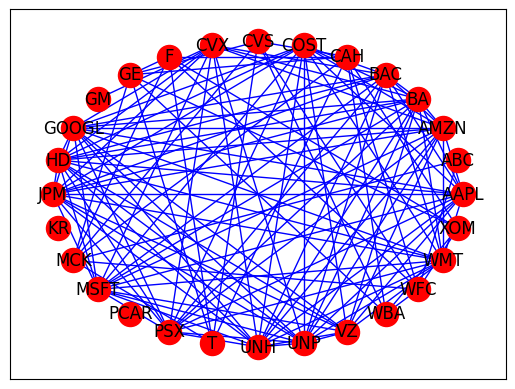

In [17]:
nx.draw_networkx(Graph_pearson, pos = nx.circular_layout( Graph_pearson ), node_color = 'r', edge_color = 'b')

# Experiment, we will divide the data into train, test, and validation graphs

In [18]:
df_s_transpose.corr(method = 'pearson', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


AAPL       ABC      AMZN        BA       BAC       CAH      COST  \
AAPL   1.000000 -0.036748  0.786106  0.692570  0.763609 -0.666770  0.863643   
ABC   -0.036748  1.000000 -0.127768 -0.126217  0.163579  0.466160 -0.130971   
AMZN   0.786106 -0.127768  1.000000  0.909833  0.739494 -0.876488  0.826927   
BA     0.692570 -0.126217  0.909833  1.000000  0.782307 -0.828416  0.699197   
BAC    0.763609  0.163579  0.739494  0.782307  1.000000 -0.523495  0.613895   
CAH   -0.666770  0.466160 -0.876488 -0.828416 -0.523495  1.000000 -0.766108   
COST   0.863643 -0.130971  0.826927  0.699197  0.613895 -0.766108  1.000000   
CVS   -0.342350  0.427752 -0.673998 -0.661338 -0.389465  0.746348 -0.553276   
CVX    0.459125  0.029482  0.601387  0.662725  0.670267 -0.539610  0.444068   
F     -0.593845  0.302385 -0.721688 -0.672301 -0.347324  0.709460 -0.712750   
GE    -0.688955  0.212265 -0.917546 -0.939535 -0.696132  0.900806 -0.757072   
GM    -0.043523  0.032142 -0.007530  0.197818  0.323353 -0.058398 -0.104827   
GOOGL  0.888000 -0.064546  0.876585  0.839987  0.841836 -0.757748  0.816834   
HD     0.877335 -0.012956  0.860812  0.816428  0.792398 -0.762504  0.899330   
JPM    0.887024  0.080675  0.804708  0.791697  0.947474 -0.630811  0.781794   
KR    -0.116002  0.273424 -0.101880 -0.184247 -0.059548  0.243666 -0.075982   
MCK   -0.282868  0.670322 -0.559749 -0.491303 -0.150853  0.684527 -0.412378   
MSFT   0.881596 -0.186018  0.891483  0.803451  0.699724 -0.838649  0.967020   
PCAR   0.427859  0.154842  0.071989  0.103744  0.484901  0.059840  0.317508   
PSX    0.745233  0.097029  0.690894  0.688694  0.804676 -0.558826  0.541579   
T     -0.262982  0.358636 -0.677553 -0.708575 -0.315603  0.741128 -0.297706   
UNH    0.760652 -0.055076  0.886126  0.886833  0.770331 -0.795163  0.695051   
UNP    0.798973 -0.178882  0.929052  0.873865  0.727145 -0.851249  0.902083   
VZ     0.676181 -0.252366  0.708967  0.653679  0.485319 -0.711528  0.864420   
WBA   -0.658245  0.300615 -0.763988 -0.707509 -0.604695  0.791882 -0.766485   
WFC   -0.197965  0.574354 -0.409286 -0.328412  0.127918  0.596125 -0.473844   
WMT    0.827489 -0.079702  0.765665  0.765026  0.705303 -0.739558  0.893336   
XOM   -0.505612  0.250188 -0.457154 -0.413556 -0.297798  0.523205 -0.648205   

            CVS       CVX         F  ...      PCAR       PSX         T  \
AAPL  -0.342350  0.459125 -0.593845  ...  0.427859  0.745233 -0.262982   
ABC    0.427752  0.029482  0.302385  ...  0.154842  0.097029  0.358636   
AMZN  -0.673998  0.601387 -0.721688  ...  0.071989  0.690894 -0.677553   
BA    -0.661338  0.662725 -0.672301  ...  0.103744  0.688694 -0.708575   
BAC   -0.389465  0.670267 -0.347324  ...  0.484901  0.804676 -0.315603   
CAH    0.746348 -0.539610  0.709460  ...  0.059840 -0.558826  0.741128   
COST  -0.553276  0.444068 -0.712750  ...  0.317508  0.541579 -0.297706   
CVS    1.000000 -0.440430  0.464550  ...  0.017925 -0.225111  0.586122   
CVX   -0.440430  1.000000 -0.087233  ...  0.293140  0.717509 -0.388580   
F      0.464550 -0.087233  1.000000  ...  0.115762 -0.306461  0.563575   
GE     0.683847 -0.556104  0.751037  ...  0.016267 -0.607796  0.749675   
GM    -0.147932  0.512428  0.409949  ...  0.348596  0.229382 -0.056340   
GOOGL -0.518179  0.588503 -0.628489  ...  0.354313  0.768521 -0.465246   
HD    -0.545253  0.619018 -0.576284  ...  0.391255  0.733390 -0.344361   
JPM   -0.408974  0.610744 -0.486046  ...  0.480762  0.791179 -0.306340   
KR     0.426283 -0.101121  0.008188  ... -0.165326 -0.000130  0.155794   
MCK    0.530977 -0.167482  0.654480  ...  0.307479 -0.160706  0.673269   
MSFT  -0.638668  0.510042 -0.731602  ...  0.322893  0.591259 -0.432385   
PCAR   0.017925  0.293140  0.115762  ...  1.000000  0.250929  0.412006   
PSX   -0.225111  0.717509 -0.306461  ...  0.250929  1.000000 -0.348642   
T      0.586122 -0.388580  0.563575  ...  0.412006 -0.348642  1.000000   
UNH   -0.439705  0.594834 -0.678168  ...  0.088494  0.736617 -0.703425   
UNP   -0.686060  

In [19]:
# Train Graph

In [20]:
df_s_pearson_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_pearson_train = df_s_pearson_train.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_train.values, 0)

df_s_transpose_pearson_train[df_s_transpose_pearson_train >= 0.5] = 1
df_s_transpose_pearson_train[df_s_transpose_pearson_train < 0.5] = 0
df_s_transpose_pearson_train

df_s_transpose_pearson_train

AAPL  ABC  AMZN   BA  BAC  CAH  COST  CVS  CVX    F   GE   GM  GOOGL  \
AAPL    0.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0    1.0   
ABC     0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0    0.0   
AMZN    1.0  0.0   0.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  0.0  0.0    1.0   
BA      1.0  0.0   1.0  0.0  1.0  0.0   1.0  0.0  1.0  0.0  0.0  0.0    1.0   
BAC     1.0  0.0   1.0  1.0  0.0  0.0   1.0  0.0  1.0  0.0  0.0  0.0    1.0   
CAH     0.0  0.0   0.0  0.0  0.0  0.0   0.0  1.0  0.0  1.0  1.0  0.0    0.0   
COST    1.0  0.0   1.0  1.0  1.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0    1.0   
CVS     0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  0.0  1.0  0.0    0.0   
CVX     0.0  0.0   1.0  1.0  1.0  0.0   0.0  0.0  0.0  0.0  0.0  1.0    1.0   
F       0.0  0.0   0.0  0.0  0.0  1.0   0.0  0.0  0.0  0.0  1.0  0.0    0.0   
GE      0.0  0.0   0.0  0.0  0.0  1.0   0.0  1.0  0.0  1.0  0.0  0.0    0.0   
GM      0.0  0.0   0.0  0.0  0.0  0.0   0.0  0.0  1.0  0.0  0.0  0.0    0.0   
GOOGL   1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  0.0  0.0    0.0   
HD      1.0  0.0   1.0  1.0  1.0  0.0   1.0  0.0  1.0  0.0  0.0  0.0    1.0   

        HD  
AAPL   1.0  
ABC    0.0  
AMZN   1.0  
BA     1.0  
BAC    1.0  
CAH    0.0  
COST   1.0  
CVS    0.0  
CVX    1.0  
F      0.0  
GE     0.0  
GM     0.0  
GOOGL  1.0  
HD     0.0

# Test Graph

In [21]:
df_s_pearson_test = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 15:23]
df_s_transpose_pearson_test = df_s_pearson_test.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_test.values, 0)

df_s_transpose_pearson_train[df_s_transpose_pearson_test >= 0.5] = 1
df_s_transpose_pearson_train[df_s_transpose_pearson_test < 0.5] = 0
df_s_transpose_pearson_test

JPM        KR       MCK      MSFT      PCAR       PSX         T  \
JPM   0.000000 -0.099604 -0.219086  0.845101  0.480762  0.791179 -0.306340   
KR   -0.099604  0.000000 -0.124950 -0.199669 -0.165326 -0.000130  0.155794   
MCK  -0.219086 -0.124950  0.000000 -0.447254  0.307479 -0.160706  0.673269   
MSFT  0.845101 -0.199669 -0.447254  0.000000  0.322893  0.591259 -0.432385   
PCAR  0.480762 -0.165326  0.307479  0.322893  0.000000  0.250929  0.412006   
PSX   0.791179 -0.000130 -0.160706  0.591259  0.250929  0.000000 -0.348642   
T    -0.306340  0.155794  0.673269 -0.432385  0.412006 -0.348642  0.000000   
UNH   0.813623 -0.045956 -0.480768  0.794765  0.088494  0.736617 -0.703425   
UNP   0.811915 -0.101779 -0.535813  0.947943  0.263082  0.594746 -0.558593   
VZ    0.645182  0.083074 -0.558568  0.840526  0.235457  0.375514 -0.335245   
WBA  -0.685892  0.462944  0.349649 -0.836292 -0.295242 -0.485566  0.410818   
WFC  -0.048314  0.404527  0.518439 -0.500994  0.234356  0.152373  0.441474   
WMT   0.828651 -0.225411 -0.279208  0.919066  0.419882  0.529770 -0.329463   
XOM  -0.476361  0.282817  0.265308 -0.662010 -0.078119 -0.146648  0.166924   

           UNH       UNP        VZ       WBA       WFC       WMT       XOM  
JPM   0.813623  0.811915  0.645182 -0.685892 -0.048314  0.828651 -0.476361  
KR   -0.045956 -0.101779  0.083074  0.462944  0.404527 -0.225411  0.282817  
MCK  -0.480768 -0.535813 -0.558568  0.349649  0.518439 -0.279208  0.265308  
MSFT  0.794765  0.947943  0.840526 -0.836292 -0.500994  0.919066 -0.662010  
PCAR  0.088494  0.263082  0.235457 -0.295242  0.234356  0.419882 -0.078119  
PSX   0.736617  0.594746  0.375514 -0.485566  0.152373  0.529770 -0.146648  
T    -0.703425 -0.558593 -0.335245  0.410818  0.441474 -0.329463  0.166924  
UNH   0.000000  0.841125  0.665200 -0.559520 -0.233302  0.734507 -0.399068  
UNP   0.841125  0.000000  0.834500 -0.790853 -0.472179  0.854697 -0.520728  
VZ    0.665200  0.834500  0.000000 -0.575865 -0.445419  0.808992 -0.524897  
WBA  -0.559520 -0.790853 -0.575865  0.000000  0.531891 -0.752517  0.575520  
WFC  -0.233302 -0.472179 -0.445419  0.531891  0.000000 -0.361995  0.595208  
WMT   0.734507  0.854697  0.808992 -0.752517 -0.361995  0.000000 -0.617936  
XOM  -0.399068 -0.520728 -0.524897  0.575520  0.595208 -0.617936  0.000000

# Validation Graph

In [22]:
df_s_pearson_validation = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 23:]
df_s_transpose_pearson_validation = df_s_pearson_validation.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_validation.values, 0)
df_s_transpose_pearson_validation

df_s_transpose_pearson_validation[df_s_transpose_pearson_validation >= 0.5] = 1
df_s_transpose_pearson_validation[df_s_transpose_pearson_validation < 0.5] = 0
df_s_transpose_pearson_validation

JPM   KR  MCK  MSFT  PCAR  PSX    T  UNH  UNP   VZ  WBA  WFC  WMT  XOM
JPM   0.0  0.0  0.0   1.0   0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
KR    0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
MCK   0.0  0.0  0.0   0.0   0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
MSFT  1.0  0.0  0.0   0.0   0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
PCAR  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
PSX   1.0  0.0  0.0   1.0   0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0
T     0.0  0.0  1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
UNH   1.0  0.0  0.0   1.0   0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0
UNP   1.0  0.0  0.0   1.0   0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0
VZ    1.0  0.0  0.0   1.0   0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0
WBA   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
WFC   0.0  0.0  1.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
WMT   1.0  0.0  0.0   1.0   0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
XOM   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0

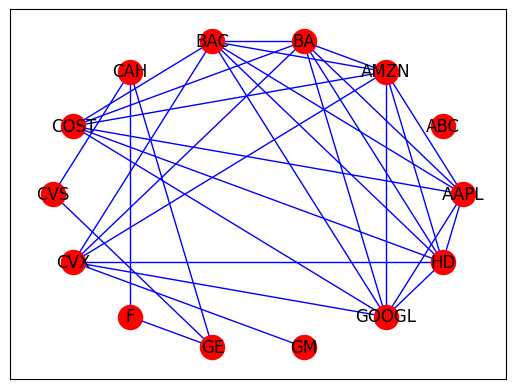

In [23]:
graph_pearson_train = nx.Graph(df_s_transpose_pearson_train)
graph_pearson_test = nx.Graph(df_s_transpose_pearson_test)
graph_pearson_validation = nx.Graph(df_s_transpose_pearson_validation)


nx.draw_networkx(graph_pearson_train, pos = nx.circular_layout( graph_pearson_train ), node_color = 'r', edge_color = 'b')


In [24]:
df_s_pearson_train.corr(numeric_only = True)

AAPL       ABC      AMZN        BA       BAC       CAH      COST  \
AAPL   1.000000 -0.036748  0.786106  0.692570  0.763609 -0.666770  0.863643   
ABC   -0.036748  1.000000 -0.127768 -0.126217  0.163579  0.466160 -0.130971   
AMZN   0.786106 -0.127768  1.000000  0.909833  0.739494 -0.876488  0.826927   
BA     0.692570 -0.126217  0.909833  1.000000  0.782307 -0.828416  0.699197   
BAC    0.763609  0.163579  0.739494  0.782307  1.000000 -0.523495  0.613895   
CAH   -0.666770  0.466160 -0.876488 -0.828416 -0.523495  1.000000 -0.766108   
COST   0.863643 -0.130971  0.826927  0.699197  0.613895 -0.766108  1.000000   
CVS   -0.342350  0.427752 -0.673998 -0.661338 -0.389465  0.746348 -0.553276   
CVX    0.459125  0.029482  0.601387  0.662725  0.670267 -0.539610  0.444068   
F     -0.593845  0.302385 -0.721688 -0.672301 -0.347324  0.709460 -0.712750   
GE    -0.688955  0.212265 -0.917546 -0.939535 -0.696132  0.900806 -0.757072   
GM    -0.043523  0.032142 -0.007530  0.197818  0.323353 -0.058398 -0.104827   
GOOGL  0.888000 -0.064546  0.876585  0.839987  0.841836 -0.757748  0.816834   
HD     0.877335 -0.012956  0.860812  0.816428  0.792398 -0.762504  0.899330   

            CVS       CVX         F        GE        GM     GOOGL        HD  
AAPL  -0.342350  0.459125 -0.593845 -0.688955 -0.043523  0.888000  0.877335  
ABC    0.427752  0.029482  0.302385  0.212265  0.032142 -0.064546 -0.012956  
AMZN  -0.673998  0.601387 -0.721688 -0.917546 -0.007530  0.876585  0.860812  
BA    -0.661338  0.662725 -0.672301 -0.939535  0.197818  0.839987  0.816428  
BAC   -0.389465  0.670267 -0.347324 -0.696132  0.323353  0.841836  0.792398  
CAH    0.746348 -0.539610  0.709460  0.900806 -0.058398 -0.757748 -0.762504  
COST  -0.553276  0.444068 -0.712750 -0.757072 -0.104827  0.816834  0.899330  
CVS    1.000000 -0.440430  0.464550  0.683847 -0.147932 -0.518179 -0.545253  
CVX   -0.440430  1.000000 -0.087233 -0.556104  0.512428  0.588503  0.619018  
F      0.464550 -0.087233  1.000000  0.751037  0.409949 -0.628489 -0.576284  
GE     0.683847 -0.556104  0.751037  1.000000 -0.093362 -0.815768 -0.800527  
GM    -0.147932  0.512428  0.409949 -0.093362  1.000000  0.153165  0.160079  
GOOGL -0.518179  0.588503 -0.628489 -0.815768  0.153165  1.000000  0.913365  
HD    -0.545253  0.619018 -0.576284 -0.800527  0.160079  0.913365  1.000000

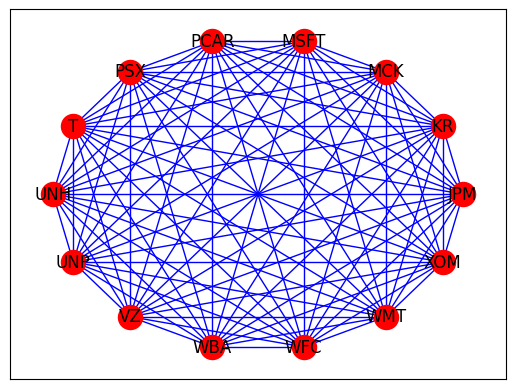

In [25]:
nx.draw_networkx(graph_pearson_test, pos = nx.circular_layout( graph_pearson_test ), node_color = 'r', edge_color = 'b')

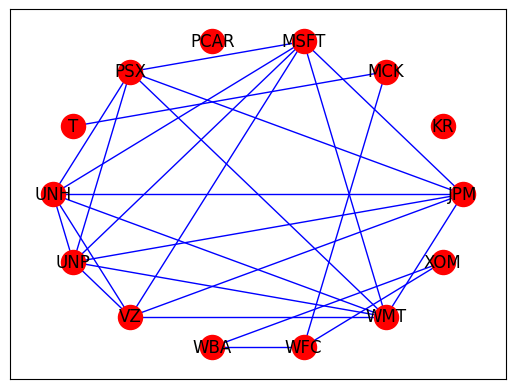

In [26]:
nx.draw_networkx(graph_pearson_validation, pos = nx.circular_layout( graph_pearson_validation ), node_color = 'r', edge_color = 'b')

# Create GCN layer. Pearson

# Find all stocks = nodes

In [27]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_pearson.index.to_list()
all_stock_nodes[:5]

['AAPL', 'ABC', 'AMZN', 'BA', 'BAC']

# Find all edges between nodes

This may need adjustment to reflect train, test, validation graphs

In [28]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_pearson[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            

(['AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'ABC',
  'ABC',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GM',
  'GOOGL',
  'GOOGL',


# Find all edges in Train, Test, and Validation Graphs

In [29]:
trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_pearson_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_pearson_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_pearson_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_pearson_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_pearson_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_pearson_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_pearson[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature

(['JPM',
  'JPM',
  'JPM',
  'JPM',
  'JPM',
  'JPM',
  'MCK',
  'MCK',
  'MSFT',
  'MSFT',
  'MSFT',
  'MSFT',
  'MSFT',
  'MSFT',
  'PSX',
  'PSX',
  'PSX',
  'PSX',
  'PSX',
  'T',
  'UNH',
  'UNH',
  'UNH',
  'UNH',
  'UNH',
  'UNH',
  'UNP',
  'UNP',
  'UNP',
  'UNP',
  'UNP',
  'UNP',
  'VZ',
  'VZ',
  'VZ',
  'VZ',
  'VZ',
  'WBA',
  'WBA',
  'WFC',
  'WFC',
  'WFC',
  'WMT',
  'WMT',
  'WMT',
  'WMT',
  'WMT',
  'WMT',
  'XOM',
  'XOM'],
 ['MSFT',
  'PSX',
  'UNH',
  'UNP',
  'VZ',
  'WMT',
  'T',
  'WFC',
  'JPM',
  'PSX',
  'UNH',
  'UNP',
  'VZ',
  'WMT',
  'JPM',
  'MSFT',
  'UNH',
  'UNP',
  'WMT',
  'MCK',
  'JPM',
  'MSFT',
  'PSX',
  'UNP',
  'VZ',
  'WMT',
  'JPM',
  'MSFT',
  'PSX',
  'UNH',
  'VZ',
  'WMT',
  'JPM',
  'MSFT',
  'UNH',
  'UNP',
  'WMT',
  'WFC',
  'XOM',
  'MCK',
  'WBA',
  'XOM',
  'JPM',
  'MSFT',
  'PSX',
  'UNH',
  'UNP',
  'VZ',
  'WBA',
  'WFC'],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,


# Create variables to create stellar graph
# Edges

In [30]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges = pd.DataFrame(
    {"source": source, "target": target}
)

pearson_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

pearson_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

pearson_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

pearson_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


pearson_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


pearson_edges_train[:10]

source target
0   AAPL   AMZN
1   AAPL     BA
2   AAPL    BAC
3   AAPL   COST
4   AAPL  GOOGL
5   AAPL     HD
6   AMZN   AAPL
7   AMZN     BA
8   AMZN    BAC
9   AMZN   COST

# Have the time series data as part of the nodes

# Structure the Feature Matrix so that it can be passed to the GCN

In [31]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values

((753,),
 array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
        29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
        29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
        30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
        32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
        33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
        33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
        34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
        34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
        34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
        35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
        35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
        35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
        35.91500092, 35.83499908, 35.79249

In [32]:
len(all_stock_nodes)

28

In [33]:
# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
        29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
        29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
        30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
        32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
        33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
        33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
        34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
        34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
        34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
        35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
        35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
        35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
        35.91500092, 35.83499908, 35.79249954, 35.4

In [34]:
# convert node data variable into a dataframe so that the data structure is compatible with graph NN
pearson_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
pearson_graph_node_data.head()

0           1           2           3           4           5    \
AAPL   29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC    82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN   37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA    156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC    22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   

             6           7           8           9    ...         743  \
AAPL   29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC    81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN   39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA    159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC    23.070000   22.920000   23.010000   22.049999  ...   34.700001   

             744         745         746         747         748         749  \
AAPL   70.102501   69.934998   70.004997   69.860001   71.000000   71.067497   
ABC    83.150002   83.550003   83.800003   85.669998   85.599998   85.419998   
AMZN   89.532997   89.201500   89.613998   89.324997   89.650002   89.460503   
BA    327.000000  330.679993  333.500000  328.000000  337.549988  333.000000   
BAC    35.040001   35.110001   34.950001   34.959999   35.169998   35.220001   

             750         751         752  
AAPL   72.477501   72.449997   72.879997  
ABC    85.050003   84.910004   83.639999  
AMZN   93.438499   93.489998   92.344498  
BA    329.920013  330.140015  326.399994  
BAC    35.520000   35.349998   35.150002  

[5 rows x 753 columns]

In [35]:
node_Data[14:15], 
len(validationNodeList)
len(testNodeList)

14

In [36]:
# Node time series data based on train, test, validation graph

In [37]:
# convert node data variable into a dataframe so that the data structure is compatible with graph NN
pearson_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
pearson_graph_node_data_train.head()

pearson_graph_node_data_test = pd.DataFrame(node_Data[14:], index = testNodeList) #pd.DataFrame(node_Data[15:23], index = testNodeList)
pearson_graph_node_data_test.head()

pearson_graph_node_data_validation = pd.DataFrame(node_Data[14:], index = validationNodeList) #pd.DataFrame(node_Data[22:30], index = validationNodeList)
pearson_graph_node_data_validation.head()



0           1           2           3           4           5    \
JPM    87.230003   86.910004   86.110001   86.120003   86.180000   86.430000   
KR     33.720001   33.240002   33.209999   33.110001   32.919998   33.189999   
MCK   147.429993  148.580002  146.500000  146.919998  146.839996  146.820007   
MSFT   62.580002   62.299999   62.299999   62.840000   62.639999   62.619999   
PCAR   43.546665   44.146667   43.426666   43.919998   43.380001   44.166668   

             6           7           8           9    ...         743  \
JPM    87.080002   86.239998   86.699997   83.550003  ...  137.339996   
KR     33.070000   33.520000   34.099998   34.840000  ...   28.309999   
MCK   143.199997  144.679993  147.179993  148.429993  ...  142.199997   
MSFT   63.189999   62.610001   62.700001   62.529999  ...  155.529999   
PCAR   44.533333   44.220001   45.013332   44.613335  ...   55.213333   

             744         745         746         747         748         749  \
JPM   138.179993  138.039993  137.350006  137.240005  137.199997  137.580002   
KR     28.700001   28.330000   28.760000   29.000000   28.889999   29.100000   
MCK   137.899994  136.990005  135.610001  137.639999  137.600006  138.809998   
MSFT  154.690002  154.369995  155.710007  157.410004  157.410004  157.380005   
PCAR   54.766666   55.080002   53.126667   53.446667   53.033333   52.993332   

             750         751         752  
JPM   139.039993  139.139999  138.630005  
KR     28.889999   28.760000   29.059999  
MCK   139.309998  139.440002  137.169998  
MSFT  158.669998  158.960007  157.589996  
PCAR   53.006668   52.939999   52.646667  

[5 rows x 753 columns]

In [38]:
pearson_graph_node_data_train

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   

              6           7           8           9    ...         743  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC     81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA     159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.700001   
CAH     73.720001   74.190002   75.000000   75.180000  ...   53.700001   
COST   161.539993  161.869995  161.860001  163.809998  ...  293.500000   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.400002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  119.360001   
F       12.670000   12.590000   12.630000   12.610000  ...    9.390000   
GE     188.974960  188.494568  188.314423  187.773972  ...   69.758003   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.110001   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   68.035004   
HD     135.699997  135.070007  135.039993  135.929993  ...  215.529999   

              744         745         746         747         748         749  \
AAPL    70.102501   69.934998   70.004997   69.860001   71.000000   71.067497   
ABC     83.150002   83.550003   83.800003   85.669998   85.599998   85.419998   
AMZN    89.532997   89.201500   89.613998   89.324997   89.650002   89.460503   
BA     327.000000  330.679993  333.500000  328.000000  337.549988  333.000000   
BAC     35.040001   35.110001   34.950001   34.959999   35.169998   35.220001   
CAH     51.570000   51.099998   50.610001   51.799999   51.130001   51.290001   
COST   295.549988  291.869995  293.709991  294.829987  293.309998  294.230011   
CVS     73.349998   73.279999   74.099998   74.580002   74.379997   74.510002   
CVX    118.599998  118.550003  118.129997  119.680000  120.330002  120.339996   
F        9.390000    9.540000    9.410000    9.480000    9.440000    9.470000   
GE      69.320847   68.446526   68.946136   68.883682   69.695549   69.882904   
GM      36.310001   37.310001   37.259998   37.250000   36.770000   36.580002   
GOOGL   67.744499   67.595497   67.821999   67.560997   67.531502   67.221497   
HD     217.720001  218.000000  220.220001  221.190002  219.210007  220.669998   

              750         751         752  
AAPL    72.477501   72.449997   72.879997  
ABC     85.050003   84.910004   83.639999  
AMZN    93.438499   93.489998   92.344498  
BA     329.920013  330.140015  326.399994  
BAC     35.520000   35.349998   35.150002  
CAH     51.169998   51.500000   50.770000  
COST   295.730011  294.109985  295.140015  
CVS     74.480003   74.400002   73.699997  
CVX    120.599998  120.300003  119.849998  
F        9.450000    9.360000  

# Graph (stellar) with features as part of Nodes

In [39]:
# Overall
pearson_graph_with_node_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default = "corner", edge_type_default = "line")
print(pearson_graph_with_node_features.info())

# train nodes
pearson_train_graph_with_node_features = StellarGraph(pearson_graph_node_data_train, edges = pearson_edges_train, node_type_default = "corner", edge_type_default = "line")
print(pearson_train_graph_with_node_features.info())

# test
pearson_test_graph_with_node_features = StellarGraph(pearson_graph_node_data_test, edges = pearson_edges_test, node_type_default = "corner", edge_type_default = "line")
print(pearson_test_graph_with_node_features.info())

# validation
pearson_validation_graph_with_node_features = StellarGraph(pearson_graph_node_data_validation, edges = pearson_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(pearson_validation_graph_with_node_features.info())

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 258

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [258]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 64

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [64]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 94

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [94]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 50

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [50

# Adapting everything for DeepGraphCNN

In [40]:
pearson_graph_node_data.iloc[0:15, :]

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   
JPM     87.230003   86.910004   86.110001   86.120003   86.180000   86.430000   

              6           7           8           9    ...         743  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC     81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA     159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.700001   
CAH     73.720001   74.190002   75.000000   75.180000  ...   53.700001   
COST   161.539993  161.869995  161.860001  163.809998  ...  293.500000   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.400002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  119.360001   
F       12.670000   12.590000   12.630000   12.610000  ...    9.390000   
GE     188.974960  188.494568  188.314423  187.773972  ...   69.758003   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.110001   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   68.035004   
HD     135.699997  135.070007  135.039993  135.929993  ...  215.529999   
JPM     87.080002   86.239998   86.699997   83.550003  ...  137.339996   

              744         745         746         747         748         749  \
AAPL    70.102501   69.934998   70.004997   69.860001   71.000000   71.067497   
ABC     83.150002   83.550003   83.800003   85.669998   85.599998   85.419998   
AMZN    89.532997   89.201500   89.613998   89.324997   89.650002   89.460503   
BA     327.000000  330.679993  333.500000  328.000000  337.549988  333.000000   
BAC     35.040001   35.110001   34.950001   34.959999   35.169998   35.220001   
CAH     51.570000   51.099998   50.610001   51.799999   51.130001   51.290001   
COST   295.549988  291.869995  293.709991  294.829987  293.309998  294.230011   
CVS     73.349998   73.279999   74.099998   74.580002   74.379997   74.510002   
CVX    118.599998  118.550003  118.129997  119.680000  120.330002  120.339996   
F        9.390000    9.540000    9.410000    9.480000    9.440000    9.470000   
GE      69.320847   68.446526   68.946136   68.883682   69.695549   69.882904   
GM      36.310001   37.310001   37.259998   37.250000   36.770000   36.580002   
GOOGL   67.744499   67.595497   67.821999   67.560997   67.531502   67.221497   
HD     217.720001  218.000000  220.220001  221.190002  219.210007  220.669998   
JPM    138.179993  138.039993  137.350006  137.240005  137.199997  137.580002   

              750         751         752  
AAPL    72.477501   72.449997   72.879997  
ABC     85.050003   84.910004   83.639999  
AMZN    93.438499   93.489998   92.344498  
BA     329.920013  330.140015  326.399994  
BAC     35.5200

# Graphs to be jused for DeepGraphCNN

In [41]:
graphs = list()
#graphs.append(pearson_graph_with_node_features)
graphs.append(pearson_train_graph_with_node_features)
graphs.append(pearson_test_graph_with_node_features)
graphs.append(pearson_validation_graph_with_node_features)

In [42]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()

nodes  edges
count    3.0    3.0
mean    14.0   69.0
std      0.0   22.0
min     14.0   50.0
25%     14.0   57.0
50%     14.0   64.0
75%     14.0   79.0
max     14.0   94.0

In [43]:
# graph_labels = all_stock_nodes

In [44]:
# Generator
#generator = FullBatchNodeGenerator(pearson_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( pearson_graph_with_node_features)

In [45]:
vars(generator)

{'node_features_size': 753,
 'graphs': [<stellargraph.core.graph.StellarGraph at 0x1b45cd32a30>,
 'name': None}

# Train Test Split

# Commented out on 2023-04-18
train_subjects, test_subjects = model_selection.train_test_split(
    pearson_graph_node_data 
)

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects 
)

#, train_size = 500, test_size = None, stratify = test_subjects

train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

In [46]:
train_subjects = pearson_graph_node_data_train.iloc[:,0:751];
test_subjects = pearson_graph_node_data_test.iloc[:,0:751];
val_subjects = pearson_graph_node_data_validation.iloc[:,0:751];

In [47]:
pearson_graph_node_data_train.iloc[:,0:751]

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   

              6           7           8           9    ...         741  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   67.864998   
ABC     81.529999   83.860001   84.620003   85.989998  ...   86.790001   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.016502   
BA     159.399994  158.289993  158.830002  157.669998  ...  346.290009   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.680000   
CAH     73.720001   74.190002   75.000000   75.180000  ...   54.660000   
COST   161.539993  161.869995  161.860001  163.809998  ...  297.339996   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.260002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  118.809998   
F       12.670000   12.590000   12.630000   12.610000  ...    9.320000   
GE     188.974960  188.494568  188.314423  187.773972  ...   71.444183   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.099998   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   67.424500   
HD     135.699997  135.070007  135.039993  135.929993  ...  212.039993   

              742         743         744         745         746         747  \
AAPL    68.787498   69.964996   70.102501   69.934998   70.004997   69.860001   
ABC     84.849998   85.959999   83.150002   83.550003   83.800003   85.669998   
AMZN    88.046997   88.460503   89.532997   89.201500   89.613998   89.324997   
BA     341.670013  327.000000  327.000000  330.679993  333.500000  328.000000   
BAC     34.439999   34.700001   35.040001   35.110001   34.950001   34.959999   
CAH     53.660000   53.700001   51.570000   51.099998   50.610001   51.799999   
COST   291.869995  293.500000  295.549988  291.869995  293.709991  294.829987   
CVS     73.589996   74.400002   73.349998   73.279999   74.099998   74.580002   
CVX    117.959999  119.360001  118.599998  118.550003  118.129997  119.680000   
F        9.230000    9.390000    9.390000    9.540000    9.410000    9.480000   
GE      70.819672   69.758003   69.320847   68.446526   68.946136   68.883682   
GM      35.650002   36.110001   36.310001   37.310001   37.259998   37.250000   
GOOGL   67.343498   68.035004   67.744499   67.595497   67.821999   67.560997   
HD     214.080002  215.529999  217.720001  218.000000  220.220001  221.190002   

              748         749         750  
AAPL    71.000000   71.067497   72.477501  
ABC     85.599998   85.419998   85.050003  
AMZN    89.650002   89.460503   93.438499  
BA     337.549988  333.000000  329.920013  
BAC     35.169998   35.220001   35.520000  
CAH     51.130001   51.290001   51.169998  
COST   293.309998  294.230011  295.730011  
CVS     74.379997   74.510002   74.480003  
CVX    120.330002  120.339996  120.599998  
F        9.440000    9.470000  

In [48]:
# Commented out on 2023-04-18
#train_targets = train_subjects; 
#val_targets = val_subjects; 
#test_targets = test_subjects; 

# The Model for all of the approaches utilized in this file
# Model for Pearson, Spearman, Kendal Tau, Financial News Based prediction

# Models : DeepGraph CNN

In [49]:
epochs_to_test = 10000
patience_to_test = 10000

In [50]:
# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


([<KerasTensor: shape=(None, None, 753) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(None, None) dtype=bool (created by layer 'input_2')>,
  <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_3')>],
 <KerasTensor: shape=(None, 1358, 1) dtype=float32 (created by layer 'sort_pooling')>)

In [51]:
# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    

In [52]:
#train_targets.index

In [53]:
x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = 14, activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)

In [54]:
 #len(train_targets)

In [55]:
# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)

# Commented out on 2023-04-18

# hard coded size adjustments
#test_subjects_ = test_subjects[:len(val_subjects)]

#val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]
#val_gen[4]

#  Multiple Graph Version Starts

In [56]:
vars(graphs[0])

{'_is_directed': False,
 '_nodes': <stellargraph.core.element_data.NodeData at 0x1b45cd32670>,
 '_edges': <stellargraph.core.element_data.EdgeData at 0x1b45cd3f100>}

In [57]:
list(pearson_graph_node_data_train.iloc[:,752]), list(pearson_graph_node_data_test.iloc[:,752]), list(pearson_graph_node_data_validation.iloc[:,752])
list(pearson_graph_node_data_train.iloc[:,751])

[72.44999694824219,
 84.91000366210938,
 93.48999786376952,
 330.1400146484375,
 35.349998474121094,
 51.5,
 294.1099853515625,
 74.4000015258789,
 120.3000030517578,
 9.359999656677246,
 69.82044982910156,
 36.560001373291016,
 67.73200225830078,
 219.97000122070312]

In [58]:
x = [[72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372]]

train_target = [[72.87999725341797,
 83.63999938964844,
 92.34449768066406,
 326.3999938964844,
 35.150001525878906,
 50.77000045776367,
 295.1400146484375,
 73.69999694824219,
 119.8499984741211,
 9.25,
 69.19593811035156,
 36.43999862670898,
 66.9854965209961,
 217.30999755859372]]

In [59]:



test_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


validation_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


valid_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]

In [60]:
validation_target

[[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]

In [61]:
x

[[72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372]]

In [62]:
# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = train_target, #list(train_target), #[0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = test_target, #[1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = validation_target, #[2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)


#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];

In [63]:
'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''

'\nall_gen = generator.flow(\n    #list(test_targets.index),\n    #test_gen_node_id_list,\n    [2],\n    targets=2,#test_targets.values,\n    batch_size = 1,\n    symmetric_normalization = False,\n)\n'

In [64]:
vars(train_gen)

{'name': None,
 'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD32A30>,
       dtype=object),
 'selected_ilocs': array([[0]]),
 'normalize_adj': True,
 'targets': array([[ 72.87999725,  83.63999939,  92.34449768, 326.3999939 ,
          35.15000153,  50.77000046, 295.14001465,  73.69999695,
         119.84999847,   9.25      ,  69.19593811,  36.43999863,
          66.98549652, 217.30999756]]),
 'batch_size': 1,
 'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 78 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 108 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 64 stored elements in Compressed Sparse Row format>],
       dtype=object),
 '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\_

In [65]:
vars(test_gen)

{'name': None,
 'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD32A30>,
       dtype=object),
 'selected_ilocs': array([[1]]),
 'normalize_adj': True,
 'targets': array([[138.63000488,  29.05999947, 137.16999817, 157.58999634,
          52.64666748, 110.37000275,  29.48640442, 293.8500061 ,
         180.1499939 ,  61.20999908,  58.90999985,  53.59999847,
         119.40000153,  69.48000336]]),
 'batch_size': 1,
 'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 78 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 108 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 64 stored elements in Compressed Sparse Row format>],
       dtype=object),
 '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\_

In [66]:
vars(val_gen)
#train_subjects
#train_subjects.values

{'name': None,
 'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD32A30>,
       dtype=object),
 'selected_ilocs': array([[2]]),
 'normalize_adj': True,
 'targets': array([[138.63000488,  29.05999947, 137.16999817, 157.58999634,
          52.64666748, 110.37000275,  29.48640442, 293.8500061 ,
         180.1499939 ,  61.20999908,  58.90999985,  53.59999847,
         119.40000153,  69.48000336]]),
 'batch_size': 1,
 'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 78 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 108 stored elements in Compressed Sparse Row format>,
        <14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 64 stored elements in Compressed Sparse Row format>],
       dtype=object),
 '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\_

In [67]:
vars(train_gen), 
#train_subjects
#train_subjects.values

({'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD32A30>,
        dtype=object),
  'selected_ilocs': array([[0]]),
  'normalize_adj': True,
  'targets': array([[ 72.87999725,  83.63999939,  92.34449768, 326.3999939 ,
           35.15000153,  50.77000046, 295.14001465,  73.69999695,
          119.84999847,   9.25      ,  69.19593811,  36.43999863,
           66.98549652, 217.30999756]]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 78 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 108 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 64 stored elements in Compressed Sparse Row format>],
        dtype=object),
  '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages

train_subjects, test_gen

In [68]:
#train_gen, data_valid, train_gen_data

In [69]:
# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 2, validation_data = test_gen, shuffle = False,
)

Epoch 1/10000
1/1 - 2s - loss: 115.9970 - mse: 22336.7676 - mape: 126.4557 - mae: 115.9970 - val_loss: 115724.2422 - val_mse: 13845421056.0000 - val_mape: 175034.6094 - val_mae: 115724.2422 - 2s/epoch - 2s/step
Epoch 2/10000
1/1 - 0s - loss: 123081.9766 - mse: 15618601984.0000 - mape: 252072.7031 - mae: 123081.9766 - val_loss: 406700.0938 - val_mse: 171671257088.0000 - val_mape: 580983.6250 - val_mae: 406700.0938 - 51ms/epoch - 51ms/step
Epoch 3/10000
1/1 - 0s - loss: 549493.1875 - mse: 318097653760.0000 - mape: 1154773.2500 - mae: 549493.1875 - val_loss: 253697.5156 - val_mse: 70607241216.0000 - val_mape: 358163.4375 - val_mae: 253697.5156 - 52ms/epoch - 52ms/step
Epoch 4/10000
1/1 - 0s - loss: 263616.6250 - mse: 80085409792.0000 - mape: 457284.1875 - mae: 263616.6250 - val_loss: 125729.1094 - val_mse: 16232659968.0000 - val_mape: 190245.0156 - val_mae: 125729.1094 - 49ms/epoch - 49ms/step
Epoch 5/10000
1/1 - 0s - loss: 136123.2656 - mse: 19132528640.0000 - mape: 257274.8594 - mae: 13

Epoch 42/10000
1/1 - 0s - loss: 1020.3084 - mse: 1307102.1250 - mape: 1304.1316 - mae: 1020.3084 - val_loss: 167.5154 - val_mse: 58371.0039 - val_mape: 285.7613 - val_mae: 167.5154 - 51ms/epoch - 51ms/step
Epoch 43/10000
1/1 - 0s - loss: 74.6132 - mse: 7210.8306 - mape: 201.1583 - mae: 74.6132 - val_loss: 86.8081 - val_mse: 12846.7764 - val_mape: 133.4374 - val_mae: 86.8081 - 52ms/epoch - 52ms/step
Epoch 44/10000
1/1 - 0s - loss: 190.1844 - mse: 40209.8789 - mape: 306.4159 - mae: 190.1844 - val_loss: 146.4670 - val_mse: 29742.9082 - val_mape: 198.3598 - val_mae: 146.4670 - 48ms/epoch - 48ms/step
Epoch 45/10000
1/1 - 0s - loss: 370.2827 - mse: 143699.8125 - mape: 803.4260 - mae: 370.2827 - val_loss: 175.0307 - val_mse: 38322.2461 - val_mape: 230.4258 - val_mae: 175.0307 - 47ms/epoch - 47ms/step
Epoch 46/10000
1/1 - 0s - loss: 217.7093 - mse: 47983.8320 - mape: 422.3203 - mae: 217.7093 - val_loss: 167.6744 - val_mse: 35112.8242 - val_mape: 216.1095 - val_mae: 167.6744 - 47ms/epoch - 47ms

Epoch 83/10000
1/1 - 0s - loss: 134.8698 - mse: 25173.1426 - mape: 235.1887 - mae: 134.8698 - val_loss: 435.0685 - val_mse: 235400.7031 - val_mape: 737.4515 - val_mae: 435.0685 - 56ms/epoch - 56ms/step
Epoch 84/10000
1/1 - 0s - loss: 733.0023 - mse: 580552.8750 - mape: 1829.3743 - mae: 733.0023 - val_loss: 411.5113 - val_mse: 215882.0469 - val_mape: 704.6951 - val_mae: 411.5113 - 61ms/epoch - 61ms/step
Epoch 85/10000
1/1 - 0s - loss: 138.9181 - mse: 25639.0488 - mape: 267.1879 - mae: 138.9181 - val_loss: 418.9727 - val_mse: 220828.3281 - val_mape: 714.8984 - val_mae: 418.9727 - 60ms/epoch - 60ms/step
Epoch 86/10000
1/1 - 0s - loss: 492.5145 - mse: 287706.0312 - mape: 1173.9600 - mae: 492.5145 - val_loss: 254.4786 - val_mse: 87647.8828 - val_mape: 455.8837 - val_mae: 254.4786 - 56ms/epoch - 56ms/step
Epoch 87/10000
1/1 - 0s - loss: 471.7313 - mse: 248450.0781 - mape: 1130.5723 - mae: 471.7313 - val_loss: 308.0510 - val_mse: 103806.3281 - val_mape: 383.8248 - val_mae: 308.0510 - 53ms/epo

Epoch 123/10000
1/1 - 0s - loss: 772.9427 - mse: 747920.8750 - mape: 1437.9359 - mae: 772.9427 - val_loss: 830.6007 - val_mse: 856082.5000 - val_mape: 1211.0448 - val_mae: 830.6007 - 49ms/epoch - 49ms/step
Epoch 124/10000
1/1 - 0s - loss: 842.4062 - mse: 819861.5625 - mape: 1242.3564 - mae: 842.4062 - val_loss: 964.1055 - val_mse: 1080279.5000 - val_mape: 1419.6274 - val_mae: 964.1055 - 48ms/epoch - 48ms/step
Epoch 125/10000
1/1 - 0s - loss: 655.7740 - mse: 788376.6875 - mape: 864.8344 - mae: 655.7740 - val_loss: 851.1785 - val_mse: 837589.8750 - val_mape: 1290.6993 - val_mae: 851.1785 - 45ms/epoch - 45ms/step
Epoch 126/10000
1/1 - 0s - loss: 554.1115 - mse: 499700.5938 - mape: 958.9893 - mae: 554.1115 - val_loss: 653.5414 - val_mse: 498832.4375 - val_mape: 1025.8322 - val_mae: 653.5414 - 44ms/epoch - 44ms/step
Epoch 127/10000
1/1 - 0s - loss: 258.4080 - mse: 94480.3203 - mape: 631.8762 - mae: 258.4080 - val_loss: 503.3562 - val_mse: 297347.4062 - val_mape: 820.4606 - val_mae: 503.3562

Epoch 164/10000
1/1 - 0s - loss: 247.7093 - mse: 67671.4141 - mape: 461.7319 - mae: 247.7093 - val_loss: 141.6451 - val_mse: 29235.6191 - val_mape: 261.4488 - val_mae: 141.6451 - 43ms/epoch - 43ms/step
Epoch 165/10000
1/1 - 0s - loss: 151.8946 - mse: 32618.9863 - mape: 234.2789 - mae: 151.8946 - val_loss: 92.9690 - val_mse: 13233.6074 - val_mape: 170.4999 - val_mae: 92.9690 - 47ms/epoch - 47ms/step
Epoch 166/10000
1/1 - 0s - loss: 80.2084 - mse: 10957.6689 - mape: 91.6805 - mae: 80.2084 - val_loss: 59.7160 - val_mse: 6663.3198 - val_mape: 87.0017 - val_mae: 59.7160 - 47ms/epoch - 47ms/step
Epoch 167/10000
1/1 - 0s - loss: 47.1270 - mse: 4859.7666 - mape: 70.7013 - mae: 47.1270 - val_loss: 59.4007 - val_mse: 6411.6167 - val_mape: 91.4572 - val_mae: 59.4007 - 46ms/epoch - 46ms/step
Epoch 168/10000
1/1 - 0s - loss: 84.4934 - mse: 15134.7168 - mape: 73.9953 - mae: 84.4934 - val_loss: 78.7070 - val_mse: 9495.8252 - val_mape: 133.9135 - val_mae: 78.7070 - 44ms/epoch - 44ms/step
Epoch 169/100

Epoch 206/10000
1/1 - 0s - loss: 35.7702 - mse: 2391.8667 - mape: 73.4155 - mae: 35.7702 - val_loss: 107.5745 - val_mse: 23412.8770 - val_mape: 202.5801 - val_mae: 107.5745 - 49ms/epoch - 49ms/step
Epoch 207/10000
1/1 - 0s - loss: 423.8912 - mse: 192125.8594 - mape: 701.7874 - mae: 423.8912 - val_loss: 69.3409 - val_mse: 8250.3369 - val_mape: 74.8058 - val_mae: 69.3409 - 47ms/epoch - 47ms/step
Epoch 208/10000
1/1 - 0s - loss: 59.6841 - mse: 7590.3657 - mape: 89.9687 - mae: 59.6841 - val_loss: 83.8566 - val_mse: 10646.1123 - val_mape: 92.5678 - val_mae: 83.8566 - 46ms/epoch - 46ms/step
Epoch 209/10000
1/1 - 0s - loss: 85.7343 - mse: 14806.9814 - mape: 116.1958 - mae: 85.7343 - val_loss: 99.6836 - val_mse: 15144.7393 - val_mape: 136.3808 - val_mae: 99.6836 - 50ms/epoch - 50ms/step
Epoch 210/10000
1/1 - 0s - loss: 85.4658 - mse: 14018.8418 - mape: 118.4277 - mae: 85.4658 - val_loss: 100.7312 - val_mse: 16461.7070 - val_mape: 147.6970 - val_mae: 100.7312 - 47ms/epoch - 47ms/step
Epoch 211/

Epoch 247/10000
1/1 - 0s - loss: 153.8902 - mse: 31832.2227 - mape: 298.0981 - mae: 153.8902 - val_loss: 59.8490 - val_mse: 4919.9697 - val_mape: 86.0042 - val_mae: 59.8490 - 46ms/epoch - 46ms/step
Epoch 248/10000
1/1 - 0s - loss: 102.2373 - mse: 13104.3525 - mape: 158.0421 - mae: 102.2373 - val_loss: 87.7213 - val_mse: 12190.1094 - val_mape: 131.7181 - val_mae: 87.7213 - 46ms/epoch - 46ms/step
Epoch 249/10000
1/1 - 0s - loss: 114.8134 - mse: 15889.8076 - mape: 240.1328 - mae: 114.8134 - val_loss: 275.9653 - val_mse: 122477.9297 - val_mape: 445.6070 - val_mae: 275.9653 - 46ms/epoch - 46ms/step
Epoch 250/10000
1/1 - 0s - loss: 302.1309 - mse: 154588.5781 - mape: 510.4801 - mae: 302.1309 - val_loss: 481.1912 - val_mse: 346193.3438 - val_mape: 742.0342 - val_mae: 481.1912 - 48ms/epoch - 48ms/step
Epoch 251/10000
1/1 - 0s - loss: 653.2221 - mse: 724893.6875 - mape: 1138.0496 - mae: 653.2221 - val_loss: 472.1857 - val_mse: 346310.0312 - val_mape: 744.3203 - val_mae: 472.1857 - 46ms/epoch - 

1/1 - 0s - loss: 47.6182 - mse: 3421.0527 - mape: 85.9246 - mae: 47.6182 - val_loss: 93.9489 - val_mse: 17463.3691 - val_mape: 153.4833 - val_mae: 93.9489 - 50ms/epoch - 50ms/step
Epoch 289/10000
1/1 - 0s - loss: 137.1720 - mse: 21931.9863 - mape: 284.8091 - mae: 137.1720 - val_loss: 94.6715 - val_mse: 18151.9043 - val_mape: 157.3492 - val_mae: 94.6715 - 46ms/epoch - 46ms/step
Epoch 290/10000
1/1 - 0s - loss: 266.8797 - mse: 82125.9453 - mape: 361.1264 - mae: 266.8797 - val_loss: 85.7434 - val_mse: 13447.1699 - val_mape: 139.4487 - val_mae: 85.7434 - 46ms/epoch - 46ms/step
Epoch 291/10000
1/1 - 0s - loss: 68.8114 - mse: 5957.4072 - mape: 124.8138 - mae: 68.8114 - val_loss: 73.8397 - val_mse: 9899.2031 - val_mape: 123.0224 - val_mae: 73.8397 - 49ms/epoch - 49ms/step
Epoch 292/10000
1/1 - 0s - loss: 56.3215 - mse: 5471.7646 - mape: 64.4089 - mae: 56.3215 - val_loss: 69.8722 - val_mse: 8005.9346 - val_mape: 84.8238 - val_mae: 69.8722 - 46ms/epoch - 46ms/step
Epoch 293/10000
1/1 - 0s - los

Epoch 330/10000
1/1 - 0s - loss: 87.3607 - mse: 10144.1006 - mape: 117.9137 - mae: 87.3607 - val_loss: 70.5333 - val_mse: 10199.3076 - val_mape: 106.9431 - val_mae: 70.5333 - 43ms/epoch - 43ms/step
Epoch 331/10000
1/1 - 0s - loss: 26.7958 - mse: 918.8082 - mape: 52.1113 - mae: 26.7958 - val_loss: 73.4822 - val_mse: 11205.0596 - val_mape: 126.0500 - val_mae: 73.4822 - 48ms/epoch - 48ms/step
Epoch 332/10000
1/1 - 0s - loss: 66.7461 - mse: 5886.5391 - mape: 116.2427 - mae: 66.7461 - val_loss: 76.1563 - val_mse: 11631.8271 - val_mape: 135.8083 - val_mae: 76.1563 - 48ms/epoch - 48ms/step
Epoch 333/10000
1/1 - 0s - loss: 24.1546 - mse: 855.7984 - mape: 69.2356 - mae: 24.1546 - val_loss: 75.1459 - val_mse: 11036.0469 - val_mape: 131.2878 - val_mae: 75.1459 - 45ms/epoch - 45ms/step
Epoch 334/10000
1/1 - 0s - loss: 41.7414 - mse: 3360.9175 - mape: 46.8967 - mae: 41.7414 - val_loss: 77.5609 - val_mse: 11026.7207 - val_mape: 129.8689 - val_mae: 77.5609 - 65ms/epoch - 65ms/step
Epoch 335/10000
1/1

Epoch 372/10000
1/1 - 0s - loss: 38.6422 - mse: 3903.7019 - mape: 56.7697 - mae: 38.6422 - val_loss: 87.3696 - val_mse: 11194.0928 - val_mape: 111.4422 - val_mae: 87.3696 - 55ms/epoch - 55ms/step
Epoch 373/10000
1/1 - 0s - loss: 28.3444 - mse: 1627.1697 - mape: 38.1684 - mae: 28.3444 - val_loss: 84.7772 - val_mse: 10694.8359 - val_mape: 102.9224 - val_mae: 84.7772 - 55ms/epoch - 55ms/step
Epoch 374/10000
1/1 - 0s - loss: 108.0816 - mse: 19797.8926 - mape: 107.0073 - mae: 108.0816 - val_loss: 77.7009 - val_mse: 9524.5137 - val_mape: 90.7034 - val_mae: 77.7009 - 51ms/epoch - 51ms/step
Epoch 375/10000
1/1 - 0s - loss: 92.9841 - mse: 14671.9209 - mape: 86.3229 - mae: 92.9841 - val_loss: 76.6969 - val_mse: 9255.4434 - val_mape: 94.3428 - val_mae: 76.6969 - 50ms/epoch - 50ms/step
Epoch 376/10000
1/1 - 0s - loss: 64.1296 - mse: 7115.4141 - mape: 69.5306 - mae: 64.1296 - val_loss: 80.6515 - val_mse: 9705.7588 - val_mape: 107.5801 - val_mae: 80.6515 - 49ms/epoch - 49ms/step
Epoch 377/10000
1/1 

Epoch 414/10000
1/1 - 0s - loss: 18.0954 - mse: 459.2300 - mape: 33.8627 - mae: 18.0954 - val_loss: 77.6758 - val_mse: 9298.3115 - val_mape: 105.0685 - val_mae: 77.6758 - 46ms/epoch - 46ms/step
Epoch 415/10000
1/1 - 0s - loss: 17.6850 - mse: 818.5516 - mape: 15.3061 - mae: 17.6850 - val_loss: 80.4116 - val_mse: 10054.6025 - val_mape: 113.7966 - val_mae: 80.4116 - 50ms/epoch - 50ms/step
Epoch 416/10000
1/1 - 0s - loss: 18.8906 - mse: 499.7344 - mape: 45.1587 - mae: 18.8906 - val_loss: 81.2220 - val_mse: 10418.6738 - val_mape: 116.5317 - val_mae: 81.2220 - 47ms/epoch - 47ms/step
Epoch 417/10000
1/1 - 0s - loss: 46.8990 - mse: 3756.6345 - mape: 71.9370 - mae: 46.8990 - val_loss: 78.1445 - val_mse: 9671.2051 - val_mape: 108.1574 - val_mae: 78.1445 - 50ms/epoch - 50ms/step
Epoch 418/10000
1/1 - 0s - loss: 36.7150 - mse: 2993.7644 - mape: 33.0548 - mae: 36.7150 - val_loss: 77.5137 - val_mse: 9526.2275 - val_mape: 104.1122 - val_mae: 77.5137 - 53ms/epoch - 53ms/step
Epoch 419/10000
1/1 - 0s -

Epoch 456/10000
1/1 - 0s - loss: 28.3187 - mse: 1152.9266 - mape: 40.8336 - mae: 28.3187 - val_loss: 84.6618 - val_mse: 11179.5088 - val_mape: 104.6913 - val_mae: 84.6618 - 50ms/epoch - 50ms/step
Epoch 457/10000
1/1 - 0s - loss: 26.6417 - mse: 866.6902 - mape: 57.2957 - mae: 26.6417 - val_loss: 85.1605 - val_mse: 11353.3359 - val_mape: 104.3256 - val_mae: 85.1605 - 50ms/epoch - 50ms/step
Epoch 458/10000
1/1 - 0s - loss: 27.7957 - mse: 1231.9835 - mape: 52.1421 - mae: 27.7957 - val_loss: 84.7293 - val_mse: 11288.6426 - val_mape: 104.9929 - val_mae: 84.7293 - 53ms/epoch - 53ms/step
Epoch 459/10000
1/1 - 0s - loss: 23.0499 - mse: 732.3138 - mape: 56.8218 - mae: 23.0499 - val_loss: 84.3323 - val_mse: 11011.0938 - val_mape: 107.0774 - val_mae: 84.3323 - 49ms/epoch - 49ms/step
Epoch 460/10000
1/1 - 0s - loss: 54.6142 - mse: 7354.7759 - mape: 56.0790 - mae: 54.6142 - val_loss: 82.4820 - val_mse: 10483.6699 - val_mape: 118.2692 - val_mae: 82.4820 - 48ms/epoch - 48ms/step
Epoch 461/10000
1/1 - 

Epoch 498/10000
1/1 - 0s - loss: 99.5137 - mse: 11226.2900 - mape: 147.7567 - mae: 99.5137 - val_loss: 112.0324 - val_mse: 18904.4512 - val_mape: 125.2371 - val_mae: 112.0324 - 50ms/epoch - 50ms/step
Epoch 499/10000
1/1 - 0s - loss: 78.4109 - mse: 7372.9795 - mape: 132.6225 - mae: 78.4109 - val_loss: 95.9198 - val_mse: 15105.0449 - val_mape: 102.7665 - val_mae: 95.9198 - 55ms/epoch - 55ms/step
Epoch 500/10000
1/1 - 0s - loss: 33.1548 - mse: 1382.8490 - mape: 52.4965 - mae: 33.1548 - val_loss: 82.7540 - val_mse: 11133.9893 - val_mape: 94.2810 - val_mae: 82.7540 - 53ms/epoch - 53ms/step
Epoch 501/10000
1/1 - 0s - loss: 67.0446 - mse: 6900.8955 - mape: 63.2433 - mae: 67.0446 - val_loss: 71.0533 - val_mse: 8560.5283 - val_mape: 89.6158 - val_mae: 71.0533 - 51ms/epoch - 51ms/step
Epoch 502/10000
1/1 - 0s - loss: 40.4135 - mse: 3698.8489 - mape: 57.4396 - mae: 40.4135 - val_loss: 74.7103 - val_mse: 9094.2666 - val_mape: 91.7866 - val_mae: 74.7103 - 53ms/epoch - 53ms/step
Epoch 503/10000
1/1 

Epoch 540/10000
1/1 - 0s - loss: 102.2378 - mse: 17662.9727 - mape: 88.9103 - mae: 102.2378 - val_loss: 85.1390 - val_mse: 11624.0918 - val_mape: 128.2055 - val_mae: 85.1390 - 54ms/epoch - 54ms/step
Epoch 541/10000
1/1 - 0s - loss: 17.3621 - mse: 468.6926 - mape: 24.3106 - mae: 17.3621 - val_loss: 87.1408 - val_mse: 12193.8975 - val_mape: 131.1220 - val_mae: 87.1408 - 51ms/epoch - 51ms/step
Epoch 542/10000
1/1 - 0s - loss: 25.9769 - mse: 1511.7354 - mape: 34.6481 - mae: 25.9769 - val_loss: 85.8284 - val_mse: 11687.7715 - val_mape: 127.0171 - val_mae: 85.8284 - 53ms/epoch - 53ms/step
Epoch 543/10000
1/1 - 0s - loss: 65.9232 - mse: 8000.4849 - mape: 60.1196 - mae: 65.9232 - val_loss: 83.3575 - val_mse: 11658.7637 - val_mape: 127.4879 - val_mae: 83.3575 - 50ms/epoch - 50ms/step
Epoch 544/10000
1/1 - 0s - loss: 16.4215 - mse: 338.0217 - mape: 29.6346 - mae: 16.4215 - val_loss: 81.8529 - val_mse: 11936.4453 - val_mape: 128.8339 - val_mae: 81.8529 - 51ms/epoch - 51ms/step
Epoch 545/10000
1/1

Epoch 582/10000
1/1 - 0s - loss: 12.6503 - mse: 257.1849 - mape: 18.1921 - mae: 12.6503 - val_loss: 75.6112 - val_mse: 9191.5127 - val_mape: 104.4208 - val_mae: 75.6112 - 71ms/epoch - 71ms/step
Epoch 583/10000
1/1 - 0s - loss: 59.3690 - mse: 8195.0537 - mape: 52.6627 - mae: 59.3690 - val_loss: 73.7183 - val_mse: 8634.2900 - val_mape: 96.7160 - val_mae: 73.7183 - 65ms/epoch - 65ms/step
Epoch 584/10000
1/1 - 0s - loss: 57.3694 - mse: 6595.1040 - mape: 52.4129 - mae: 57.3694 - val_loss: 72.9440 - val_mse: 8491.9316 - val_mape: 93.5219 - val_mae: 72.9440 - 70ms/epoch - 70ms/step
Epoch 585/10000
1/1 - 0s - loss: 49.4055 - mse: 4661.2300 - mape: 47.4182 - mae: 49.4055 - val_loss: 72.3970 - val_mse: 8462.9111 - val_mape: 94.3949 - val_mae: 72.3970 - 73ms/epoch - 73ms/step
Epoch 586/10000
1/1 - 0s - loss: 16.0629 - mse: 350.6785 - mape: 33.1611 - mae: 16.0629 - val_loss: 72.8992 - val_mse: 8529.7275 - val_mape: 93.4548 - val_mae: 72.8992 - 56ms/epoch - 56ms/step
Epoch 587/10000
1/1 - 0s - loss

Epoch 624/10000
1/1 - 0s - loss: 11.8852 - mse: 175.4102 - mape: 23.4730 - mae: 11.8852 - val_loss: 78.4844 - val_mse: 10035.5098 - val_mape: 109.9269 - val_mae: 78.4844 - 49ms/epoch - 49ms/step
Epoch 625/10000
1/1 - 0s - loss: 25.3008 - mse: 1230.1963 - mape: 22.9906 - mae: 25.3008 - val_loss: 80.3447 - val_mse: 11222.2334 - val_mape: 120.9553 - val_mae: 80.3447 - 54ms/epoch - 54ms/step
Epoch 626/10000
1/1 - 0s - loss: 19.6582 - mse: 459.4053 - mape: 33.7465 - mae: 19.6582 - val_loss: 83.7497 - val_mse: 12795.6338 - val_mape: 129.8876 - val_mae: 83.7497 - 48ms/epoch - 48ms/step
Epoch 627/10000
1/1 - 0s - loss: 105.7664 - mse: 15197.5332 - mape: 111.8366 - mae: 105.7664 - val_loss: 83.2381 - val_mse: 12224.8750 - val_mape: 126.0589 - val_mae: 83.2381 - 48ms/epoch - 48ms/step
Epoch 628/10000
1/1 - 0s - loss: 34.5991 - mse: 1879.7767 - mape: 36.6164 - mae: 34.5991 - val_loss: 83.2385 - val_mse: 12100.1592 - val_mape: 125.1039 - val_mae: 83.2385 - 48ms/epoch - 48ms/step
Epoch 629/10000
1/

Epoch 666/10000
1/1 - 0s - loss: 76.8114 - mse: 7487.0205 - mape: 95.3062 - mae: 76.8114 - val_loss: 121.2123 - val_mse: 19102.3223 - val_mape: 154.5547 - val_mae: 121.2123 - 50ms/epoch - 50ms/step
Epoch 667/10000
1/1 - 0s - loss: 88.8539 - mse: 8189.7803 - mape: 202.3840 - mae: 88.8539 - val_loss: 101.8654 - val_mse: 16062.6406 - val_mape: 134.4217 - val_mae: 101.8654 - 51ms/epoch - 51ms/step
Epoch 668/10000
1/1 - 0s - loss: 29.1172 - mse: 1122.2979 - mape: 60.2466 - mae: 29.1172 - val_loss: 88.9948 - val_mse: 14053.2676 - val_mape: 132.1557 - val_mae: 88.9948 - 50ms/epoch - 50ms/step
Epoch 669/10000
1/1 - 0s - loss: 32.4086 - mse: 2757.4353 - mape: 52.3319 - mae: 32.4086 - val_loss: 84.1272 - val_mse: 12913.8076 - val_mape: 129.7513 - val_mae: 84.1272 - 51ms/epoch - 51ms/step
Epoch 670/10000
1/1 - 0s - loss: 30.2161 - mse: 2337.7593 - mape: 32.6860 - mae: 30.2161 - val_loss: 82.0528 - val_mse: 12017.5986 - val_mape: 125.6171 - val_mae: 82.0528 - 51ms/epoch - 51ms/step
Epoch 671/10000

Epoch 708/10000
1/1 - 0s - loss: 24.7605 - mse: 911.2318 - mape: 64.6503 - mae: 24.7605 - val_loss: 92.2973 - val_mse: 12733.8955 - val_mape: 121.2575 - val_mae: 92.2973 - 52ms/epoch - 52ms/step
Epoch 709/10000
1/1 - 0s - loss: 44.9747 - mse: 2294.2639 - mape: 118.5464 - mae: 44.9747 - val_loss: 107.0277 - val_mse: 15990.9443 - val_mape: 136.0005 - val_mae: 107.0277 - 49ms/epoch - 49ms/step
Epoch 710/10000
1/1 - 0s - loss: 87.0819 - mse: 12740.8418 - mape: 178.1702 - mae: 87.0819 - val_loss: 121.3734 - val_mse: 19326.6621 - val_mape: 152.3396 - val_mae: 121.3734 - 49ms/epoch - 49ms/step
Epoch 711/10000
1/1 - 0s - loss: 166.7354 - mse: 29283.3789 - mape: 291.8823 - mae: 166.7354 - val_loss: 113.0356 - val_mse: 17331.9570 - val_mape: 141.4419 - val_mae: 113.0356 - 51ms/epoch - 51ms/step
Epoch 712/10000
1/1 - 0s - loss: 154.9060 - mse: 24577.0449 - mape: 317.2072 - mae: 154.9060 - val_loss: 89.6269 - val_mse: 12880.0879 - val_mape: 120.9278 - val_mae: 89.6269 - 53ms/epoch - 53ms/step
Epoc

Epoch 750/10000
1/1 - 0s - loss: 49.3166 - mse: 5659.9688 - mape: 60.3970 - mae: 49.3166 - val_loss: 79.2201 - val_mse: 10174.3604 - val_mape: 122.4431 - val_mae: 79.2201 - 49ms/epoch - 49ms/step
Epoch 751/10000
1/1 - 0s - loss: 30.4228 - mse: 1096.5688 - mape: 46.2575 - mae: 30.4228 - val_loss: 84.2784 - val_mse: 11193.3730 - val_mape: 129.3346 - val_mae: 84.2784 - 48ms/epoch - 48ms/step
Epoch 752/10000
1/1 - 0s - loss: 68.5836 - mse: 5458.5190 - mape: 87.8005 - mae: 68.5836 - val_loss: 87.1935 - val_mse: 11381.3535 - val_mape: 127.2412 - val_mae: 87.1935 - 52ms/epoch - 52ms/step
Epoch 753/10000
1/1 - 0s - loss: 84.4357 - mse: 10075.8857 - mape: 87.0775 - mae: 84.4357 - val_loss: 87.6538 - val_mse: 11175.9775 - val_mape: 118.1586 - val_mae: 87.6538 - 57ms/epoch - 57ms/step
Epoch 754/10000
1/1 - 0s - loss: 27.9215 - mse: 1173.2830 - mape: 82.3006 - mae: 27.9215 - val_loss: 85.5969 - val_mse: 10912.0156 - val_mape: 106.6892 - val_mae: 85.5969 - 50ms/epoch - 50ms/step
Epoch 755/10000
1/1

Epoch 792/10000
1/1 - 0s - loss: 54.6910 - mse: 4718.2539 - mape: 63.1272 - mae: 54.6910 - val_loss: 90.4859 - val_mse: 15733.3223 - val_mape: 164.4548 - val_mae: 90.4859 - 51ms/epoch - 51ms/step
Epoch 793/10000
1/1 - 0s - loss: 102.5645 - mse: 11277.9736 - mape: 187.0159 - mae: 102.5645 - val_loss: 82.7436 - val_mse: 12821.6279 - val_mape: 143.5697 - val_mae: 82.7436 - 58ms/epoch - 58ms/step
Epoch 794/10000
1/1 - 0s - loss: 61.8436 - mse: 6829.0586 - mape: 62.0370 - mae: 61.8436 - val_loss: 78.7853 - val_mse: 11228.0518 - val_mape: 129.3137 - val_mae: 78.7853 - 52ms/epoch - 52ms/step
Epoch 795/10000
1/1 - 0s - loss: 34.0982 - mse: 1305.1146 - mape: 69.7141 - mae: 34.0982 - val_loss: 76.4832 - val_mse: 10611.4287 - val_mape: 122.0560 - val_mae: 76.4832 - 53ms/epoch - 53ms/step
Epoch 796/10000
1/1 - 0s - loss: 14.6215 - mse: 306.1941 - mape: 23.7855 - mae: 14.6215 - val_loss: 79.4882 - val_mse: 11372.9678 - val_mape: 128.3364 - val_mae: 79.4882 - 50ms/epoch - 50ms/step
Epoch 797/10000
1

Epoch 834/10000
1/1 - 0s - loss: 41.9066 - mse: 2882.5208 - mape: 51.8493 - mae: 41.9066 - val_loss: 73.4608 - val_mse: 8811.9932 - val_mape: 88.7095 - val_mae: 73.4608 - 64ms/epoch - 64ms/step
Epoch 835/10000
1/1 - 0s - loss: 44.1901 - mse: 2805.7800 - mape: 52.4203 - mae: 44.1901 - val_loss: 74.1744 - val_mse: 9071.5801 - val_mape: 94.5838 - val_mae: 74.1744 - 60ms/epoch - 60ms/step
Epoch 836/10000
1/1 - 0s - loss: 25.3696 - mse: 928.1373 - mape: 35.9888 - mae: 25.3696 - val_loss: 79.2833 - val_mse: 10387.9238 - val_mape: 110.1211 - val_mae: 79.2833 - 66ms/epoch - 66ms/step
Epoch 837/10000
1/1 - 0s - loss: 44.2526 - mse: 4171.2158 - mape: 51.4893 - mae: 44.2526 - val_loss: 88.3749 - val_mse: 13923.1328 - val_mape: 133.3494 - val_mae: 88.3749 - 62ms/epoch - 62ms/step
Epoch 838/10000
1/1 - 0s - loss: 44.7047 - mse: 2757.9429 - mape: 47.3052 - mae: 44.7047 - val_loss: 96.8946 - val_mse: 18491.9414 - val_mape: 155.1951 - val_mae: 96.8946 - 55ms/epoch - 55ms/step
Epoch 839/10000
1/1 - 0s 

Epoch 876/10000
1/1 - 0s - loss: 74.7104 - mse: 10507.5645 - mape: 66.6289 - mae: 74.7104 - val_loss: 73.4987 - val_mse: 9425.0996 - val_mape: 83.9780 - val_mae: 73.4987 - 50ms/epoch - 50ms/step
Epoch 877/10000
1/1 - 0s - loss: 47.9776 - mse: 4345.8394 - mape: 46.1174 - mae: 47.9776 - val_loss: 73.5876 - val_mse: 9362.3936 - val_mape: 85.1004 - val_mae: 73.5876 - 49ms/epoch - 49ms/step
Epoch 878/10000
1/1 - 0s - loss: 48.3070 - mse: 4583.6392 - mape: 40.2771 - mae: 48.3070 - val_loss: 74.4653 - val_mse: 9244.7480 - val_mape: 89.5910 - val_mae: 74.4653 - 52ms/epoch - 52ms/step
Epoch 879/10000
1/1 - 0s - loss: 58.3307 - mse: 6289.2310 - mape: 50.9631 - mae: 58.3307 - val_loss: 75.6825 - val_mse: 9254.3574 - val_mape: 95.4585 - val_mae: 75.6825 - 49ms/epoch - 49ms/step
Epoch 880/10000
1/1 - 0s - loss: 25.8706 - mse: 873.3880 - mape: 45.9984 - mae: 25.8706 - val_loss: 77.0146 - val_mse: 9460.2705 - val_mape: 101.7848 - val_mae: 77.0146 - 52ms/epoch - 52ms/step
Epoch 881/10000
1/1 - 0s - lo

Epoch 918/10000
1/1 - 0s - loss: 28.4163 - mse: 1776.2429 - mape: 31.7623 - mae: 28.4163 - val_loss: 108.5794 - val_mse: 27227.4863 - val_mape: 200.3041 - val_mae: 108.5794 - 51ms/epoch - 51ms/step
Epoch 919/10000
1/1 - 0s - loss: 31.5950 - mse: 2592.9946 - mape: 36.9645 - mae: 31.5950 - val_loss: 105.8505 - val_mse: 25107.0684 - val_mape: 194.2866 - val_mae: 105.8505 - 49ms/epoch - 49ms/step
Epoch 920/10000
1/1 - 0s - loss: 95.2385 - mse: 11109.2285 - mape: 124.2621 - mae: 95.2385 - val_loss: 100.5501 - val_mse: 19616.9863 - val_mape: 176.5480 - val_mae: 100.5501 - 49ms/epoch - 49ms/step
Epoch 921/10000
1/1 - 0s - loss: 130.0545 - mse: 25114.8164 - mape: 154.3774 - mae: 130.0545 - val_loss: 99.5233 - val_mse: 15427.1748 - val_mape: 156.1492 - val_mae: 99.5233 - 52ms/epoch - 52ms/step
Epoch 922/10000
1/1 - 0s - loss: 89.9003 - mse: 9682.5957 - mape: 148.0109 - mae: 89.9003 - val_loss: 117.4472 - val_mse: 18563.6152 - val_mape: 151.4773 - val_mae: 117.4472 - 51ms/epoch - 51ms/step
Epoch

Epoch 960/10000
1/1 - 0s - loss: 121.5856 - mse: 22178.5410 - mape: 134.6337 - mae: 121.5856 - val_loss: 107.5205 - val_mse: 19142.8965 - val_mape: 153.5516 - val_mae: 107.5205 - 48ms/epoch - 48ms/step
Epoch 961/10000
1/1 - 0s - loss: 105.4456 - mse: 18724.3164 - mape: 102.1641 - mae: 105.4456 - val_loss: 130.5271 - val_mse: 24964.4395 - val_mape: 189.6711 - val_mae: 130.5271 - 47ms/epoch - 47ms/step
Epoch 962/10000
1/1 - 0s - loss: 50.7091 - mse: 3441.4492 - mape: 121.2244 - mae: 50.7091 - val_loss: 143.7338 - val_mse: 27764.9668 - val_mape: 208.1496 - val_mae: 143.7338 - 50ms/epoch - 50ms/step
Epoch 963/10000
1/1 - 0s - loss: 203.3199 - mse: 48469.4297 - mape: 300.9763 - mae: 203.3199 - val_loss: 147.3192 - val_mse: 28576.8027 - val_mape: 213.2198 - val_mae: 147.3192 - 49ms/epoch - 49ms/step
Epoch 964/10000
1/1 - 0s - loss: 95.5111 - mse: 10809.2988 - mape: 256.2932 - mae: 95.5111 - val_loss: 133.8630 - val_mse: 28073.3750 - val_mape: 200.5826 - val_mae: 133.8630 - 49ms/epoch - 49ms/

Epoch 1002/10000
1/1 - 0s - loss: 47.9243 - mse: 3932.0591 - mape: 46.0002 - mae: 47.9243 - val_loss: 71.1775 - val_mse: 8310.3857 - val_mape: 95.3575 - val_mae: 71.1775 - 56ms/epoch - 56ms/step
Epoch 1003/10000
1/1 - 0s - loss: 34.0596 - mse: 3493.9106 - mape: 44.5336 - mae: 34.0596 - val_loss: 69.6346 - val_mse: 8173.4365 - val_mape: 87.6851 - val_mae: 69.6346 - 55ms/epoch - 55ms/step
Epoch 1004/10000
1/1 - 0s - loss: 23.1972 - mse: 1522.0065 - mape: 32.0601 - mae: 23.1972 - val_loss: 69.2965 - val_mse: 8151.2134 - val_mape: 86.1944 - val_mae: 69.2965 - 57ms/epoch - 57ms/step
Epoch 1005/10000
1/1 - 0s - loss: 15.6300 - mse: 455.4721 - mape: 27.2602 - mae: 15.6300 - val_loss: 69.2535 - val_mse: 8141.5786 - val_mape: 85.6896 - val_mae: 69.2535 - 52ms/epoch - 52ms/step
Epoch 1006/10000
1/1 - 0s - loss: 37.4517 - mse: 3169.2500 - mape: 40.9611 - mae: 37.4517 - val_loss: 69.4201 - val_mse: 8136.5142 - val_mape: 87.0674 - val_mae: 69.4201 - 49ms/epoch - 49ms/step
Epoch 1007/10000
1/1 - 0s 

Epoch 1044/10000
1/1 - 0s - loss: 25.7166 - mse: 1026.0670 - mape: 36.8327 - mae: 25.7166 - val_loss: 85.3014 - val_mse: 16390.3086 - val_mape: 146.2721 - val_mae: 85.3014 - 50ms/epoch - 50ms/step
Epoch 1045/10000
1/1 - 0s - loss: 93.7298 - mse: 12423.6299 - mape: 97.6550 - mae: 93.7298 - val_loss: 83.0305 - val_mse: 15016.5732 - val_mape: 138.8404 - val_mae: 83.0305 - 52ms/epoch - 52ms/step
Epoch 1046/10000
1/1 - 0s - loss: 29.3659 - mse: 1180.8624 - mape: 34.8091 - mae: 29.3659 - val_loss: 80.5980 - val_mse: 13334.6025 - val_mape: 129.2149 - val_mae: 80.5980 - 49ms/epoch - 49ms/step
Epoch 1047/10000
1/1 - 0s - loss: 38.7442 - mse: 3697.7500 - mape: 29.7799 - mae: 38.7442 - val_loss: 79.7477 - val_mse: 12466.9922 - val_mape: 124.1880 - val_mae: 79.7477 - 51ms/epoch - 51ms/step
Epoch 1048/10000
1/1 - 0s - loss: 80.1321 - mse: 10235.9287 - mape: 94.8105 - mae: 80.1321 - val_loss: 78.4848 - val_mse: 11193.7021 - val_mape: 116.9821 - val_mae: 78.4848 - 47ms/epoch - 47ms/step
Epoch 1049/10

Epoch 1086/10000
1/1 - 0s - loss: 43.6641 - mse: 4007.8958 - mape: 58.0178 - mae: 43.6641 - val_loss: 75.9452 - val_mse: 9606.5713 - val_mape: 109.1371 - val_mae: 75.9452 - 63ms/epoch - 63ms/step
Epoch 1087/10000
1/1 - 0s - loss: 35.2545 - mse: 2007.2131 - mape: 68.3234 - mae: 35.2545 - val_loss: 73.0256 - val_mse: 9243.1885 - val_mape: 104.1653 - val_mae: 73.0256 - 61ms/epoch - 61ms/step
Epoch 1088/10000
1/1 - 0s - loss: 31.5696 - mse: 1419.0641 - mape: 58.4591 - mae: 31.5696 - val_loss: 74.2481 - val_mse: 9334.4951 - val_mape: 103.1643 - val_mae: 74.2481 - 65ms/epoch - 65ms/step
Epoch 1089/10000
1/1 - 0s - loss: 35.5163 - mse: 4604.0288 - mape: 21.2308 - mae: 35.5163 - val_loss: 74.1713 - val_mse: 9335.0166 - val_mape: 102.5845 - val_mae: 74.1713 - 60ms/epoch - 60ms/step
Epoch 1090/10000
1/1 - 0s - loss: 63.2222 - mse: 7575.4692 - mape: 61.1800 - mae: 63.2222 - val_loss: 75.0088 - val_mse: 9580.7549 - val_mape: 104.5998 - val_mae: 75.0088 - 63ms/epoch - 63ms/step
Epoch 1091/10000
1/1

Epoch 1128/10000
1/1 - 0s - loss: 46.1444 - mse: 5489.8804 - mape: 30.4871 - mae: 46.1444 - val_loss: 73.0985 - val_mse: 9022.7998 - val_mape: 106.5987 - val_mae: 73.0985 - 53ms/epoch - 53ms/step
Epoch 1129/10000
1/1 - 0s - loss: 59.0112 - mse: 4289.3921 - mape: 64.8071 - mae: 59.0112 - val_loss: 73.3003 - val_mse: 9019.8926 - val_mape: 106.5536 - val_mae: 73.3003 - 51ms/epoch - 51ms/step
Epoch 1130/10000
1/1 - 0s - loss: 27.2926 - mse: 918.8299 - mape: 37.4426 - mae: 27.2926 - val_loss: 72.9936 - val_mse: 8820.0293 - val_mape: 103.5613 - val_mae: 72.9936 - 54ms/epoch - 54ms/step
Epoch 1131/10000
1/1 - 0s - loss: 46.3935 - mse: 5500.8911 - mape: 29.4140 - mae: 46.3935 - val_loss: 72.9502 - val_mse: 8763.2549 - val_mape: 102.1943 - val_mae: 72.9502 - 50ms/epoch - 50ms/step
Epoch 1132/10000
1/1 - 0s - loss: 22.4388 - mse: 1604.7715 - mape: 14.3450 - mae: 22.4388 - val_loss: 72.9461 - val_mse: 8755.1475 - val_mape: 101.5763 - val_mae: 72.9461 - 49ms/epoch - 49ms/step
Epoch 1133/10000
1/1 

Epoch 1170/10000
1/1 - 0s - loss: 45.1219 - mse: 2958.7964 - mape: 79.8896 - mae: 45.1219 - val_loss: 74.0747 - val_mse: 8535.4443 - val_mape: 92.2762 - val_mae: 74.0747 - 51ms/epoch - 51ms/step
Epoch 1171/10000
1/1 - 0s - loss: 97.2283 - mse: 17081.6211 - mape: 87.9910 - mae: 97.2283 - val_loss: 72.6774 - val_mse: 8161.5244 - val_mape: 92.3341 - val_mae: 72.6774 - 54ms/epoch - 54ms/step
Epoch 1172/10000
1/1 - 0s - loss: 29.4256 - mse: 1010.1979 - mape: 56.7575 - mae: 29.4256 - val_loss: 70.5480 - val_mse: 7850.4102 - val_mape: 88.6691 - val_mae: 70.5480 - 49ms/epoch - 49ms/step
Epoch 1173/10000
1/1 - 0s - loss: 46.7467 - mse: 4583.1494 - mape: 40.2752 - mae: 46.7467 - val_loss: 68.9020 - val_mse: 7560.4287 - val_mape: 87.0258 - val_mae: 68.9020 - 53ms/epoch - 53ms/step
Epoch 1174/10000
1/1 - 0s - loss: 21.8597 - mse: 723.3881 - mape: 50.4817 - mae: 21.8597 - val_loss: 67.5296 - val_mse: 7455.1807 - val_mape: 84.7328 - val_mae: 67.5296 - 52ms/epoch - 52ms/step
Epoch 1175/10000
1/1 - 0s

Epoch 1212/10000
1/1 - 0s - loss: 17.9629 - mse: 434.2163 - mape: 43.0916 - mae: 17.9629 - val_loss: 83.7770 - val_mse: 13279.9355 - val_mape: 125.9712 - val_mae: 83.7770 - 58ms/epoch - 58ms/step
Epoch 1213/10000
1/1 - 0s - loss: 44.3549 - mse: 3974.4983 - mape: 75.5201 - mae: 44.3549 - val_loss: 81.6093 - val_mse: 11987.9473 - val_mape: 118.3411 - val_mae: 81.6093 - 56ms/epoch - 56ms/step
Epoch 1214/10000
1/1 - 0s - loss: 50.3633 - mse: 3881.3186 - mape: 68.3122 - mae: 50.3633 - val_loss: 77.1091 - val_mse: 9804.7803 - val_mape: 97.2621 - val_mae: 77.1091 - 52ms/epoch - 52ms/step
Epoch 1215/10000
1/1 - 0s - loss: 54.8112 - mse: 5897.5615 - mape: 41.7231 - mae: 54.8112 - val_loss: 74.8932 - val_mse: 9573.4268 - val_mape: 87.4613 - val_mae: 74.8932 - 48ms/epoch - 48ms/step
Epoch 1216/10000
1/1 - 0s - loss: 102.9655 - mse: 18339.9102 - mape: 96.4198 - mae: 102.9655 - val_loss: 73.5889 - val_mse: 9342.1934 - val_mape: 83.4321 - val_mae: 73.5889 - 56ms/epoch - 56ms/step
Epoch 1217/10000
1/

Epoch 1254/10000
1/1 - 0s - loss: 17.0545 - mse: 473.0505 - mape: 22.8786 - mae: 17.0545 - val_loss: 81.9068 - val_mse: 10872.0020 - val_mape: 125.3148 - val_mae: 81.9068 - 52ms/epoch - 52ms/step
Epoch 1255/10000
1/1 - 0s - loss: 21.0187 - mse: 645.3258 - mape: 23.0583 - mae: 21.0187 - val_loss: 81.0572 - val_mse: 10675.1973 - val_mape: 123.3157 - val_mae: 81.0572 - 55ms/epoch - 55ms/step
Epoch 1256/10000
1/1 - 0s - loss: 19.6642 - mse: 781.3566 - mape: 19.4207 - mae: 19.6642 - val_loss: 80.3325 - val_mse: 10690.0625 - val_mape: 122.6245 - val_mae: 80.3325 - 52ms/epoch - 52ms/step
Epoch 1257/10000
1/1 - 0s - loss: 28.9864 - mse: 1446.6160 - mape: 40.3491 - mae: 28.9864 - val_loss: 79.2457 - val_mse: 10398.0479 - val_mape: 118.8939 - val_mae: 79.2457 - 49ms/epoch - 49ms/step
Epoch 1258/10000
1/1 - 0s - loss: 41.5985 - mse: 2124.9084 - mape: 65.6387 - mae: 41.5985 - val_loss: 77.3462 - val_mse: 9821.5947 - val_mape: 111.7216 - val_mae: 77.3462 - 55ms/epoch - 55ms/step
Epoch 1259/10000
1/

Epoch 1296/10000
1/1 - 0s - loss: 62.6193 - mse: 8396.3838 - mape: 52.2549 - mae: 62.6193 - val_loss: 79.0150 - val_mse: 10032.5635 - val_mape: 109.5992 - val_mae: 79.0150 - 48ms/epoch - 48ms/step
Epoch 1297/10000
1/1 - 0s - loss: 19.6786 - mse: 976.5599 - mape: 22.2779 - mae: 19.6786 - val_loss: 80.4106 - val_mse: 10509.3574 - val_mape: 114.4756 - val_mae: 80.4106 - 52ms/epoch - 52ms/step
Epoch 1298/10000
1/1 - 0s - loss: 45.3627 - mse: 4217.6904 - mape: 36.6421 - mae: 45.3627 - val_loss: 82.2495 - val_mse: 11233.2920 - val_mape: 120.5288 - val_mae: 82.2495 - 50ms/epoch - 50ms/step
Epoch 1299/10000
1/1 - 0s - loss: 31.4949 - mse: 1501.0508 - mape: 33.6751 - mae: 31.4949 - val_loss: 82.1951 - val_mse: 11220.9424 - val_mape: 120.4720 - val_mae: 82.1951 - 48ms/epoch - 48ms/step
Epoch 1300/10000
1/1 - 0s - loss: 58.1505 - mse: 7089.3389 - mape: 50.8601 - mae: 58.1505 - val_loss: 82.9404 - val_mse: 11539.0518 - val_mape: 122.5207 - val_mae: 82.9404 - 50ms/epoch - 50ms/step
Epoch 1301/10000

Epoch 1338/10000
1/1 - 0s - loss: 30.7126 - mse: 1148.3096 - mape: 38.4228 - mae: 30.7126 - val_loss: 74.7957 - val_mse: 9299.7910 - val_mape: 102.7950 - val_mae: 74.7957 - 61ms/epoch - 61ms/step
Epoch 1339/10000
1/1 - 0s - loss: 12.9384 - mse: 264.9142 - mape: 23.3741 - mae: 12.9384 - val_loss: 77.8981 - val_mse: 9931.8066 - val_mape: 106.7207 - val_mae: 77.8981 - 58ms/epoch - 58ms/step
Epoch 1340/10000
1/1 - 0s - loss: 7.8832 - mse: 106.2187 - mape: 23.6739 - mae: 7.8832 - val_loss: 80.9521 - val_mse: 10605.2295 - val_mape: 110.9100 - val_mae: 80.9521 - 56ms/epoch - 56ms/step
Epoch 1341/10000
1/1 - 0s - loss: 14.2674 - mse: 283.0241 - mape: 29.0831 - mae: 14.2674 - val_loss: 82.7447 - val_mse: 10679.4893 - val_mape: 111.6303 - val_mae: 82.7447 - 63ms/epoch - 63ms/step
Epoch 1342/10000
1/1 - 0s - loss: 9.1714 - mse: 149.7106 - mape: 33.5507 - mae: 9.1714 - val_loss: 85.3896 - val_mse: 11073.9980 - val_mape: 115.3883 - val_mae: 85.3896 - 65ms/epoch - 65ms/step
Epoch 1343/10000
1/1 - 0s

Epoch 1380/10000
1/1 - 0s - loss: 32.9519 - mse: 2035.9402 - mape: 33.4468 - mae: 32.9519 - val_loss: 84.6439 - val_mse: 11539.5420 - val_mape: 121.6501 - val_mae: 84.6439 - 50ms/epoch - 50ms/step
Epoch 1381/10000
1/1 - 0s - loss: 44.6019 - mse: 2934.5750 - mape: 70.2338 - mae: 44.6019 - val_loss: 82.4193 - val_mse: 11031.1064 - val_mape: 119.0686 - val_mae: 82.4193 - 49ms/epoch - 49ms/step
Epoch 1382/10000
1/1 - 0s - loss: 36.7424 - mse: 3256.9978 - mape: 43.3655 - mae: 36.7424 - val_loss: 82.5216 - val_mse: 11464.4541 - val_mape: 121.3908 - val_mae: 82.5216 - 50ms/epoch - 50ms/step
Epoch 1383/10000
1/1 - 0s - loss: 13.1194 - mse: 208.3120 - mape: 20.7779 - mae: 13.1194 - val_loss: 82.1966 - val_mse: 11698.2480 - val_mape: 122.1959 - val_mae: 82.1966 - 53ms/epoch - 53ms/step
Epoch 1384/10000
1/1 - 0s - loss: 28.4887 - mse: 1351.3607 - mape: 55.3131 - mae: 28.4887 - val_loss: 76.7602 - val_mse: 9648.9580 - val_mape: 108.9144 - val_mae: 76.7602 - 49ms/epoch - 49ms/step
Epoch 1385/10000


Epoch 1422/10000
1/1 - 0s - loss: 74.0358 - mse: 12668.2744 - mape: 52.8590 - mae: 74.0358 - val_loss: 76.4757 - val_mse: 9329.7207 - val_mape: 99.5121 - val_mae: 76.4757 - 52ms/epoch - 52ms/step
Epoch 1423/10000
1/1 - 0s - loss: 25.5748 - mse: 1673.5759 - mape: 20.8874 - mae: 25.5748 - val_loss: 75.9232 - val_mse: 9224.6904 - val_mape: 98.9517 - val_mae: 75.9232 - 49ms/epoch - 49ms/step
Epoch 1424/10000
1/1 - 0s - loss: 42.3690 - mse: 3190.5496 - mape: 37.7471 - mae: 42.3690 - val_loss: 75.8596 - val_mse: 9263.7832 - val_mape: 99.8162 - val_mae: 75.8596 - 51ms/epoch - 51ms/step
Epoch 1425/10000
1/1 - 0s - loss: 13.8952 - mse: 387.6609 - mape: 18.1439 - mae: 13.8952 - val_loss: 76.2085 - val_mse: 9438.9619 - val_mape: 102.2395 - val_mae: 76.2085 - 55ms/epoch - 55ms/step
Epoch 1426/10000
1/1 - 0s - loss: 26.1071 - mse: 1925.2224 - mape: 16.6202 - mae: 26.1071 - val_loss: 77.1131 - val_mse: 9830.7666 - val_mape: 105.6565 - val_mae: 77.1131 - 51ms/epoch - 51ms/step
Epoch 1427/10000
1/1 - 

Epoch 1464/10000
1/1 - 0s - loss: 11.1613 - mse: 212.1084 - mape: 18.9490 - mae: 11.1613 - val_loss: 81.9220 - val_mse: 11758.6709 - val_mape: 119.3935 - val_mae: 81.9220 - 50ms/epoch - 50ms/step
Epoch 1465/10000
1/1 - 0s - loss: 20.8369 - mse: 771.4113 - mape: 31.4344 - mae: 20.8369 - val_loss: 82.9220 - val_mse: 12356.8262 - val_mape: 122.7374 - val_mae: 82.9220 - 54ms/epoch - 54ms/step
Epoch 1466/10000
1/1 - 0s - loss: 24.1695 - mse: 846.3443 - mape: 33.6557 - mae: 24.1695 - val_loss: 83.2973 - val_mse: 12437.0801 - val_mape: 123.4172 - val_mae: 83.2973 - 54ms/epoch - 54ms/step
Epoch 1467/10000
1/1 - 0s - loss: 45.6295 - mse: 5179.9546 - mape: 38.7428 - mae: 45.6295 - val_loss: 83.7919 - val_mse: 12598.7266 - val_mape: 124.7422 - val_mae: 83.7919 - 57ms/epoch - 57ms/step
Epoch 1468/10000
1/1 - 0s - loss: 36.1394 - mse: 2333.1909 - mape: 37.9513 - mae: 36.1394 - val_loss: 83.2859 - val_mse: 12272.0693 - val_mape: 123.0196 - val_mae: 83.2859 - 52ms/epoch - 52ms/step
Epoch 1469/10000
1

Epoch 1506/10000
1/1 - 0s - loss: 31.4073 - mse: 1916.4354 - mape: 27.3632 - mae: 31.4073 - val_loss: 76.2201 - val_mse: 8971.3760 - val_mape: 100.6427 - val_mae: 76.2201 - 55ms/epoch - 55ms/step
Epoch 1507/10000
1/1 - 0s - loss: 22.2219 - mse: 1023.7350 - mape: 23.0045 - mae: 22.2219 - val_loss: 77.1409 - val_mse: 9180.1406 - val_mape: 104.7608 - val_mae: 77.1409 - 58ms/epoch - 58ms/step
Epoch 1508/10000
1/1 - 0s - loss: 23.5405 - mse: 1342.2002 - mape: 19.4656 - mae: 23.5405 - val_loss: 78.3801 - val_mse: 9635.9688 - val_mape: 110.5308 - val_mae: 78.3801 - 55ms/epoch - 55ms/step
Epoch 1509/10000
1/1 - 0s - loss: 35.6385 - mse: 2528.4470 - mape: 39.9580 - mae: 35.6385 - val_loss: 80.3182 - val_mse: 10546.7432 - val_mape: 118.1830 - val_mae: 80.3182 - 52ms/epoch - 52ms/step
Epoch 1510/10000
1/1 - 0s - loss: 62.4333 - mse: 9177.5908 - mape: 44.9546 - mae: 62.4333 - val_loss: 82.3872 - val_mse: 11695.6631 - val_mape: 125.9407 - val_mae: 82.3872 - 50ms/epoch - 50ms/step
Epoch 1511/10000
1

Epoch 1548/10000
1/1 - 0s - loss: 42.7186 - mse: 4538.5830 - mape: 30.8236 - mae: 42.7186 - val_loss: 81.9632 - val_mse: 12146.6240 - val_mape: 122.4650 - val_mae: 81.9632 - 49ms/epoch - 49ms/step
Epoch 1549/10000
1/1 - 0s - loss: 28.4240 - mse: 1549.5099 - mape: 29.6955 - mae: 28.4240 - val_loss: 80.6036 - val_mse: 11866.3389 - val_mape: 119.1291 - val_mae: 80.6036 - 50ms/epoch - 50ms/step
Epoch 1550/10000
1/1 - 0s - loss: 29.7397 - mse: 2080.9202 - mape: 25.0549 - mae: 29.7397 - val_loss: 80.3405 - val_mse: 12098.0303 - val_mape: 118.8427 - val_mae: 80.3405 - 51ms/epoch - 51ms/step
Epoch 1551/10000
1/1 - 0s - loss: 29.1722 - mse: 1539.4104 - mape: 41.2863 - mae: 29.1722 - val_loss: 81.2155 - val_mse: 12847.0850 - val_mape: 121.2543 - val_mae: 81.2155 - 59ms/epoch - 59ms/step
Epoch 1552/10000
1/1 - 0s - loss: 62.6434 - mse: 7974.6172 - mape: 77.4715 - mae: 62.6434 - val_loss: 81.4535 - val_mse: 12483.9531 - val_mape: 118.5257 - val_mae: 81.4535 - 70ms/epoch - 70ms/step
Epoch 1553/1000

Epoch 1590/10000
1/1 - 0s - loss: 24.8205 - mse: 1346.8280 - mape: 18.7324 - mae: 24.8205 - val_loss: 67.4908 - val_mse: 7982.8130 - val_mape: 79.7077 - val_mae: 67.4908 - 66ms/epoch - 66ms/step
Epoch 1591/10000
1/1 - 0s - loss: 47.3839 - mse: 5585.9204 - mape: 32.1596 - mae: 47.3839 - val_loss: 68.0237 - val_mse: 7977.3955 - val_mape: 81.4841 - val_mae: 68.0237 - 63ms/epoch - 63ms/step
Epoch 1592/10000
1/1 - 0s - loss: 41.7749 - mse: 4289.5815 - mape: 30.2179 - mae: 41.7749 - val_loss: 68.8429 - val_mse: 8007.4966 - val_mape: 84.2900 - val_mae: 68.8429 - 73ms/epoch - 73ms/step
Epoch 1593/10000
1/1 - 0s - loss: 43.8003 - mse: 5039.1558 - mape: 29.5890 - mae: 43.8003 - val_loss: 69.6982 - val_mse: 8078.7251 - val_mape: 87.5576 - val_mae: 69.6982 - 61ms/epoch - 61ms/step
Epoch 1594/10000
1/1 - 0s - loss: 37.4430 - mse: 3911.7981 - mape: 24.9046 - mae: 37.4430 - val_loss: 70.5681 - val_mse: 8220.7598 - val_mape: 91.3434 - val_mae: 70.5681 - 57ms/epoch - 57ms/step
Epoch 1595/10000
1/1 - 0s

Epoch 1632/10000
1/1 - 0s - loss: 72.2562 - mse: 12248.1777 - mape: 52.7224 - mae: 72.2562 - val_loss: 75.1055 - val_mse: 8928.2979 - val_mape: 101.4417 - val_mae: 75.1055 - 53ms/epoch - 53ms/step
Epoch 1633/10000
1/1 - 0s - loss: 21.4940 - mse: 913.7177 - mape: 21.5112 - mae: 21.4940 - val_loss: 72.8102 - val_mse: 8472.5820 - val_mape: 94.2296 - val_mae: 72.8102 - 58ms/epoch - 58ms/step
Epoch 1634/10000
1/1 - 0s - loss: 12.1041 - mse: 209.2541 - mape: 22.9269 - mae: 12.1041 - val_loss: 67.9019 - val_mse: 7948.9219 - val_mape: 81.3090 - val_mae: 67.9019 - 54ms/epoch - 54ms/step
Epoch 1635/10000
1/1 - 0s - loss: 19.7019 - mse: 655.1202 - mape: 26.8940 - mae: 19.7019 - val_loss: 66.2445 - val_mse: 7861.7900 - val_mape: 77.5156 - val_mae: 66.2445 - 48ms/epoch - 48ms/step
Epoch 1636/10000
1/1 - 0s - loss: 20.9704 - mse: 960.6747 - mape: 19.4638 - mae: 20.9704 - val_loss: 66.7423 - val_mse: 7881.0366 - val_mape: 80.2466 - val_mae: 66.7423 - 50ms/epoch - 50ms/step
Epoch 1637/10000
1/1 - 0s -

1/1 - 0s - loss: 66.4416 - mse: 11394.0312 - mape: 42.9233 - mae: 66.4416 - val_loss: 72.2493 - val_mse: 8766.9863 - val_mape: 93.3750 - val_mae: 72.2493 - 51ms/epoch - 51ms/step
Epoch 1675/10000
1/1 - 0s - loss: 66.3957 - mse: 11386.9170 - mape: 42.8276 - mae: 66.3957 - val_loss: 73.4840 - val_mse: 9062.0674 - val_mape: 95.7155 - val_mae: 73.4840 - 53ms/epoch - 53ms/step
Epoch 1676/10000
1/1 - 0s - loss: 66.3444 - mse: 11379.1904 - mape: 42.7213 - mae: 66.3444 - val_loss: 74.6202 - val_mse: 9349.6416 - val_mape: 97.8685 - val_mae: 74.6202 - 56ms/epoch - 56ms/step
Epoch 1677/10000
1/1 - 0s - loss: 20.5203 - mse: 600.3907 - mape: 36.6072 - mae: 20.5203 - val_loss: 73.7967 - val_mse: 9166.2705 - val_mape: 96.1126 - val_mae: 73.7967 - 53ms/epoch - 53ms/step
Epoch 1678/10000
1/1 - 0s - loss: 66.2404 - mse: 11364.2900 - mape: 42.5108 - mae: 66.2404 - val_loss: 73.0416 - val_mse: 9021.4297 - val_mape: 94.5003 - val_mae: 73.0416 - 51ms/epoch - 51ms/step
Epoch 1679/10000
1/1 - 0s - loss: 66.18

Epoch 1717/10000
1/1 - 0s - loss: 64.2814 - mse: 11090.9912 - mape: 38.6867 - mae: 64.2814 - val_loss: 74.9226 - val_mse: 9095.8643 - val_mape: 103.2431 - val_mae: 74.9226 - 59ms/epoch - 59ms/step
Epoch 1718/10000
1/1 - 0s - loss: 29.0490 - mse: 1260.8878 - mape: 50.8915 - mae: 29.0490 - val_loss: 73.6762 - val_mse: 8840.1660 - val_mape: 100.0987 - val_mae: 73.6762 - 51ms/epoch - 51ms/step
Epoch 1719/10000
1/1 - 0s - loss: 64.1774 - mse: 11077.4209 - mape: 38.4596 - mae: 64.1774 - val_loss: 72.7420 - val_mse: 8641.5537 - val_mape: 97.6193 - val_mae: 72.7420 - 59ms/epoch - 59ms/step
Epoch 1720/10000
1/1 - 0s - loss: 18.6109 - mse: 481.8633 - mape: 43.1379 - mae: 18.6109 - val_loss: 70.0860 - val_mse: 8166.0718 - val_mape: 90.8383 - val_mae: 70.0860 - 56ms/epoch - 56ms/step
Epoch 1721/10000
1/1 - 0s - loss: 10.8951 - mse: 176.5207 - mape: 32.7377 - mae: 10.8951 - val_loss: 68.4612 - val_mse: 7985.7764 - val_mape: 86.5050 - val_mae: 68.4612 - 59ms/epoch - 59ms/step
Epoch 1722/10000
1/1 - 

Epoch 1760/10000
1/1 - 0s - loss: 57.1551 - mse: 8335.1738 - mape: 38.9491 - mae: 57.1551 - val_loss: 74.3317 - val_mse: 8804.4111 - val_mape: 100.7634 - val_mae: 74.3317 - 56ms/epoch - 56ms/step
Epoch 1761/10000
1/1 - 0s - loss: 55.3896 - mse: 7783.9141 - mape: 38.2843 - mae: 55.3896 - val_loss: 75.7362 - val_mse: 9119.1816 - val_mape: 104.1789 - val_mae: 75.7362 - 53ms/epoch - 53ms/step
Epoch 1762/10000
1/1 - 0s - loss: 62.2142 - mse: 10780.4785 - mape: 36.0306 - mae: 62.2142 - val_loss: 76.9676 - val_mse: 9429.3184 - val_mape: 107.2735 - val_mae: 76.9676 - 50ms/epoch - 50ms/step
Epoch 1763/10000
1/1 - 0s - loss: 62.1629 - mse: 10770.7344 - mape: 35.9967 - mae: 62.1629 - val_loss: 78.0493 - val_mse: 9731.8193 - val_mape: 110.0766 - val_mae: 78.0493 - 52ms/epoch - 52ms/step
Epoch 1764/10000
1/1 - 0s - loss: 16.3422 - mse: 480.7906 - mape: 33.9050 - mae: 16.3422 - val_loss: 77.0206 - val_mse: 9481.4082 - val_mape: 107.9173 - val_mae: 77.0206 - 58ms/epoch - 58ms/step
Epoch 1765/10000
1/

Epoch 1802/10000
1/1 - 0s - loss: 44.2321 - mse: 4736.3794 - mape: 42.6216 - mae: 44.2321 - val_loss: 80.0271 - val_mse: 11149.9092 - val_mape: 111.3224 - val_mae: 80.0271 - 60ms/epoch - 60ms/step
Epoch 1803/10000
1/1 - 0s - loss: 11.5075 - mse: 190.9478 - mape: 15.5392 - mae: 11.5075 - val_loss: 77.0154 - val_mse: 10355.8457 - val_mape: 104.8997 - val_mae: 77.0154 - 68ms/epoch - 68ms/step
Epoch 1804/10000
1/1 - 0s - loss: 21.4576 - mse: 688.3710 - mape: 45.0005 - mae: 21.4576 - val_loss: 75.3443 - val_mse: 9930.4297 - val_mape: 101.9387 - val_mae: 75.3443 - 69ms/epoch - 69ms/step
Epoch 1805/10000
1/1 - 0s - loss: 21.9238 - mse: 778.5942 - mape: 45.5238 - mae: 21.9238 - val_loss: 74.3455 - val_mse: 9729.9131 - val_mape: 101.0194 - val_mae: 74.3455 - 68ms/epoch - 68ms/step
Epoch 1806/10000
1/1 - 0s - loss: 21.5313 - mse: 858.3232 - mape: 22.6956 - mae: 21.5313 - val_loss: 74.1530 - val_mse: 9805.8262 - val_mape: 102.2225 - val_mae: 74.1530 - 67ms/epoch - 67ms/step
Epoch 1807/10000
1/1 -

Epoch 1844/10000
1/1 - 0s - loss: 9.8866 - mse: 156.6123 - mape: 13.2331 - mae: 9.8866 - val_loss: 68.7946 - val_mse: 8102.7119 - val_mape: 91.1234 - val_mae: 68.7946 - 52ms/epoch - 52ms/step
Epoch 1845/10000
1/1 - 0s - loss: 59.6538 - mse: 10355.4756 - mape: 33.2712 - mae: 59.6538 - val_loss: 69.6194 - val_mse: 8176.4751 - val_mape: 91.5836 - val_mae: 69.6194 - 51ms/epoch - 51ms/step
Epoch 1846/10000
1/1 - 0s - loss: 8.2561 - mse: 106.3045 - mape: 18.0633 - mae: 8.2561 - val_loss: 70.3905 - val_mse: 8218.2480 - val_mape: 92.0792 - val_mae: 70.3905 - 55ms/epoch - 55ms/step
Epoch 1847/10000
1/1 - 0s - loss: 8.5921 - mse: 109.2558 - mape: 17.2590 - mae: 8.5921 - val_loss: 69.6234 - val_mse: 7935.4014 - val_mape: 89.6787 - val_mae: 69.6234 - 59ms/epoch - 59ms/step
Epoch 1848/10000
1/1 - 0s - loss: 59.5578 - mse: 10341.1064 - mape: 33.1374 - mae: 59.5578 - val_loss: 69.1118 - val_mse: 7712.0977 - val_mape: 87.8743 - val_mae: 69.1118 - 53ms/epoch - 53ms/step
Epoch 1849/10000
1/1 - 0s - loss

Epoch 1887/10000
1/1 - 0s - loss: 17.0571 - mse: 583.6158 - mape: 16.9486 - mae: 17.0571 - val_loss: 66.9218 - val_mse: 7716.8779 - val_mape: 82.7434 - val_mae: 66.9218 - 51ms/epoch - 51ms/step
Epoch 1888/10000
1/1 - 0s - loss: 58.3813 - mse: 10145.3857 - mape: 31.9407 - mae: 58.3813 - val_loss: 67.3342 - val_mse: 7754.9141 - val_mape: 83.7028 - val_mae: 67.3342 - 52ms/epoch - 52ms/step
Epoch 1889/10000
1/1 - 0s - loss: 58.3390 - mse: 10139.3740 - mape: 31.8826 - mae: 58.3390 - val_loss: 67.6963 - val_mse: 7792.5493 - val_mape: 84.5579 - val_mae: 67.6963 - 59ms/epoch - 59ms/step
Epoch 1890/10000
1/1 - 0s - loss: 12.3461 - mse: 264.7132 - mape: 17.2730 - mae: 12.3461 - val_loss: 69.3755 - val_mse: 8031.0952 - val_mape: 88.6054 - val_mae: 69.3755 - 63ms/epoch - 63ms/step
Epoch 1891/10000
1/1 - 0s - loss: 58.2479 - mse: 10125.7334 - mape: 31.7593 - mae: 58.2479 - val_loss: 71.0917 - val_mse: 8300.7637 - val_mape: 92.6810 - val_mae: 71.0917 - 56ms/epoch - 56ms/step
Epoch 1892/10000
1/1 - 0

Epoch 1930/10000
1/1 - 0s - loss: 56.5744 - mse: 9876.1025 - mape: 30.0252 - mae: 56.5744 - val_loss: 71.1534 - val_mse: 8327.8740 - val_mape: 96.4005 - val_mae: 71.1534 - 52ms/epoch - 52ms/step
Epoch 1931/10000
1/1 - 0s - loss: 56.5341 - mse: 9869.7959 - mape: 29.9838 - mae: 56.5341 - val_loss: 71.3663 - val_mse: 8361.4990 - val_mape: 96.9572 - val_mae: 71.3663 - 50ms/epoch - 50ms/step
Epoch 1932/10000
1/1 - 0s - loss: 56.4879 - mse: 9862.9941 - mape: 29.9263 - mae: 56.4879 - val_loss: 71.5508 - val_mse: 8395.8623 - val_mape: 97.4496 - val_mae: 71.5508 - 55ms/epoch - 55ms/step
Epoch 1933/10000
1/1 - 0s - loss: 56.4363 - mse: 9855.7480 - mape: 29.8544 - mae: 56.4363 - val_loss: 71.7110 - val_mse: 8430.3760 - val_mape: 97.8870 - val_mae: 71.7110 - 56ms/epoch - 56ms/step
Epoch 1934/10000
1/1 - 0s - loss: 56.3798 - mse: 9848.1035 - mape: 29.7696 - mae: 56.3798 - val_loss: 71.8504 - val_mse: 8464.5449 - val_mape: 98.2770 - val_mae: 71.8504 - 59ms/epoch - 59ms/step
Epoch 1935/10000
1/1 - 0s

Epoch 1973/10000
1/1 - 0s - loss: 11.8437 - mse: 251.8405 - mape: 15.0744 - mae: 11.8437 - val_loss: 69.7218 - val_mse: 8023.5620 - val_mape: 93.9492 - val_mae: 69.7218 - 53ms/epoch - 53ms/step
Epoch 1974/10000
1/1 - 0s - loss: 8.2967 - mse: 124.5173 - mape: 12.1468 - mae: 8.2967 - val_loss: 68.2073 - val_mse: 7709.7900 - val_mape: 90.2140 - val_mae: 68.2073 - 49ms/epoch - 49ms/step
Epoch 1975/10000
1/1 - 0s - loss: 54.4864 - mse: 9565.4004 - mape: 27.8102 - mae: 54.4864 - val_loss: 66.8160 - val_mse: 7484.5415 - val_mape: 86.8738 - val_mae: 66.8160 - 56ms/epoch - 56ms/step
Epoch 1976/10000
1/1 - 0s - loss: 9.5082 - mse: 212.3665 - mape: 8.1213 - mae: 9.5082 - val_loss: 66.4278 - val_mse: 7454.1006 - val_mape: 85.7807 - val_mae: 66.4278 - 59ms/epoch - 59ms/step
Epoch 1977/10000
1/1 - 0s - loss: 54.4178 - mse: 9554.8857 - mape: 27.7471 - mae: 54.4178 - val_loss: 66.0599 - val_mse: 7430.0703 - val_mape: 84.7851 - val_mae: 66.0599 - 57ms/epoch - 57ms/step
Epoch 1978/10000
1/1 - 0s - loss:

Epoch 2016/10000
1/1 - 0s - loss: 6.9636 - mse: 92.9632 - mape: 10.6895 - mae: 6.9636 - val_loss: 68.7029 - val_mse: 7914.9375 - val_mape: 91.2483 - val_mae: 68.7029 - 74ms/epoch - 74ms/step
Epoch 2017/10000
1/1 - 0s - loss: 52.9699 - mse: 9320.2627 - mape: 26.3808 - mae: 52.9699 - val_loss: 69.4458 - val_mse: 8046.8491 - val_mape: 92.3068 - val_mae: 69.4458 - 69ms/epoch - 69ms/step
Epoch 2018/10000
1/1 - 0s - loss: 5.2237 - mse: 57.8062 - mape: 7.5884 - mae: 5.2237 - val_loss: 70.5829 - val_mse: 8226.9033 - val_mape: 94.2455 - val_mae: 70.5829 - 69ms/epoch - 69ms/step
Epoch 2019/10000
1/1 - 0s - loss: 52.8862 - mse: 9307.4141 - mape: 26.2958 - mae: 52.8862 - val_loss: 71.6355 - val_mse: 8402.9482 - val_mape: 96.0290 - val_mae: 71.6355 - 68ms/epoch - 68ms/step
Epoch 2020/10000
1/1 - 0s - loss: 7.8763 - mse: 118.4518 - mape: 12.1228 - mae: 7.8763 - val_loss: 71.1304 - val_mse: 8280.0078 - val_mape: 94.8542 - val_mae: 71.1304 - 62ms/epoch - 62ms/step
Epoch 2021/10000
1/1 - 0s - loss: 52.

Epoch 2059/10000
1/1 - 0s - loss: 14.2213 - mse: 546.2045 - mape: 9.7893 - mae: 14.2213 - val_loss: 64.5628 - val_mse: 7219.0923 - val_mape: 83.0882 - val_mae: 64.5628 - 58ms/epoch - 58ms/step
Epoch 2060/10000
1/1 - 0s - loss: 51.7145 - mse: 9127.7734 - mape: 25.1154 - mae: 51.7145 - val_loss: 64.2869 - val_mse: 7193.0811 - val_mape: 82.4663 - val_mae: 64.2869 - 55ms/epoch - 55ms/step
Epoch 2061/10000
1/1 - 0s - loss: 51.6838 - mse: 9123.1348 - mape: 25.0966 - mae: 51.6838 - val_loss: 64.0393 - val_mse: 7170.6147 - val_mape: 81.9152 - val_mae: 64.0393 - 58ms/epoch - 58ms/step
Epoch 2062/10000
1/1 - 0s - loss: 51.6492 - mse: 9117.9287 - mape: 25.0708 - mae: 51.6492 - val_loss: 63.8173 - val_mse: 7151.0400 - val_mape: 81.4275 - val_mae: 63.8173 - 51ms/epoch - 51ms/step
Epoch 2063/10000
1/1 - 0s - loss: 17.7677 - mse: 928.2539 - mape: 10.9754 - mae: 17.7677 - val_loss: 64.6484 - val_mse: 7235.5278 - val_mape: 83.2370 - val_mae: 64.6484 - 60ms/epoch - 60ms/step
Epoch 2064/10000
1/1 - 0s - 

Epoch 2102/10000
1/1 - 0s - loss: 7.5013 - mse: 127.8966 - mape: 5.8487 - mae: 7.5013 - val_loss: 70.9368 - val_mse: 8282.6025 - val_mape: 98.4963 - val_mae: 70.9368 - 58ms/epoch - 58ms/step
Epoch 2103/10000
1/1 - 0s - loss: 5.4057 - mse: 68.2027 - mape: 6.0527 - mae: 5.4057 - val_loss: 69.3160 - val_mse: 7931.3291 - val_mape: 94.7965 - val_mae: 69.3160 - 54ms/epoch - 54ms/step
Epoch 2104/10000
1/1 - 0s - loss: 2.4342 - mse: 14.9086 - mape: 5.8907 - mae: 2.4342 - val_loss: 67.6043 - val_mse: 7615.0562 - val_mape: 90.8479 - val_mae: 67.6043 - 58ms/epoch - 58ms/step
Epoch 2105/10000
1/1 - 0s - loss: 6.5200 - mse: 126.0539 - mape: 7.9740 - mae: 6.5200 - val_loss: 67.0450 - val_mse: 7509.0405 - val_mape: 89.5210 - val_mae: 67.0450 - 61ms/epoch - 61ms/step
Epoch 2106/10000
1/1 - 0s - loss: 49.9045 - mse: 8858.3506 - mape: 23.4356 - mae: 49.9045 - val_loss: 66.5467 - val_mse: 7418.6479 - val_mape: 88.3526 - val_mae: 66.5467 - 63ms/epoch - 63ms/step
Epoch 2107/10000
1/1 - 0s - loss: 9.7706 - 

Epoch 2145/10000
1/1 - 0s - loss: 10.1104 - mse: 290.9110 - mape: 9.8027 - mae: 10.1104 - val_loss: 71.5804 - val_mse: 8491.9316 - val_mape: 98.6023 - val_mae: 71.5804 - 62ms/epoch - 62ms/step
Epoch 2146/10000
1/1 - 0s - loss: 6.4809 - mse: 127.1794 - mape: 6.4548 - mae: 6.4809 - val_loss: 69.5952 - val_mse: 8059.5171 - val_mape: 94.2997 - val_mae: 69.5952 - 59ms/epoch - 59ms/step
Epoch 2147/10000
1/1 - 0s - loss: 3.4664 - mse: 15.4931 - mape: 4.7209 - mae: 3.4664 - val_loss: 67.5056 - val_mse: 7637.6606 - val_mape: 90.0115 - val_mae: 67.5056 - 57ms/epoch - 57ms/step
Epoch 2148/10000
1/1 - 0s - loss: 7.6436 - mse: 126.4410 - mape: 6.6965 - mae: 7.6436 - val_loss: 66.5331 - val_mse: 7440.6865 - val_mape: 88.1152 - val_mae: 66.5331 - 55ms/epoch - 55ms/step
Epoch 2149/10000
1/1 - 0s - loss: 9.6749 - mse: 259.4571 - mape: 6.7061 - mae: 9.6749 - val_loss: 66.4467 - val_mse: 7386.5142 - val_mape: 88.1682 - val_mae: 66.4467 - 62ms/epoch - 62ms/step
Epoch 2150/10000
1/1 - 0s - loss: 9.4588 - m

Epoch 2188/10000
1/1 - 0s - loss: 17.2648 - mse: 914.1632 - mape: 14.8616 - mae: 17.2648 - val_loss: 63.3774 - val_mse: 6871.2876 - val_mape: 84.9834 - val_mae: 63.3774 - 57ms/epoch - 57ms/step
Epoch 2189/10000
1/1 - 0s - loss: 17.1256 - mse: 862.1877 - mape: 15.4900 - mae: 17.1256 - val_loss: 64.1116 - val_mse: 6956.2275 - val_mape: 86.5965 - val_mae: 64.1116 - 59ms/epoch - 59ms/step
Epoch 2190/10000
1/1 - 0s - loss: 47.3679 - mse: 8496.0801 - mape: 20.9366 - mae: 47.3679 - val_loss: 64.8196 - val_mse: 7045.9756 - val_mape: 88.1577 - val_mae: 64.8196 - 54ms/epoch - 54ms/step
Epoch 2191/10000
1/1 - 0s - loss: 13.7832 - mse: 473.1218 - mape: 14.8908 - mae: 13.7832 - val_loss: 66.2589 - val_mse: 7267.1216 - val_mape: 91.1089 - val_mae: 66.2589 - 55ms/epoch - 55ms/step
Epoch 2192/10000
1/1 - 0s - loss: 10.3310 - mse: 218.9449 - mape: 13.4802 - mae: 10.3310 - val_loss: 68.4377 - val_mse: 7661.9263 - val_mape: 95.2856 - val_mae: 68.4377 - 59ms/epoch - 59ms/step
Epoch 2193/10000
1/1 - 0s - l

Epoch 2231/10000
1/1 - 0s - loss: 5.9488 - mse: 72.5518 - mape: 6.5144 - mae: 5.9488 - val_loss: 71.3444 - val_mse: 8381.4277 - val_mape: 99.8833 - val_mae: 71.3444 - 65ms/epoch - 65ms/step
Epoch 2232/10000
1/1 - 0s - loss: 45.8027 - mse: 8240.2217 - mape: 19.6172 - mae: 45.8027 - val_loss: 72.3096 - val_mse: 8500.1943 - val_mape: 101.9558 - val_mae: 72.3096 - 65ms/epoch - 65ms/step
Epoch 2233/10000
1/1 - 0s - loss: 45.7685 - mse: 8234.0938 - mape: 19.6255 - mae: 45.7685 - val_loss: 73.1969 - val_mse: 8613.4551 - val_mape: 103.8684 - val_mae: 73.1969 - 61ms/epoch - 61ms/step
Epoch 2234/10000
1/1 - 0s - loss: 45.7277 - mse: 8227.6689 - mape: 19.6128 - mae: 45.7277 - val_loss: 74.0104 - val_mse: 8720.9004 - val_mape: 105.6286 - val_mae: 74.0104 - 66ms/epoch - 66ms/step
Epoch 2235/10000
1/1 - 0s - loss: 45.6810 - mse: 8220.9814 - mape: 19.5812 - mae: 45.6810 - val_loss: 74.7546 - val_mse: 8822.3262 - val_mape: 107.2450 - val_mae: 74.7546 - 66ms/epoch - 66ms/step
Epoch 2236/10000
1/1 - 0s 

Epoch 2274/10000
1/1 - 0s - loss: 10.8777 - mse: 359.5579 - mape: 6.8334 - mae: 10.8777 - val_loss: 66.7975 - val_mse: 7358.0210 - val_mape: 90.3773 - val_mae: 66.7975 - 53ms/epoch - 53ms/step
Epoch 2275/10000
1/1 - 0s - loss: 44.1913 - mse: 7990.9009 - mape: 18.1183 - mae: 44.1913 - val_loss: 66.9291 - val_mse: 7364.9995 - val_mape: 90.6840 - val_mae: 66.9291 - 50ms/epoch - 50ms/step
Epoch 2276/10000
1/1 - 0s - loss: 10.1242 - mse: 340.3325 - mape: 5.4971 - mae: 10.1242 - val_loss: 68.0458 - val_mse: 7541.2466 - val_mape: 93.0205 - val_mae: 68.0458 - 47ms/epoch - 47ms/step
Epoch 2277/10000
1/1 - 0s - loss: 7.3495 - mse: 170.1850 - mape: 4.3621 - mae: 7.3495 - val_loss: 69.9710 - val_mse: 7902.0146 - val_mape: 97.0393 - val_mae: 69.9710 - 46ms/epoch - 46ms/step
Epoch 2278/10000
1/1 - 0s - loss: 44.1050 - mse: 7973.4917 - mape: 18.0664 - mae: 44.1050 - val_loss: 71.6988 - val_mse: 8275.1348 - val_mape: 100.7029 - val_mae: 71.6988 - 47ms/epoch - 47ms/step
Epoch 2279/10000
1/1 - 0s - loss

Epoch 2317/10000
1/1 - 0s - loss: 4.6679 - mse: 41.9031 - mape: 5.2633 - mae: 4.6679 - val_loss: 68.7202 - val_mse: 7722.7808 - val_mape: 95.3229 - val_mae: 68.7202 - 49ms/epoch - 49ms/step
Epoch 2318/10000
1/1 - 0s - loss: 43.3390 - mse: 7815.4458 - mape: 17.5132 - mae: 43.3390 - val_loss: 68.5121 - val_mse: 7691.8052 - val_mape: 94.9263 - val_mae: 68.5121 - 46ms/epoch - 46ms/step
Epoch 2319/10000
1/1 - 0s - loss: 43.3147 - mse: 7811.0347 - mape: 17.4931 - mae: 43.3147 - val_loss: 68.3321 - val_mse: 7665.5112 - val_mape: 94.5823 - val_mae: 68.3321 - 43ms/epoch - 43ms/step
Epoch 2320/10000
1/1 - 0s - loss: 5.2806 - mse: 58.6971 - mape: 5.1820 - mae: 5.2806 - val_loss: 69.0878 - val_mse: 7832.3560 - val_mape: 96.1095 - val_mae: 69.0878 - 46ms/epoch - 46ms/step
Epoch 2321/10000
1/1 - 0s - loss: 3.0631 - mse: 18.8997 - mape: 3.5506 - mae: 3.0631 - val_loss: 70.8259 - val_mse: 8185.3989 - val_mape: 99.6369 - val_mae: 70.8259 - 46ms/epoch - 46ms/step
Epoch 2322/10000
1/1 - 0s - loss: 43.235

Epoch 2360/10000
1/1 - 0s - loss: 42.3125 - mse: 7609.6899 - mape: 16.8235 - mae: 42.3125 - val_loss: 72.3644 - val_mse: 8447.1162 - val_mape: 102.5340 - val_mae: 72.3644 - 49ms/epoch - 49ms/step
Epoch 2361/10000
1/1 - 0s - loss: 9.1401 - mse: 164.6969 - mape: 8.8883 - mae: 9.1401 - val_loss: 71.2341 - val_mse: 8176.9136 - val_mape: 100.3266 - val_mae: 71.2341 - 45ms/epoch - 45ms/step
Epoch 2362/10000
1/1 - 0s - loss: 42.2534 - mse: 7599.1743 - mape: 16.7435 - mae: 42.2534 - val_loss: 70.2503 - val_mse: 7955.3838 - val_mape: 98.4168 - val_mae: 70.2503 - 58ms/epoch - 58ms/step
Epoch 2363/10000
1/1 - 0s - loss: 8.4259 - mse: 151.3045 - mape: 7.5024 - mae: 8.4259 - val_loss: 70.0670 - val_mse: 7917.8975 - val_mape: 98.2195 - val_mae: 70.0670 - 46ms/epoch - 46ms/step
Epoch 2364/10000
1/1 - 0s - loss: 42.2029 - mse: 7588.9556 - mape: 16.7444 - mae: 42.2029 - val_loss: 69.9078 - val_mse: 7885.4536 - val_mape: 98.0516 - val_mae: 69.9078 - 43ms/epoch - 43ms/step
Epoch 2365/10000
1/1 - 0s - los

Epoch 2403/10000
1/1 - 0s - loss: 31.9099 - mse: 3727.1526 - mape: 22.7191 - mae: 31.9099 - val_loss: 66.8480 - val_mse: 7410.3252 - val_mape: 91.8354 - val_mae: 66.8480 - 46ms/epoch - 46ms/step
Epoch 2404/10000
1/1 - 0s - loss: 9.1585 - mse: 186.1182 - mape: 14.6861 - mae: 9.1585 - val_loss: 70.8416 - val_mse: 8256.5488 - val_mape: 99.6749 - val_mae: 70.8416 - 43ms/epoch - 43ms/step
Epoch 2405/10000
1/1 - 0s - loss: 7.2815 - mse: 99.5079 - mape: 17.6420 - mae: 7.2815 - val_loss: 70.3027 - val_mse: 8044.0244 - val_mape: 98.5412 - val_mae: 70.3027 - 44ms/epoch - 44ms/step
Epoch 2406/10000
1/1 - 0s - loss: 4.0757 - mse: 27.5928 - mape: 12.8907 - mae: 4.0757 - val_loss: 65.4385 - val_mse: 7091.4409 - val_mape: 88.8576 - val_mae: 65.4385 - 44ms/epoch - 44ms/step
Epoch 2407/10000
1/1 - 0s - loss: 13.7783 - mse: 648.8759 - mape: 10.3955 - mae: 13.7783 - val_loss: 67.2552 - val_mse: 7388.7539 - val_mape: 92.2970 - val_mae: 67.2552 - 44ms/epoch - 44ms/step
Epoch 2408/10000
1/1 - 0s - loss: 27.

Epoch 2446/10000
1/1 - 0s - loss: 40.6116 - mse: 7244.8213 - mape: 15.6940 - mae: 40.6116 - val_loss: 75.1356 - val_mse: 9407.9150 - val_mape: 110.2141 - val_mae: 75.1356 - 64ms/epoch - 64ms/step
Epoch 2447/10000
1/1 - 0s - loss: 22.1311 - mse: 1081.7397 - mape: 30.0493 - mae: 22.1311 - val_loss: 73.3653 - val_mse: 8763.2158 - val_mape: 106.2056 - val_mae: 73.3653 - 64ms/epoch - 64ms/step
Epoch 2448/10000
1/1 - 0s - loss: 40.5795 - mse: 7235.2446 - mape: 15.7273 - mae: 40.5795 - val_loss: 71.7001 - val_mse: 8256.9268 - val_mape: 102.5458 - val_mae: 71.7001 - 63ms/epoch - 63ms/step
Epoch 2449/10000
1/1 - 0s - loss: 40.5585 - mse: 7230.7837 - mape: 15.7267 - mae: 40.5585 - val_loss: 70.1441 - val_mse: 7856.8901 - val_mape: 99.2118 - val_mae: 70.1441 - 61ms/epoch - 61ms/step
Epoch 2450/10000
1/1 - 0s - loss: 40.5340 - mse: 7225.9619 - mape: 15.7181 - mae: 40.5340 - val_loss: 68.6953 - val_mse: 7538.8721 - val_mape: 96.1751 - val_mae: 68.6953 - 57ms/epoch - 57ms/step
Epoch 2451/10000
1/1 -

1/1 - 0s - loss: 39.6432 - mse: 7020.5786 - mape: 15.2074 - mae: 39.6432 - val_loss: 65.9326 - val_mse: 7295.6416 - val_mape: 91.8968 - val_mae: 65.9326 - 67ms/epoch - 67ms/step
Epoch 2489/10000
1/1 - 0s - loss: 39.6101 - mse: 7015.2593 - mape: 15.1664 - mae: 39.6101 - val_loss: 65.3951 - val_mse: 7227.2344 - val_mape: 90.9316 - val_mae: 65.3951 - 66ms/epoch - 66ms/step
Epoch 2490/10000
1/1 - 0s - loss: 15.4824 - mse: 458.2840 - mape: 18.4281 - mae: 15.4824 - val_loss: 66.4082 - val_mse: 7418.3794 - val_mape: 92.9508 - val_mae: 66.4082 - 69ms/epoch - 69ms/step
Epoch 2491/10000
1/1 - 0s - loss: 13.5123 - mse: 288.3083 - mape: 18.8363 - mae: 13.5123 - val_loss: 68.8714 - val_mse: 7905.0381 - val_mape: 97.7484 - val_mae: 68.8714 - 60ms/epoch - 60ms/step
Epoch 2492/10000
1/1 - 0s - loss: 8.7729 - mse: 104.6293 - mape: 17.2010 - mae: 8.7729 - val_loss: 71.3222 - val_mse: 8394.8936 - val_mape: 102.2453 - val_mae: 71.3222 - 69ms/epoch - 69ms/step
Epoch 2493/10000
1/1 - 0s - loss: 39.5035 - ms

1/1 - 0s - loss: 20.1811 - mse: 1059.8751 - mape: 17.6958 - mae: 20.1811 - val_loss: 74.7655 - val_mse: 9312.9912 - val_mape: 108.8344 - val_mae: 74.7655 - 45ms/epoch - 45ms/step
Epoch 2531/10000
1/1 - 0s - loss: 14.4262 - mse: 593.3016 - mape: 10.7886 - mae: 14.4262 - val_loss: 73.3675 - val_mse: 8783.7090 - val_mape: 104.7672 - val_mae: 73.3675 - 48ms/epoch - 48ms/step
Epoch 2532/10000
1/1 - 0s - loss: 6.7310 - mse: 104.3856 - mape: 7.5726 - mae: 6.7310 - val_loss: 69.7839 - val_mse: 7992.2671 - val_mape: 97.6158 - val_mae: 69.7839 - 47ms/epoch - 47ms/step
Epoch 2533/10000
1/1 - 0s - loss: 8.4997 - mse: 141.5683 - mape: 9.7325 - mae: 8.4997 - val_loss: 67.4632 - val_mse: 7595.4062 - val_mape: 93.3444 - val_mae: 67.4632 - 44ms/epoch - 44ms/step
Epoch 2534/10000
1/1 - 0s - loss: 38.6920 - mse: 6799.5469 - mape: 14.7399 - mae: 38.6920 - val_loss: 65.4469 - val_mse: 7291.3516 - val_mape: 89.6417 - val_mae: 65.4469 - 55ms/epoch - 55ms/step
Epoch 2535/10000
1/1 - 0s - loss: 17.6525 - mse: 

Epoch 2573/10000
1/1 - 0s - loss: 37.8155 - mse: 6588.8726 - mape: 14.2004 - mae: 37.8155 - val_loss: 72.7091 - val_mse: 8735.9990 - val_mape: 104.2838 - val_mae: 72.7091 - 47ms/epoch - 47ms/step
Epoch 2574/10000
1/1 - 0s - loss: 8.7850 - mse: 142.4653 - mape: 12.3414 - mae: 8.7850 - val_loss: 72.4476 - val_mse: 8716.1367 - val_mape: 103.8022 - val_mae: 72.4476 - 51ms/epoch - 51ms/step
Epoch 2575/10000
1/1 - 0s - loss: 8.3947 - mse: 135.5447 - mape: 11.2374 - mae: 8.3947 - val_loss: 71.1921 - val_mse: 8442.9893 - val_mape: 101.5171 - val_mae: 71.1921 - 47ms/epoch - 47ms/step
Epoch 2576/10000
1/1 - 0s - loss: 37.7630 - mse: 6573.3394 - mape: 14.1505 - mae: 37.7630 - val_loss: 70.0998 - val_mse: 8220.6582 - val_mape: 99.5239 - val_mae: 70.0998 - 45ms/epoch - 45ms/step
Epoch 2577/10000
1/1 - 0s - loss: 37.7445 - mse: 6569.1104 - mape: 14.1279 - mae: 37.7445 - val_loss: 69.1465 - val_mse: 8037.5669 - val_mape: 97.7778 - val_mae: 69.1465 - 46ms/epoch - 46ms/step
Epoch 2578/10000
1/1 - 0s - 

Epoch 2616/10000
1/1 - 0s - loss: 5.4301 - mse: 61.0331 - mape: 4.9774 - mae: 5.4301 - val_loss: 69.3924 - val_mse: 7906.2725 - val_mape: 97.7356 - val_mae: 69.3924 - 47ms/epoch - 47ms/step
Epoch 2617/10000
1/1 - 0s - loss: 37.1023 - mse: 6405.2920 - mape: 13.7269 - mae: 37.1023 - val_loss: 69.7353 - val_mse: 7972.4307 - val_mape: 98.4166 - val_mae: 69.7353 - 45ms/epoch - 45ms/step
Epoch 2618/10000
1/1 - 0s - loss: 4.1267 - mse: 24.8593 - mape: 4.5191 - mae: 4.1267 - val_loss: 71.3202 - val_mse: 8303.2627 - val_mape: 101.3406 - val_mae: 71.3202 - 45ms/epoch - 45ms/step
Epoch 2619/10000
1/1 - 0s - loss: 37.0634 - mse: 6397.5244 - mape: 13.7073 - mae: 37.0634 - val_loss: 72.8043 - val_mse: 8629.5576 - val_mape: 104.0804 - val_mae: 72.8043 - 43ms/epoch - 43ms/step
Epoch 2620/10000
1/1 - 0s - loss: 37.0418 - mse: 6393.1499 - mape: 13.6925 - mae: 37.0418 - val_loss: 74.1871 - val_mse: 8947.6533 - val_mape: 106.6311 - val_mae: 74.1871 - 47ms/epoch - 47ms/step
Epoch 2621/10000
1/1 - 0s - loss

Epoch 2659/10000
1/1 - 0s - loss: 12.2779 - mse: 433.3191 - mape: 11.4843 - mae: 12.2779 - val_loss: 74.2250 - val_mse: 9032.3887 - val_mape: 106.8241 - val_mae: 74.2250 - 43ms/epoch - 43ms/step
Epoch 2660/10000
1/1 - 0s - loss: 36.4110 - mse: 6215.7876 - mape: 13.6534 - mae: 36.4110 - val_loss: 73.4614 - val_mse: 8795.1777 - val_mape: 104.9597 - val_mae: 73.4614 - 46ms/epoch - 46ms/step
Epoch 2661/10000
1/1 - 0s - loss: 36.3972 - mse: 6212.7817 - mape: 13.6465 - mae: 36.3972 - val_loss: 72.7755 - val_mse: 8596.9580 - val_mape: 103.3233 - val_mae: 72.7755 - 43ms/epoch - 43ms/step
Epoch 2662/10000
1/1 - 0s - loss: 36.3765 - mse: 6209.3501 - mape: 13.6232 - mae: 36.3765 - val_loss: 72.1590 - val_mse: 8429.8691 - val_mape: 101.8837 - val_mae: 72.1590 - 46ms/epoch - 46ms/step
Epoch 2663/10000
1/1 - 0s - loss: 36.3488 - mse: 6205.5356 - mape: 13.5832 - mae: 36.3488 - val_loss: 71.6057 - val_mse: 8288.0283 - val_mape: 100.6153 - val_mae: 71.6057 - 44ms/epoch - 44ms/step
Epoch 2664/10000
1/1 

Epoch 2702/10000
1/1 - 0s - loss: 35.6521 - mse: 6038.8345 - mape: 13.0400 - mae: 35.6521 - val_loss: 68.7208 - val_mse: 7699.9922 - val_mape: 96.1063 - val_mae: 68.7208 - 46ms/epoch - 46ms/step
Epoch 2703/10000
1/1 - 0s - loss: 8.8451 - mse: 222.9614 - mape: 6.8532 - mae: 8.8451 - val_loss: 69.3978 - val_mse: 7833.9492 - val_mape: 97.4731 - val_mae: 69.3978 - 43ms/epoch - 43ms/step
Epoch 2704/10000
1/1 - 0s - loss: 6.7471 - mse: 131.8487 - mape: 5.0502 - mae: 6.7471 - val_loss: 70.5959 - val_mse: 8106.0776 - val_mape: 99.7743 - val_mae: 70.5959 - 43ms/epoch - 43ms/step
Epoch 2705/10000
1/1 - 0s - loss: 3.3129 - mse: 28.5228 - mape: 2.4245 - mae: 3.3129 - val_loss: 72.3265 - val_mse: 8539.7373 - val_mape: 103.2346 - val_mae: 72.3265 - 44ms/epoch - 44ms/step
Epoch 2706/10000
1/1 - 0s - loss: 2.9486 - mse: 27.2790 - mape: 2.9790 - mae: 2.9486 - val_loss: 73.2681 - val_mse: 8804.7441 - val_mape: 104.7926 - val_mae: 73.2681 - 45ms/epoch - 45ms/step
Epoch 2707/10000
1/1 - 0s - loss: 5.8770 

Epoch 2745/10000
1/1 - 0s - loss: 35.0236 - mse: 5877.8491 - mape: 12.7154 - mae: 35.0236 - val_loss: 68.2097 - val_mse: 7651.1704 - val_mape: 96.4368 - val_mae: 68.2097 - 58ms/epoch - 58ms/step
Epoch 2746/10000
1/1 - 0s - loss: 35.0028 - mse: 5875.5044 - mape: 12.6844 - mae: 35.0028 - val_loss: 67.2074 - val_mse: 7455.7144 - val_mape: 94.6100 - val_mae: 67.2074 - 61ms/epoch - 61ms/step
Epoch 2747/10000
1/1 - 0s - loss: 34.9883 - mse: 5872.6958 - mape: 12.6934 - mae: 34.9883 - val_loss: 66.3334 - val_mse: 7294.2031 - val_mape: 93.0141 - val_mae: 66.3334 - 58ms/epoch - 58ms/step
Epoch 2748/10000
1/1 - 0s - loss: 12.4845 - mse: 556.3450 - mape: 6.9429 - mae: 12.4845 - val_loss: 66.1720 - val_mse: 7263.0571 - val_mape: 92.6496 - val_mae: 66.1720 - 61ms/epoch - 61ms/step
Epoch 2749/10000
1/1 - 0s - loss: 12.7268 - mse: 603.4446 - mape: 6.5116 - mae: 12.7268 - val_loss: 66.6821 - val_mse: 7348.2725 - val_mape: 93.3984 - val_mae: 66.6821 - 58ms/epoch - 58ms/step
Epoch 2750/10000
1/1 - 0s - l

Epoch 2788/10000
1/1 - 0s - loss: 34.4379 - mse: 5727.9077 - mape: 12.4622 - mae: 34.4379 - val_loss: 72.0097 - val_mse: 8426.2969 - val_mape: 103.8190 - val_mae: 72.0097 - 45ms/epoch - 45ms/step
Epoch 2789/10000
1/1 - 0s - loss: 2.8352 - mse: 12.5763 - mape: 3.5697 - mae: 2.8352 - val_loss: 71.2897 - val_mse: 8257.5303 - val_mape: 102.1882 - val_mae: 71.2897 - 45ms/epoch - 45ms/step
Epoch 2790/10000
1/1 - 0s - loss: 34.4087 - mse: 5721.4771 - mape: 12.4428 - mae: 34.4087 - val_loss: 70.6557 - val_mse: 8115.4072 - val_mape: 100.7658 - val_mae: 70.6557 - 45ms/epoch - 45ms/step
Epoch 2791/10000
1/1 - 0s - loss: 4.7377 - mse: 53.7592 - mape: 5.4514 - mae: 4.7377 - val_loss: 70.6411 - val_mse: 8135.1475 - val_mape: 100.4062 - val_mae: 70.6411 - 44ms/epoch - 44ms/step
Epoch 2792/10000
1/1 - 0s - loss: 34.3867 - mse: 5714.3794 - mape: 12.4234 - mae: 34.3867 - val_loss: 70.6322 - val_mse: 8153.9053 - val_mape: 100.0900 - val_mae: 70.6322 - 47ms/epoch - 47ms/step
Epoch 2793/10000
1/1 - 0s - lo

Epoch 2831/10000
1/1 - 0s - loss: 33.7569 - mse: 5565.6558 - mape: 12.1164 - mae: 33.7569 - val_loss: 71.9012 - val_mse: 8395.4043 - val_mape: 102.8528 - val_mae: 71.9012 - 48ms/epoch - 48ms/step
Epoch 2832/10000
1/1 - 0s - loss: 33.7332 - mse: 5561.7734 - mape: 12.0975 - mae: 33.7332 - val_loss: 71.7451 - val_mse: 8364.0684 - val_mape: 102.5343 - val_mae: 71.7451 - 46ms/epoch - 46ms/step
Epoch 2833/10000
1/1 - 0s - loss: 3.5405 - mse: 22.4237 - mape: 4.0371 - mae: 3.5405 - val_loss: 72.0695 - val_mse: 8472.1807 - val_mape: 103.1165 - val_mae: 72.0695 - 46ms/epoch - 46ms/step
Epoch 2834/10000
1/1 - 0s - loss: 33.7156 - mse: 5553.1870 - mape: 12.1444 - mae: 33.7156 - val_loss: 72.3629 - val_mse: 8573.6689 - val_mape: 103.6434 - val_mae: 72.3629 - 44ms/epoch - 44ms/step
Epoch 2835/10000
1/1 - 0s - loss: 33.7065 - mse: 5548.5386 - mape: 12.1611 - mae: 33.7065 - val_loss: 72.6271 - val_mse: 8668.4541 - val_mape: 104.1162 - val_mae: 72.6271 - 45ms/epoch - 45ms/step
Epoch 2836/10000
1/1 - 0s

Epoch 2874/10000
1/1 - 0s - loss: 33.0765 - mse: 5383.5464 - mape: 11.9760 - mae: 33.0765 - val_loss: 68.3250 - val_mse: 7848.2334 - val_mape: 96.4641 - val_mae: 68.3250 - 43ms/epoch - 43ms/step
Epoch 2875/10000
1/1 - 0s - loss: 11.7573 - mse: 347.8786 - mape: 11.3770 - mae: 11.7573 - val_loss: 68.0947 - val_mse: 7809.9092 - val_mape: 96.1312 - val_mae: 68.0947 - 45ms/epoch - 45ms/step
Epoch 2876/10000
1/1 - 0s - loss: 33.0136 - mse: 5376.0601 - mape: 11.8811 - mae: 33.0136 - val_loss: 67.8935 - val_mse: 7776.1084 - val_mape: 95.8426 - val_mae: 67.8935 - 47ms/epoch - 47ms/step
Epoch 2877/10000
1/1 - 0s - loss: 12.4432 - mse: 404.8889 - mape: 11.8139 - mae: 12.4432 - val_loss: 68.0802 - val_mse: 7817.2144 - val_mape: 96.2867 - val_mae: 68.0802 - 43ms/epoch - 43ms/step
Epoch 2878/10000
1/1 - 0s - loss: 32.9488 - mse: 5367.5015 - mape: 11.7647 - mae: 32.9488 - val_loss: 68.2501 - val_mse: 7855.2383 - val_mape: 96.6908 - val_mae: 68.2501 - 45ms/epoch - 45ms/step
Epoch 2879/10000
1/1 - 0s -

Epoch 2917/10000
1/1 - 0s - loss: 32.2719 - mse: 5207.1377 - mape: 11.5744 - mae: 32.2719 - val_loss: 71.1067 - val_mse: 8297.8633 - val_mape: 101.7635 - val_mae: 71.1067 - 44ms/epoch - 44ms/step
Epoch 2918/10000
1/1 - 0s - loss: 5.1678 - mse: 60.9347 - mape: 5.3996 - mae: 5.1678 - val_loss: 71.6079 - val_mse: 8415.1074 - val_mape: 102.6438 - val_mae: 71.6079 - 48ms/epoch - 48ms/step
Epoch 2919/10000
1/1 - 0s - loss: 32.2235 - mse: 5197.9966 - mape: 11.5110 - mae: 32.2235 - val_loss: 72.0643 - val_mse: 8524.3545 - val_mape: 103.4447 - val_mae: 72.0643 - 46ms/epoch - 46ms/step
Epoch 2920/10000
1/1 - 0s - loss: 32.1965 - mse: 5193.1592 - mape: 11.4688 - mae: 32.1965 - val_loss: 72.4808 - val_mse: 8625.8525 - val_mape: 104.1755 - val_mae: 72.4808 - 48ms/epoch - 48ms/step
Epoch 2921/10000
1/1 - 0s - loss: 32.1623 - mse: 5188.1641 - mape: 11.4108 - mae: 32.1623 - val_loss: 72.8607 - val_mse: 8719.8701 - val_mape: 104.8420 - val_mae: 72.8607 - 46ms/epoch - 46ms/step
Epoch 2922/10000
1/1 - 0s

Epoch 2960/10000
1/1 - 0s - loss: 1.7966 - mse: 5.5991 - mape: 2.7257 - mae: 1.7966 - val_loss: 71.5188 - val_mse: 8495.2246 - val_mape: 102.5985 - val_mae: 71.5188 - 48ms/epoch - 48ms/step
Epoch 2961/10000
1/1 - 0s - loss: 2.4969 - mse: 9.0667 - mape: 3.1573 - mae: 2.4969 - val_loss: 71.9536 - val_mse: 8577.4551 - val_mape: 103.4253 - val_mae: 71.9536 - 44ms/epoch - 44ms/step
Epoch 2962/10000
1/1 - 0s - loss: 31.5086 - mse: 5035.3013 - mape: 11.0945 - mae: 31.5086 - val_loss: 72.3522 - val_mse: 8654.0410 - val_mape: 104.1827 - val_mae: 72.3522 - 48ms/epoch - 48ms/step
Epoch 2963/10000
1/1 - 0s - loss: 31.4924 - mse: 5032.1846 - mape: 11.0735 - mae: 31.4924 - val_loss: 72.7171 - val_mse: 8725.2266 - val_mape: 104.8757 - val_mae: 72.7171 - 44ms/epoch - 44ms/step
Epoch 2964/10000
1/1 - 0s - loss: 2.8411 - mse: 12.0936 - mape: 5.3383 - mae: 2.8411 - val_loss: 72.7992 - val_mse: 8718.0225 - val_mape: 104.9483 - val_mae: 72.7992 - 45ms/epoch - 45ms/step
Epoch 2965/10000
1/1 - 0s - loss: 31.

Epoch 3003/10000
1/1 - 0s - loss: 2.4353 - mse: 9.9284 - mape: 3.8959 - mae: 2.4353 - val_loss: 72.5278 - val_mse: 8645.7773 - val_mape: 103.7831 - val_mae: 72.5278 - 50ms/epoch - 50ms/step
Epoch 3004/10000
1/1 - 0s - loss: 31.0256 - mse: 4904.2651 - mape: 10.8672 - mae: 31.0256 - val_loss: 71.6596 - val_mse: 8451.2246 - val_mape: 102.2992 - val_mae: 71.6596 - 58ms/epoch - 58ms/step
Epoch 3005/10000
1/1 - 0s - loss: 5.5192 - mse: 73.1077 - mape: 5.2253 - mae: 5.5192 - val_loss: 71.4804 - val_mse: 8415.2129 - val_mape: 102.0448 - val_mae: 71.4804 - 54ms/epoch - 54ms/step
Epoch 3006/10000
1/1 - 0s - loss: 31.0047 - mse: 4898.9829 - mape: 10.8494 - mae: 31.0047 - val_loss: 71.3230 - val_mse: 8383.5439 - val_mape: 101.8215 - val_mae: 71.3230 - 56ms/epoch - 56ms/step
Epoch 3007/10000
1/1 - 0s - loss: 30.9925 - mse: 4895.8198 - mape: 10.8500 - mae: 30.9925 - val_loss: 71.1851 - val_mse: 8355.6807 - val_mape: 101.6260 - val_mae: 71.1851 - 54ms/epoch - 54ms/step
Epoch 3008/10000
1/1 - 0s - los

Epoch 3046/10000
1/1 - 0s - loss: 30.5651 - mse: 4766.7983 - mape: 10.8231 - mae: 30.5651 - val_loss: 69.7990 - val_mse: 8009.2783 - val_mape: 99.7814 - val_mae: 69.7990 - 48ms/epoch - 48ms/step
Epoch 3047/10000
1/1 - 0s - loss: 9.0544 - mse: 263.0664 - mape: 7.9732 - mae: 9.0544 - val_loss: 69.3990 - val_mse: 7927.9736 - val_mape: 99.1018 - val_mae: 69.3990 - 47ms/epoch - 47ms/step
Epoch 3048/10000
1/1 - 0s - loss: 9.5389 - mse: 311.7232 - mape: 7.7413 - mae: 9.5389 - val_loss: 69.3533 - val_mse: 7925.3643 - val_mape: 99.0495 - val_mae: 69.3533 - 52ms/epoch - 52ms/step
Epoch 3049/10000
1/1 - 0s - loss: 30.5189 - mse: 4759.0786 - mape: 10.7544 - mae: 30.5189 - val_loss: 69.3085 - val_mse: 7922.8252 - val_mape: 98.9969 - val_mae: 69.3085 - 47ms/epoch - 47ms/step
Epoch 3050/10000
1/1 - 0s - loss: 8.9191 - mse: 281.6509 - mape: 6.6422 - mae: 8.9191 - val_loss: 69.6651 - val_mse: 8009.9062 - val_mape: 99.5660 - val_mae: 69.6651 - 47ms/epoch - 47ms/step
Epoch 3051/10000
1/1 - 0s - loss: 7.7

Epoch 3089/10000
1/1 - 0s - loss: 6.4783 - mse: 65.1206 - mape: 8.9522 - mae: 6.4783 - val_loss: 74.3007 - val_mse: 8911.7754 - val_mape: 107.2964 - val_mae: 74.3007 - 45ms/epoch - 45ms/step
Epoch 3090/10000
1/1 - 0s - loss: 30.0215 - mse: 4611.5039 - mape: 10.5644 - mae: 30.0215 - val_loss: 73.5254 - val_mse: 8761.6768 - val_mape: 105.9887 - val_mae: 73.5254 - 48ms/epoch - 48ms/step
Epoch 3091/10000
1/1 - 0s - loss: 29.9954 - mse: 4608.4062 - mape: 10.5516 - mae: 29.9954 - val_loss: 72.8357 - val_mse: 8629.9883 - val_mape: 104.8312 - val_mae: 72.8357 - 53ms/epoch - 53ms/step
Epoch 3092/10000
1/1 - 0s - loss: 28.3521 - mse: 3826.3845 - mape: 11.3432 - mae: 28.3521 - val_loss: 72.6269 - val_mse: 8591.5381 - val_mape: 104.5096 - val_mae: 72.6269 - 47ms/epoch - 47ms/step
Epoch 3093/10000
1/1 - 0s - loss: 3.6146 - mse: 21.6704 - mape: 5.4935 - mae: 3.6146 - val_loss: 73.3440 - val_mse: 8757.8789 - val_mape: 105.7212 - val_mae: 73.3440 - 46ms/epoch - 46ms/step
Epoch 3094/10000
1/1 - 0s - lo

Epoch 3132/10000
1/1 - 0s - loss: 29.5055 - mse: 4477.6289 - mape: 10.3214 - mae: 29.5055 - val_loss: 74.5298 - val_mse: 9192.6240 - val_mape: 108.7272 - val_mae: 74.5298 - 44ms/epoch - 44ms/step
Epoch 3133/10000
1/1 - 0s - loss: 29.4867 - mse: 4474.2393 - mape: 10.3102 - mae: 29.4867 - val_loss: 75.3486 - val_mse: 9406.1768 - val_mape: 110.2070 - val_mae: 75.3486 - 48ms/epoch - 48ms/step
Epoch 3134/10000
1/1 - 0s - loss: 29.4654 - mse: 4470.6016 - mape: 10.2892 - mae: 29.4654 - val_loss: 76.0914 - val_mse: 9606.5537 - val_mape: 111.5501 - val_mae: 76.0914 - 47ms/epoch - 47ms/step
Epoch 3135/10000
1/1 - 0s - loss: 29.4486 - mse: 4466.7407 - mape: 10.2657 - mae: 29.4486 - val_loss: 76.7685 - val_mse: 9794.5605 - val_mape: 112.7717 - val_mae: 76.7685 - 45ms/epoch - 45ms/step
Epoch 3136/10000
1/1 - 0s - loss: 29.4292 - mse: 4462.6792 - mape: 10.2520 - mae: 29.4292 - val_loss: 77.3852 - val_mse: 9970.3330 - val_mape: 113.8845 - val_mae: 77.3852 - 47ms/epoch - 47ms/step
Epoch 3137/10000
1/1

Epoch 3175/10000
1/1 - 0s - loss: 29.0848 - mse: 4343.0146 - mape: 10.4335 - mae: 29.0848 - val_loss: 71.7483 - val_mse: 8476.4902 - val_mape: 102.8321 - val_mae: 71.7483 - 46ms/epoch - 46ms/step
Epoch 3176/10000
1/1 - 0s - loss: 6.6837 - mse: 136.6006 - mape: 4.9570 - mae: 6.6837 - val_loss: 72.0563 - val_mse: 8558.3564 - val_mape: 103.4038 - val_mae: 72.0563 - 44ms/epoch - 44ms/step
Epoch 3177/10000
1/1 - 0s - loss: 5.6598 - mse: 96.6603 - mape: 4.4071 - mae: 5.6598 - val_loss: 72.9047 - val_mse: 8768.9189 - val_mape: 104.9899 - val_mae: 72.9047 - 44ms/epoch - 44ms/step
Epoch 3178/10000
1/1 - 0s - loss: 3.4811 - mse: 31.4206 - mape: 3.0973 - mae: 3.4811 - val_loss: 74.3284 - val_mse: 9122.7666 - val_mape: 107.6643 - val_mae: 74.3284 - 47ms/epoch - 47ms/step
Epoch 3179/10000
1/1 - 0s - loss: 29.0002 - mse: 4328.3901 - mape: 10.3285 - mae: 29.0002 - val_loss: 75.6386 - val_mse: 9469.3525 - val_mape: 110.1414 - val_mae: 75.6386 - 46ms/epoch - 46ms/step
Epoch 3180/10000
1/1 - 0s - loss: 

Epoch 3218/10000
1/1 - 0s - loss: 5.6263 - mse: 73.2493 - mape: 5.6451 - mae: 5.6263 - val_loss: 72.2653 - val_mse: 8634.8525 - val_mape: 104.4350 - val_mae: 72.2653 - 47ms/epoch - 47ms/step
Epoch 3219/10000
1/1 - 0s - loss: 5.8062 - mse: 78.4621 - mape: 5.9531 - mae: 5.8062 - val_loss: 72.4988 - val_mse: 8686.6104 - val_mape: 104.8147 - val_mae: 72.4988 - 49ms/epoch - 49ms/step
Epoch 3220/10000
1/1 - 0s - loss: 28.4577 - mse: 4196.0674 - mape: 9.9469 - mae: 28.4577 - val_loss: 72.7136 - val_mse: 8734.8369 - val_mape: 105.1633 - val_mae: 72.7136 - 47ms/epoch - 47ms/step
Epoch 3221/10000
1/1 - 0s - loss: 4.2836 - mse: 44.5981 - mape: 4.5608 - mae: 4.2836 - val_loss: 73.2708 - val_mse: 8853.7783 - val_mape: 106.0590 - val_mae: 73.2708 - 51ms/epoch - 51ms/step
Epoch 3222/10000
1/1 - 0s - loss: 3.0823 - mse: 19.3766 - mape: 4.0289 - mae: 3.0823 - val_loss: 74.0513 - val_mse: 9028.0420 - val_mape: 107.2768 - val_mae: 74.0513 - 47ms/epoch - 47ms/step
Epoch 3223/10000
1/1 - 0s - loss: 28.4558

Epoch 3261/10000
1/1 - 0s - loss: 7.3897 - mse: 228.7578 - mape: 4.4840 - mae: 7.3897 - val_loss: 70.9658 - val_mse: 8292.8457 - val_mape: 101.6920 - val_mae: 70.9658 - 42ms/epoch - 42ms/step
Epoch 3262/10000
1/1 - 0s - loss: 7.5030 - mse: 242.7399 - mape: 3.9874 - mae: 7.5030 - val_loss: 71.1436 - val_mse: 8344.5244 - val_mape: 101.9672 - val_mae: 71.1436 - 43ms/epoch - 43ms/step
Epoch 3263/10000
1/1 - 0s - loss: 27.9939 - mse: 4070.8052 - mape: 9.8047 - mae: 27.9939 - val_loss: 71.3053 - val_mse: 8392.2266 - val_mape: 102.2163 - val_mae: 71.3053 - 47ms/epoch - 47ms/step
Epoch 3264/10000
1/1 - 0s - loss: 6.8670 - mse: 187.1360 - mape: 3.6492 - mae: 6.8670 - val_loss: 71.7869 - val_mse: 8504.2256 - val_mape: 103.1234 - val_mae: 71.7869 - 52ms/epoch - 52ms/step
Epoch 3265/10000
1/1 - 0s - loss: 27.9771 - mse: 4064.3855 - mape: 9.8395 - mae: 27.9771 - val_loss: 72.2257 - val_mse: 8608.4424 - val_mape: 103.9536 - val_mae: 72.2257 - 51ms/epoch - 51ms/step
Epoch 3266/10000
1/1 - 0s - loss: 

Epoch 3304/10000
1/1 - 0s - loss: 3.4903 - mse: 27.7686 - mape: 3.7194 - mae: 3.4903 - val_loss: 73.1570 - val_mse: 8828.8867 - val_mape: 105.2181 - val_mae: 73.1570 - 48ms/epoch - 48ms/step
Epoch 3305/10000
1/1 - 0s - loss: 4.0541 - mse: 45.0905 - mape: 3.6299 - mae: 4.0541 - val_loss: 73.1096 - val_mse: 8814.3818 - val_mape: 105.2741 - val_mae: 73.1096 - 47ms/epoch - 47ms/step
Epoch 3306/10000
1/1 - 0s - loss: 3.7244 - mse: 43.7088 - mape: 2.6542 - mae: 3.7244 - val_loss: 73.3578 - val_mse: 8870.5820 - val_mape: 105.9371 - val_mae: 73.3578 - 49ms/epoch - 49ms/step
Epoch 3307/10000
1/1 - 0s - loss: 27.4851 - mse: 3942.3579 - mape: 9.5746 - mae: 27.4851 - val_loss: 73.5852 - val_mse: 8923.2617 - val_mape: 106.5463 - val_mae: 73.5852 - 47ms/epoch - 47ms/step
Epoch 3308/10000
1/1 - 0s - loss: 27.4751 - mse: 3938.8806 - mape: 9.5881 - mae: 27.4751 - val_loss: 73.7924 - val_mse: 8972.4561 - val_mape: 107.1045 - val_mae: 73.7924 - 46ms/epoch - 46ms/step
Epoch 3309/10000
1/1 - 0s - loss: 27.

Epoch 3347/10000
1/1 - 0s - loss: 27.1791 - mse: 3825.0955 - mape: 9.7827 - mae: 27.1791 - val_loss: 82.6633 - val_mse: 11704.0127 - val_mape: 123.5922 - val_mae: 82.6633 - 45ms/epoch - 45ms/step
Epoch 3348/10000
1/1 - 0s - loss: 18.5587 - mse: 1435.4991 - mape: 9.8369 - mae: 18.5587 - val_loss: 70.5965 - val_mse: 8247.8926 - val_mape: 101.5572 - val_mae: 70.5965 - 43ms/epoch - 43ms/step
Epoch 3349/10000
1/1 - 0s - loss: 27.0445 - mse: 3814.6956 - mape: 9.4997 - mae: 27.0445 - val_loss: 61.6648 - val_mse: 6672.9453 - val_mape: 84.6121 - val_mae: 61.6648 - 47ms/epoch - 47ms/step
Epoch 3350/10000
1/1 - 0s - loss: 27.0325 - mse: 3812.2595 - mape: 9.4981 - mae: 27.0325 - val_loss: 61.8407 - val_mse: 6690.0278 - val_mape: 84.5139 - val_mae: 61.8407 - 46ms/epoch - 46ms/step
Epoch 3351/10000
1/1 - 0s - loss: 27.9858 - mse: 3871.7876 - mape: 11.4513 - mae: 27.9858 - val_loss: 61.6790 - val_mse: 6675.6440 - val_mape: 84.6542 - val_mae: 61.6790 - 43ms/epoch - 43ms/step
Epoch 3352/10000
1/1 - 0s 

Epoch 3390/10000
1/1 - 0s - loss: 26.2070 - mse: 3625.5093 - mape: 9.0467 - mae: 26.2070 - val_loss: 62.1736 - val_mse: 6784.8843 - val_mape: 85.8215 - val_mae: 62.1736 - 46ms/epoch - 46ms/step
Epoch 3391/10000
1/1 - 0s - loss: 26.1804 - mse: 3620.3110 - mape: 9.0281 - mae: 26.1804 - val_loss: 62.1932 - val_mse: 6787.5132 - val_mape: 85.8624 - val_mae: 62.1932 - 45ms/epoch - 45ms/step
Epoch 3392/10000
1/1 - 0s - loss: 26.1571 - mse: 3615.1133 - mape: 9.0196 - mae: 26.1571 - val_loss: 62.2136 - val_mse: 6790.4854 - val_mape: 85.9055 - val_mae: 62.2136 - 44ms/epoch - 44ms/step
Epoch 3393/10000
1/1 - 0s - loss: 26.1373 - mse: 3609.9167 - mape: 9.0134 - mae: 26.1373 - val_loss: 62.2334 - val_mse: 6793.6865 - val_mape: 85.9451 - val_mae: 62.2334 - 41ms/epoch - 41ms/step
Epoch 3394/10000
1/1 - 0s - loss: 26.1188 - mse: 3604.7212 - mape: 9.0084 - mae: 26.1188 - val_loss: 62.2541 - val_mse: 6796.6841 - val_mape: 85.9836 - val_mae: 62.2541 - 44ms/epoch - 44ms/step
Epoch 3395/10000
1/1 - 0s - lo

Epoch 3433/10000
1/1 - 0s - loss: 25.2832 - mse: 3404.5808 - mape: 8.7083 - mae: 25.2832 - val_loss: 63.0927 - val_mse: 6921.1299 - val_mape: 87.5064 - val_mae: 63.0927 - 42ms/epoch - 42ms/step
Epoch 3434/10000
1/1 - 0s - loss: 25.2610 - mse: 3399.5291 - mape: 8.7012 - mae: 25.2610 - val_loss: 63.1139 - val_mse: 6924.2524 - val_mape: 87.5431 - val_mae: 63.1139 - 40ms/epoch - 40ms/step
Epoch 3435/10000
1/1 - 0s - loss: 25.2349 - mse: 3394.4810 - mape: 8.6803 - mae: 25.2349 - val_loss: 63.1344 - val_mse: 6927.0093 - val_mape: 87.5780 - val_mae: 63.1344 - 45ms/epoch - 45ms/step
Epoch 3436/10000
1/1 - 0s - loss: 25.2158 - mse: 3389.4377 - mape: 8.6768 - mae: 25.2158 - val_loss: 63.1571 - val_mse: 6930.3579 - val_mape: 87.6165 - val_mae: 63.1571 - 44ms/epoch - 44ms/step
Epoch 3437/10000
1/1 - 0s - loss: 25.1977 - mse: 3384.3992 - mape: 8.6775 - mae: 25.1977 - val_loss: 63.1804 - val_mse: 6934.0884 - val_mape: 87.6572 - val_mae: 63.1804 - 45ms/epoch - 45ms/step
Epoch 3438/10000
1/1 - 0s - lo

Epoch 3476/10000
1/1 - 0s - loss: 24.3602 - mse: 3191.1990 - mape: 8.3622 - mae: 24.3602 - val_loss: 64.0187 - val_mse: 7065.5269 - val_mape: 89.1841 - val_mae: 64.0187 - 45ms/epoch - 45ms/step
Epoch 3477/10000
1/1 - 0s - loss: 24.3389 - mse: 3186.3308 - mape: 8.3503 - mae: 24.3389 - val_loss: 64.0387 - val_mse: 7069.0503 - val_mape: 89.2246 - val_mae: 64.0387 - 42ms/epoch - 42ms/step
Epoch 3478/10000
1/1 - 0s - loss: 24.3168 - mse: 3181.4668 - mape: 8.3507 - mae: 24.3168 - val_loss: 64.0596 - val_mse: 7072.9282 - val_mape: 89.2632 - val_mae: 64.0596 - 43ms/epoch - 43ms/step
Epoch 3479/10000
1/1 - 0s - loss: 24.2968 - mse: 3176.6069 - mape: 8.3498 - mae: 24.2968 - val_loss: 64.0798 - val_mse: 7076.4971 - val_mape: 89.2997 - val_mae: 64.0798 - 45ms/epoch - 45ms/step
Epoch 3480/10000
1/1 - 0s - loss: 24.2756 - mse: 3171.7512 - mape: 8.3388 - mae: 24.2756 - val_loss: 64.0994 - val_mse: 7079.7134 - val_mape: 89.3354 - val_mae: 64.0994 - 44ms/epoch - 44ms/step
Epoch 3481/10000
1/1 - 0s - lo

Epoch 3519/10000
1/1 - 0s - loss: 23.4389 - mse: 2985.7290 - mape: 8.0212 - mae: 23.4389 - val_loss: 64.9372 - val_mse: 7218.5952 - val_mape: 90.8581 - val_mae: 64.9372 - 45ms/epoch - 45ms/step
Epoch 3520/10000
1/1 - 0s - loss: 23.4192 - mse: 2981.0449 - mape: 8.0156 - mae: 23.4192 - val_loss: 64.9561 - val_mse: 7221.8125 - val_mape: 90.8968 - val_mae: 64.9561 - 44ms/epoch - 44ms/step
Epoch 3521/10000
1/1 - 0s - loss: 23.3949 - mse: 2976.3652 - mape: 8.0037 - mae: 23.3949 - val_loss: 64.9759 - val_mse: 7224.8853 - val_mape: 90.9393 - val_mae: 64.9759 - 46ms/epoch - 46ms/step
Epoch 3522/10000
1/1 - 0s - loss: 23.3715 - mse: 2971.6897 - mape: 7.9906 - mae: 23.3715 - val_loss: 65.0009 - val_mse: 7228.7490 - val_mape: 90.9843 - val_mae: 65.0009 - 44ms/epoch - 44ms/step
Epoch 3523/10000
1/1 - 0s - loss: 23.3534 - mse: 2967.0190 - mape: 7.9975 - mae: 23.3534 - val_loss: 65.0263 - val_mse: 7232.9580 - val_mape: 91.0258 - val_mae: 65.0263 - 44ms/epoch - 44ms/step
Epoch 3524/10000
1/1 - 0s - lo

Epoch 3562/10000
1/1 - 0s - loss: 22.5165 - mse: 2788.1843 - mape: 7.6839 - mae: 22.5165 - val_loss: 65.8522 - val_mse: 7377.6597 - val_mape: 92.5336 - val_mae: 65.8522 - 61ms/epoch - 61ms/step
Epoch 3563/10000
1/1 - 0s - loss: 22.4952 - mse: 2783.6848 - mape: 7.6818 - mae: 22.4952 - val_loss: 65.8753 - val_mse: 7381.7852 - val_mape: 92.5701 - val_mae: 65.8753 - 59ms/epoch - 59ms/step
Epoch 3564/10000
1/1 - 0s - loss: 22.4742 - mse: 2779.1897 - mape: 7.6688 - mae: 22.4742 - val_loss: 65.8990 - val_mse: 7385.8125 - val_mape: 92.6099 - val_mae: 65.8990 - 52ms/epoch - 52ms/step
Epoch 3565/10000
1/1 - 0s - loss: 22.4528 - mse: 2774.6985 - mape: 7.6573 - mae: 22.4528 - val_loss: 65.9202 - val_mse: 7389.4146 - val_mape: 92.6493 - val_mae: 65.9202 - 56ms/epoch - 56ms/step
Epoch 3566/10000
1/1 - 0s - loss: 22.4309 - mse: 2770.2112 - mape: 7.6510 - mae: 22.4309 - val_loss: 65.9408 - val_mse: 7393.2422 - val_mape: 92.6887 - val_mae: 65.9408 - 62ms/epoch - 62ms/step
Epoch 3567/10000
1/1 - 0s - lo

Epoch 3605/10000
1/1 - 0s - loss: 21.5972 - mse: 2598.5657 - mape: 7.3542 - mae: 21.5972 - val_loss: 66.7775 - val_mse: 7546.0186 - val_mape: 94.2153 - val_mae: 66.7775 - 52ms/epoch - 52ms/step
Epoch 3606/10000
1/1 - 0s - loss: 21.5747 - mse: 2594.2500 - mape: 7.3411 - mae: 21.5747 - val_loss: 66.8024 - val_mse: 7550.4028 - val_mape: 94.2600 - val_mae: 66.8024 - 51ms/epoch - 51ms/step
Epoch 3607/10000
1/1 - 0s - loss: 21.5515 - mse: 2589.9387 - mape: 7.3220 - mae: 21.5515 - val_loss: 66.8262 - val_mse: 7554.8242 - val_mape: 94.3018 - val_mae: 66.8262 - 45ms/epoch - 45ms/step
Epoch 3608/10000
1/1 - 0s - loss: 21.5289 - mse: 2585.6321 - mape: 7.3141 - mae: 21.5289 - val_loss: 66.8461 - val_mse: 7559.1250 - val_mape: 94.3368 - val_mae: 66.8461 - 48ms/epoch - 48ms/step
Epoch 3609/10000
1/1 - 0s - loss: 21.5086 - mse: 2581.3293 - mape: 7.3075 - mae: 21.5086 - val_loss: 66.8656 - val_mse: 7563.1211 - val_mape: 94.3734 - val_mae: 66.8656 - 45ms/epoch - 45ms/step
Epoch 3610/10000
1/1 - 0s - lo

Epoch 3648/10000
1/1 - 0s - loss: 20.6719 - mse: 2416.8713 - mape: 6.9957 - mae: 20.6719 - val_loss: 67.7051 - val_mse: 7723.4570 - val_mape: 95.9008 - val_mae: 67.7051 - 45ms/epoch - 45ms/step
Epoch 3649/10000
1/1 - 0s - loss: 20.6526 - mse: 2412.7402 - mape: 7.0005 - mae: 20.6526 - val_loss: 67.7265 - val_mse: 7727.8779 - val_mape: 95.9425 - val_mae: 67.7265 - 43ms/epoch - 43ms/step
Epoch 3650/10000
1/1 - 0s - loss: 20.6307 - mse: 2408.6133 - mape: 6.9931 - mae: 20.6307 - val_loss: 67.7457 - val_mse: 7731.7256 - val_mape: 95.9805 - val_mae: 67.7457 - 45ms/epoch - 45ms/step
Epoch 3651/10000
1/1 - 0s - loss: 20.6066 - mse: 2404.4905 - mape: 6.9753 - mae: 20.6066 - val_loss: 67.7631 - val_mse: 7735.1562 - val_mape: 96.0136 - val_mae: 67.7631 - 45ms/epoch - 45ms/step
Epoch 3652/10000
1/1 - 0s - loss: 20.5880 - mse: 2400.3726 - mape: 6.9730 - mae: 20.5880 - val_loss: 67.7829 - val_mse: 7739.1182 - val_mape: 96.0486 - val_mae: 67.7829 - 45ms/epoch - 45ms/step
Epoch 3653/10000
1/1 - 0s - lo

Epoch 3691/10000
1/1 - 0s - loss: 19.7487 - mse: 2243.1023 - mape: 6.6571 - mae: 19.7487 - val_loss: 68.6221 - val_mse: 7907.0073 - val_mape: 97.5737 - val_mae: 68.6221 - 42ms/epoch - 42ms/step
Epoch 3692/10000
1/1 - 0s - loss: 19.7283 - mse: 2239.1555 - mape: 6.6529 - mae: 19.7283 - val_loss: 68.6432 - val_mse: 7911.1450 - val_mape: 97.6150 - val_mae: 68.6432 - 45ms/epoch - 45ms/step
Epoch 3693/10000
1/1 - 0s - loss: 19.7100 - mse: 2235.2131 - mape: 6.6451 - mae: 19.7100 - val_loss: 68.6622 - val_mse: 7915.3740 - val_mape: 97.6512 - val_mae: 68.6622 - 46ms/epoch - 46ms/step
Epoch 3694/10000
1/1 - 0s - loss: 19.6907 - mse: 2231.2749 - mape: 6.6501 - mae: 19.6907 - val_loss: 68.6836 - val_mse: 7919.5708 - val_mape: 97.6895 - val_mae: 68.6836 - 49ms/epoch - 49ms/step
Epoch 3695/10000
1/1 - 0s - loss: 19.6665 - mse: 2227.3411 - mape: 6.6401 - mae: 19.6665 - val_loss: 68.7072 - val_mse: 7923.8467 - val_mape: 97.7320 - val_mae: 68.7072 - 47ms/epoch - 47ms/step
Epoch 3696/10000
1/1 - 0s - lo

Epoch 3734/10000
1/1 - 0s - loss: 18.8325 - mse: 2077.2590 - mape: 6.3253 - mae: 18.8325 - val_loss: 69.5427 - val_mse: 8098.8481 - val_mape: 99.2551 - val_mae: 69.5427 - 44ms/epoch - 44ms/step
Epoch 3735/10000
1/1 - 0s - loss: 18.8062 - mse: 2073.4963 - mape: 6.3079 - mae: 18.8062 - val_loss: 69.5632 - val_mse: 8102.9150 - val_mape: 99.2913 - val_mae: 69.5632 - 44ms/epoch - 44ms/step
Epoch 3736/10000
1/1 - 0s - loss: 18.7855 - mse: 2069.7380 - mape: 6.3012 - mae: 18.7855 - val_loss: 69.5831 - val_mse: 8107.4165 - val_mape: 99.3258 - val_mae: 69.5831 - 43ms/epoch - 43ms/step
Epoch 3737/10000
1/1 - 0s - loss: 18.7688 - mse: 2065.9841 - mape: 6.3026 - mae: 18.7688 - val_loss: 69.6053 - val_mse: 8112.3638 - val_mape: 99.3650 - val_mae: 69.6053 - 44ms/epoch - 44ms/step
Epoch 3738/10000
1/1 - 0s - loss: 18.7459 - mse: 2062.2346 - mape: 6.2893 - mae: 18.7459 - val_loss: 69.6309 - val_mse: 8117.8433 - val_mape: 99.4093 - val_mae: 69.6309 - 44ms/epoch - 44ms/step
Epoch 3739/10000
1/1 - 0s - lo

Epoch 3777/10000
1/1 - 0s - loss: 17.9110 - mse: 1919.3407 - mape: 5.9877 - mae: 17.9110 - val_loss: 70.4649 - val_mse: 8298.6631 - val_mape: 100.9356 - val_mae: 70.4649 - 57ms/epoch - 57ms/step
Epoch 3778/10000
1/1 - 0s - loss: 17.8881 - mse: 1915.7625 - mape: 5.9788 - mae: 17.8881 - val_loss: 70.4875 - val_mse: 8304.0977 - val_mape: 100.9745 - val_mae: 70.4875 - 53ms/epoch - 53ms/step
Epoch 3779/10000
1/1 - 0s - loss: 17.8668 - mse: 1912.1885 - mape: 5.9765 - mae: 17.8668 - val_loss: 70.5121 - val_mse: 8309.3975 - val_mape: 101.0145 - val_mae: 70.5121 - 48ms/epoch - 48ms/step
Epoch 3780/10000
1/1 - 0s - loss: 17.8472 - mse: 1908.6189 - mape: 5.9673 - mae: 17.8472 - val_loss: 70.5342 - val_mse: 8314.1270 - val_mape: 101.0524 - val_mae: 70.5342 - 51ms/epoch - 51ms/step
Epoch 3781/10000
1/1 - 0s - loss: 17.8226 - mse: 1905.0535 - mape: 5.9497 - mae: 17.8226 - val_loss: 70.5527 - val_mse: 8318.1641 - val_mape: 101.0901 - val_mae: 70.5527 - 52ms/epoch - 52ms/step
Epoch 3782/10000
1/1 - 0s

1/1 - 0s - loss: 17.0081 - mse: 1772.7458 - mape: 5.6493 - mae: 17.0081 - val_loss: 71.3655 - val_mse: 8502.4639 - val_mape: 102.5689 - val_mae: 71.3655 - 67ms/epoch - 67ms/step
Epoch 3820/10000
1/1 - 0s - loss: 16.9905 - mse: 1769.3477 - mape: 5.6560 - mae: 16.9905 - val_loss: 71.3866 - val_mse: 8507.2266 - val_mape: 102.6092 - val_mae: 71.3866 - 68ms/epoch - 68ms/step
Epoch 3821/10000
1/1 - 0s - loss: 16.9662 - mse: 1765.9537 - mape: 5.6449 - mae: 16.9662 - val_loss: 71.4084 - val_mse: 8511.7969 - val_mape: 102.6534 - val_mae: 71.4084 - 62ms/epoch - 62ms/step
Epoch 3822/10000
1/1 - 0s - loss: 16.9455 - mse: 1762.5641 - mape: 5.6348 - mae: 16.9455 - val_loss: 71.4310 - val_mse: 8516.7852 - val_mape: 102.6956 - val_mae: 71.4310 - 67ms/epoch - 67ms/step
Epoch 3823/10000
1/1 - 0s - loss: 16.9247 - mse: 1759.1788 - mape: 5.6205 - mae: 16.9247 - val_loss: 71.4512 - val_mse: 8521.8135 - val_mape: 102.7324 - val_mae: 71.4512 - 69ms/epoch - 69ms/step
Epoch 3824/10000
1/1 - 0s - loss: 16.9018 

Epoch 3862/10000
1/1 - 0s - loss: 16.0862 - mse: 1630.4935 - mape: 5.3074 - mae: 16.0862 - val_loss: 72.2831 - val_mse: 8717.0166 - val_mape: 104.2488 - val_mae: 72.2831 - 50ms/epoch - 50ms/step
Epoch 3863/10000
1/1 - 0s - loss: 16.0670 - mse: 1627.2797 - mape: 5.3070 - mae: 16.0670 - val_loss: 72.3038 - val_mse: 8722.1514 - val_mape: 104.2841 - val_mae: 72.3038 - 46ms/epoch - 46ms/step
Epoch 3864/10000
1/1 - 0s - loss: 16.0462 - mse: 1624.0702 - mape: 5.2960 - mae: 16.0462 - val_loss: 72.3268 - val_mse: 8727.3887 - val_mape: 104.3234 - val_mae: 72.3268 - 48ms/epoch - 48ms/step
Epoch 3865/10000
1/1 - 0s - loss: 16.0251 - mse: 1620.8650 - mape: 5.2962 - mae: 16.0251 - val_loss: 72.3489 - val_mse: 8732.3809 - val_mape: 104.3632 - val_mae: 72.3489 - 46ms/epoch - 46ms/step
Epoch 3866/10000
1/1 - 0s - loss: 16.0038 - mse: 1617.6638 - mape: 5.2902 - mae: 16.0038 - val_loss: 72.3717 - val_mse: 8737.7588 - val_mape: 104.4038 - val_mae: 72.3717 - 49ms/epoch - 49ms/step
Epoch 3867/10000
1/1 - 0s

1/1 - 0s - loss: 15.1863 - mse: 1499.2006 - mape: 4.9823 - mae: 15.1863 - val_loss: 73.1800 - val_mse: 8935.1172 - val_mape: 105.8831 - val_mae: 73.1800 - 60ms/epoch - 60ms/step
Epoch 3905/10000
1/1 - 0s - loss: 15.1664 - mse: 1496.1669 - mape: 4.9797 - mae: 15.1664 - val_loss: 73.2011 - val_mse: 8940.1631 - val_mape: 105.9219 - val_mae: 73.2011 - 50ms/epoch - 50ms/step
Epoch 3906/10000
1/1 - 0s - loss: 15.1435 - mse: 1493.1371 - mape: 4.9665 - mae: 15.1435 - val_loss: 73.2272 - val_mse: 8946.0947 - val_mape: 105.9661 - val_mae: 73.2272 - 53ms/epoch - 53ms/step
Epoch 3907/10000
1/1 - 0s - loss: 15.1214 - mse: 1490.1117 - mape: 4.9549 - mae: 15.1214 - val_loss: 73.2550 - val_mse: 8952.2393 - val_mape: 106.0107 - val_mae: 73.2550 - 48ms/epoch - 48ms/step
Epoch 3908/10000
1/1 - 0s - loss: 15.1020 - mse: 1487.0909 - mape: 4.9505 - mae: 15.1020 - val_loss: 73.2785 - val_mse: 8958.0762 - val_mape: 106.0498 - val_mae: 73.2785 - 47ms/epoch - 47ms/step
Epoch 3909/10000
1/1 - 0s - loss: 15.0827 

Epoch 3947/10000
1/1 - 0s - loss: 14.2685 - mse: 1372.6150 - mape: 4.6549 - mae: 14.2685 - val_loss: 74.1098 - val_mse: 9167.1328 - val_mape: 107.5673 - val_mae: 74.1098 - 47ms/epoch - 47ms/step
Epoch 3948/10000
1/1 - 0s - loss: 14.2458 - mse: 1369.7654 - mape: 4.6398 - mae: 14.2458 - val_loss: 74.1350 - val_mse: 9173.5088 - val_mape: 107.6116 - val_mae: 74.1350 - 51ms/epoch - 51ms/step
Epoch 3949/10000
1/1 - 0s - loss: 14.2240 - mse: 1366.9199 - mape: 4.6236 - mae: 14.2240 - val_loss: 74.1563 - val_mse: 9179.1963 - val_mape: 107.6534 - val_mae: 74.1563 - 47ms/epoch - 47ms/step
Epoch 3950/10000
1/1 - 0s - loss: 14.2028 - mse: 1364.0790 - mape: 4.6180 - mae: 14.2028 - val_loss: 74.1755 - val_mse: 9184.2920 - val_mape: 107.6919 - val_mae: 74.1755 - 46ms/epoch - 46ms/step
Epoch 3951/10000
1/1 - 0s - loss: 14.1776 - mse: 1361.2421 - mape: 4.6025 - mae: 14.1776 - val_loss: 74.1927 - val_mse: 9188.9502 - val_mape: 107.7270 - val_mae: 74.1927 - 46ms/epoch - 46ms/step
Epoch 3952/10000
1/1 - 0s

1/1 - 0s - loss: 13.3675 - mse: 1256.6238 - mape: 4.3114 - mae: 13.3675 - val_loss: 75.0130 - val_mse: 9401.7188 - val_mape: 109.2150 - val_mae: 75.0130 - 45ms/epoch - 45ms/step
Epoch 3990/10000
1/1 - 0s - loss: 13.3444 - mse: 1253.9541 - mape: 4.2980 - mae: 13.3444 - val_loss: 75.0322 - val_mse: 9407.0264 - val_mape: 109.2508 - val_mae: 75.0322 - 48ms/epoch - 48ms/step
Epoch 3991/10000
1/1 - 0s - loss: 13.3206 - mse: 1251.2887 - mape: 4.2945 - mae: 13.3206 - val_loss: 75.0495 - val_mse: 9411.9014 - val_mape: 109.2860 - val_mae: 75.0495 - 46ms/epoch - 46ms/step
Epoch 3992/10000
1/1 - 0s - loss: 13.3005 - mse: 1248.6278 - mape: 4.2911 - mae: 13.3005 - val_loss: 75.0693 - val_mse: 9417.2998 - val_mape: 109.3252 - val_mae: 75.0693 - 59ms/epoch - 59ms/step
Epoch 3993/10000
1/1 - 0s - loss: 13.2797 - mse: 1245.9711 - mape: 4.2792 - mae: 13.2797 - val_loss: 75.0886 - val_mse: 9422.9658 - val_mape: 109.3603 - val_mae: 75.0886 - 54ms/epoch - 54ms/step
Epoch 3994/10000
1/1 - 0s - loss: 13.2584 

Epoch 4032/10000
1/1 - 0s - loss: 12.6202 - mse: 1145.2699 - mape: 4.0519 - mae: 12.6202 - val_loss: 75.7491 - val_mse: 9593.8213 - val_mape: 110.6336 - val_mae: 75.7491 - 48ms/epoch - 48ms/step
Epoch 4033/10000
1/1 - 0s - loss: 12.6106 - mse: 1142.7490 - mape: 4.0496 - mae: 12.6106 - val_loss: 75.7647 - val_mse: 9597.9561 - val_mape: 110.6637 - val_mae: 75.7647 - 46ms/epoch - 46ms/step
Epoch 4034/10000
1/1 - 0s - loss: 12.5976 - mse: 1140.2308 - mape: 4.0485 - mae: 12.5976 - val_loss: 75.7787 - val_mse: 9601.4746 - val_mape: 110.6907 - val_mae: 75.7787 - 47ms/epoch - 47ms/step
Epoch 4035/10000
1/1 - 0s - loss: 12.5794 - mse: 1137.7153 - mape: 4.0324 - mae: 12.5794 - val_loss: 75.7914 - val_mse: 9604.5361 - val_mape: 110.7135 - val_mae: 75.7914 - 45ms/epoch - 45ms/step
Epoch 4036/10000
1/1 - 0s - loss: 12.5681 - mse: 1135.2025 - mape: 4.0420 - mae: 12.5681 - val_loss: 75.8042 - val_mse: 9607.9600 - val_mape: 110.7366 - val_mae: 75.8042 - 46ms/epoch - 46ms/step
Epoch 4037/10000
1/1 - 0s

1/1 - 0s - loss: 12.0217 - mse: 1041.8416 - mape: 3.8653 - mae: 12.0217 - val_loss: 76.3434 - val_mse: 9750.1396 - val_mape: 111.8248 - val_mae: 76.3434 - 53ms/epoch - 53ms/step
Epoch 4075/10000
1/1 - 0s - loss: 12.0036 - mse: 1039.4403 - mape: 3.8450 - mae: 12.0036 - val_loss: 76.3610 - val_mse: 9753.9424 - val_mape: 111.8575 - val_mae: 76.3610 - 50ms/epoch - 50ms/step
Epoch 4076/10000
1/1 - 0s - loss: 11.9911 - mse: 1037.0421 - mape: 3.8452 - mae: 11.9911 - val_loss: 76.3769 - val_mse: 9758.1279 - val_mape: 111.8882 - val_mae: 76.3769 - 51ms/epoch - 51ms/step
Epoch 4077/10000
1/1 - 0s - loss: 11.9791 - mse: 1034.6467 - mape: 3.8430 - mae: 11.9791 - val_loss: 76.3911 - val_mse: 9762.1475 - val_mape: 111.9201 - val_mae: 76.3911 - 57ms/epoch - 57ms/step
Epoch 4078/10000
1/1 - 0s - loss: 11.9636 - mse: 1032.2542 - mape: 3.8362 - mae: 11.9636 - val_loss: 76.4040 - val_mse: 9766.0244 - val_mape: 111.9479 - val_mae: 76.4040 - 59ms/epoch - 59ms/step
Epoch 4079/10000
1/1 - 0s - loss: 11.9522 

Epoch 4117/10000
1/1 - 0s - loss: 11.4076 - mse: 941.1727 - mape: 3.6662 - mae: 11.4076 - val_loss: 76.9671 - val_mse: 9917.2979 - val_mape: 113.0765 - val_mae: 76.9671 - 46ms/epoch - 46ms/step
Epoch 4118/10000
1/1 - 0s - loss: 11.3923 - mse: 938.8944 - mape: 3.6614 - mae: 11.3923 - val_loss: 76.9795 - val_mse: 9921.6543 - val_mape: 113.0996 - val_mae: 76.9795 - 44ms/epoch - 44ms/step
Epoch 4119/10000
1/1 - 0s - loss: 11.3775 - mse: 936.6188 - mape: 3.6524 - mae: 11.3775 - val_loss: 76.9892 - val_mse: 9925.1865 - val_mape: 113.1228 - val_mae: 76.9892 - 44ms/epoch - 44ms/step
Epoch 4120/10000
1/1 - 0s - loss: 11.3644 - mse: 934.3464 - mape: 3.6513 - mae: 11.3644 - val_loss: 76.9994 - val_mse: 9928.3604 - val_mape: 113.1494 - val_mae: 76.9994 - 47ms/epoch - 47ms/step
Epoch 4121/10000
1/1 - 0s - loss: 11.3495 - mse: 932.0766 - mape: 3.6465 - mae: 11.3495 - val_loss: 77.0129 - val_mse: 9931.7832 - val_mape: 113.1821 - val_mae: 77.0129 - 46ms/epoch - 46ms/step
Epoch 4122/10000
1/1 - 0s - lo

Epoch 4160/10000
1/1 - 0s - loss: 10.7926 - mse: 845.7872 - mape: 3.4655 - mae: 10.7926 - val_loss: 77.5772 - val_mse: 10089.1250 - val_mape: 114.3100 - val_mae: 77.5772 - 43ms/epoch - 43ms/step
Epoch 4161/10000
1/1 - 0s - loss: 10.7757 - mse: 843.6318 - mape: 3.4499 - mae: 10.7757 - val_loss: 77.5858 - val_mse: 10092.0771 - val_mape: 114.3334 - val_mae: 77.5858 - 42ms/epoch - 42ms/step
Epoch 4162/10000
1/1 - 0s - loss: 10.7625 - mse: 841.4792 - mape: 3.4573 - mae: 10.7625 - val_loss: 77.5977 - val_mse: 10095.6318 - val_mape: 114.3567 - val_mae: 77.5977 - 57ms/epoch - 57ms/step
Epoch 4163/10000
1/1 - 0s - loss: 10.7503 - mse: 839.3297 - mape: 3.4601 - mae: 10.7503 - val_loss: 77.6128 - val_mse: 10100.0000 - val_mape: 114.3809 - val_mae: 77.6128 - 49ms/epoch - 49ms/step
Epoch 4164/10000
1/1 - 0s - loss: 10.7364 - mse: 837.1827 - mape: 3.4500 - mae: 10.7364 - val_loss: 77.6277 - val_mse: 10104.3271 - val_mape: 114.4082 - val_mae: 77.6277 - 48ms/epoch - 48ms/step
Epoch 4165/10000
1/1 - 0s

1/1 - 0s - loss: 10.1898 - mse: 757.7206 - mape: 3.2641 - mae: 10.1898 - val_loss: 78.1735 - val_mse: 10260.9473 - val_mape: 115.5138 - val_mae: 78.1735 - 46ms/epoch - 46ms/step
Epoch 4203/10000
1/1 - 0s - loss: 10.1765 - mse: 755.6852 - mape: 3.2612 - mae: 10.1765 - val_loss: 78.1895 - val_mse: 10265.3594 - val_mape: 115.5435 - val_mae: 78.1895 - 45ms/epoch - 45ms/step
Epoch 4204/10000
1/1 - 0s - loss: 10.1641 - mse: 753.6528 - mape: 3.2571 - mae: 10.1641 - val_loss: 78.2025 - val_mse: 10269.1611 - val_mape: 115.5679 - val_mae: 78.2025 - 56ms/epoch - 56ms/step
Epoch 4205/10000
1/1 - 0s - loss: 10.1511 - mse: 751.6232 - mape: 3.2552 - mae: 10.1511 - val_loss: 78.2157 - val_mse: 10272.9912 - val_mape: 115.5955 - val_mae: 78.2157 - 52ms/epoch - 52ms/step
Epoch 4206/10000
1/1 - 0s - loss: 10.1351 - mse: 749.5963 - mape: 3.2453 - mae: 10.1351 - val_loss: 78.2318 - val_mse: 10277.6064 - val_mape: 115.6277 - val_mae: 78.2318 - 49ms/epoch - 49ms/step
Epoch 4207/10000
1/1 - 0s - loss: 10.1198 

Epoch 4245/10000
1/1 - 0s - loss: 9.5780 - mse: 672.7794 - mape: 3.0710 - mae: 9.5780 - val_loss: 78.7868 - val_mse: 10442.8213 - val_mape: 116.7435 - val_mae: 78.7868 - 43ms/epoch - 43ms/step
Epoch 4246/10000
1/1 - 0s - loss: 9.5635 - mse: 670.8668 - mape: 3.0676 - mae: 9.5635 - val_loss: 78.7972 - val_mse: 10446.6084 - val_mape: 116.7656 - val_mae: 78.7972 - 46ms/epoch - 46ms/step
Epoch 4247/10000
1/1 - 0s - loss: 9.5515 - mse: 668.9572 - mape: 3.0691 - mae: 9.5515 - val_loss: 78.8137 - val_mse: 10451.2520 - val_mape: 116.7977 - val_mae: 78.8137 - 48ms/epoch - 48ms/step
Epoch 4248/10000
1/1 - 0s - loss: 9.5363 - mse: 667.0504 - mape: 3.0589 - mae: 9.5363 - val_loss: 78.8343 - val_mse: 10456.6621 - val_mape: 116.8359 - val_mae: 78.8343 - 50ms/epoch - 50ms/step
Epoch 4249/10000
1/1 - 0s - loss: 9.5220 - mse: 665.1465 - mape: 3.0532 - mae: 9.5220 - val_loss: 78.8514 - val_mse: 10461.5967 - val_mape: 116.8719 - val_mae: 78.8514 - 44ms/epoch - 44ms/step
Epoch 4250/10000
1/1 - 0s - loss: 9

Epoch 4288/10000
1/1 - 0s - loss: 8.9633 - mse: 593.1216 - mape: 2.8775 - mae: 8.9633 - val_loss: 79.4045 - val_mse: 10630.7842 - val_mape: 117.9893 - val_mae: 79.4045 - 46ms/epoch - 46ms/step
Epoch 4289/10000
1/1 - 0s - loss: 8.9515 - mse: 591.3320 - mape: 2.8798 - mae: 8.9515 - val_loss: 79.4175 - val_mse: 10635.2607 - val_mape: 118.0155 - val_mae: 79.4175 - 45ms/epoch - 45ms/step
Epoch 4290/10000
1/1 - 0s - loss: 8.9363 - mse: 589.5451 - mape: 2.8695 - mae: 8.9363 - val_loss: 79.4334 - val_mse: 10639.8770 - val_mape: 118.0442 - val_mae: 79.4334 - 43ms/epoch - 43ms/step
Epoch 4291/10000
1/1 - 0s - loss: 8.9163 - mse: 587.7611 - mape: 2.8475 - mae: 8.9163 - val_loss: 79.4478 - val_mse: 10644.2393 - val_mape: 118.0726 - val_mae: 79.4478 - 44ms/epoch - 44ms/step
Epoch 4292/10000
1/1 - 0s - loss: 8.9043 - mse: 585.9801 - mape: 2.8486 - mae: 8.9043 - val_loss: 79.4621 - val_mse: 10648.6670 - val_mape: 118.1029 - val_mae: 79.4621 - 44ms/epoch - 44ms/step
Epoch 4293/10000
1/1 - 0s - loss: 8

Epoch 4331/10000
1/1 - 0s - loss: 8.3472 - mse: 518.7473 - mape: 2.6689 - mae: 8.3472 - val_loss: 80.0184 - val_mse: 10823.1377 - val_mape: 119.2251 - val_mae: 80.0184 - 44ms/epoch - 44ms/step
Epoch 4332/10000
1/1 - 0s - loss: 8.3353 - mse: 517.0805 - mape: 2.6647 - mae: 8.3353 - val_loss: 80.0342 - val_mse: 10827.9150 - val_mape: 119.2573 - val_mae: 80.0342 - 47ms/epoch - 47ms/step
Epoch 4333/10000
1/1 - 0s - loss: 8.3225 - mse: 515.4167 - mape: 2.6713 - mae: 8.3225 - val_loss: 80.0485 - val_mse: 10832.9463 - val_mape: 119.2854 - val_mae: 80.0485 - 45ms/epoch - 45ms/step
Epoch 4334/10000
1/1 - 0s - loss: 8.3079 - mse: 513.7556 - mape: 2.6680 - mae: 8.3079 - val_loss: 80.0613 - val_mse: 10837.3330 - val_mape: 119.3110 - val_mae: 80.0613 - 49ms/epoch - 49ms/step
Epoch 4335/10000
1/1 - 0s - loss: 8.2902 - mse: 512.0974 - mape: 2.6519 - mae: 8.2902 - val_loss: 80.0714 - val_mse: 10840.9697 - val_mape: 119.3329 - val_mae: 80.0714 - 45ms/epoch - 45ms/step
Epoch 4336/10000
1/1 - 0s - loss: 8

Epoch 4374/10000
1/1 - 0s - loss: 7.7390 - mse: 449.6566 - mape: 2.4832 - mae: 7.7390 - val_loss: 80.6313 - val_mse: 11020.8838 - val_mape: 120.4547 - val_mae: 80.6313 - 48ms/epoch - 48ms/step
Epoch 4375/10000
1/1 - 0s - loss: 7.7204 - mse: 448.1128 - mape: 2.4683 - mae: 7.7204 - val_loss: 80.6473 - val_mse: 11025.6240 - val_mape: 120.4876 - val_mae: 80.6473 - 44ms/epoch - 44ms/step
Epoch 4376/10000
1/1 - 0s - loss: 7.7068 - mse: 446.5717 - mape: 2.4675 - mae: 7.7068 - val_loss: 80.6616 - val_mse: 11030.4902 - val_mape: 120.5173 - val_mae: 80.6616 - 47ms/epoch - 47ms/step
Epoch 4377/10000
1/1 - 0s - loss: 7.6917 - mse: 445.0335 - mape: 2.4571 - mae: 7.6917 - val_loss: 80.6746 - val_mse: 11035.2295 - val_mape: 120.5467 - val_mae: 80.6746 - 42ms/epoch - 42ms/step
Epoch 4378/10000
1/1 - 0s - loss: 7.6773 - mse: 443.4982 - mape: 2.4620 - mae: 7.6773 - val_loss: 80.6891 - val_mse: 11040.1641 - val_mape: 120.5753 - val_mae: 80.6891 - 45ms/epoch - 45ms/step
Epoch 4379/10000
1/1 - 0s - loss: 7

Epoch 4417/10000
1/1 - 0s - loss: 7.1201 - mse: 385.8493 - mape: 2.2728 - mae: 7.1201 - val_loss: 81.2464 - val_mse: 11224.4160 - val_mape: 121.6961 - val_mae: 81.2464 - 45ms/epoch - 45ms/step
Epoch 4418/10000
1/1 - 0s - loss: 7.1054 - mse: 384.4283 - mape: 2.2704 - mae: 7.1054 - val_loss: 81.2616 - val_mse: 11229.6719 - val_mape: 121.7221 - val_mae: 81.2616 - 46ms/epoch - 46ms/step
Epoch 4419/10000
1/1 - 0s - loss: 7.0917 - mse: 383.0101 - mape: 2.2668 - mae: 7.0917 - val_loss: 81.2781 - val_mse: 11234.8428 - val_mape: 121.7532 - val_mae: 81.2781 - 47ms/epoch - 47ms/step
Epoch 4420/10000
1/1 - 0s - loss: 7.0782 - mse: 381.5949 - mape: 2.2626 - mae: 7.0782 - val_loss: 81.2930 - val_mse: 11239.4062 - val_mape: 121.7849 - val_mae: 81.2930 - 46ms/epoch - 46ms/step
Epoch 4421/10000
1/1 - 0s - loss: 7.0633 - mse: 380.1823 - mape: 2.2571 - mae: 7.0633 - val_loss: 81.3064 - val_mse: 11243.8125 - val_mape: 121.8179 - val_mae: 81.3064 - 47ms/epoch - 47ms/step
Epoch 4422/10000
1/1 - 0s - loss: 7

Epoch 4460/10000
1/1 - 0s - loss: 6.5089 - mse: 327.3255 - mape: 2.0905 - mae: 6.5089 - val_loss: 81.8655 - val_mse: 11433.7812 - val_mape: 122.9383 - val_mae: 81.8655 - 43ms/epoch - 43ms/step
Epoch 4461/10000
1/1 - 0s - loss: 6.4911 - mse: 326.0273 - mape: 2.0730 - mae: 6.4911 - val_loss: 81.8745 - val_mse: 11437.7842 - val_mape: 122.9626 - val_mae: 81.8745 - 49ms/epoch - 49ms/step
Epoch 4462/10000
1/1 - 0s - loss: 6.4768 - mse: 324.7321 - mape: 2.0707 - mae: 6.4768 - val_loss: 81.8855 - val_mse: 11442.1982 - val_mape: 122.9860 - val_mae: 81.8855 - 54ms/epoch - 54ms/step
Epoch 4463/10000
1/1 - 0s - loss: 6.4635 - mse: 323.4397 - mape: 2.0731 - mae: 6.4635 - val_loss: 81.8982 - val_mse: 11447.2559 - val_mape: 123.0094 - val_mae: 81.8982 - 48ms/epoch - 48ms/step
Epoch 4464/10000
1/1 - 0s - loss: 6.4483 - mse: 322.1501 - mape: 2.0623 - mae: 6.4483 - val_loss: 81.9125 - val_mse: 11452.0674 - val_mape: 123.0373 - val_mae: 81.9125 - 45ms/epoch - 45ms/step
Epoch 4465/10000
1/1 - 0s - loss: 6

Epoch 4503/10000
1/1 - 0s - loss: 5.8907 - mse: 274.0852 - mape: 1.8774 - mae: 5.8907 - val_loss: 82.4704 - val_mse: 11646.3223 - val_mape: 124.1647 - val_mae: 82.4704 - 43ms/epoch - 43ms/step
Epoch 4504/10000
1/1 - 0s - loss: 5.8763 - mse: 272.9099 - mape: 1.8816 - mae: 5.8763 - val_loss: 82.4818 - val_mse: 11651.0312 - val_mape: 124.1875 - val_mae: 82.4818 - 44ms/epoch - 44ms/step
Epoch 4505/10000
1/1 - 0s - loss: 5.8639 - mse: 271.7375 - mape: 1.8820 - mae: 5.8639 - val_loss: 82.4963 - val_mse: 11655.9639 - val_mape: 124.2170 - val_mae: 82.4963 - 45ms/epoch - 45ms/step
Epoch 4506/10000
1/1 - 0s - loss: 5.8488 - mse: 270.5680 - mape: 1.8726 - mae: 5.8488 - val_loss: 82.5151 - val_mse: 11661.4355 - val_mape: 124.2519 - val_mae: 82.5151 - 43ms/epoch - 43ms/step
Epoch 4507/10000
1/1 - 0s - loss: 5.8328 - mse: 269.4012 - mape: 1.8573 - mae: 5.8328 - val_loss: 82.5363 - val_mse: 11667.3496 - val_mape: 124.2882 - val_mae: 82.5363 - 44ms/epoch - 44ms/step
Epoch 4508/10000
1/1 - 0s - loss: 5

Epoch 4546/10000
1/1 - 0s - loss: 5.2768 - mse: 226.1284 - mape: 1.6791 - mae: 5.2768 - val_loss: 83.0849 - val_mse: 11865.0225 - val_mape: 125.3968 - val_mae: 83.0849 - 43ms/epoch - 43ms/step
Epoch 4547/10000
1/1 - 0s - loss: 5.2624 - mse: 225.0760 - mape: 1.6765 - mae: 5.2624 - val_loss: 83.1048 - val_mse: 11871.0605 - val_mape: 125.4312 - val_mae: 83.1048 - 43ms/epoch - 43ms/step
Epoch 4548/10000
1/1 - 0s - loss: 5.2484 - mse: 224.0265 - mape: 1.6677 - mae: 5.2484 - val_loss: 83.1256 - val_mse: 11877.2139 - val_mape: 125.4686 - val_mae: 83.1256 - 44ms/epoch - 44ms/step
Epoch 4549/10000
1/1 - 0s - loss: 5.2361 - mse: 222.9799 - mape: 1.6760 - mae: 5.2361 - val_loss: 83.1414 - val_mse: 11882.7344 - val_mape: 125.5030 - val_mae: 83.1414 - 42ms/epoch - 42ms/step
Epoch 4550/10000
1/1 - 0s - loss: 5.2215 - mse: 221.9360 - mape: 1.6718 - mae: 5.2215 - val_loss: 83.1514 - val_mse: 11887.2520 - val_mape: 125.5292 - val_mae: 83.1514 - 46ms/epoch - 46ms/step
Epoch 4551/10000
1/1 - 0s - loss: 5

Epoch 4589/10000
1/1 - 0s - loss: 4.6663 - mse: 183.4553 - mape: 1.4949 - mae: 4.6663 - val_loss: 83.7083 - val_mse: 12091.1260 - val_mape: 126.6478 - val_mae: 83.7083 - 53ms/epoch - 53ms/step
Epoch 4590/10000
1/1 - 0s - loss: 4.6495 - mse: 182.5257 - mape: 1.4828 - mae: 4.6495 - val_loss: 83.7231 - val_mse: 12096.1650 - val_mape: 126.6765 - val_mae: 83.7231 - 49ms/epoch - 49ms/step
Epoch 4591/10000
1/1 - 0s - loss: 4.6318 - mse: 181.5989 - mape: 1.4699 - mae: 4.6318 - val_loss: 83.7335 - val_mse: 12100.7939 - val_mape: 126.7019 - val_mae: 83.7335 - 45ms/epoch - 45ms/step
Epoch 4592/10000
1/1 - 0s - loss: 4.6192 - mse: 180.6751 - mape: 1.4705 - mae: 4.6192 - val_loss: 83.7443 - val_mse: 12105.5693 - val_mape: 126.7289 - val_mae: 83.7443 - 47ms/epoch - 47ms/step
Epoch 4593/10000
1/1 - 0s - loss: 4.6066 - mse: 179.7542 - mape: 1.4642 - mae: 4.6066 - val_loss: 83.7540 - val_mse: 12110.4238 - val_mape: 126.7511 - val_mae: 83.7540 - 45ms/epoch - 45ms/step
Epoch 4594/10000
1/1 - 0s - loss: 4

Epoch 4632/10000
1/1 - 0s - loss: 4.0478 - mse: 146.0654 - mape: 1.2902 - mae: 4.0478 - val_loss: 84.3167 - val_mse: 12319.5566 - val_mape: 127.8823 - val_mae: 84.3167 - 53ms/epoch - 53ms/step
Epoch 4633/10000
1/1 - 0s - loss: 4.0344 - mse: 145.2588 - mape: 1.2784 - mae: 4.0344 - val_loss: 84.3306 - val_mse: 12325.2637 - val_mape: 127.9096 - val_mae: 84.3306 - 51ms/epoch - 51ms/step
Epoch 4634/10000
1/1 - 0s - loss: 4.0197 - mse: 144.4549 - mape: 1.2756 - mae: 4.0197 - val_loss: 84.3446 - val_mse: 12330.3955 - val_mape: 127.9365 - val_mae: 84.3446 - 68ms/epoch - 68ms/step
Epoch 4635/10000
1/1 - 0s - loss: 4.0018 - mse: 143.6539 - mape: 1.2636 - mae: 4.0018 - val_loss: 84.3585 - val_mse: 12335.2314 - val_mape: 127.9614 - val_mae: 84.3585 - 66ms/epoch - 66ms/step
Epoch 4636/10000
1/1 - 0s - loss: 3.9918 - mse: 142.8559 - mape: 1.2638 - mae: 3.9918 - val_loss: 84.3739 - val_mse: 12340.7236 - val_mape: 127.9887 - val_mae: 84.3739 - 82ms/epoch - 82ms/step
Epoch 4637/10000
1/1 - 0s - loss: 3

Epoch 4675/10000
1/1 - 0s - loss: 3.4330 - mse: 113.9591 - mape: 1.0900 - mae: 3.4330 - val_loss: 84.9327 - val_mse: 12554.5928 - val_mape: 129.1119 - val_mae: 84.9327 - 46ms/epoch - 46ms/step
Epoch 4676/10000
1/1 - 0s - loss: 3.4218 - mse: 113.2754 - mape: 1.0909 - mae: 3.4218 - val_loss: 84.9493 - val_mse: 12560.2910 - val_mape: 129.1441 - val_mae: 84.9493 - 52ms/epoch - 52ms/step
Epoch 4677/10000
1/1 - 0s - loss: 3.4073 - mse: 112.5944 - mape: 1.0817 - mae: 3.4073 - val_loss: 84.9628 - val_mse: 12565.6904 - val_mape: 129.1750 - val_mae: 84.9628 - 57ms/epoch - 57ms/step
Epoch 4678/10000
1/1 - 0s - loss: 3.3916 - mse: 111.9163 - mape: 1.0752 - mae: 3.3916 - val_loss: 84.9778 - val_mse: 12571.5547 - val_mape: 129.2062 - val_mae: 84.9778 - 61ms/epoch - 61ms/step
Epoch 4679/10000
1/1 - 0s - loss: 3.3810 - mse: 111.2412 - mape: 1.0812 - mae: 3.3810 - val_loss: 84.9927 - val_mse: 12577.3271 - val_mape: 129.2361 - val_mae: 84.9927 - 46ms/epoch - 46ms/step
Epoch 4680/10000
1/1 - 0s - loss: 3

Epoch 4718/10000
1/1 - 0s - loss: 2.8195 - mse: 87.1363 - mape: 0.8897 - mae: 2.8195 - val_loss: 85.5505 - val_mse: 12795.7012 - val_mape: 130.3532 - val_mae: 85.5505 - 65ms/epoch - 65ms/step
Epoch 4719/10000
1/1 - 0s - loss: 2.8052 - mse: 86.5754 - mape: 0.8824 - mae: 2.8052 - val_loss: 85.5611 - val_mse: 12800.7754 - val_mape: 130.3779 - val_mae: 85.5611 - 57ms/epoch - 57ms/step
Epoch 4720/10000
1/1 - 0s - loss: 2.7935 - mse: 86.0174 - mape: 0.8906 - mae: 2.7935 - val_loss: 85.5719 - val_mse: 12805.9033 - val_mape: 130.4055 - val_mae: 85.5719 - 51ms/epoch - 51ms/step
Epoch 4721/10000
1/1 - 0s - loss: 2.7782 - mse: 85.4621 - mape: 0.8855 - mae: 2.7782 - val_loss: 85.5846 - val_mse: 12811.2256 - val_mape: 130.4367 - val_mae: 85.5846 - 57ms/epoch - 57ms/step
Epoch 4722/10000
1/1 - 0s - loss: 2.7627 - mse: 84.9098 - mape: 0.8764 - mae: 2.7627 - val_loss: 85.6017 - val_mse: 12817.4971 - val_mape: 130.4691 - val_mae: 85.6017 - 63ms/epoch - 63ms/step
Epoch 4723/10000
1/1 - 0s - loss: 2.7495

Epoch 4761/10000
1/1 - 0s - loss: 2.2048 - mse: 65.5970 - mape: 0.6871 - mae: 2.2048 - val_loss: 86.1594 - val_mse: 13039.8496 - val_mape: 131.5914 - val_mae: 86.1594 - 45ms/epoch - 45ms/step
Epoch 4762/10000
1/1 - 0s - loss: 2.1916 - mse: 65.1590 - mape: 0.6836 - mae: 2.1916 - val_loss: 86.1712 - val_mse: 13045.2637 - val_mape: 131.6149 - val_mae: 86.1712 - 45ms/epoch - 45ms/step
Epoch 4763/10000
1/1 - 0s - loss: 2.1782 - mse: 64.7239 - mape: 0.6844 - mae: 2.1782 - val_loss: 86.1875 - val_mse: 13051.6260 - val_mape: 131.6403 - val_mae: 86.1875 - 45ms/epoch - 45ms/step
Epoch 4764/10000
1/1 - 0s - loss: 2.1641 - mse: 64.2915 - mape: 0.6756 - mae: 2.1641 - val_loss: 86.2036 - val_mse: 13057.9219 - val_mape: 131.6689 - val_mae: 86.2036 - 48ms/epoch - 48ms/step
Epoch 4765/10000
1/1 - 0s - loss: 2.1498 - mse: 63.8621 - mape: 0.6783 - mae: 2.1498 - val_loss: 86.2167 - val_mse: 13063.4287 - val_mape: 131.6974 - val_mae: 86.2167 - 53ms/epoch - 53ms/step
Epoch 4766/10000
1/1 - 0s - loss: 2.1430

Epoch 4804/10000
1/1 - 0s - loss: 1.8675 - mse: 48.2883 - mape: 0.5885 - mae: 1.8675 - val_loss: 86.4897 - val_mse: 13139.8809 - val_mape: 131.8631 - val_mae: 86.4897 - 46ms/epoch - 46ms/step
Epoch 4805/10000
1/1 - 0s - loss: 1.8596 - mse: 47.9175 - mape: 0.5903 - mae: 1.8596 - val_loss: 86.4999 - val_mse: 13143.1738 - val_mape: 131.8770 - val_mae: 86.4999 - 45ms/epoch - 45ms/step
Epoch 4806/10000
1/1 - 0s - loss: 1.8534 - mse: 47.5482 - mape: 0.5842 - mae: 1.8534 - val_loss: 86.5133 - val_mse: 13146.7373 - val_mape: 131.8943 - val_mae: 86.5133 - 45ms/epoch - 45ms/step
Epoch 4807/10000
1/1 - 0s - loss: 1.8462 - mse: 47.1804 - mape: 0.5775 - mae: 1.8462 - val_loss: 86.5254 - val_mse: 13149.6631 - val_mape: 131.9069 - val_mae: 86.5254 - 48ms/epoch - 48ms/step
Epoch 4808/10000
1/1 - 0s - loss: 1.8406 - mse: 46.8141 - mape: 0.5779 - mae: 1.8406 - val_loss: 86.5320 - val_mse: 13151.8223 - val_mape: 131.9088 - val_mae: 86.5320 - 48ms/epoch - 48ms/step
Epoch 4809/10000
1/1 - 0s - loss: 1.8349

Epoch 4847/10000
1/1 - 0s - loss: 1.5632 - mse: 33.6364 - mape: 0.5067 - mae: 1.5632 - val_loss: 86.7979 - val_mse: 13228.6455 - val_mape: 132.0560 - val_mae: 86.7979 - 44ms/epoch - 44ms/step
Epoch 4848/10000
1/1 - 0s - loss: 1.5521 - mse: 33.3270 - mape: 0.4943 - mae: 1.5521 - val_loss: 86.8130 - val_mse: 13232.2080 - val_mape: 132.0738 - val_mae: 86.8130 - 48ms/epoch - 48ms/step
Epoch 4849/10000
1/1 - 0s - loss: 1.5464 - mse: 33.0192 - mape: 0.4867 - mae: 1.5464 - val_loss: 86.8237 - val_mse: 13235.3369 - val_mape: 132.0882 - val_mae: 86.8237 - 47ms/epoch - 47ms/step
Epoch 4850/10000
1/1 - 0s - loss: 1.5396 - mse: 32.7127 - mape: 0.4871 - mae: 1.5396 - val_loss: 86.8290 - val_mse: 13237.1904 - val_mape: 132.0923 - val_mae: 86.8290 - 48ms/epoch - 48ms/step
Epoch 4851/10000
1/1 - 0s - loss: 1.5291 - mse: 32.4076 - mape: 0.4778 - mae: 1.5291 - val_loss: 86.8296 - val_mse: 13237.9922 - val_mape: 132.0866 - val_mae: 86.8296 - 49ms/epoch - 49ms/step
Epoch 4852/10000
1/1 - 0s - loss: 1.5231

Epoch 4890/10000
1/1 - 0s - loss: 1.2527 - mse: 21.6262 - mape: 0.3959 - mae: 1.2527 - val_loss: 87.1143 - val_mse: 13322.7275 - val_mape: 132.2696 - val_mae: 87.1143 - 61ms/epoch - 61ms/step
Epoch 4891/10000
1/1 - 0s - loss: 1.2429 - mse: 21.3782 - mape: 0.3970 - mae: 1.2429 - val_loss: 87.1178 - val_mse: 13324.1885 - val_mape: 132.2675 - val_mae: 87.1178 - 65ms/epoch - 65ms/step
Epoch 4892/10000
1/1 - 0s - loss: 1.2362 - mse: 21.1318 - mape: 0.3974 - mae: 1.2362 - val_loss: 87.1208 - val_mse: 13325.3994 - val_mape: 132.2654 - val_mae: 87.1208 - 56ms/epoch - 56ms/step
Epoch 4893/10000
1/1 - 0s - loss: 1.2320 - mse: 20.8869 - mape: 0.3941 - mae: 1.2320 - val_loss: 87.1236 - val_mse: 13326.9678 - val_mape: 132.2629 - val_mae: 87.1236 - 54ms/epoch - 54ms/step
Epoch 4894/10000
1/1 - 0s - loss: 1.2256 - mse: 20.6433 - mape: 0.3946 - mae: 1.2256 - val_loss: 87.1304 - val_mse: 13329.0156 - val_mape: 132.2677 - val_mae: 87.1304 - 58ms/epoch - 58ms/step
Epoch 4895/10000
1/1 - 0s - loss: 1.2157

Epoch 4933/10000
1/1 - 0s - loss: 0.9491 - mse: 12.2579 - mape: 0.3086 - mae: 0.9491 - val_loss: 87.4188 - val_mse: 13415.9238 - val_mape: 132.4595 - val_mae: 87.4188 - 51ms/epoch - 51ms/step
Epoch 4934/10000
1/1 - 0s - loss: 0.9423 - mse: 12.0714 - mape: 0.3086 - mae: 0.9423 - val_loss: 87.4232 - val_mse: 13417.8955 - val_mape: 132.4603 - val_mae: 87.4232 - 49ms/epoch - 49ms/step
Epoch 4935/10000
1/1 - 0s - loss: 0.9281 - mse: 11.8862 - mape: 0.2914 - mae: 0.9281 - val_loss: 87.4258 - val_mse: 13419.5029 - val_mape: 132.4599 - val_mae: 87.4258 - 45ms/epoch - 45ms/step
Epoch 4936/10000
1/1 - 0s - loss: 0.9221 - mse: 11.7026 - mape: 0.3021 - mae: 0.9221 - val_loss: 87.4323 - val_mse: 13421.7139 - val_mape: 132.4627 - val_mae: 87.4323 - 47ms/epoch - 47ms/step
Epoch 4937/10000
1/1 - 0s - loss: 0.9186 - mse: 11.5206 - mape: 0.3079 - mae: 0.9186 - val_loss: 87.4425 - val_mse: 13424.3467 - val_mape: 132.4696 - val_mae: 87.4425 - 50ms/epoch - 50ms/step
Epoch 4938/10000
1/1 - 0s - loss: 0.9088

Epoch 4976/10000
1/1 - 0s - loss: 0.6372 - mse: 5.5310 - mape: 0.2075 - mae: 0.6372 - val_loss: 87.7240 - val_mse: 13512.9512 - val_mape: 132.6522 - val_mae: 87.7240 - 58ms/epoch - 58ms/step
Epoch 4977/10000
1/1 - 0s - loss: 0.6308 - mse: 5.4060 - mape: 0.2056 - mae: 0.6308 - val_loss: 87.7322 - val_mse: 13515.0986 - val_mape: 132.6601 - val_mae: 87.7322 - 59ms/epoch - 59ms/step
Epoch 4978/10000
1/1 - 0s - loss: 0.6225 - mse: 5.2825 - mape: 0.2021 - mae: 0.6225 - val_loss: 87.7410 - val_mse: 13518.0811 - val_mape: 132.6667 - val_mae: 87.7410 - 47ms/epoch - 47ms/step
Epoch 4979/10000
1/1 - 0s - loss: 0.6174 - mse: 5.1604 - mape: 0.2062 - mae: 0.6174 - val_loss: 87.7489 - val_mse: 13520.5811 - val_mape: 132.6692 - val_mae: 87.7489 - 51ms/epoch - 51ms/step
Epoch 4980/10000
1/1 - 0s - loss: 0.6089 - mse: 5.0396 - mape: 0.1993 - mae: 0.6089 - val_loss: 87.7546 - val_mse: 13522.8311 - val_mape: 132.6701 - val_mae: 87.7546 - 48ms/epoch - 48ms/step
Epoch 4981/10000
1/1 - 0s - loss: 0.6011 - ms

Epoch 5019/10000
1/1 - 0s - loss: 0.3307 - mse: 1.4462 - mape: 0.1198 - mae: 0.3307 - val_loss: 88.0338 - val_mse: 13613.0830 - val_mape: 132.8470 - val_mae: 88.0338 - 51ms/epoch - 51ms/step
Epoch 5020/10000
1/1 - 0s - loss: 0.3265 - mse: 1.3827 - mape: 0.1222 - mae: 0.3265 - val_loss: 88.0417 - val_mse: 13615.6318 - val_mape: 132.8544 - val_mae: 88.0417 - 53ms/epoch - 53ms/step
Epoch 5021/10000
1/1 - 0s - loss: 0.3179 - mse: 1.3205 - mape: 0.1195 - mae: 0.3179 - val_loss: 88.0460 - val_mse: 13617.1787 - val_mape: 132.8587 - val_mae: 88.0460 - 65ms/epoch - 65ms/step
Epoch 5022/10000
1/1 - 0s - loss: 0.3102 - mse: 1.2598 - mape: 0.1136 - mae: 0.3102 - val_loss: 88.0527 - val_mse: 13619.7734 - val_mape: 132.8648 - val_mae: 88.0527 - 67ms/epoch - 67ms/step
Epoch 5023/10000
1/1 - 0s - loss: 0.3023 - mse: 1.2005 - mape: 0.1090 - mae: 0.3023 - val_loss: 88.0587 - val_mse: 13622.5850 - val_mape: 132.8696 - val_mae: 88.0587 - 74ms/epoch - 74ms/step
Epoch 5024/10000
1/1 - 0s - loss: 0.2948 - ms

Epoch 5062/10000
1/1 - 0s - loss: 0.0235 - mse: 0.0030 - mape: 0.0277 - mae: 0.0235 - val_loss: 88.3282 - val_mse: 13713.6250 - val_mape: 133.0296 - val_mae: 88.3282 - 44ms/epoch - 44ms/step
Epoch 5063/10000
1/1 - 0s - loss: 0.0190 - mse: 9.2678e-04 - mape: 0.0341 - mae: 0.0190 - val_loss: 88.3352 - val_mse: 13716.6279 - val_mape: 133.0324 - val_mae: 88.3352 - 43ms/epoch - 43ms/step
Epoch 5064/10000
1/1 - 0s - loss: 0.0127 - mse: 2.4449e-04 - mape: 0.0266 - mae: 0.0127 - val_loss: 88.3444 - val_mse: 13719.0557 - val_mape: 133.0393 - val_mae: 88.3444 - 44ms/epoch - 44ms/step
Epoch 5065/10000
1/1 - 0s - loss: 0.0175 - mse: 6.8714e-04 - mape: 0.0178 - mae: 0.0175 - val_loss: 88.3513 - val_mse: 13720.4717 - val_mape: 133.0453 - val_mae: 88.3513 - 43ms/epoch - 43ms/step
Epoch 5066/10000
1/1 - 0s - loss: 0.0200 - mse: 0.0016 - mape: 0.0207 - mae: 0.0200 - val_loss: 88.3575 - val_mse: 13721.3145 - val_mape: 133.0500 - val_mae: 88.3575 - 45ms/epoch - 45ms/step
Epoch 5067/10000
1/1 - 0s - loss:

Epoch 5105/10000
1/1 - 0s - loss: 0.0123 - mse: 2.4926e-04 - mape: 0.0167 - mae: 0.0123 - val_loss: 88.3402 - val_mse: 13717.2520 - val_mape: 133.0430 - val_mae: 88.3402 - 44ms/epoch - 44ms/step
Epoch 5106/10000
1/1 - 0s - loss: 0.0111 - mse: 2.0188e-04 - mape: 0.0139 - mae: 0.0111 - val_loss: 88.3453 - val_mse: 13717.5459 - val_mape: 133.0460 - val_mae: 88.3453 - 47ms/epoch - 47ms/step
Epoch 5107/10000
1/1 - 0s - loss: 0.0104 - mse: 1.6782e-04 - mape: 0.0221 - mae: 0.0104 - val_loss: 88.3514 - val_mse: 13718.0088 - val_mape: 133.0506 - val_mae: 88.3514 - 45ms/epoch - 45ms/step
Epoch 5108/10000
1/1 - 0s - loss: 0.0107 - mse: 1.9191e-04 - mape: 0.0225 - mae: 0.0107 - val_loss: 88.3525 - val_mse: 13718.2471 - val_mape: 133.0496 - val_mae: 88.3525 - 46ms/epoch - 46ms/step
Epoch 5109/10000
1/1 - 0s - loss: 0.0128 - mse: 2.3322e-04 - mape: 0.0222 - mae: 0.0128 - val_loss: 88.3478 - val_mse: 13718.0312 - val_mape: 133.0461 - val_mae: 88.3478 - 46ms/epoch - 46ms/step
Epoch 5110/10000
1/1 - 0s

1/1 - 0s - loss: 0.0106 - mse: 1.6292e-04 - mape: 0.0243 - mae: 0.0106 - val_loss: 88.3478 - val_mse: 13717.6416 - val_mape: 133.0423 - val_mae: 88.3478 - 53ms/epoch - 53ms/step
Epoch 5148/10000
1/1 - 0s - loss: 0.0127 - mse: 2.3811e-04 - mape: 0.0207 - mae: 0.0127 - val_loss: 88.3536 - val_mse: 13718.6816 - val_mape: 133.0512 - val_mae: 88.3536 - 51ms/epoch - 51ms/step
Epoch 5149/10000
1/1 - 0s - loss: 0.0125 - mse: 2.3132e-04 - mape: 0.0197 - mae: 0.0125 - val_loss: 88.3517 - val_mse: 13718.7637 - val_mape: 133.0547 - val_mae: 88.3517 - 51ms/epoch - 51ms/step
Epoch 5150/10000
1/1 - 0s - loss: 0.0103 - mse: 1.6368e-04 - mape: 0.0200 - mae: 0.0103 - val_loss: 88.3457 - val_mse: 13717.8223 - val_mape: 133.0504 - val_mae: 88.3457 - 62ms/epoch - 62ms/step
Epoch 5151/10000
1/1 - 0s - loss: 0.0088 - mse: 1.0115e-04 - mape: 0.0114 - mae: 0.0088 - val_loss: 88.3374 - val_mse: 13716.4199 - val_mape: 133.0398 - val_mae: 88.3374 - 57ms/epoch - 57ms/step
Epoch 5152/10000
1/1 - 0s - loss: 0.0100 -

Epoch 5190/10000
1/1 - 0s - loss: 0.0133 - mse: 2.4927e-04 - mape: 0.0274 - mae: 0.0133 - val_loss: 88.3498 - val_mse: 13718.2285 - val_mape: 133.0539 - val_mae: 88.3498 - 44ms/epoch - 44ms/step
Epoch 5191/10000
1/1 - 0s - loss: 0.0083 - mse: 1.1994e-04 - mape: 0.0104 - mae: 0.0083 - val_loss: 88.3425 - val_mse: 13716.6973 - val_mape: 133.0443 - val_mae: 88.3425 - 48ms/epoch - 48ms/step
Epoch 5192/10000
1/1 - 0s - loss: 0.0085 - mse: 1.0830e-04 - mape: 0.0145 - mae: 0.0085 - val_loss: 88.3374 - val_mse: 13715.6865 - val_mape: 133.0372 - val_mae: 88.3374 - 55ms/epoch - 55ms/step
Epoch 5193/10000
1/1 - 0s - loss: 0.0094 - mse: 1.5748e-04 - mape: 0.0138 - mae: 0.0094 - val_loss: 88.3357 - val_mse: 13715.8721 - val_mape: 133.0342 - val_mae: 88.3357 - 51ms/epoch - 51ms/step
Epoch 5194/10000
1/1 - 0s - loss: 0.0096 - mse: 1.5638e-04 - mape: 0.0151 - mae: 0.0096 - val_loss: 88.3384 - val_mse: 13716.4482 - val_mape: 133.0360 - val_mae: 88.3384 - 45ms/epoch - 45ms/step
Epoch 5195/10000
1/1 - 0s

1/1 - 0s - loss: 0.0077 - mse: 1.0013e-04 - mape: 0.0099 - mae: 0.0077 - val_loss: 88.3388 - val_mse: 13716.1201 - val_mape: 133.0390 - val_mae: 88.3388 - 43ms/epoch - 43ms/step
Epoch 5233/10000
1/1 - 0s - loss: 0.0109 - mse: 1.7952e-04 - mape: 0.0230 - mae: 0.0109 - val_loss: 88.3391 - val_mse: 13716.1934 - val_mape: 133.0372 - val_mae: 88.3391 - 41ms/epoch - 41ms/step
Epoch 5234/10000
1/1 - 0s - loss: 0.0098 - mse: 1.5954e-04 - mape: 0.0245 - mae: 0.0098 - val_loss: 88.3422 - val_mse: 13716.7529 - val_mape: 133.0400 - val_mae: 88.3422 - 46ms/epoch - 46ms/step
Epoch 5235/10000
1/1 - 0s - loss: 0.0067 - mse: 8.5030e-05 - mape: 0.0129 - mae: 0.0067 - val_loss: 88.3450 - val_mse: 13717.3496 - val_mape: 133.0458 - val_mae: 88.3450 - 47ms/epoch - 47ms/step
Epoch 5236/10000
1/1 - 0s - loss: 0.0100 - mse: 1.3284e-04 - mape: 0.0192 - mae: 0.0100 - val_loss: 88.3461 - val_mse: 13717.5596 - val_mape: 133.0480 - val_mae: 88.3461 - 42ms/epoch - 42ms/step
Epoch 5237/10000
1/1 - 0s - loss: 0.0116 -

Epoch 5275/10000
1/1 - 0s - loss: 0.0075 - mse: 9.5720e-05 - mape: 0.0120 - mae: 0.0075 - val_loss: 88.3493 - val_mse: 13717.8447 - val_mape: 133.0529 - val_mae: 88.3493 - 44ms/epoch - 44ms/step
Epoch 5276/10000
1/1 - 0s - loss: 0.0085 - mse: 1.0976e-04 - mape: 0.0162 - mae: 0.0085 - val_loss: 88.3506 - val_mse: 13718.0186 - val_mape: 133.0555 - val_mae: 88.3506 - 44ms/epoch - 44ms/step
Epoch 5277/10000
1/1 - 0s - loss: 0.0102 - mse: 1.7104e-04 - mape: 0.0137 - mae: 0.0102 - val_loss: 88.3476 - val_mse: 13717.6592 - val_mape: 133.0499 - val_mae: 88.3476 - 49ms/epoch - 49ms/step
Epoch 5278/10000
1/1 - 0s - loss: 0.0098 - mse: 1.7908e-04 - mape: 0.0241 - mae: 0.0098 - val_loss: 88.3448 - val_mse: 13717.5020 - val_mape: 133.0454 - val_mae: 88.3448 - 50ms/epoch - 50ms/step
Epoch 5279/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8787e-04 - mape: 0.0297 - mae: 0.0105 - val_loss: 88.3424 - val_mse: 13717.0400 - val_mape: 133.0395 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 5280/10000
1/1 - 0s

1/1 - 0s - loss: 0.0135 - mse: 2.5205e-04 - mape: 0.0178 - mae: 0.0135 - val_loss: 88.3456 - val_mse: 13717.5254 - val_mape: 133.0404 - val_mae: 88.3456 - 46ms/epoch - 46ms/step
Epoch 5318/10000
1/1 - 0s - loss: 0.0109 - mse: 2.3311e-04 - mape: 0.0180 - mae: 0.0109 - val_loss: 88.3445 - val_mse: 13717.5381 - val_mape: 133.0417 - val_mae: 88.3445 - 46ms/epoch - 46ms/step
Epoch 5319/10000
1/1 - 0s - loss: 0.0108 - mse: 1.8456e-04 - mape: 0.0177 - mae: 0.0108 - val_loss: 88.3449 - val_mse: 13717.3457 - val_mape: 133.0462 - val_mae: 88.3449 - 44ms/epoch - 44ms/step
Epoch 5320/10000
1/1 - 0s - loss: 0.0098 - mse: 1.5613e-04 - mape: 0.0164 - mae: 0.0098 - val_loss: 88.3439 - val_mse: 13717.0879 - val_mape: 133.0486 - val_mae: 88.3439 - 44ms/epoch - 44ms/step
Epoch 5321/10000
1/1 - 0s - loss: 0.0098 - mse: 1.3345e-04 - mape: 0.0160 - mae: 0.0098 - val_loss: 88.3415 - val_mse: 13716.5527 - val_mape: 133.0461 - val_mae: 88.3415 - 43ms/epoch - 43ms/step
Epoch 5322/10000
1/1 - 0s - loss: 0.0094 -

Epoch 5360/10000
1/1 - 0s - loss: 0.0112 - mse: 1.7776e-04 - mape: 0.0275 - mae: 0.0112 - val_loss: 88.3469 - val_mse: 13717.3965 - val_mape: 133.0508 - val_mae: 88.3469 - 47ms/epoch - 47ms/step
Epoch 5361/10000
1/1 - 0s - loss: 0.0103 - mse: 1.3731e-04 - mape: 0.0186 - mae: 0.0103 - val_loss: 88.3421 - val_mse: 13716.5693 - val_mape: 133.0454 - val_mae: 88.3421 - 44ms/epoch - 44ms/step
Epoch 5362/10000
1/1 - 0s - loss: 0.0097 - mse: 1.4831e-04 - mape: 0.0208 - mae: 0.0097 - val_loss: 88.3406 - val_mse: 13716.7803 - val_mape: 133.0416 - val_mae: 88.3406 - 41ms/epoch - 41ms/step
Epoch 5363/10000
1/1 - 0s - loss: 0.0108 - mse: 2.0616e-04 - mape: 0.0273 - mae: 0.0108 - val_loss: 88.3450 - val_mse: 13718.1787 - val_mape: 133.0465 - val_mae: 88.3450 - 49ms/epoch - 49ms/step
Epoch 5364/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0599e-04 - mape: 0.0215 - mae: 0.0117 - val_loss: 88.3475 - val_mse: 13718.5322 - val_mape: 133.0500 - val_mae: 88.3475 - 47ms/epoch - 47ms/step
Epoch 5365/10000
1/1 - 0s

1/1 - 0s - loss: 0.0106 - mse: 1.6927e-04 - mape: 0.0209 - mae: 0.0106 - val_loss: 88.3429 - val_mse: 13717.0127 - val_mape: 133.0465 - val_mae: 88.3429 - 55ms/epoch - 55ms/step
Epoch 5403/10000
1/1 - 0s - loss: 0.0102 - mse: 1.9020e-04 - mape: 0.0171 - mae: 0.0102 - val_loss: 88.3435 - val_mse: 13717.9707 - val_mape: 133.0432 - val_mae: 88.3435 - 51ms/epoch - 51ms/step
Epoch 5404/10000
1/1 - 0s - loss: 0.0127 - mse: 2.3230e-04 - mape: 0.0269 - mae: 0.0127 - val_loss: 88.3426 - val_mse: 13717.9297 - val_mape: 133.0393 - val_mae: 88.3426 - 48ms/epoch - 48ms/step
Epoch 5405/10000
1/1 - 0s - loss: 0.0134 - mse: 2.6129e-04 - mape: 0.0302 - mae: 0.0134 - val_loss: 88.3418 - val_mse: 13717.2871 - val_mape: 133.0383 - val_mae: 88.3418 - 53ms/epoch - 53ms/step
Epoch 5406/10000
1/1 - 0s - loss: 0.0118 - mse: 1.8730e-04 - mape: 0.0260 - mae: 0.0118 - val_loss: 88.3425 - val_mse: 13716.4395 - val_mape: 133.0392 - val_mae: 88.3425 - 60ms/epoch - 60ms/step
Epoch 5407/10000
1/1 - 0s - loss: 0.0089 -

Epoch 5445/10000
1/1 - 0s - loss: 0.0103 - mse: 1.8410e-04 - mape: 0.0137 - mae: 0.0103 - val_loss: 88.3431 - val_mse: 13717.3926 - val_mape: 133.0470 - val_mae: 88.3431 - 47ms/epoch - 47ms/step
Epoch 5446/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3490e-04 - mape: 0.0146 - mae: 0.0096 - val_loss: 88.3394 - val_mse: 13716.0439 - val_mape: 133.0387 - val_mae: 88.3394 - 45ms/epoch - 45ms/step
Epoch 5447/10000
1/1 - 0s - loss: 0.0094 - mse: 1.1952e-04 - mape: 0.0165 - mae: 0.0094 - val_loss: 88.3418 - val_mse: 13716.0967 - val_mape: 133.0387 - val_mae: 88.3418 - 43ms/epoch - 43ms/step
Epoch 5448/10000
1/1 - 0s - loss: 0.0097 - mse: 1.7519e-04 - mape: 0.0119 - mae: 0.0097 - val_loss: 88.3467 - val_mse: 13717.1143 - val_mape: 133.0435 - val_mae: 88.3467 - 44ms/epoch - 44ms/step
Epoch 5449/10000
1/1 - 0s - loss: 0.0133 - mse: 2.5794e-04 - mape: 0.0273 - mae: 0.0133 - val_loss: 88.3484 - val_mse: 13718.2510 - val_mape: 133.0469 - val_mae: 88.3484 - 45ms/epoch - 45ms/step
Epoch 5450/10000
1/1 - 0s

1/1 - 0s - loss: 0.0086 - mse: 9.8359e-05 - mape: 0.0169 - mae: 0.0086 - val_loss: 88.3427 - val_mse: 13716.1572 - val_mape: 133.0434 - val_mae: 88.3427 - 44ms/epoch - 44ms/step
Epoch 5488/10000
1/1 - 0s - loss: 0.0088 - mse: 1.5446e-04 - mape: 0.0170 - mae: 0.0088 - val_loss: 88.3440 - val_mse: 13716.7578 - val_mape: 133.0437 - val_mae: 88.3440 - 46ms/epoch - 46ms/step
Epoch 5489/10000
1/1 - 0s - loss: 0.0123 - mse: 2.1123e-04 - mape: 0.0271 - mae: 0.0123 - val_loss: 88.3452 - val_mse: 13717.8564 - val_mape: 133.0466 - val_mae: 88.3452 - 49ms/epoch - 49ms/step
Epoch 5490/10000
1/1 - 0s - loss: 0.0090 - mse: 1.2916e-04 - mape: 0.0195 - mae: 0.0090 - val_loss: 88.3477 - val_mse: 13718.4326 - val_mape: 133.0509 - val_mae: 88.3477 - 49ms/epoch - 49ms/step
Epoch 5491/10000
1/1 - 0s - loss: 0.0060 - mse: 5.4200e-05 - mape: 0.0110 - mae: 0.0060 - val_loss: 88.3457 - val_mse: 13718.0596 - val_mape: 133.0456 - val_mae: 88.3457 - 44ms/epoch - 44ms/step
Epoch 5492/10000
1/1 - 0s - loss: 0.0090 -

Epoch 5530/10000
1/1 - 0s - loss: 0.0096 - mse: 1.4685e-04 - mape: 0.0244 - mae: 0.0096 - val_loss: 88.3449 - val_mse: 13718.0605 - val_mape: 133.0467 - val_mae: 88.3449 - 46ms/epoch - 46ms/step
Epoch 5531/10000
1/1 - 0s - loss: 0.0076 - mse: 9.2830e-05 - mape: 0.0230 - mae: 0.0076 - val_loss: 88.3446 - val_mse: 13717.8770 - val_mape: 133.0467 - val_mae: 88.3446 - 44ms/epoch - 44ms/step
Epoch 5532/10000
1/1 - 0s - loss: 0.0097 - mse: 1.4383e-04 - mape: 0.0221 - mae: 0.0097 - val_loss: 88.3443 - val_mse: 13717.2109 - val_mape: 133.0453 - val_mae: 88.3443 - 45ms/epoch - 45ms/step
Epoch 5533/10000
1/1 - 0s - loss: 0.0120 - mse: 2.4436e-04 - mape: 0.0161 - mae: 0.0120 - val_loss: 88.3440 - val_mse: 13717.0537 - val_mape: 133.0446 - val_mae: 88.3440 - 47ms/epoch - 47ms/step
Epoch 5534/10000
1/1 - 0s - loss: 0.0124 - mse: 2.2503e-04 - mape: 0.0198 - mae: 0.0124 - val_loss: 88.3423 - val_mse: 13716.4512 - val_mape: 133.0434 - val_mae: 88.3423 - 44ms/epoch - 44ms/step
Epoch 5535/10000
1/1 - 0s

1/1 - 0s - loss: 0.0088 - mse: 1.2523e-04 - mape: 0.0126 - mae: 0.0088 - val_loss: 88.3398 - val_mse: 13716.6455 - val_mape: 133.0323 - val_mae: 88.3398 - 46ms/epoch - 46ms/step
Epoch 5573/10000
1/1 - 0s - loss: 0.0125 - mse: 2.5000e-04 - mape: 0.0192 - mae: 0.0125 - val_loss: 88.3400 - val_mse: 13716.5459 - val_mape: 133.0330 - val_mae: 88.3400 - 50ms/epoch - 50ms/step
Epoch 5574/10000
1/1 - 0s - loss: 0.0111 - mse: 2.1290e-04 - mape: 0.0155 - mae: 0.0111 - val_loss: 88.3430 - val_mse: 13716.4863 - val_mape: 133.0412 - val_mae: 88.3430 - 48ms/epoch - 48ms/step
Epoch 5575/10000
1/1 - 0s - loss: 0.0082 - mse: 1.0980e-04 - mape: 0.0189 - mae: 0.0082 - val_loss: 88.3457 - val_mse: 13716.8340 - val_mape: 133.0521 - val_mae: 88.3457 - 50ms/epoch - 50ms/step
Epoch 5576/10000
1/1 - 0s - loss: 0.0085 - mse: 9.9382e-05 - mape: 0.0214 - mae: 0.0085 - val_loss: 88.3438 - val_mse: 13716.8330 - val_mape: 133.0510 - val_mae: 88.3438 - 53ms/epoch - 53ms/step
Epoch 5577/10000
1/1 - 0s - loss: 0.0112 -

Epoch 5615/10000
1/1 - 0s - loss: 0.0091 - mse: 1.3158e-04 - mape: 0.0208 - mae: 0.0091 - val_loss: 88.3419 - val_mse: 13716.3486 - val_mape: 133.0477 - val_mae: 88.3419 - 46ms/epoch - 46ms/step
Epoch 5616/10000
1/1 - 0s - loss: 0.0080 - mse: 8.9488e-05 - mape: 0.0169 - mae: 0.0080 - val_loss: 88.3425 - val_mse: 13716.5156 - val_mape: 133.0457 - val_mae: 88.3425 - 46ms/epoch - 46ms/step
Epoch 5617/10000
1/1 - 0s - loss: 0.0104 - mse: 1.4430e-04 - mape: 0.0172 - mae: 0.0104 - val_loss: 88.3432 - val_mse: 13716.8369 - val_mape: 133.0437 - val_mae: 88.3432 - 44ms/epoch - 44ms/step
Epoch 5618/10000
1/1 - 0s - loss: 0.0093 - mse: 1.6363e-04 - mape: 0.0185 - mae: 0.0093 - val_loss: 88.3466 - val_mse: 13718.1895 - val_mape: 133.0477 - val_mae: 88.3466 - 44ms/epoch - 44ms/step
Epoch 5619/10000
1/1 - 0s - loss: 0.0098 - mse: 1.6832e-04 - mape: 0.0162 - mae: 0.0098 - val_loss: 88.3482 - val_mse: 13718.5918 - val_mape: 133.0472 - val_mae: 88.3482 - 45ms/epoch - 45ms/step
Epoch 5620/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 1.8402e-04 - mape: 0.0297 - mae: 0.0120 - val_loss: 88.3406 - val_mse: 13716.7422 - val_mape: 133.0402 - val_mae: 88.3406 - 44ms/epoch - 44ms/step
Epoch 5658/10000
1/1 - 0s - loss: 0.0094 - mse: 1.6560e-04 - mape: 0.0236 - mae: 0.0094 - val_loss: 88.3471 - val_mse: 13718.1650 - val_mape: 133.0471 - val_mae: 88.3471 - 45ms/epoch - 45ms/step
Epoch 5659/10000
1/1 - 0s - loss: 0.0095 - mse: 1.6523e-04 - mape: 0.0151 - mae: 0.0095 - val_loss: 88.3501 - val_mse: 13718.4844 - val_mape: 133.0480 - val_mae: 88.3501 - 44ms/epoch - 44ms/step
Epoch 5660/10000
1/1 - 0s - loss: 0.0112 - mse: 1.9061e-04 - mape: 0.0187 - mae: 0.0112 - val_loss: 88.3485 - val_mse: 13718.2646 - val_mape: 133.0464 - val_mae: 88.3485 - 44ms/epoch - 44ms/step
Epoch 5661/10000
1/1 - 0s - loss: 0.0106 - mse: 1.6280e-04 - mape: 0.0148 - mae: 0.0106 - val_loss: 88.3443 - val_mse: 13717.2285 - val_mape: 133.0440 - val_mae: 88.3443 - 44ms/epoch - 44ms/step
Epoch 5662/10000
1/1 - 0s - loss: 0.0112 -

Epoch 5700/10000
1/1 - 0s - loss: 0.0120 - mse: 2.0475e-04 - mape: 0.0176 - mae: 0.0120 - val_loss: 88.3548 - val_mse: 13719.1699 - val_mape: 133.0601 - val_mae: 88.3548 - 57ms/epoch - 57ms/step
Epoch 5701/10000
1/1 - 0s - loss: 0.0121 - mse: 2.0738e-04 - mape: 0.0237 - mae: 0.0121 - val_loss: 88.3506 - val_mse: 13718.0186 - val_mape: 133.0563 - val_mae: 88.3506 - 57ms/epoch - 57ms/step
Epoch 5702/10000
1/1 - 0s - loss: 0.0121 - mse: 2.2165e-04 - mape: 0.0263 - mae: 0.0121 - val_loss: 88.3454 - val_mse: 13717.0996 - val_mape: 133.0499 - val_mae: 88.3454 - 55ms/epoch - 55ms/step
Epoch 5703/10000
1/1 - 0s - loss: 0.0110 - mse: 1.9717e-04 - mape: 0.0221 - mae: 0.0110 - val_loss: 88.3393 - val_mse: 13716.7236 - val_mape: 133.0412 - val_mae: 88.3393 - 59ms/epoch - 59ms/step
Epoch 5704/10000
1/1 - 0s - loss: 0.0115 - mse: 1.9509e-04 - mape: 0.0215 - mae: 0.0115 - val_loss: 88.3353 - val_mse: 13716.4072 - val_mape: 133.0349 - val_mae: 88.3353 - 51ms/epoch - 51ms/step
Epoch 5705/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 2.0892e-04 - mape: 0.0229 - mae: 0.0120 - val_loss: 88.3422 - val_mse: 13716.7451 - val_mape: 133.0399 - val_mae: 88.3422 - 43ms/epoch - 43ms/step
Epoch 5743/10000
1/1 - 0s - loss: 0.0121 - mse: 2.5159e-04 - mape: 0.0215 - mae: 0.0121 - val_loss: 88.3421 - val_mse: 13717.3203 - val_mape: 133.0425 - val_mae: 88.3421 - 44ms/epoch - 44ms/step
Epoch 5744/10000
1/1 - 0s - loss: 0.0131 - mse: 2.4922e-04 - mape: 0.0220 - mae: 0.0131 - val_loss: 88.3406 - val_mse: 13717.2520 - val_mape: 133.0422 - val_mae: 88.3406 - 46ms/epoch - 46ms/step
Epoch 5745/10000
1/1 - 0s - loss: 0.0097 - mse: 1.5261e-04 - mape: 0.0125 - mae: 0.0097 - val_loss: 88.3378 - val_mse: 13716.4814 - val_mape: 133.0406 - val_mae: 88.3378 - 44ms/epoch - 44ms/step
Epoch 5746/10000
1/1 - 0s - loss: 0.0087 - mse: 1.0261e-04 - mape: 0.0228 - mae: 0.0087 - val_loss: 88.3396 - val_mse: 13716.4404 - val_mape: 133.0400 - val_mae: 88.3396 - 43ms/epoch - 43ms/step
Epoch 5747/10000
1/1 - 0s - loss: 0.0109 -

Epoch 5785/10000
1/1 - 0s - loss: 0.0086 - mse: 1.3339e-04 - mape: 0.0110 - mae: 0.0086 - val_loss: 88.3416 - val_mse: 13717.1660 - val_mape: 133.0445 - val_mae: 88.3416 - 48ms/epoch - 48ms/step
Epoch 5786/10000
1/1 - 0s - loss: 0.0085 - mse: 9.7290e-05 - mape: 0.0145 - mae: 0.0085 - val_loss: 88.3445 - val_mse: 13717.2080 - val_mape: 133.0446 - val_mae: 88.3445 - 45ms/epoch - 45ms/step
Epoch 5787/10000
1/1 - 0s - loss: 0.0077 - mse: 9.0039e-05 - mape: 0.0121 - mae: 0.0077 - val_loss: 88.3484 - val_mse: 13717.4404 - val_mape: 133.0477 - val_mae: 88.3484 - 47ms/epoch - 47ms/step
Epoch 5788/10000
1/1 - 0s - loss: 0.0096 - mse: 1.7766e-04 - mape: 0.0120 - mae: 0.0096 - val_loss: 88.3492 - val_mse: 13717.9346 - val_mape: 133.0472 - val_mae: 88.3492 - 46ms/epoch - 46ms/step
Epoch 5789/10000
1/1 - 0s - loss: 0.0134 - mse: 2.4910e-04 - mape: 0.0211 - mae: 0.0134 - val_loss: 88.3484 - val_mse: 13718.4346 - val_mape: 133.0488 - val_mae: 88.3484 - 61ms/epoch - 61ms/step
Epoch 5790/10000
1/1 - 0s

1/1 - 0s - loss: 0.0093 - mse: 1.2260e-04 - mape: 0.0218 - mae: 0.0093 - val_loss: 88.3510 - val_mse: 13718.1006 - val_mape: 133.0500 - val_mae: 88.3510 - 46ms/epoch - 46ms/step
Epoch 5828/10000
1/1 - 0s - loss: 0.0110 - mse: 2.0196e-04 - mape: 0.0225 - mae: 0.0110 - val_loss: 88.3544 - val_mse: 13718.7080 - val_mape: 133.0529 - val_mae: 88.3544 - 60ms/epoch - 60ms/step
Epoch 5829/10000
1/1 - 0s - loss: 0.0129 - mse: 2.4593e-04 - mape: 0.0221 - mae: 0.0129 - val_loss: 88.3502 - val_mse: 13718.3994 - val_mape: 133.0509 - val_mae: 88.3502 - 55ms/epoch - 55ms/step
Epoch 5830/10000
1/1 - 0s - loss: 0.0120 - mse: 2.2670e-04 - mape: 0.0231 - mae: 0.0120 - val_loss: 88.3465 - val_mse: 13717.6006 - val_mape: 133.0501 - val_mae: 88.3465 - 50ms/epoch - 50ms/step
Epoch 5831/10000
1/1 - 0s - loss: 0.0101 - mse: 1.5112e-04 - mape: 0.0226 - mae: 0.0101 - val_loss: 88.3417 - val_mse: 13716.6377 - val_mape: 133.0473 - val_mae: 88.3417 - 52ms/epoch - 52ms/step
Epoch 5832/10000
1/1 - 0s - loss: 0.0095 -

Epoch 5870/10000
1/1 - 0s - loss: 0.0118 - mse: 1.9156e-04 - mape: 0.0214 - mae: 0.0118 - val_loss: 88.3495 - val_mse: 13718.3252 - val_mape: 133.0558 - val_mae: 88.3495 - 45ms/epoch - 45ms/step
Epoch 5871/10000
1/1 - 0s - loss: 0.0077 - mse: 8.2200e-05 - mape: 0.0095 - mae: 0.0077 - val_loss: 88.3387 - val_mse: 13716.3750 - val_mape: 133.0421 - val_mae: 88.3387 - 46ms/epoch - 46ms/step
Epoch 5872/10000
1/1 - 0s - loss: 0.0086 - mse: 1.1330e-04 - mape: 0.0218 - mae: 0.0086 - val_loss: 88.3347 - val_mse: 13715.3428 - val_mape: 133.0333 - val_mae: 88.3347 - 46ms/epoch - 46ms/step
Epoch 5873/10000
1/1 - 0s - loss: 0.0113 - mse: 2.0286e-04 - mape: 0.0284 - mae: 0.0113 - val_loss: 88.3340 - val_mse: 13715.6709 - val_mape: 133.0274 - val_mae: 88.3340 - 45ms/epoch - 45ms/step
Epoch 5874/10000
1/1 - 0s - loss: 0.0107 - mse: 1.8674e-04 - mape: 0.0248 - mae: 0.0107 - val_loss: 88.3390 - val_mse: 13716.5303 - val_mape: 133.0327 - val_mae: 88.3390 - 44ms/epoch - 44ms/step
Epoch 5875/10000
1/1 - 0s

1/1 - 0s - loss: 0.0103 - mse: 1.6588e-04 - mape: 0.0159 - mae: 0.0103 - val_loss: 88.3357 - val_mse: 13715.8369 - val_mape: 133.0313 - val_mae: 88.3357 - 43ms/epoch - 43ms/step
Epoch 5913/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0067e-04 - mape: 0.0162 - mae: 0.0114 - val_loss: 88.3348 - val_mse: 13715.8154 - val_mape: 133.0324 - val_mae: 88.3348 - 47ms/epoch - 47ms/step
Epoch 5914/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8579e-04 - mape: 0.0161 - mae: 0.0105 - val_loss: 88.3398 - val_mse: 13716.6309 - val_mape: 133.0399 - val_mae: 88.3398 - 44ms/epoch - 44ms/step
Epoch 5915/10000
1/1 - 0s - loss: 0.0087 - mse: 1.2889e-04 - mape: 0.0138 - mae: 0.0087 - val_loss: 88.3471 - val_mse: 13717.6650 - val_mape: 133.0509 - val_mae: 88.3471 - 46ms/epoch - 46ms/step
Epoch 5916/10000
1/1 - 0s - loss: 0.0081 - mse: 1.0841e-04 - mape: 0.0105 - mae: 0.0081 - val_loss: 88.3508 - val_mse: 13717.9932 - val_mape: 133.0540 - val_mae: 88.3508 - 44ms/epoch - 44ms/step
Epoch 5917/10000
1/1 - 0s - loss: 0.0120 -

Epoch 5955/10000
1/1 - 0s - loss: 0.0068 - mse: 8.6814e-05 - mape: 0.0128 - mae: 0.0068 - val_loss: 88.3471 - val_mse: 13717.4697 - val_mape: 133.0511 - val_mae: 88.3471 - 69ms/epoch - 69ms/step
Epoch 5956/10000
1/1 - 0s - loss: 0.0101 - mse: 1.3925e-04 - mape: 0.0192 - mae: 0.0101 - val_loss: 88.3487 - val_mse: 13717.6162 - val_mape: 133.0508 - val_mae: 88.3487 - 61ms/epoch - 61ms/step
Epoch 5957/10000
1/1 - 0s - loss: 0.0135 - mse: 2.4876e-04 - mape: 0.0276 - mae: 0.0135 - val_loss: 88.3487 - val_mse: 13717.5713 - val_mape: 133.0497 - val_mae: 88.3487 - 67ms/epoch - 67ms/step
Epoch 5958/10000
1/1 - 0s - loss: 0.0099 - mse: 2.0694e-04 - mape: 0.0205 - mae: 0.0099 - val_loss: 88.3501 - val_mse: 13717.9756 - val_mape: 133.0529 - val_mae: 88.3501 - 64ms/epoch - 64ms/step
Epoch 5959/10000
1/1 - 0s - loss: 0.0101 - mse: 1.6878e-04 - mape: 0.0192 - mae: 0.0101 - val_loss: 88.3471 - val_mse: 13717.6533 - val_mape: 133.0481 - val_mae: 88.3471 - 76ms/epoch - 76ms/step
Epoch 5960/10000
1/1 - 0s

1/1 - 0s - loss: 0.0116 - mse: 1.9065e-04 - mape: 0.0156 - mae: 0.0116 - val_loss: 88.3469 - val_mse: 13717.4395 - val_mape: 133.0448 - val_mae: 88.3469 - 51ms/epoch - 51ms/step
Epoch 5998/10000
1/1 - 0s - loss: 0.0109 - mse: 1.9646e-04 - mape: 0.0254 - mae: 0.0109 - val_loss: 88.3428 - val_mse: 13717.2119 - val_mape: 133.0390 - val_mae: 88.3428 - 57ms/epoch - 57ms/step
Epoch 5999/10000
1/1 - 0s - loss: 0.0120 - mse: 2.3144e-04 - mape: 0.0312 - mae: 0.0120 - val_loss: 88.3419 - val_mse: 13716.9941 - val_mape: 133.0380 - val_mae: 88.3419 - 58ms/epoch - 58ms/step
Epoch 6000/10000
1/1 - 0s - loss: 0.0118 - mse: 2.0331e-04 - mape: 0.0273 - mae: 0.0118 - val_loss: 88.3426 - val_mse: 13717.1396 - val_mape: 133.0415 - val_mae: 88.3426 - 60ms/epoch - 60ms/step
Epoch 6001/10000
1/1 - 0s - loss: 0.0081 - mse: 9.1799e-05 - mape: 0.0109 - mae: 0.0081 - val_loss: 88.3418 - val_mse: 13716.8145 - val_mape: 133.0441 - val_mae: 88.3418 - 57ms/epoch - 57ms/step
Epoch 6002/10000
1/1 - 0s - loss: 0.0067 -

Epoch 6040/10000
1/1 - 0s - loss: 0.0125 - mse: 2.0220e-04 - mape: 0.0198 - mae: 0.0125 - val_loss: 88.3396 - val_mse: 13716.8506 - val_mape: 133.0401 - val_mae: 88.3396 - 56ms/epoch - 56ms/step
Epoch 6041/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3973e-04 - mape: 0.0158 - mae: 0.0096 - val_loss: 88.3363 - val_mse: 13716.2441 - val_mape: 133.0330 - val_mae: 88.3363 - 55ms/epoch - 55ms/step
Epoch 6042/10000
1/1 - 0s - loss: 0.0085 - mse: 1.1772e-04 - mape: 0.0129 - mae: 0.0085 - val_loss: 88.3404 - val_mse: 13716.9902 - val_mape: 133.0362 - val_mae: 88.3404 - 59ms/epoch - 59ms/step
Epoch 6043/10000
1/1 - 0s - loss: 0.0100 - mse: 1.8899e-04 - mape: 0.0247 - mae: 0.0100 - val_loss: 88.3469 - val_mse: 13718.4111 - val_mape: 133.0453 - val_mae: 88.3469 - 62ms/epoch - 62ms/step
Epoch 6044/10000
1/1 - 0s - loss: 0.0133 - mse: 2.6665e-04 - mape: 0.0275 - mae: 0.0133 - val_loss: 88.3471 - val_mse: 13718.2988 - val_mape: 133.0479 - val_mae: 88.3471 - 65ms/epoch - 65ms/step
Epoch 6045/10000
1/1 - 0s

1/1 - 0s - loss: 0.0089 - mse: 1.0605e-04 - mape: 0.0194 - mae: 0.0089 - val_loss: 88.3379 - val_mse: 13716.6357 - val_mape: 133.0367 - val_mae: 88.3379 - 55ms/epoch - 55ms/step
Epoch 6083/10000
1/1 - 0s - loss: 0.0094 - mse: 1.5259e-04 - mape: 0.0250 - mae: 0.0094 - val_loss: 88.3447 - val_mse: 13718.0918 - val_mape: 133.0457 - val_mae: 88.3447 - 55ms/epoch - 55ms/step
Epoch 6084/10000
1/1 - 0s - loss: 0.0117 - mse: 2.1023e-04 - mape: 0.0217 - mae: 0.0117 - val_loss: 88.3493 - val_mse: 13718.4990 - val_mape: 133.0529 - val_mae: 88.3493 - 53ms/epoch - 53ms/step
Epoch 6085/10000
1/1 - 0s - loss: 0.0113 - mse: 2.2748e-04 - mape: 0.0176 - mae: 0.0113 - val_loss: 88.3478 - val_mse: 13717.7402 - val_mape: 133.0511 - val_mae: 88.3478 - 58ms/epoch - 58ms/step
Epoch 6086/10000
1/1 - 0s - loss: 0.0099 - mse: 1.6943e-04 - mape: 0.0195 - mae: 0.0099 - val_loss: 88.3451 - val_mse: 13716.5713 - val_mape: 133.0467 - val_mae: 88.3451 - 62ms/epoch - 62ms/step
Epoch 6087/10000
1/1 - 0s - loss: 0.0090 -

Epoch 6125/10000
1/1 - 0s - loss: 0.0130 - mse: 2.4146e-04 - mape: 0.0297 - mae: 0.0130 - val_loss: 88.3454 - val_mse: 13717.5332 - val_mape: 133.0498 - val_mae: 88.3454 - 66ms/epoch - 66ms/step
Epoch 6126/10000
1/1 - 0s - loss: 0.0109 - mse: 1.6175e-04 - mape: 0.0250 - mae: 0.0109 - val_loss: 88.3443 - val_mse: 13716.5723 - val_mape: 133.0477 - val_mae: 88.3443 - 62ms/epoch - 62ms/step
Epoch 6127/10000
1/1 - 0s - loss: 0.0087 - mse: 1.3057e-04 - mape: 0.0125 - mae: 0.0087 - val_loss: 88.3462 - val_mse: 13716.6396 - val_mape: 133.0499 - val_mae: 88.3462 - 58ms/epoch - 58ms/step
Epoch 6128/10000
1/1 - 0s - loss: 0.0096 - mse: 1.7303e-04 - mape: 0.0142 - mae: 0.0096 - val_loss: 88.3464 - val_mse: 13717.1738 - val_mape: 133.0484 - val_mae: 88.3464 - 52ms/epoch - 52ms/step
Epoch 6129/10000
1/1 - 0s - loss: 0.0099 - mse: 1.7101e-04 - mape: 0.0155 - mae: 0.0099 - val_loss: 88.3452 - val_mse: 13717.9043 - val_mape: 133.0460 - val_mae: 88.3452 - 55ms/epoch - 55ms/step
Epoch 6130/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 1.7238e-04 - mape: 0.0187 - mae: 0.0114 - val_loss: 88.3409 - val_mse: 13716.1035 - val_mape: 133.0361 - val_mae: 88.3409 - 67ms/epoch - 67ms/step
Epoch 6168/10000
1/1 - 0s - loss: 0.0109 - mse: 2.0659e-04 - mape: 0.0138 - mae: 0.0109 - val_loss: 88.3446 - val_mse: 13717.0361 - val_mape: 133.0430 - val_mae: 88.3446 - 70ms/epoch - 70ms/step
Epoch 6169/10000
1/1 - 0s - loss: 0.0123 - mse: 2.2213e-04 - mape: 0.0259 - mae: 0.0123 - val_loss: 88.3478 - val_mse: 13718.2783 - val_mape: 133.0520 - val_mae: 88.3478 - 73ms/epoch - 73ms/step
Epoch 6170/10000
1/1 - 0s - loss: 0.0107 - mse: 1.6176e-04 - mape: 0.0260 - mae: 0.0107 - val_loss: 88.3494 - val_mse: 13718.6396 - val_mape: 133.0549 - val_mae: 88.3494 - 71ms/epoch - 71ms/step
Epoch 6171/10000
1/1 - 0s - loss: 0.0067 - mse: 6.8138e-05 - mape: 0.0135 - mae: 0.0067 - val_loss: 88.3464 - val_mse: 13717.9531 - val_mape: 133.0494 - val_mae: 88.3464 - 67ms/epoch - 67ms/step
Epoch 6172/10000
1/1 - 0s - loss: 0.0104 -

Epoch 6210/10000
1/1 - 0s - loss: 0.0097 - mse: 1.4303e-04 - mape: 0.0209 - mae: 0.0097 - val_loss: 88.3492 - val_mse: 13718.7549 - val_mape: 133.0510 - val_mae: 88.3492 - 59ms/epoch - 59ms/step
Epoch 6211/10000
1/1 - 0s - loss: 0.0077 - mse: 8.2618e-05 - mape: 0.0130 - mae: 0.0077 - val_loss: 88.3470 - val_mse: 13718.1514 - val_mape: 133.0459 - val_mae: 88.3470 - 53ms/epoch - 53ms/step
Epoch 6212/10000
1/1 - 0s - loss: 0.0092 - mse: 1.2672e-04 - mape: 0.0178 - mae: 0.0092 - val_loss: 88.3436 - val_mse: 13716.9238 - val_mape: 133.0413 - val_mae: 88.3436 - 55ms/epoch - 55ms/step
Epoch 6213/10000
1/1 - 0s - loss: 0.0106 - mse: 2.0242e-04 - mape: 0.0139 - mae: 0.0106 - val_loss: 88.3391 - val_mse: 13716.2334 - val_mape: 133.0355 - val_mae: 88.3391 - 56ms/epoch - 56ms/step
Epoch 6214/10000
1/1 - 0s - loss: 0.0119 - mse: 2.1019e-04 - mape: 0.0259 - mae: 0.0119 - val_loss: 88.3379 - val_mse: 13715.9092 - val_mape: 133.0350 - val_mae: 88.3379 - 59ms/epoch - 59ms/step
Epoch 6215/10000
1/1 - 0s

1/1 - 0s - loss: 0.0095 - mse: 1.3452e-04 - mape: 0.0222 - mae: 0.0095 - val_loss: 88.3462 - val_mse: 13717.4160 - val_mape: 133.0436 - val_mae: 88.3462 - 51ms/epoch - 51ms/step
Epoch 6253/10000
1/1 - 0s - loss: 0.0115 - mse: 2.2033e-04 - mape: 0.0154 - mae: 0.0115 - val_loss: 88.3443 - val_mse: 13717.0107 - val_mape: 133.0409 - val_mae: 88.3443 - 61ms/epoch - 61ms/step
Epoch 6254/10000
1/1 - 0s - loss: 0.0106 - mse: 1.9040e-04 - mape: 0.0179 - mae: 0.0106 - val_loss: 88.3397 - val_mse: 13716.0381 - val_mape: 133.0366 - val_mae: 88.3397 - 55ms/epoch - 55ms/step
Epoch 6255/10000
1/1 - 0s - loss: 0.0071 - mse: 9.5143e-05 - mape: 0.0092 - mae: 0.0071 - val_loss: 88.3384 - val_mse: 13715.8604 - val_mape: 133.0397 - val_mae: 88.3384 - 59ms/epoch - 59ms/step
Epoch 6256/10000
1/1 - 0s - loss: 0.0096 - mse: 1.2195e-04 - mape: 0.0131 - mae: 0.0096 - val_loss: 88.3402 - val_mse: 13716.3330 - val_mape: 133.0433 - val_mae: 88.3402 - 53ms/epoch - 53ms/step
Epoch 6257/10000
1/1 - 0s - loss: 0.0111 -

Epoch 6295/10000
1/1 - 0s - loss: 0.0114 - mse: 2.1329e-04 - mape: 0.0223 - mae: 0.0114 - val_loss: 88.3484 - val_mse: 13716.7920 - val_mape: 133.0579 - val_mae: 88.3484 - 57ms/epoch - 57ms/step
Epoch 6296/10000
1/1 - 0s - loss: 0.0122 - mse: 1.9975e-04 - mape: 0.0265 - mae: 0.0122 - val_loss: 88.3484 - val_mse: 13717.2275 - val_mape: 133.0558 - val_mae: 88.3484 - 56ms/epoch - 56ms/step
Epoch 6297/10000
1/1 - 0s - loss: 0.0120 - mse: 1.7841e-04 - mape: 0.0212 - mae: 0.0120 - val_loss: 88.3442 - val_mse: 13717.1826 - val_mape: 133.0444 - val_mae: 88.3442 - 57ms/epoch - 57ms/step
Epoch 6298/10000
1/1 - 0s - loss: 0.0099 - mse: 1.6616e-04 - mape: 0.0198 - mae: 0.0099 - val_loss: 88.3446 - val_mse: 13718.1182 - val_mape: 133.0412 - val_mae: 88.3446 - 52ms/epoch - 52ms/step
Epoch 6299/10000
1/1 - 0s - loss: 0.0119 - mse: 2.1877e-04 - mape: 0.0275 - mae: 0.0119 - val_loss: 88.3464 - val_mse: 13718.2139 - val_mape: 133.0404 - val_mae: 88.3464 - 56ms/epoch - 56ms/step
Epoch 6300/10000
1/1 - 0s

1/1 - 0s - loss: 0.0116 - mse: 1.9623e-04 - mape: 0.0182 - mae: 0.0116 - val_loss: 88.3430 - val_mse: 13716.8887 - val_mape: 133.0396 - val_mae: 88.3430 - 57ms/epoch - 57ms/step
Epoch 6338/10000
1/1 - 0s - loss: 0.0109 - mse: 2.0531e-04 - mape: 0.0210 - mae: 0.0109 - val_loss: 88.3478 - val_mse: 13718.5811 - val_mape: 133.0450 - val_mae: 88.3478 - 60ms/epoch - 60ms/step
Epoch 6339/10000
1/1 - 0s - loss: 0.0117 - mse: 2.1969e-04 - mape: 0.0185 - mae: 0.0117 - val_loss: 88.3494 - val_mse: 13718.8750 - val_mape: 133.0475 - val_mae: 88.3494 - 51ms/epoch - 51ms/step
Epoch 6340/10000
1/1 - 0s - loss: 0.0145 - mse: 2.5129e-04 - mape: 0.0306 - mae: 0.0145 - val_loss: 88.3479 - val_mse: 13718.5469 - val_mape: 133.0487 - val_mae: 88.3479 - 52ms/epoch - 52ms/step
Epoch 6341/10000
1/1 - 0s - loss: 0.0114 - mse: 1.8087e-04 - mape: 0.0273 - mae: 0.0114 - val_loss: 88.3437 - val_mse: 13717.0498 - val_mape: 133.0451 - val_mae: 88.3437 - 52ms/epoch - 52ms/step
Epoch 6342/10000
1/1 - 0s - loss: 0.0098 -

Epoch 6380/10000
1/1 - 0s - loss: 0.0117 - mse: 1.9320e-04 - mape: 0.0201 - mae: 0.0117 - val_loss: 88.3494 - val_mse: 13718.7744 - val_mape: 133.0494 - val_mae: 88.3494 - 66ms/epoch - 66ms/step
Epoch 6381/10000
1/1 - 0s - loss: 0.0093 - mse: 1.3217e-04 - mape: 0.0127 - mae: 0.0093 - val_loss: 88.3451 - val_mse: 13717.6104 - val_mape: 133.0455 - val_mae: 88.3451 - 62ms/epoch - 62ms/step
Epoch 6382/10000
1/1 - 0s - loss: 0.0092 - mse: 1.2787e-04 - mape: 0.0133 - mae: 0.0092 - val_loss: 88.3412 - val_mse: 13716.7480 - val_mape: 133.0415 - val_mae: 88.3412 - 62ms/epoch - 62ms/step
Epoch 6383/10000
1/1 - 0s - loss: 0.0109 - mse: 1.7594e-04 - mape: 0.0200 - mae: 0.0109 - val_loss: 88.3405 - val_mse: 13716.9131 - val_mape: 133.0430 - val_mae: 88.3405 - 60ms/epoch - 60ms/step
Epoch 6384/10000
1/1 - 0s - loss: 0.0103 - mse: 1.6909e-04 - mape: 0.0140 - mae: 0.0103 - val_loss: 88.3413 - val_mse: 13717.0859 - val_mape: 133.0461 - val_mae: 88.3413 - 73ms/epoch - 73ms/step
Epoch 6385/10000
1/1 - 0s

1/1 - 0s - loss: 0.0082 - mse: 1.1160e-04 - mape: 0.0217 - mae: 0.0082 - val_loss: 88.3414 - val_mse: 13716.7861 - val_mape: 133.0421 - val_mae: 88.3414 - 63ms/epoch - 63ms/step
Epoch 6423/10000
1/1 - 0s - loss: 0.0101 - mse: 1.5321e-04 - mape: 0.0208 - mae: 0.0101 - val_loss: 88.3392 - val_mse: 13717.0342 - val_mape: 133.0422 - val_mae: 88.3392 - 60ms/epoch - 60ms/step
Epoch 6424/10000
1/1 - 0s - loss: 0.0123 - mse: 2.0400e-04 - mape: 0.0219 - mae: 0.0123 - val_loss: 88.3388 - val_mse: 13717.0098 - val_mape: 133.0432 - val_mae: 88.3388 - 51ms/epoch - 51ms/step
Epoch 6425/10000
1/1 - 0s - loss: 0.0106 - mse: 1.6881e-04 - mape: 0.0231 - mae: 0.0106 - val_loss: 88.3398 - val_mse: 13716.7344 - val_mape: 133.0449 - val_mae: 88.3398 - 50ms/epoch - 50ms/step
Epoch 6426/10000
1/1 - 0s - loss: 0.0104 - mse: 1.3542e-04 - mape: 0.0214 - mae: 0.0104 - val_loss: 88.3449 - val_mse: 13717.1406 - val_mape: 133.0471 - val_mae: 88.3449 - 62ms/epoch - 62ms/step
Epoch 6427/10000
1/1 - 0s - loss: 0.0116 -

Epoch 6465/10000
1/1 - 0s - loss: 0.0116 - mse: 2.1353e-04 - mape: 0.0154 - mae: 0.0116 - val_loss: 88.3426 - val_mse: 13717.0303 - val_mape: 133.0495 - val_mae: 88.3426 - 70ms/epoch - 70ms/step
Epoch 6466/10000
1/1 - 0s - loss: 0.0116 - mse: 1.8538e-04 - mape: 0.0260 - mae: 0.0116 - val_loss: 88.3418 - val_mse: 13716.7656 - val_mape: 133.0419 - val_mae: 88.3418 - 67ms/epoch - 67ms/step
Epoch 6467/10000
1/1 - 0s - loss: 0.0113 - mse: 1.6841e-04 - mape: 0.0292 - mae: 0.0113 - val_loss: 88.3439 - val_mse: 13717.0303 - val_mape: 133.0377 - val_mae: 88.3439 - 68ms/epoch - 68ms/step
Epoch 6468/10000
1/1 - 0s - loss: 0.0119 - mse: 2.2549e-04 - mape: 0.0236 - mae: 0.0119 - val_loss: 88.3487 - val_mse: 13718.0371 - val_mape: 133.0415 - val_mae: 88.3487 - 60ms/epoch - 60ms/step
Epoch 6469/10000
1/1 - 0s - loss: 0.0132 - mse: 2.7674e-04 - mape: 0.0178 - mae: 0.0132 - val_loss: 88.3501 - val_mse: 13718.6904 - val_mape: 133.0461 - val_mae: 88.3501 - 59ms/epoch - 59ms/step
Epoch 6470/10000
1/1 - 0s

1/1 - 0s - loss: 0.0080 - mse: 1.0535e-04 - mape: 0.0123 - mae: 0.0080 - val_loss: 88.3477 - val_mse: 13717.7979 - val_mape: 133.0462 - val_mae: 88.3477 - 54ms/epoch - 54ms/step
Epoch 6508/10000
1/1 - 0s - loss: 0.0112 - mse: 2.1106e-04 - mape: 0.0136 - mae: 0.0112 - val_loss: 88.3507 - val_mse: 13718.5469 - val_mape: 133.0508 - val_mae: 88.3507 - 53ms/epoch - 53ms/step
Epoch 6509/10000
1/1 - 0s - loss: 0.0142 - mse: 2.8092e-04 - mape: 0.0220 - mae: 0.0142 - val_loss: 88.3490 - val_mse: 13718.5771 - val_mape: 133.0511 - val_mae: 88.3490 - 53ms/epoch - 53ms/step
Epoch 6510/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8073e-04 - mape: 0.0151 - mae: 0.0105 - val_loss: 88.3461 - val_mse: 13717.8047 - val_mape: 133.0488 - val_mae: 88.3461 - 50ms/epoch - 50ms/step
Epoch 6511/10000
1/1 - 0s - loss: 0.0080 - mse: 8.0764e-05 - mape: 0.0186 - mae: 0.0080 - val_loss: 88.3421 - val_mse: 13716.7100 - val_mape: 133.0448 - val_mae: 88.3421 - 52ms/epoch - 52ms/step
Epoch 6512/10000
1/1 - 0s - loss: 0.0096 -

Epoch 6550/10000
1/1 - 0s - loss: 0.0117 - mse: 1.9333e-04 - mape: 0.0219 - mae: 0.0117 - val_loss: 88.3442 - val_mse: 13717.8291 - val_mape: 133.0456 - val_mae: 88.3442 - 47ms/epoch - 47ms/step
Epoch 6551/10000
1/1 - 0s - loss: 0.0089 - mse: 1.0199e-04 - mape: 0.0204 - mae: 0.0089 - val_loss: 88.3375 - val_mse: 13716.2793 - val_mape: 133.0375 - val_mae: 88.3375 - 51ms/epoch - 51ms/step
Epoch 6552/10000
1/1 - 0s - loss: 0.0080 - mse: 9.2820e-05 - mape: 0.0172 - mae: 0.0080 - val_loss: 88.3386 - val_mse: 13715.7646 - val_mape: 133.0386 - val_mae: 88.3386 - 53ms/epoch - 53ms/step
Epoch 6553/10000
1/1 - 0s - loss: 0.0100 - mse: 1.6228e-04 - mape: 0.0166 - mae: 0.0100 - val_loss: 88.3396 - val_mse: 13716.2188 - val_mape: 133.0383 - val_mae: 88.3396 - 55ms/epoch - 55ms/step
Epoch 6554/10000
1/1 - 0s - loss: 0.0090 - mse: 1.4781e-04 - mape: 0.0188 - mae: 0.0090 - val_loss: 88.3405 - val_mse: 13716.6729 - val_mape: 133.0379 - val_mae: 88.3405 - 52ms/epoch - 52ms/step
Epoch 6555/10000
1/1 - 0s

1/1 - 0s - loss: 0.0106 - mse: 1.4647e-04 - mape: 0.0237 - mae: 0.0106 - val_loss: 88.3358 - val_mse: 13715.6494 - val_mape: 133.0308 - val_mae: 88.3358 - 51ms/epoch - 51ms/step
Epoch 6593/10000
1/1 - 0s - loss: 0.0149 - mse: 2.8131e-04 - mape: 0.0329 - mae: 0.0149 - val_loss: 88.3357 - val_mse: 13715.6934 - val_mape: 133.0293 - val_mae: 88.3357 - 49ms/epoch - 49ms/step
Epoch 6594/10000
1/1 - 0s - loss: 0.0124 - mse: 2.1573e-04 - mape: 0.0271 - mae: 0.0124 - val_loss: 88.3413 - val_mse: 13716.6924 - val_mape: 133.0381 - val_mae: 88.3413 - 49ms/epoch - 49ms/step
Epoch 6595/10000
1/1 - 0s - loss: 0.0062 - mse: 8.2730e-05 - mape: 0.0076 - mae: 0.0062 - val_loss: 88.3477 - val_mse: 13717.8311 - val_mape: 133.0505 - val_mae: 88.3477 - 51ms/epoch - 51ms/step
Epoch 6596/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2253e-04 - mape: 0.0147 - mae: 0.0091 - val_loss: 88.3492 - val_mse: 13718.0674 - val_mape: 133.0528 - val_mae: 88.3492 - 52ms/epoch - 52ms/step
Epoch 6597/10000
1/1 - 0s - loss: 0.0117 -

Epoch 6635/10000
1/1 - 0s - loss: 0.0089 - mse: 1.6034e-04 - mape: 0.0141 - mae: 0.0089 - val_loss: 88.3480 - val_mse: 13717.4932 - val_mape: 133.0480 - val_mae: 88.3480 - 72ms/epoch - 72ms/step
Epoch 6636/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0366e-04 - mape: 0.0154 - mae: 0.0117 - val_loss: 88.3509 - val_mse: 13717.9453 - val_mape: 133.0489 - val_mae: 88.3509 - 64ms/epoch - 64ms/step
Epoch 6637/10000
1/1 - 0s - loss: 0.0147 - mse: 2.7903e-04 - mape: 0.0280 - mae: 0.0147 - val_loss: 88.3493 - val_mse: 13717.8389 - val_mape: 133.0456 - val_mae: 88.3493 - 68ms/epoch - 68ms/step
Epoch 6638/10000
1/1 - 0s - loss: 0.0109 - mse: 2.2724e-04 - mape: 0.0256 - mae: 0.0109 - val_loss: 88.3464 - val_mse: 13717.7285 - val_mape: 133.0446 - val_mae: 88.3464 - 74ms/epoch - 74ms/step
Epoch 6639/10000
1/1 - 0s - loss: 0.0100 - mse: 1.6805e-04 - mape: 0.0205 - mae: 0.0100 - val_loss: 88.3437 - val_mse: 13717.2803 - val_mape: 133.0446 - val_mae: 88.3437 - 90ms/epoch - 90ms/step
Epoch 6640/10000
1/1 - 0s

1/1 - 0s - loss: 0.0124 - mse: 2.0268e-04 - mape: 0.0257 - mae: 0.0124 - val_loss: 88.3442 - val_mse: 13717.3154 - val_mape: 133.0425 - val_mae: 88.3442 - 55ms/epoch - 55ms/step
Epoch 6678/10000
1/1 - 0s - loss: 0.0103 - mse: 1.8509e-04 - mape: 0.0209 - mae: 0.0103 - val_loss: 88.3460 - val_mse: 13717.7441 - val_mape: 133.0464 - val_mae: 88.3460 - 63ms/epoch - 63ms/step
Epoch 6679/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8536e-04 - mape: 0.0195 - mae: 0.0105 - val_loss: 88.3463 - val_mse: 13717.6230 - val_mape: 133.0459 - val_mae: 88.3463 - 59ms/epoch - 59ms/step
Epoch 6680/10000
1/1 - 0s - loss: 0.0116 - mse: 1.9199e-04 - mape: 0.0236 - mae: 0.0116 - val_loss: 88.3451 - val_mse: 13717.3975 - val_mape: 133.0476 - val_mae: 88.3451 - 61ms/epoch - 61ms/step
Epoch 6681/10000
1/1 - 0s - loss: 0.0087 - mse: 1.0988e-04 - mape: 0.0122 - mae: 0.0087 - val_loss: 88.3412 - val_mse: 13716.5850 - val_mape: 133.0438 - val_mae: 88.3412 - 52ms/epoch - 52ms/step
Epoch 6682/10000
1/1 - 0s - loss: 0.0096 -

Epoch 6720/10000
1/1 - 0s - loss: 0.0117 - mse: 1.8843e-04 - mape: 0.0270 - mae: 0.0117 - val_loss: 88.3437 - val_mse: 13717.2354 - val_mape: 133.0489 - val_mae: 88.3437 - 60ms/epoch - 60ms/step
Epoch 6721/10000
1/1 - 0s - loss: 0.0099 - mse: 1.3674e-04 - mape: 0.0131 - mae: 0.0099 - val_loss: 88.3413 - val_mse: 13716.7451 - val_mape: 133.0458 - val_mae: 88.3413 - 69ms/epoch - 69ms/step
Epoch 6722/10000
1/1 - 0s - loss: 0.0084 - mse: 1.0483e-04 - mape: 0.0154 - mae: 0.0084 - val_loss: 88.3421 - val_mse: 13717.1045 - val_mape: 133.0444 - val_mae: 88.3421 - 71ms/epoch - 71ms/step
Epoch 6723/10000
1/1 - 0s - loss: 0.0077 - mse: 1.1875e-04 - mape: 0.0144 - mae: 0.0077 - val_loss: 88.3456 - val_mse: 13718.2900 - val_mape: 133.0454 - val_mae: 88.3456 - 54ms/epoch - 54ms/step
Epoch 6724/10000
1/1 - 0s - loss: 0.0118 - mse: 2.0917e-04 - mape: 0.0164 - mae: 0.0118 - val_loss: 88.3445 - val_mse: 13718.1562 - val_mape: 133.0420 - val_mae: 88.3445 - 53ms/epoch - 53ms/step
Epoch 6725/10000
1/1 - 0s

1/1 - 0s - loss: 0.0075 - mse: 9.8453e-05 - mape: 0.0111 - mae: 0.0075 - val_loss: 88.3413 - val_mse: 13716.9531 - val_mape: 133.0411 - val_mae: 88.3413 - 65ms/epoch - 65ms/step
Epoch 6763/10000
1/1 - 0s - loss: 0.0100 - mse: 1.5484e-04 - mape: 0.0248 - mae: 0.0100 - val_loss: 88.3477 - val_mse: 13718.5029 - val_mape: 133.0521 - val_mae: 88.3477 - 56ms/epoch - 56ms/step
Epoch 6764/10000
1/1 - 0s - loss: 0.0122 - mse: 2.1676e-04 - mape: 0.0265 - mae: 0.0122 - val_loss: 88.3478 - val_mse: 13718.5029 - val_mape: 133.0529 - val_mae: 88.3478 - 55ms/epoch - 55ms/step
Epoch 6765/10000
1/1 - 0s - loss: 0.0107 - mse: 1.8811e-04 - mape: 0.0183 - mae: 0.0107 - val_loss: 88.3436 - val_mse: 13717.5283 - val_mape: 133.0465 - val_mae: 88.3436 - 58ms/epoch - 58ms/step
Epoch 6766/10000
1/1 - 0s - loss: 0.0110 - mse: 1.5610e-04 - mape: 0.0215 - mae: 0.0110 - val_loss: 88.3399 - val_mse: 13716.2256 - val_mape: 133.0377 - val_mae: 88.3399 - 61ms/epoch - 61ms/step
Epoch 6767/10000
1/1 - 0s - loss: 0.0114 -

Epoch 6805/10000
1/1 - 0s - loss: 0.0115 - mse: 2.2992e-04 - mape: 0.0180 - mae: 0.0115 - val_loss: 88.3474 - val_mse: 13717.6377 - val_mape: 133.0499 - val_mae: 88.3474 - 53ms/epoch - 53ms/step
Epoch 6806/10000
1/1 - 0s - loss: 0.0100 - mse: 1.7125e-04 - mape: 0.0198 - mae: 0.0100 - val_loss: 88.3440 - val_mse: 13716.5420 - val_mape: 133.0455 - val_mae: 88.3440 - 54ms/epoch - 54ms/step
Epoch 6807/10000
1/1 - 0s - loss: 0.0096 - mse: 1.2575e-04 - mape: 0.0143 - mae: 0.0096 - val_loss: 88.3409 - val_mse: 13716.0342 - val_mape: 133.0411 - val_mae: 88.3409 - 58ms/epoch - 58ms/step
Epoch 6808/10000
1/1 - 0s - loss: 0.0099 - mse: 1.7535e-04 - mape: 0.0223 - mae: 0.0099 - val_loss: 88.3409 - val_mse: 13716.4199 - val_mape: 133.0394 - val_mae: 88.3409 - 53ms/epoch - 53ms/step
Epoch 6809/10000
1/1 - 0s - loss: 0.0132 - mse: 2.3254e-04 - mape: 0.0313 - mae: 0.0132 - val_loss: 88.3439 - val_mse: 13717.5049 - val_mape: 133.0440 - val_mae: 88.3439 - 51ms/epoch - 51ms/step
Epoch 6810/10000
1/1 - 0s

1/1 - 0s - loss: 0.0072 - mse: 8.8269e-05 - mape: 0.0109 - mae: 0.0072 - val_loss: 88.3424 - val_mse: 13716.1484 - val_mape: 133.0410 - val_mae: 88.3424 - 74ms/epoch - 74ms/step
Epoch 6848/10000
1/1 - 0s - loss: 0.0095 - mse: 1.7200e-04 - mape: 0.0139 - mae: 0.0095 - val_loss: 88.3431 - val_mse: 13716.7324 - val_mape: 133.0404 - val_mae: 88.3431 - 59ms/epoch - 59ms/step
Epoch 6849/10000
1/1 - 0s - loss: 0.0126 - mse: 2.2921e-04 - mape: 0.0183 - mae: 0.0126 - val_loss: 88.3436 - val_mse: 13717.6611 - val_mape: 133.0437 - val_mae: 88.3436 - 66ms/epoch - 66ms/step
Epoch 6850/10000
1/1 - 0s - loss: 0.0104 - mse: 1.5798e-04 - mape: 0.0160 - mae: 0.0104 - val_loss: 88.3456 - val_mse: 13718.3604 - val_mape: 133.0483 - val_mae: 88.3456 - 69ms/epoch - 69ms/step
Epoch 6851/10000
1/1 - 0s - loss: 0.0077 - mse: 8.0331e-05 - mape: 0.0124 - mae: 0.0077 - val_loss: 88.3473 - val_mse: 13718.1934 - val_mape: 133.0518 - val_mae: 88.3473 - 62ms/epoch - 62ms/step
Epoch 6852/10000
1/1 - 0s - loss: 0.0114 -

Epoch 6890/10000
1/1 - 0s - loss: 0.0111 - mse: 1.7772e-04 - mape: 0.0258 - mae: 0.0111 - val_loss: 88.3474 - val_mse: 13718.2861 - val_mape: 133.0508 - val_mae: 88.3474 - 55ms/epoch - 55ms/step
Epoch 6891/10000
1/1 - 0s - loss: 0.0076 - mse: 7.4591e-05 - mape: 0.0139 - mae: 0.0076 - val_loss: 88.3419 - val_mse: 13717.4473 - val_mape: 133.0384 - val_mae: 88.3419 - 55ms/epoch - 55ms/step
Epoch 6892/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3330e-04 - mape: 0.0184 - mae: 0.0096 - val_loss: 88.3397 - val_mse: 13716.7705 - val_mape: 133.0328 - val_mae: 88.3397 - 57ms/epoch - 57ms/step
Epoch 6893/10000
1/1 - 0s - loss: 0.0146 - mse: 2.8358e-04 - mape: 0.0284 - mae: 0.0146 - val_loss: 88.3392 - val_mse: 13716.6416 - val_mape: 133.0322 - val_mae: 88.3392 - 56ms/epoch - 56ms/step
Epoch 6894/10000
1/1 - 0s - loss: 0.0136 - mse: 2.4949e-04 - mape: 0.0241 - mae: 0.0136 - val_loss: 88.3415 - val_mse: 13716.5576 - val_mape: 133.0394 - val_mae: 88.3415 - 55ms/epoch - 55ms/step
Epoch 6895/10000
1/1 - 0s

1/1 - 0s - loss: 0.0107 - mse: 1.7690e-04 - mape: 0.0188 - mae: 0.0107 - val_loss: 88.3423 - val_mse: 13716.7217 - val_mape: 133.0362 - val_mae: 88.3423 - 52ms/epoch - 52ms/step
Epoch 6933/10000
1/1 - 0s - loss: 0.0120 - mse: 2.2970e-04 - mape: 0.0156 - mae: 0.0120 - val_loss: 88.3401 - val_mse: 13716.4199 - val_mape: 133.0368 - val_mae: 88.3401 - 53ms/epoch - 53ms/step
Epoch 6934/10000
1/1 - 0s - loss: 0.0113 - mse: 2.0269e-04 - mape: 0.0256 - mae: 0.0113 - val_loss: 88.3395 - val_mse: 13716.2949 - val_mape: 133.0409 - val_mae: 88.3395 - 55ms/epoch - 55ms/step
Epoch 6935/10000
1/1 - 0s - loss: 0.0101 - mse: 1.5348e-04 - mape: 0.0255 - mae: 0.0101 - val_loss: 88.3404 - val_mse: 13716.4922 - val_mape: 133.0457 - val_mae: 88.3404 - 54ms/epoch - 54ms/step
Epoch 6936/10000
1/1 - 0s - loss: 0.0111 - mse: 1.4652e-04 - mape: 0.0235 - mae: 0.0111 - val_loss: 88.3427 - val_mse: 13716.8691 - val_mape: 133.0461 - val_mae: 88.3427 - 58ms/epoch - 58ms/step
Epoch 6937/10000
1/1 - 0s - loss: 0.0106 -

Epoch 6975/10000
1/1 - 0s - loss: 0.0090 - mse: 1.5673e-04 - mape: 0.0119 - mae: 0.0090 - val_loss: 88.3436 - val_mse: 13716.2432 - val_mape: 133.0500 - val_mae: 88.3436 - 52ms/epoch - 52ms/step
Epoch 6976/10000
1/1 - 0s - loss: 0.0092 - mse: 1.4305e-04 - mape: 0.0131 - mae: 0.0092 - val_loss: 88.3441 - val_mse: 13716.7344 - val_mape: 133.0487 - val_mae: 88.3441 - 50ms/epoch - 50ms/step
Epoch 6977/10000
1/1 - 0s - loss: 0.0119 - mse: 1.7193e-04 - mape: 0.0189 - mae: 0.0119 - val_loss: 88.3446 - val_mse: 13717.2314 - val_mape: 133.0462 - val_mae: 88.3446 - 57ms/epoch - 57ms/step
Epoch 6978/10000
1/1 - 0s - loss: 0.0079 - mse: 1.3378e-04 - mape: 0.0111 - mae: 0.0079 - val_loss: 88.3493 - val_mse: 13718.6543 - val_mape: 133.0511 - val_mae: 88.3493 - 53ms/epoch - 53ms/step
Epoch 6979/10000
1/1 - 0s - loss: 0.0101 - mse: 1.6572e-04 - mape: 0.0244 - mae: 0.0101 - val_loss: 88.3506 - val_mse: 13718.6973 - val_mape: 133.0494 - val_mae: 88.3506 - 53ms/epoch - 53ms/step
Epoch 6980/10000
1/1 - 0s

1/1 - 0s - loss: 0.0098 - mse: 1.3670e-04 - mape: 0.0176 - mae: 0.0098 - val_loss: 88.3405 - val_mse: 13716.5869 - val_mape: 133.0400 - val_mae: 88.3405 - 55ms/epoch - 55ms/step
Epoch 7018/10000
1/1 - 0s - loss: 0.0093 - mse: 1.5168e-04 - mape: 0.0196 - mae: 0.0093 - val_loss: 88.3456 - val_mse: 13718.3125 - val_mape: 133.0454 - val_mae: 88.3456 - 57ms/epoch - 57ms/step
Epoch 7019/10000
1/1 - 0s - loss: 0.0115 - mse: 2.1312e-04 - mape: 0.0274 - mae: 0.0115 - val_loss: 88.3502 - val_mse: 13718.9688 - val_mape: 133.0512 - val_mae: 88.3502 - 57ms/epoch - 57ms/step
Epoch 7020/10000
1/1 - 0s - loss: 0.0142 - mse: 2.4957e-04 - mape: 0.0260 - mae: 0.0142 - val_loss: 88.3515 - val_mse: 13718.9678 - val_mape: 133.0554 - val_mae: 88.3515 - 54ms/epoch - 54ms/step
Epoch 7021/10000
1/1 - 0s - loss: 0.0112 - mse: 1.8319e-04 - mape: 0.0171 - mae: 0.0112 - val_loss: 88.3469 - val_mse: 13717.4287 - val_mape: 133.0512 - val_mae: 88.3469 - 53ms/epoch - 53ms/step
Epoch 7022/10000
1/1 - 0s - loss: 0.0109 -

Epoch 7060/10000
1/1 - 0s - loss: 0.0132 - mse: 2.1768e-04 - mape: 0.0292 - mae: 0.0132 - val_loss: 88.3473 - val_mse: 13718.4893 - val_mape: 133.0459 - val_mae: 88.3473 - 62ms/epoch - 62ms/step
Epoch 7061/10000
1/1 - 0s - loss: 0.0107 - mse: 1.7182e-04 - mape: 0.0266 - mae: 0.0107 - val_loss: 88.3424 - val_mse: 13717.2520 - val_mape: 133.0386 - val_mae: 88.3424 - 66ms/epoch - 66ms/step
Epoch 7062/10000
1/1 - 0s - loss: 0.0104 - mse: 1.5853e-04 - mape: 0.0229 - mae: 0.0104 - val_loss: 88.3395 - val_mse: 13716.5967 - val_mape: 133.0362 - val_mae: 88.3395 - 68ms/epoch - 68ms/step
Epoch 7063/10000
1/1 - 0s - loss: 0.0112 - mse: 2.0785e-04 - mape: 0.0175 - mae: 0.0112 - val_loss: 88.3383 - val_mse: 13716.7627 - val_mape: 133.0370 - val_mae: 88.3383 - 62ms/epoch - 62ms/step
Epoch 7064/10000
1/1 - 0s - loss: 0.0114 - mse: 2.1958e-04 - mape: 0.0180 - mae: 0.0114 - val_loss: 88.3386 - val_mse: 13716.7793 - val_mape: 133.0398 - val_mae: 88.3386 - 63ms/epoch - 63ms/step
Epoch 7065/10000
1/1 - 0s

1/1 - 0s - loss: 0.0083 - mse: 1.0774e-04 - mape: 0.0125 - mae: 0.0083 - val_loss: 88.3419 - val_mse: 13716.7959 - val_mape: 133.0461 - val_mae: 88.3419 - 56ms/epoch - 56ms/step
Epoch 7103/10000
1/1 - 0s - loss: 0.0105 - mse: 1.6617e-04 - mape: 0.0192 - mae: 0.0105 - val_loss: 88.3418 - val_mse: 13717.3652 - val_mape: 133.0480 - val_mae: 88.3418 - 57ms/epoch - 57ms/step
Epoch 7104/10000
1/1 - 0s - loss: 0.0099 - mse: 1.7218e-04 - mape: 0.0126 - mae: 0.0099 - val_loss: 88.3418 - val_mse: 13717.4746 - val_mape: 133.0457 - val_mae: 88.3418 - 54ms/epoch - 54ms/step
Epoch 7105/10000
1/1 - 0s - loss: 0.0109 - mse: 1.6688e-04 - mape: 0.0226 - mae: 0.0109 - val_loss: 88.3403 - val_mse: 13716.8594 - val_mape: 133.0422 - val_mae: 88.3403 - 58ms/epoch - 58ms/step
Epoch 7106/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2753e-04 - mape: 0.0244 - mae: 0.0095 - val_loss: 88.3419 - val_mse: 13716.7812 - val_mape: 133.0414 - val_mae: 88.3419 - 54ms/epoch - 54ms/step
Epoch 7107/10000
1/1 - 0s - loss: 0.0093 -

Epoch 7145/10000
1/1 - 0s - loss: 0.0110 - mse: 1.7319e-04 - mape: 0.0236 - mae: 0.0110 - val_loss: 88.3395 - val_mse: 13716.8721 - val_mape: 133.0419 - val_mae: 88.3395 - 59ms/epoch - 59ms/step
Epoch 7146/10000
1/1 - 0s - loss: 0.0086 - mse: 1.0323e-04 - mape: 0.0181 - mae: 0.0086 - val_loss: 88.3454 - val_mse: 13717.2783 - val_mape: 133.0456 - val_mae: 88.3454 - 56ms/epoch - 56ms/step
Epoch 7147/10000
1/1 - 0s - loss: 0.0079 - mse: 9.2121e-05 - mape: 0.0144 - mae: 0.0079 - val_loss: 88.3493 - val_mse: 13717.6631 - val_mape: 133.0472 - val_mae: 88.3493 - 55ms/epoch - 55ms/step
Epoch 7148/10000
1/1 - 0s - loss: 0.0094 - mse: 1.7237e-04 - mape: 0.0163 - mae: 0.0094 - val_loss: 88.3499 - val_mse: 13718.1348 - val_mape: 133.0468 - val_mae: 88.3499 - 55ms/epoch - 55ms/step
Epoch 7149/10000
1/1 - 0s - loss: 0.0116 - mse: 2.2147e-04 - mape: 0.0162 - mae: 0.0116 - val_loss: 88.3477 - val_mse: 13718.3076 - val_mape: 133.0475 - val_mae: 88.3477 - 56ms/epoch - 56ms/step
Epoch 7150/10000
1/1 - 0s

1/1 - 0s - loss: 0.0129 - mse: 2.3204e-04 - mape: 0.0310 - mae: 0.0129 - val_loss: 88.3472 - val_mse: 13717.5322 - val_mape: 133.0420 - val_mae: 88.3472 - 47ms/epoch - 47ms/step
Epoch 7188/10000
1/1 - 0s - loss: 0.0134 - mse: 2.5912e-04 - mape: 0.0247 - mae: 0.0134 - val_loss: 88.3524 - val_mse: 13718.6299 - val_mape: 133.0491 - val_mae: 88.3524 - 49ms/epoch - 49ms/step
Epoch 7189/10000
1/1 - 0s - loss: 0.0115 - mse: 2.2116e-04 - mape: 0.0155 - mae: 0.0115 - val_loss: 88.3513 - val_mse: 13718.7910 - val_mape: 133.0533 - val_mae: 88.3513 - 48ms/epoch - 48ms/step
Epoch 7190/10000
1/1 - 0s - loss: 0.0099 - mse: 1.5928e-04 - mape: 0.0169 - mae: 0.0099 - val_loss: 88.3460 - val_mse: 13717.8037 - val_mape: 133.0511 - val_mae: 88.3460 - 49ms/epoch - 49ms/step
Epoch 7191/10000
1/1 - 0s - loss: 0.0082 - mse: 8.7373e-05 - mape: 0.0112 - mae: 0.0082 - val_loss: 88.3399 - val_mse: 13716.5068 - val_mape: 133.0446 - val_mae: 88.3399 - 46ms/epoch - 46ms/step
Epoch 7192/10000
1/1 - 0s - loss: 0.0087 -

Epoch 7230/10000
1/1 - 0s - loss: 0.0128 - mse: 2.3643e-04 - mape: 0.0173 - mae: 0.0128 - val_loss: 88.3455 - val_mse: 13718.0615 - val_mape: 133.0430 - val_mae: 88.3455 - 50ms/epoch - 50ms/step
Epoch 7231/10000
1/1 - 0s - loss: 0.0106 - mse: 1.6179e-04 - mape: 0.0215 - mae: 0.0106 - val_loss: 88.3394 - val_mse: 13716.5029 - val_mape: 133.0363 - val_mae: 88.3394 - 52ms/epoch - 52ms/step
Epoch 7232/10000
1/1 - 0s - loss: 0.0096 - mse: 1.5381e-04 - mape: 0.0232 - mae: 0.0096 - val_loss: 88.3382 - val_mse: 13715.6436 - val_mape: 133.0354 - val_mae: 88.3382 - 49ms/epoch - 49ms/step
Epoch 7233/10000
1/1 - 0s - loss: 0.0119 - mse: 2.0390e-04 - mape: 0.0209 - mae: 0.0119 - val_loss: 88.3385 - val_mse: 13715.9453 - val_mape: 133.0383 - val_mae: 88.3385 - 52ms/epoch - 52ms/step
Epoch 7234/10000
1/1 - 0s - loss: 0.0111 - mse: 2.0912e-04 - mape: 0.0224 - mae: 0.0111 - val_loss: 88.3417 - val_mse: 13716.5986 - val_mape: 133.0440 - val_mae: 88.3417 - 49ms/epoch - 49ms/step
Epoch 7235/10000
1/1 - 0s

Epoch 7272/10000
1/1 - 0s - loss: 0.0100 - mse: 1.2939e-04 - mape: 0.0192 - mae: 0.0100 - val_loss: 88.3385 - val_mse: 13716.0713 - val_mape: 133.0381 - val_mae: 88.3385 - 82ms/epoch - 82ms/step
Epoch 7273/10000
1/1 - 0s - loss: 0.0098 - mse: 1.6447e-04 - mape: 0.0160 - mae: 0.0098 - val_loss: 88.3388 - val_mse: 13716.0879 - val_mape: 133.0370 - val_mae: 88.3388 - 73ms/epoch - 73ms/step
Epoch 7274/10000
1/1 - 0s - loss: 0.0092 - mse: 1.4798e-04 - mape: 0.0189 - mae: 0.0092 - val_loss: 88.3434 - val_mse: 13716.8760 - val_mape: 133.0441 - val_mae: 88.3434 - 63ms/epoch - 63ms/step
Epoch 7275/10000
1/1 - 0s - loss: 0.0066 - mse: 8.2903e-05 - mape: 0.0085 - mae: 0.0066 - val_loss: 88.3460 - val_mse: 13717.5205 - val_mape: 133.0489 - val_mae: 88.3460 - 59ms/epoch - 59ms/step
Epoch 7276/10000
1/1 - 0s - loss: 0.0087 - mse: 1.2239e-04 - mape: 0.0212 - mae: 0.0087 - val_loss: 88.3442 - val_mse: 13717.4668 - val_mape: 133.0440 - val_mae: 88.3442 - 60ms/epoch - 60ms/step
Epoch 7277/10000
1/1 - 0s

Epoch 7314/10000
1/1 - 0s - loss: 0.0123 - mse: 2.0680e-04 - mape: 0.0262 - mae: 0.0123 - val_loss: 88.3462 - val_mse: 13717.3662 - val_mape: 133.0508 - val_mae: 88.3462 - 70ms/epoch - 70ms/step
Epoch 7315/10000
1/1 - 0s - loss: 0.0086 - mse: 1.4400e-04 - mape: 0.0106 - mae: 0.0086 - val_loss: 88.3514 - val_mse: 13717.9053 - val_mape: 133.0586 - val_mae: 88.3514 - 81ms/epoch - 81ms/step
Epoch 7316/10000
1/1 - 0s - loss: 0.0113 - mse: 1.9233e-04 - mape: 0.0174 - mae: 0.0113 - val_loss: 88.3519 - val_mse: 13717.9922 - val_mape: 133.0564 - val_mae: 88.3519 - 79ms/epoch - 79ms/step
Epoch 7317/10000
1/1 - 0s - loss: 0.0118 - mse: 2.1422e-04 - mape: 0.0168 - mae: 0.0118 - val_loss: 88.3480 - val_mse: 13717.5527 - val_mape: 133.0475 - val_mae: 88.3480 - 70ms/epoch - 70ms/step
Epoch 7318/10000
1/1 - 0s - loss: 0.0093 - mse: 1.8214e-04 - mape: 0.0143 - mae: 0.0093 - val_loss: 88.3438 - val_mse: 13717.3750 - val_mape: 133.0408 - val_mae: 88.3438 - 63ms/epoch - 63ms/step
Epoch 7319/10000
1/1 - 0s

1/1 - 0s - loss: 0.0100 - mse: 1.4500e-04 - mape: 0.0126 - mae: 0.0100 - val_loss: 88.3516 - val_mse: 13718.1699 - val_mape: 133.0526 - val_mae: 88.3516 - 50ms/epoch - 50ms/step
Epoch 7357/10000
1/1 - 0s - loss: 0.0117 - mse: 1.8752e-04 - mape: 0.0245 - mae: 0.0117 - val_loss: 88.3520 - val_mse: 13718.0762 - val_mape: 133.0545 - val_mae: 88.3520 - 49ms/epoch - 49ms/step
Epoch 7358/10000
1/1 - 0s - loss: 0.0099 - mse: 1.8543e-04 - mape: 0.0244 - mae: 0.0099 - val_loss: 88.3495 - val_mse: 13718.2139 - val_mape: 133.0530 - val_mae: 88.3495 - 50ms/epoch - 50ms/step
Epoch 7359/10000
1/1 - 0s - loss: 0.0115 - mse: 1.9620e-04 - mape: 0.0228 - mae: 0.0115 - val_loss: 88.3430 - val_mse: 13717.2598 - val_mape: 133.0445 - val_mae: 88.3430 - 49ms/epoch - 49ms/step
Epoch 7360/10000
1/1 - 0s - loss: 0.0123 - mse: 2.1153e-04 - mape: 0.0250 - mae: 0.0123 - val_loss: 88.3400 - val_mse: 13717.0361 - val_mape: 133.0407 - val_mae: 88.3400 - 49ms/epoch - 49ms/step
Epoch 7361/10000
1/1 - 0s - loss: 0.0101 -

Epoch 7399/10000
1/1 - 0s - loss: 0.0096 - mse: 1.5955e-04 - mape: 0.0189 - mae: 0.0096 - val_loss: 88.3458 - val_mse: 13717.5449 - val_mape: 133.0462 - val_mae: 88.3458 - 46ms/epoch - 46ms/step
Epoch 7400/10000
1/1 - 0s - loss: 0.0111 - mse: 1.7332e-04 - mape: 0.0223 - mae: 0.0111 - val_loss: 88.3440 - val_mse: 13717.3125 - val_mape: 133.0467 - val_mae: 88.3440 - 61ms/epoch - 61ms/step
Epoch 7401/10000
1/1 - 0s - loss: 0.0073 - mse: 8.1569e-05 - mape: 0.0103 - mae: 0.0073 - val_loss: 88.3380 - val_mse: 13716.1924 - val_mape: 133.0385 - val_mae: 88.3380 - 72ms/epoch - 72ms/step
Epoch 7402/10000
1/1 - 0s - loss: 0.0089 - mse: 1.0289e-04 - mape: 0.0227 - mae: 0.0089 - val_loss: 88.3384 - val_mse: 13716.5918 - val_mape: 133.0365 - val_mae: 88.3384 - 68ms/epoch - 68ms/step
Epoch 7403/10000
1/1 - 0s - loss: 0.0113 - mse: 1.9667e-04 - mape: 0.0308 - mae: 0.0113 - val_loss: 88.3444 - val_mse: 13718.0361 - val_mape: 133.0444 - val_mae: 88.3444 - 56ms/epoch - 56ms/step
Epoch 7404/10000
1/1 - 0s

1/1 - 0s - loss: 0.0087 - mse: 1.3513e-04 - mape: 0.0123 - mae: 0.0087 - val_loss: 88.3429 - val_mse: 13716.8369 - val_mape: 133.0449 - val_mae: 88.3429 - 46ms/epoch - 46ms/step
Epoch 7442/10000
1/1 - 0s - loss: 0.0074 - mse: 8.5598e-05 - mape: 0.0138 - mae: 0.0074 - val_loss: 88.3399 - val_mse: 13716.9941 - val_mape: 133.0387 - val_mae: 88.3399 - 43ms/epoch - 43ms/step
Epoch 7443/10000
1/1 - 0s - loss: 0.0080 - mse: 1.2937e-04 - mape: 0.0150 - mae: 0.0080 - val_loss: 88.3415 - val_mse: 13717.7588 - val_mape: 133.0408 - val_mae: 88.3415 - 45ms/epoch - 45ms/step
Epoch 7444/10000
1/1 - 0s - loss: 0.0123 - mse: 2.1483e-04 - mape: 0.0165 - mae: 0.0123 - val_loss: 88.3429 - val_mse: 13717.8486 - val_mape: 133.0439 - val_mae: 88.3429 - 45ms/epoch - 45ms/step
Epoch 7445/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0150e-04 - mape: 0.0167 - mae: 0.0114 - val_loss: 88.3456 - val_mse: 13717.4746 - val_mape: 133.0504 - val_mae: 88.3456 - 51ms/epoch - 51ms/step
Epoch 7446/10000
1/1 - 0s - loss: 0.0101 -

Epoch 7484/10000
1/1 - 0s - loss: 0.0136 - mse: 2.6274e-04 - mape: 0.0279 - mae: 0.0136 - val_loss: 88.3469 - val_mse: 13718.6006 - val_mape: 133.0496 - val_mae: 88.3469 - 44ms/epoch - 44ms/step
Epoch 7485/10000
1/1 - 0s - loss: 0.0110 - mse: 1.9627e-04 - mape: 0.0191 - mae: 0.0110 - val_loss: 88.3406 - val_mse: 13716.9297 - val_mape: 133.0389 - val_mae: 88.3406 - 46ms/epoch - 46ms/step
Epoch 7486/10000
1/1 - 0s - loss: 0.0101 - mse: 1.4124e-04 - mape: 0.0196 - mae: 0.0101 - val_loss: 88.3379 - val_mse: 13715.5801 - val_mape: 133.0333 - val_mae: 88.3379 - 49ms/epoch - 49ms/step
Epoch 7487/10000
1/1 - 0s - loss: 0.0134 - mse: 2.0987e-04 - mape: 0.0278 - mae: 0.0134 - val_loss: 88.3411 - val_mse: 13715.7607 - val_mape: 133.0381 - val_mae: 88.3411 - 50ms/epoch - 50ms/step
Epoch 7488/10000
1/1 - 0s - loss: 0.0130 - mse: 2.5928e-04 - mape: 0.0222 - mae: 0.0130 - val_loss: 88.3483 - val_mse: 13717.3145 - val_mape: 133.0493 - val_mae: 88.3483 - 43ms/epoch - 43ms/step
Epoch 7489/10000
1/1 - 0s

1/1 - 0s - loss: 0.0118 - mse: 1.9774e-04 - mape: 0.0217 - mae: 0.0118 - val_loss: 88.3425 - val_mse: 13716.4482 - val_mape: 133.0386 - val_mae: 88.3425 - 59ms/epoch - 59ms/step
Epoch 7527/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2101e-04 - mape: 0.0137 - mae: 0.0091 - val_loss: 88.3417 - val_mse: 13715.8643 - val_mape: 133.0418 - val_mae: 88.3417 - 55ms/epoch - 55ms/step
Epoch 7528/10000
1/1 - 0s - loss: 0.0103 - mse: 1.7832e-04 - mape: 0.0220 - mae: 0.0103 - val_loss: 88.3438 - val_mse: 13716.5732 - val_mape: 133.0466 - val_mae: 88.3438 - 84ms/epoch - 84ms/step
Epoch 7529/10000
1/1 - 0s - loss: 0.0137 - mse: 2.4528e-04 - mape: 0.0317 - mae: 0.0137 - val_loss: 88.3457 - val_mse: 13717.7656 - val_mape: 133.0497 - val_mae: 88.3457 - 70ms/epoch - 70ms/step
Epoch 7530/10000
1/1 - 0s - loss: 0.0099 - mse: 1.4232e-04 - mape: 0.0238 - mae: 0.0099 - val_loss: 88.3474 - val_mse: 13718.6641 - val_mape: 133.0491 - val_mae: 88.3474 - 73ms/epoch - 73ms/step
Epoch 7531/10000
1/1 - 0s - loss: 0.0068 -

Epoch 7569/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8163e-04 - mape: 0.0163 - mae: 0.0105 - val_loss: 88.3473 - val_mse: 13717.8232 - val_mape: 133.0509 - val_mae: 88.3473 - 56ms/epoch - 56ms/step
Epoch 7570/10000
1/1 - 0s - loss: 0.0106 - mse: 1.6161e-04 - mape: 0.0161 - mae: 0.0106 - val_loss: 88.3460 - val_mse: 13717.9854 - val_mape: 133.0472 - val_mae: 88.3460 - 53ms/epoch - 53ms/step
Epoch 7571/10000
1/1 - 0s - loss: 0.0090 - mse: 1.0241e-04 - mape: 0.0138 - mae: 0.0090 - val_loss: 88.3434 - val_mse: 13717.5811 - val_mape: 133.0416 - val_mae: 88.3434 - 58ms/epoch - 58ms/step
Epoch 7572/10000
1/1 - 0s - loss: 0.0079 - mse: 1.1212e-04 - mape: 0.0102 - mae: 0.0079 - val_loss: 88.3439 - val_mse: 13717.4141 - val_mape: 133.0409 - val_mae: 88.3439 - 60ms/epoch - 60ms/step
Epoch 7573/10000
1/1 - 0s - loss: 0.0122 - mse: 2.3246e-04 - mape: 0.0244 - mae: 0.0122 - val_loss: 88.3430 - val_mse: 13717.2812 - val_mape: 133.0389 - val_mae: 88.3430 - 56ms/epoch - 56ms/step
Epoch 7574/10000
1/1 - 0s

1/1 - 0s - loss: 0.0086 - mse: 1.2071e-04 - mape: 0.0163 - mae: 0.0086 - val_loss: 88.3433 - val_mse: 13717.3174 - val_mape: 133.0422 - val_mae: 88.3433 - 55ms/epoch - 55ms/step
Epoch 7612/10000
1/1 - 0s - loss: 0.0121 - mse: 1.9880e-04 - mape: 0.0217 - mae: 0.0121 - val_loss: 88.3409 - val_mse: 13716.5059 - val_mape: 133.0379 - val_mae: 88.3409 - 60ms/epoch - 60ms/step
Epoch 7613/10000
1/1 - 0s - loss: 0.0134 - mse: 2.5983e-04 - mape: 0.0267 - mae: 0.0134 - val_loss: 88.3417 - val_mse: 13716.6807 - val_mape: 133.0404 - val_mae: 88.3417 - 59ms/epoch - 59ms/step
Epoch 7614/10000
1/1 - 0s - loss: 0.0121 - mse: 2.1716e-04 - mape: 0.0227 - mae: 0.0121 - val_loss: 88.3453 - val_mse: 13717.0176 - val_mape: 133.0488 - val_mae: 88.3453 - 59ms/epoch - 59ms/step
Epoch 7615/10000
1/1 - 0s - loss: 0.0102 - mse: 1.6546e-04 - mape: 0.0156 - mae: 0.0102 - val_loss: 88.3471 - val_mse: 13717.1719 - val_mape: 133.0552 - val_mae: 88.3471 - 61ms/epoch - 61ms/step
Epoch 7616/10000
1/1 - 0s - loss: 0.0107 -

Epoch 7654/10000
1/1 - 0s - loss: 0.0129 - mse: 2.3233e-04 - mape: 0.0271 - mae: 0.0129 - val_loss: 88.3352 - val_mse: 13715.6611 - val_mape: 133.0324 - val_mae: 88.3352 - 57ms/epoch - 57ms/step
Epoch 7655/10000
1/1 - 0s - loss: 0.0109 - mse: 1.8281e-04 - mape: 0.0267 - mae: 0.0109 - val_loss: 88.3358 - val_mse: 13715.7686 - val_mape: 133.0342 - val_mae: 88.3358 - 58ms/epoch - 58ms/step
Epoch 7656/10000
1/1 - 0s - loss: 0.0104 - mse: 1.4658e-04 - mape: 0.0219 - mae: 0.0104 - val_loss: 88.3407 - val_mse: 13716.6475 - val_mape: 133.0389 - val_mae: 88.3407 - 61ms/epoch - 61ms/step
Epoch 7657/10000
1/1 - 0s - loss: 0.0104 - mse: 1.7300e-04 - mape: 0.0130 - mae: 0.0104 - val_loss: 88.3465 - val_mse: 13717.3877 - val_mape: 133.0448 - val_mae: 88.3465 - 58ms/epoch - 58ms/step
Epoch 7658/10000
1/1 - 0s - loss: 0.0111 - mse: 2.1924e-04 - mape: 0.0174 - mae: 0.0111 - val_loss: 88.3531 - val_mse: 13718.7129 - val_mape: 133.0542 - val_mae: 88.3531 - 63ms/epoch - 63ms/step
Epoch 7659/10000
1/1 - 0s

1/1 - 0s - loss: 0.0068 - mse: 7.9114e-05 - mape: 0.0081 - mae: 0.0068 - val_loss: 88.3406 - val_mse: 13716.2754 - val_mape: 133.0453 - val_mae: 88.3406 - 72ms/epoch - 72ms/step
Epoch 7697/10000
1/1 - 0s - loss: 0.0109 - mse: 1.5003e-04 - mape: 0.0163 - mae: 0.0109 - val_loss: 88.3435 - val_mse: 13716.8740 - val_mape: 133.0470 - val_mae: 88.3435 - 62ms/epoch - 62ms/step
Epoch 7698/10000
1/1 - 0s - loss: 0.0071 - mse: 1.1776e-04 - mape: 0.0100 - mae: 0.0071 - val_loss: 88.3519 - val_mse: 13718.7041 - val_mape: 133.0554 - val_mae: 88.3519 - 75ms/epoch - 75ms/step
Epoch 7699/10000
1/1 - 0s - loss: 0.0104 - mse: 1.7120e-04 - mape: 0.0252 - mae: 0.0104 - val_loss: 88.3551 - val_mse: 13719.1904 - val_mape: 133.0567 - val_mae: 88.3551 - 72ms/epoch - 72ms/step
Epoch 7700/10000
1/1 - 0s - loss: 0.0137 - mse: 2.2958e-04 - mape: 0.0297 - mae: 0.0137 - val_loss: 88.3524 - val_mse: 13718.9268 - val_mape: 133.0544 - val_mae: 88.3524 - 58ms/epoch - 58ms/step
Epoch 7701/10000
1/1 - 0s - loss: 0.0089 -

Epoch 7739/10000
1/1 - 0s - loss: 0.0113 - mse: 1.9252e-04 - mape: 0.0269 - mae: 0.0113 - val_loss: 88.3498 - val_mse: 13718.3877 - val_mape: 133.0484 - val_mae: 88.3498 - 64ms/epoch - 64ms/step
Epoch 7740/10000
1/1 - 0s - loss: 0.0116 - mse: 1.8929e-04 - mape: 0.0231 - mae: 0.0116 - val_loss: 88.3532 - val_mse: 13718.9932 - val_mape: 133.0548 - val_mae: 88.3532 - 59ms/epoch - 59ms/step
Epoch 7741/10000
1/1 - 0s - loss: 0.0092 - mse: 1.2886e-04 - mape: 0.0144 - mae: 0.0092 - val_loss: 88.3464 - val_mse: 13717.7705 - val_mape: 133.0462 - val_mae: 88.3464 - 55ms/epoch - 55ms/step
Epoch 7742/10000
1/1 - 0s - loss: 0.0092 - mse: 1.2489e-04 - mape: 0.0182 - mae: 0.0092 - val_loss: 88.3387 - val_mse: 13716.6865 - val_mape: 133.0371 - val_mae: 88.3387 - 58ms/epoch - 58ms/step
Epoch 7743/10000
1/1 - 0s - loss: 0.0093 - mse: 1.5025e-04 - mape: 0.0160 - mae: 0.0093 - val_loss: 88.3347 - val_mse: 13716.5176 - val_mape: 133.0347 - val_mae: 88.3347 - 62ms/epoch - 62ms/step
Epoch 7744/10000
1/1 - 0s

Epoch 7781/10000
1/1 - 0s - loss: 0.0122 - mse: 2.1531e-04 - mape: 0.0278 - mae: 0.0122 - val_loss: 88.3401 - val_mse: 13716.7061 - val_mape: 133.0348 - val_mae: 88.3401 - 69ms/epoch - 69ms/step
Epoch 7782/10000
1/1 - 0s - loss: 0.0113 - mse: 1.7741e-04 - mape: 0.0254 - mae: 0.0113 - val_loss: 88.3417 - val_mse: 13716.8252 - val_mape: 133.0408 - val_mae: 88.3417 - 63ms/epoch - 63ms/step
Epoch 7783/10000
1/1 - 0s - loss: 0.0112 - mse: 2.0830e-04 - mape: 0.0184 - mae: 0.0112 - val_loss: 88.3445 - val_mse: 13717.5859 - val_mape: 133.0508 - val_mae: 88.3445 - 57ms/epoch - 57ms/step
Epoch 7784/10000
1/1 - 0s - loss: 0.0124 - mse: 2.3357e-04 - mape: 0.0198 - mae: 0.0124 - val_loss: 88.3457 - val_mse: 13717.5801 - val_mape: 133.0550 - val_mae: 88.3457 - 82ms/epoch - 82ms/step
Epoch 7785/10000
1/1 - 0s - loss: 0.0104 - mse: 1.6268e-04 - mape: 0.0132 - mae: 0.0104 - val_loss: 88.3424 - val_mse: 13716.7812 - val_mape: 133.0497 - val_mae: 88.3424 - 66ms/epoch - 66ms/step
Epoch 7786/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 1.9293e-04 - mape: 0.0211 - mae: 0.0114 - val_loss: 88.3388 - val_mse: 13716.7393 - val_mape: 133.0386 - val_mae: 88.3388 - 61ms/epoch - 61ms/step
Epoch 7824/10000
1/1 - 0s - loss: 0.0121 - mse: 2.0689e-04 - mape: 0.0171 - mae: 0.0121 - val_loss: 88.3420 - val_mse: 13717.2705 - val_mape: 133.0433 - val_mae: 88.3420 - 56ms/epoch - 56ms/step
Epoch 7825/10000
1/1 - 0s - loss: 0.0108 - mse: 1.9472e-04 - mape: 0.0210 - mae: 0.0108 - val_loss: 88.3419 - val_mse: 13717.1113 - val_mape: 133.0423 - val_mae: 88.3419 - 56ms/epoch - 56ms/step
Epoch 7826/10000
1/1 - 0s - loss: 0.0110 - mse: 1.6124e-04 - mape: 0.0241 - mae: 0.0110 - val_loss: 88.3433 - val_mse: 13717.1182 - val_mape: 133.0401 - val_mae: 88.3433 - 55ms/epoch - 55ms/step
Epoch 7827/10000
1/1 - 0s - loss: 0.0093 - mse: 1.3041e-04 - mape: 0.0167 - mae: 0.0093 - val_loss: 88.3446 - val_mse: 13717.2803 - val_mape: 133.0409 - val_mae: 88.3446 - 57ms/epoch - 57ms/step
Epoch 7828/10000
1/1 - 0s - loss: 0.0116 -

Epoch 7866/10000
1/1 - 0s - loss: 0.0086 - mse: 8.2516e-05 - mape: 0.0175 - mae: 0.0086 - val_loss: 88.3471 - val_mse: 13717.3936 - val_mape: 133.0477 - val_mae: 88.3471 - 46ms/epoch - 46ms/step
Epoch 7867/10000
1/1 - 0s - loss: 0.0077 - mse: 9.8555e-05 - mape: 0.0129 - mae: 0.0077 - val_loss: 88.3494 - val_mse: 13718.1006 - val_mape: 133.0459 - val_mae: 88.3494 - 49ms/epoch - 49ms/step
Epoch 7868/10000
1/1 - 0s - loss: 0.0129 - mse: 2.3741e-04 - mape: 0.0219 - mae: 0.0129 - val_loss: 88.3501 - val_mse: 13718.6436 - val_mape: 133.0479 - val_mae: 88.3501 - 45ms/epoch - 45ms/step
Epoch 7869/10000
1/1 - 0s - loss: 0.0136 - mse: 2.7962e-04 - mape: 0.0203 - mae: 0.0136 - val_loss: 88.3464 - val_mse: 13718.3525 - val_mape: 133.0466 - val_mae: 88.3464 - 46ms/epoch - 46ms/step
Epoch 7870/10000
1/1 - 0s - loss: 0.0126 - mse: 2.1167e-04 - mape: 0.0292 - mae: 0.0126 - val_loss: 88.3430 - val_mse: 13717.4424 - val_mape: 133.0438 - val_mae: 88.3430 - 57ms/epoch - 57ms/step
Epoch 7871/10000
1/1 - 0s

1/1 - 0s - loss: 0.0132 - mse: 2.3622e-04 - mape: 0.0266 - mae: 0.0132 - val_loss: 88.3521 - val_mse: 13718.7188 - val_mape: 133.0539 - val_mae: 88.3521 - 46ms/epoch - 46ms/step
Epoch 7909/10000
1/1 - 0s - loss: 0.0141 - mse: 2.9225e-04 - mape: 0.0205 - mae: 0.0141 - val_loss: 88.3525 - val_mse: 13719.2402 - val_mape: 133.0567 - val_mae: 88.3525 - 47ms/epoch - 47ms/step
Epoch 7910/10000
1/1 - 0s - loss: 0.0128 - mse: 2.1666e-04 - mape: 0.0213 - mae: 0.0128 - val_loss: 88.3485 - val_mse: 13718.2998 - val_mape: 133.0524 - val_mae: 88.3485 - 48ms/epoch - 48ms/step
Epoch 7911/10000
1/1 - 0s - loss: 0.0076 - mse: 7.4832e-05 - mape: 0.0101 - mae: 0.0076 - val_loss: 88.3407 - val_mse: 13716.4746 - val_mape: 133.0408 - val_mae: 88.3407 - 47ms/epoch - 47ms/step
Epoch 7912/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2730e-04 - mape: 0.0141 - mae: 0.0095 - val_loss: 88.3350 - val_mse: 13715.3311 - val_mape: 133.0301 - val_mae: 88.3350 - 49ms/epoch - 49ms/step
Epoch 7913/10000
1/1 - 0s - loss: 0.0132 -

Epoch 7951/10000
1/1 - 0s - loss: 0.0074 - mse: 7.5060e-05 - mape: 0.0176 - mae: 0.0074 - val_loss: 88.3413 - val_mse: 13716.6475 - val_mape: 133.0449 - val_mae: 88.3413 - 52ms/epoch - 52ms/step
Epoch 7952/10000
1/1 - 0s - loss: 0.0097 - mse: 1.2164e-04 - mape: 0.0236 - mae: 0.0097 - val_loss: 88.3377 - val_mse: 13715.8564 - val_mape: 133.0398 - val_mae: 88.3377 - 48ms/epoch - 48ms/step
Epoch 7953/10000
1/1 - 0s - loss: 0.0112 - mse: 1.9060e-04 - mape: 0.0206 - mae: 0.0112 - val_loss: 88.3374 - val_mse: 13715.8691 - val_mape: 133.0382 - val_mae: 88.3374 - 49ms/epoch - 49ms/step
Epoch 7954/10000
1/1 - 0s - loss: 0.0103 - mse: 1.6574e-04 - mape: 0.0205 - mae: 0.0103 - val_loss: 88.3414 - val_mse: 13716.7832 - val_mape: 133.0405 - val_mae: 88.3414 - 49ms/epoch - 49ms/step
Epoch 7955/10000
1/1 - 0s - loss: 0.0084 - mse: 1.1887e-04 - mape: 0.0207 - mae: 0.0084 - val_loss: 88.3450 - val_mse: 13717.4561 - val_mape: 133.0423 - val_mae: 88.3450 - 48ms/epoch - 48ms/step
Epoch 7956/10000
1/1 - 0s

1/1 - 0s - loss: 0.0096 - mse: 1.5753e-04 - mape: 0.0164 - mae: 0.0096 - val_loss: 88.3403 - val_mse: 13716.0850 - val_mape: 133.0388 - val_mae: 88.3403 - 64ms/epoch - 64ms/step
Epoch 7994/10000
1/1 - 0s - loss: 0.0103 - mse: 1.6979e-04 - mape: 0.0198 - mae: 0.0103 - val_loss: 88.3447 - val_mse: 13716.9980 - val_mape: 133.0460 - val_mae: 88.3447 - 61ms/epoch - 61ms/step
Epoch 7995/10000
1/1 - 0s - loss: 0.0072 - mse: 1.2951e-04 - mape: 0.0103 - mae: 0.0072 - val_loss: 88.3465 - val_mse: 13717.5459 - val_mape: 133.0499 - val_mae: 88.3465 - 63ms/epoch - 63ms/step
Epoch 7996/10000
1/1 - 0s - loss: 0.0109 - mse: 1.7976e-04 - mape: 0.0228 - mae: 0.0109 - val_loss: 88.3453 - val_mse: 13717.5547 - val_mape: 133.0453 - val_mae: 88.3453 - 53ms/epoch - 53ms/step
Epoch 7997/10000
1/1 - 0s - loss: 0.0130 - mse: 2.2342e-04 - mape: 0.0299 - mae: 0.0130 - val_loss: 88.3442 - val_mse: 13717.1650 - val_mape: 133.0422 - val_mae: 88.3442 - 73ms/epoch - 73ms/step
Epoch 7998/10000
1/1 - 0s - loss: 0.0093 -

1/1 - 0s - loss: 0.0068 - mse: 9.0663e-05 - mape: 0.0094 - mae: 0.0068 - val_loss: 88.3478 - val_mse: 13717.8506 - val_mape: 133.0493 - val_mae: 88.3478 - 54ms/epoch - 54ms/step
Epoch 8036/10000
1/1 - 0s - loss: 0.0066 - mse: 8.9507e-05 - mape: 0.0097 - mae: 0.0066 - val_loss: 88.3458 - val_mse: 13717.8145 - val_mape: 133.0436 - val_mae: 88.3458 - 63ms/epoch - 63ms/step
Epoch 8037/10000
1/1 - 0s - loss: 0.0102 - mse: 1.6743e-04 - mape: 0.0139 - mae: 0.0102 - val_loss: 88.3454 - val_mse: 13717.6475 - val_mape: 133.0429 - val_mae: 88.3454 - 85ms/epoch - 85ms/step
Epoch 8038/10000
1/1 - 0s - loss: 0.0098 - mse: 1.9360e-04 - mape: 0.0142 - mae: 0.0098 - val_loss: 88.3464 - val_mse: 13717.7207 - val_mape: 133.0481 - val_mae: 88.3464 - 71ms/epoch - 71ms/step
Epoch 8039/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8888e-04 - mape: 0.0198 - mae: 0.0105 - val_loss: 88.3459 - val_mse: 13717.1514 - val_mape: 133.0510 - val_mae: 88.3459 - 68ms/epoch - 68ms/step
Epoch 8040/10000
1/1 - 0s - loss: 0.0121 -

Epoch 8077/10000
1/1 - 0s - loss: 0.0129 - mse: 2.3092e-04 - mape: 0.0245 - mae: 0.0129 - val_loss: 88.3526 - val_mse: 13718.3018 - val_mape: 133.0568 - val_mae: 88.3526 - 64ms/epoch - 64ms/step
Epoch 8078/10000
1/1 - 0s - loss: 0.0108 - mse: 2.1570e-04 - mape: 0.0252 - mae: 0.0108 - val_loss: 88.3501 - val_mse: 13718.1123 - val_mape: 133.0531 - val_mae: 88.3501 - 67ms/epoch - 67ms/step
Epoch 8079/10000
1/1 - 0s - loss: 0.0096 - mse: 1.6160e-04 - mape: 0.0194 - mae: 0.0096 - val_loss: 88.3435 - val_mse: 13717.2373 - val_mape: 133.0418 - val_mae: 88.3435 - 62ms/epoch - 62ms/step
Epoch 8080/10000
1/1 - 0s - loss: 0.0108 - mse: 1.6482e-04 - mape: 0.0214 - mae: 0.0108 - val_loss: 88.3404 - val_mse: 13716.8203 - val_mape: 133.0385 - val_mae: 88.3404 - 56ms/epoch - 56ms/step
Epoch 8081/10000
1/1 - 0s - loss: 0.0100 - mse: 1.4779e-04 - mape: 0.0220 - mae: 0.0100 - val_loss: 88.3377 - val_mse: 13716.0244 - val_mape: 133.0350 - val_mae: 88.3377 - 55ms/epoch - 55ms/step
Epoch 8082/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 2.4377e-04 - mape: 0.0206 - mae: 0.0120 - val_loss: 88.3455 - val_mse: 13717.4150 - val_mape: 133.0423 - val_mae: 88.3455 - 47ms/epoch - 47ms/step
Epoch 8120/10000
1/1 - 0s - loss: 0.0130 - mse: 2.3125e-04 - mape: 0.0247 - mae: 0.0130 - val_loss: 88.3451 - val_mse: 13717.2861 - val_mape: 133.0450 - val_mae: 88.3451 - 50ms/epoch - 50ms/step
Epoch 8121/10000
1/1 - 0s - loss: 0.0090 - mse: 1.2154e-04 - mape: 0.0134 - mae: 0.0090 - val_loss: 88.3419 - val_mse: 13716.6650 - val_mape: 133.0443 - val_mae: 88.3419 - 50ms/epoch - 50ms/step
Epoch 8122/10000
1/1 - 0s - loss: 0.0103 - mse: 1.4118e-04 - mape: 0.0254 - mae: 0.0103 - val_loss: 88.3418 - val_mse: 13717.0625 - val_mape: 133.0446 - val_mae: 88.3418 - 51ms/epoch - 51ms/step
Epoch 8123/10000
1/1 - 0s - loss: 0.0125 - mse: 2.4637e-04 - mape: 0.0333 - mae: 0.0125 - val_loss: 88.3447 - val_mse: 13717.9502 - val_mape: 133.0477 - val_mae: 88.3447 - 53ms/epoch - 53ms/step
Epoch 8124/10000
1/1 - 0s - loss: 0.0143 -

Epoch 8162/10000
1/1 - 0s - loss: 0.0072 - mse: 7.1937e-05 - mape: 0.0139 - mae: 0.0072 - val_loss: 88.3405 - val_mse: 13717.0518 - val_mape: 133.0417 - val_mae: 88.3405 - 46ms/epoch - 46ms/step
Epoch 8163/10000
1/1 - 0s - loss: 0.0082 - mse: 1.3085e-04 - mape: 0.0156 - mae: 0.0082 - val_loss: 88.3449 - val_mse: 13718.3252 - val_mape: 133.0473 - val_mae: 88.3449 - 51ms/epoch - 51ms/step
Epoch 8164/10000
1/1 - 0s - loss: 0.0118 - mse: 2.0476e-04 - mape: 0.0176 - mae: 0.0118 - val_loss: 88.3460 - val_mse: 13718.3135 - val_mape: 133.0470 - val_mae: 88.3460 - 58ms/epoch - 58ms/step
Epoch 8165/10000
1/1 - 0s - loss: 0.0109 - mse: 1.9037e-04 - mape: 0.0162 - mae: 0.0109 - val_loss: 88.3441 - val_mse: 13717.2451 - val_mape: 133.0446 - val_mae: 88.3441 - 51ms/epoch - 51ms/step
Epoch 8166/10000
1/1 - 0s - loss: 0.0100 - mse: 1.3921e-04 - mape: 0.0122 - mae: 0.0100 - val_loss: 88.3439 - val_mse: 13716.3877 - val_mape: 133.0436 - val_mae: 88.3439 - 54ms/epoch - 54ms/step
Epoch 8167/10000
1/1 - 0s

1/1 - 0s - loss: 0.0113 - mse: 1.9655e-04 - mape: 0.0256 - mae: 0.0113 - val_loss: 88.3489 - val_mse: 13718.5020 - val_mape: 133.0511 - val_mae: 88.3489 - 48ms/epoch - 48ms/step
Epoch 8205/10000
1/1 - 0s - loss: 0.0097 - mse: 1.6508e-04 - mape: 0.0165 - mae: 0.0097 - val_loss: 88.3438 - val_mse: 13717.3330 - val_mape: 133.0455 - val_mae: 88.3438 - 47ms/epoch - 47ms/step
Epoch 8206/10000
1/1 - 0s - loss: 0.0090 - mse: 1.1019e-04 - mape: 0.0167 - mae: 0.0090 - val_loss: 88.3393 - val_mse: 13716.0791 - val_mape: 133.0384 - val_mae: 88.3393 - 48ms/epoch - 48ms/step
Epoch 8207/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3288e-04 - mape: 0.0236 - mae: 0.0096 - val_loss: 88.3410 - val_mse: 13715.9531 - val_mape: 133.0422 - val_mae: 88.3410 - 49ms/epoch - 49ms/step
Epoch 8208/10000
1/1 - 0s - loss: 0.0118 - mse: 2.1029e-04 - mape: 0.0220 - mae: 0.0118 - val_loss: 88.3468 - val_mse: 13717.1250 - val_mape: 133.0504 - val_mae: 88.3468 - 46ms/epoch - 46ms/step
Epoch 8209/10000
1/1 - 0s - loss: 0.0138 -

Epoch 8247/10000
1/1 - 0s - loss: 0.0098 - mse: 1.6193e-04 - mape: 0.0147 - mae: 0.0098 - val_loss: 88.3454 - val_mse: 13716.3984 - val_mape: 133.0486 - val_mae: 88.3454 - 50ms/epoch - 50ms/step
Epoch 8248/10000
1/1 - 0s - loss: 0.0123 - mse: 2.3468e-04 - mape: 0.0253 - mae: 0.0123 - val_loss: 88.3450 - val_mse: 13716.8828 - val_mape: 133.0466 - val_mae: 88.3450 - 52ms/epoch - 52ms/step
Epoch 8249/10000
1/1 - 0s - loss: 0.0125 - mse: 2.3346e-04 - mape: 0.0310 - mae: 0.0125 - val_loss: 88.3418 - val_mse: 13717.3018 - val_mape: 133.0404 - val_mae: 88.3418 - 52ms/epoch - 52ms/step
Epoch 8250/10000
1/1 - 0s - loss: 0.0114 - mse: 1.7909e-04 - mape: 0.0254 - mae: 0.0114 - val_loss: 88.3432 - val_mse: 13717.8389 - val_mape: 133.0398 - val_mae: 88.3432 - 56ms/epoch - 56ms/step
Epoch 8251/10000
1/1 - 0s - loss: 0.0094 - mse: 1.3964e-04 - mape: 0.0116 - mae: 0.0094 - val_loss: 88.3431 - val_mse: 13717.6143 - val_mape: 133.0374 - val_mae: 88.3431 - 59ms/epoch - 59ms/step
Epoch 8252/10000
1/1 - 0s

1/1 - 0s - loss: 0.0101 - mse: 1.8346e-04 - mape: 0.0155 - mae: 0.0101 - val_loss: 88.3457 - val_mse: 13718.0469 - val_mape: 133.0489 - val_mae: 88.3457 - 64ms/epoch - 64ms/step
Epoch 8290/10000
1/1 - 0s - loss: 0.0098 - mse: 1.4706e-04 - mape: 0.0154 - mae: 0.0098 - val_loss: 88.3453 - val_mse: 13718.3271 - val_mape: 133.0490 - val_mae: 88.3453 - 52ms/epoch - 52ms/step
Epoch 8291/10000
1/1 - 0s - loss: 0.0085 - mse: 1.1459e-04 - mape: 0.0138 - mae: 0.0085 - val_loss: 88.3435 - val_mse: 13717.6309 - val_mape: 133.0436 - val_mae: 88.3435 - 51ms/epoch - 51ms/step
Epoch 8292/10000
1/1 - 0s - loss: 0.0103 - mse: 1.5083e-04 - mape: 0.0132 - mae: 0.0103 - val_loss: 88.3433 - val_mse: 13716.9229 - val_mape: 133.0394 - val_mae: 88.3433 - 50ms/epoch - 50ms/step
Epoch 8293/10000
1/1 - 0s - loss: 0.0117 - mse: 2.1876e-04 - mape: 0.0233 - mae: 0.0117 - val_loss: 88.3438 - val_mse: 13716.7578 - val_mape: 133.0413 - val_mae: 88.3438 - 49ms/epoch - 49ms/step
Epoch 8294/10000
1/1 - 0s - loss: 0.0122 -

Epoch 8332/10000
1/1 - 0s - loss: 0.0088 - mse: 1.2056e-04 - mape: 0.0175 - mae: 0.0088 - val_loss: 88.3397 - val_mse: 13716.7588 - val_mape: 133.0347 - val_mae: 88.3397 - 50ms/epoch - 50ms/step
Epoch 8333/10000
1/1 - 0s - loss: 0.0124 - mse: 2.3135e-04 - mape: 0.0262 - mae: 0.0124 - val_loss: 88.3391 - val_mse: 13716.3105 - val_mape: 133.0338 - val_mae: 88.3391 - 48ms/epoch - 48ms/step
Epoch 8334/10000
1/1 - 0s - loss: 0.0109 - mse: 1.8984e-04 - mape: 0.0203 - mae: 0.0109 - val_loss: 88.3415 - val_mse: 13716.1904 - val_mape: 133.0413 - val_mae: 88.3415 - 48ms/epoch - 48ms/step
Epoch 8335/10000
1/1 - 0s - loss: 0.0075 - mse: 9.8366e-05 - mape: 0.0121 - mae: 0.0075 - val_loss: 88.3437 - val_mse: 13716.4756 - val_mape: 133.0477 - val_mae: 88.3437 - 46ms/epoch - 46ms/step
Epoch 8336/10000
1/1 - 0s - loss: 0.0074 - mse: 7.9308e-05 - mape: 0.0139 - mae: 0.0074 - val_loss: 88.3428 - val_mse: 13716.8428 - val_mape: 133.0446 - val_mae: 88.3428 - 49ms/epoch - 49ms/step
Epoch 8337/10000
1/1 - 0s

1/1 - 0s - loss: 0.0136 - mse: 2.5196e-04 - mape: 0.0283 - mae: 0.0136 - val_loss: 88.3375 - val_mse: 13716.0020 - val_mape: 133.0314 - val_mae: 88.3375 - 51ms/epoch - 51ms/step
Epoch 8375/10000
1/1 - 0s - loss: 0.0107 - mse: 1.7899e-04 - mape: 0.0269 - mae: 0.0107 - val_loss: 88.3386 - val_mse: 13715.7646 - val_mape: 133.0380 - val_mae: 88.3386 - 48ms/epoch - 48ms/step
Epoch 8376/10000
1/1 - 0s - loss: 0.0101 - mse: 1.5048e-04 - mape: 0.0208 - mae: 0.0101 - val_loss: 88.3425 - val_mse: 13716.2998 - val_mape: 133.0446 - val_mae: 88.3425 - 52ms/epoch - 52ms/step
Epoch 8377/10000
1/1 - 0s - loss: 0.0113 - mse: 1.8536e-04 - mape: 0.0144 - mae: 0.0113 - val_loss: 88.3474 - val_mse: 13717.1270 - val_mape: 133.0518 - val_mae: 88.3474 - 50ms/epoch - 50ms/step
Epoch 8378/10000
1/1 - 0s - loss: 0.0090 - mse: 1.7225e-04 - mape: 0.0155 - mae: 0.0090 - val_loss: 88.3532 - val_mse: 13718.7969 - val_mape: 133.0596 - val_mae: 88.3532 - 47ms/epoch - 47ms/step
Epoch 8379/10000
1/1 - 0s - loss: 0.0103 -

Epoch 8417/10000
1/1 - 0s - loss: 0.0097 - mse: 1.3304e-04 - mape: 0.0156 - mae: 0.0097 - val_loss: 88.3428 - val_mse: 13716.6455 - val_mape: 133.0412 - val_mae: 88.3428 - 46ms/epoch - 46ms/step
Epoch 8418/10000
1/1 - 0s - loss: 0.0097 - mse: 1.7492e-04 - mape: 0.0132 - mae: 0.0097 - val_loss: 88.3491 - val_mse: 13718.1221 - val_mape: 133.0464 - val_mae: 88.3491 - 48ms/epoch - 48ms/step
Epoch 8419/10000
1/1 - 0s - loss: 0.0122 - mse: 2.3805e-04 - mape: 0.0270 - mae: 0.0122 - val_loss: 88.3505 - val_mse: 13718.5615 - val_mape: 133.0455 - val_mae: 88.3505 - 43ms/epoch - 43ms/step
Epoch 8420/10000
1/1 - 0s - loss: 0.0145 - mse: 2.7122e-04 - mape: 0.0310 - mae: 0.0145 - val_loss: 88.3489 - val_mse: 13718.7080 - val_mape: 133.0458 - val_mae: 88.3489 - 45ms/epoch - 45ms/step
Epoch 8421/10000
1/1 - 0s - loss: 0.0111 - mse: 1.8106e-04 - mape: 0.0187 - mae: 0.0111 - val_loss: 88.3417 - val_mse: 13717.4082 - val_mape: 133.0402 - val_mae: 88.3417 - 43ms/epoch - 43ms/step
Epoch 8422/10000
1/1 - 0s

1/1 - 0s - loss: 0.0128 - mse: 2.5154e-04 - mape: 0.0300 - mae: 0.0128 - val_loss: 88.3513 - val_mse: 13718.2627 - val_mape: 133.0512 - val_mae: 88.3513 - 46ms/epoch - 46ms/step
Epoch 8460/10000
1/1 - 0s - loss: 0.0142 - mse: 2.5980e-04 - mape: 0.0265 - mae: 0.0142 - val_loss: 88.3525 - val_mse: 13718.5020 - val_mape: 133.0534 - val_mae: 88.3525 - 44ms/epoch - 44ms/step
Epoch 8461/10000
1/1 - 0s - loss: 0.0105 - mse: 1.6298e-04 - mape: 0.0161 - mae: 0.0105 - val_loss: 88.3450 - val_mse: 13717.3730 - val_mape: 133.0431 - val_mae: 88.3450 - 44ms/epoch - 44ms/step
Epoch 8462/10000
1/1 - 0s - loss: 0.0089 - mse: 1.2590e-04 - mape: 0.0185 - mae: 0.0089 - val_loss: 88.3411 - val_mse: 13716.9834 - val_mape: 133.0419 - val_mae: 88.3411 - 43ms/epoch - 43ms/step
Epoch 8463/10000
1/1 - 0s - loss: 0.0100 - mse: 1.5864e-04 - mape: 0.0171 - mae: 0.0100 - val_loss: 88.3390 - val_mse: 13717.1611 - val_mape: 133.0429 - val_mae: 88.3390 - 43ms/epoch - 43ms/step
Epoch 8464/10000
1/1 - 0s - loss: 0.0118 -

Epoch 8502/10000
1/1 - 0s - loss: 0.0117 - mse: 1.7125e-04 - mape: 0.0256 - mae: 0.0117 - val_loss: 88.3377 - val_mse: 13716.3740 - val_mape: 133.0401 - val_mae: 88.3377 - 42ms/epoch - 42ms/step
Epoch 8503/10000
1/1 - 0s - loss: 0.0126 - mse: 2.3500e-04 - mape: 0.0200 - mae: 0.0126 - val_loss: 88.3402 - val_mse: 13717.0986 - val_mape: 133.0458 - val_mae: 88.3402 - 40ms/epoch - 40ms/step
Epoch 8504/10000
1/1 - 0s - loss: 0.0123 - mse: 2.1073e-04 - mape: 0.0200 - mae: 0.0123 - val_loss: 88.3439 - val_mse: 13717.5137 - val_mape: 133.0506 - val_mae: 88.3439 - 47ms/epoch - 47ms/step
Epoch 8505/10000
1/1 - 0s - loss: 0.0091 - mse: 1.3258e-04 - mape: 0.0115 - mae: 0.0091 - val_loss: 88.3444 - val_mse: 13717.1201 - val_mape: 133.0484 - val_mae: 88.3444 - 41ms/epoch - 41ms/step
Epoch 8506/10000
1/1 - 0s - loss: 0.0105 - mse: 1.3918e-04 - mape: 0.0144 - mae: 0.0105 - val_loss: 88.3448 - val_mse: 13716.9238 - val_mape: 133.0425 - val_mae: 88.3448 - 43ms/epoch - 43ms/step
Epoch 8507/10000
1/1 - 0s

1/1 - 0s - loss: 0.0112 - mse: 1.9617e-04 - mape: 0.0151 - mae: 0.0112 - val_loss: 88.3422 - val_mse: 13717.4922 - val_mape: 133.0455 - val_mae: 88.3422 - 41ms/epoch - 41ms/step
Epoch 8545/10000
1/1 - 0s - loss: 0.0104 - mse: 1.5748e-04 - mape: 0.0207 - mae: 0.0104 - val_loss: 88.3428 - val_mse: 13717.1846 - val_mape: 133.0486 - val_mae: 88.3428 - 40ms/epoch - 40ms/step
Epoch 8546/10000
1/1 - 0s - loss: 0.0093 - mse: 1.0379e-04 - mape: 0.0231 - mae: 0.0093 - val_loss: 88.3449 - val_mse: 13716.9521 - val_mape: 133.0479 - val_mae: 88.3449 - 42ms/epoch - 42ms/step
Epoch 8547/10000
1/1 - 0s - loss: 0.0093 - mse: 1.1615e-04 - mape: 0.0180 - mae: 0.0093 - val_loss: 88.3481 - val_mse: 13717.3350 - val_mape: 133.0488 - val_mae: 88.3481 - 42ms/epoch - 42ms/step
Epoch 8548/10000
1/1 - 0s - loss: 0.0118 - mse: 2.0458e-04 - mape: 0.0203 - mae: 0.0118 - val_loss: 88.3510 - val_mse: 13718.2598 - val_mape: 133.0498 - val_mae: 88.3510 - 43ms/epoch - 43ms/step
Epoch 8549/10000
1/1 - 0s - loss: 0.0126 -

Epoch 8587/10000
1/1 - 0s - loss: 0.0077 - mse: 8.5365e-05 - mape: 0.0140 - mae: 0.0077 - val_loss: 88.3497 - val_mse: 13717.7373 - val_mape: 133.0470 - val_mae: 88.3497 - 44ms/epoch - 44ms/step
Epoch 8588/10000
1/1 - 0s - loss: 0.0098 - mse: 1.7527e-04 - mape: 0.0176 - mae: 0.0098 - val_loss: 88.3531 - val_mse: 13718.4473 - val_mape: 133.0533 - val_mae: 88.3531 - 40ms/epoch - 40ms/step
Epoch 8589/10000
1/1 - 0s - loss: 0.0108 - mse: 2.0991e-04 - mape: 0.0157 - mae: 0.0108 - val_loss: 88.3491 - val_mse: 13718.4990 - val_mape: 133.0515 - val_mae: 88.3491 - 43ms/epoch - 43ms/step
Epoch 8590/10000
1/1 - 0s - loss: 0.0113 - mse: 1.8495e-04 - mape: 0.0261 - mae: 0.0113 - val_loss: 88.3412 - val_mse: 13717.3926 - val_mape: 133.0412 - val_mae: 88.3412 - 42ms/epoch - 42ms/step
Epoch 8591/10000
1/1 - 0s - loss: 0.0100 - mse: 1.3242e-04 - mape: 0.0274 - mae: 0.0100 - val_loss: 88.3370 - val_mse: 13716.3838 - val_mape: 133.0361 - val_mae: 88.3370 - 44ms/epoch - 44ms/step
Epoch 8592/10000
1/1 - 0s

1/1 - 0s - loss: 0.0117 - mse: 2.2436e-04 - mape: 0.0167 - mae: 0.0117 - val_loss: 88.3532 - val_mse: 13718.8594 - val_mape: 133.0556 - val_mae: 88.3532 - 42ms/epoch - 42ms/step
Epoch 8630/10000
1/1 - 0s - loss: 0.0097 - mse: 1.7094e-04 - mape: 0.0170 - mae: 0.0097 - val_loss: 88.3463 - val_mse: 13717.7451 - val_mape: 133.0472 - val_mae: 88.3463 - 44ms/epoch - 44ms/step
Epoch 8631/10000
1/1 - 0s - loss: 0.0095 - mse: 1.3605e-04 - mape: 0.0145 - mae: 0.0095 - val_loss: 88.3401 - val_mse: 13716.5156 - val_mape: 133.0405 - val_mae: 88.3401 - 51ms/epoch - 51ms/step
Epoch 8632/10000
1/1 - 0s - loss: 0.0107 - mse: 1.7721e-04 - mape: 0.0174 - mae: 0.0107 - val_loss: 88.3359 - val_mse: 13715.5342 - val_mape: 133.0350 - val_mae: 88.3359 - 53ms/epoch - 53ms/step
Epoch 8633/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0691e-04 - mape: 0.0204 - mae: 0.0117 - val_loss: 88.3379 - val_mse: 13716.1152 - val_mape: 133.0397 - val_mae: 88.3379 - 50ms/epoch - 50ms/step
Epoch 8634/10000
1/1 - 0s - loss: 0.0101 -

Epoch 8672/10000
1/1 - 0s - loss: 0.0117 - mse: 1.8721e-04 - mape: 0.0282 - mae: 0.0117 - val_loss: 88.3385 - val_mse: 13715.9043 - val_mape: 133.0382 - val_mae: 88.3385 - 47ms/epoch - 47ms/step
Epoch 8673/10000
1/1 - 0s - loss: 0.0113 - mse: 1.8849e-04 - mape: 0.0219 - mae: 0.0113 - val_loss: 88.3352 - val_mse: 13715.8145 - val_mape: 133.0306 - val_mae: 88.3352 - 49ms/epoch - 49ms/step
Epoch 8674/10000
1/1 - 0s - loss: 0.0099 - mse: 1.6440e-04 - mape: 0.0198 - mae: 0.0099 - val_loss: 88.3380 - val_mse: 13716.3975 - val_mape: 133.0328 - val_mae: 88.3380 - 50ms/epoch - 50ms/step
Epoch 8675/10000
1/1 - 0s - loss: 0.0090 - mse: 1.4503e-04 - mape: 0.0213 - mae: 0.0090 - val_loss: 88.3448 - val_mse: 13717.4795 - val_mape: 133.0424 - val_mae: 88.3448 - 44ms/epoch - 44ms/step
Epoch 8676/10000
1/1 - 0s - loss: 0.0097 - mse: 1.3956e-04 - mape: 0.0172 - mae: 0.0097 - val_loss: 88.3494 - val_mse: 13718.0283 - val_mape: 133.0495 - val_mae: 88.3494 - 42ms/epoch - 42ms/step
Epoch 8677/10000
1/1 - 0s

1/1 - 0s - loss: 0.0117 - mse: 2.3168e-04 - mape: 0.0219 - mae: 0.0117 - val_loss: 88.3411 - val_mse: 13716.8037 - val_mape: 133.0366 - val_mae: 88.3411 - 46ms/epoch - 46ms/step
Epoch 8715/10000
1/1 - 0s - loss: 0.0084 - mse: 1.2337e-04 - mape: 0.0117 - mae: 0.0084 - val_loss: 88.3462 - val_mse: 13717.6641 - val_mape: 133.0474 - val_mae: 88.3462 - 50ms/epoch - 50ms/step
Epoch 8716/10000
1/1 - 0s - loss: 0.0095 - mse: 1.3698e-04 - mape: 0.0212 - mae: 0.0095 - val_loss: 88.3493 - val_mse: 13717.8857 - val_mape: 133.0530 - val_mae: 88.3493 - 46ms/epoch - 46ms/step
Epoch 8717/10000
1/1 - 0s - loss: 0.0131 - mse: 2.3200e-04 - mape: 0.0296 - mae: 0.0131 - val_loss: 88.3492 - val_mse: 13717.7568 - val_mape: 133.0523 - val_mae: 88.3492 - 47ms/epoch - 47ms/step
Epoch 8718/10000
1/1 - 0s - loss: 0.0108 - mse: 2.2571e-04 - mape: 0.0241 - mae: 0.0108 - val_loss: 88.3506 - val_mse: 13717.9736 - val_mape: 133.0536 - val_mae: 88.3506 - 48ms/epoch - 48ms/step
Epoch 8719/10000
1/1 - 0s - loss: 0.0096 -

Epoch 8757/10000
1/1 - 0s - loss: 0.0096 - mse: 1.5066e-04 - mape: 0.0126 - mae: 0.0096 - val_loss: 88.3478 - val_mse: 13717.6953 - val_mape: 133.0495 - val_mae: 88.3478 - 42ms/epoch - 42ms/step
Epoch 8758/10000
1/1 - 0s - loss: 0.0082 - mse: 1.5058e-04 - mape: 0.0124 - mae: 0.0082 - val_loss: 88.3472 - val_mse: 13717.7188 - val_mape: 133.0477 - val_mae: 88.3472 - 41ms/epoch - 41ms/step
Epoch 8759/10000
1/1 - 0s - loss: 0.0096 - mse: 1.6943e-04 - mape: 0.0172 - mae: 0.0096 - val_loss: 88.3452 - val_mse: 13717.4971 - val_mape: 133.0441 - val_mae: 88.3452 - 42ms/epoch - 42ms/step
Epoch 8760/10000
1/1 - 0s - loss: 0.0118 - mse: 1.9229e-04 - mape: 0.0172 - mae: 0.0118 - val_loss: 88.3448 - val_mse: 13717.5156 - val_mape: 133.0463 - val_mae: 88.3448 - 44ms/epoch - 44ms/step
Epoch 8761/10000
1/1 - 0s - loss: 0.0095 - mse: 1.3738e-04 - mape: 0.0209 - mae: 0.0095 - val_loss: 88.3402 - val_mse: 13716.5000 - val_mape: 133.0409 - val_mae: 88.3402 - 42ms/epoch - 42ms/step
Epoch 8762/10000
1/1 - 0s

1/1 - 0s - loss: 0.0105 - mse: 2.0385e-04 - mape: 0.0205 - mae: 0.0105 - val_loss: 88.3453 - val_mse: 13717.1904 - val_mape: 133.0460 - val_mae: 88.3453 - 40ms/epoch - 40ms/step
Epoch 8800/10000
1/1 - 0s - loss: 0.0127 - mse: 2.1922e-04 - mape: 0.0244 - mae: 0.0127 - val_loss: 88.3421 - val_mse: 13716.9033 - val_mape: 133.0448 - val_mae: 88.3421 - 41ms/epoch - 41ms/step
Epoch 8801/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3678e-04 - mape: 0.0220 - mae: 0.0096 - val_loss: 88.3406 - val_mse: 13716.6494 - val_mape: 133.0452 - val_mae: 88.3406 - 41ms/epoch - 41ms/step
Epoch 8802/10000
1/1 - 0s - loss: 0.0087 - mse: 1.0458e-04 - mape: 0.0194 - mae: 0.0087 - val_loss: 88.3450 - val_mse: 13717.5557 - val_mape: 133.0503 - val_mae: 88.3450 - 42ms/epoch - 42ms/step
Epoch 8803/10000
1/1 - 0s - loss: 0.0105 - mse: 1.8862e-04 - mape: 0.0210 - mae: 0.0105 - val_loss: 88.3489 - val_mse: 13718.5439 - val_mape: 133.0540 - val_mae: 88.3489 - 42ms/epoch - 42ms/step
Epoch 8804/10000
1/1 - 0s - loss: 0.0139 -

Epoch 8842/10000
1/1 - 0s - loss: 0.0089 - mse: 1.0592e-04 - mape: 0.0238 - mae: 0.0089 - val_loss: 88.3392 - val_mse: 13716.8467 - val_mape: 133.0397 - val_mae: 88.3392 - 46ms/epoch - 46ms/step
Epoch 8843/10000
1/1 - 0s - loss: 0.0095 - mse: 1.6977e-04 - mape: 0.0297 - mae: 0.0095 - val_loss: 88.3423 - val_mse: 13718.0205 - val_mape: 133.0404 - val_mae: 88.3423 - 41ms/epoch - 41ms/step
Epoch 8844/10000
1/1 - 0s - loss: 0.0130 - mse: 2.3045e-04 - mape: 0.0266 - mae: 0.0130 - val_loss: 88.3450 - val_mse: 13718.2031 - val_mape: 133.0426 - val_mae: 88.3450 - 43ms/epoch - 43ms/step
Epoch 8845/10000
1/1 - 0s - loss: 0.0118 - mse: 2.3497e-04 - mape: 0.0148 - mae: 0.0118 - val_loss: 88.3433 - val_mse: 13717.1260 - val_mape: 133.0404 - val_mae: 88.3433 - 41ms/epoch - 41ms/step
Epoch 8846/10000
1/1 - 0s - loss: 0.0109 - mse: 1.7187e-04 - mape: 0.0170 - mae: 0.0109 - val_loss: 88.3417 - val_mse: 13716.0947 - val_mape: 133.0377 - val_mae: 88.3417 - 41ms/epoch - 41ms/step
Epoch 8847/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 2.0233e-04 - mape: 0.0165 - mae: 0.0114 - val_loss: 88.3459 - val_mse: 13718.3076 - val_mape: 133.0502 - val_mae: 88.3459 - 43ms/epoch - 43ms/step
Epoch 8885/10000
1/1 - 0s - loss: 0.0102 - mse: 1.8394e-04 - mape: 0.0152 - mae: 0.0102 - val_loss: 88.3469 - val_mse: 13717.6699 - val_mape: 133.0517 - val_mae: 88.3469 - 45ms/epoch - 45ms/step
Epoch 8886/10000
1/1 - 0s - loss: 0.0097 - mse: 1.3444e-04 - mape: 0.0132 - mae: 0.0097 - val_loss: 88.3463 - val_mse: 13716.6436 - val_mape: 133.0475 - val_mae: 88.3463 - 43ms/epoch - 43ms/step
Epoch 8887/10000
1/1 - 0s - loss: 0.0099 - mse: 1.5773e-04 - mape: 0.0227 - mae: 0.0099 - val_loss: 88.3458 - val_mse: 13716.2061 - val_mape: 133.0470 - val_mae: 88.3458 - 44ms/epoch - 44ms/step
Epoch 8888/10000
1/1 - 0s - loss: 0.0124 - mse: 2.3783e-04 - mape: 0.0259 - mae: 0.0124 - val_loss: 88.3468 - val_mse: 13716.8652 - val_mape: 133.0501 - val_mae: 88.3468 - 44ms/epoch - 44ms/step
Epoch 8889/10000
1/1 - 0s - loss: 0.0129 -

Epoch 8927/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2171e-04 - mape: 0.0230 - mae: 0.0095 - val_loss: 88.3426 - val_mse: 13716.2480 - val_mape: 133.0415 - val_mae: 88.3426 - 44ms/epoch - 44ms/step
Epoch 8928/10000
1/1 - 0s - loss: 0.0092 - mse: 1.5377e-04 - mape: 0.0174 - mae: 0.0092 - val_loss: 88.3461 - val_mse: 13717.2256 - val_mape: 133.0473 - val_mae: 88.3461 - 43ms/epoch - 43ms/step
Epoch 8929/10000
1/1 - 0s - loss: 0.0109 - mse: 1.9280e-04 - mape: 0.0192 - mae: 0.0109 - val_loss: 88.3463 - val_mse: 13717.9307 - val_mape: 133.0483 - val_mae: 88.3463 - 48ms/epoch - 48ms/step
Epoch 8930/10000
1/1 - 0s - loss: 0.0109 - mse: 1.7366e-04 - mape: 0.0211 - mae: 0.0109 - val_loss: 88.3437 - val_mse: 13718.0332 - val_mape: 133.0421 - val_mae: 88.3437 - 43ms/epoch - 43ms/step
Epoch 8931/10000
1/1 - 0s - loss: 0.0087 - mse: 1.0607e-04 - mape: 0.0125 - mae: 0.0087 - val_loss: 88.3399 - val_mse: 13717.3154 - val_mape: 133.0361 - val_mae: 88.3399 - 45ms/epoch - 45ms/step
Epoch 8932/10000
1/1 - 0s

1/1 - 0s - loss: 0.0157 - mse: 3.2420e-04 - mape: 0.0357 - mae: 0.0157 - val_loss: 88.3452 - val_mse: 13717.7588 - val_mape: 133.0449 - val_mae: 88.3452 - 43ms/epoch - 43ms/step
Epoch 8970/10000
1/1 - 0s - loss: 0.0117 - mse: 1.9404e-04 - mape: 0.0261 - mae: 0.0117 - val_loss: 88.3455 - val_mse: 13718.3418 - val_mape: 133.0449 - val_mae: 88.3455 - 44ms/epoch - 44ms/step
Epoch 8971/10000
1/1 - 0s - loss: 0.0070 - mse: 7.2177e-05 - mape: 0.0107 - mae: 0.0070 - val_loss: 88.3444 - val_mse: 13717.7842 - val_mape: 133.0436 - val_mae: 88.3444 - 49ms/epoch - 49ms/step
Epoch 8972/10000
1/1 - 0s - loss: 0.0105 - mse: 1.5247e-04 - mape: 0.0179 - mae: 0.0105 - val_loss: 88.3420 - val_mse: 13716.8662 - val_mape: 133.0397 - val_mae: 88.3420 - 44ms/epoch - 44ms/step
Epoch 8973/10000
1/1 - 0s - loss: 0.0125 - mse: 2.3672e-04 - mape: 0.0183 - mae: 0.0125 - val_loss: 88.3426 - val_mse: 13716.6797 - val_mape: 133.0419 - val_mae: 88.3426 - 46ms/epoch - 46ms/step
Epoch 8974/10000
1/1 - 0s - loss: 0.0109 -

Epoch 9012/10000
1/1 - 0s - loss: 0.0115 - mse: 1.8684e-04 - mape: 0.0168 - mae: 0.0115 - val_loss: 88.3423 - val_mse: 13717.0869 - val_mape: 133.0333 - val_mae: 88.3423 - 49ms/epoch - 49ms/step
Epoch 9013/10000
1/1 - 0s - loss: 0.0142 - mse: 2.8980e-04 - mape: 0.0288 - mae: 0.0142 - val_loss: 88.3415 - val_mse: 13716.4932 - val_mape: 133.0339 - val_mae: 88.3415 - 51ms/epoch - 51ms/step
Epoch 9014/10000
1/1 - 0s - loss: 0.0129 - mse: 2.5653e-04 - mape: 0.0270 - mae: 0.0129 - val_loss: 88.3408 - val_mse: 13716.0303 - val_mape: 133.0381 - val_mae: 88.3408 - 49ms/epoch - 49ms/step
Epoch 9015/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2532e-04 - mape: 0.0161 - mae: 0.0091 - val_loss: 88.3401 - val_mse: 13716.1104 - val_mape: 133.0438 - val_mae: 88.3401 - 47ms/epoch - 47ms/step
Epoch 9016/10000
1/1 - 0s - loss: 0.0072 - mse: 7.8645e-05 - mape: 0.0143 - mae: 0.0072 - val_loss: 88.3410 - val_mse: 13716.6787 - val_mape: 133.0462 - val_mae: 88.3410 - 50ms/epoch - 50ms/step
Epoch 9017/10000
1/1 - 0s

1/1 - 0s - loss: 0.0105 - mse: 1.8384e-04 - mape: 0.0201 - mae: 0.0105 - val_loss: 88.3449 - val_mse: 13716.6426 - val_mape: 133.0459 - val_mae: 88.3449 - 44ms/epoch - 44ms/step
Epoch 9055/10000
1/1 - 0s - loss: 0.0082 - mse: 1.1702e-04 - mape: 0.0142 - mae: 0.0082 - val_loss: 88.3453 - val_mse: 13716.4473 - val_mape: 133.0496 - val_mae: 88.3453 - 42ms/epoch - 42ms/step
Epoch 9056/10000
1/1 - 0s - loss: 0.0101 - mse: 1.6362e-04 - mape: 0.0177 - mae: 0.0101 - val_loss: 88.3456 - val_mse: 13716.5908 - val_mape: 133.0518 - val_mae: 88.3456 - 43ms/epoch - 43ms/step
Epoch 9057/10000
1/1 - 0s - loss: 0.0113 - mse: 1.8859e-04 - mape: 0.0143 - mae: 0.0113 - val_loss: 88.3431 - val_mse: 13716.7041 - val_mape: 133.0463 - val_mae: 88.3431 - 48ms/epoch - 48ms/step
Epoch 9058/10000
1/1 - 0s - loss: 0.0092 - mse: 1.5839e-04 - mape: 0.0231 - mae: 0.0092 - val_loss: 88.3465 - val_mse: 13718.2217 - val_mape: 133.0471 - val_mae: 88.3465 - 45ms/epoch - 45ms/step
Epoch 9059/10000
1/1 - 0s - loss: 0.0100 -

Epoch 9097/10000
1/1 - 0s - loss: 0.0107 - mse: 1.6350e-04 - mape: 0.0134 - mae: 0.0107 - val_loss: 88.3467 - val_mse: 13717.4717 - val_mape: 133.0525 - val_mae: 88.3467 - 55ms/epoch - 55ms/step
Epoch 9098/10000
1/1 - 0s - loss: 0.0086 - mse: 1.4928e-04 - mape: 0.0146 - mae: 0.0086 - val_loss: 88.3505 - val_mse: 13718.8496 - val_mape: 133.0528 - val_mae: 88.3505 - 58ms/epoch - 58ms/step
Epoch 9099/10000
1/1 - 0s - loss: 0.0100 - mse: 1.7780e-04 - mape: 0.0155 - mae: 0.0100 - val_loss: 88.3496 - val_mse: 13718.8018 - val_mape: 133.0454 - val_mae: 88.3496 - 63ms/epoch - 63ms/step
Epoch 9100/10000
1/1 - 0s - loss: 0.0140 - mse: 2.4972e-04 - mape: 0.0202 - mae: 0.0140 - val_loss: 88.3459 - val_mse: 13718.1729 - val_mape: 133.0402 - val_mae: 88.3459 - 56ms/epoch - 56ms/step
Epoch 9101/10000
1/1 - 0s - loss: 0.0119 - mse: 2.0651e-04 - mape: 0.0173 - mae: 0.0119 - val_loss: 88.3412 - val_mse: 13716.8350 - val_mape: 133.0367 - val_mae: 88.3412 - 63ms/epoch - 63ms/step
Epoch 9102/10000
1/1 - 0s

1/1 - 0s - loss: 0.0109 - mse: 2.1348e-04 - mape: 0.0244 - mae: 0.0109 - val_loss: 88.3535 - val_mse: 13718.8203 - val_mape: 133.0555 - val_mae: 88.3535 - 45ms/epoch - 45ms/step
Epoch 9140/10000
1/1 - 0s - loss: 0.0131 - mse: 2.1847e-04 - mape: 0.0288 - mae: 0.0131 - val_loss: 88.3502 - val_mse: 13718.5264 - val_mape: 133.0528 - val_mae: 88.3502 - 53ms/epoch - 53ms/step
Epoch 9141/10000
1/1 - 0s - loss: 0.0097 - mse: 1.4833e-04 - mape: 0.0164 - mae: 0.0097 - val_loss: 88.3429 - val_mse: 13717.1504 - val_mape: 133.0445 - val_mae: 88.3429 - 57ms/epoch - 57ms/step
Epoch 9142/10000
1/1 - 0s - loss: 0.0096 - mse: 1.3136e-04 - mape: 0.0204 - mae: 0.0096 - val_loss: 88.3392 - val_mse: 13716.3936 - val_mape: 133.0400 - val_mae: 88.3392 - 51ms/epoch - 51ms/step
Epoch 9143/10000
1/1 - 0s - loss: 0.0106 - mse: 1.7445e-04 - mape: 0.0273 - mae: 0.0106 - val_loss: 88.3401 - val_mse: 13716.9502 - val_mape: 133.0406 - val_mae: 88.3401 - 53ms/epoch - 53ms/step
Epoch 9144/10000
1/1 - 0s - loss: 0.0124 -

Epoch 9182/10000
1/1 - 0s - loss: 0.0083 - mse: 1.0934e-04 - mape: 0.0181 - mae: 0.0083 - val_loss: 88.3444 - val_mse: 13716.6719 - val_mape: 133.0491 - val_mae: 88.3444 - 63ms/epoch - 63ms/step
Epoch 9183/10000
1/1 - 0s - loss: 0.0085 - mse: 1.3283e-04 - mape: 0.0149 - mae: 0.0085 - val_loss: 88.3405 - val_mse: 13716.8311 - val_mape: 133.0467 - val_mae: 88.3405 - 64ms/epoch - 64ms/step
Epoch 9184/10000
1/1 - 0s - loss: 0.0110 - mse: 1.8134e-04 - mape: 0.0249 - mae: 0.0110 - val_loss: 88.3356 - val_mse: 13716.5234 - val_mape: 133.0377 - val_mae: 88.3356 - 54ms/epoch - 54ms/step
Epoch 9185/10000
1/1 - 0s - loss: 0.0120 - mse: 1.9193e-04 - mape: 0.0295 - mae: 0.0120 - val_loss: 88.3355 - val_mse: 13716.4619 - val_mape: 133.0351 - val_mae: 88.3355 - 52ms/epoch - 52ms/step
Epoch 9186/10000
1/1 - 0s - loss: 0.0102 - mse: 1.2482e-04 - mape: 0.0251 - mae: 0.0102 - val_loss: 88.3425 - val_mse: 13716.9932 - val_mape: 133.0403 - val_mae: 88.3425 - 51ms/epoch - 51ms/step
Epoch 9187/10000
1/1 - 0s

1/1 - 0s - loss: 0.0097 - mse: 1.6908e-04 - mape: 0.0160 - mae: 0.0097 - val_loss: 88.3406 - val_mse: 13716.8613 - val_mape: 133.0436 - val_mae: 88.3406 - 65ms/epoch - 65ms/step
Epoch 9225/10000
1/1 - 0s - loss: 0.0115 - mse: 2.0164e-04 - mape: 0.0165 - mae: 0.0115 - val_loss: 88.3400 - val_mse: 13716.6104 - val_mape: 133.0418 - val_mae: 88.3400 - 54ms/epoch - 54ms/step
Epoch 9226/10000
1/1 - 0s - loss: 0.0103 - mse: 1.5960e-04 - mape: 0.0171 - mae: 0.0103 - val_loss: 88.3423 - val_mse: 13716.6406 - val_mape: 133.0418 - val_mae: 88.3423 - 55ms/epoch - 55ms/step
Epoch 9227/10000
1/1 - 0s - loss: 0.0093 - mse: 1.2824e-04 - mape: 0.0170 - mae: 0.0093 - val_loss: 88.3486 - val_mse: 13717.6035 - val_mape: 133.0502 - val_mae: 88.3486 - 51ms/epoch - 51ms/step
Epoch 9228/10000
1/1 - 0s - loss: 0.0109 - mse: 2.0078e-04 - mape: 0.0134 - mae: 0.0109 - val_loss: 88.3529 - val_mse: 13718.6094 - val_mape: 133.0558 - val_mae: 88.3529 - 54ms/epoch - 54ms/step
Epoch 9229/10000
1/1 - 0s - loss: 0.0134 -

Epoch 9267/10000
1/1 - 0s - loss: 0.0084 - mse: 9.9227e-05 - mape: 0.0169 - mae: 0.0084 - val_loss: 88.3441 - val_mse: 13717.2422 - val_mape: 133.0380 - val_mae: 88.3441 - 59ms/epoch - 59ms/step
Epoch 9268/10000
1/1 - 0s - loss: 0.0123 - mse: 2.2206e-04 - mape: 0.0225 - mae: 0.0123 - val_loss: 88.3439 - val_mse: 13717.7666 - val_mape: 133.0352 - val_mae: 88.3439 - 56ms/epoch - 56ms/step
Epoch 9269/10000
1/1 - 0s - loss: 0.0157 - mse: 3.2935e-04 - mape: 0.0318 - mae: 0.0157 - val_loss: 88.3451 - val_mse: 13718.3701 - val_mape: 133.0398 - val_mae: 88.3451 - 58ms/epoch - 58ms/step
Epoch 9270/10000
1/1 - 0s - loss: 0.0122 - mse: 2.1411e-04 - mape: 0.0230 - mae: 0.0122 - val_loss: 88.3447 - val_mse: 13717.8506 - val_mape: 133.0440 - val_mae: 88.3447 - 62ms/epoch - 62ms/step
Epoch 9271/10000
1/1 - 0s - loss: 0.0074 - mse: 7.8196e-05 - mape: 0.0133 - mae: 0.0074 - val_loss: 88.3430 - val_mse: 13716.8809 - val_mape: 133.0475 - val_mae: 88.3430 - 57ms/epoch - 57ms/step
Epoch 9272/10000
1/1 - 0s

1/1 - 0s - loss: 0.0139 - mse: 2.7181e-04 - mape: 0.0202 - mae: 0.0139 - val_loss: 88.3485 - val_mse: 13718.5869 - val_mape: 133.0482 - val_mae: 88.3485 - 45ms/epoch - 45ms/step
Epoch 9310/10000
1/1 - 0s - loss: 0.0110 - mse: 1.9068e-04 - mape: 0.0257 - mae: 0.0110 - val_loss: 88.3435 - val_mse: 13717.6777 - val_mape: 133.0457 - val_mae: 88.3435 - 48ms/epoch - 48ms/step
Epoch 9311/10000
1/1 - 0s - loss: 0.0108 - mse: 1.4298e-04 - mape: 0.0279 - mae: 0.0108 - val_loss: 88.3390 - val_mse: 13716.5410 - val_mape: 133.0417 - val_mae: 88.3390 - 47ms/epoch - 47ms/step
Epoch 9312/10000
1/1 - 0s - loss: 0.0089 - mse: 1.2189e-04 - mape: 0.0225 - mae: 0.0089 - val_loss: 88.3378 - val_mse: 13715.7676 - val_mape: 133.0369 - val_mae: 88.3378 - 47ms/epoch - 47ms/step
Epoch 9313/10000
1/1 - 0s - loss: 0.0091 - mse: 1.4876e-04 - mape: 0.0130 - mae: 0.0091 - val_loss: 88.3411 - val_mse: 13716.3467 - val_mape: 133.0401 - val_mae: 88.3411 - 48ms/epoch - 48ms/step
Epoch 9314/10000
1/1 - 0s - loss: 0.0083 -

Epoch 9352/10000
1/1 - 0s - loss: 0.0083 - mse: 1.1610e-04 - mape: 0.0145 - mae: 0.0083 - val_loss: 88.3370 - val_mse: 13715.5576 - val_mape: 133.0354 - val_mae: 88.3370 - 47ms/epoch - 47ms/step
Epoch 9353/10000
1/1 - 0s - loss: 0.0114 - mse: 1.8718e-04 - mape: 0.0183 - mae: 0.0114 - val_loss: 88.3403 - val_mse: 13716.1572 - val_mape: 133.0387 - val_mae: 88.3403 - 48ms/epoch - 48ms/step
Epoch 9354/10000
1/1 - 0s - loss: 0.0097 - mse: 1.6560e-04 - mape: 0.0128 - mae: 0.0097 - val_loss: 88.3447 - val_mse: 13717.1357 - val_mape: 133.0446 - val_mae: 88.3447 - 47ms/epoch - 47ms/step
Epoch 9355/10000
1/1 - 0s - loss: 0.0073 - mse: 9.8407e-05 - mape: 0.0188 - mae: 0.0073 - val_loss: 88.3472 - val_mse: 13717.9512 - val_mape: 133.0482 - val_mae: 88.3472 - 50ms/epoch - 50ms/step
Epoch 9356/10000
1/1 - 0s - loss: 0.0085 - mse: 1.2387e-04 - mape: 0.0197 - mae: 0.0085 - val_loss: 88.3481 - val_mse: 13717.9932 - val_mape: 133.0478 - val_mae: 88.3481 - 47ms/epoch - 47ms/step
Epoch 9357/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 1.9919e-04 - mape: 0.0226 - mae: 0.0114 - val_loss: 88.3402 - val_mse: 13716.4697 - val_mape: 133.0400 - val_mae: 88.3402 - 45ms/epoch - 45ms/step
Epoch 9395/10000
1/1 - 0s - loss: 0.0108 - mse: 1.9091e-04 - mape: 0.0253 - mae: 0.0108 - val_loss: 88.3482 - val_mse: 13717.7109 - val_mape: 133.0539 - val_mae: 88.3482 - 49ms/epoch - 49ms/step
Epoch 9396/10000
1/1 - 0s - loss: 0.0106 - mse: 1.8163e-04 - mape: 0.0183 - mae: 0.0106 - val_loss: 88.3540 - val_mse: 13718.3936 - val_mape: 133.0611 - val_mae: 88.3540 - 46ms/epoch - 46ms/step
Epoch 9397/10000
1/1 - 0s - loss: 0.0121 - mse: 2.2038e-04 - mape: 0.0183 - mae: 0.0121 - val_loss: 88.3520 - val_mse: 13718.2949 - val_mape: 133.0558 - val_mae: 88.3520 - 50ms/epoch - 50ms/step
Epoch 9398/10000
1/1 - 0s - loss: 0.0107 - mse: 2.0534e-04 - mape: 0.0204 - mae: 0.0107 - val_loss: 88.3488 - val_mse: 13718.0830 - val_mape: 133.0508 - val_mae: 88.3488 - 48ms/epoch - 48ms/step
Epoch 9399/10000
1/1 - 0s - loss: 0.0083 -

Epoch 9437/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0407e-04 - mape: 0.0284 - mae: 0.0114 - val_loss: 88.3418 - val_mse: 13717.2881 - val_mape: 133.0364 - val_mae: 88.3418 - 46ms/epoch - 46ms/step
Epoch 9438/10000
1/1 - 0s - loss: 0.0121 - mse: 2.2583e-04 - mape: 0.0273 - mae: 0.0121 - val_loss: 88.3432 - val_mse: 13717.5381 - val_mape: 133.0381 - val_mae: 88.3432 - 48ms/epoch - 48ms/step
Epoch 9439/10000
1/1 - 0s - loss: 0.0108 - mse: 2.3500e-04 - mape: 0.0151 - mae: 0.0108 - val_loss: 88.3431 - val_mse: 13717.3613 - val_mape: 133.0378 - val_mae: 88.3431 - 46ms/epoch - 46ms/step
Epoch 9440/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0855e-04 - mape: 0.0184 - mae: 0.0117 - val_loss: 88.3429 - val_mse: 13717.2373 - val_mape: 133.0410 - val_mae: 88.3429 - 48ms/epoch - 48ms/step
Epoch 9441/10000
1/1 - 0s - loss: 0.0080 - mse: 1.0198e-04 - mape: 0.0108 - mae: 0.0080 - val_loss: 88.3428 - val_mse: 13716.4463 - val_mape: 133.0463 - val_mae: 88.3428 - 54ms/epoch - 54ms/step
Epoch 9442/10000
1/1 - 0s

1/1 - 0s - loss: 0.0109 - mse: 2.0220e-04 - mape: 0.0194 - mae: 0.0109 - val_loss: 88.3445 - val_mse: 13717.4424 - val_mape: 133.0455 - val_mae: 88.3445 - 46ms/epoch - 46ms/step
Epoch 9480/10000
1/1 - 0s - loss: 0.0097 - mse: 1.4859e-04 - mape: 0.0143 - mae: 0.0097 - val_loss: 88.3442 - val_mse: 13717.3584 - val_mape: 133.0454 - val_mae: 88.3442 - 47ms/epoch - 47ms/step
Epoch 9481/10000
1/1 - 0s - loss: 0.0072 - mse: 8.7906e-05 - mape: 0.0172 - mae: 0.0072 - val_loss: 88.3439 - val_mse: 13716.8809 - val_mape: 133.0475 - val_mae: 88.3439 - 45ms/epoch - 45ms/step
Epoch 9482/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2667e-04 - mape: 0.0261 - mae: 0.0095 - val_loss: 88.3465 - val_mse: 13717.3584 - val_mape: 133.0528 - val_mae: 88.3465 - 44ms/epoch - 44ms/step
Epoch 9483/10000
1/1 - 0s - loss: 0.0100 - mse: 1.9878e-04 - mape: 0.0239 - mae: 0.0100 - val_loss: 88.3475 - val_mse: 13718.0283 - val_mape: 133.0530 - val_mae: 88.3475 - 44ms/epoch - 44ms/step
Epoch 9484/10000
1/1 - 0s - loss: 0.0134 -

Epoch 9522/10000
1/1 - 0s - loss: 0.0071 - mse: 7.1681e-05 - mape: 0.0167 - mae: 0.0071 - val_loss: 88.3446 - val_mse: 13717.2939 - val_mape: 133.0480 - val_mae: 88.3446 - 56ms/epoch - 56ms/step
Epoch 9523/10000
1/1 - 0s - loss: 0.0069 - mse: 1.0952e-04 - mape: 0.0150 - mae: 0.0069 - val_loss: 88.3500 - val_mse: 13718.7295 - val_mape: 133.0540 - val_mae: 88.3500 - 56ms/epoch - 56ms/step
Epoch 9524/10000
1/1 - 0s - loss: 0.0106 - mse: 1.8178e-04 - mape: 0.0185 - mae: 0.0106 - val_loss: 88.3478 - val_mse: 13718.4775 - val_mape: 133.0491 - val_mae: 88.3478 - 55ms/epoch - 55ms/step
Epoch 9525/10000
1/1 - 0s - loss: 0.0099 - mse: 1.7133e-04 - mape: 0.0136 - mae: 0.0099 - val_loss: 88.3400 - val_mse: 13716.8564 - val_mape: 133.0392 - val_mae: 88.3400 - 61ms/epoch - 61ms/step
Epoch 9526/10000
1/1 - 0s - loss: 0.0121 - mse: 1.7013e-04 - mape: 0.0269 - mae: 0.0121 - val_loss: 88.3373 - val_mse: 13715.7021 - val_mape: 133.0355 - val_mae: 88.3373 - 68ms/epoch - 68ms/step
Epoch 9527/10000
1/1 - 0s

1/1 - 0s - loss: 0.0131 - mse: 2.4615e-04 - mape: 0.0262 - mae: 0.0131 - val_loss: 88.3494 - val_mse: 13718.4248 - val_mape: 133.0520 - val_mae: 88.3494 - 45ms/epoch - 45ms/step
Epoch 9565/10000
1/1 - 0s - loss: 0.0126 - mse: 2.5345e-04 - mape: 0.0179 - mae: 0.0126 - val_loss: 88.3501 - val_mse: 13717.9043 - val_mape: 133.0558 - val_mae: 88.3501 - 46ms/epoch - 46ms/step
Epoch 9566/10000
1/1 - 0s - loss: 0.0114 - mse: 1.9026e-04 - mape: 0.0199 - mae: 0.0114 - val_loss: 88.3464 - val_mse: 13716.6455 - val_mape: 133.0504 - val_mae: 88.3464 - 45ms/epoch - 45ms/step
Epoch 9567/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2946e-04 - mape: 0.0150 - mae: 0.0095 - val_loss: 88.3430 - val_mse: 13716.0908 - val_mape: 133.0447 - val_mae: 88.3430 - 47ms/epoch - 47ms/step
Epoch 9568/10000
1/1 - 0s - loss: 0.0106 - mse: 1.7532e-04 - mape: 0.0145 - mae: 0.0106 - val_loss: 88.3414 - val_mse: 13716.5557 - val_mape: 133.0404 - val_mae: 88.3414 - 48ms/epoch - 48ms/step
Epoch 9569/10000
1/1 - 0s - loss: 0.0119 -

Epoch 9607/10000
1/1 - 0s - loss: 0.0111 - mse: 1.7835e-04 - mape: 0.0249 - mae: 0.0111 - val_loss: 88.3437 - val_mse: 13716.4268 - val_mape: 133.0397 - val_mae: 88.3437 - 44ms/epoch - 44ms/step
Epoch 9608/10000
1/1 - 0s - loss: 0.0133 - mse: 2.5312e-04 - mape: 0.0285 - mae: 0.0133 - val_loss: 88.3435 - val_mse: 13717.0137 - val_mape: 133.0408 - val_mae: 88.3435 - 43ms/epoch - 43ms/step
Epoch 9609/10000
1/1 - 0s - loss: 0.0120 - mse: 2.2094e-04 - mape: 0.0218 - mae: 0.0120 - val_loss: 88.3419 - val_mse: 13717.5254 - val_mape: 133.0426 - val_mae: 88.3419 - 48ms/epoch - 48ms/step
Epoch 9610/10000
1/1 - 0s - loss: 0.0106 - mse: 1.5782e-04 - mape: 0.0207 - mae: 0.0106 - val_loss: 88.3418 - val_mse: 13717.8389 - val_mape: 133.0431 - val_mae: 88.3418 - 44ms/epoch - 44ms/step
Epoch 9611/10000
1/1 - 0s - loss: 0.0104 - mse: 1.3940e-04 - mape: 0.0248 - mae: 0.0104 - val_loss: 88.3447 - val_mse: 13717.6924 - val_mape: 133.0454 - val_mae: 88.3447 - 46ms/epoch - 46ms/step
Epoch 9612/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 1.9971e-04 - mape: 0.0200 - mae: 0.0114 - val_loss: 88.3497 - val_mse: 13718.4033 - val_mape: 133.0528 - val_mae: 88.3497 - 49ms/epoch - 49ms/step
Epoch 9650/10000
1/1 - 0s - loss: 0.0095 - mse: 1.4278e-04 - mape: 0.0195 - mae: 0.0095 - val_loss: 88.3475 - val_mse: 13718.5996 - val_mape: 133.0499 - val_mae: 88.3475 - 50ms/epoch - 50ms/step
Epoch 9651/10000
1/1 - 0s - loss: 0.0077 - mse: 8.1498e-05 - mape: 0.0119 - mae: 0.0077 - val_loss: 88.3412 - val_mse: 13717.3896 - val_mape: 133.0398 - val_mae: 88.3412 - 47ms/epoch - 47ms/step
Epoch 9652/10000
1/1 - 0s - loss: 0.0111 - mse: 1.6847e-04 - mape: 0.0258 - mae: 0.0111 - val_loss: 88.3383 - val_mse: 13716.3682 - val_mape: 133.0326 - val_mae: 88.3383 - 45ms/epoch - 45ms/step
Epoch 9653/10000
1/1 - 0s - loss: 0.0144 - mse: 2.7195e-04 - mape: 0.0330 - mae: 0.0144 - val_loss: 88.3401 - val_mse: 13716.4053 - val_mape: 133.0354 - val_mae: 88.3401 - 47ms/epoch - 47ms/step
Epoch 9654/10000
1/1 - 0s - loss: 0.0110 -

Epoch 9692/10000
1/1 - 0s - loss: 0.0113 - mse: 1.7952e-04 - mape: 0.0187 - mae: 0.0113 - val_loss: 88.3439 - val_mse: 13717.0801 - val_mape: 133.0411 - val_mae: 88.3439 - 45ms/epoch - 45ms/step
Epoch 9693/10000
1/1 - 0s - loss: 0.0125 - mse: 2.2500e-04 - mape: 0.0189 - mae: 0.0125 - val_loss: 88.3430 - val_mse: 13716.9131 - val_mape: 133.0381 - val_mae: 88.3430 - 46ms/epoch - 46ms/step
Epoch 9694/10000
1/1 - 0s - loss: 0.0123 - mse: 2.2479e-04 - mape: 0.0172 - mae: 0.0123 - val_loss: 88.3407 - val_mse: 13716.4473 - val_mape: 133.0368 - val_mae: 88.3407 - 47ms/epoch - 47ms/step
Epoch 9695/10000
1/1 - 0s - loss: 0.0105 - mse: 1.6961e-04 - mape: 0.0156 - mae: 0.0105 - val_loss: 88.3386 - val_mse: 13716.2920 - val_mape: 133.0376 - val_mae: 88.3386 - 47ms/epoch - 47ms/step
Epoch 9696/10000
1/1 - 0s - loss: 0.0090 - mse: 1.2784e-04 - mape: 0.0103 - mae: 0.0090 - val_loss: 88.3411 - val_mse: 13716.5596 - val_mape: 133.0421 - val_mae: 88.3411 - 47ms/epoch - 47ms/step
Epoch 9697/10000
1/1 - 0s

1/1 - 0s - loss: 0.0133 - mse: 2.4501e-04 - mape: 0.0276 - mae: 0.0133 - val_loss: 88.3442 - val_mse: 13716.7295 - val_mape: 133.0478 - val_mae: 88.3442 - 45ms/epoch - 45ms/step
Epoch 9735/10000
1/1 - 0s - loss: 0.0121 - mse: 2.1086e-04 - mape: 0.0223 - mae: 0.0121 - val_loss: 88.3410 - val_mse: 13716.1748 - val_mape: 133.0468 - val_mae: 88.3410 - 48ms/epoch - 48ms/step
Epoch 9736/10000
1/1 - 0s - loss: 0.0105 - mse: 1.6237e-04 - mape: 0.0199 - mae: 0.0105 - val_loss: 88.3425 - val_mse: 13716.3730 - val_mape: 133.0470 - val_mae: 88.3425 - 54ms/epoch - 54ms/step
Epoch 9737/10000
1/1 - 0s - loss: 0.0111 - mse: 1.6683e-04 - mape: 0.0232 - mae: 0.0111 - val_loss: 88.3424 - val_mse: 13716.8262 - val_mape: 133.0404 - val_mae: 88.3424 - 61ms/epoch - 61ms/step
Epoch 9738/10000
1/1 - 0s - loss: 0.0093 - mse: 1.6658e-04 - mape: 0.0200 - mae: 0.0093 - val_loss: 88.3466 - val_mse: 13718.2100 - val_mape: 133.0416 - val_mae: 88.3466 - 54ms/epoch - 54ms/step
Epoch 9739/10000
1/1 - 0s - loss: 0.0099 -

Epoch 9777/10000
1/1 - 0s - loss: 0.0085 - mse: 1.1633e-04 - mape: 0.0114 - mae: 0.0085 - val_loss: 88.3384 - val_mse: 13716.5625 - val_mape: 133.0385 - val_mae: 88.3384 - 69ms/epoch - 69ms/step
Epoch 9778/10000
1/1 - 0s - loss: 0.0108 - mse: 1.8546e-04 - mape: 0.0273 - mae: 0.0108 - val_loss: 88.3409 - val_mse: 13717.6592 - val_mape: 133.0379 - val_mae: 88.3409 - 73ms/epoch - 73ms/step
Epoch 9779/10000
1/1 - 0s - loss: 0.0123 - mse: 2.3338e-04 - mape: 0.0312 - mae: 0.0123 - val_loss: 88.3460 - val_mse: 13718.3262 - val_mape: 133.0414 - val_mae: 88.3460 - 70ms/epoch - 70ms/step
Epoch 9780/10000
1/1 - 0s - loss: 0.0114 - mse: 1.9339e-04 - mape: 0.0242 - mae: 0.0114 - val_loss: 88.3505 - val_mse: 13718.6377 - val_mape: 133.0497 - val_mae: 88.3505 - 57ms/epoch - 57ms/step
Epoch 9781/10000
1/1 - 0s - loss: 0.0079 - mse: 1.1866e-04 - mape: 0.0095 - mae: 0.0079 - val_loss: 88.3489 - val_mse: 13717.6543 - val_mape: 133.0501 - val_mae: 88.3489 - 55ms/epoch - 55ms/step
Epoch 9782/10000
1/1 - 0s

1/1 - 0s - loss: 0.0094 - mse: 1.6661e-04 - mape: 0.0149 - mae: 0.0094 - val_loss: 88.3469 - val_mse: 13718.3652 - val_mape: 133.0419 - val_mae: 88.3469 - 45ms/epoch - 45ms/step
Epoch 9820/10000
1/1 - 0s - loss: 0.0111 - mse: 1.8955e-04 - mape: 0.0171 - mae: 0.0111 - val_loss: 88.3456 - val_mse: 13718.1562 - val_mape: 133.0432 - val_mae: 88.3456 - 48ms/epoch - 48ms/step
Epoch 9821/10000
1/1 - 0s - loss: 0.0095 - mse: 1.4957e-04 - mape: 0.0149 - mae: 0.0095 - val_loss: 88.3445 - val_mse: 13717.2480 - val_mape: 133.0481 - val_mae: 88.3445 - 44ms/epoch - 44ms/step
Epoch 9822/10000
1/1 - 0s - loss: 0.0085 - mse: 1.2614e-04 - mape: 0.0119 - mae: 0.0085 - val_loss: 88.3464 - val_mse: 13716.9121 - val_mape: 133.0555 - val_mae: 88.3464 - 46ms/epoch - 46ms/step
Epoch 9823/10000
1/1 - 0s - loss: 0.0120 - mse: 2.1816e-04 - mape: 0.0287 - mae: 0.0120 - val_loss: 88.3480 - val_mse: 13717.5840 - val_mape: 133.0597 - val_mae: 88.3480 - 45ms/epoch - 45ms/step
Epoch 9824/10000
1/1 - 0s - loss: 0.0135 -

Epoch 9862/10000
1/1 - 0s - loss: 0.0083 - mse: 1.1537e-04 - mape: 0.0172 - mae: 0.0083 - val_loss: 88.3388 - val_mse: 13716.0889 - val_mape: 133.0375 - val_mae: 88.3388 - 46ms/epoch - 46ms/step
Epoch 9863/10000
1/1 - 0s - loss: 0.0112 - mse: 1.9159e-04 - mape: 0.0262 - mae: 0.0112 - val_loss: 88.3398 - val_mse: 13716.7920 - val_mape: 133.0407 - val_mae: 88.3398 - 47ms/epoch - 47ms/step
Epoch 9864/10000
1/1 - 0s - loss: 0.0110 - mse: 1.9114e-04 - mape: 0.0205 - mae: 0.0110 - val_loss: 88.3407 - val_mse: 13717.0293 - val_mape: 133.0433 - val_mae: 88.3407 - 46ms/epoch - 46ms/step
Epoch 9865/10000
1/1 - 0s - loss: 0.0086 - mse: 1.2838e-04 - mape: 0.0137 - mae: 0.0086 - val_loss: 88.3415 - val_mse: 13716.9756 - val_mape: 133.0466 - val_mae: 88.3415 - 48ms/epoch - 48ms/step
Epoch 9866/10000
1/1 - 0s - loss: 0.0099 - mse: 1.1253e-04 - mape: 0.0204 - mae: 0.0099 - val_loss: 88.3436 - val_mse: 13716.9697 - val_mape: 133.0460 - val_mae: 88.3436 - 46ms/epoch - 46ms/step
Epoch 9867/10000
1/1 - 0s

1/1 - 0s - loss: 0.0132 - mse: 2.3666e-04 - mape: 0.0290 - mae: 0.0132 - val_loss: 88.3421 - val_mse: 13716.9043 - val_mape: 133.0497 - val_mae: 88.3421 - 44ms/epoch - 44ms/step
Epoch 9905/10000
1/1 - 0s - loss: 0.0141 - mse: 2.5620e-04 - mape: 0.0317 - mae: 0.0141 - val_loss: 88.3428 - val_mse: 13716.7373 - val_mape: 133.0499 - val_mae: 88.3428 - 45ms/epoch - 45ms/step
Epoch 9906/10000
1/1 - 0s - loss: 0.0107 - mse: 1.6920e-04 - mape: 0.0261 - mae: 0.0107 - val_loss: 88.3462 - val_mse: 13716.9355 - val_mape: 133.0475 - val_mae: 88.3462 - 41ms/epoch - 41ms/step
Epoch 9907/10000
1/1 - 0s - loss: 0.0090 - mse: 1.2613e-04 - mape: 0.0148 - mae: 0.0090 - val_loss: 88.3508 - val_mse: 13717.8145 - val_mape: 133.0489 - val_mae: 88.3508 - 45ms/epoch - 45ms/step
Epoch 9908/10000
1/1 - 0s - loss: 0.0102 - mse: 1.7829e-04 - mape: 0.0163 - mae: 0.0102 - val_loss: 88.3506 - val_mse: 13718.4131 - val_mape: 133.0486 - val_mae: 88.3506 - 44ms/epoch - 44ms/step
Epoch 9909/10000
1/1 - 0s - loss: 0.0104 -

Epoch 9947/10000
1/1 - 0s - loss: 0.0087 - mse: 1.1110e-04 - mape: 0.0146 - mae: 0.0087 - val_loss: 88.3485 - val_mse: 13717.5811 - val_mape: 133.0450 - val_mae: 88.3485 - 49ms/epoch - 49ms/step
Epoch 9948/10000
1/1 - 0s - loss: 0.0125 - mse: 2.3088e-04 - mape: 0.0171 - mae: 0.0125 - val_loss: 88.3528 - val_mse: 13718.5879 - val_mape: 133.0512 - val_mae: 88.3528 - 48ms/epoch - 48ms/step
Epoch 9949/10000
1/1 - 0s - loss: 0.0138 - mse: 2.7496e-04 - mape: 0.0283 - mae: 0.0138 - val_loss: 88.3510 - val_mse: 13718.9375 - val_mape: 133.0516 - val_mae: 88.3510 - 46ms/epoch - 46ms/step
Epoch 9950/10000
1/1 - 0s - loss: 0.0102 - mse: 1.7711e-04 - mape: 0.0241 - mae: 0.0102 - val_loss: 88.3436 - val_mse: 13717.7949 - val_mape: 133.0423 - val_mae: 88.3436 - 56ms/epoch - 56ms/step
Epoch 9951/10000
1/1 - 0s - loss: 0.0083 - mse: 8.9143e-05 - mape: 0.0175 - mae: 0.0083 - val_loss: 88.3384 - val_mse: 13716.4629 - val_mape: 133.0376 - val_mae: 88.3384 - 48ms/epoch - 48ms/step
Epoch 9952/10000
1/1 - 0s

1/1 - 0s - loss: 0.0135 - mse: 2.6285e-04 - mape: 0.0274 - mae: 0.0135 - val_loss: 88.3494 - val_mse: 13718.6240 - val_mape: 133.0529 - val_mae: 88.3494 - 47ms/epoch - 47ms/step
Epoch 9990/10000
1/1 - 0s - loss: 0.0095 - mse: 1.6464e-04 - mape: 0.0182 - mae: 0.0095 - val_loss: 88.3486 - val_mse: 13718.1963 - val_mape: 133.0546 - val_mae: 88.3486 - 44ms/epoch - 44ms/step
Epoch 9991/10000
1/1 - 0s - loss: 0.0107 - mse: 1.4563e-04 - mape: 0.0189 - mae: 0.0107 - val_loss: 88.3450 - val_mse: 13717.1562 - val_mape: 133.0508 - val_mae: 88.3450 - 44ms/epoch - 44ms/step
Epoch 9992/10000
1/1 - 0s - loss: 0.0114 - mse: 1.7830e-04 - mape: 0.0231 - mae: 0.0114 - val_loss: 88.3404 - val_mse: 13715.9863 - val_mape: 133.0418 - val_mae: 88.3404 - 43ms/epoch - 43ms/step
Epoch 9993/10000
1/1 - 0s - loss: 0.0103 - mse: 1.6718e-04 - mape: 0.0152 - mae: 0.0103 - val_loss: 88.3362 - val_mse: 13715.8545 - val_mape: 133.0323 - val_mae: 88.3362 - 47ms/epoch - 47ms/step
Epoch 9994/10000
1/1 - 0s - loss: 0.0105 -

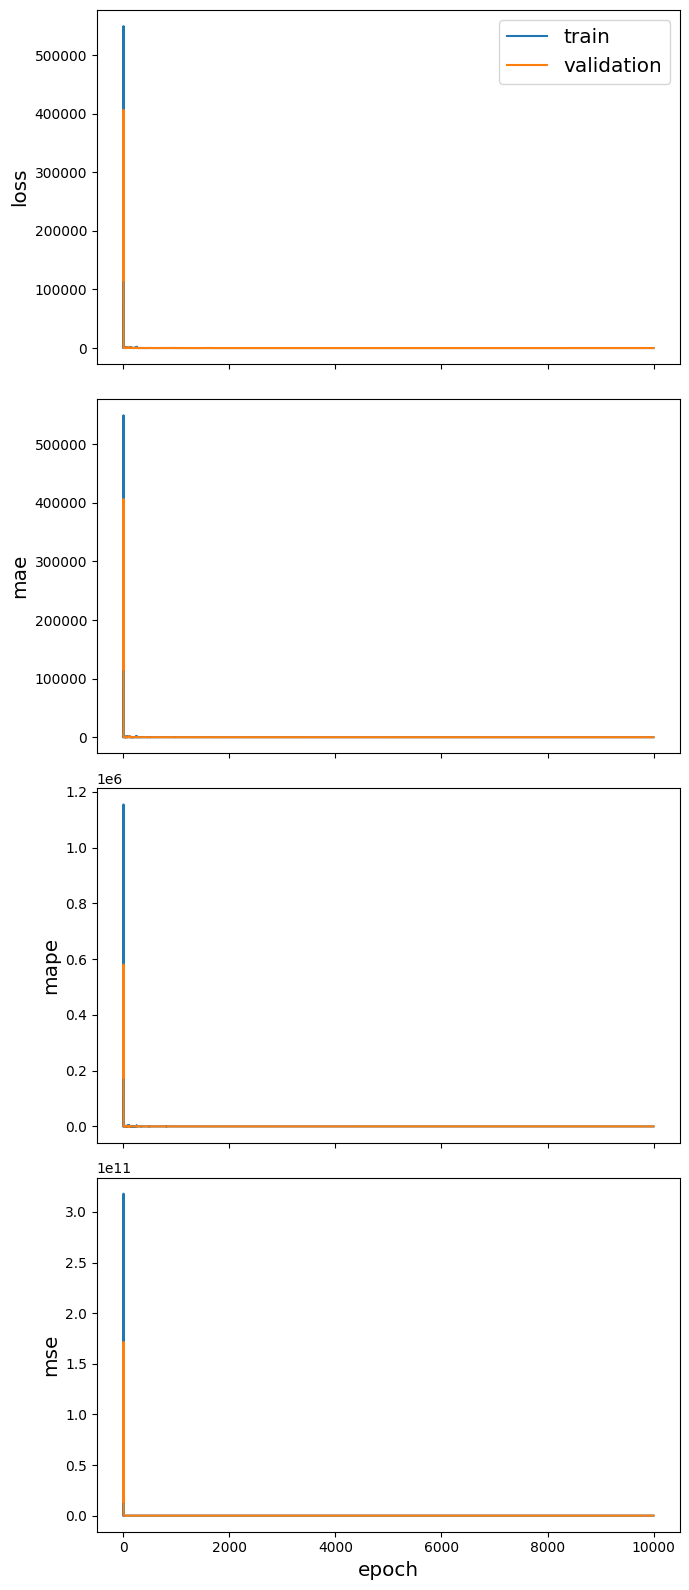

In [70]:
sg.utils.plot_history(history)

In [71]:
#val_subjects, 
#test_subjects

In [72]:
#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 39ms/step - loss: 88.3433 - mse: 13717.3516 - mape: 133.0452 - mae: 88.3433

Test Set Metrics:
	loss: 88.3433
	mse: 13717.3516
	mape: 133.0452
	mae: 88.3433


In [73]:
#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 44ms/step - loss: 0.0087 - mse: 1.0950e-04 - mape: 0.0133 - mae: 0.0087

Test Set Metrics:
	loss: 0.0087
	mse: 0.0001
	mape: 0.0133
	mae: 0.0087


In [74]:
validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 40ms/step - loss: 88.3433 - mse: 13717.3516 - mape: 133.0452 - mae: 88.3433

Test Set Metrics:
	loss: 88.3433
	mse: 13717.3516
	mape: 133.0452
	mae: 88.3433


In [75]:
df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Pearson');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[1] = temp
df_metrics

['GCN-Pearson', 88.34333801269531, 13717.3515625, 133.04518127441406, 88.34333801269531]


Method       Loss           MSE        MAPE        MAE
1  GCN-Pearson  88.343338  13717.351562  133.045181  88.343338

# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [76]:
#all_nodes = pearson_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#pearson_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
pearson_graph_node_data_test.index,  vars(test_gen),        test_predictions

1/1 [==============================] - 0s 299ms/step
72.896614
83.6409
92.33758
326.3813
35.15171
50.761173
295.14145
73.68715
119.86666
9.254604
69.19824
36.44706
66.97374
217.32086


(Index(['JPM', 'KR', 'MCK', 'MSFT', 'PCAR', 'PSX', 'T', 'UNH', 'UNP', 'VZ',
        'WBA', 'WFC', 'WMT', 'XOM'],
       dtype='object'),
 {'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD32A30>,
        dtype=object),
  'selected_ilocs': array([[1]]),
  'normalize_adj': True,
  'targets': array([[138.63000488,  29.05999947, 137.16999817, 157.58999634,
           52.64666748, 110.37000275,  29.48640442, 293.8500061 ,
          180.1499939 ,  61.20999908,  58.90999985,  53.59999847,
          119.40000153,  69.48000336]]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 78 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 108 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 64 stored elements in Compressed Sparse Row f

In [77]:
train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions

1/1 [==============================] - 0s 36ms/step
72.896614
83.6409
92.33758
326.3813
35.15171
50.761173
295.14145
73.68715
119.86666
9.254604
69.19824
36.44706
66.97374
217.32086


array([[ 72.896614,  83.6409  ,  92.33758 , 326.3813  ,  35.15171 ,
         50.761173, 295.14145 ,  73.68715 , 119.86666 ,   9.254604,
         69.19824 ,  36.44706 ,  66.97374 , 217.32086 ]], dtype=float32)

In [78]:
test_predictions

array([[ 72.896614,  83.6409  ,  92.33758 , 326.3813  ,  35.15171 ,
         50.761173, 295.14145 ,  73.68715 , 119.86666 ,   9.254604,
         69.19824 ,  36.44706 ,  66.97374 , 217.32086 ]], dtype=float32)

In [79]:
# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, pearson_graph_node_data.shape
# vars(all_gen)

In [80]:
pearson_graph_node_data

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   
JPM     87.230003   86.910004   86.110001   86.120003   86.180000   86.430000   
KR      33.720001   33.240002   33.209999   33.110001   32.919998   33.189999   
MCK    147.429993  148.580002  146.500000  146.919998  146.839996  146.820007   
MSFT    62.580002   62.299999   62.299999   62.840000   62.639999   62.619999   
PCAR    43.546665   44.146667   43.426666   43.919998   43.380001   44.166668   
PSX     86.790001   87.260002   86.739998   85.400002   84.019997   83.760002   
T       32.492447   32.303623   32.212990   31.208460   30.815710   30.823263   
UNH    161.449997  161.910004  162.179993  162.410004  161.949997  161.580002   
UNP    102.519997  103.139999  102.129997  103.190002  102.419998  103.419998   
VZ      54.580002   54.520000   54.639999   53.259998   52.680000   52.759998   
WBA     82.959999   82.980003   83.029999   83.099998   82.550003   82.669998   
WFC     56.000000   56.049999   55.180000   55.040001   54.240002   54.619999   
WMT     68.660004   69.059998   69.209999   68.260002   68.709999   68.230003   
XOM     90.889999   89.889999   88.550003   88.500000   87.040001   85.930000   

              6           7           8           9    ...         743  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC     81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA     159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.700001   
CAH     73.720001   74.190002   75.000000   75.180000  ...   53.700001   
COST   161.539993  161.869995  161.860001  163.809998  ...  293.500000   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.400002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  119.360001   
F       12.670000   12.590000   12.630000   12.610000  ...    9.390000   
GE     188.974960  188.494568  188.314423  187.773972  ...   69.758003   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.110001   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   68.035004   
HD     135.699997  135.070007  135.039993  135.929993  ...  215.529999   
JPM     87.080002   86.239998   86.699997   83.550003  ...  137.339996   
KR      33.070000   33.520000   34.099998   34.840000  ...   28.309999   
MCK    143.199997  144.679993  147.179993  148.429993  ...  142.199997   
MSFT    63.189999   62.610001   62.700001   62.529999  ...  155.529999   
PCAR    44.533333   44.220001   45.013332   44.613335  ...   55.213333   
PSX     84.889999   84.339996   83.290001   83.559998  ...  114.139999   
T       30.672205   30.974319   30.936556   31.049849  ...   29.146526   
UNH    161.889999  162.360001  161.8

****************************************************
STOP because we are testing a new model
****************************************************

# New Spearman *************************************

An exception occurred. Operation ignored
(753, 29)
StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 296

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [296]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 74

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [74]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 98

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [98]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 62

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line

{'node_features_size': 753,
 'graphs': [<stellargraph.core.graph.StellarGraph at 0x1b45cd29b50>,
 'name': None}

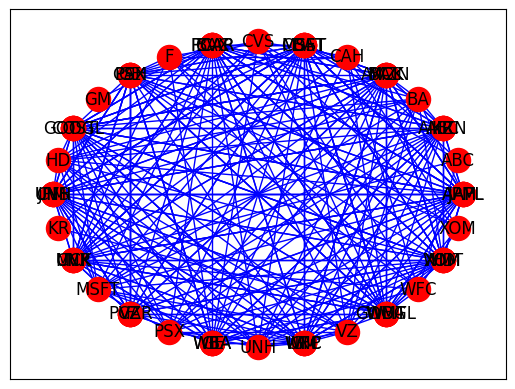

In [81]:
#!/usr/bin/env python
# coding: utf-8

# # 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.
# 
# # Input graphs were created for spearman, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.
# 
# # For the sake of making execution easier (and at once), I have kept multiple approaches (spearman, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.
# 
# # Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.
# 
# # An use case of DeepGraphCNN for Node Classification
# # https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html
# 

# # Import Libraries

# In[1]:


# import libraries
import os
import pandas as pd
import math


# In[2]:


# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN


# In[3]:


# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras


# In[4]:


# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1


# # Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

# In[5]:


df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()


# In[6]:


# You can see ANTM stock price data is empty


# # Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

# In[7]:


# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()


# In[8]:


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    


# In[9]:


df_s_transpose


# In[10]:


# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 


# In[11]:


# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]


# In[12]:


# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')


# # spearman Correlation Coefficient

# In[13]:


df_s_transpose_spearman = df_s_transpose.corr(method = 'spearman', numeric_only = True)
df_s_transpose_spearman


# # spearman Correlation Coefficient based Adjacency Graph Matrix

# In[14]:


df_s_transpose_spearman[df_s_transpose_spearman >= 0.4] = 1
df_s_transpose_spearman[df_s_transpose_spearman < 0.4] = 0
df_s_transpose_spearman


# In[15]:


# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_spearman.values, 0)
df_s_transpose_spearman


# Create and visualize the Graphs

# In[17]:


import networkx as nx
Graph_spearman = nx.Graph(df_s_transpose_spearman)


# In[18]:


nx.draw_networkx(Graph_spearman, pos = nx.circular_layout( Graph_spearman ), node_color = 'r', edge_color = 'b')


# # Experiment, we will divide the data into train, test, and validation graphs

# In[19]:


df_s_transpose.corr(method = 'spearman', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


# In[20]:


# Train Graph


# In[21]:


df_s_spearman_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_spearman_train = df_s_spearman_train.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_train.values, 0)

df_s_transpose_spearman_train[df_s_transpose_spearman_train >= 0.4] = 1
df_s_transpose_spearman_train[df_s_transpose_spearman_train < 0.4] = 0
df_s_transpose_spearman_train

df_s_transpose_spearman_train


# # Test Graph

# In[22]:


df_s_spearman_test = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 15:23]
df_s_transpose_spearman_test = df_s_spearman_test.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_test.values, 0)

df_s_transpose_spearman_train[df_s_transpose_spearman_test >= 0.4] = 1
df_s_transpose_spearman_train[df_s_transpose_spearman_test < 0.4] = 0
df_s_transpose_spearman_test


# # Validation Graph

# In[23]:


df_s_spearman_validation = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 23:]
df_s_transpose_spearman_validation = df_s_spearman_validation.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_validation.values, 0)
df_s_transpose_spearman_validation

df_s_transpose_spearman_validation[df_s_transpose_spearman_validation >= 0.4] = 1
df_s_transpose_spearman_validation[df_s_transpose_spearman_validation < 0.4] = 0
df_s_transpose_spearman_validation


# In[24]:


graph_spearman_train = nx.Graph(df_s_transpose_spearman_train)
graph_spearman_test = nx.Graph(df_s_transpose_spearman_test)
graph_spearman_validation = nx.Graph(df_s_transpose_spearman_validation)


nx.draw_networkx(graph_spearman_train, pos = nx.circular_layout( graph_spearman_train ), node_color = 'r', edge_color = 'b')


# In[25]:


df_s_spearman_train.corr(numeric_only = True)


# In[26]:


nx.draw_networkx(graph_spearman_test, pos = nx.circular_layout( graph_spearman_test ), node_color = 'r', edge_color = 'b')


# In[27]:


nx.draw_networkx(graph_spearman_validation, pos = nx.circular_layout( graph_spearman_validation ), node_color = 'r', edge_color = 'b')


# # Create GCN layer. spearman

# # Find all stocks = nodes

# In[28]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_spearman.index.to_list()
all_stock_nodes[:5]


# # Find all edges between nodes
# 
# This may need adjustment to reflect train, test, validation graphs

# In[29]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_spearman[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            


# # Find all edges in Train, Test, and Validation Graphs

# In[30]:


trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_spearman_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_spearman_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_spearman_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_spearman_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_spearman_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_spearman_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_spearman[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature


# # Create variables to create stellar graph
# # Edges

# In[31]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
spearman_edges = pd.DataFrame(
    {"source": source, "target": target}
)

spearman_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
spearman_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

spearman_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

spearman_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

spearman_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


spearman_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


spearman_edges_train[:10]


# # Have the time series data as part of the nodes

# # Structure the Feature Matrix so that it can be passed to the GCN

# In[32]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values


# In[33]:


len(all_stock_nodes)


# In[34]:


# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[35]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
spearman_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
spearman_graph_node_data.head()


# In[36]:


node_Data[14:15], 
len(validationNodeList)
len(testNodeList)


# In[37]:


# Node time series data based on train, test, validation graph


# In[38]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
spearman_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
spearman_graph_node_data_train.head()

spearman_graph_node_data_test = pd.DataFrame(node_Data[14:], index = testNodeList) #pd.DataFrame(node_Data[15:23], index = testNodeList)
spearman_graph_node_data_test.head()

spearman_graph_node_data_validation = pd.DataFrame(node_Data[14:], index = validationNodeList) #pd.DataFrame(node_Data[22:30], index = validationNodeList)
spearman_graph_node_data_validation.head()



# In[39]:


spearman_graph_node_data_train


# # Graph (stellar) with features as part of Nodes

# In[40]:


# Overall
spearman_graph_with_node_features = StellarGraph(spearman_graph_node_data, edges = spearman_edges, node_type_default = "corner", edge_type_default = "line")
print(spearman_graph_with_node_features.info())

# train nodes
spearman_train_graph_with_node_features = StellarGraph(spearman_graph_node_data_train, edges = spearman_edges_train, node_type_default = "corner", edge_type_default = "line")
print(spearman_train_graph_with_node_features.info())

# test
spearman_test_graph_with_node_features = StellarGraph(spearman_graph_node_data_test, edges = spearman_edges_test, node_type_default = "corner", edge_type_default = "line")
print(spearman_test_graph_with_node_features.info())

# validation
spearman_validation_graph_with_node_features = StellarGraph(spearman_graph_node_data_validation, edges = spearman_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(spearman_validation_graph_with_node_features.info())


# # Adapting everything for DeepGraphCNN

# In[41]:


spearman_graph_node_data.iloc[0:15, :]


# # Graphs to be jused for DeepGraphCNN

# In[42]:


graphs = list()
#graphs.append(spearman_graph_with_node_features)
graphs.append(spearman_train_graph_with_node_features)
graphs.append(spearman_test_graph_with_node_features)
graphs.append(spearman_validation_graph_with_node_features)


# In[43]:


summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()


# In[44]:


# graph_labels = all_stock_nodes


# In[45]:


# Generator
#generator = FullBatchNodeGenerator(spearman_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( spearman_graph_with_node_features)


# In[46]:


vars(generator)


# # Train Test Split

# # Commented out on 2023-04-18
# train_subjects, test_subjects = model_selection.train_test_split(
#     spearman_graph_node_data 
# )
# 
# val_subjects, test_subjects_step_2 = model_selection.train_test_split(
#     test_subjects 
# )
# 
# #, train_size = 500, test_size = None, stratify = test_subjects
# 
# train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

# In[98]:




In [82]:
train_subjects = spearman_graph_node_data_train.iloc[:,0:751];
test_subjects = spearman_graph_node_data_test.iloc[:,0:751];
val_subjects = spearman_graph_node_data_validation.iloc[:,0:751];


# In[104]:


spearman_graph_node_data_train.iloc[:,0:751]


# In[49]:


# Commented out on 2023-04-18
#train_targets = train_subjects; 
#val_targets = val_subjects; 
#test_targets = test_subjects; 


# # The Model for all of the approaches utilized in this file
# # Model for spearman, Spearman, Kendal Tau, Financial News Based prediction

# # Models : DeepGraph CNN

# In[50]:


#epochs_to_test = 1000
#patience_to_test = 1000


# In[51]:


# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out


# In[52]:


# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    


# In[53]:


#train_targets.index


# In[54]:


x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = 14, activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)


# In[55]:


#len(train_targets)


# In[56]:




In [83]:
# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)


# # Commented out on 2023-04-18
# 
# # hard coded size adjustments
# #test_subjects_ = test_subjects[:len(val_subjects)]
# 
# #val_gen = generator.flow(val_subjects.index, test_subjects_)
# #train_gen[1], val_gen[1]
# #val_gen[4]

# #  Multiple Graph Version Starts

# In[57]:


vars(graphs[0])


# In[92]:




{'_is_directed': False,
 '_nodes': <stellargraph.core.element_data.NodeData at 0x1b45cc6cbb0>,
 '_edges': <stellargraph.core.element_data.EdgeData at 0x1b45cc6ce20>}

In [84]:
train_subjects
list(spearman_graph_node_data_train.iloc[:,752]), list(spearman_graph_node_data_test.iloc[:,752]), list(spearman_graph_node_data_validation.iloc[:,752])
#list(train_subjects.iloc[:,751])

([72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372],
 [138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336],
 [138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336])

In [85]:



# In[59]:


x = [[72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372]]

train_target = [[72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372]]


# In[60]:


test_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


validation_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


valid_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


# In[61]:


validation_target


# In[62]:


x


# In[63]:


# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = train_target, #list(train_target), #[0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = test_target, #[1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = validation_target, #[2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)


#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];


# In[64]:


'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''


# In[65]:


vars(train_gen)


# In[66]:


vars(test_gen)


# In[67]:


vars(val_gen)
#train_subjects
#train_subjects.values


# In[68]:


vars(train_gen), 
#train_subjects
#train_subjects.values


# train_subjects, test_gen

# In[69]:


#train_gen, data_valid, train_gen_data


# In[70]:




({'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CD29B50>,
        dtype=object),
  'selected_ilocs': array([[0]]),
  'normalize_adj': True,
  'targets': array([[ 72.87999725,  83.63999939,  92.34449768, 326.3999939 ,
           35.15000153,  50.77000046, 295.14001465,  73.69999695,
          119.84999847,   9.25      ,  69.19593811,  36.43999863,
           66.98549652, 217.30999756]]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 88 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 112 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 76 stored elements in Compressed Sparse Row format>],
        dtype=object),
  '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages

In [86]:
# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 2, validation_data = test_gen, shuffle = False,
)


# In[71]:




Epoch 1/10000
1/1 - 2s - loss: 112.0843 - mse: 21604.6504 - mape: 111.5863 - mae: 112.0843 - val_loss: 62035.0430 - val_mse: 4931358720.0000 - val_mape: 101452.4219 - val_mae: 62035.0430 - 2s/epoch - 2s/step
Epoch 2/10000
1/1 - 0s - loss: 43307.3164 - mse: 2906427648.0000 - mape: 115000.3203 - mae: 43307.3164 - val_loss: 508192.2500 - val_mse: 274472599552.0000 - val_mape: 724323.5625 - val_mae: 508192.2500 - 45ms/epoch - 45ms/step
Epoch 3/10000
1/1 - 0s - loss: 738273.6875 - mse: 599846813696.0000 - mape: 1616817.1250 - mae: 738273.6875 - val_loss: 253751.0312 - val_mse: 107751997440.0000 - val_mape: 287415.5000 - val_mae: 253751.0312 - 48ms/epoch - 48ms/step
Epoch 4/10000
1/1 - 0s - loss: 200951.7969 - mse: 68823072768.0000 - mape: 319344.6875 - mae: 200951.7969 - val_loss: 449587.7812 - val_mse: 242989367296.0000 - val_mape: 677726.1875 - val_mae: 449587.7812 - 47ms/epoch - 47ms/step
Epoch 5/10000
1/1 - 0s - loss: 547730.1875 - mse: 345637552128.0000 - mape: 1115043.1250 - mae: 5477

Epoch 42/10000
1/1 - 0s - loss: 139.6515 - mse: 25145.7930 - mape: 341.1398 - mae: 139.6515 - val_loss: 226.9834 - val_mse: 67619.4141 - val_mape: 333.5812 - val_mae: 226.9834 - 45ms/epoch - 45ms/step
Epoch 43/10000
1/1 - 0s - loss: 205.4072 - mse: 54108.9805 - mape: 482.7393 - mae: 205.4072 - val_loss: 207.6008 - val_mse: 70714.5859 - val_mape: 321.0475 - val_mae: 207.6008 - 47ms/epoch - 47ms/step
Epoch 44/10000
1/1 - 0s - loss: 168.9883 - mse: 48658.7852 - mape: 442.8847 - mae: 168.9883 - val_loss: 222.8084 - val_mse: 92498.2109 - val_mape: 409.7268 - val_mae: 222.8084 - 45ms/epoch - 45ms/step
Epoch 45/10000
1/1 - 0s - loss: 653.8717 - mse: 500491.0938 - mape: 1101.9788 - mae: 653.8717 - val_loss: 185.1072 - val_mse: 65375.4180 - val_mape: 334.6336 - val_mae: 185.1072 - 43ms/epoch - 43ms/step
Epoch 46/10000
1/1 - 0s - loss: 228.1602 - mse: 121993.9141 - mape: 426.7816 - mae: 228.1602 - val_loss: 155.6713 - val_mse: 41962.0078 - val_mape: 257.3790 - val_mae: 155.6713 - 45ms/epoch - 45

1/1 - 0s - loss: 38.9696 - mse: 2487.0591 - mape: 112.7077 - mae: 38.9696 - val_loss: 80.9009 - val_mse: 10622.5986 - val_mape: 94.0288 - val_mae: 80.9009 - 44ms/epoch - 44ms/step
Epoch 84/10000
1/1 - 0s - loss: 117.3995 - mse: 19188.8887 - mape: 135.8318 - mae: 117.3995 - val_loss: 85.5079 - val_mse: 11639.4844 - val_mape: 104.2021 - val_mae: 85.5079 - 46ms/epoch - 46ms/step
Epoch 85/10000
1/1 - 0s - loss: 48.0584 - mse: 3694.0366 - mape: 93.4846 - mae: 48.0584 - val_loss: 93.2279 - val_mse: 12848.6592 - val_mape: 118.5778 - val_mae: 93.2279 - 44ms/epoch - 44ms/step
Epoch 86/10000
1/1 - 0s - loss: 47.1091 - mse: 3342.1284 - mape: 65.1740 - mae: 47.1091 - val_loss: 103.3400 - val_mse: 14281.7920 - val_mape: 135.0407 - val_mae: 103.3400 - 48ms/epoch - 48ms/step
Epoch 87/10000
1/1 - 0s - loss: 47.0459 - mse: 3674.5933 - mape: 65.5265 - mae: 47.0459 - val_loss: 104.4232 - val_mse: 13707.2656 - val_mape: 135.0288 - val_mae: 104.4232 - 42ms/epoch - 42ms/step
Epoch 88/10000
1/1 - 0s - loss: 

Epoch 125/10000
1/1 - 0s - loss: 151.5720 - mse: 36725.0273 - mape: 350.5989 - mae: 151.5720 - val_loss: 85.7699 - val_mse: 12368.0537 - val_mape: 133.8754 - val_mae: 85.7699 - 47ms/epoch - 47ms/step
Epoch 126/10000
1/1 - 0s - loss: 100.3508 - mse: 14566.6729 - mape: 169.2198 - mae: 100.3508 - val_loss: 88.4983 - val_mse: 12571.3340 - val_mape: 131.6186 - val_mae: 88.4983 - 45ms/epoch - 45ms/step
Epoch 127/10000
1/1 - 0s - loss: 117.0730 - mse: 20653.4844 - mape: 180.5347 - mae: 117.0730 - val_loss: 91.5532 - val_mse: 13373.2002 - val_mape: 131.0742 - val_mae: 91.5532 - 46ms/epoch - 46ms/step
Epoch 128/10000
1/1 - 0s - loss: 110.7334 - mse: 27211.8027 - mape: 262.4462 - mae: 110.7334 - val_loss: 92.0784 - val_mse: 13818.0605 - val_mape: 127.4015 - val_mae: 92.0784 - 45ms/epoch - 45ms/step
Epoch 129/10000
1/1 - 0s - loss: 43.2904 - mse: 4304.0298 - mape: 59.4272 - mae: 43.2904 - val_loss: 95.1650 - val_mse: 14658.1943 - val_mape: 129.4007 - val_mae: 95.1650 - 46ms/epoch - 46ms/step
Epoc

Epoch 167/10000
1/1 - 0s - loss: 67.3690 - mse: 9227.8027 - mape: 70.5822 - mae: 67.3690 - val_loss: 62.8403 - val_mse: 7715.4268 - val_mape: 66.6300 - val_mae: 62.8403 - 46ms/epoch - 46ms/step
Epoch 168/10000
1/1 - 0s - loss: 114.0326 - mse: 17875.5566 - mape: 137.3061 - mae: 114.0326 - val_loss: 69.3376 - val_mse: 9001.3477 - val_mape: 74.1886 - val_mae: 69.3376 - 43ms/epoch - 43ms/step
Epoch 169/10000
1/1 - 0s - loss: 79.4633 - mse: 7947.9419 - mape: 119.0702 - mae: 79.4633 - val_loss: 72.4282 - val_mse: 9597.2500 - val_mape: 80.8127 - val_mae: 72.4282 - 43ms/epoch - 43ms/step
Epoch 170/10000
1/1 - 0s - loss: 94.0080 - mse: 10618.7803 - mape: 130.2452 - mae: 94.0080 - val_loss: 71.7172 - val_mse: 9893.6182 - val_mape: 87.5219 - val_mae: 71.7172 - 44ms/epoch - 44ms/step
Epoch 171/10000
1/1 - 0s - loss: 35.3801 - mse: 2048.7185 - mape: 97.6273 - mae: 35.3801 - val_loss: 75.9680 - val_mse: 10917.2969 - val_mape: 102.2776 - val_mae: 75.9680 - 45ms/epoch - 45ms/step
Epoch 172/10000
1/1 -

Epoch 209/10000
1/1 - 0s - loss: 65.4042 - mse: 10319.1807 - mape: 113.1549 - mae: 65.4042 - val_loss: 72.7829 - val_mse: 7851.3774 - val_mape: 104.4099 - val_mae: 72.7829 - 44ms/epoch - 44ms/step
Epoch 210/10000
1/1 - 0s - loss: 40.4969 - mse: 3302.8733 - mape: 77.4894 - mae: 40.4969 - val_loss: 70.8938 - val_mse: 7492.4771 - val_mape: 102.4573 - val_mae: 70.8938 - 44ms/epoch - 44ms/step
Epoch 211/10000
1/1 - 0s - loss: 50.7307 - mse: 3272.6050 - mape: 87.4289 - mae: 50.7307 - val_loss: 70.5022 - val_mse: 7381.7729 - val_mape: 102.6706 - val_mae: 70.5022 - 45ms/epoch - 45ms/step
Epoch 212/10000
1/1 - 0s - loss: 81.5485 - mse: 9489.4658 - mape: 165.9379 - mae: 81.5485 - val_loss: 70.9605 - val_mse: 7334.4570 - val_mape: 102.2043 - val_mae: 70.9605 - 43ms/epoch - 43ms/step
Epoch 213/10000
1/1 - 0s - loss: 37.8263 - mse: 2428.6497 - mape: 51.7252 - mae: 37.8263 - val_loss: 71.8125 - val_mse: 7450.4565 - val_mape: 102.9878 - val_mae: 71.8125 - 45ms/epoch - 45ms/step
Epoch 214/10000
1/1 - 

Epoch 251/10000
1/1 - 0s - loss: 60.7534 - mse: 7856.2397 - mape: 55.5420 - mae: 60.7534 - val_loss: 70.9933 - val_mse: 10149.5986 - val_mape: 75.6159 - val_mae: 70.9933 - 53ms/epoch - 53ms/step
Epoch 252/10000
1/1 - 0s - loss: 48.6299 - mse: 4812.3052 - mape: 70.0888 - mae: 48.6299 - val_loss: 71.5958 - val_mse: 10208.2207 - val_mape: 80.7547 - val_mae: 71.5958 - 54ms/epoch - 54ms/step
Epoch 253/10000
1/1 - 0s - loss: 64.5907 - mse: 9288.5186 - mape: 127.0810 - mae: 64.5907 - val_loss: 72.4957 - val_mse: 10358.0986 - val_mape: 86.1998 - val_mae: 72.4957 - 60ms/epoch - 60ms/step
Epoch 254/10000
1/1 - 0s - loss: 77.5180 - mse: 9777.2314 - mape: 135.5583 - mae: 77.5180 - val_loss: 73.2701 - val_mse: 10245.9150 - val_mape: 90.0487 - val_mae: 73.2701 - 56ms/epoch - 56ms/step
Epoch 255/10000
1/1 - 0s - loss: 61.2236 - mse: 9442.5068 - mape: 103.9275 - mae: 61.2236 - val_loss: 74.1745 - val_mse: 10236.2637 - val_mape: 94.1298 - val_mae: 74.1745 - 57ms/epoch - 57ms/step
Epoch 256/10000
1/1 - 

Epoch 293/10000
1/1 - 0s - loss: 73.6504 - mse: 8690.3926 - mape: 143.4706 - mae: 73.6504 - val_loss: 75.5033 - val_mse: 9426.2090 - val_mape: 98.6245 - val_mae: 75.5033 - 45ms/epoch - 45ms/step
Epoch 294/10000
1/1 - 0s - loss: 30.4330 - mse: 1176.9238 - mape: 60.4481 - mae: 30.4330 - val_loss: 80.3680 - val_mse: 10514.8926 - val_mape: 106.0113 - val_mae: 80.3680 - 43ms/epoch - 43ms/step
Epoch 295/10000
1/1 - 0s - loss: 50.1281 - mse: 4844.3242 - mape: 126.5755 - mae: 50.1281 - val_loss: 84.9674 - val_mse: 11625.3652 - val_mape: 113.6477 - val_mae: 84.9674 - 48ms/epoch - 48ms/step
Epoch 296/10000
1/1 - 0s - loss: 75.0656 - mse: 7114.4829 - mape: 159.4993 - mae: 75.0656 - val_loss: 82.4185 - val_mse: 11059.6963 - val_mape: 111.3800 - val_mae: 82.4185 - 48ms/epoch - 48ms/step
Epoch 297/10000
1/1 - 0s - loss: 40.4429 - mse: 3175.3535 - mape: 80.8535 - mae: 40.4429 - val_loss: 82.2856 - val_mse: 11017.3643 - val_mape: 111.8076 - val_mae: 82.2856 - 44ms/epoch - 44ms/step
Epoch 298/10000
1/1

Epoch 335/10000
1/1 - 0s - loss: 73.4924 - mse: 10059.6113 - mape: 72.8594 - mae: 73.4924 - val_loss: 69.3057 - val_mse: 8575.3320 - val_mape: 76.7530 - val_mae: 69.3057 - 46ms/epoch - 46ms/step
Epoch 336/10000
1/1 - 0s - loss: 67.2770 - mse: 8993.6045 - mape: 68.6430 - mae: 67.2770 - val_loss: 67.1533 - val_mse: 8190.6592 - val_mape: 76.4467 - val_mae: 67.1533 - 43ms/epoch - 43ms/step
Epoch 337/10000
1/1 - 0s - loss: 55.0389 - mse: 7608.0581 - mape: 68.5975 - mae: 55.0389 - val_loss: 66.6146 - val_mse: 8030.8794 - val_mape: 77.0500 - val_mae: 66.6146 - 44ms/epoch - 44ms/step
Epoch 338/10000
1/1 - 0s - loss: 29.2272 - mse: 2003.8445 - mape: 37.2074 - mae: 29.2272 - val_loss: 66.8158 - val_mse: 7962.2271 - val_mape: 79.3726 - val_mae: 66.8158 - 46ms/epoch - 46ms/step
Epoch 339/10000
1/1 - 0s - loss: 43.3674 - mse: 3765.6301 - mape: 47.7099 - mae: 43.3674 - val_loss: 67.5496 - val_mse: 7944.4097 - val_mape: 83.1719 - val_mae: 67.5496 - 44ms/epoch - 44ms/step
Epoch 340/10000
1/1 - 0s - lo

1/1 - 0s - loss: 29.5504 - mse: 1415.5458 - mape: 56.4715 - mae: 29.5504 - val_loss: 86.6388 - val_mse: 14377.7002 - val_mape: 149.1756 - val_mae: 86.6388 - 46ms/epoch - 46ms/step
Epoch 378/10000
1/1 - 0s - loss: 41.0984 - mse: 2461.6238 - mape: 51.1063 - mae: 41.0984 - val_loss: 91.2061 - val_mse: 15767.7754 - val_mape: 157.8018 - val_mae: 91.2061 - 42ms/epoch - 42ms/step
Epoch 379/10000
1/1 - 0s - loss: 100.6226 - mse: 12605.8301 - mape: 235.0204 - mae: 100.6226 - val_loss: 90.7269 - val_mse: 16235.1562 - val_mape: 155.0081 - val_mae: 90.7269 - 43ms/epoch - 43ms/step
Epoch 380/10000
1/1 - 0s - loss: 28.6991 - mse: 1743.0811 - mape: 63.9892 - mae: 28.6991 - val_loss: 89.5859 - val_mse: 16756.6836 - val_mape: 150.0050 - val_mae: 89.5859 - 44ms/epoch - 44ms/step
Epoch 381/10000
1/1 - 0s - loss: 49.7431 - mse: 3755.1948 - mape: 102.5459 - mae: 49.7431 - val_loss: 96.1794 - val_mse: 17404.4648 - val_mape: 143.7302 - val_mae: 96.1794 - 42ms/epoch - 42ms/step
Epoch 382/10000
1/1 - 0s - loss

Epoch 419/10000
1/1 - 0s - loss: 51.6181 - mse: 6118.4595 - mape: 39.9829 - mae: 51.6181 - val_loss: 68.7239 - val_mse: 8181.0264 - val_mape: 85.9502 - val_mae: 68.7239 - 43ms/epoch - 43ms/step
Epoch 420/10000
1/1 - 0s - loss: 29.6548 - mse: 1107.5852 - mape: 54.6394 - mae: 29.6548 - val_loss: 70.1063 - val_mse: 8270.2051 - val_mape: 86.8090 - val_mae: 70.1063 - 42ms/epoch - 42ms/step
Epoch 421/10000
1/1 - 0s - loss: 47.1433 - mse: 5839.2539 - mape: 40.1841 - mae: 47.1433 - val_loss: 70.7240 - val_mse: 8314.1074 - val_mape: 86.9159 - val_mae: 70.7240 - 42ms/epoch - 42ms/step
Epoch 422/10000
1/1 - 0s - loss: 33.2232 - mse: 1957.8474 - mape: 59.1794 - mae: 33.2232 - val_loss: 73.1932 - val_mse: 8665.8184 - val_mape: 90.2392 - val_mae: 73.1932 - 42ms/epoch - 42ms/step
Epoch 423/10000
1/1 - 0s - loss: 58.4170 - mse: 8263.8633 - mape: 56.0100 - mae: 58.4170 - val_loss: 74.4004 - val_mse: 8874.4219 - val_mape: 92.6207 - val_mae: 74.4004 - 41ms/epoch - 41ms/step
Epoch 424/10000
1/1 - 0s - los

1/1 - 0s - loss: 31.2044 - mse: 1307.7947 - mape: 48.3908 - mae: 31.2044 - val_loss: 77.7655 - val_mse: 9976.6572 - val_mape: 110.5877 - val_mae: 77.7655 - 43ms/epoch - 43ms/step
Epoch 462/10000
1/1 - 0s - loss: 43.7087 - mse: 5215.0947 - mape: 42.2621 - mae: 43.7087 - val_loss: 77.7081 - val_mse: 9879.4473 - val_mape: 108.8635 - val_mae: 77.7081 - 44ms/epoch - 44ms/step
Epoch 463/10000
1/1 - 0s - loss: 65.7978 - mse: 9653.5469 - mape: 71.2684 - mae: 65.7978 - val_loss: 77.5213 - val_mse: 9868.5986 - val_mape: 108.7034 - val_mae: 77.5213 - 42ms/epoch - 42ms/step
Epoch 464/10000
1/1 - 0s - loss: 60.7064 - mse: 6500.7710 - mape: 68.3055 - mae: 60.7064 - val_loss: 77.7076 - val_mse: 9885.4707 - val_mape: 108.7863 - val_mae: 77.7076 - 43ms/epoch - 43ms/step
Epoch 465/10000
1/1 - 0s - loss: 52.1332 - mse: 3904.1594 - mape: 64.6664 - mae: 52.1332 - val_loss: 78.1255 - val_mse: 9970.8799 - val_mape: 109.3419 - val_mae: 78.1255 - 46ms/epoch - 46ms/step
Epoch 466/10000
1/1 - 0s - loss: 20.0212 

Epoch 504/10000
1/1 - 0s - loss: 43.6251 - mse: 3405.9333 - mape: 101.6403 - mae: 43.6251 - val_loss: 78.5947 - val_mse: 10255.9238 - val_mape: 105.4327 - val_mae: 78.5947 - 42ms/epoch - 42ms/step
Epoch 505/10000
1/1 - 0s - loss: 25.4387 - mse: 811.2377 - mape: 58.1164 - mae: 25.4387 - val_loss: 77.0303 - val_mse: 9668.8828 - val_mape: 103.6020 - val_mae: 77.0303 - 43ms/epoch - 43ms/step
Epoch 506/10000
1/1 - 0s - loss: 20.2445 - mse: 615.2028 - mape: 58.8321 - mae: 20.2445 - val_loss: 77.1754 - val_mse: 9547.9170 - val_mape: 103.7791 - val_mae: 77.1754 - 43ms/epoch - 43ms/step
Epoch 507/10000
1/1 - 0s - loss: 49.2627 - mse: 5146.9868 - mape: 59.9369 - mae: 49.2627 - val_loss: 77.8490 - val_mse: 9800.7764 - val_mape: 106.5146 - val_mae: 77.8490 - 45ms/epoch - 45ms/step
Epoch 508/10000
1/1 - 0s - loss: 43.4236 - mse: 5417.0532 - mape: 36.3155 - mae: 43.4236 - val_loss: 80.7003 - val_mse: 10580.8975 - val_mape: 112.0615 - val_mae: 80.7003 - 44ms/epoch - 44ms/step
Epoch 509/10000
1/1 - 0s

1/1 - 0s - loss: 55.7137 - mse: 5318.7485 - mape: 53.4567 - mae: 55.7137 - val_loss: 68.7647 - val_mse: 7946.3320 - val_mape: 79.9202 - val_mae: 68.7647 - 54ms/epoch - 54ms/step
Epoch 547/10000
1/1 - 0s - loss: 42.4837 - mse: 3266.7976 - mape: 60.4932 - mae: 42.4837 - val_loss: 70.2895 - val_mse: 8100.1284 - val_mape: 81.8942 - val_mae: 70.2895 - 57ms/epoch - 57ms/step
Epoch 548/10000
1/1 - 0s - loss: 70.2658 - mse: 8292.4775 - mape: 78.3760 - mae: 70.2658 - val_loss: 70.2825 - val_mse: 8061.8647 - val_mape: 84.1440 - val_mae: 70.2825 - 60ms/epoch - 60ms/step
Epoch 549/10000
1/1 - 0s - loss: 47.2514 - mse: 5822.3706 - mape: 34.3394 - mae: 47.2514 - val_loss: 70.1321 - val_mse: 8049.2026 - val_mape: 86.9113 - val_mae: 70.1321 - 58ms/epoch - 58ms/step
Epoch 550/10000
1/1 - 0s - loss: 52.0425 - mse: 3057.0239 - mape: 112.9634 - mae: 52.0425 - val_loss: 71.4530 - val_mse: 8551.8311 - val_mape: 100.0702 - val_mae: 71.4530 - 52ms/epoch - 52ms/step
Epoch 551/10000
1/1 - 0s - loss: 21.8205 - m

Epoch 588/10000
1/1 - 0s - loss: 234.0275 - mse: 57029.0664 - mape: 515.3019 - mae: 234.0275 - val_loss: 99.3325 - val_mse: 13672.0225 - val_mape: 128.0182 - val_mae: 99.3325 - 42ms/epoch - 42ms/step
Epoch 589/10000
1/1 - 0s - loss: 65.5093 - mse: 5584.3291 - mape: 113.3580 - mae: 65.5093 - val_loss: 87.5318 - val_mse: 11834.3203 - val_mape: 132.4528 - val_mae: 87.5318 - 44ms/epoch - 44ms/step
Epoch 590/10000
1/1 - 0s - loss: 33.1716 - mse: 1443.6833 - mape: 70.6514 - mae: 33.1716 - val_loss: 86.3890 - val_mse: 12084.5234 - val_mape: 134.0449 - val_mae: 86.3890 - 42ms/epoch - 42ms/step
Epoch 591/10000
1/1 - 0s - loss: 35.7277 - mse: 1718.5706 - mape: 48.6023 - mae: 35.7277 - val_loss: 100.5965 - val_mse: 15328.0752 - val_mape: 135.0242 - val_mae: 100.5965 - 43ms/epoch - 43ms/step
Epoch 592/10000
1/1 - 0s - loss: 39.4413 - mse: 2165.6458 - mape: 64.9830 - mae: 39.4413 - val_loss: 224.2234 - val_mse: 69292.6719 - val_mape: 285.8687 - val_mae: 224.2234 - 44ms/epoch - 44ms/step
Epoch 593/1

Epoch 630/10000
1/1 - 0s - loss: 26.7536 - mse: 1086.9574 - mape: 36.7535 - mae: 26.7536 - val_loss: 72.6403 - val_mse: 8672.0996 - val_mape: 95.1712 - val_mae: 72.6403 - 42ms/epoch - 42ms/step
Epoch 631/10000
1/1 - 0s - loss: 42.5539 - mse: 3650.2688 - mape: 50.2705 - mae: 42.5539 - val_loss: 72.7333 - val_mse: 8731.9102 - val_mape: 95.8097 - val_mae: 72.7333 - 42ms/epoch - 42ms/step
Epoch 632/10000
1/1 - 0s - loss: 46.6318 - mse: 5702.3901 - mape: 35.7253 - mae: 46.6318 - val_loss: 72.8320 - val_mse: 8844.7275 - val_mape: 97.3152 - val_mae: 72.8320 - 45ms/epoch - 45ms/step
Epoch 633/10000
1/1 - 0s - loss: 21.8401 - mse: 1034.9128 - mape: 16.6790 - mae: 21.8401 - val_loss: 74.3745 - val_mse: 9559.6973 - val_mape: 105.5147 - val_mae: 74.3745 - 43ms/epoch - 43ms/step
Epoch 634/10000
1/1 - 0s - loss: 63.8372 - mse: 9050.8682 - mape: 56.6493 - mae: 63.8372 - val_loss: 77.8439 - val_mse: 11167.1709 - val_mape: 118.8134 - val_mae: 77.8439 - 41ms/epoch - 41ms/step
Epoch 635/10000
1/1 - 0s - 

1/1 - 0s - loss: 40.9661 - mse: 4699.9990 - mape: 39.2794 - mae: 40.9661 - val_loss: 74.2579 - val_mse: 9091.9990 - val_mape: 103.9909 - val_mae: 74.2579 - 43ms/epoch - 43ms/step
Epoch 673/10000
1/1 - 0s - loss: 40.4272 - mse: 4618.2700 - mape: 42.3142 - mae: 40.4272 - val_loss: 73.3443 - val_mse: 8918.8525 - val_mape: 102.6420 - val_mae: 73.3443 - 44ms/epoch - 44ms/step
Epoch 674/10000
1/1 - 0s - loss: 57.8724 - mse: 8660.8740 - mape: 62.9464 - mae: 57.8724 - val_loss: 72.4170 - val_mse: 8733.3877 - val_mape: 100.7747 - val_mae: 72.4170 - 44ms/epoch - 44ms/step
Epoch 675/10000
1/1 - 0s - loss: 43.9753 - mse: 3395.4739 - mape: 52.3148 - mae: 43.9753 - val_loss: 74.5991 - val_mse: 9291.9756 - val_mape: 106.7492 - val_mae: 74.5991 - 43ms/epoch - 43ms/step
Epoch 676/10000
1/1 - 0s - loss: 56.6476 - mse: 7166.4531 - mape: 62.8208 - mae: 56.6476 - val_loss: 80.2288 - val_mse: 11317.0049 - val_mape: 123.0970 - val_mae: 80.2288 - 43ms/epoch - 43ms/step
Epoch 677/10000
1/1 - 0s - loss: 36.1282

Epoch 714/10000
1/1 - 0s - loss: 70.6552 - mse: 10806.3838 - mape: 60.4252 - mae: 70.6552 - val_loss: 78.0498 - val_mse: 9453.7793 - val_mape: 103.2164 - val_mae: 78.0498 - 48ms/epoch - 48ms/step
Epoch 715/10000
1/1 - 0s - loss: 19.9345 - mse: 724.4951 - mape: 30.6391 - mae: 19.9345 - val_loss: 78.3936 - val_mse: 9537.8105 - val_mape: 103.7797 - val_mae: 78.3936 - 49ms/epoch - 49ms/step
Epoch 716/10000
1/1 - 0s - loss: 34.4513 - mse: 3025.3188 - mape: 27.9488 - mae: 34.4513 - val_loss: 78.6458 - val_mse: 9617.9971 - val_mape: 105.8473 - val_mae: 78.6458 - 46ms/epoch - 46ms/step
Epoch 717/10000
1/1 - 0s - loss: 61.5652 - mse: 9470.8301 - mape: 45.1622 - mae: 61.5652 - val_loss: 79.0606 - val_mse: 9735.8379 - val_mape: 107.7553 - val_mae: 79.0606 - 46ms/epoch - 46ms/step
Epoch 718/10000
1/1 - 0s - loss: 15.5886 - mse: 338.1992 - mape: 30.4168 - mae: 15.5886 - val_loss: 79.5797 - val_mse: 9913.3701 - val_mape: 110.1650 - val_mae: 79.5797 - 46ms/epoch - 46ms/step
Epoch 719/10000
1/1 - 0s -

Epoch 756/10000
1/1 - 0s - loss: 32.5563 - mse: 1887.7716 - mape: 60.4735 - mae: 32.5563 - val_loss: 80.9101 - val_mse: 10802.9443 - val_mape: 114.8965 - val_mae: 80.9101 - 46ms/epoch - 46ms/step
Epoch 757/10000
1/1 - 0s - loss: 49.7686 - mse: 5889.2705 - mape: 35.2719 - mae: 49.7686 - val_loss: 80.5743 - val_mse: 10644.8486 - val_mape: 113.5040 - val_mae: 80.5743 - 44ms/epoch - 44ms/step
Epoch 758/10000
1/1 - 0s - loss: 43.6012 - mse: 2877.4070 - mape: 101.6503 - mae: 43.6012 - val_loss: 79.9236 - val_mse: 10318.2412 - val_mape: 111.1854 - val_mae: 79.9236 - 43ms/epoch - 43ms/step
Epoch 759/10000
1/1 - 0s - loss: 35.8291 - mse: 1424.4684 - mape: 62.2949 - mae: 35.8291 - val_loss: 79.1972 - val_mse: 10164.2832 - val_mape: 109.8972 - val_mae: 79.1972 - 44ms/epoch - 44ms/step
Epoch 760/10000
1/1 - 0s - loss: 11.3575 - mse: 163.7789 - mape: 16.7723 - mae: 11.3575 - val_loss: 78.7940 - val_mse: 10046.9668 - val_mape: 108.9806 - val_mae: 78.7940 - 45ms/epoch - 45ms/step
Epoch 761/10000
1/1 

1/1 - 0s - loss: 32.2214 - mse: 1337.1941 - mape: 73.9024 - mae: 32.2214 - val_loss: 73.7488 - val_mse: 9567.9844 - val_mape: 108.9675 - val_mae: 73.7488 - 50ms/epoch - 50ms/step
Epoch 799/10000
1/1 - 0s - loss: 36.3443 - mse: 1625.2673 - mape: 71.7568 - mae: 36.3443 - val_loss: 73.4853 - val_mse: 9297.6514 - val_mape: 106.6307 - val_mae: 73.4853 - 54ms/epoch - 54ms/step
Epoch 800/10000
1/1 - 0s - loss: 21.9269 - mse: 983.9093 - mape: 31.1610 - mae: 21.9269 - val_loss: 73.4914 - val_mse: 9114.9971 - val_mape: 104.9817 - val_mae: 73.4914 - 60ms/epoch - 60ms/step
Epoch 801/10000
1/1 - 0s - loss: 14.7349 - mse: 291.3877 - mape: 41.0501 - mae: 14.7349 - val_loss: 73.5393 - val_mse: 8989.9219 - val_mape: 103.6766 - val_mae: 73.5393 - 68ms/epoch - 68ms/step
Epoch 802/10000
1/1 - 0s - loss: 21.8159 - mse: 986.6761 - mape: 25.3386 - mae: 21.8159 - val_loss: 73.7237 - val_mse: 8910.7139 - val_mape: 102.4550 - val_mae: 73.7237 - 63ms/epoch - 63ms/step
Epoch 803/10000
1/1 - 0s - loss: 11.2013 - m

1/1 - 0s - loss: 20.7969 - mse: 1032.6024 - mape: 18.8386 - mae: 20.7969 - val_loss: 80.7201 - val_mse: 9891.5947 - val_mape: 106.4907 - val_mae: 80.7201 - 52ms/epoch - 52ms/step
Epoch 841/10000
1/1 - 0s - loss: 42.4610 - mse: 2474.2871 - mape: 63.6137 - mae: 42.4610 - val_loss: 80.9440 - val_mse: 9900.2119 - val_mape: 105.6671 - val_mae: 80.9440 - 46ms/epoch - 46ms/step
Epoch 842/10000
1/1 - 0s - loss: 64.5103 - mse: 8955.6709 - mape: 48.7857 - mae: 64.5103 - val_loss: 79.9156 - val_mse: 9845.5557 - val_mape: 105.5822 - val_mae: 79.9156 - 46ms/epoch - 46ms/step
Epoch 843/10000
1/1 - 0s - loss: 46.4995 - mse: 3708.8625 - mape: 51.0959 - mae: 46.4995 - val_loss: 79.0807 - val_mse: 9934.6533 - val_mape: 106.8519 - val_mae: 79.0807 - 45ms/epoch - 45ms/step
Epoch 844/10000
1/1 - 0s - loss: 16.2653 - mse: 605.5693 - mape: 16.5217 - mae: 16.2653 - val_loss: 79.8711 - val_mse: 10079.5840 - val_mape: 107.3507 - val_mae: 79.8711 - 47ms/epoch - 47ms/step
Epoch 845/10000
1/1 - 0s - loss: 16.9573 

1/1 - 0s - loss: 25.1416 - mse: 789.3967 - mape: 40.7130 - mae: 25.1416 - val_loss: 78.9161 - val_mse: 11179.2812 - val_mape: 121.6226 - val_mae: 78.9161 - 44ms/epoch - 44ms/step
Epoch 883/10000
1/1 - 0s - loss: 33.0930 - mse: 1963.1990 - mape: 38.8585 - mae: 33.0930 - val_loss: 78.2919 - val_mse: 10590.2236 - val_mape: 117.5511 - val_mae: 78.2919 - 47ms/epoch - 47ms/step
Epoch 884/10000
1/1 - 0s - loss: 15.9403 - mse: 487.4556 - mape: 20.0023 - mae: 15.9403 - val_loss: 78.3158 - val_mse: 10226.7100 - val_mape: 114.9298 - val_mae: 78.3158 - 44ms/epoch - 44ms/step
Epoch 885/10000
1/1 - 0s - loss: 45.7184 - mse: 2678.7983 - mape: 68.9453 - mae: 45.7184 - val_loss: 78.3906 - val_mse: 9823.6875 - val_mape: 111.0241 - val_mae: 78.3906 - 46ms/epoch - 46ms/step
Epoch 886/10000
1/1 - 0s - loss: 47.4458 - mse: 5756.4443 - mape: 43.0508 - mae: 47.4458 - val_loss: 78.3110 - val_mse: 9597.6787 - val_mape: 108.0286 - val_mae: 78.3110 - 45ms/epoch - 45ms/step
Epoch 887/10000
1/1 - 0s - loss: 22.8280

1/1 - 0s - loss: 13.4641 - mse: 280.6169 - mape: 19.9011 - mae: 13.4641 - val_loss: 77.1208 - val_mse: 9560.2500 - val_mape: 106.1543 - val_mae: 77.1208 - 45ms/epoch - 45ms/step
Epoch 925/10000
1/1 - 0s - loss: 22.0174 - mse: 636.4574 - mape: 34.8180 - mae: 22.0174 - val_loss: 77.1578 - val_mse: 9537.9707 - val_mape: 105.7060 - val_mae: 77.1578 - 44ms/epoch - 44ms/step
Epoch 926/10000
1/1 - 0s - loss: 56.9726 - mse: 7627.9165 - mape: 54.1051 - mae: 56.9726 - val_loss: 77.1687 - val_mse: 9546.7217 - val_mape: 105.8110 - val_mae: 77.1687 - 45ms/epoch - 45ms/step
Epoch 927/10000
1/1 - 0s - loss: 58.2985 - mse: 5895.2144 - mape: 53.3041 - mae: 58.2985 - val_loss: 77.0711 - val_mse: 9584.9932 - val_mape: 106.5606 - val_mae: 77.0711 - 43ms/epoch - 43ms/step
Epoch 928/10000
1/1 - 0s - loss: 40.0382 - mse: 4870.0024 - mape: 45.3842 - mae: 40.0382 - val_loss: 76.8588 - val_mse: 9673.6904 - val_mape: 108.0399 - val_mae: 76.8588 - 48ms/epoch - 48ms/step
Epoch 929/10000
1/1 - 0s - loss: 38.5558 - 

Epoch 966/10000
1/1 - 0s - loss: 41.6970 - mse: 2204.3862 - mape: 65.6258 - mae: 41.6970 - val_loss: 83.0299 - val_mse: 12228.9912 - val_mape: 123.3687 - val_mae: 83.0299 - 46ms/epoch - 46ms/step
Epoch 967/10000
1/1 - 0s - loss: 54.0579 - mse: 3604.8501 - mape: 89.6485 - mae: 54.0579 - val_loss: 81.8182 - val_mse: 11267.6934 - val_mape: 118.3867 - val_mae: 81.8182 - 46ms/epoch - 46ms/step
Epoch 968/10000
1/1 - 0s - loss: 31.8528 - mse: 1340.0173 - mape: 63.0462 - mae: 31.8528 - val_loss: 81.3019 - val_mse: 10791.5732 - val_mape: 115.2823 - val_mae: 81.3019 - 45ms/epoch - 45ms/step
Epoch 969/10000
1/1 - 0s - loss: 34.2799 - mse: 2197.8325 - mape: 36.9387 - mae: 34.2799 - val_loss: 81.2743 - val_mse: 10782.4814 - val_mape: 115.6939 - val_mae: 81.2743 - 48ms/epoch - 48ms/step
Epoch 970/10000
1/1 - 0s - loss: 33.5935 - mse: 1461.4600 - mape: 89.9049 - mae: 33.5935 - val_loss: 80.5381 - val_mse: 10663.7988 - val_mape: 116.1104 - val_mae: 80.5381 - 45ms/epoch - 45ms/step
Epoch 971/10000
1/1 

Epoch 1008/10000
1/1 - 0s - loss: 14.0916 - mse: 367.4073 - mape: 13.2216 - mae: 14.0916 - val_loss: 74.2671 - val_mse: 9092.2988 - val_mape: 101.5739 - val_mae: 74.2671 - 46ms/epoch - 46ms/step
Epoch 1009/10000
1/1 - 0s - loss: 19.4958 - mse: 584.6776 - mape: 39.6588 - mae: 19.4958 - val_loss: 74.8991 - val_mse: 9067.6709 - val_mape: 100.6201 - val_mae: 74.8991 - 45ms/epoch - 45ms/step
Epoch 1010/10000
1/1 - 0s - loss: 12.7493 - mse: 296.5961 - mape: 32.4992 - mae: 12.7493 - val_loss: 75.5301 - val_mse: 9105.6289 - val_mape: 100.6600 - val_mae: 75.5301 - 45ms/epoch - 45ms/step
Epoch 1011/10000
1/1 - 0s - loss: 38.3594 - mse: 4057.9133 - mape: 29.0413 - mae: 38.3594 - val_loss: 75.6918 - val_mse: 9095.3301 - val_mape: 101.0370 - val_mae: 75.6918 - 47ms/epoch - 47ms/step
Epoch 1012/10000
1/1 - 0s - loss: 28.7856 - mse: 1366.2468 - mape: 34.8661 - mae: 28.7856 - val_loss: 75.8448 - val_mse: 9108.8779 - val_mape: 101.9801 - val_mae: 75.8448 - 48ms/epoch - 48ms/step
Epoch 1013/10000
1/1 - 

Epoch 1050/10000
1/1 - 0s - loss: 33.9809 - mse: 1673.5332 - mape: 42.0485 - mae: 33.9809 - val_loss: 77.4562 - val_mse: 10181.8701 - val_mape: 113.6124 - val_mae: 77.4562 - 46ms/epoch - 46ms/step
Epoch 1051/10000
1/1 - 0s - loss: 41.4000 - mse: 2107.9829 - mape: 85.9257 - mae: 41.4000 - val_loss: 76.8052 - val_mse: 9739.4590 - val_mape: 110.1938 - val_mae: 76.8052 - 44ms/epoch - 44ms/step
Epoch 1052/10000
1/1 - 0s - loss: 32.0610 - mse: 1850.8009 - mape: 48.1491 - mae: 32.0610 - val_loss: 76.2738 - val_mse: 9368.9951 - val_mape: 106.7627 - val_mae: 76.2738 - 44ms/epoch - 44ms/step
Epoch 1053/10000
1/1 - 0s - loss: 12.9392 - mse: 398.7164 - mape: 23.1708 - mae: 12.9392 - val_loss: 76.2092 - val_mse: 9214.6924 - val_mape: 104.9561 - val_mae: 76.2092 - 44ms/epoch - 44ms/step
Epoch 1054/10000
1/1 - 0s - loss: 27.4652 - mse: 2128.3352 - mape: 30.7988 - mae: 27.4652 - val_loss: 76.2282 - val_mse: 9125.2012 - val_mape: 103.6951 - val_mae: 76.2282 - 45ms/epoch - 45ms/step
Epoch 1055/10000
1/1

Epoch 1092/10000
1/1 - 0s - loss: 30.4254 - mse: 1231.8824 - mape: 67.3923 - mae: 30.4254 - val_loss: 77.8936 - val_mse: 9845.0732 - val_mape: 109.5583 - val_mae: 77.8936 - 69ms/epoch - 69ms/step
Epoch 1093/10000
1/1 - 0s - loss: 20.0992 - mse: 515.1172 - mape: 32.4028 - mae: 20.0992 - val_loss: 78.8599 - val_mse: 9930.3193 - val_mape: 109.7992 - val_mae: 78.8599 - 65ms/epoch - 65ms/step
Epoch 1094/10000
1/1 - 0s - loss: 41.3676 - mse: 4345.9995 - mape: 47.7224 - mae: 41.3676 - val_loss: 82.2941 - val_mse: 10507.6533 - val_mape: 110.6648 - val_mae: 82.2941 - 70ms/epoch - 70ms/step
Epoch 1095/10000
1/1 - 0s - loss: 36.7868 - mse: 1944.7067 - mape: 59.5070 - mae: 36.7868 - val_loss: 79.6561 - val_mse: 9984.0225 - val_mape: 112.6406 - val_mae: 79.6561 - 65ms/epoch - 65ms/step
Epoch 1096/10000
1/1 - 0s - loss: 38.6558 - mse: 3502.3540 - mape: 40.7940 - mae: 38.6558 - val_loss: 80.2991 - val_mse: 10124.4404 - val_mape: 115.0555 - val_mae: 80.2991 - 61ms/epoch - 61ms/step
Epoch 1097/10000
1/

Epoch 1134/10000
1/1 - 0s - loss: 22.7233 - mse: 1016.2069 - mape: 49.3230 - mae: 22.7233 - val_loss: 83.3816 - val_mse: 11916.3389 - val_mape: 124.0778 - val_mae: 83.3816 - 45ms/epoch - 45ms/step
Epoch 1135/10000
1/1 - 0s - loss: 15.8371 - mse: 346.1587 - mape: 24.4708 - mae: 15.8371 - val_loss: 82.2335 - val_mse: 11259.6660 - val_mape: 119.5389 - val_mae: 82.2335 - 42ms/epoch - 42ms/step
Epoch 1136/10000
1/1 - 0s - loss: 30.4119 - mse: 1586.4930 - mape: 31.3220 - mae: 30.4119 - val_loss: 81.3953 - val_mse: 10922.0312 - val_mape: 116.9385 - val_mae: 81.3953 - 46ms/epoch - 46ms/step
Epoch 1137/10000
1/1 - 0s - loss: 34.0239 - mse: 2161.6484 - mape: 36.3929 - mae: 34.0239 - val_loss: 80.8181 - val_mse: 10771.2891 - val_mape: 115.8144 - val_mae: 80.8181 - 47ms/epoch - 47ms/step
Epoch 1138/10000
1/1 - 0s - loss: 54.7959 - mse: 6828.2837 - mape: 45.0643 - mae: 54.7959 - val_loss: 80.3210 - val_mse: 10667.2754 - val_mape: 115.0544 - val_mae: 80.3210 - 44ms/epoch - 44ms/step
Epoch 1139/10000

Epoch 1176/10000
1/1 - 0s - loss: 36.9911 - mse: 4061.6704 - mape: 39.3497 - mae: 36.9911 - val_loss: 84.4655 - val_mse: 14270.5859 - val_mape: 131.1487 - val_mae: 84.4655 - 44ms/epoch - 44ms/step
Epoch 1177/10000
1/1 - 0s - loss: 48.2934 - mse: 4853.9521 - mape: 78.6626 - mae: 48.2934 - val_loss: 84.0344 - val_mse: 13968.4365 - val_mape: 128.9814 - val_mae: 84.0344 - 44ms/epoch - 44ms/step
Epoch 1178/10000
1/1 - 0s - loss: 40.3893 - mse: 1922.4952 - mape: 90.5610 - mae: 40.3893 - val_loss: 84.2131 - val_mse: 13636.8809 - val_mape: 126.9970 - val_mae: 84.2131 - 43ms/epoch - 43ms/step
Epoch 1179/10000
1/1 - 0s - loss: 34.3152 - mse: 1718.5668 - mape: 55.0371 - mae: 34.3152 - val_loss: 83.7612 - val_mse: 12569.0029 - val_mape: 123.4572 - val_mae: 83.7612 - 44ms/epoch - 44ms/step
Epoch 1180/10000
1/1 - 0s - loss: 29.6759 - mse: 2148.3823 - mape: 22.3284 - mae: 29.6759 - val_loss: 82.5713 - val_mse: 11189.2314 - val_mape: 118.4412 - val_mae: 82.5713 - 44ms/epoch - 44ms/step
Epoch 1181/1000

Epoch 1218/10000
1/1 - 0s - loss: 47.1922 - mse: 5569.7017 - mape: 38.8153 - mae: 47.1922 - val_loss: 81.2904 - val_mse: 10010.0176 - val_mape: 110.7069 - val_mae: 81.2904 - 46ms/epoch - 46ms/step
Epoch 1219/10000
1/1 - 0s - loss: 43.4136 - mse: 2292.1428 - mape: 73.6979 - mae: 43.4136 - val_loss: 81.9202 - val_mse: 10260.4717 - val_mape: 113.2657 - val_mae: 81.9202 - 47ms/epoch - 47ms/step
Epoch 1220/10000
1/1 - 0s - loss: 19.7722 - mse: 1017.8987 - mape: 18.6093 - mae: 19.7722 - val_loss: 82.8125 - val_mse: 10616.5000 - val_mape: 116.2045 - val_mae: 82.8125 - 44ms/epoch - 44ms/step
Epoch 1221/10000
1/1 - 0s - loss: 30.9556 - mse: 1142.2177 - mape: 52.4530 - mae: 30.9556 - val_loss: 82.9149 - val_mse: 10733.5762 - val_mape: 117.6961 - val_mae: 82.9149 - 52ms/epoch - 52ms/step
Epoch 1222/10000
1/1 - 0s - loss: 35.4922 - mse: 2011.0955 - mape: 38.4669 - mae: 35.4922 - val_loss: 83.0582 - val_mse: 10917.9463 - val_mape: 119.7318 - val_mae: 83.0582 - 45ms/epoch - 45ms/step
Epoch 1223/1000

Epoch 1260/10000
1/1 - 0s - loss: 48.0909 - mse: 4083.7952 - mape: 56.7315 - mae: 48.0909 - val_loss: 81.0185 - val_mse: 11082.1455 - val_mape: 117.6127 - val_mae: 81.0185 - 43ms/epoch - 43ms/step
Epoch 1261/10000
1/1 - 0s - loss: 29.4678 - mse: 1391.1936 - mape: 35.2390 - mae: 29.4678 - val_loss: 80.3643 - val_mse: 10660.5986 - val_mape: 114.1942 - val_mae: 80.3643 - 44ms/epoch - 44ms/step
Epoch 1262/10000
1/1 - 0s - loss: 22.9078 - mse: 1768.6775 - mape: 14.2162 - mae: 22.9078 - val_loss: 79.8780 - val_mse: 10368.3291 - val_mape: 111.4053 - val_mae: 79.8780 - 45ms/epoch - 45ms/step
Epoch 1263/10000
1/1 - 0s - loss: 52.3552 - mse: 4370.9160 - mape: 60.9046 - mae: 52.3552 - val_loss: 79.8190 - val_mse: 10216.7881 - val_mape: 109.9132 - val_mae: 79.8190 - 45ms/epoch - 45ms/step
Epoch 1264/10000
1/1 - 0s - loss: 29.5504 - mse: 1426.5120 - mape: 28.6845 - mae: 29.5504 - val_loss: 79.8126 - val_mse: 10166.5986 - val_mape: 109.4401 - val_mae: 79.8126 - 44ms/epoch - 44ms/step
Epoch 1265/1000

Epoch 1302/10000
1/1 - 0s - loss: 20.7502 - mse: 524.0685 - mape: 42.3644 - mae: 20.7502 - val_loss: 85.2998 - val_mse: 12340.8213 - val_mape: 127.2203 - val_mae: 85.2998 - 45ms/epoch - 45ms/step
Epoch 1303/10000
1/1 - 0s - loss: 47.2690 - mse: 6113.4834 - mape: 32.7392 - mae: 47.2690 - val_loss: 85.3361 - val_mse: 12313.7031 - val_mape: 127.1873 - val_mae: 85.3361 - 44ms/epoch - 44ms/step
Epoch 1304/10000
1/1 - 0s - loss: 18.0674 - mse: 416.0341 - mape: 31.8637 - mae: 18.0674 - val_loss: 87.0563 - val_mse: 12951.6816 - val_mape: 129.9273 - val_mae: 87.0563 - 45ms/epoch - 45ms/step
Epoch 1305/10000
1/1 - 0s - loss: 15.6354 - mse: 394.1425 - mape: 43.5967 - mae: 15.6354 - val_loss: 88.2685 - val_mse: 13218.0674 - val_mape: 130.5486 - val_mae: 88.2685 - 44ms/epoch - 44ms/step
Epoch 1306/10000
1/1 - 0s - loss: 28.4961 - mse: 1212.4537 - mape: 44.4418 - mae: 28.4961 - val_loss: 86.9206 - val_mse: 12536.9521 - val_mape: 127.6485 - val_mae: 86.9206 - 42ms/epoch - 42ms/step
Epoch 1307/10000
1

Epoch 1344/10000
1/1 - 0s - loss: 33.7527 - mse: 2463.0647 - mape: 27.9845 - mae: 33.7527 - val_loss: 81.6952 - val_mse: 12055.6377 - val_mape: 123.9915 - val_mae: 81.6952 - 52ms/epoch - 52ms/step
Epoch 1345/10000
1/1 - 0s - loss: 23.6071 - mse: 1409.3917 - mape: 18.3995 - mae: 23.6071 - val_loss: 81.5447 - val_mse: 12004.8721 - val_mape: 123.6747 - val_mae: 81.5447 - 56ms/epoch - 56ms/step
Epoch 1346/10000
1/1 - 0s - loss: 25.0213 - mse: 1007.8827 - mape: 24.7998 - mae: 25.0213 - val_loss: 81.7415 - val_mse: 12194.7812 - val_mape: 125.3203 - val_mae: 81.7415 - 62ms/epoch - 62ms/step
Epoch 1347/10000
1/1 - 0s - loss: 19.1881 - mse: 501.7300 - mape: 39.9372 - mae: 19.1881 - val_loss: 81.4008 - val_mse: 12062.6650 - val_mape: 124.5443 - val_mae: 81.4008 - 51ms/epoch - 51ms/step
Epoch 1348/10000
1/1 - 0s - loss: 17.9675 - mse: 420.9978 - mape: 33.1583 - mae: 17.9675 - val_loss: 80.6016 - val_mse: 11673.7471 - val_mape: 121.9490 - val_mae: 80.6016 - 57ms/epoch - 57ms/step
Epoch 1349/10000


Epoch 1386/10000
1/1 - 0s - loss: 19.0308 - mse: 542.5969 - mape: 32.4156 - mae: 19.0308 - val_loss: 85.1789 - val_mse: 12158.3076 - val_mape: 125.6356 - val_mae: 85.1789 - 44ms/epoch - 44ms/step
Epoch 1387/10000
1/1 - 0s - loss: 55.1559 - mse: 3795.8796 - mape: 83.4488 - mae: 55.1559 - val_loss: 84.9030 - val_mse: 12127.9922 - val_mape: 126.0440 - val_mae: 84.9030 - 46ms/epoch - 46ms/step
Epoch 1388/10000
1/1 - 0s - loss: 15.4457 - mse: 425.6365 - mape: 26.3131 - mae: 15.4457 - val_loss: 84.7410 - val_mse: 11939.5146 - val_mape: 124.6733 - val_mae: 84.7410 - 44ms/epoch - 44ms/step
Epoch 1389/10000
1/1 - 0s - loss: 18.4224 - mse: 625.7719 - mape: 28.4672 - mae: 18.4224 - val_loss: 84.8815 - val_mse: 11908.9326 - val_mape: 124.3344 - val_mae: 84.8815 - 46ms/epoch - 46ms/step
Epoch 1390/10000
1/1 - 0s - loss: 53.3502 - mse: 4133.3999 - mape: 69.9424 - mae: 53.3502 - val_loss: 85.0972 - val_mse: 11983.0791 - val_mape: 124.9135 - val_mae: 85.0972 - 46ms/epoch - 46ms/step
Epoch 1391/10000
1

Epoch 1428/10000
1/1 - 0s - loss: 66.0003 - mse: 6997.3618 - mape: 75.7547 - mae: 66.0003 - val_loss: 85.2164 - val_mse: 12206.2754 - val_mape: 124.0031 - val_mae: 85.2164 - 44ms/epoch - 44ms/step
Epoch 1429/10000
1/1 - 0s - loss: 16.4425 - mse: 386.8700 - mape: 32.9352 - mae: 16.4425 - val_loss: 84.7619 - val_mse: 12008.0957 - val_mape: 123.0541 - val_mae: 84.7619 - 44ms/epoch - 44ms/step
Epoch 1430/10000
1/1 - 0s - loss: 38.8447 - mse: 3502.8586 - mape: 31.0668 - mae: 38.8447 - val_loss: 84.2585 - val_mse: 11723.2910 - val_mape: 121.1363 - val_mae: 84.2585 - 47ms/epoch - 47ms/step
Epoch 1431/10000
1/1 - 0s - loss: 39.8726 - mse: 4276.0679 - mape: 25.1490 - mae: 39.8726 - val_loss: 84.1185 - val_mse: 11583.8438 - val_mape: 120.1754 - val_mae: 84.1185 - 48ms/epoch - 48ms/step
Epoch 1432/10000
1/1 - 0s - loss: 10.9541 - mse: 157.4284 - mape: 22.2282 - mae: 10.9541 - val_loss: 83.9033 - val_mse: 11314.7080 - val_mape: 118.4743 - val_mae: 83.9033 - 46ms/epoch - 46ms/step
Epoch 1433/10000


Epoch 1470/10000
1/1 - 0s - loss: 10.8446 - mse: 231.5986 - mape: 15.6484 - mae: 10.8446 - val_loss: 84.7476 - val_mse: 10958.6045 - val_mape: 116.7878 - val_mae: 84.7476 - 60ms/epoch - 60ms/step
Epoch 1471/10000
1/1 - 0s - loss: 20.0028 - mse: 547.8635 - mape: 33.3510 - mae: 20.0028 - val_loss: 83.0056 - val_mse: 10507.7656 - val_mape: 113.6521 - val_mae: 83.0056 - 64ms/epoch - 64ms/step
Epoch 1472/10000
1/1 - 0s - loss: 45.7647 - mse: 3940.4177 - mape: 47.4691 - mae: 45.7647 - val_loss: 82.6477 - val_mse: 10366.6934 - val_mape: 112.2576 - val_mae: 82.6477 - 65ms/epoch - 65ms/step
Epoch 1473/10000
1/1 - 0s - loss: 14.2119 - mse: 405.9051 - mape: 13.3307 - mae: 14.2119 - val_loss: 82.4290 - val_mse: 10315.2822 - val_mape: 111.6603 - val_mae: 82.4290 - 63ms/epoch - 63ms/step
Epoch 1474/10000
1/1 - 0s - loss: 20.8242 - mse: 451.9360 - mape: 44.2566 - mae: 20.8242 - val_loss: 82.1895 - val_mse: 10321.8818 - val_mape: 111.7594 - val_mae: 82.1895 - 60ms/epoch - 60ms/step
Epoch 1475/10000
1/

Epoch 1512/10000
1/1 - 0s - loss: 41.8818 - mse: 2578.0413 - mape: 49.1381 - mae: 41.8818 - val_loss: 79.8305 - val_mse: 11026.8623 - val_mape: 118.5276 - val_mae: 79.8305 - 45ms/epoch - 45ms/step
Epoch 1513/10000
1/1 - 0s - loss: 31.0179 - mse: 2111.7700 - mape: 24.7717 - mae: 31.0179 - val_loss: 82.7699 - val_mse: 11774.3408 - val_mape: 121.5775 - val_mae: 82.7699 - 46ms/epoch - 46ms/step
Epoch 1514/10000
1/1 - 0s - loss: 21.2189 - mse: 824.1164 - mape: 30.6684 - mae: 21.2189 - val_loss: 86.9200 - val_mse: 13496.1611 - val_mape: 129.3807 - val_mae: 86.9200 - 45ms/epoch - 45ms/step
Epoch 1515/10000
1/1 - 0s - loss: 12.4153 - mse: 281.4120 - mape: 38.3209 - mae: 12.4153 - val_loss: 91.7957 - val_mse: 16105.5137 - val_mape: 140.1417 - val_mae: 91.7957 - 45ms/epoch - 45ms/step
Epoch 1516/10000
1/1 - 0s - loss: 37.8434 - mse: 2801.3777 - mape: 105.7329 - mae: 37.8434 - val_loss: 96.2995 - val_mse: 18373.3418 - val_mape: 147.9190 - val_mae: 96.2995 - 47ms/epoch - 47ms/step
Epoch 1517/10000

Epoch 1554/10000
1/1 - 0s - loss: 29.1458 - mse: 2389.2095 - mape: 30.4068 - mae: 29.1458 - val_loss: 83.7914 - val_mse: 11734.0293 - val_mape: 122.5805 - val_mae: 83.7914 - 45ms/epoch - 45ms/step
Epoch 1555/10000
1/1 - 0s - loss: 10.3299 - mse: 151.4563 - mape: 16.7730 - mae: 10.3299 - val_loss: 84.0956 - val_mse: 11818.0674 - val_mape: 123.1911 - val_mae: 84.0956 - 45ms/epoch - 45ms/step
Epoch 1556/10000
1/1 - 0s - loss: 24.2626 - mse: 748.8702 - mape: 37.3580 - mae: 24.2626 - val_loss: 84.3111 - val_mse: 11761.0859 - val_mape: 122.7519 - val_mae: 84.3111 - 45ms/epoch - 45ms/step
Epoch 1557/10000
1/1 - 0s - loss: 14.6443 - mse: 499.2492 - mape: 16.0216 - mae: 14.6443 - val_loss: 84.1891 - val_mse: 11586.8418 - val_mape: 121.4743 - val_mae: 84.1891 - 44ms/epoch - 44ms/step
Epoch 1558/10000
1/1 - 0s - loss: 13.1528 - mse: 206.0254 - mape: 27.0202 - mae: 13.1528 - val_loss: 83.6589 - val_mse: 11353.0527 - val_mape: 119.9071 - val_mae: 83.6589 - 43ms/epoch - 43ms/step
Epoch 1559/10000
1/

Epoch 1596/10000
1/1 - 0s - loss: 23.0508 - mse: 860.3735 - mape: 27.4852 - mae: 23.0508 - val_loss: 85.4918 - val_mse: 12809.0186 - val_mape: 127.2049 - val_mae: 85.4918 - 49ms/epoch - 49ms/step
Epoch 1597/10000
1/1 - 0s - loss: 30.2258 - mse: 1680.5420 - mape: 46.3795 - mae: 30.2258 - val_loss: 85.8121 - val_mse: 12895.5879 - val_mape: 127.3230 - val_mae: 85.8121 - 45ms/epoch - 45ms/step
Epoch 1598/10000
1/1 - 0s - loss: 9.9420 - mse: 131.9712 - mape: 21.5215 - mae: 9.9420 - val_loss: 86.6737 - val_mse: 13190.0264 - val_mape: 128.5434 - val_mae: 86.6737 - 46ms/epoch - 46ms/step
Epoch 1599/10000
1/1 - 0s - loss: 12.8523 - mse: 228.8087 - mape: 27.4329 - mae: 12.8523 - val_loss: 86.5125 - val_mse: 13112.8125 - val_mape: 128.0351 - val_mae: 86.5125 - 43ms/epoch - 43ms/step
Epoch 1600/10000
1/1 - 0s - loss: 19.0984 - mse: 441.8297 - mape: 43.1291 - mae: 19.0984 - val_loss: 86.4535 - val_mse: 13065.0859 - val_mape: 127.6439 - val_mae: 86.4535 - 44ms/epoch - 44ms/step
Epoch 1601/10000
1/1 

Epoch 1638/10000
1/1 - 0s - loss: 30.6264 - mse: 2510.9431 - mape: 21.7177 - mae: 30.6264 - val_loss: 79.3771 - val_mse: 9945.0918 - val_mape: 107.9498 - val_mae: 79.3771 - 54ms/epoch - 54ms/step
Epoch 1639/10000
1/1 - 0s - loss: 12.4901 - mse: 327.0712 - mape: 16.4227 - mae: 12.4901 - val_loss: 79.4185 - val_mse: 9946.8770 - val_mape: 107.8646 - val_mae: 79.4185 - 59ms/epoch - 59ms/step
Epoch 1640/10000
1/1 - 0s - loss: 21.6067 - mse: 968.3419 - mape: 24.7178 - mae: 21.6067 - val_loss: 79.3299 - val_mse: 9935.3232 - val_mape: 107.9140 - val_mae: 79.3299 - 49ms/epoch - 49ms/step
Epoch 1641/10000
1/1 - 0s - loss: 41.1350 - mse: 2443.6150 - mape: 53.1094 - mae: 41.1350 - val_loss: 79.6592 - val_mse: 10055.5137 - val_mape: 109.0895 - val_mae: 79.6592 - 52ms/epoch - 52ms/step
Epoch 1642/10000
1/1 - 0s - loss: 19.1685 - mse: 776.6123 - mape: 21.4924 - mae: 19.1685 - val_loss: 80.1742 - val_mse: 10266.1592 - val_mape: 111.0609 - val_mae: 80.1742 - 47ms/epoch - 47ms/step
Epoch 1643/10000
1/1 

Epoch 1680/10000
1/1 - 0s - loss: 22.3259 - mse: 1360.4796 - mape: 18.2795 - mae: 22.3259 - val_loss: 79.3079 - val_mse: 10264.2119 - val_mape: 113.3399 - val_mae: 79.3079 - 44ms/epoch - 44ms/step
Epoch 1681/10000
1/1 - 0s - loss: 28.9279 - mse: 2095.7686 - mape: 20.4382 - mae: 28.9279 - val_loss: 79.0067 - val_mse: 10175.2881 - val_mape: 112.3234 - val_mae: 79.0067 - 44ms/epoch - 44ms/step
Epoch 1682/10000
1/1 - 0s - loss: 14.0782 - mse: 434.4989 - mape: 12.3576 - mae: 14.0782 - val_loss: 79.0423 - val_mse: 10202.8564 - val_mape: 112.3131 - val_mae: 79.0423 - 45ms/epoch - 45ms/step
Epoch 1683/10000
1/1 - 0s - loss: 24.5421 - mse: 1938.2004 - mape: 16.8193 - mae: 24.5421 - val_loss: 78.9911 - val_mse: 10246.6953 - val_mape: 112.7812 - val_mae: 78.9911 - 46ms/epoch - 46ms/step
Epoch 1684/10000
1/1 - 0s - loss: 26.8931 - mse: 2136.5864 - mape: 20.2973 - mae: 26.8931 - val_loss: 79.0936 - val_mse: 10349.3682 - val_mape: 113.7492 - val_mae: 79.0936 - 46ms/epoch - 46ms/step
Epoch 1685/10000

Epoch 1722/10000
1/1 - 0s - loss: 30.5037 - mse: 2103.4690 - mape: 25.7094 - mae: 30.5037 - val_loss: 81.8196 - val_mse: 10578.2900 - val_mape: 114.5701 - val_mae: 81.8196 - 45ms/epoch - 45ms/step
Epoch 1723/10000
1/1 - 0s - loss: 6.7813 - mse: 102.3063 - mape: 12.1370 - mae: 6.7813 - val_loss: 82.1150 - val_mse: 10675.6670 - val_mape: 115.1936 - val_mae: 82.1150 - 46ms/epoch - 46ms/step
Epoch 1724/10000
1/1 - 0s - loss: 30.0352 - mse: 2097.7529 - mape: 37.4490 - mae: 30.0352 - val_loss: 81.6660 - val_mse: 10774.0830 - val_mape: 116.8987 - val_mae: 81.6660 - 47ms/epoch - 47ms/step
Epoch 1725/10000
1/1 - 0s - loss: 49.1782 - mse: 4364.4810 - mape: 58.3544 - mae: 49.1782 - val_loss: 83.1791 - val_mse: 11423.2656 - val_mape: 120.3406 - val_mae: 83.1791 - 46ms/epoch - 46ms/step
Epoch 1726/10000
1/1 - 0s - loss: 13.4406 - mse: 557.0521 - mape: 33.6417 - mae: 13.4406 - val_loss: 83.3918 - val_mse: 11610.4766 - val_mape: 121.4725 - val_mae: 83.3918 - 44ms/epoch - 44ms/step
Epoch 1727/10000
1/

Epoch 1764/10000
1/1 - 0s - loss: 14.7080 - mse: 623.8854 - mape: 10.5593 - mae: 14.7080 - val_loss: 82.6936 - val_mse: 11244.3154 - val_mape: 120.7261 - val_mae: 82.6936 - 46ms/epoch - 46ms/step
Epoch 1765/10000
1/1 - 0s - loss: 21.4539 - mse: 1144.8777 - mape: 28.2020 - mae: 21.4539 - val_loss: 82.8966 - val_mse: 11294.7949 - val_mape: 121.1589 - val_mae: 82.8966 - 44ms/epoch - 44ms/step
Epoch 1766/10000
1/1 - 0s - loss: 23.8920 - mse: 757.9283 - mape: 48.7761 - mae: 23.8920 - val_loss: 83.1604 - val_mse: 11286.6953 - val_mape: 120.9462 - val_mae: 83.1604 - 45ms/epoch - 45ms/step
Epoch 1767/10000
1/1 - 0s - loss: 5.0196 - mse: 36.8598 - mape: 9.6374 - mae: 5.0196 - val_loss: 83.2663 - val_mse: 11313.5176 - val_mape: 120.8415 - val_mae: 83.2663 - 44ms/epoch - 44ms/step
Epoch 1768/10000
1/1 - 0s - loss: 26.7959 - mse: 1802.9651 - mape: 30.5272 - mae: 26.7959 - val_loss: 83.3813 - val_mse: 11347.1963 - val_mape: 120.7025 - val_mae: 83.3813 - 45ms/epoch - 45ms/step
Epoch 1769/10000
1/1 -

Epoch 1806/10000
1/1 - 0s - loss: 47.0018 - mse: 2521.7942 - mape: 84.3065 - mae: 47.0018 - val_loss: 87.7796 - val_mse: 13332.4473 - val_mape: 127.2415 - val_mae: 87.7796 - 47ms/epoch - 47ms/step
Epoch 1807/10000
1/1 - 0s - loss: 18.3525 - mse: 567.6984 - mape: 42.3479 - mae: 18.3525 - val_loss: 87.7926 - val_mse: 13026.0791 - val_mape: 126.1262 - val_mae: 87.7926 - 45ms/epoch - 45ms/step
Epoch 1808/10000
1/1 - 0s - loss: 26.8419 - mse: 1040.6355 - mape: 31.2951 - mae: 26.8419 - val_loss: 86.5445 - val_mse: 12442.9971 - val_mape: 123.4018 - val_mae: 86.5445 - 48ms/epoch - 48ms/step
Epoch 1809/10000
1/1 - 0s - loss: 25.4662 - mse: 711.5565 - mape: 57.2561 - mae: 25.4662 - val_loss: 85.2624 - val_mse: 11909.4199 - val_mape: 120.7968 - val_mae: 85.2624 - 43ms/epoch - 43ms/step
Epoch 1810/10000
1/1 - 0s - loss: 17.4857 - mse: 365.1273 - mape: 21.4737 - mae: 17.4857 - val_loss: 85.4304 - val_mse: 11881.6035 - val_mape: 120.8356 - val_mae: 85.4304 - 42ms/epoch - 42ms/step
Epoch 1811/10000
1

Epoch 1848/10000
1/1 - 0s - loss: 24.6580 - mse: 773.0549 - mape: 37.8435 - mae: 24.6580 - val_loss: 93.4520 - val_mse: 16027.8447 - val_mape: 142.3712 - val_mae: 93.4520 - 51ms/epoch - 51ms/step
Epoch 1849/10000
1/1 - 0s - loss: 72.3629 - mse: 7342.3550 - mape: 118.7721 - mae: 72.3629 - val_loss: 91.9291 - val_mse: 15256.1025 - val_mape: 139.7746 - val_mae: 91.9291 - 51ms/epoch - 51ms/step
Epoch 1850/10000
1/1 - 0s - loss: 31.6373 - mse: 1622.2567 - mape: 52.6835 - mae: 31.6373 - val_loss: 87.7651 - val_mse: 13433.5645 - val_mape: 132.3960 - val_mae: 87.7651 - 48ms/epoch - 48ms/step
Epoch 1851/10000
1/1 - 0s - loss: 11.0779 - mse: 153.9545 - mape: 20.6164 - mae: 11.0779 - val_loss: 87.9017 - val_mse: 12794.7295 - val_mape: 128.1332 - val_mae: 87.9017 - 46ms/epoch - 46ms/step
Epoch 1852/10000
1/1 - 0s - loss: 23.3684 - mse: 1393.4323 - mape: 21.4809 - mae: 23.3684 - val_loss: 89.7173 - val_mse: 12763.3018 - val_mape: 128.0620 - val_mae: 89.7173 - 48ms/epoch - 48ms/step
Epoch 1853/10000

Epoch 1890/10000
1/1 - 0s - loss: 69.9859 - mse: 6647.3662 - mape: 103.8104 - mae: 69.9859 - val_loss: 90.1676 - val_mse: 13623.2744 - val_mape: 130.9602 - val_mae: 90.1676 - 62ms/epoch - 62ms/step
Epoch 1891/10000
1/1 - 0s - loss: 19.1554 - mse: 1285.0817 - mape: 20.0687 - mae: 19.1554 - val_loss: 86.7681 - val_mse: 12317.4219 - val_mape: 124.0449 - val_mae: 86.7681 - 51ms/epoch - 51ms/step
Epoch 1892/10000
1/1 - 0s - loss: 18.0233 - mse: 369.1037 - mape: 42.1211 - mae: 18.0233 - val_loss: 83.6076 - val_mse: 11277.9307 - val_mape: 118.1255 - val_mae: 83.6076 - 65ms/epoch - 65ms/step
Epoch 1893/10000
1/1 - 0s - loss: 22.2182 - mse: 668.9034 - mape: 35.5162 - mae: 22.2182 - val_loss: 82.0811 - val_mse: 10802.4219 - val_mape: 115.0220 - val_mae: 82.0811 - 48ms/epoch - 48ms/step
Epoch 1894/10000
1/1 - 0s - loss: 8.6465 - mse: 110.5321 - mape: 12.0760 - mae: 8.6465 - val_loss: 81.7268 - val_mse: 10657.3330 - val_mape: 113.6977 - val_mae: 81.7268 - 62ms/epoch - 62ms/step
Epoch 1895/10000
1/

Epoch 1932/10000
1/1 - 0s - loss: 20.6274 - mse: 874.7139 - mape: 27.1167 - mae: 20.6274 - val_loss: 87.7037 - val_mse: 12522.6152 - val_mape: 126.6624 - val_mae: 87.7037 - 47ms/epoch - 47ms/step
Epoch 1933/10000
1/1 - 0s - loss: 13.6467 - mse: 256.0925 - mape: 22.0861 - mae: 13.6467 - val_loss: 88.6056 - val_mse: 12795.1641 - val_mape: 128.2788 - val_mae: 88.6056 - 50ms/epoch - 50ms/step
Epoch 1934/10000
1/1 - 0s - loss: 36.6164 - mse: 1785.9628 - mape: 50.6057 - mae: 36.6164 - val_loss: 88.7975 - val_mse: 13320.1094 - val_mape: 131.0426 - val_mae: 88.7975 - 48ms/epoch - 48ms/step
Epoch 1935/10000
1/1 - 0s - loss: 27.4509 - mse: 1285.5013 - mape: 34.0758 - mae: 27.4509 - val_loss: 88.8580 - val_mse: 12928.4033 - val_mape: 129.0314 - val_mae: 88.8580 - 49ms/epoch - 49ms/step
Epoch 1936/10000
1/1 - 0s - loss: 33.3707 - mse: 2361.0896 - mape: 38.2185 - mae: 33.3707 - val_loss: 87.7331 - val_mse: 12490.5938 - val_mape: 126.6298 - val_mae: 87.7331 - 60ms/epoch - 60ms/step
Epoch 1937/10000


Epoch 1974/10000
1/1 - 0s - loss: 9.7569 - mse: 171.0849 - mape: 20.8343 - mae: 9.7569 - val_loss: 83.3192 - val_mse: 11675.4551 - val_mape: 125.2713 - val_mae: 83.3192 - 45ms/epoch - 45ms/step
Epoch 1975/10000
1/1 - 0s - loss: 30.5214 - mse: 1006.8766 - mape: 64.3006 - mae: 30.5214 - val_loss: 83.9242 - val_mse: 11928.4307 - val_mape: 126.8750 - val_mae: 83.9242 - 43ms/epoch - 43ms/step
Epoch 1976/10000
1/1 - 0s - loss: 6.4218 - mse: 58.9660 - mape: 12.9406 - mae: 6.4218 - val_loss: 84.4241 - val_mse: 12140.6748 - val_mape: 128.1005 - val_mae: 84.4241 - 40ms/epoch - 40ms/step
Epoch 1977/10000
1/1 - 0s - loss: 31.1935 - mse: 2416.7917 - mape: 23.9142 - mae: 31.1935 - val_loss: 85.0931 - val_mse: 12467.8193 - val_mape: 130.1275 - val_mae: 85.0931 - 44ms/epoch - 44ms/step
Epoch 1978/10000
1/1 - 0s - loss: 26.1616 - mse: 1456.4568 - mape: 27.5098 - mae: 26.1616 - val_loss: 85.8637 - val_mse: 12948.7021 - val_mape: 132.9832 - val_mae: 85.8637 - 45ms/epoch - 45ms/step
Epoch 1979/10000
1/1 -

Epoch 2016/10000
1/1 - 0s - loss: 14.5359 - mse: 531.6581 - mape: 12.3202 - mae: 14.5359 - val_loss: 83.3127 - val_mse: 11887.1895 - val_mape: 124.1349 - val_mae: 83.3127 - 47ms/epoch - 47ms/step
Epoch 2017/10000
1/1 - 0s - loss: 10.7290 - mse: 134.4680 - mape: 17.7309 - mae: 10.7290 - val_loss: 83.8445 - val_mse: 12007.0879 - val_mape: 124.3256 - val_mae: 83.8445 - 47ms/epoch - 47ms/step
Epoch 2018/10000
1/1 - 0s - loss: 12.4921 - mse: 247.9329 - mape: 14.8560 - mae: 12.4921 - val_loss: 84.0146 - val_mse: 11858.8408 - val_mape: 123.0938 - val_mae: 84.0146 - 45ms/epoch - 45ms/step
Epoch 2019/10000
1/1 - 0s - loss: 15.1271 - mse: 631.3314 - mape: 14.0343 - mae: 15.1271 - val_loss: 84.8483 - val_mse: 12374.1504 - val_mape: 126.0926 - val_mae: 84.8483 - 46ms/epoch - 46ms/step
Epoch 2020/10000
1/1 - 0s - loss: 6.8107 - mse: 78.4870 - mape: 11.4202 - mae: 6.8107 - val_loss: 86.3879 - val_mse: 13146.1865 - val_mape: 130.0986 - val_mae: 86.3879 - 49ms/epoch - 49ms/step
Epoch 2021/10000
1/1 - 

Epoch 2058/10000
1/1 - 0s - loss: 52.4079 - mse: 5504.5659 - mape: 50.5775 - mae: 52.4079 - val_loss: 83.9253 - val_mse: 11847.2188 - val_mape: 125.3945 - val_mae: 83.9253 - 44ms/epoch - 44ms/step
Epoch 2059/10000
1/1 - 0s - loss: 22.7783 - mse: 1298.4996 - mape: 19.9780 - mae: 22.7783 - val_loss: 83.9590 - val_mse: 11926.0576 - val_mape: 125.6426 - val_mae: 83.9590 - 44ms/epoch - 44ms/step
Epoch 2060/10000
1/1 - 0s - loss: 37.4717 - mse: 2303.2590 - mape: 45.3935 - mae: 37.4717 - val_loss: 84.2569 - val_mse: 12215.9854 - val_mape: 127.2142 - val_mae: 84.2569 - 42ms/epoch - 42ms/step
Epoch 2061/10000
1/1 - 0s - loss: 34.7535 - mse: 2234.6545 - mape: 36.1624 - mae: 34.7535 - val_loss: 84.5262 - val_mse: 12568.6592 - val_mape: 129.1037 - val_mae: 84.5262 - 42ms/epoch - 42ms/step
Epoch 2062/10000
1/1 - 0s - loss: 40.2211 - mse: 1948.0387 - mape: 63.9427 - mae: 40.2211 - val_loss: 84.5324 - val_mse: 12687.7871 - val_mape: 129.5921 - val_mae: 84.5324 - 41ms/epoch - 41ms/step
Epoch 2063/1000

Epoch 2100/10000
1/1 - 0s - loss: 47.7926 - mse: 3072.6958 - mape: 71.8668 - mae: 47.7926 - val_loss: 78.4615 - val_mse: 9733.0176 - val_mape: 107.3459 - val_mae: 78.4615 - 47ms/epoch - 47ms/step
Epoch 2101/10000
1/1 - 0s - loss: 20.5476 - mse: 516.5049 - mape: 37.7732 - mae: 20.5476 - val_loss: 78.6236 - val_mse: 9754.5020 - val_mape: 107.5366 - val_mae: 78.6236 - 47ms/epoch - 47ms/step
Epoch 2102/10000
1/1 - 0s - loss: 18.2508 - mse: 1029.5955 - mape: 10.7410 - mae: 18.2508 - val_loss: 78.6985 - val_mse: 9782.5391 - val_mape: 107.9299 - val_mae: 78.6985 - 49ms/epoch - 49ms/step
Epoch 2103/10000
1/1 - 0s - loss: 37.2821 - mse: 2130.4661 - mape: 52.3569 - mae: 37.2821 - val_loss: 78.6913 - val_mse: 9813.2012 - val_mape: 108.4012 - val_mae: 78.6913 - 45ms/epoch - 45ms/step
Epoch 2104/10000
1/1 - 0s - loss: 13.1054 - mse: 537.3662 - mape: 8.9606 - mae: 13.1054 - val_loss: 78.7567 - val_mse: 9874.7363 - val_mape: 109.6184 - val_mae: 78.7567 - 44ms/epoch - 44ms/step
Epoch 2105/10000
1/1 - 

Epoch 2142/10000
1/1 - 0s - loss: 18.0419 - mse: 359.0402 - mape: 34.4485 - mae: 18.0419 - val_loss: 82.6647 - val_mse: 11566.3223 - val_mape: 120.8166 - val_mae: 82.6647 - 47ms/epoch - 47ms/step
Epoch 2143/10000
1/1 - 0s - loss: 23.0937 - mse: 823.2726 - mape: 32.5611 - mae: 23.0937 - val_loss: 82.6050 - val_mse: 11543.3828 - val_mape: 120.8911 - val_mae: 82.6050 - 54ms/epoch - 54ms/step
Epoch 2144/10000
1/1 - 0s - loss: 6.9564 - mse: 75.3435 - mape: 9.2963 - mae: 6.9564 - val_loss: 82.8243 - val_mse: 11605.8799 - val_mape: 121.6153 - val_mae: 82.8243 - 52ms/epoch - 52ms/step
Epoch 2145/10000
1/1 - 0s - loss: 13.2180 - mse: 216.0182 - mape: 32.8261 - mae: 13.2180 - val_loss: 83.2239 - val_mse: 11775.1963 - val_mape: 123.0438 - val_mae: 83.2239 - 56ms/epoch - 56ms/step
Epoch 2146/10000
1/1 - 0s - loss: 12.3822 - mse: 200.5750 - mape: 20.3986 - mae: 12.3822 - val_loss: 83.4914 - val_mse: 11845.4531 - val_mape: 123.3940 - val_mae: 83.4914 - 55ms/epoch - 55ms/step
Epoch 2147/10000
1/1 - 0

Epoch 2184/10000
1/1 - 0s - loss: 13.3729 - mse: 312.1758 - mape: 15.4719 - mae: 13.3729 - val_loss: 87.1689 - val_mse: 13602.7764 - val_mape: 130.9320 - val_mae: 87.1689 - 44ms/epoch - 44ms/step
Epoch 2185/10000
1/1 - 0s - loss: 22.3570 - mse: 1396.2953 - mape: 18.0520 - mae: 22.3570 - val_loss: 87.4678 - val_mse: 13759.3213 - val_mape: 131.6626 - val_mae: 87.4678 - 43ms/epoch - 43ms/step
Epoch 2186/10000
1/1 - 0s - loss: 9.5451 - mse: 195.3824 - mape: 11.3430 - mae: 9.5451 - val_loss: 88.0727 - val_mse: 14062.8115 - val_mape: 133.3250 - val_mae: 88.0727 - 42ms/epoch - 42ms/step
Epoch 2187/10000
1/1 - 0s - loss: 11.7163 - mse: 177.0971 - mape: 25.9975 - mae: 11.7163 - val_loss: 88.7706 - val_mse: 14468.2979 - val_mape: 135.4126 - val_mae: 88.7706 - 44ms/epoch - 44ms/step
Epoch 2188/10000
1/1 - 0s - loss: 23.5005 - mse: 606.5240 - mape: 46.3010 - mae: 23.5005 - val_loss: 89.9805 - val_mse: 14874.9512 - val_mape: 137.2882 - val_mae: 89.9805 - 43ms/epoch - 43ms/step
Epoch 2189/10000
1/1 

Epoch 2226/10000
1/1 - 0s - loss: 42.6813 - mse: 3340.3008 - mape: 51.6513 - mae: 42.6813 - val_loss: 82.3673 - val_mse: 11083.2988 - val_mape: 117.9332 - val_mae: 82.3673 - 42ms/epoch - 42ms/step
Epoch 2227/10000
1/1 - 0s - loss: 34.0719 - mse: 1840.4778 - mape: 42.6742 - mae: 34.0719 - val_loss: 82.7808 - val_mse: 11365.5176 - val_mape: 119.9900 - val_mae: 82.7808 - 43ms/epoch - 43ms/step
Epoch 2228/10000
1/1 - 0s - loss: 10.8585 - mse: 196.9899 - mape: 15.6967 - mae: 10.8585 - val_loss: 83.1513 - val_mse: 11643.6875 - val_mape: 121.8745 - val_mae: 83.1513 - 46ms/epoch - 46ms/step
Epoch 2229/10000
1/1 - 0s - loss: 13.1395 - mse: 358.7946 - mape: 16.6362 - mae: 13.1395 - val_loss: 83.6571 - val_mse: 11964.1670 - val_mape: 123.6107 - val_mae: 83.6571 - 42ms/epoch - 42ms/step
Epoch 2230/10000
1/1 - 0s - loss: 11.0837 - mse: 243.9549 - mape: 17.7159 - mae: 11.0837 - val_loss: 84.4251 - val_mse: 12273.5342 - val_mape: 124.6984 - val_mae: 84.4251 - 43ms/epoch - 43ms/step
Epoch 2231/10000
1

Epoch 2268/10000
1/1 - 0s - loss: 17.9852 - mse: 553.2031 - mape: 22.4657 - mae: 17.9852 - val_loss: 85.0256 - val_mse: 12343.4600 - val_mape: 127.6991 - val_mae: 85.0256 - 43ms/epoch - 43ms/step
Epoch 2269/10000
1/1 - 0s - loss: 13.5978 - mse: 257.6405 - mape: 21.4875 - mae: 13.5978 - val_loss: 85.2145 - val_mse: 12364.5576 - val_mape: 127.7413 - val_mae: 85.2145 - 46ms/epoch - 46ms/step
Epoch 2270/10000
1/1 - 0s - loss: 15.4618 - mse: 401.5840 - mape: 15.5828 - mae: 15.4618 - val_loss: 85.1585 - val_mse: 12231.9756 - val_mape: 126.8627 - val_mae: 85.1585 - 44ms/epoch - 44ms/step
Epoch 2271/10000
1/1 - 0s - loss: 10.4328 - mse: 163.3009 - mape: 16.1612 - mae: 10.4328 - val_loss: 84.8998 - val_mse: 12002.0684 - val_mape: 125.2998 - val_mae: 84.8998 - 42ms/epoch - 42ms/step
Epoch 2272/10000
1/1 - 0s - loss: 18.9930 - mse: 591.7323 - mape: 32.0188 - mae: 18.9930 - val_loss: 84.8235 - val_mse: 11907.3184 - val_mape: 124.5440 - val_mae: 84.8235 - 45ms/epoch - 45ms/step
Epoch 2273/10000
1/1

Epoch 2310/10000
1/1 - 0s - loss: 27.9832 - mse: 1640.2677 - mape: 29.4561 - mae: 27.9832 - val_loss: 86.3028 - val_mse: 12348.5547 - val_mape: 124.9996 - val_mae: 86.3028 - 41ms/epoch - 41ms/step
Epoch 2311/10000
1/1 - 0s - loss: 20.8807 - mse: 765.1678 - mape: 27.4405 - mae: 20.8807 - val_loss: 86.3043 - val_mse: 12339.5459 - val_mape: 124.8836 - val_mae: 86.3043 - 44ms/epoch - 44ms/step
Epoch 2312/10000
1/1 - 0s - loss: 7.8032 - mse: 98.4846 - mape: 9.7816 - mae: 7.8032 - val_loss: 86.2663 - val_mse: 12313.8916 - val_mape: 124.7332 - val_mae: 86.2663 - 41ms/epoch - 41ms/step
Epoch 2313/10000
1/1 - 0s - loss: 10.5044 - mse: 186.3845 - mape: 14.7309 - mae: 10.5044 - val_loss: 86.4419 - val_mse: 12438.6514 - val_mape: 125.3893 - val_mae: 86.4419 - 45ms/epoch - 45ms/step
Epoch 2314/10000
1/1 - 0s - loss: 27.5033 - mse: 1495.0878 - mape: 32.8136 - mae: 27.5033 - val_loss: 86.5887 - val_mse: 12579.0420 - val_mape: 126.2804 - val_mae: 86.5887 - 41ms/epoch - 41ms/step
Epoch 2315/10000
1/1 -

Epoch 2352/10000
1/1 - 0s - loss: 14.4294 - mse: 348.1939 - mape: 19.3864 - mae: 14.4294 - val_loss: 83.6815 - val_mse: 12380.5020 - val_mape: 126.6506 - val_mae: 83.6815 - 44ms/epoch - 44ms/step
Epoch 2353/10000
1/1 - 0s - loss: 7.3558 - mse: 99.1144 - mape: 9.5581 - mae: 7.3558 - val_loss: 83.7974 - val_mse: 12324.8018 - val_mape: 126.4639 - val_mae: 83.7974 - 44ms/epoch - 44ms/step
Epoch 2354/10000
1/1 - 0s - loss: 27.3186 - mse: 1095.4441 - mape: 37.9021 - mae: 27.3186 - val_loss: 83.2976 - val_mse: 11867.8369 - val_mape: 123.8551 - val_mae: 83.2976 - 47ms/epoch - 47ms/step
Epoch 2355/10000
1/1 - 0s - loss: 37.0642 - mse: 3694.1909 - mape: 27.0328 - mae: 37.0642 - val_loss: 82.7554 - val_mse: 11519.4395 - val_mape: 121.8456 - val_mae: 82.7554 - 44ms/epoch - 44ms/step
Epoch 2356/10000
1/1 - 0s - loss: 9.0379 - mse: 150.9375 - mape: 8.9881 - mae: 9.0379 - val_loss: 81.8362 - val_mse: 11035.9580 - val_mape: 118.5381 - val_mae: 81.8362 - 43ms/epoch - 43ms/step
Epoch 2357/10000
1/1 - 0s

Epoch 2394/10000
1/1 - 0s - loss: 8.4726 - mse: 178.8856 - mape: 12.4070 - mae: 8.4726 - val_loss: 81.0394 - val_mse: 10713.4473 - val_mape: 115.0397 - val_mae: 81.0394 - 43ms/epoch - 43ms/step
Epoch 2395/10000
1/1 - 0s - loss: 16.6099 - mse: 796.5862 - mape: 11.0464 - mae: 16.6099 - val_loss: 81.3240 - val_mse: 10826.4551 - val_mape: 115.8381 - val_mae: 81.3240 - 45ms/epoch - 45ms/step
Epoch 2396/10000
1/1 - 0s - loss: 26.4411 - mse: 1204.8386 - mape: 38.7331 - mae: 26.4411 - val_loss: 81.7537 - val_mse: 11006.9199 - val_mape: 117.1487 - val_mae: 81.7537 - 44ms/epoch - 44ms/step
Epoch 2397/10000
1/1 - 0s - loss: 16.1855 - mse: 469.6624 - mape: 20.9371 - mae: 16.1855 - val_loss: 82.3511 - val_mse: 11300.6406 - val_mape: 119.3481 - val_mae: 82.3511 - 43ms/epoch - 43ms/step
Epoch 2398/10000
1/1 - 0s - loss: 23.1742 - mse: 786.8293 - mape: 33.3300 - mae: 23.1742 - val_loss: 83.2175 - val_mse: 11755.6484 - val_mape: 122.3951 - val_mae: 83.2175 - 45ms/epoch - 45ms/step
Epoch 2399/10000
1/1 

Epoch 2436/10000
1/1 - 0s - loss: 24.1014 - mse: 790.5773 - mape: 33.5136 - mae: 24.1014 - val_loss: 86.3563 - val_mse: 12476.3301 - val_mape: 126.2049 - val_mae: 86.3563 - 62ms/epoch - 62ms/step
Epoch 2437/10000
1/1 - 0s - loss: 40.4783 - mse: 1949.4005 - mape: 64.1825 - mae: 40.4783 - val_loss: 86.9795 - val_mse: 12738.4092 - val_mape: 127.4381 - val_mae: 86.9795 - 55ms/epoch - 55ms/step
Epoch 2438/10000
1/1 - 0s - loss: 9.7337 - mse: 171.8837 - mape: 10.6249 - mae: 9.7337 - val_loss: 87.3547 - val_mse: 12874.9443 - val_mape: 128.0670 - val_mae: 87.3547 - 56ms/epoch - 56ms/step
Epoch 2439/10000
1/1 - 0s - loss: 8.6516 - mse: 138.6903 - mape: 13.6176 - mae: 8.6516 - val_loss: 87.9182 - val_mse: 13086.8467 - val_mape: 129.1112 - val_mae: 87.9182 - 53ms/epoch - 53ms/step
Epoch 2440/10000
1/1 - 0s - loss: 15.3017 - mse: 529.8488 - mape: 18.0544 - mae: 15.3017 - val_loss: 88.5693 - val_mse: 13396.1719 - val_mape: 130.6388 - val_mae: 88.5693 - 57ms/epoch - 57ms/step
Epoch 2441/10000
1/1 - 

Epoch 2478/10000
1/1 - 0s - loss: 13.9458 - mse: 525.7430 - mape: 11.5295 - mae: 13.9458 - val_loss: 84.5178 - val_mse: 13444.2393 - val_mape: 128.7907 - val_mae: 84.5178 - 46ms/epoch - 46ms/step
Epoch 2479/10000
1/1 - 0s - loss: 21.3354 - mse: 1441.5726 - mape: 15.5185 - mae: 21.3354 - val_loss: 85.6332 - val_mse: 14402.8535 - val_mape: 132.6305 - val_mae: 85.6332 - 45ms/epoch - 45ms/step
Epoch 2480/10000
1/1 - 0s - loss: 46.0631 - mse: 2740.9973 - mape: 75.8448 - mae: 46.0631 - val_loss: 102.4396 - val_mse: 17381.7930 - val_mape: 146.0526 - val_mae: 102.4396 - 47ms/epoch - 47ms/step
Epoch 2481/10000
1/1 - 0s - loss: 35.9725 - mse: 1424.0294 - mape: 63.6705 - mae: 35.9725 - val_loss: 87.8976 - val_mse: 14541.4521 - val_mape: 132.5374 - val_mae: 87.8976 - 45ms/epoch - 45ms/step
Epoch 2482/10000
1/1 - 0s - loss: 14.7908 - mse: 353.2887 - mape: 40.7306 - mae: 14.7908 - val_loss: 84.9077 - val_mse: 13333.0684 - val_mape: 128.5595 - val_mae: 84.9077 - 44ms/epoch - 44ms/step
Epoch 2483/1000

Epoch 2520/10000
1/1 - 0s - loss: 6.9066 - mse: 90.8807 - mape: 10.8066 - mae: 6.9066 - val_loss: 84.3938 - val_mse: 12162.9424 - val_mape: 127.0723 - val_mae: 84.3938 - 44ms/epoch - 44ms/step
Epoch 2521/10000
1/1 - 0s - loss: 11.1116 - mse: 410.1033 - mape: 11.6466 - mae: 11.1116 - val_loss: 84.3474 - val_mse: 12044.7607 - val_mape: 126.3269 - val_mae: 84.3474 - 46ms/epoch - 46ms/step
Epoch 2522/10000
1/1 - 0s - loss: 28.4593 - mse: 1066.5535 - mape: 44.5310 - mae: 28.4593 - val_loss: 84.3596 - val_mse: 11755.6064 - val_mape: 123.9406 - val_mae: 84.3596 - 45ms/epoch - 45ms/step
Epoch 2523/10000
1/1 - 0s - loss: 18.8730 - mse: 399.5804 - mape: 34.1648 - mae: 18.8730 - val_loss: 84.5768 - val_mse: 11676.4443 - val_mape: 122.8150 - val_mae: 84.5768 - 47ms/epoch - 47ms/step
Epoch 2524/10000
1/1 - 0s - loss: 9.4947 - mse: 190.1173 - mape: 10.2194 - mae: 9.4947 - val_loss: 84.8267 - val_mse: 11685.0537 - val_mape: 122.5922 - val_mae: 84.8267 - 44ms/epoch - 44ms/step
Epoch 2525/10000
1/1 - 0

Epoch 2562/10000
1/1 - 0s - loss: 13.1152 - mse: 253.6735 - mape: 16.7849 - mae: 13.1152 - val_loss: 85.2183 - val_mse: 12150.0068 - val_mape: 122.0052 - val_mae: 85.2183 - 43ms/epoch - 43ms/step
Epoch 2563/10000
1/1 - 0s - loss: 25.5314 - mse: 1463.8414 - mape: 25.4838 - mae: 25.5314 - val_loss: 84.7556 - val_mse: 12067.5723 - val_mape: 121.8811 - val_mae: 84.7556 - 45ms/epoch - 45ms/step
Epoch 2564/10000
1/1 - 0s - loss: 9.3201 - mse: 158.5638 - mape: 10.8464 - mae: 9.3201 - val_loss: 84.1794 - val_mse: 11901.7861 - val_mape: 121.3175 - val_mae: 84.1794 - 45ms/epoch - 45ms/step
Epoch 2565/10000
1/1 - 0s - loss: 4.2582 - mse: 30.3573 - mape: 7.2455 - mae: 4.2582 - val_loss: 83.8287 - val_mse: 11814.7109 - val_mape: 121.5081 - val_mae: 83.8287 - 45ms/epoch - 45ms/step
Epoch 2566/10000
1/1 - 0s - loss: 14.9577 - mse: 256.3562 - mape: 33.4006 - mae: 14.9577 - val_loss: 83.6164 - val_mse: 11734.3574 - val_mape: 121.5551 - val_mae: 83.6164 - 44ms/epoch - 44ms/step
Epoch 2567/10000
1/1 - 0s

Epoch 2604/10000
1/1 - 0s - loss: 7.4983 - mse: 81.1397 - mape: 13.4939 - mae: 7.4983 - val_loss: 85.6221 - val_mse: 12612.0215 - val_mape: 126.6163 - val_mae: 85.6221 - 45ms/epoch - 45ms/step
Epoch 2605/10000
1/1 - 0s - loss: 32.7702 - mse: 1967.3271 - mape: 40.5831 - mae: 32.7702 - val_loss: 85.7212 - val_mse: 12808.4932 - val_mape: 127.7138 - val_mae: 85.7212 - 46ms/epoch - 46ms/step
Epoch 2606/10000
1/1 - 0s - loss: 29.0630 - mse: 1853.7765 - mape: 26.8870 - mae: 29.0630 - val_loss: 85.8134 - val_mse: 13047.8154 - val_mape: 129.0000 - val_mae: 85.8134 - 48ms/epoch - 48ms/step
Epoch 2607/10000
1/1 - 0s - loss: 7.1980 - mse: 144.2641 - mape: 6.1614 - mae: 7.1980 - val_loss: 85.9731 - val_mse: 13364.1016 - val_mape: 130.4810 - val_mae: 85.9731 - 45ms/epoch - 45ms/step
Epoch 2608/10000
1/1 - 0s - loss: 20.9559 - mse: 654.5982 - mape: 32.1360 - mae: 20.9559 - val_loss: 85.9628 - val_mse: 13514.0283 - val_mape: 131.1188 - val_mae: 85.9628 - 44ms/epoch - 44ms/step
Epoch 2609/10000
1/1 - 0

Epoch 2646/10000
1/1 - 0s - loss: 14.2379 - mse: 383.3397 - mape: 17.9515 - mae: 14.2379 - val_loss: 85.9456 - val_mse: 12716.0049 - val_mape: 127.2243 - val_mae: 85.9456 - 45ms/epoch - 45ms/step
Epoch 2647/10000
1/1 - 0s - loss: 6.0584 - mse: 59.6130 - mape: 9.7778 - mae: 6.0584 - val_loss: 86.3846 - val_mse: 12860.5986 - val_mape: 127.7119 - val_mae: 86.3846 - 46ms/epoch - 46ms/step
Epoch 2648/10000
1/1 - 0s - loss: 19.2743 - mse: 860.2793 - mape: 16.4538 - mae: 19.2743 - val_loss: 86.6617 - val_mse: 12847.6729 - val_mape: 127.2738 - val_mae: 86.6617 - 46ms/epoch - 46ms/step
Epoch 2649/10000
1/1 - 0s - loss: 48.2367 - mse: 4227.8701 - mape: 54.4482 - mae: 48.2367 - val_loss: 86.8898 - val_mse: 12871.8623 - val_mape: 127.0994 - val_mae: 86.8898 - 45ms/epoch - 45ms/step
Epoch 2650/10000
1/1 - 0s - loss: 21.4524 - mse: 495.7314 - mape: 41.2032 - mae: 21.4524 - val_loss: 87.1601 - val_mse: 12972.2100 - val_mape: 127.4360 - val_mae: 87.1601 - 44ms/epoch - 44ms/step
Epoch 2651/10000
1/1 - 

Epoch 2688/10000
1/1 - 0s - loss: 34.1666 - mse: 1558.6267 - mape: 58.3137 - mae: 34.1666 - val_loss: 87.6051 - val_mse: 12297.0049 - val_mape: 123.6880 - val_mae: 87.6051 - 45ms/epoch - 45ms/step
Epoch 2689/10000
1/1 - 0s - loss: 19.2936 - mse: 647.9630 - mape: 24.5114 - mae: 19.2936 - val_loss: 88.2505 - val_mse: 12360.2236 - val_mape: 124.2261 - val_mae: 88.2505 - 46ms/epoch - 46ms/step
Epoch 2690/10000
1/1 - 0s - loss: 22.0286 - mse: 590.0175 - mape: 38.9839 - mae: 22.0286 - val_loss: 87.8683 - val_mse: 12288.8652 - val_mape: 124.2491 - val_mae: 87.8683 - 45ms/epoch - 45ms/step
Epoch 2691/10000
1/1 - 0s - loss: 12.6716 - mse: 195.3116 - mape: 27.1354 - mae: 12.6716 - val_loss: 88.0742 - val_mse: 12462.6221 - val_mape: 125.5881 - val_mae: 88.0742 - 61ms/epoch - 61ms/step
Epoch 2692/10000
1/1 - 0s - loss: 25.8688 - mse: 1635.7579 - mape: 22.3020 - mae: 25.8688 - val_loss: 88.2716 - val_mse: 12668.6807 - val_mape: 127.0003 - val_mae: 88.2716 - 48ms/epoch - 48ms/step
Epoch 2693/10000
1

Epoch 2730/10000
1/1 - 0s - loss: 23.9238 - mse: 1747.0261 - mape: 16.7065 - mae: 23.9238 - val_loss: 87.2766 - val_mse: 13805.8838 - val_mape: 134.2151 - val_mae: 87.2766 - 51ms/epoch - 51ms/step
Epoch 2731/10000
1/1 - 0s - loss: 27.6408 - mse: 1144.8859 - mape: 39.0710 - mae: 27.6408 - val_loss: 86.5801 - val_mse: 13329.4951 - val_mape: 132.1560 - val_mae: 86.5801 - 50ms/epoch - 50ms/step
Epoch 2732/10000
1/1 - 0s - loss: 24.0361 - mse: 620.9261 - mape: 47.4791 - mae: 24.0361 - val_loss: 85.6044 - val_mse: 12667.2041 - val_mape: 128.9780 - val_mae: 85.6044 - 50ms/epoch - 50ms/step
Epoch 2733/10000
1/1 - 0s - loss: 43.1603 - mse: 2941.8848 - mape: 55.3434 - mae: 43.1603 - val_loss: 84.2382 - val_mse: 11835.0537 - val_mape: 124.4342 - val_mae: 84.2382 - 48ms/epoch - 48ms/step
Epoch 2734/10000
1/1 - 0s - loss: 7.9162 - mse: 88.7868 - mape: 14.7348 - mae: 7.9162 - val_loss: 82.7269 - val_mse: 11056.9199 - val_mape: 119.4977 - val_mae: 82.7269 - 47ms/epoch - 47ms/step
Epoch 2735/10000
1/1

Epoch 2772/10000
1/1 - 0s - loss: 32.2092 - mse: 2182.4419 - mape: 35.0807 - mae: 32.2092 - val_loss: 84.7918 - val_mse: 12074.0244 - val_mape: 124.1876 - val_mae: 84.7918 - 46ms/epoch - 46ms/step
Epoch 2773/10000
1/1 - 0s - loss: 13.9402 - mse: 332.8002 - mape: 19.1092 - mae: 13.9402 - val_loss: 84.5762 - val_mse: 11974.9990 - val_mape: 123.5996 - val_mae: 84.5762 - 45ms/epoch - 45ms/step
Epoch 2774/10000
1/1 - 0s - loss: 32.7749 - mse: 1655.0498 - mape: 39.7288 - mae: 32.7749 - val_loss: 84.5533 - val_mse: 11978.9521 - val_mape: 123.6569 - val_mae: 84.5533 - 45ms/epoch - 45ms/step
Epoch 2775/10000
1/1 - 0s - loss: 13.0716 - mse: 487.5183 - mape: 11.8585 - mae: 13.0716 - val_loss: 84.1929 - val_mse: 11755.8379 - val_mape: 122.4529 - val_mae: 84.1929 - 45ms/epoch - 45ms/step
Epoch 2776/10000
1/1 - 0s - loss: 19.6211 - mse: 532.4510 - mape: 30.8655 - mae: 19.6211 - val_loss: 83.5763 - val_mse: 11374.0068 - val_mape: 119.9773 - val_mae: 83.5763 - 47ms/epoch - 47ms/step
Epoch 2777/10000
1

Epoch 2814/10000
1/1 - 0s - loss: 44.5418 - mse: 4245.8789 - mape: 45.6719 - mae: 44.5418 - val_loss: 87.6717 - val_mse: 14112.7588 - val_mape: 132.5924 - val_mae: 87.6717 - 44ms/epoch - 44ms/step
Epoch 2815/10000
1/1 - 0s - loss: 6.1587 - mse: 65.5325 - mape: 8.0404 - mae: 6.1587 - val_loss: 88.0608 - val_mse: 14285.9600 - val_mape: 133.4861 - val_mae: 88.0608 - 45ms/epoch - 45ms/step
Epoch 2816/10000
1/1 - 0s - loss: 16.0664 - mse: 276.9449 - mape: 31.2657 - mae: 16.0664 - val_loss: 88.5251 - val_mse: 14561.8232 - val_mape: 134.8376 - val_mae: 88.5251 - 46ms/epoch - 46ms/step
Epoch 2817/10000
1/1 - 0s - loss: 23.2971 - mse: 1552.8633 - mape: 16.5222 - mae: 23.2971 - val_loss: 88.7179 - val_mse: 14624.7510 - val_mape: 135.3182 - val_mae: 88.7179 - 43ms/epoch - 43ms/step
Epoch 2818/10000
1/1 - 0s - loss: 18.4876 - mse: 485.3718 - mape: 29.8230 - mae: 18.4876 - val_loss: 88.6857 - val_mse: 14506.4082 - val_mape: 134.9434 - val_mae: 88.6857 - 44ms/epoch - 44ms/step
Epoch 2819/10000
1/1 -

Epoch 2856/10000
1/1 - 0s - loss: 45.3193 - mse: 2556.7830 - mape: 71.8715 - mae: 45.3193 - val_loss: 94.0439 - val_mse: 14910.5166 - val_mape: 140.6960 - val_mae: 94.0439 - 45ms/epoch - 45ms/step
Epoch 2857/10000
1/1 - 0s - loss: 32.5752 - mse: 3417.4094 - mape: 19.1060 - mae: 32.5752 - val_loss: 94.7974 - val_mse: 14130.7588 - val_mape: 134.6333 - val_mae: 94.7974 - 44ms/epoch - 44ms/step
Epoch 2858/10000
1/1 - 0s - loss: 36.1670 - mse: 3484.6389 - mape: 36.2576 - mae: 36.1670 - val_loss: 93.9312 - val_mse: 13399.7725 - val_mape: 129.6046 - val_mae: 93.9312 - 44ms/epoch - 44ms/step
Epoch 2859/10000
1/1 - 0s - loss: 53.7640 - mse: 3915.5312 - mape: 86.4090 - mae: 53.7640 - val_loss: 90.4600 - val_mse: 12949.4092 - val_mape: 125.9158 - val_mae: 90.4600 - 45ms/epoch - 45ms/step
Epoch 2860/10000
1/1 - 0s - loss: 62.4934 - mse: 6757.2202 - mape: 61.6384 - mae: 62.4934 - val_loss: 89.6535 - val_mse: 12591.4512 - val_mape: 123.8933 - val_mae: 89.6535 - 44ms/epoch - 44ms/step
Epoch 2861/1000

Epoch 2898/10000
1/1 - 0s - loss: 15.1774 - mse: 443.3994 - mape: 16.9954 - mae: 15.1774 - val_loss: 85.3147 - val_mse: 12205.9082 - val_mape: 124.7056 - val_mae: 85.3147 - 45ms/epoch - 45ms/step
Epoch 2899/10000
1/1 - 0s - loss: 6.2810 - mse: 71.1266 - mape: 9.8362 - mae: 6.2810 - val_loss: 84.9960 - val_mse: 11959.2285 - val_mape: 122.4478 - val_mae: 84.9960 - 47ms/epoch - 47ms/step
Epoch 2900/10000
1/1 - 0s - loss: 17.8829 - mse: 730.4418 - mape: 15.0142 - mae: 17.8829 - val_loss: 85.0117 - val_mse: 11878.6113 - val_mape: 121.3165 - val_mae: 85.0117 - 46ms/epoch - 46ms/step
Epoch 2901/10000
1/1 - 0s - loss: 21.2172 - mse: 505.9710 - mape: 36.9960 - mae: 21.2172 - val_loss: 85.5336 - val_mse: 12030.2959 - val_mape: 121.8332 - val_mae: 85.5336 - 49ms/epoch - 49ms/step
Epoch 2902/10000
1/1 - 0s - loss: 47.5646 - mse: 3514.7288 - mape: 61.0250 - mae: 47.5646 - val_loss: 86.2746 - val_mse: 12294.1895 - val_mape: 123.0637 - val_mae: 86.2746 - 46ms/epoch - 46ms/step
Epoch 2903/10000
1/1 - 

Epoch 2940/10000
1/1 - 0s - loss: 40.1038 - mse: 2831.4458 - mape: 46.9131 - mae: 40.1038 - val_loss: 85.7001 - val_mse: 12041.4590 - val_mape: 122.1749 - val_mae: 85.7001 - 45ms/epoch - 45ms/step
Epoch 2941/10000
1/1 - 0s - loss: 17.8831 - mse: 722.4386 - mape: 20.6413 - mae: 17.8831 - val_loss: 86.6962 - val_mse: 12416.1172 - val_mape: 124.5435 - val_mae: 86.6962 - 45ms/epoch - 45ms/step
Epoch 2942/10000
1/1 - 0s - loss: 8.0329 - mse: 115.3148 - mape: 11.0138 - mae: 8.0329 - val_loss: 87.8575 - val_mse: 12865.0986 - val_mape: 127.2752 - val_mae: 87.8575 - 45ms/epoch - 45ms/step
Epoch 2943/10000
1/1 - 0s - loss: 17.4632 - mse: 739.1503 - mape: 14.9296 - mae: 17.4632 - val_loss: 89.1747 - val_mse: 13418.0811 - val_mape: 130.4647 - val_mae: 89.1747 - 44ms/epoch - 44ms/step
Epoch 2944/10000
1/1 - 0s - loss: 10.7880 - mse: 256.4428 - mape: 10.3962 - mae: 10.7880 - val_loss: 90.4603 - val_mse: 14042.9111 - val_mape: 133.8931 - val_mae: 90.4603 - 46ms/epoch - 46ms/step
Epoch 2945/10000
1/1 

Epoch 2982/10000
1/1 - 0s - loss: 26.9836 - mse: 1338.9933 - mape: 30.3587 - mae: 26.9836 - val_loss: 80.8029 - val_mse: 10656.7393 - val_mape: 115.7530 - val_mae: 80.8029 - 53ms/epoch - 53ms/step
Epoch 2983/10000
1/1 - 0s - loss: 49.8907 - mse: 4759.8530 - mape: 56.0728 - mae: 49.8907 - val_loss: 80.5968 - val_mse: 10568.5068 - val_mape: 115.3777 - val_mae: 80.5968 - 53ms/epoch - 53ms/step
Epoch 2984/10000
1/1 - 0s - loss: 8.5955 - mse: 209.8396 - mape: 5.9965 - mae: 8.5955 - val_loss: 80.0183 - val_mse: 10370.0488 - val_mape: 113.9246 - val_mae: 80.0183 - 58ms/epoch - 58ms/step
Epoch 2985/10000
1/1 - 0s - loss: 31.4694 - mse: 2188.6433 - mape: 33.2913 - mae: 31.4694 - val_loss: 79.6548 - val_mse: 10263.6240 - val_mape: 113.1757 - val_mae: 79.6548 - 56ms/epoch - 56ms/step
Epoch 2986/10000
1/1 - 0s - loss: 26.0335 - mse: 1340.1483 - mape: 27.8318 - mae: 26.0335 - val_loss: 79.5269 - val_mse: 10248.9609 - val_mape: 113.1435 - val_mae: 79.5269 - 59ms/epoch - 59ms/step
Epoch 2987/10000
1/

Epoch 3024/10000
1/1 - 0s - loss: 16.0541 - mse: 701.6788 - mape: 11.4279 - mae: 16.0541 - val_loss: 91.1740 - val_mse: 14857.8457 - val_mape: 140.1619 - val_mae: 91.1740 - 49ms/epoch - 49ms/step
Epoch 3025/10000
1/1 - 0s - loss: 10.1143 - mse: 186.6045 - mape: 12.1876 - mae: 10.1143 - val_loss: 91.1725 - val_mse: 14844.6973 - val_mape: 139.9425 - val_mae: 91.1725 - 56ms/epoch - 56ms/step
Epoch 3026/10000
1/1 - 0s - loss: 27.5862 - mse: 1170.2191 - mape: 37.1432 - mae: 27.5862 - val_loss: 90.6379 - val_mse: 14411.0723 - val_mape: 137.6899 - val_mae: 90.6379 - 51ms/epoch - 51ms/step
Epoch 3027/10000
1/1 - 0s - loss: 11.0109 - mse: 146.6328 - mape: 26.1738 - mae: 11.0109 - val_loss: 90.2070 - val_mse: 14104.9512 - val_mape: 136.0091 - val_mae: 90.2070 - 47ms/epoch - 47ms/step
Epoch 3028/10000
1/1 - 0s - loss: 11.9295 - mse: 269.3185 - mape: 23.8116 - mae: 11.9295 - val_loss: 89.1001 - val_mse: 13586.2549 - val_mape: 133.2748 - val_mae: 89.1001 - 44ms/epoch - 44ms/step
Epoch 3029/10000
1/

Epoch 3066/10000
1/1 - 0s - loss: 11.5814 - mse: 293.0975 - mape: 12.7593 - mae: 11.5814 - val_loss: 89.4393 - val_mse: 13149.1455 - val_mape: 124.4859 - val_mae: 89.4393 - 57ms/epoch - 57ms/step
Epoch 3067/10000
1/1 - 0s - loss: 33.0108 - mse: 1319.7747 - mape: 56.1003 - mae: 33.0108 - val_loss: 85.2646 - val_mse: 12231.7559 - val_mape: 122.7250 - val_mae: 85.2646 - 48ms/epoch - 48ms/step
Epoch 3068/10000
1/1 - 0s - loss: 25.1098 - mse: 885.6538 - mape: 41.6437 - mae: 25.1098 - val_loss: 82.6385 - val_mse: 11266.9082 - val_mape: 119.5638 - val_mae: 82.6385 - 46ms/epoch - 46ms/step
Epoch 3069/10000
1/1 - 0s - loss: 16.3610 - mse: 744.8345 - mape: 14.1929 - mae: 16.3610 - val_loss: 83.4388 - val_mse: 11594.0107 - val_mape: 120.3704 - val_mae: 83.4388 - 46ms/epoch - 46ms/step
Epoch 3070/10000
1/1 - 0s - loss: 7.8306 - mse: 131.5238 - mape: 7.1141 - mae: 7.8306 - val_loss: 85.2580 - val_mse: 12290.6006 - val_mape: 124.5513 - val_mae: 85.2580 - 47ms/epoch - 47ms/step
Epoch 3071/10000
1/1 -

Epoch 3108/10000
1/1 - 0s - loss: 32.7198 - mse: 2321.4805 - mape: 37.9901 - mae: 32.7198 - val_loss: 79.6350 - val_mse: 10164.0566 - val_mape: 110.2711 - val_mae: 79.6350 - 45ms/epoch - 45ms/step
Epoch 3109/10000
1/1 - 0s - loss: 32.2664 - mse: 2087.5107 - mape: 36.3380 - mae: 32.2664 - val_loss: 79.2354 - val_mse: 10029.1240 - val_mape: 109.0594 - val_mae: 79.2354 - 48ms/epoch - 48ms/step
Epoch 3110/10000
1/1 - 0s - loss: 22.1736 - mse: 975.8378 - mape: 29.6839 - mae: 22.1736 - val_loss: 78.9473 - val_mse: 9945.2637 - val_mape: 108.2818 - val_mae: 78.9473 - 43ms/epoch - 43ms/step
Epoch 3111/10000
1/1 - 0s - loss: 6.5501 - mse: 95.8015 - mape: 13.8212 - mae: 6.5501 - val_loss: 78.8222 - val_mse: 9925.6348 - val_mape: 108.0726 - val_mae: 78.8222 - 45ms/epoch - 45ms/step
Epoch 3112/10000
1/1 - 0s - loss: 41.4792 - mse: 3156.4355 - mape: 48.2626 - mae: 41.4792 - val_loss: 78.7340 - val_mse: 9940.6348 - val_mape: 108.1997 - val_mae: 78.7340 - 44ms/epoch - 44ms/step
Epoch 3113/10000
1/1 - 

Epoch 3150/10000
1/1 - 0s - loss: 14.7229 - mse: 346.5139 - mape: 18.2729 - mae: 14.7229 - val_loss: 83.2505 - val_mse: 11405.9229 - val_mape: 119.4570 - val_mae: 83.2505 - 46ms/epoch - 46ms/step
Epoch 3151/10000
1/1 - 0s - loss: 13.6027 - mse: 321.0445 - mape: 17.3704 - mae: 13.6027 - val_loss: 83.8509 - val_mse: 11761.2998 - val_mape: 122.3317 - val_mae: 83.8509 - 46ms/epoch - 46ms/step
Epoch 3152/10000
1/1 - 0s - loss: 15.0191 - mse: 417.7744 - mape: 17.8794 - mae: 15.0191 - val_loss: 84.4532 - val_mse: 12164.1553 - val_mape: 125.2257 - val_mae: 84.4532 - 45ms/epoch - 45ms/step
Epoch 3153/10000
1/1 - 0s - loss: 10.9235 - mse: 283.7135 - mape: 12.1429 - mae: 10.9235 - val_loss: 86.2227 - val_mse: 13415.8408 - val_mape: 132.7894 - val_mae: 86.2227 - 47ms/epoch - 47ms/step
Epoch 3154/10000
1/1 - 0s - loss: 35.6528 - mse: 1990.9521 - mape: 45.7409 - mae: 35.6528 - val_loss: 83.7575 - val_mse: 12119.9395 - val_mape: 144.6225 - val_mae: 83.7575 - 47ms/epoch - 47ms/step
Epoch 3155/10000
1/

Epoch 3192/10000
1/1 - 0s - loss: 33.9215 - mse: 1801.8469 - mape: 40.9929 - mae: 33.9215 - val_loss: 87.1696 - val_mse: 13438.9395 - val_mape: 129.1600 - val_mae: 87.1696 - 45ms/epoch - 45ms/step
Epoch 3193/10000
1/1 - 0s - loss: 25.3396 - mse: 1195.3630 - mape: 29.3031 - mae: 25.3396 - val_loss: 86.8587 - val_mse: 13194.7012 - val_mape: 128.5369 - val_mae: 86.8587 - 44ms/epoch - 44ms/step
Epoch 3194/10000
1/1 - 0s - loss: 20.8508 - mse: 768.4982 - mape: 27.0377 - mae: 20.8508 - val_loss: 86.8214 - val_mse: 13092.1963 - val_mape: 128.6026 - val_mae: 86.8214 - 43ms/epoch - 43ms/step
Epoch 3195/10000
1/1 - 0s - loss: 27.0494 - mse: 1786.5735 - mape: 26.7824 - mae: 27.0494 - val_loss: 86.0483 - val_mse: 12637.6553 - val_mape: 126.7150 - val_mae: 86.0483 - 44ms/epoch - 44ms/step
Epoch 3196/10000
1/1 - 0s - loss: 39.4910 - mse: 4087.8560 - mape: 31.8291 - mae: 39.4910 - val_loss: 85.5385 - val_mse: 12361.1475 - val_mape: 125.7056 - val_mae: 85.5385 - 46ms/epoch - 46ms/step
Epoch 3197/10000

Epoch 3234/10000
1/1 - 0s - loss: 16.1510 - mse: 788.8638 - mape: 12.3209 - mae: 16.1510 - val_loss: 86.4294 - val_mse: 12888.8662 - val_mape: 127.8003 - val_mae: 86.4294 - 52ms/epoch - 52ms/step
Epoch 3235/10000
1/1 - 0s - loss: 8.9543 - mse: 222.2883 - mape: 7.6769 - mae: 8.9543 - val_loss: 86.8365 - val_mse: 13172.1240 - val_mape: 129.4302 - val_mae: 86.8365 - 47ms/epoch - 47ms/step
Epoch 3236/10000
1/1 - 0s - loss: 45.3579 - mse: 3952.0405 - mape: 51.3248 - mae: 45.3579 - val_loss: 87.3754 - val_mse: 13548.8105 - val_mape: 131.3801 - val_mae: 87.3754 - 51ms/epoch - 51ms/step
Epoch 3237/10000
1/1 - 0s - loss: 6.2514 - mse: 68.7702 - mape: 8.8651 - mae: 6.2514 - val_loss: 88.0606 - val_mse: 14001.1543 - val_mape: 133.5478 - val_mae: 88.0606 - 50ms/epoch - 50ms/step
Epoch 3238/10000
1/1 - 0s - loss: 21.3338 - mse: 901.4612 - mape: 21.7877 - mae: 21.3338 - val_loss: 88.3406 - val_mse: 14168.1191 - val_mape: 134.2844 - val_mae: 88.3406 - 61ms/epoch - 61ms/step
Epoch 3239/10000
1/1 - 0s 

Epoch 3276/10000
1/1 - 0s - loss: 8.2970 - mse: 164.0303 - mape: 7.9539 - mae: 8.2970 - val_loss: 82.6153 - val_mse: 10770.2627 - val_mape: 116.0184 - val_mae: 82.6153 - 62ms/epoch - 62ms/step
Epoch 3277/10000
1/1 - 0s - loss: 47.7422 - mse: 5192.4023 - mape: 44.5127 - mae: 47.7422 - val_loss: 81.5585 - val_mse: 10380.2832 - val_mape: 113.2011 - val_mae: 81.5585 - 45ms/epoch - 45ms/step
Epoch 3278/10000
1/1 - 0s - loss: 17.4252 - mse: 938.6111 - mape: 12.7653 - mae: 17.4252 - val_loss: 81.0568 - val_mse: 10181.0312 - val_mape: 111.7606 - val_mae: 81.0568 - 46ms/epoch - 46ms/step
Epoch 3279/10000
1/1 - 0s - loss: 20.5240 - mse: 922.6367 - mape: 20.8229 - mae: 20.5240 - val_loss: 80.8450 - val_mse: 10098.6045 - val_mape: 111.1522 - val_mae: 80.8450 - 47ms/epoch - 47ms/step
Epoch 3280/10000
1/1 - 0s - loss: 25.0487 - mse: 1193.7333 - mape: 27.7261 - mae: 25.0487 - val_loss: 80.7697 - val_mse: 10072.9424 - val_mape: 111.0632 - val_mae: 80.7697 - 44ms/epoch - 44ms/step
Epoch 3281/10000
1/1 

Epoch 3318/10000
1/1 - 0s - loss: 5.3713 - mse: 54.4596 - mape: 7.0130 - mae: 5.3713 - val_loss: 91.9548 - val_mse: 15060.7900 - val_mape: 138.8223 - val_mae: 91.9548 - 42ms/epoch - 42ms/step
Epoch 3319/10000
1/1 - 0s - loss: 9.8069 - mse: 211.1374 - mape: 12.8867 - mae: 9.8069 - val_loss: 92.4295 - val_mse: 15373.6689 - val_mape: 140.3018 - val_mae: 92.4295 - 47ms/epoch - 47ms/step
Epoch 3320/10000
1/1 - 0s - loss: 6.3673 - mse: 65.0788 - mape: 8.5948 - mae: 6.3673 - val_loss: 92.8858 - val_mse: 15574.5342 - val_mape: 141.0755 - val_mae: 92.8858 - 48ms/epoch - 48ms/step
Epoch 3321/10000
1/1 - 0s - loss: 16.8857 - mse: 341.4370 - mape: 30.5019 - mae: 16.8857 - val_loss: 93.2685 - val_mse: 15805.0000 - val_mape: 142.1081 - val_mae: 93.2685 - 50ms/epoch - 50ms/step
Epoch 3322/10000
1/1 - 0s - loss: 11.8472 - mse: 229.3385 - mape: 18.6188 - mae: 11.8472 - val_loss: 93.0346 - val_mse: 15866.0420 - val_mape: 142.1796 - val_mae: 93.0346 - 52ms/epoch - 52ms/step
Epoch 3323/10000
1/1 - 0s - lo

Epoch 3360/10000
1/1 - 0s - loss: 25.0650 - mse: 1849.5148 - mape: 16.9517 - mae: 25.0650 - val_loss: 83.1183 - val_mse: 11628.0732 - val_mape: 121.3824 - val_mae: 83.1183 - 44ms/epoch - 44ms/step
Epoch 3361/10000
1/1 - 0s - loss: 12.3506 - mse: 480.9969 - mape: 13.8643 - mae: 12.3506 - val_loss: 83.1132 - val_mse: 11590.6016 - val_mape: 120.9655 - val_mae: 83.1132 - 45ms/epoch - 45ms/step
Epoch 3362/10000
1/1 - 0s - loss: 16.2851 - mse: 377.4767 - mape: 25.8811 - mae: 16.2851 - val_loss: 83.3239 - val_mse: 11686.0654 - val_mape: 121.5747 - val_mae: 83.3239 - 43ms/epoch - 43ms/step
Epoch 3363/10000
1/1 - 0s - loss: 10.1737 - mse: 231.4538 - mape: 9.5406 - mae: 10.1737 - val_loss: 83.8092 - val_mse: 11903.4248 - val_mape: 123.0302 - val_mae: 83.8092 - 42ms/epoch - 42ms/step
Epoch 3364/10000
1/1 - 0s - loss: 29.6474 - mse: 1989.0045 - mape: 27.9836 - mae: 29.6474 - val_loss: 84.3892 - val_mse: 12183.2861 - val_mape: 124.7885 - val_mae: 84.3892 - 43ms/epoch - 43ms/step
Epoch 3365/10000
1/

Epoch 3402/10000
1/1 - 0s - loss: 22.5993 - mse: 1805.1969 - mape: 13.1372 - mae: 22.5993 - val_loss: 81.9368 - val_mse: 11191.9375 - val_mape: 119.2005 - val_mae: 81.9368 - 43ms/epoch - 43ms/step
Epoch 3403/10000
1/1 - 0s - loss: 15.3869 - mse: 437.0683 - mape: 24.6848 - mae: 15.3869 - val_loss: 82.0178 - val_mse: 11247.3545 - val_mape: 119.4072 - val_mae: 82.0178 - 42ms/epoch - 42ms/step
Epoch 3404/10000
1/1 - 0s - loss: 12.1601 - mse: 627.1063 - mape: 8.1733 - mae: 12.1601 - val_loss: 82.1814 - val_mse: 11335.0859 - val_mape: 119.8032 - val_mae: 82.1814 - 42ms/epoch - 42ms/step
Epoch 3405/10000
1/1 - 0s - loss: 15.8274 - mse: 481.2660 - mape: 15.8008 - mae: 15.8274 - val_loss: 82.4849 - val_mse: 11502.3438 - val_mape: 120.7091 - val_mae: 82.4849 - 44ms/epoch - 44ms/step
Epoch 3406/10000
1/1 - 0s - loss: 15.7028 - mse: 836.2543 - mape: 10.5624 - mae: 15.7028 - val_loss: 82.8820 - val_mse: 11733.7236 - val_mape: 122.0161 - val_mae: 82.8820 - 42ms/epoch - 42ms/step
Epoch 3407/10000
1/1

Epoch 3444/10000
1/1 - 0s - loss: 12.7386 - mse: 210.8227 - mape: 20.5326 - mae: 12.7386 - val_loss: 86.3219 - val_mse: 12955.3213 - val_mape: 130.6799 - val_mae: 86.3219 - 45ms/epoch - 45ms/step
Epoch 3445/10000
1/1 - 0s - loss: 17.6170 - mse: 1334.9268 - mape: 8.4707 - mae: 17.6170 - val_loss: 86.4945 - val_mse: 12931.1504 - val_mape: 130.4646 - val_mae: 86.4945 - 41ms/epoch - 41ms/step
Epoch 3446/10000
1/1 - 0s - loss: 9.7076 - mse: 256.6084 - mape: 10.7105 - mae: 9.7076 - val_loss: 86.7247 - val_mse: 12935.6309 - val_mape: 130.4533 - val_mae: 86.7247 - 43ms/epoch - 43ms/step
Epoch 3447/10000
1/1 - 0s - loss: 4.5512 - mse: 34.5513 - mape: 6.3593 - mae: 4.5512 - val_loss: 86.9434 - val_mse: 12993.5801 - val_mape: 130.7257 - val_mae: 86.9434 - 43ms/epoch - 43ms/step
Epoch 3448/10000
1/1 - 0s - loss: 26.2015 - mse: 993.2203 - mape: 35.4480 - mae: 26.2015 - val_loss: 87.0019 - val_mse: 12931.5410 - val_mape: 130.2861 - val_mae: 87.0019 - 43ms/epoch - 43ms/step
Epoch 3449/10000
1/1 - 0s 

1/1 - 0s - loss: 21.5884 - mse: 804.9941 - mape: 28.5320 - mae: 21.5884 - val_loss: 86.0033 - val_mse: 13063.7588 - val_mape: 130.1363 - val_mae: 86.0033 - 42ms/epoch - 42ms/step
Epoch 3487/10000
1/1 - 0s - loss: 24.3565 - mse: 1409.9706 - mape: 22.6662 - mae: 24.3565 - val_loss: 86.2691 - val_mse: 13157.2139 - val_mape: 130.7527 - val_mae: 86.2691 - 43ms/epoch - 43ms/step
Epoch 3488/10000
1/1 - 0s - loss: 4.5561 - mse: 30.3385 - mape: 6.0927 - mae: 4.5561 - val_loss: 86.4320 - val_mse: 13209.5576 - val_mape: 131.0072 - val_mae: 86.4320 - 43ms/epoch - 43ms/step
Epoch 3489/10000
1/1 - 0s - loss: 10.0182 - mse: 200.4359 - mape: 8.8183 - mae: 10.0182 - val_loss: 86.2459 - val_mse: 13059.1797 - val_mape: 130.2867 - val_mae: 86.2459 - 47ms/epoch - 47ms/step
Epoch 3490/10000
1/1 - 0s - loss: 17.0507 - mse: 483.5598 - mape: 20.3592 - mae: 17.0507 - val_loss: 86.3197 - val_mse: 13055.4736 - val_mape: 130.3683 - val_mae: 86.3197 - 43ms/epoch - 43ms/step
Epoch 3491/10000
1/1 - 0s - loss: 13.7470

1/1 - 0s - loss: 34.0997 - mse: 2914.5776 - mape: 31.5264 - mae: 34.0997 - val_loss: 85.5964 - val_mse: 12436.8467 - val_mape: 126.8519 - val_mae: 85.5964 - 60ms/epoch - 60ms/step
Epoch 3529/10000
1/1 - 0s - loss: 7.8233 - mse: 88.7219 - mape: 11.5653 - mae: 7.8233 - val_loss: 85.6190 - val_mse: 12507.9375 - val_mape: 127.2020 - val_mae: 85.6190 - 55ms/epoch - 55ms/step
Epoch 3530/10000
1/1 - 0s - loss: 12.7234 - mse: 624.0765 - mape: 6.9073 - mae: 12.7234 - val_loss: 85.7227 - val_mse: 12608.7744 - val_mape: 127.7982 - val_mae: 85.7227 - 52ms/epoch - 52ms/step
Epoch 3531/10000
1/1 - 0s - loss: 11.5035 - mse: 290.5081 - mape: 12.6863 - mae: 11.5035 - val_loss: 86.0494 - val_mse: 12779.2588 - val_mape: 128.7184 - val_mae: 86.0494 - 54ms/epoch - 54ms/step
Epoch 3532/10000
1/1 - 0s - loss: 10.4218 - mse: 148.4982 - mape: 19.2978 - mae: 10.4218 - val_loss: 86.3814 - val_mse: 12899.9053 - val_mape: 129.3515 - val_mae: 86.3814 - 56ms/epoch - 56ms/step
Epoch 3533/10000
1/1 - 0s - loss: 14.438

1/1 - 0s - loss: 16.3705 - mse: 547.1643 - mape: 17.2240 - mae: 16.3705 - val_loss: 85.3109 - val_mse: 12562.9189 - val_mape: 126.8038 - val_mae: 85.3109 - 43ms/epoch - 43ms/step
Epoch 3571/10000
1/1 - 0s - loss: 15.0114 - mse: 289.4469 - mape: 21.8114 - mae: 15.0114 - val_loss: 85.7283 - val_mse: 12830.6143 - val_mape: 127.9924 - val_mae: 85.7283 - 42ms/epoch - 42ms/step
Epoch 3572/10000
1/1 - 0s - loss: 37.1701 - mse: 2576.8723 - mape: 37.4765 - mae: 37.1701 - val_loss: 86.1814 - val_mse: 13142.5488 - val_mape: 129.3864 - val_mae: 86.1814 - 42ms/epoch - 42ms/step
Epoch 3573/10000
1/1 - 0s - loss: 17.5538 - mse: 441.1233 - mape: 27.1270 - mae: 17.5538 - val_loss: 86.8844 - val_mse: 13629.8574 - val_mape: 131.5712 - val_mae: 86.8844 - 44ms/epoch - 44ms/step
Epoch 3574/10000
1/1 - 0s - loss: 33.7490 - mse: 2946.3867 - mape: 27.8380 - mae: 33.7490 - val_loss: 87.7175 - val_mse: 14168.1377 - val_mape: 133.8367 - val_mae: 87.7175 - 42ms/epoch - 42ms/step
Epoch 3575/10000
1/1 - 0s - loss: 7

1/1 - 0s - loss: 10.1411 - mse: 164.1990 - mape: 16.6442 - mae: 10.1411 - val_loss: 85.7278 - val_mse: 12705.2432 - val_mape: 127.0864 - val_mae: 85.7278 - 47ms/epoch - 47ms/step
Epoch 3613/10000
1/1 - 0s - loss: 16.5786 - mse: 340.7952 - mape: 28.1127 - mae: 16.5786 - val_loss: 84.5265 - val_mse: 12202.8096 - val_mape: 123.8594 - val_mae: 84.5265 - 44ms/epoch - 44ms/step
Epoch 3614/10000
1/1 - 0s - loss: 17.2803 - mse: 640.8044 - mape: 20.3982 - mae: 17.2803 - val_loss: 83.4427 - val_mse: 11728.2275 - val_mape: 120.6615 - val_mae: 83.4427 - 43ms/epoch - 43ms/step
Epoch 3615/10000
1/1 - 0s - loss: 16.4725 - mse: 476.5289 - mape: 16.8597 - mae: 16.4725 - val_loss: 82.5416 - val_mse: 11387.6230 - val_mape: 118.4199 - val_mae: 82.5416 - 47ms/epoch - 47ms/step
Epoch 3616/10000
1/1 - 0s - loss: 27.0338 - mse: 1845.9918 - mape: 22.6285 - mae: 27.0338 - val_loss: 81.9743 - val_mse: 11190.9658 - val_mape: 117.0516 - val_mae: 81.9743 - 42ms/epoch - 42ms/step
Epoch 3617/10000
1/1 - 0s - loss: 18

1/1 - 0s - loss: 12.2959 - mse: 490.8782 - mape: 8.3638 - mae: 12.2959 - val_loss: 82.3233 - val_mse: 11326.5879 - val_mape: 119.8762 - val_mae: 82.3233 - 46ms/epoch - 46ms/step
Epoch 3655/10000
1/1 - 0s - loss: 19.5769 - mse: 1356.9635 - mape: 12.6095 - mae: 19.5769 - val_loss: 82.5099 - val_mse: 11477.6611 - val_mape: 120.7284 - val_mae: 82.5099 - 54ms/epoch - 54ms/step
Epoch 3656/10000
1/1 - 0s - loss: 18.6439 - mse: 1200.3302 - mape: 10.2900 - mae: 18.6439 - val_loss: 82.6945 - val_mse: 11622.9053 - val_mape: 121.5313 - val_mae: 82.6945 - 61ms/epoch - 61ms/step
Epoch 3657/10000
1/1 - 0s - loss: 7.9604 - mse: 125.6155 - mape: 8.7635 - mae: 7.9604 - val_loss: 83.0968 - val_mse: 11846.8301 - val_mape: 122.8131 - val_mae: 83.0968 - 81ms/epoch - 81ms/step
Epoch 3658/10000
1/1 - 0s - loss: 7.3401 - mse: 73.2421 - mape: 13.7680 - mae: 7.3401 - val_loss: 83.1796 - val_mse: 11893.9795 - val_mape: 123.0760 - val_mae: 83.1796 - 52ms/epoch - 52ms/step
Epoch 3659/10000
1/1 - 0s - loss: 22.1014 

1/1 - 0s - loss: 5.9900 - mse: 54.9754 - mape: 10.4173 - mae: 5.9900 - val_loss: 84.3922 - val_mse: 11931.4141 - val_mape: 123.5116 - val_mae: 84.3922 - 55ms/epoch - 55ms/step
Epoch 3697/10000
1/1 - 0s - loss: 20.3553 - mse: 906.2772 - mape: 20.3591 - mae: 20.3553 - val_loss: 83.8534 - val_mse: 11728.3652 - val_mape: 122.3940 - val_mae: 83.8534 - 48ms/epoch - 48ms/step
Epoch 3698/10000
1/1 - 0s - loss: 23.9819 - mse: 1510.0342 - mape: 20.6811 - mae: 23.9819 - val_loss: 83.5047 - val_mse: 11617.3311 - val_mape: 121.7921 - val_mae: 83.5047 - 46ms/epoch - 46ms/step
Epoch 3699/10000
1/1 - 0s - loss: 3.8150 - mse: 20.2364 - mape: 6.8031 - mae: 3.8150 - val_loss: 83.4676 - val_mse: 11596.8154 - val_mape: 121.7716 - val_mae: 83.4676 - 48ms/epoch - 48ms/step
Epoch 3700/10000
1/1 - 0s - loss: 18.1286 - mse: 1013.3185 - mape: 13.5017 - mae: 18.1286 - val_loss: 83.3859 - val_mse: 11577.9551 - val_mape: 121.8181 - val_mae: 83.3859 - 53ms/epoch - 53ms/step
Epoch 3701/10000
1/1 - 0s - loss: 38.3149 

1/1 - 0s - loss: 17.8190 - mse: 899.2609 - mape: 14.7768 - mae: 17.8190 - val_loss: 80.5138 - val_mse: 10453.0088 - val_mape: 111.9411 - val_mae: 80.5138 - 45ms/epoch - 45ms/step
Epoch 3739/10000
1/1 - 0s - loss: 21.1248 - mse: 874.7687 - mape: 23.4016 - mae: 21.1248 - val_loss: 80.7134 - val_mse: 10525.0889 - val_mape: 112.5576 - val_mae: 80.7134 - 46ms/epoch - 46ms/step
Epoch 3740/10000
1/1 - 0s - loss: 6.0298 - mse: 67.5958 - mape: 9.7304 - mae: 6.0298 - val_loss: 81.1694 - val_mse: 10683.8145 - val_mape: 113.8359 - val_mae: 81.1694 - 45ms/epoch - 45ms/step
Epoch 3741/10000
1/1 - 0s - loss: 22.5394 - mse: 1184.8143 - mape: 21.4183 - mae: 22.5394 - val_loss: 81.6663 - val_mse: 10873.7744 - val_mape: 115.3249 - val_mae: 81.6663 - 46ms/epoch - 46ms/step
Epoch 3742/10000
1/1 - 0s - loss: 22.8907 - mse: 1176.4746 - mape: 22.0164 - mae: 22.8907 - val_loss: 82.2780 - val_mse: 11122.5957 - val_mape: 117.1567 - val_mae: 82.2780 - 46ms/epoch - 46ms/step
Epoch 3743/10000
1/1 - 0s - loss: 7.948

Epoch 3781/10000
1/1 - 0s - loss: 28.3027 - mse: 1944.3043 - mape: 27.8111 - mae: 28.3027 - val_loss: 88.7990 - val_mse: 13818.4922 - val_mape: 134.9039 - val_mae: 88.7990 - 65ms/epoch - 65ms/step
Epoch 3782/10000
1/1 - 0s - loss: 21.9095 - mse: 1546.8170 - mape: 15.9541 - mae: 21.9095 - val_loss: 88.8447 - val_mse: 14290.1475 - val_mape: 137.8391 - val_mae: 88.8447 - 55ms/epoch - 55ms/step
Epoch 3783/10000
1/1 - 0s - loss: 10.1804 - mse: 240.2995 - mape: 10.1435 - mae: 10.1804 - val_loss: 88.2521 - val_mse: 14097.8379 - val_mape: 137.7176 - val_mae: 88.2521 - 54ms/epoch - 54ms/step
Epoch 3784/10000
1/1 - 0s - loss: 15.5122 - mse: 486.6451 - mape: 14.7003 - mae: 15.5122 - val_loss: 88.3205 - val_mse: 14218.7109 - val_mape: 138.8684 - val_mae: 88.3205 - 54ms/epoch - 54ms/step
Epoch 3785/10000
1/1 - 0s - loss: 14.1924 - mse: 496.9406 - mape: 12.8176 - mae: 14.1924 - val_loss: 87.2595 - val_mse: 13679.6963 - val_mape: 136.8470 - val_mae: 87.2595 - 59ms/epoch - 59ms/step
Epoch 3786/10000
1

Epoch 3823/10000
1/1 - 0s - loss: 16.6116 - mse: 467.2644 - mape: 25.0986 - mae: 16.6116 - val_loss: 77.3838 - val_mse: 9743.0283 - val_mape: 112.6965 - val_mae: 77.3838 - 50ms/epoch - 50ms/step
Epoch 3824/10000
1/1 - 0s - loss: 22.4234 - mse: 1329.6250 - mape: 15.7230 - mae: 22.4234 - val_loss: 78.4666 - val_mse: 10039.7715 - val_mape: 114.4955 - val_mae: 78.4666 - 51ms/epoch - 51ms/step
Epoch 3825/10000
1/1 - 0s - loss: 21.2533 - mse: 1286.1766 - mape: 15.5806 - mae: 21.2533 - val_loss: 79.7771 - val_mse: 10440.5869 - val_mape: 116.9414 - val_mae: 79.7771 - 52ms/epoch - 52ms/step
Epoch 3826/10000
1/1 - 0s - loss: 5.5858 - mse: 59.9642 - mape: 8.8870 - mae: 5.5858 - val_loss: 80.8944 - val_mse: 10784.4951 - val_mape: 118.8714 - val_mae: 80.8944 - 45ms/epoch - 45ms/step
Epoch 3827/10000
1/1 - 0s - loss: 14.8967 - mse: 571.9362 - mape: 14.5431 - mae: 14.8967 - val_loss: 82.3895 - val_mse: 11314.1455 - val_mape: 121.9771 - val_mae: 82.3895 - 46ms/epoch - 46ms/step
Epoch 3828/10000
1/1 - 

Epoch 3865/10000
1/1 - 0s - loss: 16.2242 - mse: 699.0156 - mape: 15.2537 - mae: 16.2242 - val_loss: 84.8886 - val_mse: 12158.1094 - val_mape: 125.6792 - val_mae: 84.8886 - 79ms/epoch - 79ms/step
Epoch 3866/10000
1/1 - 0s - loss: 6.7745 - mse: 90.0011 - mape: 6.5048 - mae: 6.7745 - val_loss: 84.9919 - val_mse: 12216.2266 - val_mape: 125.9224 - val_mae: 84.9919 - 63ms/epoch - 63ms/step
Epoch 3867/10000
1/1 - 0s - loss: 25.9402 - mse: 1685.0284 - mape: 21.5337 - mae: 25.9402 - val_loss: 84.7484 - val_mse: 12098.1895 - val_mape: 125.1076 - val_mae: 84.7484 - 71ms/epoch - 71ms/step
Epoch 3868/10000
1/1 - 0s - loss: 6.9130 - mse: 119.4107 - mape: 6.7396 - mae: 6.9130 - val_loss: 84.4516 - val_mse: 11951.4971 - val_mape: 124.1176 - val_mae: 84.4516 - 73ms/epoch - 73ms/step
Epoch 3869/10000
1/1 - 0s - loss: 46.1380 - mse: 5053.2861 - mape: 41.0547 - mae: 46.1380 - val_loss: 84.2239 - val_mse: 11834.0244 - val_mape: 123.3045 - val_mae: 84.2239 - 54ms/epoch - 54ms/step
Epoch 3870/10000
1/1 - 0s

Epoch 3907/10000
1/1 - 0s - loss: 17.4661 - mse: 777.7055 - mape: 14.5717 - mae: 17.4661 - val_loss: 84.3564 - val_mse: 11991.3232 - val_mape: 124.5090 - val_mae: 84.3564 - 44ms/epoch - 44ms/step
Epoch 3908/10000
1/1 - 0s - loss: 36.4397 - mse: 3451.9634 - mape: 29.7582 - mae: 36.4397 - val_loss: 84.4983 - val_mse: 12091.7812 - val_mape: 125.0449 - val_mae: 84.4983 - 41ms/epoch - 41ms/step
Epoch 3909/10000
1/1 - 0s - loss: 14.3139 - mse: 327.0565 - mape: 18.0242 - mae: 14.3139 - val_loss: 84.3990 - val_mse: 12044.7412 - val_mape: 124.6418 - val_mae: 84.3990 - 43ms/epoch - 43ms/step
Epoch 3910/10000
1/1 - 0s - loss: 23.0563 - mse: 1339.0692 - mape: 18.8122 - mae: 23.0563 - val_loss: 84.0194 - val_mse: 11848.6943 - val_mape: 123.3338 - val_mae: 84.0194 - 45ms/epoch - 45ms/step
Epoch 3911/10000
1/1 - 0s - loss: 4.2631 - mse: 35.6352 - mape: 5.2474 - mae: 4.2631 - val_loss: 83.4337 - val_mse: 11590.7109 - val_mape: 121.6419 - val_mae: 83.4337 - 42ms/epoch - 42ms/step
Epoch 3912/10000
1/1 -

Epoch 3949/10000
1/1 - 0s - loss: 12.2433 - mse: 482.3723 - mape: 11.7733 - mae: 12.2433 - val_loss: 82.1473 - val_mse: 11374.5234 - val_mape: 120.7724 - val_mae: 82.1473 - 50ms/epoch - 50ms/step
Epoch 3950/10000
1/1 - 0s - loss: 19.7984 - mse: 1174.6766 - mape: 14.4302 - mae: 19.7984 - val_loss: 83.3889 - val_mse: 11939.5215 - val_mape: 123.9966 - val_mae: 83.3889 - 49ms/epoch - 49ms/step
Epoch 3951/10000
1/1 - 0s - loss: 20.3538 - mse: 595.0067 - mape: 28.1320 - mae: 20.3538 - val_loss: 84.1499 - val_mse: 12214.2344 - val_mape: 125.3070 - val_mae: 84.1499 - 58ms/epoch - 58ms/step
Epoch 3952/10000
1/1 - 0s - loss: 12.2026 - mse: 204.9042 - mape: 20.9391 - mae: 12.2026 - val_loss: 84.3093 - val_mse: 12122.9209 - val_mape: 124.5398 - val_mae: 84.3093 - 51ms/epoch - 51ms/step
Epoch 3953/10000
1/1 - 0s - loss: 5.2305 - mse: 52.6074 - mape: 9.5824 - mae: 5.2305 - val_loss: 84.0669 - val_mse: 11822.7881 - val_mape: 122.4937 - val_mae: 84.0669 - 58ms/epoch - 58ms/step
Epoch 3954/10000
1/1 - 

Epoch 3991/10000
1/1 - 0s - loss: 20.5401 - mse: 1140.4868 - mape: 15.2096 - mae: 20.5401 - val_loss: 82.1735 - val_mse: 11212.9619 - val_mape: 118.2705 - val_mae: 82.1735 - 60ms/epoch - 60ms/step
Epoch 3992/10000
1/1 - 0s - loss: 6.1293 - mse: 102.3563 - mape: 5.0575 - mae: 6.1293 - val_loss: 82.0517 - val_mse: 11141.6387 - val_mape: 118.0007 - val_mae: 82.0517 - 67ms/epoch - 67ms/step
Epoch 3993/10000
1/1 - 0s - loss: 30.8977 - mse: 2563.5703 - mape: 23.9733 - mae: 30.8977 - val_loss: 81.9865 - val_mse: 11104.8174 - val_mape: 117.9915 - val_mae: 81.9865 - 85ms/epoch - 85ms/step
Epoch 3994/10000
1/1 - 0s - loss: 22.4400 - mse: 1269.7061 - mape: 19.2124 - mae: 22.4400 - val_loss: 82.1141 - val_mse: 11152.9238 - val_mape: 118.5421 - val_mae: 82.1141 - 57ms/epoch - 57ms/step
Epoch 3995/10000
1/1 - 0s - loss: 8.6851 - mse: 167.7657 - mape: 9.1494 - mae: 8.6851 - val_loss: 81.8275 - val_mse: 11040.8418 - val_mape: 118.1478 - val_mae: 81.8275 - 59ms/epoch - 59ms/step
Epoch 3996/10000
1/1 - 

1/1 - 0s - loss: 21.4891 - mse: 888.1752 - mape: 19.8235 - mae: 21.4891 - val_loss: 86.7160 - val_mse: 13327.0625 - val_mape: 131.7713 - val_mae: 86.7160 - 53ms/epoch - 53ms/step
Epoch 4034/10000
1/1 - 0s - loss: 1.5597 - mse: 3.8566 - mape: 2.3983 - mae: 1.5597 - val_loss: 86.0325 - val_mse: 12861.0840 - val_mape: 129.5926 - val_mae: 86.0325 - 48ms/epoch - 48ms/step
Epoch 4035/10000
1/1 - 0s - loss: 24.9877 - mse: 1477.1251 - mape: 18.7876 - mae: 24.9877 - val_loss: 85.0294 - val_mse: 12277.6875 - val_mape: 126.5273 - val_mae: 85.0294 - 47ms/epoch - 47ms/step
Epoch 4036/10000
1/1 - 0s - loss: 5.4142 - mse: 62.5194 - mape: 6.6605 - mae: 5.4142 - val_loss: 84.4284 - val_mse: 11943.1895 - val_mape: 124.6911 - val_mae: 84.4284 - 52ms/epoch - 52ms/step
Epoch 4037/10000
1/1 - 0s - loss: 7.1446 - mse: 115.0760 - mape: 5.4907 - mae: 7.1446 - val_loss: 83.6551 - val_mse: 11564.7568 - val_mape: 122.4235 - val_mae: 83.6551 - 52ms/epoch - 52ms/step
Epoch 4038/10000
1/1 - 0s - loss: 13.0043 - mse:

Epoch 4076/10000
1/1 - 0s - loss: 5.7985 - mse: 58.8738 - mape: 9.2824 - mae: 5.7985 - val_loss: 86.3242 - val_mse: 12916.1299 - val_mape: 129.2162 - val_mae: 86.3242 - 45ms/epoch - 45ms/step
Epoch 4077/10000
1/1 - 0s - loss: 18.3564 - mse: 910.0533 - mape: 13.0221 - mae: 18.3564 - val_loss: 86.6889 - val_mse: 13049.8838 - val_mape: 129.9804 - val_mae: 86.6889 - 47ms/epoch - 47ms/step
Epoch 4078/10000
1/1 - 0s - loss: 16.9987 - mse: 1139.2815 - mape: 9.5631 - mae: 16.9987 - val_loss: 87.1639 - val_mse: 13247.9668 - val_mape: 131.0226 - val_mae: 87.1639 - 44ms/epoch - 44ms/step
Epoch 4079/10000
1/1 - 0s - loss: 12.2717 - mse: 349.7484 - mape: 14.2761 - mae: 12.2717 - val_loss: 87.2316 - val_mse: 13254.7969 - val_mape: 131.1344 - val_mae: 87.2316 - 45ms/epoch - 45ms/step
Epoch 4080/10000
1/1 - 0s - loss: 14.2594 - mse: 301.9255 - mape: 18.3049 - mae: 14.2594 - val_loss: 87.1313 - val_mse: 13131.9521 - val_mape: 130.5612 - val_mae: 87.1313 - 42ms/epoch - 42ms/step
Epoch 4081/10000
1/1 - 0

Epoch 4119/10000
1/1 - 0s - loss: 14.6367 - mse: 630.2281 - mape: 11.3883 - mae: 14.6367 - val_loss: 90.6833 - val_mse: 14895.8740 - val_mape: 139.2427 - val_mae: 90.6833 - 49ms/epoch - 49ms/step
Epoch 4120/10000
1/1 - 0s - loss: 21.6454 - mse: 995.6743 - mape: 17.5558 - mae: 21.6454 - val_loss: 90.3412 - val_mse: 14563.8613 - val_mape: 137.9312 - val_mae: 90.3412 - 54ms/epoch - 54ms/step
Epoch 4121/10000
1/1 - 0s - loss: 9.0304 - mse: 187.8747 - mape: 8.3317 - mae: 9.0304 - val_loss: 90.0905 - val_mse: 14304.4199 - val_mape: 136.8928 - val_mae: 90.0905 - 56ms/epoch - 56ms/step
Epoch 4122/10000
1/1 - 0s - loss: 3.0050 - mse: 20.6852 - mape: 4.3953 - mae: 3.0050 - val_loss: 89.4974 - val_mse: 13954.2764 - val_mape: 135.1882 - val_mae: 89.4974 - 50ms/epoch - 50ms/step
Epoch 4123/10000
1/1 - 0s - loss: 16.5686 - mse: 967.4352 - mape: 8.8693 - mae: 16.5686 - val_loss: 89.0792 - val_mse: 13726.5244 - val_mape: 134.0403 - val_mae: 89.0792 - 45ms/epoch - 45ms/step
Epoch 4124/10000
1/1 - 0s - 

1/1 - 0s - loss: 29.2892 - mse: 2056.9766 - mape: 25.6487 - mae: 29.2892 - val_loss: 83.7731 - val_mse: 11896.1807 - val_mape: 124.2057 - val_mae: 83.7731 - 53ms/epoch - 53ms/step
Epoch 4162/10000
1/1 - 0s - loss: 5.1828 - mse: 64.1007 - mape: 4.1461 - mae: 5.1828 - val_loss: 83.9273 - val_mse: 11955.0811 - val_mape: 124.6176 - val_mae: 83.9273 - 56ms/epoch - 56ms/step
Epoch 4163/10000
1/1 - 0s - loss: 5.5192 - mse: 67.9126 - mape: 7.1878 - mae: 5.5192 - val_loss: 83.7501 - val_mse: 11905.9951 - val_mape: 124.3548 - val_mae: 83.7501 - 53ms/epoch - 53ms/step
Epoch 4164/10000
1/1 - 0s - loss: 3.1942 - mse: 19.3275 - mape: 3.5838 - mae: 3.1942 - val_loss: 83.5289 - val_mse: 11847.9912 - val_mape: 123.9471 - val_mae: 83.5289 - 47ms/epoch - 47ms/step
Epoch 4165/10000
1/1 - 0s - loss: 21.4425 - mse: 1706.7565 - mape: 11.1606 - mae: 21.4425 - val_loss: 83.2471 - val_mse: 11781.7822 - val_mape: 123.5389 - val_mae: 83.2471 - 45ms/epoch - 45ms/step
Epoch 4166/10000
1/1 - 0s - loss: 6.0064 - mse:

Epoch 4204/10000
1/1 - 0s - loss: 24.6336 - mse: 1484.6007 - mape: 20.4516 - mae: 24.6336 - val_loss: 82.4143 - val_mse: 11465.1689 - val_mape: 119.6908 - val_mae: 82.4143 - 47ms/epoch - 47ms/step
Epoch 4205/10000
1/1 - 0s - loss: 4.2700 - mse: 29.2564 - mape: 4.7206 - mae: 4.2700 - val_loss: 82.5903 - val_mse: 11491.3369 - val_mape: 119.7581 - val_mae: 82.5903 - 46ms/epoch - 46ms/step
Epoch 4206/10000
1/1 - 0s - loss: 6.5404 - mse: 71.0170 - mape: 8.8208 - mae: 6.5404 - val_loss: 82.9605 - val_mse: 11602.4248 - val_mape: 120.3828 - val_mae: 82.9605 - 46ms/epoch - 46ms/step
Epoch 4207/10000
1/1 - 0s - loss: 9.8285 - mse: 397.0786 - mape: 4.9162 - mae: 9.8285 - val_loss: 83.4010 - val_mse: 11740.3428 - val_mape: 121.2184 - val_mae: 83.4010 - 45ms/epoch - 45ms/step
Epoch 4208/10000
1/1 - 0s - loss: 24.4375 - mse: 1430.9799 - mape: 20.5490 - mae: 24.4375 - val_loss: 83.8870 - val_mse: 11907.5322 - val_mape: 122.2271 - val_mae: 83.8870 - 44ms/epoch - 44ms/step
Epoch 4209/10000
1/1 - 0s - l

Epoch 4247/10000
1/1 - 0s - loss: 18.6141 - mse: 971.2322 - mape: 13.5169 - mae: 18.6141 - val_loss: 85.0625 - val_mse: 12468.6396 - val_mape: 126.0283 - val_mae: 85.0625 - 45ms/epoch - 45ms/step
Epoch 4248/10000
1/1 - 0s - loss: 7.0299 - mse: 99.8408 - mape: 13.0996 - mae: 7.0299 - val_loss: 84.8111 - val_mse: 12361.5957 - val_mape: 125.4221 - val_mae: 84.8111 - 47ms/epoch - 47ms/step
Epoch 4249/10000
1/1 - 0s - loss: 15.3963 - mse: 517.2010 - mape: 13.0700 - mae: 15.3963 - val_loss: 84.7466 - val_mse: 12343.0391 - val_mape: 125.2941 - val_mae: 84.7466 - 45ms/epoch - 45ms/step
Epoch 4250/10000
1/1 - 0s - loss: 7.8747 - mse: 155.5508 - mape: 6.1719 - mae: 7.8747 - val_loss: 84.8311 - val_mse: 12395.4219 - val_mape: 125.5811 - val_mae: 84.8311 - 50ms/epoch - 50ms/step
Epoch 4251/10000
1/1 - 0s - loss: 20.6406 - mse: 1133.9941 - mape: 13.5573 - mae: 20.6406 - val_loss: 85.0237 - val_mse: 12494.6230 - val_mape: 126.1047 - val_mae: 85.0237 - 48ms/epoch - 48ms/step
Epoch 4252/10000
1/1 - 0s

Epoch 4290/10000
1/1 - 0s - loss: 5.6422 - mse: 113.6878 - mape: 3.9000 - mae: 5.6422 - val_loss: 89.1666 - val_mse: 14109.3525 - val_mape: 133.4723 - val_mae: 89.1666 - 52ms/epoch - 52ms/step
Epoch 4291/10000
1/1 - 0s - loss: 10.8707 - mse: 314.0645 - mape: 7.3506 - mae: 10.8707 - val_loss: 89.7399 - val_mse: 14318.7559 - val_mape: 134.4445 - val_mae: 89.7399 - 56ms/epoch - 56ms/step
Epoch 4292/10000
1/1 - 0s - loss: 3.0698 - mse: 14.4734 - mape: 4.1856 - mae: 3.0698 - val_loss: 90.0140 - val_mse: 14376.4170 - val_mape: 134.9424 - val_mae: 90.0140 - 55ms/epoch - 55ms/step
Epoch 4293/10000
1/1 - 0s - loss: 3.0870 - mse: 24.4620 - mape: 2.3316 - mae: 3.0870 - val_loss: 90.0576 - val_mse: 14338.5186 - val_mape: 135.0330 - val_mae: 90.0576 - 53ms/epoch - 53ms/step
Epoch 4294/10000
1/1 - 0s - loss: 9.6811 - mse: 279.2158 - mape: 6.9474 - mae: 9.6811 - val_loss: 89.7527 - val_mse: 14156.5088 - val_mape: 134.3287 - val_mae: 89.7527 - 55ms/epoch - 55ms/step
Epoch 4295/10000
1/1 - 0s - loss: 8

Epoch 4333/10000
1/1 - 0s - loss: 3.0546 - mse: 14.4883 - mape: 4.0261 - mae: 3.0546 - val_loss: 90.0064 - val_mse: 14507.6719 - val_mape: 135.2123 - val_mae: 90.0064 - 47ms/epoch - 47ms/step
Epoch 4334/10000
1/1 - 0s - loss: 17.2483 - mse: 966.7075 - mape: 10.4307 - mae: 17.2483 - val_loss: 89.9191 - val_mse: 14442.5615 - val_mape: 134.7958 - val_mae: 89.9191 - 46ms/epoch - 46ms/step
Epoch 4335/10000
1/1 - 0s - loss: 3.9528 - mse: 24.3204 - mape: 5.6304 - mae: 3.9528 - val_loss: 89.7578 - val_mse: 14359.0332 - val_mape: 134.3456 - val_mae: 89.7578 - 46ms/epoch - 46ms/step
Epoch 4336/10000
1/1 - 0s - loss: 28.3483 - mse: 2341.1379 - mape: 19.9179 - mae: 28.3483 - val_loss: 89.6950 - val_mse: 14324.0107 - val_mape: 134.1223 - val_mae: 89.6950 - 44ms/epoch - 44ms/step
Epoch 4337/10000
1/1 - 0s - loss: 8.6505 - mse: 201.5061 - mape: 9.5982 - mae: 8.6505 - val_loss: 89.8184 - val_mse: 14368.3564 - val_mape: 134.3095 - val_mae: 89.8184 - 48ms/epoch - 48ms/step
Epoch 4338/10000
1/1 - 0s - lo

Epoch 4376/10000
1/1 - 0s - loss: 8.7790 - mse: 170.0039 - mape: 6.9725 - mae: 8.7790 - val_loss: 85.4084 - val_mse: 12644.8594 - val_mape: 126.9338 - val_mae: 85.4084 - 46ms/epoch - 46ms/step
Epoch 4377/10000
1/1 - 0s - loss: 4.2124 - mse: 31.6613 - mape: 8.2465 - mae: 4.2124 - val_loss: 85.1780 - val_mse: 12529.9053 - val_mape: 126.2183 - val_mae: 85.1780 - 45ms/epoch - 45ms/step
Epoch 4378/10000
1/1 - 0s - loss: 16.4460 - mse: 830.1951 - mape: 9.6753 - mae: 16.4460 - val_loss: 84.5810 - val_mse: 12277.3125 - val_mape: 124.7528 - val_mae: 84.5810 - 45ms/epoch - 45ms/step
Epoch 4379/10000
1/1 - 0s - loss: 2.9017 - mse: 15.9451 - mape: 3.8728 - mae: 2.9017 - val_loss: 84.1631 - val_mse: 12095.4209 - val_mape: 123.6304 - val_mae: 84.1631 - 55ms/epoch - 55ms/step
Epoch 4380/10000
1/1 - 0s - loss: 17.1227 - mse: 809.9604 - mape: 10.9502 - mae: 17.1227 - val_loss: 83.9131 - val_mse: 12002.7275 - val_mape: 122.9901 - val_mae: 83.9131 - 48ms/epoch - 48ms/step
Epoch 4381/10000
1/1 - 0s - loss

Epoch 4419/10000
1/1 - 0s - loss: 2.6288 - mse: 12.7619 - mape: 2.9342 - mae: 2.6288 - val_loss: 85.0331 - val_mse: 12339.8896 - val_mape: 127.5121 - val_mae: 85.0331 - 42ms/epoch - 42ms/step
Epoch 4420/10000
1/1 - 0s - loss: 16.5232 - mse: 696.2549 - mape: 20.8368 - mae: 16.5232 - val_loss: 84.3475 - val_mse: 12018.8516 - val_mape: 125.7446 - val_mae: 84.3475 - 43ms/epoch - 43ms/step
Epoch 4421/10000
1/1 - 0s - loss: 11.7955 - mse: 325.8969 - mape: 11.3811 - mae: 11.7955 - val_loss: 83.8327 - val_mse: 11796.7744 - val_mape: 124.4941 - val_mae: 83.8327 - 43ms/epoch - 43ms/step
Epoch 4422/10000
1/1 - 0s - loss: 18.0787 - mse: 1143.2123 - mape: 12.2241 - mae: 18.0787 - val_loss: 83.5570 - val_mse: 11700.3701 - val_mape: 123.9607 - val_mae: 83.5570 - 43ms/epoch - 43ms/step
Epoch 4423/10000
1/1 - 0s - loss: 15.6131 - mse: 564.4254 - mape: 19.0072 - mae: 15.6131 - val_loss: 83.0183 - val_mse: 11445.1426 - val_mape: 122.3723 - val_mae: 83.0183 - 45ms/epoch - 45ms/step
Epoch 4424/10000
1/1 - 

Epoch 4461/10000
1/1 - 0s - loss: 35.3398 - mse: 3964.9292 - mape: 21.7626 - mae: 35.3398 - val_loss: 71.6929 - val_mse: 8371.6426 - val_mape: 97.6409 - val_mae: 71.6929 - 44ms/epoch - 44ms/step
Epoch 4462/10000
1/1 - 0s - loss: 18.5188 - mse: 1036.4574 - mape: 13.8460 - mae: 18.5188 - val_loss: 75.2035 - val_mse: 9083.6660 - val_mape: 105.1824 - val_mae: 75.2035 - 44ms/epoch - 44ms/step
Epoch 4463/10000
1/1 - 0s - loss: 8.0718 - mse: 156.1499 - mape: 9.4445 - mae: 8.0718 - val_loss: 81.0227 - val_mse: 10724.3018 - val_mape: 117.6459 - val_mae: 81.0227 - 45ms/epoch - 45ms/step
Epoch 4464/10000
1/1 - 0s - loss: 13.9859 - mse: 479.7123 - mape: 13.9445 - mae: 13.9859 - val_loss: 83.0103 - val_mse: 11424.6670 - val_mape: 121.6728 - val_mae: 83.0103 - 41ms/epoch - 41ms/step
Epoch 4465/10000
1/1 - 0s - loss: 19.5537 - mse: 1091.6368 - mape: 15.3571 - mae: 19.5537 - val_loss: 81.5886 - val_mse: 10937.0156 - val_mape: 118.1966 - val_mae: 81.5886 - 44ms/epoch - 44ms/step
Epoch 4466/10000
1/1 - 

Epoch 4503/10000
1/1 - 0s - loss: 32.2945 - mse: 3746.2483 - mape: 15.5995 - mae: 32.2945 - val_loss: 65.5378 - val_mse: 7498.4712 - val_mape: 86.4075 - val_mae: 65.5378 - 42ms/epoch - 42ms/step
Epoch 4504/10000
1/1 - 0s - loss: 32.2231 - mse: 3739.9070 - mape: 15.5417 - mae: 32.2231 - val_loss: 65.5251 - val_mse: 7494.4468 - val_mape: 86.4362 - val_mae: 65.5251 - 43ms/epoch - 43ms/step
Epoch 4505/10000
1/1 - 0s - loss: 32.1566 - mse: 3733.5696 - mape: 15.4907 - mae: 32.1566 - val_loss: 65.5151 - val_mse: 7490.5273 - val_mape: 86.4706 - val_mae: 65.5151 - 42ms/epoch - 42ms/step
Epoch 4506/10000
1/1 - 0s - loss: 32.0942 - mse: 3727.2375 - mape: 15.4428 - mae: 32.0942 - val_loss: 65.5089 - val_mse: 7486.8892 - val_mape: 86.5111 - val_mae: 65.5089 - 43ms/epoch - 43ms/step
Epoch 4507/10000
1/1 - 0s - loss: 32.0298 - mse: 3720.9109 - mape: 15.3820 - mae: 32.0298 - val_loss: 65.5062 - val_mse: 7483.5044 - val_mape: 86.5570 - val_mae: 65.5062 - 43ms/epoch - 43ms/step
Epoch 4508/10000
1/1 - 0s

1/1 - 0s - loss: 29.7624 - mse: 3487.6721 - mape: 13.0676 - mae: 29.7624 - val_loss: 65.8242 - val_mse: 7408.0278 - val_mape: 88.7418 - val_mae: 65.8242 - 42ms/epoch - 42ms/step
Epoch 4546/10000
1/1 - 0s - loss: 29.7190 - mse: 3481.7300 - mape: 13.0468 - mae: 29.7190 - val_loss: 65.8286 - val_mse: 7406.2690 - val_mape: 88.7914 - val_mae: 65.8286 - 40ms/epoch - 40ms/step
Epoch 4547/10000
1/1 - 0s - loss: 29.6718 - mse: 3475.7974 - mape: 13.0105 - mae: 29.6718 - val_loss: 65.8354 - val_mse: 7404.7412 - val_mape: 88.8442 - val_mae: 65.8354 - 43ms/epoch - 43ms/step
Epoch 4548/10000
1/1 - 0s - loss: 29.6195 - mse: 3469.8735 - mape: 12.9581 - mae: 29.6195 - val_loss: 65.8429 - val_mse: 7403.3716 - val_mape: 88.8972 - val_mae: 65.8429 - 42ms/epoch - 42ms/step
Epoch 4549/10000
1/1 - 0s - loss: 29.5689 - mse: 3463.9592 - mape: 12.9050 - mae: 29.5689 - val_loss: 65.8525 - val_mse: 7402.2964 - val_mape: 88.9515 - val_mae: 65.8525 - 44ms/epoch - 44ms/step
Epoch 4550/10000
1/1 - 0s - loss: 29.5155 

Epoch 4588/10000
1/1 - 0s - loss: 27.6312 - mse: 3241.0991 - mape: 11.3399 - mae: 27.6312 - val_loss: 66.1400 - val_mse: 7353.7837 - val_mape: 90.9844 - val_mae: 66.1400 - 72ms/epoch - 72ms/step
Epoch 4589/10000
1/1 - 0s - loss: 27.5906 - mse: 3235.5828 - mape: 11.3047 - mae: 27.5906 - val_loss: 66.1428 - val_mse: 7352.2739 - val_mape: 91.0221 - val_mae: 66.1428 - 58ms/epoch - 58ms/step
Epoch 4590/10000
1/1 - 0s - loss: 27.5487 - mse: 3230.0747 - mape: 11.2744 - mae: 27.5487 - val_loss: 66.1452 - val_mse: 7350.6870 - val_mape: 91.0568 - val_mae: 66.1452 - 57ms/epoch - 57ms/step
Epoch 4591/10000
1/1 - 0s - loss: 27.5117 - mse: 3224.5754 - mape: 11.2561 - mae: 27.5117 - val_loss: 66.1475 - val_mse: 7349.1304 - val_mape: 91.0890 - val_mae: 66.1475 - 63ms/epoch - 63ms/step
Epoch 4592/10000
1/1 - 0s - loss: 27.4717 - mse: 3219.0837 - mape: 11.2272 - mae: 27.4717 - val_loss: 66.1510 - val_mse: 7347.6533 - val_mape: 91.1216 - val_mae: 66.1510 - 60ms/epoch - 60ms/step
Epoch 4593/10000
1/1 - 0s

1/1 - 0s - loss: 26.0523 - mse: 3015.9380 - mape: 10.3211 - mae: 26.0523 - val_loss: 66.3688 - val_mse: 7388.6328 - val_mape: 92.1702 - val_mae: 66.3688 - 43ms/epoch - 43ms/step
Epoch 4631/10000
1/1 - 0s - loss: 26.0222 - mse: 3010.7322 - mape: 10.3126 - mae: 26.0222 - val_loss: 66.3801 - val_mse: 7390.7524 - val_mape: 92.2081 - val_mae: 66.3801 - 42ms/epoch - 42ms/step
Epoch 4632/10000
1/1 - 0s - loss: 25.9868 - mse: 3005.5334 - mape: 10.2884 - mae: 25.9868 - val_loss: 66.3918 - val_mse: 7393.1909 - val_mape: 92.2438 - val_mae: 66.3918 - 42ms/epoch - 42ms/step
Epoch 4633/10000
1/1 - 0s - loss: 25.9517 - mse: 3000.3418 - mape: 10.2699 - mae: 25.9517 - val_loss: 66.4008 - val_mse: 7394.8979 - val_mape: 92.2771 - val_mae: 66.4008 - 43ms/epoch - 43ms/step
Epoch 4634/10000
1/1 - 0s - loss: 25.9157 - mse: 2995.1575 - mape: 10.2474 - mae: 25.9157 - val_loss: 66.4061 - val_mse: 7395.8984 - val_mape: 92.3056 - val_mae: 66.4061 - 41ms/epoch - 41ms/step
Epoch 4635/10000
1/1 - 0s - loss: 25.8784 

Epoch 4673/10000
1/1 - 0s - loss: 24.5222 - mse: 2798.5305 - mape: 9.4070 - mae: 24.5222 - val_loss: 66.6823 - val_mse: 7464.7354 - val_mape: 93.4626 - val_mae: 66.6823 - 46ms/epoch - 46ms/step
Epoch 4674/10000
1/1 - 0s - loss: 24.4845 - mse: 2793.6313 - mape: 9.3816 - mae: 24.4845 - val_loss: 66.6866 - val_mse: 7466.5845 - val_mape: 93.4888 - val_mae: 66.6866 - 45ms/epoch - 45ms/step
Epoch 4675/10000
1/1 - 0s - loss: 24.4491 - mse: 2788.7397 - mape: 9.3567 - mae: 24.4491 - val_loss: 66.6890 - val_mse: 7468.4907 - val_mape: 93.5101 - val_mae: 66.6890 - 45ms/epoch - 45ms/step
Epoch 4676/10000
1/1 - 0s - loss: 24.4131 - mse: 2783.8555 - mape: 9.3467 - mae: 24.4131 - val_loss: 66.6926 - val_mse: 7470.2080 - val_mape: 93.5324 - val_mae: 66.6926 - 47ms/epoch - 47ms/step
Epoch 4677/10000
1/1 - 0s - loss: 24.3811 - mse: 2778.9780 - mape: 9.3349 - mae: 24.3811 - val_loss: 66.7001 - val_mse: 7472.0620 - val_mape: 93.5620 - val_mae: 66.7001 - 43ms/epoch - 43ms/step
Epoch 4678/10000
1/1 - 0s - lo

Epoch 4716/10000
1/1 - 0s - loss: 22.9834 - mse: 2594.3303 - mape: 8.4816 - mae: 22.9834 - val_loss: 66.9822 - val_mse: 7553.3633 - val_mape: 94.7383 - val_mae: 66.9822 - 44ms/epoch - 44ms/step
Epoch 4717/10000
1/1 - 0s - loss: 22.9509 - mse: 2589.7388 - mape: 8.4690 - mae: 22.9509 - val_loss: 66.9908 - val_mse: 7556.2876 - val_mape: 94.7696 - val_mae: 66.9908 - 43ms/epoch - 43ms/step
Epoch 4718/10000
1/1 - 0s - loss: 22.9149 - mse: 2585.1545 - mape: 8.4428 - mae: 22.9149 - val_loss: 66.9999 - val_mse: 7558.9312 - val_mape: 94.8010 - val_mae: 66.9999 - 45ms/epoch - 45ms/step
Epoch 4719/10000
1/1 - 0s - loss: 22.8758 - mse: 2580.5769 - mape: 8.4052 - mae: 22.8758 - val_loss: 67.0082 - val_mse: 7561.2720 - val_mape: 94.8297 - val_mae: 67.0082 - 44ms/epoch - 44ms/step
Epoch 4720/10000
1/1 - 0s - loss: 22.8384 - mse: 2576.0066 - mape: 8.3904 - mae: 22.8384 - val_loss: 67.0156 - val_mse: 7563.3818 - val_mape: 94.8552 - val_mae: 67.0156 - 42ms/epoch - 42ms/step
Epoch 4721/10000
1/1 - 0s - lo

Epoch 4759/10000
1/1 - 0s - loss: 21.4895 - mse: 2403.3342 - mape: 7.5786 - mae: 21.4895 - val_loss: 67.3007 - val_mse: 7657.9722 - val_mape: 96.0225 - val_mae: 67.3007 - 52ms/epoch - 52ms/step
Epoch 4760/10000
1/1 - 0s - loss: 21.4610 - mse: 2399.0452 - mape: 7.5701 - mae: 21.4610 - val_loss: 67.3189 - val_mse: 7662.0669 - val_mape: 96.0625 - val_mae: 67.3189 - 51ms/epoch - 51ms/step
Epoch 4761/10000
1/1 - 0s - loss: 21.4387 - mse: 2394.7615 - mape: 7.5707 - mae: 21.4387 - val_loss: 67.3367 - val_mse: 7665.6978 - val_mape: 96.1018 - val_mae: 67.3367 - 53ms/epoch - 53ms/step
Epoch 4762/10000
1/1 - 0s - loss: 21.4111 - mse: 2390.4832 - mape: 7.5549 - mae: 21.4111 - val_loss: 67.3512 - val_mse: 7668.8306 - val_mape: 96.1353 - val_mae: 67.3512 - 54ms/epoch - 54ms/step
Epoch 4763/10000
1/1 - 0s - loss: 21.3787 - mse: 2386.2097 - mape: 7.5257 - mae: 21.3787 - val_loss: 67.3658 - val_mse: 7672.1953 - val_mape: 96.1670 - val_mae: 67.3658 - 62ms/epoch - 62ms/step
Epoch 4764/10000
1/1 - 0s - lo

Epoch 4802/10000
1/1 - 0s - loss: 20.3542 - mse: 2223.8967 - mape: 7.0279 - mae: 20.3542 - val_loss: 68.0312 - val_mse: 7820.3203 - val_mape: 97.5583 - val_mae: 68.0312 - 44ms/epoch - 44ms/step
Epoch 4803/10000
1/1 - 0s - loss: 20.3288 - mse: 2219.8318 - mape: 7.0083 - mae: 20.3288 - val_loss: 68.0564 - val_mse: 7824.6299 - val_mape: 97.6031 - val_mae: 68.0564 - 44ms/epoch - 44ms/step
Epoch 4804/10000
1/1 - 0s - loss: 20.2970 - mse: 2215.7712 - mape: 6.9762 - mae: 20.2970 - val_loss: 68.0818 - val_mse: 7828.8296 - val_mape: 97.6499 - val_mae: 68.0818 - 43ms/epoch - 43ms/step
Epoch 4805/10000
1/1 - 0s - loss: 20.2736 - mse: 2211.7156 - mape: 6.9732 - mae: 20.2736 - val_loss: 68.1062 - val_mse: 7833.3306 - val_mape: 97.6918 - val_mae: 68.1062 - 43ms/epoch - 43ms/step
Epoch 4806/10000
1/1 - 0s - loss: 20.2539 - mse: 2207.6648 - mape: 6.9656 - mae: 20.2539 - val_loss: 68.1309 - val_mse: 7838.0718 - val_mape: 97.7332 - val_mae: 68.1309 - 43ms/epoch - 43ms/step
Epoch 4807/10000
1/1 - 0s - lo

Epoch 4845/10000
1/1 - 0s - loss: 19.4172 - mse: 2053.0261 - mape: 6.6586 - mae: 19.4172 - val_loss: 68.9566 - val_mse: 8007.1250 - val_mape: 99.2420 - val_mae: 68.9566 - 57ms/epoch - 57ms/step
Epoch 4846/10000
1/1 - 0s - loss: 19.3960 - mse: 2049.1465 - mape: 6.6519 - mae: 19.3960 - val_loss: 68.9821 - val_mse: 8011.6680 - val_mape: 99.2851 - val_mae: 68.9821 - 61ms/epoch - 61ms/step
Epoch 4847/10000
1/1 - 0s - loss: 19.3760 - mse: 2045.2716 - mape: 6.6438 - mae: 19.3760 - val_loss: 69.0078 - val_mse: 8016.6128 - val_mape: 99.3289 - val_mae: 69.0078 - 56ms/epoch - 56ms/step
Epoch 4848/10000
1/1 - 0s - loss: 19.3550 - mse: 2041.4006 - mape: 6.6364 - mae: 19.3550 - val_loss: 69.0324 - val_mse: 8021.7500 - val_mape: 99.3722 - val_mae: 69.0324 - 51ms/epoch - 51ms/step
Epoch 4849/10000
1/1 - 0s - loss: 19.3338 - mse: 2037.5343 - mape: 6.6236 - mae: 19.3338 - val_loss: 69.0531 - val_mse: 8026.2534 - val_mape: 99.4104 - val_mae: 69.0531 - 61ms/epoch - 61ms/step
Epoch 4850/10000
1/1 - 0s - lo

Epoch 4888/10000
1/1 - 0s - loss: 18.4940 - mse: 1890.0833 - mape: 6.3167 - mae: 18.4940 - val_loss: 69.8815 - val_mse: 8202.2119 - val_mape: 100.9266 - val_mae: 69.8815 - 44ms/epoch - 44ms/step
Epoch 4889/10000
1/1 - 0s - loss: 18.4711 - mse: 1886.3883 - mape: 6.2998 - mae: 18.4711 - val_loss: 69.9002 - val_mse: 8206.8408 - val_mape: 100.9577 - val_mae: 69.9002 - 44ms/epoch - 44ms/step
Epoch 4890/10000
1/1 - 0s - loss: 18.4498 - mse: 1882.6975 - mape: 6.2903 - mae: 18.4498 - val_loss: 69.9199 - val_mse: 8211.7373 - val_mape: 100.9919 - val_mae: 69.9199 - 45ms/epoch - 45ms/step
Epoch 4891/10000
1/1 - 0s - loss: 18.4330 - mse: 1879.0111 - mape: 6.2946 - mae: 18.4330 - val_loss: 69.9404 - val_mse: 8216.2393 - val_mape: 101.0322 - val_mae: 69.9404 - 47ms/epoch - 47ms/step
Epoch 4892/10000
1/1 - 0s - loss: 18.4106 - mse: 1875.3290 - mape: 6.2841 - mae: 18.4106 - val_loss: 69.9632 - val_mse: 8220.6768 - val_mape: 101.0775 - val_mae: 69.9632 - 43ms/epoch - 43ms/step
Epoch 4893/10000
1/1 - 0s

1/1 - 0s - loss: 17.5905 - mse: 1738.5809 - mape: 5.9743 - mae: 17.5905 - val_loss: 70.7832 - val_mse: 8400.8301 - val_mape: 102.5606 - val_mae: 70.7832 - 41ms/epoch - 41ms/step
Epoch 4931/10000
1/1 - 0s - loss: 17.5730 - mse: 1735.0662 - mape: 5.9757 - mae: 17.5730 - val_loss: 70.8089 - val_mse: 8406.1162 - val_mape: 102.6047 - val_mae: 70.8089 - 42ms/epoch - 42ms/step
Epoch 4932/10000
1/1 - 0s - loss: 17.5547 - mse: 1731.5555 - mape: 5.9700 - mae: 17.5547 - val_loss: 70.8334 - val_mse: 8411.3301 - val_mape: 102.6485 - val_mae: 70.8334 - 43ms/epoch - 43ms/step
Epoch 4933/10000
1/1 - 0s - loss: 17.5360 - mse: 1728.0491 - mape: 5.9699 - mae: 17.5360 - val_loss: 70.8526 - val_mse: 8415.7705 - val_mape: 102.6851 - val_mae: 70.8526 - 45ms/epoch - 45ms/step
Epoch 4934/10000
1/1 - 0s - loss: 17.5135 - mse: 1724.5469 - mape: 5.9607 - mae: 17.5135 - val_loss: 70.8713 - val_mse: 8419.8760 - val_mape: 102.7236 - val_mae: 70.8713 - 42ms/epoch - 42ms/step
Epoch 4935/10000
1/1 - 0s - loss: 17.4895 

Epoch 4973/10000
1/1 - 0s - loss: 16.6744 - mse: 1591.3046 - mape: 5.6456 - mae: 16.6744 - val_loss: 71.7025 - val_mse: 8611.0752 - val_mape: 104.2423 - val_mae: 71.7025 - 44ms/epoch - 44ms/step
Epoch 4974/10000
1/1 - 0s - loss: 16.6526 - mse: 1587.9739 - mape: 5.6364 - mae: 16.6526 - val_loss: 71.7219 - val_mse: 8616.0400 - val_mape: 104.2793 - val_mae: 71.7219 - 44ms/epoch - 44ms/step
Epoch 4975/10000
1/1 - 0s - loss: 16.6307 - mse: 1584.6476 - mape: 5.6232 - mae: 16.6307 - val_loss: 71.7394 - val_mse: 8620.5381 - val_mape: 104.3156 - val_mae: 71.7394 - 44ms/epoch - 44ms/step
Epoch 4976/10000
1/1 - 0s - loss: 16.6115 - mse: 1581.3253 - mape: 5.6328 - mae: 16.6115 - val_loss: 71.7609 - val_mse: 8625.1924 - val_mape: 104.3546 - val_mae: 71.7609 - 41ms/epoch - 41ms/step
Epoch 4977/10000
1/1 - 0s - loss: 16.5903 - mse: 1578.0076 - mape: 5.6300 - mae: 16.5903 - val_loss: 71.7859 - val_mse: 8630.4658 - val_mape: 104.3952 - val_mae: 71.7859 - 45ms/epoch - 45ms/step
Epoch 4978/10000
1/1 - 0s

1/1 - 0s - loss: 15.7722 - mse: 1455.1041 - mape: 5.3067 - mae: 15.7722 - val_loss: 72.6075 - val_mse: 8824.6953 - val_mape: 105.8851 - val_mae: 72.6075 - 45ms/epoch - 45ms/step
Epoch 5016/10000
1/1 - 0s - loss: 15.7544 - mse: 1451.9537 - mape: 5.3156 - mae: 15.7544 - val_loss: 72.6307 - val_mse: 8830.2646 - val_mape: 105.9253 - val_mae: 72.6307 - 43ms/epoch - 43ms/step
Epoch 5017/10000
1/1 - 0s - loss: 15.7379 - mse: 1448.8073 - mape: 5.3211 - mae: 15.7379 - val_loss: 72.6517 - val_mse: 8835.3838 - val_mape: 105.9657 - val_mae: 72.6517 - 45ms/epoch - 45ms/step
Epoch 5018/10000
1/1 - 0s - loss: 15.7154 - mse: 1445.6650 - mape: 5.3093 - mae: 15.7154 - val_loss: 72.6705 - val_mse: 8840.1162 - val_mape: 106.0021 - val_mae: 72.6705 - 42ms/epoch - 42ms/step
Epoch 5019/10000
1/1 - 0s - loss: 15.6890 - mse: 1442.5271 - mape: 5.2825 - mae: 15.6890 - val_loss: 72.6903 - val_mse: 8845.2861 - val_mape: 106.0403 - val_mae: 72.6903 - 42ms/epoch - 42ms/step
Epoch 5020/10000
1/1 - 0s - loss: 15.6618 

Epoch 5058/10000
1/1 - 0s - loss: 14.8547 - mse: 1323.4940 - mape: 4.9854 - mae: 14.8547 - val_loss: 73.5231 - val_mse: 9050.7236 - val_mape: 107.5612 - val_mae: 73.5231 - 43ms/epoch - 43ms/step
Epoch 5059/10000
1/1 - 0s - loss: 14.8298 - mse: 1320.5275 - mape: 4.9611 - mae: 14.8298 - val_loss: 73.5405 - val_mse: 9055.8506 - val_mape: 107.5926 - val_mae: 73.5405 - 42ms/epoch - 42ms/step
Epoch 5060/10000
1/1 - 0s - loss: 14.8074 - mse: 1317.5653 - mape: 4.9616 - mae: 14.8074 - val_loss: 73.5619 - val_mse: 9061.0137 - val_mape: 107.6311 - val_mae: 73.5619 - 42ms/epoch - 42ms/step
Epoch 5061/10000
1/1 - 0s - loss: 14.7898 - mse: 1314.6077 - mape: 4.9679 - mae: 14.7898 - val_loss: 73.5883 - val_mse: 9066.7988 - val_mape: 107.6768 - val_mae: 73.5883 - 44ms/epoch - 44ms/step
Epoch 5062/10000
1/1 - 0s - loss: 14.7671 - mse: 1311.6542 - mape: 4.9578 - mae: 14.7671 - val_loss: 73.6163 - val_mse: 9072.9590 - val_mape: 107.7215 - val_mae: 73.6163 - 44ms/epoch - 44ms/step
Epoch 5063/10000
1/1 - 0s

1/1 - 0s - loss: 13.9515 - mse: 1202.5955 - mape: 4.6470 - mae: 13.9515 - val_loss: 74.4313 - val_mse: 9280.5830 - val_mape: 109.2033 - val_mae: 74.4313 - 47ms/epoch - 47ms/step
Epoch 5101/10000
1/1 - 0s - loss: 13.9362 - mse: 1199.8094 - mape: 4.6569 - mae: 13.9362 - val_loss: 74.4521 - val_mse: 9286.0488 - val_mape: 109.2436 - val_mae: 74.4521 - 45ms/epoch - 45ms/step
Epoch 5102/10000
1/1 - 0s - loss: 13.9165 - mse: 1197.0272 - mape: 4.6517 - mae: 13.9165 - val_loss: 74.4709 - val_mse: 9290.9912 - val_mape: 109.2805 - val_mae: 74.4709 - 42ms/epoch - 42ms/step
Epoch 5103/10000
1/1 - 0s - loss: 13.8917 - mse: 1194.2493 - mape: 4.6308 - mae: 13.8917 - val_loss: 74.4907 - val_mse: 9296.1416 - val_mape: 109.3174 - val_mae: 74.4907 - 45ms/epoch - 45ms/step
Epoch 5104/10000
1/1 - 0s - loss: 13.8634 - mse: 1191.4755 - mape: 4.6025 - mae: 13.8634 - val_loss: 74.5113 - val_mse: 9301.7061 - val_mape: 109.3565 - val_mae: 74.5113 - 45ms/epoch - 45ms/step
Epoch 5105/10000
1/1 - 0s - loss: 13.8431 

Epoch 5143/10000
1/1 - 0s - loss: 13.0349 - mse: 1086.6515 - mape: 4.3146 - mae: 13.0349 - val_loss: 75.3410 - val_mse: 9521.2549 - val_mape: 110.8726 - val_mae: 75.3410 - 58ms/epoch - 58ms/step
Epoch 5144/10000
1/1 - 0s - loss: 13.0088 - mse: 1084.0493 - mape: 4.2890 - mae: 13.0088 - val_loss: 75.3638 - val_mse: 9526.6377 - val_mape: 110.9144 - val_mae: 75.3638 - 57ms/epoch - 57ms/step
Epoch 5145/10000
1/1 - 0s - loss: 12.9868 - mse: 1081.4515 - mape: 4.2879 - mae: 12.9868 - val_loss: 75.3900 - val_mse: 9532.6074 - val_mape: 110.9615 - val_mae: 75.3900 - 58ms/epoch - 58ms/step
Epoch 5146/10000
1/1 - 0s - loss: 12.9628 - mse: 1078.8578 - mape: 4.2752 - mae: 12.9628 - val_loss: 75.4178 - val_mse: 9539.1074 - val_mape: 111.0070 - val_mae: 75.4178 - 61ms/epoch - 61ms/step
Epoch 5147/10000
1/1 - 0s - loss: 12.9464 - mse: 1076.2687 - mape: 4.2744 - mae: 12.9464 - val_loss: 75.4386 - val_mse: 9544.7881 - val_mape: 111.0425 - val_mae: 75.4386 - 58ms/epoch - 58ms/step
Epoch 5148/10000
1/1 - 0s

1/1 - 0s - loss: 12.1340 - mse: 981.0549 - mape: 3.9794 - mae: 12.1340 - val_loss: 76.2529 - val_mse: 9766.0928 - val_mape: 112.5240 - val_mae: 76.2529 - 44ms/epoch - 44ms/step
Epoch 5186/10000
1/1 - 0s - loss: 12.1123 - mse: 978.6328 - mape: 3.9702 - mae: 12.1123 - val_loss: 76.2730 - val_mse: 9771.4434 - val_mape: 112.5647 - val_mae: 76.2730 - 44ms/epoch - 44ms/step
Epoch 5187/10000
1/1 - 0s - loss: 12.0901 - mse: 976.2150 - mape: 3.9602 - mae: 12.0901 - val_loss: 76.2926 - val_mse: 9777.0889 - val_mape: 112.6045 - val_mae: 76.2926 - 47ms/epoch - 47ms/step
Epoch 5188/10000
1/1 - 0s - loss: 12.0651 - mse: 973.8013 - mape: 3.9483 - mae: 12.0651 - val_loss: 76.3088 - val_mse: 9782.8213 - val_mape: 112.6361 - val_mae: 76.3088 - 44ms/epoch - 44ms/step
Epoch 5189/10000
1/1 - 0s - loss: 12.0429 - mse: 971.3920 - mape: 3.9315 - mae: 12.0429 - val_loss: 76.3262 - val_mse: 9788.5811 - val_mape: 112.6698 - val_mae: 76.3262 - 47ms/epoch - 47ms/step
Epoch 5190/10000
1/1 - 0s - loss: 12.0232 - mse

Epoch 5228/10000
1/1 - 0s - loss: 11.2098 - mse: 880.7769 - mape: 3.6325 - mae: 11.2098 - val_loss: 77.1606 - val_mse: 10022.1309 - val_mape: 114.1928 - val_mae: 77.1606 - 48ms/epoch - 48ms/step
Epoch 5229/10000
1/1 - 0s - loss: 11.1862 - mse: 878.5389 - mape: 3.6166 - mae: 11.1862 - val_loss: 77.1842 - val_mse: 10028.4697 - val_mape: 114.2306 - val_mae: 77.1842 - 49ms/epoch - 49ms/step
Epoch 5230/10000
1/1 - 0s - loss: 11.1608 - mse: 876.3055 - mape: 3.6032 - mae: 11.1608 - val_loss: 77.2112 - val_mse: 10035.4980 - val_mape: 114.2715 - val_mae: 77.2112 - 47ms/epoch - 47ms/step
Epoch 5231/10000
1/1 - 0s - loss: 11.1459 - mse: 874.0765 - mape: 3.6094 - mae: 11.1459 - val_loss: 77.2370 - val_mse: 10042.0537 - val_mape: 114.3156 - val_mae: 77.2370 - 44ms/epoch - 44ms/step
Epoch 5232/10000
1/1 - 0s - loss: 11.1256 - mse: 871.8517 - mape: 3.6008 - mae: 11.1256 - val_loss: 77.2587 - val_mse: 10047.9785 - val_mape: 114.3549 - val_mae: 77.2587 - 56ms/epoch - 56ms/step
Epoch 5233/10000
1/1 - 0s

1/1 - 0s - loss: 10.3496 - mse: 790.4799 - mape: 3.3168 - mae: 10.3496 - val_loss: 78.0604 - val_mse: 10280.0576 - val_mape: 115.8240 - val_mae: 78.0604 - 44ms/epoch - 44ms/step
Epoch 5271/10000
1/1 - 0s - loss: 10.3396 - mse: 788.4189 - mape: 3.3214 - mae: 10.3396 - val_loss: 78.0784 - val_mse: 10284.9473 - val_mape: 115.8598 - val_mae: 78.0784 - 45ms/epoch - 45ms/step
Epoch 5272/10000
1/1 - 0s - loss: 10.3242 - mse: 786.3604 - mape: 3.3118 - mae: 10.3242 - val_loss: 78.0945 - val_mse: 10289.7666 - val_mape: 115.8909 - val_mae: 78.0945 - 47ms/epoch - 47ms/step
Epoch 5273/10000
1/1 - 0s - loss: 10.3112 - mse: 784.3042 - mape: 3.3076 - mae: 10.3112 - val_loss: 78.1062 - val_mse: 10293.7236 - val_mape: 115.9153 - val_mae: 78.1062 - 44ms/epoch - 44ms/step
Epoch 5274/10000
1/1 - 0s - loss: 10.2976 - mse: 782.2505 - mape: 3.3020 - mae: 10.2976 - val_loss: 78.1182 - val_mse: 10297.1387 - val_mape: 115.9437 - val_mae: 78.1182 - 44ms/epoch - 44ms/step
Epoch 5275/10000
1/1 - 0s - loss: 10.2831 

Epoch 5313/10000
1/1 - 0s - loss: 9.7189 - mse: 704.3622 - mape: 3.1136 - mae: 9.7189 - val_loss: 78.6513 - val_mse: 10453.8779 - val_mape: 117.0254 - val_mae: 78.6513 - 44ms/epoch - 44ms/step
Epoch 5314/10000
1/1 - 0s - loss: 9.7031 - mse: 702.4223 - mape: 3.1070 - mae: 9.7031 - val_loss: 78.6716 - val_mse: 10458.7764 - val_mape: 117.0633 - val_mae: 78.6716 - 43ms/epoch - 43ms/step
Epoch 5315/10000
1/1 - 0s - loss: 9.6910 - mse: 700.4854 - mape: 3.1007 - mae: 9.6910 - val_loss: 78.6856 - val_mse: 10462.9404 - val_mape: 117.0936 - val_mae: 78.6856 - 46ms/epoch - 46ms/step
Epoch 5316/10000
1/1 - 0s - loss: 9.6787 - mse: 698.5515 - mape: 3.1101 - mae: 9.6787 - val_loss: 78.6967 - val_mse: 10466.7812 - val_mape: 117.1204 - val_mae: 78.6967 - 45ms/epoch - 45ms/step
Epoch 5317/10000
1/1 - 0s - loss: 9.6658 - mse: 696.6203 - mape: 3.1127 - mae: 9.6658 - val_loss: 78.7082 - val_mse: 10471.0879 - val_mape: 117.1454 - val_mae: 78.7082 - 44ms/epoch - 44ms/step
Epoch 5318/10000
1/1 - 0s - loss: 9

Epoch 5356/10000
1/1 - 0s - loss: 9.1049 - mse: 623.5319 - mape: 2.9256 - mae: 9.1049 - val_loss: 79.2673 - val_mse: 10641.2988 - val_mape: 118.2681 - val_mae: 79.2673 - 45ms/epoch - 45ms/step
Epoch 5357/10000
1/1 - 0s - loss: 9.0940 - mse: 621.7151 - mape: 2.9276 - mae: 9.0940 - val_loss: 79.2774 - val_mse: 10645.3350 - val_mape: 118.2933 - val_mae: 79.2774 - 45ms/epoch - 45ms/step
Epoch 5358/10000
1/1 - 0s - loss: 9.0794 - mse: 619.9011 - mape: 2.9179 - mae: 9.0794 - val_loss: 79.2894 - val_mse: 10649.2520 - val_mape: 118.3219 - val_mae: 79.2894 - 44ms/epoch - 44ms/step
Epoch 5359/10000
1/1 - 0s - loss: 9.0618 - mse: 618.0898 - mape: 2.8993 - mae: 9.0618 - val_loss: 79.3045 - val_mse: 10653.5684 - val_mape: 118.3516 - val_mae: 79.3045 - 46ms/epoch - 46ms/step
Epoch 5360/10000
1/1 - 0s - loss: 9.0438 - mse: 616.2813 - mape: 2.8995 - mae: 9.0438 - val_loss: 79.3223 - val_mse: 10658.2637 - val_mape: 118.3806 - val_mae: 79.3223 - 47ms/epoch - 47ms/step
Epoch 5361/10000
1/1 - 0s - loss: 9

Epoch 5399/10000
1/1 - 0s - loss: 8.4913 - mse: 547.9852 - mape: 2.7149 - mae: 8.4913 - val_loss: 79.8810 - val_mse: 10831.8525 - val_mape: 119.4961 - val_mae: 79.8810 - 59ms/epoch - 59ms/step
Epoch 5400/10000
1/1 - 0s - loss: 8.4776 - mse: 546.2913 - mape: 2.7192 - mae: 8.4776 - val_loss: 79.8998 - val_mse: 10836.7588 - val_mape: 119.5308 - val_mae: 79.8998 - 58ms/epoch - 58ms/step
Epoch 5401/10000
1/1 - 0s - loss: 8.4662 - mse: 544.6002 - mape: 2.7286 - mae: 8.4662 - val_loss: 79.9153 - val_mse: 10841.7393 - val_mape: 119.5635 - val_mae: 79.9153 - 57ms/epoch - 57ms/step
Epoch 5402/10000
1/1 - 0s - loss: 8.4497 - mse: 542.9118 - mape: 2.7227 - mae: 8.4497 - val_loss: 79.9306 - val_mse: 10846.9863 - val_mape: 119.5976 - val_mae: 79.9306 - 58ms/epoch - 58ms/step
Epoch 5403/10000
1/1 - 0s - loss: 8.4331 - mse: 541.2262 - mape: 2.7070 - mae: 8.4331 - val_loss: 79.9430 - val_mse: 10851.4404 - val_mape: 119.6270 - val_mae: 79.9430 - 56ms/epoch - 56ms/step
Epoch 5404/10000
1/1 - 0s - loss: 8

Epoch 5442/10000
1/1 - 0s - loss: 7.8800 - mse: 477.7222 - mape: 2.5380 - mae: 7.8800 - val_loss: 80.4950 - val_mse: 11029.4824 - val_mape: 120.7374 - val_mae: 80.4950 - 44ms/epoch - 44ms/step
Epoch 5443/10000
1/1 - 0s - loss: 7.8646 - mse: 476.1509 - mape: 2.5243 - mae: 7.8646 - val_loss: 80.5038 - val_mse: 11033.2168 - val_mape: 120.7579 - val_mae: 80.5038 - 46ms/epoch - 46ms/step
Epoch 5444/10000
1/1 - 0s - loss: 7.8454 - mse: 474.5825 - mape: 2.5045 - mae: 7.8454 - val_loss: 80.5175 - val_mse: 11037.4307 - val_mape: 120.7864 - val_mae: 80.5175 - 49ms/epoch - 49ms/step
Epoch 5445/10000
1/1 - 0s - loss: 7.8336 - mse: 473.0170 - mape: 2.5090 - mae: 7.8336 - val_loss: 80.5340 - val_mse: 11041.8018 - val_mape: 120.8209 - val_mae: 80.5340 - 47ms/epoch - 47ms/step
Epoch 5446/10000
1/1 - 0s - loss: 7.8183 - mse: 471.4545 - mape: 2.5014 - mae: 7.8183 - val_loss: 80.5532 - val_mse: 11046.4707 - val_mape: 120.8595 - val_mae: 80.5532 - 44ms/epoch - 44ms/step
Epoch 5447/10000
1/1 - 0s - loss: 7

Epoch 5485/10000
1/1 - 0s - loss: 7.2647 - mse: 412.7423 - mape: 2.3276 - mae: 7.2647 - val_loss: 81.1114 - val_mse: 11230.7637 - val_mape: 121.9822 - val_mae: 81.1114 - 46ms/epoch - 46ms/step
Epoch 5486/10000
1/1 - 0s - loss: 7.2475 - mse: 411.2940 - mape: 2.3202 - mae: 7.2475 - val_loss: 81.1243 - val_mse: 11235.9766 - val_mape: 122.0075 - val_mae: 81.1243 - 44ms/epoch - 44ms/step
Epoch 5487/10000
1/1 - 0s - loss: 7.2351 - mse: 409.8486 - mape: 2.3170 - mae: 7.2351 - val_loss: 81.1373 - val_mse: 11240.8643 - val_mape: 122.0334 - val_mae: 81.1373 - 45ms/epoch - 45ms/step
Epoch 5488/10000
1/1 - 0s - loss: 7.2184 - mse: 408.4060 - mape: 2.3077 - mae: 7.2184 - val_loss: 81.1505 - val_mse: 11245.4844 - val_mape: 122.0600 - val_mae: 81.1505 - 49ms/epoch - 49ms/step
Epoch 5489/10000
1/1 - 0s - loss: 7.2053 - mse: 406.9662 - mape: 2.2981 - mae: 7.2053 - val_loss: 81.1652 - val_mse: 11250.4443 - val_mape: 122.0892 - val_mae: 81.1652 - 45ms/epoch - 45ms/step
Epoch 5490/10000
1/1 - 0s - loss: 7

Epoch 5528/10000
1/1 - 0s - loss: 6.6460 - mse: 353.0460 - mape: 2.1232 - mae: 6.6460 - val_loss: 81.7213 - val_mse: 11437.8369 - val_mape: 123.2147 - val_mae: 81.7213 - 43ms/epoch - 43ms/step
Epoch 5529/10000
1/1 - 0s - loss: 6.6298 - mse: 351.7205 - mape: 2.1091 - mae: 6.6298 - val_loss: 81.7375 - val_mse: 11442.6875 - val_mape: 123.2410 - val_mae: 81.7375 - 46ms/epoch - 46ms/step
Epoch 5530/10000
1/1 - 0s - loss: 6.6141 - mse: 350.3979 - mape: 2.1019 - mae: 6.6141 - val_loss: 81.7535 - val_mse: 11447.4062 - val_mape: 123.2663 - val_mae: 81.7535 - 46ms/epoch - 46ms/step
Epoch 5531/10000
1/1 - 0s - loss: 6.6081 - mse: 349.0785 - mape: 2.1133 - mae: 6.6081 - val_loss: 81.7679 - val_mse: 11452.4053 - val_mape: 123.2930 - val_mae: 81.7679 - 45ms/epoch - 45ms/step
Epoch 5532/10000
1/1 - 0s - loss: 6.5947 - mse: 347.7617 - mape: 2.1077 - mae: 6.5947 - val_loss: 81.7823 - val_mse: 11457.8232 - val_mape: 123.3222 - val_mae: 81.7823 - 44ms/epoch - 44ms/step
Epoch 5533/10000
1/1 - 0s - loss: 6

Epoch 5571/10000
1/1 - 0s - loss: 6.0324 - mse: 298.6333 - mape: 1.9248 - mae: 6.0324 - val_loss: 82.3425 - val_mse: 11652.1875 - val_mape: 124.4581 - val_mae: 82.3425 - 46ms/epoch - 46ms/step
Epoch 5572/10000
1/1 - 0s - loss: 6.0184 - mse: 297.4308 - mape: 1.9190 - mae: 6.0184 - val_loss: 82.3552 - val_mse: 11656.8545 - val_mape: 124.4864 - val_mae: 82.3552 - 46ms/epoch - 46ms/step
Epoch 5573/10000
1/1 - 0s - loss: 6.0078 - mse: 296.2312 - mape: 1.9198 - mae: 6.0078 - val_loss: 82.3665 - val_mse: 11661.5381 - val_mape: 124.5100 - val_mae: 82.3665 - 45ms/epoch - 45ms/step
Epoch 5574/10000
1/1 - 0s - loss: 5.9923 - mse: 295.0344 - mape: 1.9137 - mae: 5.9923 - val_loss: 82.3782 - val_mse: 11666.2861 - val_mape: 124.5320 - val_mae: 82.3782 - 52ms/epoch - 52ms/step
Epoch 5575/10000
1/1 - 0s - loss: 5.9764 - mse: 293.8403 - mape: 1.9032 - mae: 5.9764 - val_loss: 82.3916 - val_mse: 11671.2314 - val_mape: 124.5573 - val_mae: 82.3916 - 50ms/epoch - 50ms/step
Epoch 5576/10000
1/1 - 0s - loss: 5

Epoch 5614/10000
1/1 - 0s - loss: 5.4157 - mse: 249.5041 - mape: 1.7216 - mae: 5.4157 - val_loss: 82.9559 - val_mse: 11868.1797 - val_mape: 125.6940 - val_mae: 82.9559 - 47ms/epoch - 47ms/step
Epoch 5615/10000
1/1 - 0s - loss: 5.4062 - mse: 248.4245 - mape: 1.7193 - mae: 5.4062 - val_loss: 82.9701 - val_mse: 11873.2441 - val_mape: 125.7238 - val_mae: 82.9701 - 45ms/epoch - 45ms/step
Epoch 5616/10000
1/1 - 0s - loss: 5.3938 - mse: 247.3478 - mape: 1.7292 - mae: 5.3938 - val_loss: 82.9857 - val_mse: 11878.9082 - val_mape: 125.7529 - val_mae: 82.9857 - 46ms/epoch - 46ms/step
Epoch 5617/10000
1/1 - 0s - loss: 5.3785 - mse: 246.2738 - mape: 1.7280 - mae: 5.3785 - val_loss: 82.9997 - val_mse: 11884.9355 - val_mape: 125.7777 - val_mae: 82.9997 - 48ms/epoch - 48ms/step
Epoch 5618/10000
1/1 - 0s - loss: 5.3611 - mse: 245.2026 - mape: 1.7163 - mae: 5.3611 - val_loss: 83.0138 - val_mse: 11890.7412 - val_mape: 125.8028 - val_mae: 83.0138 - 50ms/epoch - 50ms/step
Epoch 5619/10000
1/1 - 0s - loss: 5

Epoch 5657/10000
1/1 - 0s - loss: 4.8089 - mse: 205.6586 - mape: 1.5468 - mae: 4.8089 - val_loss: 83.5663 - val_mse: 12092.2119 - val_mape: 126.9263 - val_mae: 83.5663 - 48ms/epoch - 48ms/step
Epoch 5658/10000
1/1 - 0s - loss: 4.7936 - mse: 204.7017 - mape: 1.5364 - mae: 4.7936 - val_loss: 83.5809 - val_mse: 12097.7900 - val_mape: 126.9561 - val_mae: 83.5809 - 52ms/epoch - 52ms/step
Epoch 5659/10000
1/1 - 0s - loss: 4.7743 - mse: 203.7476 - mape: 1.5142 - mae: 4.7743 - val_loss: 83.5968 - val_mse: 12103.5332 - val_mape: 126.9857 - val_mae: 83.5968 - 51ms/epoch - 51ms/step
Epoch 5660/10000
1/1 - 0s - loss: 4.7599 - mse: 202.7965 - mape: 1.5205 - mae: 4.7599 - val_loss: 83.6126 - val_mse: 12108.7031 - val_mape: 127.0144 - val_mae: 83.6126 - 51ms/epoch - 51ms/step
Epoch 5661/10000
1/1 - 0s - loss: 4.7530 - mse: 201.8485 - mape: 1.5343 - mae: 4.7530 - val_loss: 83.6283 - val_mse: 12113.6885 - val_mape: 127.0418 - val_mae: 83.6283 - 52ms/epoch - 52ms/step
Epoch 5662/10000
1/1 - 0s - loss: 4

Epoch 5700/10000
1/1 - 0s - loss: 4.1889 - mse: 167.0963 - mape: 1.3321 - mae: 4.1889 - val_loss: 84.1821 - val_mse: 12320.4834 - val_mape: 128.1556 - val_mae: 84.1821 - 49ms/epoch - 49ms/step
Epoch 5701/10000
1/1 - 0s - loss: 4.1785 - mse: 166.2624 - mape: 1.3422 - mae: 4.1785 - val_loss: 84.1993 - val_mse: 12326.9746 - val_mape: 128.1891 - val_mae: 84.1993 - 45ms/epoch - 45ms/step
Epoch 5702/10000
1/1 - 0s - loss: 4.1645 - mse: 165.4313 - mape: 1.3402 - mae: 4.1645 - val_loss: 84.2163 - val_mse: 12333.1904 - val_mape: 128.2248 - val_mae: 84.2163 - 44ms/epoch - 44ms/step
Epoch 5703/10000
1/1 - 0s - loss: 4.1491 - mse: 164.6031 - mape: 1.3249 - mae: 4.1491 - val_loss: 84.2302 - val_mse: 12338.5781 - val_mape: 128.2554 - val_mae: 84.2302 - 43ms/epoch - 43ms/step
Epoch 5704/10000
1/1 - 0s - loss: 4.1313 - mse: 163.7776 - mape: 1.3055 - mae: 4.1313 - val_loss: 84.2441 - val_mse: 12343.5625 - val_mape: 128.2853 - val_mae: 84.2441 - 42ms/epoch - 42ms/step
Epoch 5705/10000
1/1 - 0s - loss: 4

Epoch 5743/10000
1/1 - 0s - loss: 3.5763 - mse: 133.8176 - mape: 1.1387 - mae: 3.5763 - val_loss: 84.7960 - val_mse: 12555.0596 - val_mape: 129.3946 - val_mae: 84.7960 - 44ms/epoch - 44ms/step
Epoch 5744/10000
1/1 - 0s - loss: 3.5593 - mse: 133.1064 - mape: 1.1213 - mae: 3.5593 - val_loss: 84.8133 - val_mse: 12560.3594 - val_mape: 129.4273 - val_mae: 84.8133 - 44ms/epoch - 44ms/step
Epoch 5745/10000
1/1 - 0s - loss: 3.5491 - mse: 132.3983 - mape: 1.1296 - mae: 3.5491 - val_loss: 84.8303 - val_mse: 12565.5918 - val_mape: 129.4617 - val_mae: 84.8303 - 43ms/epoch - 43ms/step
Epoch 5746/10000
1/1 - 0s - loss: 3.5356 - mse: 131.6931 - mape: 1.1257 - mae: 3.5356 - val_loss: 84.8470 - val_mse: 12570.9219 - val_mape: 129.4962 - val_mae: 84.8470 - 44ms/epoch - 44ms/step
Epoch 5747/10000
1/1 - 0s - loss: 3.5242 - mse: 130.9907 - mape: 1.1218 - mae: 3.5242 - val_loss: 84.8578 - val_mse: 12575.7393 - val_mape: 129.5218 - val_mae: 84.8578 - 43ms/epoch - 43ms/step
Epoch 5748/10000
1/1 - 0s - loss: 3

Epoch 5786/10000
1/1 - 0s - loss: 2.9609 - mse: 105.8223 - mape: 0.9360 - mae: 2.9609 - val_loss: 85.4177 - val_mse: 12794.8652 - val_mape: 130.6439 - val_mae: 85.4177 - 48ms/epoch - 48ms/step
Epoch 5787/10000
1/1 - 0s - loss: 2.9467 - mse: 105.2341 - mape: 0.9295 - mae: 2.9467 - val_loss: 85.4286 - val_mse: 12800.3213 - val_mape: 130.6677 - val_mae: 85.4286 - 51ms/epoch - 51ms/step
Epoch 5788/10000
1/1 - 0s - loss: 2.9314 - mse: 104.6487 - mape: 0.9235 - mae: 2.9314 - val_loss: 85.4384 - val_mse: 12805.3857 - val_mape: 130.6913 - val_mae: 85.4384 - 48ms/epoch - 48ms/step
Epoch 5789/10000
1/1 - 0s - loss: 2.9181 - mse: 104.0663 - mape: 0.9139 - mae: 2.9181 - val_loss: 85.4500 - val_mse: 12810.3574 - val_mape: 130.7184 - val_mae: 85.4500 - 49ms/epoch - 49ms/step
Epoch 5790/10000
1/1 - 0s - loss: 2.9025 - mse: 103.4867 - mape: 0.9062 - mae: 2.9025 - val_loss: 85.4648 - val_mse: 12815.7676 - val_mape: 130.7496 - val_mae: 85.4648 - 49ms/epoch - 49ms/step
Epoch 5791/10000
1/1 - 0s - loss: 2

Epoch 5829/10000
1/1 - 0s - loss: 2.4489 - mse: 82.9683 - mape: 0.7673 - mae: 2.4489 - val_loss: 85.9126 - val_mse: 12978.6172 - val_mape: 131.4917 - val_mae: 85.9126 - 45ms/epoch - 45ms/step
Epoch 5830/10000
1/1 - 0s - loss: 2.4421 - mse: 82.4823 - mape: 0.7623 - mae: 2.4421 - val_loss: 85.9197 - val_mse: 12979.4766 - val_mape: 131.4891 - val_mae: 85.9197 - 45ms/epoch - 45ms/step
Epoch 5831/10000
1/1 - 0s - loss: 2.4412 - mse: 81.9978 - mape: 0.7705 - mae: 2.4412 - val_loss: 85.9261 - val_mse: 12980.4980 - val_mape: 131.4891 - val_mae: 85.9261 - 44ms/epoch - 44ms/step
Epoch 5832/10000
1/1 - 0s - loss: 2.4360 - mse: 81.5146 - mape: 0.7676 - mae: 2.4360 - val_loss: 85.9347 - val_mse: 12982.4287 - val_mape: 131.4967 - val_mae: 85.9347 - 43ms/epoch - 43ms/step
Epoch 5833/10000
1/1 - 0s - loss: 2.4267 - mse: 81.0327 - mape: 0.7640 - mae: 2.4267 - val_loss: 85.9424 - val_mse: 12985.0186 - val_mape: 131.5062 - val_mae: 85.9424 - 46ms/epoch - 46ms/step
Epoch 5834/10000
1/1 - 0s - loss: 2.4164

Epoch 5872/10000
1/1 - 0s - loss: 2.1411 - mse: 63.3521 - mape: 0.6742 - mae: 2.1411 - val_loss: 86.2278 - val_mse: 13065.2812 - val_mape: 131.6996 - val_mae: 86.2278 - 45ms/epoch - 45ms/step
Epoch 5873/10000
1/1 - 0s - loss: 2.1363 - mse: 62.9274 - mape: 0.6759 - mae: 2.1363 - val_loss: 86.2348 - val_mse: 13066.6934 - val_mape: 131.7082 - val_mae: 86.2348 - 45ms/epoch - 45ms/step
Epoch 5874/10000
1/1 - 0s - loss: 2.1273 - mse: 62.5041 - mape: 0.6693 - mae: 2.1273 - val_loss: 86.2411 - val_mse: 13068.4238 - val_mape: 131.7156 - val_mae: 86.2411 - 45ms/epoch - 45ms/step
Epoch 5875/10000
1/1 - 0s - loss: 2.1199 - mse: 62.0821 - mape: 0.6665 - mae: 2.1199 - val_loss: 86.2439 - val_mse: 13070.2031 - val_mape: 131.7175 - val_mae: 86.2439 - 47ms/epoch - 47ms/step
Epoch 5876/10000
1/1 - 0s - loss: 2.1143 - mse: 61.6617 - mape: 0.6798 - mae: 2.1143 - val_loss: 86.2479 - val_mse: 13071.9287 - val_mape: 131.7189 - val_mae: 86.2479 - 44ms/epoch - 44ms/step
Epoch 5877/10000
1/1 - 0s - loss: 2.1098

Epoch 5915/10000
1/1 - 0s - loss: 1.8362 - mse: 46.3778 - mape: 0.5798 - mae: 1.8362 - val_loss: 86.5339 - val_mse: 13150.0947 - val_mape: 131.8960 - val_mae: 86.5339 - 47ms/epoch - 47ms/step
Epoch 5916/10000
1/1 - 0s - loss: 1.8297 - mse: 46.0145 - mape: 0.5906 - mae: 1.8297 - val_loss: 86.5360 - val_mse: 13151.9893 - val_mape: 131.8976 - val_mae: 86.5360 - 43ms/epoch - 43ms/step
Epoch 5917/10000
1/1 - 0s - loss: 1.8243 - mse: 45.6526 - mape: 0.5948 - mae: 1.8243 - val_loss: 86.5407 - val_mse: 13154.2646 - val_mape: 131.9013 - val_mae: 86.5407 - 43ms/epoch - 43ms/step
Epoch 5918/10000
1/1 - 0s - loss: 1.8152 - mse: 45.2920 - mape: 0.5887 - mae: 1.8152 - val_loss: 86.5493 - val_mse: 13156.9541 - val_mape: 131.9055 - val_mae: 86.5493 - 42ms/epoch - 42ms/step
Epoch 5919/10000
1/1 - 0s - loss: 1.8035 - mse: 44.9328 - mape: 0.5695 - mae: 1.8035 - val_loss: 86.5613 - val_mse: 13160.3506 - val_mape: 131.9130 - val_mae: 86.5613 - 46ms/epoch - 46ms/step
Epoch 5920/10000
1/1 - 0s - loss: 1.7933

Epoch 5958/10000
1/1 - 0s - loss: 1.5302 - mse: 32.0451 - mape: 0.4980 - mae: 1.5302 - val_loss: 86.8366 - val_mse: 13240.9443 - val_mape: 132.0968 - val_mae: 86.8366 - 51ms/epoch - 51ms/step
Epoch 5959/10000
1/1 - 0s - loss: 1.5210 - mse: 31.7431 - mape: 0.4830 - mae: 1.5210 - val_loss: 86.8427 - val_mse: 13242.7822 - val_mape: 132.0965 - val_mae: 86.8427 - 59ms/epoch - 59ms/step
Epoch 5960/10000
1/1 - 0s - loss: 1.5104 - mse: 31.4425 - mape: 0.4872 - mae: 1.5104 - val_loss: 86.8511 - val_mse: 13244.6230 - val_mape: 132.0973 - val_mae: 86.8511 - 54ms/epoch - 54ms/step
Epoch 5961/10000
1/1 - 0s - loss: 1.5056 - mse: 31.1435 - mape: 0.4952 - mae: 1.5056 - val_loss: 86.8600 - val_mse: 13246.5732 - val_mape: 132.0993 - val_mae: 86.8600 - 59ms/epoch - 59ms/step
Epoch 5962/10000
1/1 - 0s - loss: 1.4986 - mse: 30.8461 - mape: 0.4925 - mae: 1.4986 - val_loss: 86.8681 - val_mse: 13248.5762 - val_mape: 132.1014 - val_mae: 86.8681 - 56ms/epoch - 56ms/step
Epoch 5963/10000
1/1 - 0s - loss: 1.4948

Epoch 6001/10000
1/1 - 0s - loss: 1.2240 - mse: 20.3542 - mape: 0.4128 - mae: 1.2240 - val_loss: 87.1492 - val_mse: 13332.2441 - val_mape: 132.2873 - val_mae: 87.1492 - 54ms/epoch - 54ms/step
Epoch 6002/10000
1/1 - 0s - loss: 1.2159 - mse: 20.1137 - mape: 0.4108 - mae: 1.2159 - val_loss: 87.1569 - val_mse: 13335.6270 - val_mape: 132.2937 - val_mae: 87.1569 - 46ms/epoch - 46ms/step
Epoch 6003/10000
1/1 - 0s - loss: 1.2059 - mse: 19.8745 - mape: 0.3975 - mae: 1.2059 - val_loss: 87.1639 - val_mse: 13338.4639 - val_mape: 132.2965 - val_mae: 87.1639 - 43ms/epoch - 43ms/step
Epoch 6004/10000
1/1 - 0s - loss: 1.1934 - mse: 19.6368 - mape: 0.3751 - mae: 1.1934 - val_loss: 87.1716 - val_mse: 13340.4863 - val_mape: 132.3026 - val_mae: 87.1716 - 46ms/epoch - 46ms/step
Epoch 6005/10000
1/1 - 0s - loss: 1.1923 - mse: 19.4007 - mape: 0.3885 - mae: 1.1923 - val_loss: 87.1785 - val_mse: 13342.3730 - val_mape: 132.3115 - val_mae: 87.1785 - 43ms/epoch - 43ms/step
Epoch 6006/10000
1/1 - 0s - loss: 1.1874

Epoch 6044/10000
1/1 - 0s - loss: 0.9112 - mse: 11.3048 - mape: 0.2941 - mae: 0.9112 - val_loss: 87.4487 - val_mse: 13425.4600 - val_mape: 132.4740 - val_mae: 87.4487 - 41ms/epoch - 41ms/step
Epoch 6045/10000
1/1 - 0s - loss: 0.9057 - mse: 11.1257 - mape: 0.2988 - mae: 0.9057 - val_loss: 87.4564 - val_mse: 13427.9844 - val_mape: 132.4806 - val_mae: 87.4564 - 44ms/epoch - 44ms/step
Epoch 6046/10000
1/1 - 0s - loss: 0.8980 - mse: 10.9482 - mape: 0.2947 - mae: 0.8980 - val_loss: 87.4649 - val_mse: 13430.9248 - val_mape: 132.4864 - val_mae: 87.4649 - 44ms/epoch - 44ms/step
Epoch 6047/10000
1/1 - 0s - loss: 0.8960 - mse: 10.7722 - mape: 0.2988 - mae: 0.8960 - val_loss: 87.4725 - val_mse: 13433.9893 - val_mape: 132.4911 - val_mae: 87.4725 - 43ms/epoch - 43ms/step
Epoch 6048/10000
1/1 - 0s - loss: 0.8899 - mse: 10.5975 - mape: 0.2980 - mae: 0.8899 - val_loss: 87.4807 - val_mse: 13436.6143 - val_mape: 132.4975 - val_mae: 87.4807 - 43ms/epoch - 43ms/step
Epoch 6049/10000
1/1 - 0s - loss: 0.8788

Epoch 6087/10000
1/1 - 0s - loss: 0.6093 - mse: 4.8974 - mape: 0.2101 - mae: 0.6093 - val_loss: 87.7638 - val_mse: 13526.5625 - val_mape: 132.6841 - val_mae: 87.7638 - 57ms/epoch - 57ms/step
Epoch 6088/10000
1/1 - 0s - loss: 0.5974 - mse: 4.7797 - mape: 0.2004 - mae: 0.5974 - val_loss: 87.7730 - val_mse: 13529.1631 - val_mape: 132.6898 - val_mae: 87.7730 - 55ms/epoch - 55ms/step
Epoch 6089/10000
1/1 - 0s - loss: 0.5898 - mse: 4.6635 - mape: 0.1920 - mae: 0.5898 - val_loss: 87.7783 - val_mse: 13530.7256 - val_mape: 132.6887 - val_mae: 87.7783 - 66ms/epoch - 66ms/step
Epoch 6090/10000
1/1 - 0s - loss: 0.5831 - mse: 4.5489 - mape: 0.1913 - mae: 0.5831 - val_loss: 87.7817 - val_mse: 13531.9863 - val_mape: 132.6862 - val_mae: 87.7817 - 57ms/epoch - 57ms/step
Epoch 6091/10000
1/1 - 0s - loss: 0.5771 - mse: 4.4356 - mape: 0.1962 - mae: 0.5771 - val_loss: 87.7833 - val_mse: 13532.9658 - val_mape: 132.6842 - val_mae: 87.7833 - 62ms/epoch - 62ms/step
Epoch 6092/10000
1/1 - 0s - loss: 0.5675 - ms

Epoch 6130/10000
1/1 - 0s - loss: 0.2949 - mse: 1.1316 - mape: 0.1021 - mae: 0.2949 - val_loss: 88.0658 - val_mse: 13624.7920 - val_mape: 132.8601 - val_mae: 88.0658 - 49ms/epoch - 49ms/step
Epoch 6131/10000
1/1 - 0s - loss: 0.2957 - mse: 1.0757 - mape: 0.1144 - mae: 0.2957 - val_loss: 88.0747 - val_mse: 13627.3447 - val_mape: 132.8677 - val_mae: 88.0747 - 48ms/epoch - 48ms/step
Epoch 6132/10000
1/1 - 0s - loss: 0.2897 - mse: 1.0211 - mape: 0.1116 - mae: 0.2897 - val_loss: 88.0827 - val_mse: 13629.3467 - val_mape: 132.8772 - val_mae: 88.0827 - 45ms/epoch - 45ms/step
Epoch 6133/10000
1/1 - 0s - loss: 0.2803 - mse: 0.9677 - mape: 0.1106 - mae: 0.2803 - val_loss: 88.0885 - val_mse: 13630.7041 - val_mape: 132.8822 - val_mae: 88.0885 - 48ms/epoch - 48ms/step
Epoch 6134/10000
1/1 - 0s - loss: 0.2704 - mse: 0.9157 - mape: 0.1033 - mae: 0.2704 - val_loss: 88.0966 - val_mse: 13633.0391 - val_mape: 132.8893 - val_mae: 88.0966 - 49ms/epoch - 49ms/step
Epoch 6135/10000
1/1 - 0s - loss: 0.2632 - ms

Epoch 6173/10000
1/1 - 0s - loss: 0.0333 - mse: 0.0036 - mape: 0.0345 - mae: 0.0333 - val_loss: 88.3623 - val_mse: 13723.8037 - val_mape: 133.0503 - val_mae: 88.3623 - 44ms/epoch - 44ms/step
Epoch 6174/10000
1/1 - 0s - loss: 0.0356 - mse: 0.0046 - mape: 0.0339 - mae: 0.0356 - val_loss: 88.3630 - val_mse: 13723.7949 - val_mape: 133.0561 - val_mae: 88.3630 - 44ms/epoch - 44ms/step
Epoch 6175/10000
1/1 - 0s - loss: 0.0331 - mse: 0.0051 - mape: 0.0267 - mae: 0.0331 - val_loss: 88.3594 - val_mse: 13723.2129 - val_mape: 133.0589 - val_mae: 88.3594 - 50ms/epoch - 50ms/step
Epoch 6176/10000
1/1 - 0s - loss: 0.0325 - mse: 0.0053 - mape: 0.0384 - mae: 0.0325 - val_loss: 88.3575 - val_mse: 13722.6650 - val_mape: 133.0602 - val_mae: 88.3575 - 52ms/epoch - 52ms/step
Epoch 6177/10000
1/1 - 0s - loss: 0.0359 - mse: 0.0053 - mape: 0.0450 - mae: 0.0359 - val_loss: 88.3573 - val_mse: 13722.2900 - val_mape: 133.0584 - val_mae: 88.3573 - 58ms/epoch - 58ms/step
Epoch 6178/10000
1/1 - 0s - loss: 0.0346 - ms

Epoch 6216/10000
1/1 - 0s - loss: 0.0191 - mse: 5.7812e-04 - mape: 0.0377 - mae: 0.0191 - val_loss: 88.3418 - val_mse: 13716.6533 - val_mape: 133.0395 - val_mae: 88.3418 - 59ms/epoch - 59ms/step
Epoch 6217/10000
1/1 - 0s - loss: 0.0191 - mse: 5.6309e-04 - mape: 0.0433 - mae: 0.0191 - val_loss: 88.3431 - val_mse: 13716.7188 - val_mape: 133.0418 - val_mae: 88.3431 - 49ms/epoch - 49ms/step
Epoch 6218/10000
1/1 - 0s - loss: 0.0170 - mse: 4.2724e-04 - mape: 0.0364 - mae: 0.0170 - val_loss: 88.3443 - val_mse: 13716.9004 - val_mape: 133.0425 - val_mae: 88.3443 - 49ms/epoch - 49ms/step
Epoch 6219/10000
1/1 - 0s - loss: 0.0132 - mse: 2.6341e-04 - mape: 0.0194 - mae: 0.0132 - val_loss: 88.3468 - val_mse: 13717.5684 - val_mape: 133.0472 - val_mae: 88.3468 - 47ms/epoch - 47ms/step
Epoch 6220/10000
1/1 - 0s - loss: 0.0112 - mse: 2.5494e-04 - mape: 0.0270 - mae: 0.0112 - val_loss: 88.3491 - val_mse: 13718.3857 - val_mape: 133.0542 - val_mae: 88.3491 - 45ms/epoch - 45ms/step
Epoch 6221/10000
1/1 - 0s

1/1 - 0s - loss: 0.0197 - mse: 5.0366e-04 - mape: 0.0383 - mae: 0.0197 - val_loss: 88.3478 - val_mse: 13718.9619 - val_mape: 133.0573 - val_mae: 88.3478 - 66ms/epoch - 66ms/step
Epoch 6259/10000
1/1 - 0s - loss: 0.0152 - mse: 3.4943e-04 - mape: 0.0214 - mae: 0.0152 - val_loss: 88.3414 - val_mse: 13717.4111 - val_mape: 133.0487 - val_mae: 88.3414 - 67ms/epoch - 67ms/step
Epoch 6260/10000
1/1 - 0s - loss: 0.0097 - mse: 2.2646e-04 - mape: 0.0244 - mae: 0.0097 - val_loss: 88.3371 - val_mse: 13715.6611 - val_mape: 133.0390 - val_mae: 88.3371 - 63ms/epoch - 63ms/step
Epoch 6261/10000
1/1 - 0s - loss: 0.0181 - mse: 4.1694e-04 - mape: 0.0428 - mae: 0.0181 - val_loss: 88.3374 - val_mse: 13714.7100 - val_mape: 133.0336 - val_mae: 88.3374 - 66ms/epoch - 66ms/step
Epoch 6262/10000
1/1 - 0s - loss: 0.0211 - mse: 6.1361e-04 - mape: 0.0465 - mae: 0.0211 - val_loss: 88.3406 - val_mse: 13715.0342 - val_mape: 133.0334 - val_mae: 88.3406 - 54ms/epoch - 54ms/step
Epoch 6263/10000
1/1 - 0s - loss: 0.0215 -

Epoch 6301/10000
1/1 - 0s - loss: 0.0222 - mse: 6.1468e-04 - mape: 0.0495 - mae: 0.0222 - val_loss: 88.3449 - val_mse: 13716.0986 - val_mape: 133.0492 - val_mae: 88.3449 - 77ms/epoch - 77ms/step
Epoch 6302/10000
1/1 - 0s - loss: 0.0212 - mse: 5.8038e-04 - mape: 0.0484 - mae: 0.0212 - val_loss: 88.3452 - val_mse: 13716.9453 - val_mape: 133.0506 - val_mae: 88.3452 - 66ms/epoch - 66ms/step
Epoch 6303/10000
1/1 - 0s - loss: 0.0171 - mse: 4.2001e-04 - mape: 0.0333 - mae: 0.0171 - val_loss: 88.3469 - val_mse: 13717.6738 - val_mape: 133.0499 - val_mae: 88.3469 - 60ms/epoch - 60ms/step
Epoch 6304/10000
1/1 - 0s - loss: 0.0130 - mse: 3.0729e-04 - mape: 0.0186 - mae: 0.0130 - val_loss: 88.3499 - val_mse: 13718.2725 - val_mape: 133.0484 - val_mae: 88.3499 - 60ms/epoch - 60ms/step
Epoch 6305/10000
1/1 - 0s - loss: 0.0174 - mse: 4.3655e-04 - mape: 0.0291 - mae: 0.0174 - val_loss: 88.3511 - val_mse: 13718.8965 - val_mape: 133.0488 - val_mae: 88.3511 - 79ms/epoch - 79ms/step
Epoch 6306/10000
1/1 - 0s

1/1 - 0s - loss: 0.0182 - mse: 4.8411e-04 - mape: 0.0359 - mae: 0.0182 - val_loss: 88.3395 - val_mse: 13715.7910 - val_mape: 133.0393 - val_mae: 88.3395 - 43ms/epoch - 43ms/step
Epoch 6344/10000
1/1 - 0s - loss: 0.0107 - mse: 2.6564e-04 - mape: 0.0151 - mae: 0.0107 - val_loss: 88.3389 - val_mse: 13715.2500 - val_mape: 133.0390 - val_mae: 88.3389 - 49ms/epoch - 49ms/step
Epoch 6345/10000
1/1 - 0s - loss: 0.0165 - mse: 3.4273e-04 - mape: 0.0267 - mae: 0.0165 - val_loss: 88.3412 - val_mse: 13715.5049 - val_mape: 133.0423 - val_mae: 88.3412 - 45ms/epoch - 45ms/step
Epoch 6346/10000
1/1 - 0s - loss: 0.0182 - mse: 4.9007e-04 - mape: 0.0276 - mae: 0.0182 - val_loss: 88.3462 - val_mse: 13716.4932 - val_mape: 133.0488 - val_mae: 88.3462 - 46ms/epoch - 46ms/step
Epoch 6347/10000
1/1 - 0s - loss: 0.0187 - mse: 5.3222e-04 - mape: 0.0263 - mae: 0.0187 - val_loss: 88.3492 - val_mse: 13717.6953 - val_mape: 133.0537 - val_mae: 88.3492 - 48ms/epoch - 48ms/step
Epoch 6348/10000
1/1 - 0s - loss: 0.0174 -

Epoch 6386/10000
1/1 - 0s - loss: 0.0144 - mse: 3.6277e-04 - mape: 0.0261 - mae: 0.0144 - val_loss: 88.3496 - val_mse: 13717.9111 - val_mape: 133.0611 - val_mae: 88.3496 - 44ms/epoch - 44ms/step
Epoch 6387/10000
1/1 - 0s - loss: 0.0152 - mse: 3.7608e-04 - mape: 0.0238 - mae: 0.0152 - val_loss: 88.3494 - val_mse: 13718.3271 - val_mape: 133.0598 - val_mae: 88.3494 - 44ms/epoch - 44ms/step
Epoch 6388/10000
1/1 - 0s - loss: 0.0143 - mse: 3.6671e-04 - mape: 0.0235 - mae: 0.0143 - val_loss: 88.3493 - val_mse: 13718.6426 - val_mape: 133.0576 - val_mae: 88.3493 - 47ms/epoch - 47ms/step
Epoch 6389/10000
1/1 - 0s - loss: 0.0158 - mse: 4.0137e-04 - mape: 0.0204 - mae: 0.0158 - val_loss: 88.3463 - val_mse: 13718.4062 - val_mape: 133.0473 - val_mae: 88.3463 - 45ms/epoch - 45ms/step
Epoch 6390/10000
1/1 - 0s - loss: 0.0151 - mse: 4.6676e-04 - mape: 0.0198 - mae: 0.0151 - val_loss: 88.3436 - val_mse: 13717.7754 - val_mape: 133.0397 - val_mae: 88.3436 - 44ms/epoch - 44ms/step
Epoch 6391/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 2.8416e-04 - mape: 0.0233 - mae: 0.0120 - val_loss: 88.3364 - val_mse: 13715.2705 - val_mape: 133.0393 - val_mae: 88.3364 - 60ms/epoch - 60ms/step
Epoch 6429/10000
1/1 - 0s - loss: 0.0125 - mse: 2.5462e-04 - mape: 0.0179 - mae: 0.0125 - val_loss: 88.3375 - val_mse: 13715.3594 - val_mape: 133.0377 - val_mae: 88.3375 - 59ms/epoch - 59ms/step
Epoch 6430/10000
1/1 - 0s - loss: 0.0118 - mse: 3.0185e-04 - mape: 0.0159 - mae: 0.0118 - val_loss: 88.3414 - val_mse: 13716.3291 - val_mape: 133.0409 - val_mae: 88.3414 - 60ms/epoch - 60ms/step
Epoch 6431/10000
1/1 - 0s - loss: 0.0161 - mse: 4.5019e-04 - mape: 0.0248 - mae: 0.0161 - val_loss: 88.3464 - val_mse: 13717.5225 - val_mape: 133.0468 - val_mae: 88.3464 - 52ms/epoch - 52ms/step
Epoch 6432/10000
1/1 - 0s - loss: 0.0184 - mse: 5.5957e-04 - mape: 0.0266 - mae: 0.0184 - val_loss: 88.3494 - val_mse: 13717.8174 - val_mape: 133.0499 - val_mae: 88.3494 - 61ms/epoch - 61ms/step
Epoch 6433/10000
1/1 - 0s - loss: 0.0175 -

Epoch 6471/10000
1/1 - 0s - loss: 0.0147 - mse: 3.1529e-04 - mape: 0.0249 - mae: 0.0147 - val_loss: 88.3459 - val_mse: 13717.5850 - val_mape: 133.0449 - val_mae: 88.3459 - 49ms/epoch - 49ms/step
Epoch 6472/10000
1/1 - 0s - loss: 0.0155 - mse: 4.0551e-04 - mape: 0.0244 - mae: 0.0155 - val_loss: 88.3483 - val_mse: 13718.0244 - val_mape: 133.0435 - val_mae: 88.3483 - 53ms/epoch - 53ms/step
Epoch 6473/10000
1/1 - 0s - loss: 0.0195 - mse: 5.3239e-04 - mape: 0.0318 - mae: 0.0195 - val_loss: 88.3504 - val_mse: 13718.4561 - val_mape: 133.0470 - val_mae: 88.3504 - 50ms/epoch - 50ms/step
Epoch 6474/10000
1/1 - 0s - loss: 0.0184 - mse: 5.3895e-04 - mape: 0.0307 - mae: 0.0184 - val_loss: 88.3494 - val_mse: 13718.2168 - val_mape: 133.0519 - val_mae: 88.3494 - 49ms/epoch - 49ms/step
Epoch 6475/10000
1/1 - 0s - loss: 0.0161 - mse: 4.2455e-04 - mape: 0.0231 - mae: 0.0161 - val_loss: 88.3457 - val_mse: 13717.8125 - val_mape: 133.0565 - val_mae: 88.3457 - 49ms/epoch - 49ms/step
Epoch 6476/10000
1/1 - 0s

1/1 - 0s - loss: 0.0143 - mse: 3.5221e-04 - mape: 0.0244 - mae: 0.0143 - val_loss: 88.3408 - val_mse: 13715.9668 - val_mape: 133.0401 - val_mae: 88.3408 - 60ms/epoch - 60ms/step
Epoch 6514/10000
1/1 - 0s - loss: 0.0128 - mse: 3.4215e-04 - mape: 0.0219 - mae: 0.0128 - val_loss: 88.3451 - val_mse: 13716.1309 - val_mape: 133.0446 - val_mae: 88.3451 - 55ms/epoch - 55ms/step
Epoch 6515/10000
1/1 - 0s - loss: 0.0134 - mse: 3.6343e-04 - mape: 0.0164 - mae: 0.0134 - val_loss: 88.3461 - val_mse: 13716.3984 - val_mape: 133.0469 - val_mae: 88.3461 - 58ms/epoch - 58ms/step
Epoch 6516/10000
1/1 - 0s - loss: 0.0163 - mse: 4.8297e-04 - mape: 0.0339 - mae: 0.0163 - val_loss: 88.3455 - val_mse: 13717.0459 - val_mape: 133.0471 - val_mae: 88.3455 - 53ms/epoch - 53ms/step
Epoch 6517/10000
1/1 - 0s - loss: 0.0195 - mse: 5.3848e-04 - mape: 0.0441 - mae: 0.0195 - val_loss: 88.3451 - val_mse: 13717.5771 - val_mape: 133.0467 - val_mae: 88.3451 - 60ms/epoch - 60ms/step
Epoch 6518/10000
1/1 - 0s - loss: 0.0155 -

Epoch 6556/10000
1/1 - 0s - loss: 0.0154 - mse: 3.7480e-04 - mape: 0.0344 - mae: 0.0154 - val_loss: 88.3467 - val_mse: 13717.7363 - val_mape: 133.0495 - val_mae: 88.3467 - 55ms/epoch - 55ms/step
Epoch 6557/10000
1/1 - 0s - loss: 0.0196 - mse: 5.5396e-04 - mape: 0.0433 - mae: 0.0196 - val_loss: 88.3490 - val_mse: 13719.2588 - val_mape: 133.0545 - val_mae: 88.3490 - 60ms/epoch - 60ms/step
Epoch 6558/10000
1/1 - 0s - loss: 0.0219 - mse: 6.5315e-04 - mape: 0.0414 - mae: 0.0219 - val_loss: 88.3496 - val_mse: 13719.6611 - val_mape: 133.0577 - val_mae: 88.3496 - 58ms/epoch - 58ms/step
Epoch 6559/10000
1/1 - 0s - loss: 0.0189 - mse: 5.0894e-04 - mape: 0.0267 - mae: 0.0189 - val_loss: 88.3473 - val_mse: 13718.9004 - val_mape: 133.0542 - val_mae: 88.3473 - 61ms/epoch - 61ms/step
Epoch 6560/10000
1/1 - 0s - loss: 0.0135 - mse: 2.9303e-04 - mape: 0.0298 - mae: 0.0135 - val_loss: 88.3424 - val_mse: 13717.1357 - val_mape: 133.0434 - val_mae: 88.3424 - 58ms/epoch - 58ms/step
Epoch 6561/10000
1/1 - 0s

1/1 - 0s - loss: 0.0173 - mse: 4.7318e-04 - mape: 0.0359 - mae: 0.0173 - val_loss: 88.3415 - val_mse: 13716.2891 - val_mape: 133.0440 - val_mae: 88.3415 - 61ms/epoch - 61ms/step
Epoch 6599/10000
1/1 - 0s - loss: 0.0150 - mse: 3.9352e-04 - mape: 0.0196 - mae: 0.0150 - val_loss: 88.3429 - val_mse: 13716.4268 - val_mape: 133.0390 - val_mae: 88.3429 - 56ms/epoch - 56ms/step
Epoch 6600/10000
1/1 - 0s - loss: 0.0147 - mse: 4.0293e-04 - mape: 0.0291 - mae: 0.0147 - val_loss: 88.3470 - val_mse: 13717.2139 - val_mape: 133.0417 - val_mae: 88.3470 - 57ms/epoch - 57ms/step
Epoch 6601/10000
1/1 - 0s - loss: 0.0171 - mse: 4.7517e-04 - mape: 0.0409 - mae: 0.0171 - val_loss: 88.3492 - val_mse: 13718.0654 - val_mape: 133.0441 - val_mae: 88.3492 - 62ms/epoch - 62ms/step
Epoch 6602/10000
1/1 - 0s - loss: 0.0162 - mse: 4.3619e-04 - mape: 0.0411 - mae: 0.0162 - val_loss: 88.3527 - val_mse: 13718.8760 - val_mape: 133.0535 - val_mae: 88.3527 - 60ms/epoch - 60ms/step
Epoch 6603/10000
1/1 - 0s - loss: 0.0140 -

Epoch 6641/10000
1/1 - 0s - loss: 0.0192 - mse: 5.1026e-04 - mape: 0.0453 - mae: 0.0192 - val_loss: 88.3538 - val_mse: 13719.7471 - val_mape: 133.0565 - val_mae: 88.3538 - 59ms/epoch - 59ms/step
Epoch 6642/10000
1/1 - 0s - loss: 0.0213 - mse: 6.5968e-04 - mape: 0.0485 - mae: 0.0213 - val_loss: 88.3511 - val_mse: 13719.0889 - val_mape: 133.0500 - val_mae: 88.3511 - 57ms/epoch - 57ms/step
Epoch 6643/10000
1/1 - 0s - loss: 0.0183 - mse: 5.2395e-04 - mape: 0.0370 - mae: 0.0183 - val_loss: 88.3443 - val_mse: 13717.1094 - val_mape: 133.0412 - val_mae: 88.3443 - 54ms/epoch - 54ms/step
Epoch 6644/10000
1/1 - 0s - loss: 0.0117 - mse: 2.8702e-04 - mape: 0.0179 - mae: 0.0117 - val_loss: 88.3383 - val_mse: 13715.4580 - val_mape: 133.0364 - val_mae: 88.3383 - 53ms/epoch - 53ms/step
Epoch 6645/10000
1/1 - 0s - loss: 0.0137 - mse: 2.8455e-04 - mape: 0.0255 - mae: 0.0137 - val_loss: 88.3342 - val_mse: 13714.1826 - val_mape: 133.0337 - val_mae: 88.3342 - 51ms/epoch - 51ms/step
Epoch 6646/10000
1/1 - 0s

1/1 - 0s - loss: 0.0179 - mse: 5.1565e-04 - mape: 0.0313 - mae: 0.0179 - val_loss: 88.3440 - val_mse: 13716.0244 - val_mape: 133.0392 - val_mae: 88.3440 - 69ms/epoch - 69ms/step
Epoch 6684/10000
1/1 - 0s - loss: 0.0152 - mse: 4.6817e-04 - mape: 0.0164 - mae: 0.0152 - val_loss: 88.3466 - val_mse: 13716.9141 - val_mape: 133.0478 - val_mae: 88.3466 - 64ms/epoch - 64ms/step
Epoch 6685/10000
1/1 - 0s - loss: 0.0160 - mse: 4.0899e-04 - mape: 0.0269 - mae: 0.0160 - val_loss: 88.3474 - val_mse: 13718.0811 - val_mape: 133.0538 - val_mae: 88.3474 - 62ms/epoch - 62ms/step
Epoch 6686/10000
1/1 - 0s - loss: 0.0135 - mse: 3.4998e-04 - mape: 0.0237 - mae: 0.0135 - val_loss: 88.3511 - val_mse: 13719.1768 - val_mape: 133.0595 - val_mae: 88.3511 - 56ms/epoch - 56ms/step
Epoch 6687/10000
1/1 - 0s - loss: 0.0161 - mse: 3.8620e-04 - mape: 0.0250 - mae: 0.0161 - val_loss: 88.3500 - val_mse: 13719.0605 - val_mape: 133.0583 - val_mae: 88.3500 - 52ms/epoch - 52ms/step
Epoch 6688/10000
1/1 - 0s - loss: 0.0163 -

Epoch 6726/10000
1/1 - 0s - loss: 0.0188 - mse: 5.6561e-04 - mape: 0.0326 - mae: 0.0188 - val_loss: 88.3478 - val_mse: 13718.0049 - val_mape: 133.0562 - val_mae: 88.3478 - 59ms/epoch - 59ms/step
Epoch 6727/10000
1/1 - 0s - loss: 0.0180 - mse: 5.2680e-04 - mape: 0.0316 - mae: 0.0180 - val_loss: 88.3449 - val_mse: 13717.4395 - val_mape: 133.0524 - val_mae: 88.3449 - 52ms/epoch - 52ms/step
Epoch 6728/10000
1/1 - 0s - loss: 0.0129 - mse: 3.1024e-04 - mape: 0.0260 - mae: 0.0129 - val_loss: 88.3410 - val_mse: 13716.4395 - val_mape: 133.0445 - val_mae: 88.3410 - 48ms/epoch - 48ms/step
Epoch 6729/10000
1/1 - 0s - loss: 0.0101 - mse: 1.8349e-04 - mape: 0.0134 - mae: 0.0101 - val_loss: 88.3388 - val_mse: 13715.8076 - val_mape: 133.0391 - val_mae: 88.3388 - 47ms/epoch - 47ms/step
Epoch 6730/10000
1/1 - 0s - loss: 0.0097 - mse: 2.3159e-04 - mape: 0.0131 - mae: 0.0097 - val_loss: 88.3411 - val_mse: 13716.5244 - val_mape: 133.0378 - val_mae: 88.3411 - 50ms/epoch - 50ms/step
Epoch 6731/10000
1/1 - 0s

1/1 - 0s - loss: 0.0176 - mse: 5.0174e-04 - mape: 0.0254 - mae: 0.0176 - val_loss: 88.3457 - val_mse: 13717.3994 - val_mape: 133.0490 - val_mae: 88.3457 - 49ms/epoch - 49ms/step
Epoch 6769/10000
1/1 - 0s - loss: 0.0143 - mse: 3.6983e-04 - mape: 0.0172 - mae: 0.0143 - val_loss: 88.3459 - val_mse: 13718.0166 - val_mape: 133.0473 - val_mae: 88.3459 - 53ms/epoch - 53ms/step
Epoch 6770/10000
1/1 - 0s - loss: 0.0111 - mse: 2.5330e-04 - mape: 0.0134 - mae: 0.0111 - val_loss: 88.3475 - val_mse: 13718.4775 - val_mape: 133.0475 - val_mae: 88.3475 - 52ms/epoch - 52ms/step
Epoch 6771/10000
1/1 - 0s - loss: 0.0138 - mse: 2.6377e-04 - mape: 0.0248 - mae: 0.0138 - val_loss: 88.3476 - val_mse: 13718.0547 - val_mape: 133.0451 - val_mae: 88.3476 - 48ms/epoch - 48ms/step
Epoch 6772/10000
1/1 - 0s - loss: 0.0131 - mse: 3.3263e-04 - mape: 0.0227 - mae: 0.0131 - val_loss: 88.3476 - val_mse: 13717.8730 - val_mape: 133.0474 - val_mae: 88.3476 - 50ms/epoch - 50ms/step
Epoch 6773/10000
1/1 - 0s - loss: 0.0171 -

Epoch 6811/10000
1/1 - 0s - loss: 0.0173 - mse: 4.6060e-04 - mape: 0.0283 - mae: 0.0173 - val_loss: 88.3444 - val_mse: 13717.3301 - val_mape: 133.0441 - val_mae: 88.3444 - 54ms/epoch - 54ms/step
Epoch 6812/10000
1/1 - 0s - loss: 0.0130 - mse: 3.5762e-04 - mape: 0.0241 - mae: 0.0130 - val_loss: 88.3390 - val_mse: 13716.3799 - val_mape: 133.0389 - val_mae: 88.3390 - 52ms/epoch - 52ms/step
Epoch 6813/10000
1/1 - 0s - loss: 0.0156 - mse: 3.6617e-04 - mape: 0.0271 - mae: 0.0156 - val_loss: 88.3370 - val_mse: 13715.5156 - val_mape: 133.0372 - val_mae: 88.3370 - 51ms/epoch - 51ms/step
Epoch 6814/10000
1/1 - 0s - loss: 0.0154 - mse: 3.9898e-04 - mape: 0.0250 - mae: 0.0154 - val_loss: 88.3396 - val_mse: 13715.3604 - val_mape: 133.0391 - val_mae: 88.3396 - 51ms/epoch - 51ms/step
Epoch 6815/10000
1/1 - 0s - loss: 0.0159 - mse: 4.2432e-04 - mape: 0.0193 - mae: 0.0159 - val_loss: 88.3433 - val_mse: 13716.1475 - val_mape: 133.0424 - val_mae: 88.3433 - 46ms/epoch - 46ms/step
Epoch 6816/10000
1/1 - 0s

1/1 - 0s - loss: 0.0167 - mse: 4.8544e-04 - mape: 0.0282 - mae: 0.0167 - val_loss: 88.3459 - val_mse: 13716.7354 - val_mape: 133.0439 - val_mae: 88.3459 - 50ms/epoch - 50ms/step
Epoch 6854/10000
1/1 - 0s - loss: 0.0126 - mse: 3.1602e-04 - mape: 0.0216 - mae: 0.0126 - val_loss: 88.3490 - val_mse: 13717.0967 - val_mape: 133.0504 - val_mae: 88.3490 - 49ms/epoch - 49ms/step
Epoch 6855/10000
1/1 - 0s - loss: 0.0137 - mse: 2.6838e-04 - mape: 0.0191 - mae: 0.0137 - val_loss: 88.3475 - val_mse: 13717.2168 - val_mape: 133.0496 - val_mae: 88.3475 - 48ms/epoch - 48ms/step
Epoch 6856/10000
1/1 - 0s - loss: 0.0140 - mse: 3.0975e-04 - mape: 0.0313 - mae: 0.0140 - val_loss: 88.3461 - val_mse: 13717.6338 - val_mape: 133.0477 - val_mae: 88.3461 - 53ms/epoch - 53ms/step
Epoch 6857/10000
1/1 - 0s - loss: 0.0162 - mse: 4.0830e-04 - mape: 0.0380 - mae: 0.0162 - val_loss: 88.3448 - val_mse: 13718.3018 - val_mape: 133.0490 - val_mae: 88.3448 - 48ms/epoch - 48ms/step
Epoch 6858/10000
1/1 - 0s - loss: 0.0165 -

Epoch 6896/10000
1/1 - 0s - loss: 0.0182 - mse: 4.6889e-04 - mape: 0.0373 - mae: 0.0182 - val_loss: 88.3426 - val_mse: 13717.6143 - val_mape: 133.0462 - val_mae: 88.3426 - 52ms/epoch - 52ms/step
Epoch 6897/10000
1/1 - 0s - loss: 0.0178 - mse: 4.3681e-04 - mape: 0.0376 - mae: 0.0178 - val_loss: 88.3410 - val_mse: 13716.5049 - val_mape: 133.0448 - val_mae: 88.3410 - 54ms/epoch - 54ms/step
Epoch 6898/10000
1/1 - 0s - loss: 0.0152 - mse: 3.7427e-04 - mape: 0.0325 - mae: 0.0152 - val_loss: 88.3410 - val_mse: 13715.6475 - val_mape: 133.0409 - val_mae: 88.3410 - 79ms/epoch - 79ms/step
Epoch 6899/10000
1/1 - 0s - loss: 0.0142 - mse: 3.5651e-04 - mape: 0.0193 - mae: 0.0142 - val_loss: 88.3424 - val_mse: 13715.9385 - val_mape: 133.0385 - val_mae: 88.3424 - 54ms/epoch - 54ms/step
Epoch 6900/10000
1/1 - 0s - loss: 0.0148 - mse: 4.1390e-04 - mape: 0.0275 - mae: 0.0148 - val_loss: 88.3451 - val_mse: 13716.5850 - val_mape: 133.0399 - val_mae: 88.3451 - 55ms/epoch - 55ms/step
Epoch 6901/10000
1/1 - 0s

1/1 - 0s - loss: 0.0156 - mse: 3.6617e-04 - mape: 0.0348 - mae: 0.0156 - val_loss: 88.3444 - val_mse: 13717.2451 - val_mape: 133.0390 - val_mae: 88.3444 - 54ms/epoch - 54ms/step
Epoch 6939/10000
1/1 - 0s - loss: 0.0130 - mse: 2.3682e-04 - mape: 0.0202 - mae: 0.0130 - val_loss: 88.3469 - val_mse: 13718.1846 - val_mape: 133.0444 - val_mae: 88.3469 - 52ms/epoch - 52ms/step
Epoch 6940/10000
1/1 - 0s - loss: 0.0117 - mse: 2.4436e-04 - mape: 0.0275 - mae: 0.0117 - val_loss: 88.3477 - val_mse: 13718.5107 - val_mape: 133.0475 - val_mae: 88.3477 - 55ms/epoch - 55ms/step
Epoch 6941/10000
1/1 - 0s - loss: 0.0175 - mse: 4.2147e-04 - mape: 0.0418 - mae: 0.0175 - val_loss: 88.3471 - val_mse: 13718.1943 - val_mape: 133.0490 - val_mae: 88.3471 - 64ms/epoch - 64ms/step
Epoch 6942/10000
1/1 - 0s - loss: 0.0176 - mse: 5.3527e-04 - mape: 0.0426 - mae: 0.0176 - val_loss: 88.3422 - val_mse: 13717.2295 - val_mape: 133.0458 - val_mae: 88.3422 - 50ms/epoch - 50ms/step
Epoch 6943/10000
1/1 - 0s - loss: 0.0194 -

Epoch 6981/10000
1/1 - 0s - loss: 0.0147 - mse: 3.2710e-04 - mape: 0.0386 - mae: 0.0147 - val_loss: 88.3362 - val_mse: 13715.8457 - val_mape: 133.0311 - val_mae: 88.3362 - 48ms/epoch - 48ms/step
Epoch 6982/10000
1/1 - 0s - loss: 0.0173 - mse: 5.0826e-04 - mape: 0.0425 - mae: 0.0173 - val_loss: 88.3395 - val_mse: 13716.0713 - val_mape: 133.0322 - val_mae: 88.3395 - 50ms/epoch - 50ms/step
Epoch 6983/10000
1/1 - 0s - loss: 0.0192 - mse: 5.7427e-04 - mape: 0.0362 - mae: 0.0192 - val_loss: 88.3439 - val_mse: 13716.8701 - val_mape: 133.0387 - val_mae: 88.3439 - 49ms/epoch - 49ms/step
Epoch 6984/10000
1/1 - 0s - loss: 0.0156 - mse: 4.8605e-04 - mape: 0.0175 - mae: 0.0156 - val_loss: 88.3493 - val_mse: 13717.4531 - val_mape: 133.0483 - val_mae: 88.3493 - 49ms/epoch - 49ms/step
Epoch 6985/10000
1/1 - 0s - loss: 0.0148 - mse: 3.7510e-04 - mape: 0.0256 - mae: 0.0148 - val_loss: 88.3499 - val_mse: 13717.4189 - val_mape: 133.0528 - val_mae: 88.3499 - 51ms/epoch - 51ms/step
Epoch 6986/10000
1/1 - 0s

1/1 - 0s - loss: 0.0186 - mse: 4.4046e-04 - mape: 0.0358 - mae: 0.0186 - val_loss: 88.3512 - val_mse: 13718.6699 - val_mape: 133.0587 - val_mae: 88.3512 - 57ms/epoch - 57ms/step
Epoch 7024/10000
1/1 - 0s - loss: 0.0124 - mse: 2.6635e-04 - mape: 0.0173 - mae: 0.0124 - val_loss: 88.3502 - val_mse: 13718.3369 - val_mape: 133.0522 - val_mae: 88.3502 - 50ms/epoch - 50ms/step
Epoch 7025/10000
1/1 - 0s - loss: 0.0138 - mse: 3.0022e-04 - mape: 0.0235 - mae: 0.0138 - val_loss: 88.3464 - val_mse: 13717.9834 - val_mape: 133.0434 - val_mae: 88.3464 - 56ms/epoch - 56ms/step
Epoch 7026/10000
1/1 - 0s - loss: 0.0177 - mse: 4.7747e-04 - mape: 0.0261 - mae: 0.0177 - val_loss: 88.3430 - val_mse: 13717.3594 - val_mape: 133.0404 - val_mae: 88.3430 - 52ms/epoch - 52ms/step
Epoch 7027/10000
1/1 - 0s - loss: 0.0185 - mse: 5.2340e-04 - mape: 0.0276 - mae: 0.0185 - val_loss: 88.3399 - val_mse: 13716.5059 - val_mape: 133.0417 - val_mae: 88.3399 - 56ms/epoch - 56ms/step
Epoch 7028/10000
1/1 - 0s - loss: 0.0161 -

Epoch 7066/10000
1/1 - 0s - loss: 0.0124 - mse: 3.2765e-04 - mape: 0.0226 - mae: 0.0124 - val_loss: 88.3441 - val_mse: 13716.3486 - val_mape: 133.0491 - val_mae: 88.3441 - 49ms/epoch - 49ms/step
Epoch 7067/10000
1/1 - 0s - loss: 0.0178 - mse: 5.0148e-04 - mape: 0.0291 - mae: 0.0178 - val_loss: 88.3438 - val_mse: 13716.2812 - val_mape: 133.0451 - val_mae: 88.3438 - 47ms/epoch - 47ms/step
Epoch 7068/10000
1/1 - 0s - loss: 0.0175 - mse: 5.0400e-04 - mape: 0.0280 - mae: 0.0175 - val_loss: 88.3435 - val_mse: 13716.5557 - val_mape: 133.0425 - val_mae: 88.3435 - 49ms/epoch - 49ms/step
Epoch 7069/10000
1/1 - 0s - loss: 0.0132 - mse: 3.4340e-04 - mape: 0.0175 - mae: 0.0132 - val_loss: 88.3447 - val_mse: 13717.2666 - val_mape: 133.0433 - val_mae: 88.3447 - 44ms/epoch - 44ms/step
Epoch 7070/10000
1/1 - 0s - loss: 0.0126 - mse: 2.8377e-04 - mape: 0.0177 - mae: 0.0126 - val_loss: 88.3457 - val_mse: 13717.9062 - val_mape: 133.0428 - val_mae: 88.3457 - 45ms/epoch - 45ms/step
Epoch 7071/10000
1/1 - 0s

1/1 - 0s - loss: 0.0143 - mse: 3.1743e-04 - mape: 0.0235 - mae: 0.0143 - val_loss: 88.3435 - val_mse: 13716.7393 - val_mape: 133.0441 - val_mae: 88.3435 - 43ms/epoch - 43ms/step
Epoch 7109/10000
1/1 - 0s - loss: 0.0139 - mse: 3.0344e-04 - mape: 0.0160 - mae: 0.0139 - val_loss: 88.3447 - val_mse: 13717.7920 - val_mape: 133.0490 - val_mae: 88.3447 - 43ms/epoch - 43ms/step
Epoch 7110/10000
1/1 - 0s - loss: 0.0134 - mse: 3.5177e-04 - mape: 0.0170 - mae: 0.0134 - val_loss: 88.3429 - val_mse: 13718.2500 - val_mape: 133.0499 - val_mae: 88.3429 - 42ms/epoch - 42ms/step
Epoch 7111/10000
1/1 - 0s - loss: 0.0190 - mse: 4.7934e-04 - mape: 0.0320 - mae: 0.0190 - val_loss: 88.3398 - val_mse: 13717.5654 - val_mape: 133.0472 - val_mae: 88.3398 - 44ms/epoch - 44ms/step
Epoch 7112/10000
1/1 - 0s - loss: 0.0178 - mse: 4.8931e-04 - mape: 0.0299 - mae: 0.0178 - val_loss: 88.3399 - val_mse: 13717.1455 - val_mape: 133.0437 - val_mae: 88.3399 - 45ms/epoch - 45ms/step
Epoch 7113/10000
1/1 - 0s - loss: 0.0161 -

Epoch 7151/10000
1/1 - 0s - loss: 0.0201 - mse: 5.3900e-04 - mape: 0.0289 - mae: 0.0201 - val_loss: 88.3434 - val_mse: 13716.8291 - val_mape: 133.0409 - val_mae: 88.3434 - 57ms/epoch - 57ms/step
Epoch 7152/10000
1/1 - 0s - loss: 0.0190 - mse: 5.8508e-04 - mape: 0.0252 - mae: 0.0190 - val_loss: 88.3489 - val_mse: 13716.9424 - val_mape: 133.0462 - val_mae: 88.3489 - 52ms/epoch - 52ms/step
Epoch 7153/10000
1/1 - 0s - loss: 0.0165 - mse: 4.7664e-04 - mape: 0.0267 - mae: 0.0165 - val_loss: 88.3509 - val_mse: 13717.1465 - val_mape: 133.0519 - val_mae: 88.3509 - 52ms/epoch - 52ms/step
Epoch 7154/10000
1/1 - 0s - loss: 0.0136 - mse: 3.1635e-04 - mape: 0.0240 - mae: 0.0136 - val_loss: 88.3528 - val_mse: 13718.1084 - val_mape: 133.0569 - val_mae: 88.3528 - 63ms/epoch - 63ms/step
Epoch 7155/10000
1/1 - 0s - loss: 0.0136 - mse: 2.4894e-04 - mape: 0.0182 - mae: 0.0136 - val_loss: 88.3502 - val_mse: 13718.8154 - val_mape: 133.0559 - val_mae: 88.3502 - 56ms/epoch - 56ms/step
Epoch 7156/10000
1/1 - 0s

Epoch 7193/10000
1/1 - 0s - loss: 0.0137 - mse: 3.6921e-04 - mape: 0.0231 - mae: 0.0137 - val_loss: 88.3499 - val_mse: 13719.1035 - val_mape: 133.0529 - val_mae: 88.3499 - 56ms/epoch - 56ms/step
Epoch 7194/10000
1/1 - 0s - loss: 0.0139 - mse: 3.6987e-04 - mape: 0.0213 - mae: 0.0139 - val_loss: 88.3461 - val_mse: 13718.2676 - val_mape: 133.0493 - val_mae: 88.3461 - 57ms/epoch - 57ms/step
Epoch 7195/10000
1/1 - 0s - loss: 0.0138 - mse: 3.3184e-04 - mape: 0.0180 - mae: 0.0138 - val_loss: 88.3384 - val_mse: 13716.2275 - val_mape: 133.0414 - val_mae: 88.3384 - 54ms/epoch - 54ms/step
Epoch 7196/10000
1/1 - 0s - loss: 0.0131 - mse: 3.4815e-04 - mape: 0.0336 - mae: 0.0131 - val_loss: 88.3337 - val_mse: 13714.5098 - val_mape: 133.0350 - val_mae: 88.3337 - 51ms/epoch - 51ms/step
Epoch 7197/10000
1/1 - 0s - loss: 0.0182 - mse: 4.4301e-04 - mape: 0.0415 - mae: 0.0182 - val_loss: 88.3351 - val_mse: 13714.6025 - val_mape: 133.0357 - val_mae: 88.3351 - 48ms/epoch - 48ms/step
Epoch 7198/10000
1/1 - 0s

1/1 - 0s - loss: 0.0160 - mse: 4.1034e-04 - mape: 0.0192 - mae: 0.0160 - val_loss: 88.3407 - val_mse: 13715.3906 - val_mape: 133.0358 - val_mae: 88.3407 - 49ms/epoch - 49ms/step
Epoch 7236/10000
1/1 - 0s - loss: 0.0181 - mse: 5.2056e-04 - mape: 0.0340 - mae: 0.0181 - val_loss: 88.3428 - val_mse: 13716.0137 - val_mape: 133.0412 - val_mae: 88.3428 - 46ms/epoch - 46ms/step
Epoch 7237/10000
1/1 - 0s - loss: 0.0174 - mse: 4.9900e-04 - mape: 0.0392 - mae: 0.0174 - val_loss: 88.3462 - val_mse: 13717.0361 - val_mape: 133.0491 - val_mae: 88.3462 - 46ms/epoch - 46ms/step
Epoch 7238/10000
1/1 - 0s - loss: 0.0159 - mse: 3.9761e-04 - mape: 0.0366 - mae: 0.0159 - val_loss: 88.3492 - val_mse: 13718.6572 - val_mape: 133.0546 - val_mae: 88.3492 - 46ms/epoch - 46ms/step
Epoch 7239/10000
1/1 - 0s - loss: 0.0160 - mse: 3.1193e-04 - mape: 0.0231 - mae: 0.0160 - val_loss: 88.3505 - val_mse: 13719.7920 - val_mape: 133.0560 - val_mae: 88.3505 - 45ms/epoch - 45ms/step
Epoch 7240/10000
1/1 - 0s - loss: 0.0124 -

Epoch 7278/10000
1/1 - 0s - loss: 0.0164 - mse: 4.4570e-04 - mape: 0.0335 - mae: 0.0164 - val_loss: 88.3378 - val_mse: 13716.8506 - val_mape: 133.0396 - val_mae: 88.3378 - 63ms/epoch - 63ms/step
Epoch 7279/10000
1/1 - 0s - loss: 0.0136 - mse: 3.3320e-04 - mape: 0.0212 - mae: 0.0136 - val_loss: 88.3360 - val_mse: 13716.6475 - val_mape: 133.0381 - val_mae: 88.3360 - 62ms/epoch - 62ms/step
Epoch 7280/10000
1/1 - 0s - loss: 0.0120 - mse: 2.8609e-04 - mape: 0.0297 - mae: 0.0120 - val_loss: 88.3386 - val_mse: 13716.4219 - val_mape: 133.0410 - val_mae: 88.3386 - 57ms/epoch - 57ms/step
Epoch 7281/10000
1/1 - 0s - loss: 0.0164 - mse: 3.8118e-04 - mape: 0.0422 - mae: 0.0164 - val_loss: 88.3424 - val_mse: 13716.5332 - val_mape: 133.0409 - val_mae: 88.3424 - 65ms/epoch - 65ms/step
Epoch 7282/10000
1/1 - 0s - loss: 0.0138 - mse: 4.3563e-04 - mape: 0.0377 - mae: 0.0138 - val_loss: 88.3458 - val_mse: 13717.0518 - val_mape: 133.0400 - val_mae: 88.3458 - 76ms/epoch - 76ms/step
Epoch 7283/10000
1/1 - 0s

1/1 - 0s - loss: 0.0138 - mse: 3.9572e-04 - mape: 0.0284 - mae: 0.0138 - val_loss: 88.3520 - val_mse: 13717.9463 - val_mape: 133.0558 - val_mae: 88.3520 - 60ms/epoch - 60ms/step
Epoch 7321/10000
1/1 - 0s - loss: 0.0183 - mse: 4.9245e-04 - mape: 0.0433 - mae: 0.0183 - val_loss: 88.3530 - val_mse: 13718.5498 - val_mape: 133.0584 - val_mae: 88.3530 - 60ms/epoch - 60ms/step
Epoch 7322/10000
1/1 - 0s - loss: 0.0180 - mse: 4.8259e-04 - mape: 0.0439 - mae: 0.0180 - val_loss: 88.3525 - val_mse: 13719.1143 - val_mape: 133.0558 - val_mae: 88.3525 - 45ms/epoch - 45ms/step
Epoch 7323/10000
1/1 - 0s - loss: 0.0151 - mse: 3.4240e-04 - mape: 0.0308 - mae: 0.0151 - val_loss: 88.3492 - val_mse: 13718.9092 - val_mape: 133.0506 - val_mae: 88.3492 - 46ms/epoch - 46ms/step
Epoch 7324/10000
1/1 - 0s - loss: 0.0089 - mse: 2.0015e-04 - mape: 0.0112 - mae: 0.0089 - val_loss: 88.3462 - val_mse: 13717.7324 - val_mape: 133.0488 - val_mae: 88.3462 - 49ms/epoch - 49ms/step
Epoch 7325/10000
1/1 - 0s - loss: 0.0117 -

Epoch 7363/10000
1/1 - 0s - loss: 0.0163 - mse: 4.4757e-04 - mape: 0.0337 - mae: 0.0163 - val_loss: 88.3391 - val_mse: 13715.8545 - val_mape: 133.0406 - val_mae: 88.3391 - 45ms/epoch - 45ms/step
Epoch 7364/10000
1/1 - 0s - loss: 0.0126 - mse: 3.2510e-04 - mape: 0.0177 - mae: 0.0126 - val_loss: 88.3357 - val_mse: 13714.9346 - val_mape: 133.0391 - val_mae: 88.3357 - 46ms/epoch - 46ms/step
Epoch 7365/10000
1/1 - 0s - loss: 0.0173 - mse: 3.6059e-04 - mape: 0.0305 - mae: 0.0173 - val_loss: 88.3369 - val_mse: 13715.4482 - val_mape: 133.0410 - val_mae: 88.3369 - 49ms/epoch - 49ms/step
Epoch 7366/10000
1/1 - 0s - loss: 0.0147 - mse: 3.9467e-04 - mape: 0.0264 - mae: 0.0147 - val_loss: 88.3409 - val_mse: 13716.0547 - val_mape: 133.0417 - val_mae: 88.3409 - 47ms/epoch - 47ms/step
Epoch 7367/10000
1/1 - 0s - loss: 0.0155 - mse: 4.6504e-04 - mape: 0.0247 - mae: 0.0155 - val_loss: 88.3473 - val_mse: 13717.1113 - val_mape: 133.0451 - val_mae: 88.3473 - 46ms/epoch - 46ms/step
Epoch 7368/10000
1/1 - 0s

1/1 - 0s - loss: 0.0163 - mse: 4.2905e-04 - mape: 0.0269 - mae: 0.0163 - val_loss: 88.3454 - val_mse: 13716.6045 - val_mape: 133.0453 - val_mae: 88.3454 - 59ms/epoch - 59ms/step
Epoch 7406/10000
1/1 - 0s - loss: 0.0157 - mse: 4.0223e-04 - mape: 0.0299 - mae: 0.0157 - val_loss: 88.3471 - val_mse: 13716.7686 - val_mape: 133.0480 - val_mae: 88.3471 - 63ms/epoch - 63ms/step
Epoch 7407/10000
1/1 - 0s - loss: 0.0172 - mse: 3.7799e-04 - mape: 0.0296 - mae: 0.0172 - val_loss: 88.3472 - val_mse: 13717.2012 - val_mape: 133.0494 - val_mae: 88.3472 - 58ms/epoch - 58ms/step
Epoch 7408/10000
1/1 - 0s - loss: 0.0124 - mse: 2.8861e-04 - mape: 0.0211 - mae: 0.0124 - val_loss: 88.3444 - val_mse: 13717.2676 - val_mape: 133.0455 - val_mae: 88.3444 - 60ms/epoch - 60ms/step
Epoch 7409/10000
1/1 - 0s - loss: 0.0123 - mse: 2.7998e-04 - mape: 0.0140 - mae: 0.0123 - val_loss: 88.3447 - val_mse: 13718.1416 - val_mape: 133.0447 - val_mae: 88.3447 - 54ms/epoch - 54ms/step
Epoch 7410/10000
1/1 - 0s - loss: 0.0133 -

Epoch 7448/10000
1/1 - 0s - loss: 0.0167 - mse: 4.3175e-04 - mape: 0.0296 - mae: 0.0167 - val_loss: 88.3372 - val_mse: 13716.7012 - val_mape: 133.0383 - val_mae: 88.3372 - 47ms/epoch - 47ms/step
Epoch 7449/10000
1/1 - 0s - loss: 0.0168 - mse: 3.6179e-04 - mape: 0.0221 - mae: 0.0168 - val_loss: 88.3397 - val_mse: 13717.0107 - val_mape: 133.0398 - val_mae: 88.3397 - 43ms/epoch - 43ms/step
Epoch 7450/10000
1/1 - 0s - loss: 0.0125 - mse: 3.4510e-04 - mape: 0.0149 - mae: 0.0125 - val_loss: 88.3434 - val_mse: 13717.2949 - val_mape: 133.0414 - val_mae: 88.3434 - 45ms/epoch - 45ms/step
Epoch 7451/10000
1/1 - 0s - loss: 0.0170 - mse: 4.7243e-04 - mape: 0.0241 - mae: 0.0170 - val_loss: 88.3481 - val_mse: 13717.8877 - val_mape: 133.0459 - val_mae: 88.3481 - 52ms/epoch - 52ms/step
Epoch 7452/10000
1/1 - 0s - loss: 0.0187 - mse: 5.8523e-04 - mape: 0.0271 - mae: 0.0187 - val_loss: 88.3510 - val_mse: 13717.8369 - val_mape: 133.0487 - val_mae: 88.3510 - 52ms/epoch - 52ms/step
Epoch 7453/10000
1/1 - 0s

1/1 - 0s - loss: 0.0117 - mse: 2.5956e-04 - mape: 0.0175 - mae: 0.0117 - val_loss: 88.3493 - val_mse: 13718.3857 - val_mape: 133.0506 - val_mae: 88.3493 - 44ms/epoch - 44ms/step
Epoch 7491/10000
1/1 - 0s - loss: 0.0129 - mse: 2.4806e-04 - mape: 0.0226 - mae: 0.0129 - val_loss: 88.3463 - val_mse: 13718.3838 - val_mape: 133.0417 - val_mae: 88.3463 - 45ms/epoch - 45ms/step
Epoch 7492/10000
1/1 - 0s - loss: 0.0115 - mse: 3.0539e-04 - mape: 0.0185 - mae: 0.0115 - val_loss: 88.3451 - val_mse: 13718.1494 - val_mape: 133.0414 - val_mae: 88.3451 - 46ms/epoch - 46ms/step
Epoch 7493/10000
1/1 - 0s - loss: 0.0144 - mse: 4.1702e-04 - mape: 0.0235 - mae: 0.0144 - val_loss: 88.3453 - val_mse: 13718.2432 - val_mape: 133.0456 - val_mae: 88.3453 - 43ms/epoch - 43ms/step
Epoch 7494/10000
1/1 - 0s - loss: 0.0181 - mse: 4.8077e-04 - mape: 0.0260 - mae: 0.0181 - val_loss: 88.3442 - val_mse: 13717.5762 - val_mape: 133.0485 - val_mae: 88.3442 - 45ms/epoch - 45ms/step
Epoch 7495/10000
1/1 - 0s - loss: 0.0159 -

Epoch 7533/10000
1/1 - 0s - loss: 0.0188 - mse: 4.6885e-04 - mape: 0.0307 - mae: 0.0188 - val_loss: 88.3417 - val_mse: 13716.8057 - val_mape: 133.0467 - val_mae: 88.3417 - 52ms/epoch - 52ms/step
Epoch 7534/10000
1/1 - 0s - loss: 0.0138 - mse: 3.6943e-04 - mape: 0.0236 - mae: 0.0138 - val_loss: 88.3423 - val_mse: 13715.9365 - val_mape: 133.0414 - val_mae: 88.3423 - 52ms/epoch - 52ms/step
Epoch 7535/10000
1/1 - 0s - loss: 0.0137 - mse: 3.7625e-04 - mape: 0.0163 - mae: 0.0137 - val_loss: 88.3443 - val_mse: 13716.0781 - val_mape: 133.0383 - val_mae: 88.3443 - 58ms/epoch - 58ms/step
Epoch 7536/10000
1/1 - 0s - loss: 0.0206 - mse: 5.8260e-04 - mape: 0.0395 - mae: 0.0206 - val_loss: 88.3475 - val_mse: 13716.7764 - val_mape: 133.0408 - val_mae: 88.3475 - 55ms/epoch - 55ms/step
Epoch 7537/10000
1/1 - 0s - loss: 0.0224 - mse: 6.7766e-04 - mape: 0.0483 - mae: 0.0224 - val_loss: 88.3490 - val_mse: 13717.3369 - val_mape: 133.0463 - val_mae: 88.3490 - 50ms/epoch - 50ms/step
Epoch 7538/10000
1/1 - 0s

1/1 - 0s - loss: 0.0121 - mse: 2.2367e-04 - mape: 0.0171 - mae: 0.0121 - val_loss: 88.3494 - val_mse: 13718.4795 - val_mape: 133.0565 - val_mae: 88.3494 - 46ms/epoch - 46ms/step
Epoch 7576/10000
1/1 - 0s - loss: 0.0116 - mse: 2.7696e-04 - mape: 0.0271 - mae: 0.0116 - val_loss: 88.3493 - val_mse: 13718.8105 - val_mape: 133.0571 - val_mae: 88.3493 - 49ms/epoch - 49ms/step
Epoch 7577/10000
1/1 - 0s - loss: 0.0180 - mse: 4.8441e-04 - mape: 0.0384 - mae: 0.0180 - val_loss: 88.3477 - val_mse: 13718.6279 - val_mape: 133.0519 - val_mae: 88.3477 - 47ms/epoch - 47ms/step
Epoch 7578/10000
1/1 - 0s - loss: 0.0196 - mse: 5.1820e-04 - mape: 0.0361 - mae: 0.0196 - val_loss: 88.3449 - val_mse: 13718.0068 - val_mape: 133.0473 - val_mae: 88.3449 - 46ms/epoch - 46ms/step
Epoch 7579/10000
1/1 - 0s - loss: 0.0133 - mse: 2.9836e-04 - mape: 0.0189 - mae: 0.0133 - val_loss: 88.3395 - val_mse: 13716.9287 - val_mape: 133.0404 - val_mae: 88.3395 - 50ms/epoch - 50ms/step
Epoch 7580/10000
1/1 - 0s - loss: 0.0091 -

Epoch 7618/10000
1/1 - 0s - loss: 0.0153 - mse: 4.0644e-04 - mape: 0.0335 - mae: 0.0153 - val_loss: 88.3414 - val_mse: 13715.3799 - val_mape: 133.0372 - val_mae: 88.3414 - 46ms/epoch - 46ms/step
Epoch 7619/10000
1/1 - 0s - loss: 0.0129 - mse: 3.5117e-04 - mape: 0.0162 - mae: 0.0129 - val_loss: 88.3478 - val_mse: 13717.0234 - val_mape: 133.0466 - val_mae: 88.3478 - 47ms/epoch - 47ms/step
Epoch 7620/10000
1/1 - 0s - loss: 0.0156 - mse: 4.5022e-04 - mape: 0.0309 - mae: 0.0156 - val_loss: 88.3535 - val_mse: 13718.7158 - val_mape: 133.0574 - val_mae: 88.3535 - 47ms/epoch - 47ms/step
Epoch 7621/10000
1/1 - 0s - loss: 0.0209 - mse: 6.3118e-04 - mape: 0.0465 - mae: 0.0209 - val_loss: 88.3544 - val_mse: 13719.1436 - val_mape: 133.0614 - val_mae: 88.3544 - 50ms/epoch - 50ms/step
Epoch 7622/10000
1/1 - 0s - loss: 0.0216 - mse: 6.5894e-04 - mape: 0.0501 - mae: 0.0216 - val_loss: 88.3537 - val_mse: 13719.2129 - val_mape: 133.0603 - val_mae: 88.3537 - 49ms/epoch - 49ms/step
Epoch 7623/10000
1/1 - 0s

1/1 - 0s - loss: 0.0091 - mse: 2.0935e-04 - mape: 0.0204 - mae: 0.0091 - val_loss: 88.3475 - val_mse: 13719.4150 - val_mape: 133.0517 - val_mae: 88.3475 - 55ms/epoch - 55ms/step
Epoch 7661/10000
1/1 - 0s - loss: 0.0171 - mse: 4.4208e-04 - mape: 0.0404 - mae: 0.0171 - val_loss: 88.3476 - val_mse: 13719.2412 - val_mape: 133.0493 - val_mae: 88.3476 - 53ms/epoch - 53ms/step
Epoch 7662/10000
1/1 - 0s - loss: 0.0211 - mse: 5.8837e-04 - mape: 0.0466 - mae: 0.0211 - val_loss: 88.3447 - val_mse: 13717.8545 - val_mape: 133.0453 - val_mae: 88.3447 - 56ms/epoch - 56ms/step
Epoch 7663/10000
1/1 - 0s - loss: 0.0161 - mse: 4.4725e-04 - mape: 0.0333 - mae: 0.0161 - val_loss: 88.3422 - val_mse: 13716.6104 - val_mape: 133.0457 - val_mae: 88.3422 - 61ms/epoch - 61ms/step
Epoch 7664/10000
1/1 - 0s - loss: 0.0113 - mse: 2.6457e-04 - mape: 0.0170 - mae: 0.0113 - val_loss: 88.3414 - val_mse: 13715.9326 - val_mape: 133.0463 - val_mae: 88.3414 - 56ms/epoch - 56ms/step
Epoch 7665/10000
1/1 - 0s - loss: 0.0144 -

Epoch 7703/10000
1/1 - 0s - loss: 0.0170 - mse: 5.2384e-04 - mape: 0.0306 - mae: 0.0170 - val_loss: 88.3482 - val_mse: 13717.3564 - val_mape: 133.0484 - val_mae: 88.3482 - 47ms/epoch - 47ms/step
Epoch 7704/10000
1/1 - 0s - loss: 0.0186 - mse: 5.3715e-04 - mape: 0.0236 - mae: 0.0186 - val_loss: 88.3525 - val_mse: 13717.9717 - val_mape: 133.0526 - val_mae: 88.3525 - 48ms/epoch - 48ms/step
Epoch 7705/10000
1/1 - 0s - loss: 0.0182 - mse: 5.0760e-04 - mape: 0.0331 - mae: 0.0182 - val_loss: 88.3535 - val_mse: 13718.0010 - val_mape: 133.0546 - val_mae: 88.3535 - 49ms/epoch - 49ms/step
Epoch 7706/10000
1/1 - 0s - loss: 0.0161 - mse: 4.6296e-04 - mape: 0.0308 - mae: 0.0161 - val_loss: 88.3529 - val_mse: 13717.9756 - val_mape: 133.0538 - val_mae: 88.3529 - 46ms/epoch - 46ms/step
Epoch 7707/10000
1/1 - 0s - loss: 0.0170 - mse: 4.4246e-04 - mape: 0.0271 - mae: 0.0170 - val_loss: 88.3510 - val_mse: 13718.1377 - val_mape: 133.0534 - val_mae: 88.3510 - 45ms/epoch - 45ms/step
Epoch 7708/10000
1/1 - 0s

1/1 - 0s - loss: 0.0128 - mse: 2.8013e-04 - mape: 0.0230 - mae: 0.0128 - val_loss: 88.3471 - val_mse: 13717.8994 - val_mape: 133.0475 - val_mae: 88.3471 - 50ms/epoch - 50ms/step
Epoch 7746/10000
1/1 - 0s - loss: 0.0169 - mse: 4.3507e-04 - mape: 0.0269 - mae: 0.0169 - val_loss: 88.3458 - val_mse: 13717.3662 - val_mape: 133.0499 - val_mae: 88.3458 - 54ms/epoch - 54ms/step
Epoch 7747/10000
1/1 - 0s - loss: 0.0157 - mse: 4.1219e-04 - mape: 0.0266 - mae: 0.0157 - val_loss: 88.3417 - val_mse: 13716.7031 - val_mape: 133.0479 - val_mae: 88.3417 - 49ms/epoch - 49ms/step
Epoch 7748/10000
1/1 - 0s - loss: 0.0102 - mse: 2.5506e-04 - mape: 0.0217 - mae: 0.0102 - val_loss: 88.3366 - val_mse: 13716.3887 - val_mape: 133.0413 - val_mae: 88.3366 - 45ms/epoch - 45ms/step
Epoch 7749/10000
1/1 - 0s - loss: 0.0127 - mse: 2.3122e-04 - mape: 0.0161 - mae: 0.0127 - val_loss: 88.3378 - val_mse: 13717.0332 - val_mape: 133.0397 - val_mae: 88.3378 - 48ms/epoch - 48ms/step
Epoch 7750/10000
1/1 - 0s - loss: 0.0113 -

Epoch 7788/10000
1/1 - 0s - loss: 0.0169 - mse: 5.0601e-04 - mape: 0.0271 - mae: 0.0169 - val_loss: 88.3468 - val_mse: 13716.8301 - val_mape: 133.0460 - val_mae: 88.3468 - 47ms/epoch - 47ms/step
Epoch 7789/10000
1/1 - 0s - loss: 0.0150 - mse: 4.5645e-04 - mape: 0.0199 - mae: 0.0150 - val_loss: 88.3455 - val_mse: 13717.3447 - val_mape: 133.0458 - val_mae: 88.3455 - 42ms/epoch - 42ms/step
Epoch 7790/10000
1/1 - 0s - loss: 0.0125 - mse: 3.6984e-04 - mape: 0.0186 - mae: 0.0125 - val_loss: 88.3486 - val_mse: 13718.3740 - val_mape: 133.0504 - val_mae: 88.3486 - 46ms/epoch - 46ms/step
Epoch 7791/10000
1/1 - 0s - loss: 0.0147 - mse: 3.5523e-04 - mape: 0.0266 - mae: 0.0147 - val_loss: 88.3500 - val_mse: 13718.7061 - val_mape: 133.0501 - val_mae: 88.3500 - 47ms/epoch - 47ms/step
Epoch 7792/10000
1/1 - 0s - loss: 0.0131 - mse: 3.3517e-04 - mape: 0.0217 - mae: 0.0131 - val_loss: 88.3498 - val_mse: 13718.5693 - val_mape: 133.0500 - val_mae: 88.3498 - 46ms/epoch - 46ms/step
Epoch 7793/10000
1/1 - 0s

1/1 - 0s - loss: 0.0142 - mse: 3.5315e-04 - mape: 0.0176 - mae: 0.0142 - val_loss: 88.3429 - val_mse: 13718.2490 - val_mape: 133.0446 - val_mae: 88.3429 - 61ms/epoch - 61ms/step
Epoch 7831/10000
1/1 - 0s - loss: 0.0156 - mse: 3.9381e-04 - mape: 0.0254 - mae: 0.0156 - val_loss: 88.3406 - val_mse: 13717.3730 - val_mape: 133.0447 - val_mae: 88.3406 - 61ms/epoch - 61ms/step
Epoch 7832/10000
1/1 - 0s - loss: 0.0155 - mse: 4.0029e-04 - mape: 0.0247 - mae: 0.0155 - val_loss: 88.3413 - val_mse: 13716.9062 - val_mape: 133.0461 - val_mae: 88.3413 - 57ms/epoch - 57ms/step
Epoch 7833/10000
1/1 - 0s - loss: 0.0166 - mse: 3.9630e-04 - mape: 0.0266 - mae: 0.0166 - val_loss: 88.3434 - val_mse: 13716.7988 - val_mape: 133.0447 - val_mae: 88.3434 - 56ms/epoch - 56ms/step
Epoch 7834/10000
1/1 - 0s - loss: 0.0130 - mse: 3.2625e-04 - mape: 0.0206 - mae: 0.0130 - val_loss: 88.3467 - val_mse: 13716.5488 - val_mape: 133.0452 - val_mae: 88.3467 - 53ms/epoch - 53ms/step
Epoch 7835/10000
1/1 - 0s - loss: 0.0140 -

Epoch 7873/10000
1/1 - 0s - loss: 0.0182 - mse: 5.6939e-04 - mape: 0.0300 - mae: 0.0182 - val_loss: 88.3523 - val_mse: 13717.4453 - val_mape: 133.0508 - val_mae: 88.3523 - 49ms/epoch - 49ms/step
Epoch 7874/10000
1/1 - 0s - loss: 0.0143 - mse: 4.1565e-04 - mape: 0.0254 - mae: 0.0143 - val_loss: 88.3533 - val_mse: 13718.0303 - val_mape: 133.0533 - val_mae: 88.3533 - 48ms/epoch - 48ms/step
Epoch 7875/10000
1/1 - 0s - loss: 0.0136 - mse: 2.8964e-04 - mape: 0.0200 - mae: 0.0136 - val_loss: 88.3500 - val_mse: 13718.5020 - val_mape: 133.0522 - val_mae: 88.3500 - 51ms/epoch - 51ms/step
Epoch 7876/10000
1/1 - 0s - loss: 0.0114 - mse: 2.6885e-04 - mape: 0.0281 - mae: 0.0114 - val_loss: 88.3426 - val_mse: 13717.8262 - val_mape: 133.0459 - val_mae: 88.3426 - 51ms/epoch - 51ms/step
Epoch 7877/10000
1/1 - 0s - loss: 0.0159 - mse: 4.2114e-04 - mape: 0.0390 - mae: 0.0159 - val_loss: 88.3374 - val_mse: 13716.7969 - val_mape: 133.0389 - val_mae: 88.3374 - 55ms/epoch - 55ms/step
Epoch 7878/10000
1/1 - 0s

1/1 - 0s - loss: 0.0154 - mse: 3.7805e-04 - mape: 0.0200 - mae: 0.0154 - val_loss: 88.3434 - val_mse: 13717.3350 - val_mape: 133.0478 - val_mae: 88.3434 - 67ms/epoch - 67ms/step
Epoch 7916/10000
1/1 - 0s - loss: 0.0122 - mse: 3.1966e-04 - mape: 0.0304 - mae: 0.0122 - val_loss: 88.3367 - val_mse: 13715.4561 - val_mape: 133.0380 - val_mae: 88.3367 - 64ms/epoch - 64ms/step
Epoch 7917/10000
1/1 - 0s - loss: 0.0168 - mse: 3.8548e-04 - mape: 0.0381 - mae: 0.0168 - val_loss: 88.3350 - val_mse: 13714.8135 - val_mape: 133.0327 - val_mae: 88.3350 - 72ms/epoch - 72ms/step
Epoch 7918/10000
1/1 - 0s - loss: 0.0145 - mse: 3.9705e-04 - mape: 0.0314 - mae: 0.0145 - val_loss: 88.3391 - val_mse: 13715.1689 - val_mape: 133.0341 - val_mae: 88.3391 - 74ms/epoch - 74ms/step
Epoch 7919/10000
1/1 - 0s - loss: 0.0151 - mse: 3.9844e-04 - mape: 0.0190 - mae: 0.0151 - val_loss: 88.3443 - val_mse: 13716.0762 - val_mape: 133.0411 - val_mae: 88.3443 - 63ms/epoch - 63ms/step
Epoch 7920/10000
1/1 - 0s - loss: 0.0162 -

Epoch 7958/10000
1/1 - 0s - loss: 0.0164 - mse: 4.8781e-04 - mape: 0.0379 - mae: 0.0164 - val_loss: 88.3481 - val_mse: 13718.5674 - val_mape: 133.0536 - val_mae: 88.3481 - 47ms/epoch - 47ms/step
Epoch 7959/10000
1/1 - 0s - loss: 0.0144 - mse: 3.2267e-04 - mape: 0.0231 - mae: 0.0144 - val_loss: 88.3503 - val_mse: 13719.4980 - val_mape: 133.0570 - val_mae: 88.3503 - 52ms/epoch - 52ms/step
Epoch 7960/10000
1/1 - 0s - loss: 0.0125 - mse: 2.7774e-04 - mape: 0.0284 - mae: 0.0125 - val_loss: 88.3522 - val_mse: 13719.8174 - val_mape: 133.0600 - val_mae: 88.3522 - 49ms/epoch - 49ms/step
Epoch 7961/10000
1/1 - 0s - loss: 0.0170 - mse: 4.3218e-04 - mape: 0.0400 - mae: 0.0170 - val_loss: 88.3496 - val_mse: 13718.7344 - val_mape: 133.0560 - val_mae: 88.3496 - 50ms/epoch - 50ms/step
Epoch 7962/10000
1/1 - 0s - loss: 0.0198 - mse: 5.4643e-04 - mape: 0.0445 - mae: 0.0198 - val_loss: 88.3444 - val_mse: 13717.4531 - val_mape: 133.0445 - val_mae: 88.3444 - 48ms/epoch - 48ms/step
Epoch 7963/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 2.3140e-04 - mape: 0.0283 - mae: 0.0114 - val_loss: 88.3413 - val_mse: 13716.7725 - val_mape: 133.0430 - val_mae: 88.3413 - 74ms/epoch - 74ms/step
Epoch 8001/10000
1/1 - 0s - loss: 0.0155 - mse: 3.3616e-04 - mape: 0.0419 - mae: 0.0155 - val_loss: 88.3427 - val_mse: 13716.5762 - val_mape: 133.0399 - val_mae: 88.3427 - 74ms/epoch - 74ms/step
Epoch 8002/10000
1/1 - 0s - loss: 0.0158 - mse: 4.4634e-04 - mape: 0.0405 - mae: 0.0158 - val_loss: 88.3468 - val_mse: 13717.0059 - val_mape: 133.0436 - val_mae: 88.3468 - 67ms/epoch - 67ms/step
Epoch 8003/10000
1/1 - 0s - loss: 0.0161 - mse: 4.7506e-04 - mape: 0.0312 - mae: 0.0161 - val_loss: 88.3491 - val_mse: 13717.4141 - val_mape: 133.0482 - val_mae: 88.3491 - 64ms/epoch - 64ms/step
Epoch 8004/10000
1/1 - 0s - loss: 0.0149 - mse: 4.5138e-04 - mape: 0.0182 - mae: 0.0149 - val_loss: 88.3497 - val_mse: 13717.4707 - val_mape: 133.0532 - val_mae: 88.3497 - 58ms/epoch - 58ms/step
Epoch 8005/10000
1/1 - 0s - loss: 0.0157 -

Epoch 8043/10000
1/1 - 0s - loss: 0.0190 - mse: 4.7174e-04 - mape: 0.0377 - mae: 0.0190 - val_loss: 88.3505 - val_mse: 13718.9551 - val_mape: 133.0490 - val_mae: 88.3505 - 50ms/epoch - 50ms/step
Epoch 8044/10000
1/1 - 0s - loss: 0.0117 - mse: 2.8728e-04 - mape: 0.0161 - mae: 0.0117 - val_loss: 88.3417 - val_mse: 13717.2051 - val_mape: 133.0379 - val_mae: 88.3417 - 49ms/epoch - 49ms/step
Epoch 8045/10000
1/1 - 0s - loss: 0.0163 - mse: 3.7103e-04 - mape: 0.0267 - mae: 0.0163 - val_loss: 88.3366 - val_mse: 13715.9326 - val_mape: 133.0353 - val_mae: 88.3366 - 46ms/epoch - 46ms/step
Epoch 8046/10000
1/1 - 0s - loss: 0.0206 - mse: 5.3734e-04 - mape: 0.0316 - mae: 0.0206 - val_loss: 88.3377 - val_mse: 13715.9160 - val_mape: 133.0418 - val_mae: 88.3377 - 48ms/epoch - 48ms/step
Epoch 8047/10000
1/1 - 0s - loss: 0.0180 - mse: 4.7030e-04 - mape: 0.0280 - mae: 0.0180 - val_loss: 88.3416 - val_mse: 13716.7168 - val_mape: 133.0492 - val_mae: 88.3416 - 46ms/epoch - 46ms/step
Epoch 8048/10000
1/1 - 0s

1/1 - 0s - loss: 0.0130 - mse: 2.4613e-04 - mape: 0.0242 - mae: 0.0130 - val_loss: 88.3390 - val_mse: 13715.9590 - val_mape: 133.0419 - val_mae: 88.3390 - 50ms/epoch - 50ms/step
Epoch 8086/10000
1/1 - 0s - loss: 0.0116 - mse: 3.2317e-04 - mape: 0.0212 - mae: 0.0116 - val_loss: 88.3427 - val_mse: 13716.2217 - val_mape: 133.0420 - val_mae: 88.3427 - 48ms/epoch - 48ms/step
Epoch 8087/10000
1/1 - 0s - loss: 0.0166 - mse: 4.9193e-04 - mape: 0.0256 - mae: 0.0166 - val_loss: 88.3432 - val_mse: 13716.0938 - val_mape: 133.0379 - val_mae: 88.3432 - 48ms/epoch - 48ms/step
Epoch 8088/10000
1/1 - 0s - loss: 0.0188 - mse: 5.5063e-04 - mape: 0.0286 - mae: 0.0188 - val_loss: 88.3451 - val_mse: 13716.5918 - val_mape: 133.0396 - val_mae: 88.3451 - 49ms/epoch - 49ms/step
Epoch 8089/10000
1/1 - 0s - loss: 0.0145 - mse: 3.8921e-04 - mape: 0.0180 - mae: 0.0145 - val_loss: 88.3454 - val_mse: 13717.5781 - val_mape: 133.0424 - val_mae: 88.3454 - 48ms/epoch - 48ms/step
Epoch 8090/10000
1/1 - 0s - loss: 0.0091 -

Epoch 8128/10000
1/1 - 0s - loss: 0.0174 - mse: 4.1185e-04 - mape: 0.0269 - mae: 0.0174 - val_loss: 88.3491 - val_mse: 13718.1250 - val_mape: 133.0519 - val_mae: 88.3491 - 48ms/epoch - 48ms/step
Epoch 8129/10000
1/1 - 0s - loss: 0.0151 - mse: 3.4874e-04 - mape: 0.0158 - mae: 0.0151 - val_loss: 88.3461 - val_mse: 13717.8428 - val_mape: 133.0484 - val_mae: 88.3461 - 46ms/epoch - 46ms/step
Epoch 8130/10000
1/1 - 0s - loss: 0.0145 - mse: 3.4683e-04 - mape: 0.0181 - mae: 0.0145 - val_loss: 88.3420 - val_mse: 13717.7480 - val_mape: 133.0423 - val_mae: 88.3420 - 47ms/epoch - 47ms/step
Epoch 8131/10000
1/1 - 0s - loss: 0.0175 - mse: 4.1950e-04 - mape: 0.0298 - mae: 0.0175 - val_loss: 88.3398 - val_mse: 13717.6826 - val_mape: 133.0386 - val_mae: 88.3398 - 47ms/epoch - 47ms/step
Epoch 8132/10000
1/1 - 0s - loss: 0.0157 - mse: 4.3427e-04 - mape: 0.0250 - mae: 0.0157 - val_loss: 88.3392 - val_mse: 13717.1982 - val_mape: 133.0372 - val_mae: 88.3392 - 50ms/epoch - 50ms/step
Epoch 8133/10000
1/1 - 0s

1/1 - 0s - loss: 0.0106 - mse: 2.7968e-04 - mape: 0.0110 - mae: 0.0106 - val_loss: 88.3465 - val_mse: 13717.6250 - val_mape: 133.0501 - val_mae: 88.3465 - 59ms/epoch - 59ms/step
Epoch 8171/10000
1/1 - 0s - loss: 0.0179 - mse: 4.8255e-04 - mape: 0.0262 - mae: 0.0179 - val_loss: 88.3502 - val_mse: 13717.8926 - val_mape: 133.0526 - val_mae: 88.3502 - 58ms/epoch - 58ms/step
Epoch 8172/10000
1/1 - 0s - loss: 0.0190 - mse: 5.8984e-04 - mape: 0.0259 - mae: 0.0190 - val_loss: 88.3507 - val_mse: 13717.6650 - val_mape: 133.0508 - val_mae: 88.3507 - 63ms/epoch - 63ms/step
Epoch 8173/10000
1/1 - 0s - loss: 0.0176 - mse: 4.9818e-04 - mape: 0.0283 - mae: 0.0176 - val_loss: 88.3469 - val_mse: 13717.0752 - val_mape: 133.0456 - val_mae: 88.3469 - 64ms/epoch - 64ms/step
Epoch 8174/10000
1/1 - 0s - loss: 0.0109 - mse: 2.9480e-04 - mape: 0.0193 - mae: 0.0109 - val_loss: 88.3406 - val_mse: 13716.3281 - val_mape: 133.0380 - val_mae: 88.3406 - 61ms/epoch - 61ms/step
Epoch 8175/10000
1/1 - 0s - loss: 0.0160 -

Epoch 8213/10000
1/1 - 0s - loss: 0.0156 - mse: 3.9980e-04 - mape: 0.0252 - mae: 0.0156 - val_loss: 88.3428 - val_mse: 13718.0312 - val_mape: 133.0457 - val_mae: 88.3428 - 48ms/epoch - 48ms/step
Epoch 8214/10000
1/1 - 0s - loss: 0.0169 - mse: 4.4374e-04 - mape: 0.0267 - mae: 0.0169 - val_loss: 88.3440 - val_mse: 13718.0176 - val_mape: 133.0518 - val_mae: 88.3440 - 47ms/epoch - 47ms/step
Epoch 8215/10000
1/1 - 0s - loss: 0.0146 - mse: 3.5868e-04 - mape: 0.0197 - mae: 0.0146 - val_loss: 88.3423 - val_mse: 13716.7666 - val_mape: 133.0515 - val_mae: 88.3423 - 49ms/epoch - 49ms/step
Epoch 8216/10000
1/1 - 0s - loss: 0.0126 - mse: 3.1409e-04 - mape: 0.0324 - mae: 0.0126 - val_loss: 88.3407 - val_mse: 13715.3125 - val_mape: 133.0455 - val_mae: 88.3407 - 49ms/epoch - 49ms/step
Epoch 8217/10000
1/1 - 0s - loss: 0.0174 - mse: 3.9696e-04 - mape: 0.0412 - mae: 0.0174 - val_loss: 88.3407 - val_mse: 13715.1650 - val_mape: 133.0393 - val_mae: 88.3407 - 48ms/epoch - 48ms/step
Epoch 8218/10000
1/1 - 0s

1/1 - 0s - loss: 0.0158 - mse: 4.2082e-04 - mape: 0.0200 - mae: 0.0158 - val_loss: 88.3424 - val_mse: 13715.7969 - val_mape: 133.0363 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 8256/10000
1/1 - 0s - loss: 0.0187 - mse: 5.3732e-04 - mape: 0.0371 - mae: 0.0187 - val_loss: 88.3458 - val_mse: 13716.6699 - val_mape: 133.0407 - val_mae: 88.3458 - 48ms/epoch - 48ms/step
Epoch 8257/10000
1/1 - 0s - loss: 0.0184 - mse: 5.2146e-04 - mape: 0.0403 - mae: 0.0184 - val_loss: 88.3475 - val_mse: 13717.4121 - val_mape: 133.0482 - val_mae: 88.3475 - 50ms/epoch - 50ms/step
Epoch 8258/10000
1/1 - 0s - loss: 0.0148 - mse: 3.7679e-04 - mape: 0.0331 - mae: 0.0148 - val_loss: 88.3504 - val_mse: 13718.8193 - val_mape: 133.0594 - val_mae: 88.3504 - 46ms/epoch - 46ms/step
Epoch 8259/10000
1/1 - 0s - loss: 0.0153 - mse: 2.9589e-04 - mape: 0.0220 - mae: 0.0153 - val_loss: 88.3516 - val_mse: 13719.6533 - val_mape: 133.0635 - val_mae: 88.3516 - 44ms/epoch - 44ms/step
Epoch 8260/10000
1/1 - 0s - loss: 0.0142 -

Epoch 8298/10000
1/1 - 0s - loss: 0.0170 - mse: 4.4521e-04 - mape: 0.0369 - mae: 0.0170 - val_loss: 88.3431 - val_mse: 13717.3193 - val_mape: 133.0465 - val_mae: 88.3431 - 58ms/epoch - 58ms/step
Epoch 8299/10000
1/1 - 0s - loss: 0.0131 - mse: 3.1054e-04 - mape: 0.0220 - mae: 0.0131 - val_loss: 88.3393 - val_mse: 13716.7705 - val_mape: 133.0416 - val_mae: 88.3393 - 55ms/epoch - 55ms/step
Epoch 8300/10000
1/1 - 0s - loss: 0.0109 - mse: 2.1920e-04 - mape: 0.0278 - mae: 0.0109 - val_loss: 88.3387 - val_mse: 13716.5166 - val_mape: 133.0383 - val_mae: 88.3387 - 52ms/epoch - 52ms/step
Epoch 8301/10000
1/1 - 0s - loss: 0.0157 - mse: 3.3848e-04 - mape: 0.0401 - mae: 0.0157 - val_loss: 88.3425 - val_mse: 13716.7881 - val_mape: 133.0402 - val_mae: 88.3425 - 52ms/epoch - 52ms/step
Epoch 8302/10000
1/1 - 0s - loss: 0.0155 - mse: 4.6478e-04 - mape: 0.0401 - mae: 0.0155 - val_loss: 88.3481 - val_mse: 13717.4668 - val_mape: 133.0480 - val_mae: 88.3481 - 62ms/epoch - 62ms/step
Epoch 8303/10000
1/1 - 0s

1/1 - 0s - loss: 0.0145 - mse: 4.1394e-04 - mape: 0.0289 - mae: 0.0145 - val_loss: 88.3486 - val_mse: 13717.3750 - val_mape: 133.0501 - val_mae: 88.3486 - 48ms/epoch - 48ms/step
Epoch 8341/10000
1/1 - 0s - loss: 0.0194 - mse: 5.1072e-04 - mape: 0.0450 - mae: 0.0194 - val_loss: 88.3493 - val_mse: 13718.3535 - val_mape: 133.0540 - val_mae: 88.3493 - 51ms/epoch - 51ms/step
Epoch 8342/10000
1/1 - 0s - loss: 0.0167 - mse: 4.7858e-04 - mape: 0.0413 - mae: 0.0167 - val_loss: 88.3470 - val_mse: 13718.8857 - val_mape: 133.0503 - val_mae: 88.3470 - 52ms/epoch - 52ms/step
Epoch 8343/10000
1/1 - 0s - loss: 0.0166 - mse: 3.9885e-04 - mape: 0.0336 - mae: 0.0166 - val_loss: 88.3435 - val_mse: 13718.2178 - val_mape: 133.0437 - val_mae: 88.3435 - 61ms/epoch - 61ms/step
Epoch 8344/10000
1/1 - 0s - loss: 0.0132 - mse: 3.1549e-04 - mape: 0.0191 - mae: 0.0132 - val_loss: 88.3447 - val_mse: 13717.8887 - val_mape: 133.0432 - val_mae: 88.3447 - 57ms/epoch - 57ms/step
Epoch 8345/10000
1/1 - 0s - loss: 0.0153 -

Epoch 8383/10000
1/1 - 0s - loss: 0.0183 - mse: 4.8544e-04 - mape: 0.0347 - mae: 0.0183 - val_loss: 88.3376 - val_mse: 13715.7061 - val_mape: 133.0370 - val_mae: 88.3376 - 47ms/epoch - 47ms/step
Epoch 8384/10000
1/1 - 0s - loss: 0.0114 - mse: 2.7591e-04 - mape: 0.0148 - mae: 0.0114 - val_loss: 88.3408 - val_mse: 13715.7988 - val_mape: 133.0405 - val_mae: 88.3408 - 47ms/epoch - 47ms/step
Epoch 8385/10000
1/1 - 0s - loss: 0.0125 - mse: 2.3153e-04 - mape: 0.0222 - mae: 0.0125 - val_loss: 88.3436 - val_mse: 13716.3799 - val_mape: 133.0461 - val_mae: 88.3436 - 47ms/epoch - 47ms/step
Epoch 8386/10000
1/1 - 0s - loss: 0.0111 - mse: 3.0917e-04 - mape: 0.0209 - mae: 0.0111 - val_loss: 88.3491 - val_mse: 13717.3877 - val_mape: 133.0507 - val_mae: 88.3491 - 51ms/epoch - 51ms/step
Epoch 8387/10000
1/1 - 0s - loss: 0.0160 - mse: 4.6526e-04 - mape: 0.0245 - mae: 0.0160 - val_loss: 88.3468 - val_mse: 13717.1387 - val_mape: 133.0435 - val_mae: 88.3468 - 48ms/epoch - 48ms/step
Epoch 8388/10000
1/1 - 0s

1/1 - 0s - loss: 0.0140 - mse: 3.6208e-04 - mape: 0.0250 - mae: 0.0140 - val_loss: 88.3495 - val_mse: 13717.1729 - val_mape: 133.0537 - val_mae: 88.3495 - 56ms/epoch - 56ms/step
Epoch 8426/10000
1/1 - 0s - loss: 0.0131 - mse: 3.1010e-04 - mape: 0.0251 - mae: 0.0131 - val_loss: 88.3508 - val_mse: 13718.2432 - val_mape: 133.0589 - val_mae: 88.3508 - 56ms/epoch - 56ms/step
Epoch 8427/10000
1/1 - 0s - loss: 0.0146 - mse: 3.2383e-04 - mape: 0.0267 - mae: 0.0146 - val_loss: 88.3484 - val_mse: 13718.3145 - val_mape: 133.0551 - val_mae: 88.3484 - 54ms/epoch - 54ms/step
Epoch 8428/10000
1/1 - 0s - loss: 0.0134 - mse: 3.1837e-04 - mape: 0.0254 - mae: 0.0134 - val_loss: 88.3433 - val_mse: 13717.7812 - val_mape: 133.0462 - val_mae: 88.3433 - 55ms/epoch - 55ms/step
Epoch 8429/10000
1/1 - 0s - loss: 0.0140 - mse: 3.3151e-04 - mape: 0.0191 - mae: 0.0140 - val_loss: 88.3402 - val_mse: 13717.2793 - val_mape: 133.0432 - val_mae: 88.3402 - 57ms/epoch - 57ms/step
Epoch 8430/10000
1/1 - 0s - loss: 0.0133 -

Epoch 8468/10000
1/1 - 0s - loss: 0.0126 - mse: 3.0159e-04 - mape: 0.0223 - mae: 0.0126 - val_loss: 88.3388 - val_mse: 13716.5137 - val_mape: 133.0434 - val_mae: 88.3388 - 51ms/epoch - 51ms/step
Epoch 8469/10000
1/1 - 0s - loss: 0.0111 - mse: 1.9996e-04 - mape: 0.0147 - mae: 0.0111 - val_loss: 88.3397 - val_mse: 13716.2529 - val_mape: 133.0412 - val_mae: 88.3397 - 48ms/epoch - 48ms/step
Epoch 8470/10000
1/1 - 0s - loss: 0.0106 - mse: 2.7083e-04 - mape: 0.0132 - mae: 0.0106 - val_loss: 88.3405 - val_mse: 13715.8447 - val_mape: 133.0346 - val_mae: 88.3405 - 45ms/epoch - 45ms/step
Epoch 8471/10000
1/1 - 0s - loss: 0.0182 - mse: 4.7762e-04 - mape: 0.0282 - mae: 0.0182 - val_loss: 88.3413 - val_mse: 13715.7676 - val_mape: 133.0310 - val_mae: 88.3413 - 49ms/epoch - 49ms/step
Epoch 8472/10000
1/1 - 0s - loss: 0.0182 - mse: 5.7750e-04 - mape: 0.0255 - mae: 0.0182 - val_loss: 88.3448 - val_mse: 13716.4707 - val_mape: 133.0359 - val_mae: 88.3448 - 51ms/epoch - 51ms/step
Epoch 8473/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 3.0280e-04 - mape: 0.0159 - mae: 0.0120 - val_loss: 88.3397 - val_mse: 13717.0254 - val_mape: 133.0311 - val_mae: 88.3397 - 53ms/epoch - 53ms/step
Epoch 8511/10000
1/1 - 0s - loss: 0.0166 - mse: 3.6102e-04 - mape: 0.0275 - mae: 0.0166 - val_loss: 88.3419 - val_mse: 13718.0605 - val_mape: 133.0372 - val_mae: 88.3419 - 56ms/epoch - 56ms/step
Epoch 8512/10000
1/1 - 0s - loss: 0.0153 - mse: 4.0808e-04 - mape: 0.0261 - mae: 0.0153 - val_loss: 88.3468 - val_mse: 13718.9111 - val_mape: 133.0514 - val_mae: 88.3468 - 59ms/epoch - 59ms/step
Epoch 8513/10000
1/1 - 0s - loss: 0.0180 - mse: 4.8238e-04 - mape: 0.0271 - mae: 0.0180 - val_loss: 88.3498 - val_mse: 13718.8184 - val_mape: 133.0610 - val_mae: 88.3498 - 61ms/epoch - 61ms/step
Epoch 8514/10000
1/1 - 0s - loss: 0.0191 - mse: 5.1201e-04 - mape: 0.0274 - mae: 0.0191 - val_loss: 88.3496 - val_mse: 13718.4268 - val_mape: 133.0616 - val_mae: 88.3496 - 54ms/epoch - 54ms/step
Epoch 8515/10000
1/1 - 0s - loss: 0.0159 -

Epoch 8553/10000
1/1 - 0s - loss: 0.0140 - mse: 3.3150e-04 - mape: 0.0233 - mae: 0.0140 - val_loss: 88.3434 - val_mse: 13716.5645 - val_mape: 133.0371 - val_mae: 88.3434 - 48ms/epoch - 48ms/step
Epoch 8554/10000
1/1 - 0s - loss: 0.0133 - mse: 3.5156e-04 - mape: 0.0219 - mae: 0.0133 - val_loss: 88.3453 - val_mse: 13716.2500 - val_mape: 133.0379 - val_mae: 88.3453 - 48ms/epoch - 48ms/step
Epoch 8555/10000
1/1 - 0s - loss: 0.0152 - mse: 4.1132e-04 - mape: 0.0180 - mae: 0.0152 - val_loss: 88.3441 - val_mse: 13716.0723 - val_mape: 133.0398 - val_mae: 88.3441 - 49ms/epoch - 49ms/step
Epoch 8556/10000
1/1 - 0s - loss: 0.0162 - mse: 4.8191e-04 - mape: 0.0318 - mae: 0.0162 - val_loss: 88.3445 - val_mse: 13716.6455 - val_mape: 133.0464 - val_mae: 88.3445 - 48ms/epoch - 48ms/step
Epoch 8557/10000
1/1 - 0s - loss: 0.0159 - mse: 4.7880e-04 - mape: 0.0371 - mae: 0.0159 - val_loss: 88.3448 - val_mse: 13717.1338 - val_mape: 133.0489 - val_mae: 88.3448 - 47ms/epoch - 47ms/step
Epoch 8558/10000
1/1 - 0s

1/1 - 0s - loss: 0.0138 - mse: 2.6305e-04 - mape: 0.0193 - mae: 0.0138 - val_loss: 88.3493 - val_mse: 13719.0771 - val_mape: 133.0550 - val_mae: 88.3493 - 45ms/epoch - 45ms/step
Epoch 8596/10000
1/1 - 0s - loss: 0.0145 - mse: 3.6673e-04 - mape: 0.0311 - mae: 0.0145 - val_loss: 88.3427 - val_mse: 13718.1807 - val_mape: 133.0430 - val_mae: 88.3427 - 46ms/epoch - 46ms/step
Epoch 8597/10000
1/1 - 0s - loss: 0.0199 - mse: 5.3859e-04 - mape: 0.0428 - mae: 0.0199 - val_loss: 88.3382 - val_mse: 13716.6250 - val_mape: 133.0348 - val_mae: 88.3382 - 47ms/epoch - 47ms/step
Epoch 8598/10000
1/1 - 0s - loss: 0.0204 - mse: 5.5824e-04 - mape: 0.0379 - mae: 0.0204 - val_loss: 88.3385 - val_mse: 13715.8701 - val_mape: 133.0353 - val_mae: 88.3385 - 47ms/epoch - 47ms/step
Epoch 8599/10000
1/1 - 0s - loss: 0.0165 - mse: 4.0882e-04 - mape: 0.0236 - mae: 0.0165 - val_loss: 88.3416 - val_mse: 13716.2334 - val_mape: 133.0395 - val_mae: 88.3416 - 46ms/epoch - 46ms/step
Epoch 8600/10000
1/1 - 0s - loss: 0.0146 -

Epoch 8638/10000
1/1 - 0s - loss: 0.0180 - mse: 4.5849e-04 - mape: 0.0379 - mae: 0.0180 - val_loss: 88.3442 - val_mse: 13717.3154 - val_mape: 133.0504 - val_mae: 88.3442 - 45ms/epoch - 45ms/step
Epoch 8639/10000
1/1 - 0s - loss: 0.0173 - mse: 4.4580e-04 - mape: 0.0240 - mae: 0.0173 - val_loss: 88.3453 - val_mse: 13717.5840 - val_mape: 133.0475 - val_mae: 88.3453 - 47ms/epoch - 47ms/step
Epoch 8640/10000
1/1 - 0s - loss: 0.0154 - mse: 4.3050e-04 - mape: 0.0283 - mae: 0.0154 - val_loss: 88.3477 - val_mse: 13717.7480 - val_mape: 133.0443 - val_mae: 88.3477 - 47ms/epoch - 47ms/step
Epoch 8641/10000
1/1 - 0s - loss: 0.0182 - mse: 4.8768e-04 - mape: 0.0421 - mae: 0.0182 - val_loss: 88.3485 - val_mse: 13717.5811 - val_mape: 133.0410 - val_mae: 88.3485 - 48ms/epoch - 48ms/step
Epoch 8642/10000
1/1 - 0s - loss: 0.0171 - mse: 4.7372e-04 - mape: 0.0436 - mae: 0.0171 - val_loss: 88.3477 - val_mse: 13717.2549 - val_mape: 133.0414 - val_mae: 88.3477 - 46ms/epoch - 46ms/step
Epoch 8643/10000
1/1 - 0s

1/1 - 0s - loss: 0.0122 - mse: 2.8555e-04 - mape: 0.0267 - mae: 0.0122 - val_loss: 88.3502 - val_mse: 13718.6338 - val_mape: 133.0534 - val_mae: 88.3502 - 56ms/epoch - 56ms/step
Epoch 8681/10000
1/1 - 0s - loss: 0.0196 - mse: 4.8827e-04 - mape: 0.0452 - mae: 0.0196 - val_loss: 88.3500 - val_mse: 13718.0459 - val_mape: 133.0557 - val_mae: 88.3500 - 55ms/epoch - 55ms/step
Epoch 8682/10000
1/1 - 0s - loss: 0.0215 - mse: 6.0274e-04 - mape: 0.0485 - mae: 0.0215 - val_loss: 88.3483 - val_mse: 13717.9707 - val_mape: 133.0547 - val_mae: 88.3483 - 61ms/epoch - 61ms/step
Epoch 8683/10000
1/1 - 0s - loss: 0.0164 - mse: 4.4364e-04 - mape: 0.0332 - mae: 0.0164 - val_loss: 88.3440 - val_mse: 13717.5928 - val_mape: 133.0457 - val_mae: 88.3440 - 54ms/epoch - 54ms/step
Epoch 8684/10000
1/1 - 0s - loss: 0.0109 - mse: 2.7921e-04 - mape: 0.0167 - mae: 0.0109 - val_loss: 88.3401 - val_mse: 13716.5469 - val_mape: 133.0363 - val_mae: 88.3401 - 52ms/epoch - 52ms/step
Epoch 8685/10000
1/1 - 0s - loss: 0.0163 -

Epoch 8723/10000
1/1 - 0s - loss: 0.0173 - mse: 4.8670e-04 - mape: 0.0328 - mae: 0.0173 - val_loss: 88.3493 - val_mse: 13717.3926 - val_mape: 133.0490 - val_mae: 88.3493 - 50ms/epoch - 50ms/step
Epoch 8724/10000
1/1 - 0s - loss: 0.0140 - mse: 4.3181e-04 - mape: 0.0168 - mae: 0.0140 - val_loss: 88.3477 - val_mse: 13716.8682 - val_mape: 133.0509 - val_mae: 88.3477 - 48ms/epoch - 48ms/step
Epoch 8725/10000
1/1 - 0s - loss: 0.0142 - mse: 3.7732e-04 - mape: 0.0258 - mae: 0.0142 - val_loss: 88.3463 - val_mse: 13716.9385 - val_mape: 133.0529 - val_mae: 88.3463 - 48ms/epoch - 48ms/step
Epoch 8726/10000
1/1 - 0s - loss: 0.0141 - mse: 3.6965e-04 - mape: 0.0255 - mae: 0.0141 - val_loss: 88.3465 - val_mse: 13717.6104 - val_mape: 133.0563 - val_mae: 88.3465 - 45ms/epoch - 45ms/step
Epoch 8727/10000
1/1 - 0s - loss: 0.0158 - mse: 3.6512e-04 - mape: 0.0254 - mae: 0.0158 - val_loss: 88.3452 - val_mse: 13717.5156 - val_mape: 133.0540 - val_mae: 88.3452 - 46ms/epoch - 46ms/step
Epoch 8728/10000
1/1 - 0s

1/1 - 0s - loss: 0.0143 - mse: 3.4327e-04 - mape: 0.0268 - mae: 0.0143 - val_loss: 88.3408 - val_mse: 13716.5889 - val_mape: 133.0416 - val_mae: 88.3408 - 48ms/epoch - 48ms/step
Epoch 8766/10000
1/1 - 0s - loss: 0.0165 - mse: 4.6155e-04 - mape: 0.0267 - mae: 0.0165 - val_loss: 88.3401 - val_mse: 13715.8887 - val_mape: 133.0409 - val_mae: 88.3401 - 46ms/epoch - 46ms/step
Epoch 8767/10000
1/1 - 0s - loss: 0.0172 - mse: 4.6622e-04 - mape: 0.0261 - mae: 0.0172 - val_loss: 88.3423 - val_mse: 13716.2041 - val_mape: 133.0443 - val_mae: 88.3423 - 46ms/epoch - 46ms/step
Epoch 8768/10000
1/1 - 0s - loss: 0.0141 - mse: 3.5553e-04 - mape: 0.0256 - mae: 0.0141 - val_loss: 88.3443 - val_mse: 13716.7568 - val_mape: 133.0477 - val_mae: 88.3443 - 46ms/epoch - 46ms/step
Epoch 8769/10000
1/1 - 0s - loss: 0.0137 - mse: 3.1735e-04 - mape: 0.0188 - mae: 0.0137 - val_loss: 88.3461 - val_mse: 13717.3545 - val_mape: 133.0512 - val_mae: 88.3461 - 47ms/epoch - 47ms/step
Epoch 8770/10000
1/1 - 0s - loss: 0.0141 -

Epoch 8808/10000
1/1 - 0s - loss: 0.0179 - mse: 5.2275e-04 - mape: 0.0249 - mae: 0.0179 - val_loss: 88.3492 - val_mse: 13718.2520 - val_mape: 133.0532 - val_mae: 88.3492 - 49ms/epoch - 49ms/step
Epoch 8809/10000
1/1 - 0s - loss: 0.0160 - mse: 4.2543e-04 - mape: 0.0182 - mae: 0.0160 - val_loss: 88.3498 - val_mse: 13718.6084 - val_mape: 133.0492 - val_mae: 88.3498 - 48ms/epoch - 48ms/step
Epoch 8810/10000
1/1 - 0s - loss: 0.0124 - mse: 2.8375e-04 - mape: 0.0163 - mae: 0.0124 - val_loss: 88.3489 - val_mse: 13718.1807 - val_mape: 133.0451 - val_mae: 88.3489 - 50ms/epoch - 50ms/step
Epoch 8811/10000
1/1 - 0s - loss: 0.0135 - mse: 2.5998e-04 - mape: 0.0233 - mae: 0.0135 - val_loss: 88.3453 - val_mse: 13717.3105 - val_mape: 133.0427 - val_mae: 88.3453 - 47ms/epoch - 47ms/step
Epoch 8812/10000
1/1 - 0s - loss: 0.0124 - mse: 3.1279e-04 - mape: 0.0196 - mae: 0.0124 - val_loss: 88.3448 - val_mse: 13717.3799 - val_mape: 133.0471 - val_mae: 88.3448 - 48ms/epoch - 48ms/step
Epoch 8813/10000
1/1 - 0s

1/1 - 0s - loss: 0.0130 - mse: 3.3352e-04 - mape: 0.0159 - mae: 0.0130 - val_loss: 88.3426 - val_mse: 13717.4238 - val_mape: 133.0424 - val_mae: 88.3426 - 48ms/epoch - 48ms/step
Epoch 8851/10000
1/1 - 0s - loss: 0.0126 - mse: 3.3284e-04 - mape: 0.0215 - mae: 0.0126 - val_loss: 88.3446 - val_mse: 13718.3545 - val_mape: 133.0479 - val_mae: 88.3446 - 50ms/epoch - 50ms/step
Epoch 8852/10000
1/1 - 0s - loss: 0.0145 - mse: 4.0134e-04 - mape: 0.0245 - mae: 0.0145 - val_loss: 88.3449 - val_mse: 13718.4375 - val_mape: 133.0487 - val_mae: 88.3449 - 49ms/epoch - 49ms/step
Epoch 8853/10000
1/1 - 0s - loss: 0.0185 - mse: 5.1983e-04 - mape: 0.0293 - mae: 0.0185 - val_loss: 88.3438 - val_mse: 13717.6934 - val_mape: 133.0452 - val_mae: 88.3438 - 49ms/epoch - 49ms/step
Epoch 8854/10000
1/1 - 0s - loss: 0.0180 - mse: 5.3825e-04 - mape: 0.0290 - mae: 0.0180 - val_loss: 88.3457 - val_mse: 13717.0400 - val_mape: 133.0459 - val_mae: 88.3457 - 48ms/epoch - 48ms/step
Epoch 8855/10000
1/1 - 0s - loss: 0.0176 -

Epoch 8893/10000
1/1 - 0s - loss: 0.0162 - mse: 4.6719e-04 - mape: 0.0265 - mae: 0.0162 - val_loss: 88.3487 - val_mse: 13718.0840 - val_mape: 133.0497 - val_mae: 88.3487 - 48ms/epoch - 48ms/step
Epoch 8894/10000
1/1 - 0s - loss: 0.0114 - mse: 2.9408e-04 - mape: 0.0203 - mae: 0.0114 - val_loss: 88.3472 - val_mse: 13717.7783 - val_mape: 133.0488 - val_mae: 88.3472 - 49ms/epoch - 49ms/step
Epoch 8895/10000
1/1 - 0s - loss: 0.0100 - mse: 1.9598e-04 - mape: 0.0150 - mae: 0.0100 - val_loss: 88.3458 - val_mse: 13717.5361 - val_mape: 133.0515 - val_mae: 88.3458 - 46ms/epoch - 46ms/step
Epoch 8896/10000
1/1 - 0s - loss: 0.0106 - mse: 2.4947e-04 - mape: 0.0276 - mae: 0.0106 - val_loss: 88.3475 - val_mse: 13717.8486 - val_mape: 133.0567 - val_mae: 88.3475 - 47ms/epoch - 47ms/step
Epoch 8897/10000
1/1 - 0s - loss: 0.0176 - mse: 4.3227e-04 - mape: 0.0407 - mae: 0.0176 - val_loss: 88.3475 - val_mse: 13718.1084 - val_mape: 133.0541 - val_mae: 88.3475 - 49ms/epoch - 49ms/step
Epoch 8898/10000
1/1 - 0s

1/1 - 0s - loss: 0.0148 - mse: 3.8555e-04 - mape: 0.0167 - mae: 0.0148 - val_loss: 88.3413 - val_mse: 13717.4277 - val_mape: 133.0470 - val_mae: 88.3413 - 64ms/epoch - 64ms/step
Epoch 8936/10000
1/1 - 0s - loss: 0.0157 - mse: 3.9034e-04 - mape: 0.0350 - mae: 0.0157 - val_loss: 88.3412 - val_mse: 13716.8174 - val_mape: 133.0433 - val_mae: 88.3412 - 67ms/epoch - 67ms/step
Epoch 8937/10000
1/1 - 0s - loss: 0.0174 - mse: 4.6615e-04 - mape: 0.0428 - mae: 0.0174 - val_loss: 88.3440 - val_mse: 13716.2764 - val_mape: 133.0437 - val_mae: 88.3440 - 62ms/epoch - 62ms/step
Epoch 8938/10000
1/1 - 0s - loss: 0.0175 - mse: 5.0975e-04 - mape: 0.0375 - mae: 0.0175 - val_loss: 88.3480 - val_mse: 13716.5225 - val_mape: 133.0451 - val_mae: 88.3480 - 62ms/epoch - 62ms/step
Epoch 8939/10000
1/1 - 0s - loss: 0.0185 - mse: 5.1833e-04 - mape: 0.0247 - mae: 0.0185 - val_loss: 88.3502 - val_mse: 13717.2803 - val_mape: 133.0476 - val_mae: 88.3502 - 63ms/epoch - 63ms/step
Epoch 8940/10000
1/1 - 0s - loss: 0.0169 -

Epoch 8978/10000
1/1 - 0s - loss: 0.0164 - mse: 3.9040e-04 - mape: 0.0366 - mae: 0.0164 - val_loss: 88.3505 - val_mse: 13719.0312 - val_mape: 133.0589 - val_mae: 88.3505 - 55ms/epoch - 55ms/step
Epoch 8979/10000
1/1 - 0s - loss: 0.0120 - mse: 2.3046e-04 - mape: 0.0182 - mae: 0.0120 - val_loss: 88.3481 - val_mse: 13718.8984 - val_mape: 133.0544 - val_mae: 88.3481 - 50ms/epoch - 50ms/step
Epoch 8980/10000
1/1 - 0s - loss: 0.0103 - mse: 2.1566e-04 - mape: 0.0232 - mae: 0.0103 - val_loss: 88.3459 - val_mse: 13718.4268 - val_mape: 133.0499 - val_mae: 88.3459 - 48ms/epoch - 48ms/step
Epoch 8981/10000
1/1 - 0s - loss: 0.0176 - mse: 4.1551e-04 - mape: 0.0414 - mae: 0.0176 - val_loss: 88.3454 - val_mse: 13718.0469 - val_mape: 133.0466 - val_mae: 88.3454 - 48ms/epoch - 48ms/step
Epoch 8982/10000
1/1 - 0s - loss: 0.0168 - mse: 5.2302e-04 - mape: 0.0401 - mae: 0.0168 - val_loss: 88.3435 - val_mse: 13717.6787 - val_mape: 133.0413 - val_mae: 88.3435 - 48ms/epoch - 48ms/step
Epoch 8983/10000
1/1 - 0s

1/1 - 0s - loss: 0.0113 - mse: 2.6036e-04 - mape: 0.0294 - mae: 0.0113 - val_loss: 88.3419 - val_mse: 13716.7686 - val_mape: 133.0417 - val_mae: 88.3419 - 49ms/epoch - 49ms/step
Epoch 9021/10000
1/1 - 0s - loss: 0.0173 - mse: 4.4976e-04 - mape: 0.0443 - mae: 0.0173 - val_loss: 88.3432 - val_mse: 13716.5000 - val_mape: 133.0434 - val_mae: 88.3432 - 49ms/epoch - 49ms/step
Epoch 9022/10000
1/1 - 0s - loss: 0.0180 - mse: 5.9348e-04 - mape: 0.0450 - mae: 0.0180 - val_loss: 88.3465 - val_mse: 13716.9551 - val_mape: 133.0448 - val_mae: 88.3465 - 48ms/epoch - 48ms/step
Epoch 9023/10000
1/1 - 0s - loss: 0.0192 - mse: 5.9582e-04 - mape: 0.0375 - mae: 0.0192 - val_loss: 88.3467 - val_mse: 13716.8955 - val_mape: 133.0409 - val_mae: 88.3467 - 50ms/epoch - 50ms/step
Epoch 9024/10000
1/1 - 0s - loss: 0.0151 - mse: 4.5888e-04 - mape: 0.0185 - mae: 0.0151 - val_loss: 88.3483 - val_mse: 13716.8389 - val_mape: 133.0461 - val_mae: 88.3483 - 46ms/epoch - 46ms/step
Epoch 9025/10000
1/1 - 0s - loss: 0.0134 -

Epoch 9063/10000
1/1 - 0s - loss: 0.0140 - mse: 3.3585e-04 - mape: 0.0297 - mae: 0.0140 - val_loss: 88.3450 - val_mse: 13716.6025 - val_mape: 133.0443 - val_mae: 88.3450 - 51ms/epoch - 51ms/step
Epoch 9064/10000
1/1 - 0s - loss: 0.0124 - mse: 2.8030e-04 - mape: 0.0142 - mae: 0.0124 - val_loss: 88.3453 - val_mse: 13716.6113 - val_mape: 133.0465 - val_mae: 88.3453 - 49ms/epoch - 49ms/step
Epoch 9065/10000
1/1 - 0s - loss: 0.0158 - mse: 3.5563e-04 - mape: 0.0249 - mae: 0.0158 - val_loss: 88.3470 - val_mse: 13717.3779 - val_mape: 133.0526 - val_mae: 88.3470 - 47ms/epoch - 47ms/step
Epoch 9066/10000
1/1 - 0s - loss: 0.0157 - mse: 4.1285e-04 - mape: 0.0245 - mae: 0.0157 - val_loss: 88.3471 - val_mse: 13718.1787 - val_mape: 133.0553 - val_mae: 88.3471 - 49ms/epoch - 49ms/step
Epoch 9067/10000
1/1 - 0s - loss: 0.0153 - mse: 4.0525e-04 - mape: 0.0249 - mae: 0.0153 - val_loss: 88.3443 - val_mse: 13718.0068 - val_mape: 133.0515 - val_mae: 88.3443 - 48ms/epoch - 48ms/step
Epoch 9068/10000
1/1 - 0s

1/1 - 0s - loss: 0.0158 - mse: 3.6199e-04 - mape: 0.0289 - mae: 0.0158 - val_loss: 88.3469 - val_mse: 13717.3750 - val_mape: 133.0532 - val_mae: 88.3469 - 45ms/epoch - 45ms/step
Epoch 9106/10000
1/1 - 0s - loss: 0.0162 - mse: 5.0418e-04 - mape: 0.0272 - mae: 0.0162 - val_loss: 88.3513 - val_mse: 13717.7520 - val_mape: 133.0577 - val_mae: 88.3513 - 49ms/epoch - 49ms/step
Epoch 9107/10000
1/1 - 0s - loss: 0.0204 - mse: 6.1243e-04 - mape: 0.0313 - mae: 0.0204 - val_loss: 88.3510 - val_mse: 13717.7188 - val_mape: 133.0558 - val_mae: 88.3510 - 51ms/epoch - 51ms/step
Epoch 9108/10000
1/1 - 0s - loss: 0.0175 - mse: 5.1976e-04 - mape: 0.0278 - mae: 0.0175 - val_loss: 88.3435 - val_mse: 13716.5312 - val_mape: 133.0429 - val_mae: 88.3435 - 48ms/epoch - 48ms/step
Epoch 9109/10000
1/1 - 0s - loss: 0.0127 - mse: 3.4749e-04 - mape: 0.0172 - mae: 0.0127 - val_loss: 88.3397 - val_mse: 13716.2002 - val_mape: 133.0379 - val_mae: 88.3397 - 47ms/epoch - 47ms/step
Epoch 9110/10000
1/1 - 0s - loss: 0.0122 -

Epoch 9148/10000
1/1 - 0s - loss: 0.0125 - mse: 2.8985e-04 - mape: 0.0208 - mae: 0.0125 - val_loss: 88.3452 - val_mse: 13717.9482 - val_mape: 133.0506 - val_mae: 88.3452 - 47ms/epoch - 47ms/step
Epoch 9149/10000
1/1 - 0s - loss: 0.0128 - mse: 2.8011e-04 - mape: 0.0152 - mae: 0.0128 - val_loss: 88.3427 - val_mse: 13718.0713 - val_mape: 133.0461 - val_mae: 88.3427 - 48ms/epoch - 48ms/step
Epoch 9150/10000
1/1 - 0s - loss: 0.0123 - mse: 3.2760e-04 - mape: 0.0146 - mae: 0.0123 - val_loss: 88.3418 - val_mse: 13717.7676 - val_mape: 133.0432 - val_mae: 88.3418 - 48ms/epoch - 48ms/step
Epoch 9151/10000
1/1 - 0s - loss: 0.0153 - mse: 3.8854e-04 - mape: 0.0248 - mae: 0.0153 - val_loss: 88.3395 - val_mse: 13716.8359 - val_mape: 133.0392 - val_mae: 88.3395 - 47ms/epoch - 47ms/step
Epoch 9152/10000
1/1 - 0s - loss: 0.0135 - mse: 3.6130e-04 - mape: 0.0250 - mae: 0.0135 - val_loss: 88.3404 - val_mse: 13716.0732 - val_mape: 133.0359 - val_mae: 88.3404 - 48ms/epoch - 48ms/step
Epoch 9153/10000
1/1 - 0s

1/1 - 0s - loss: 0.0141 - mse: 4.2003e-04 - mape: 0.0193 - mae: 0.0141 - val_loss: 88.3438 - val_mse: 13716.3691 - val_mape: 133.0395 - val_mae: 88.3438 - 61ms/epoch - 61ms/step
Epoch 9191/10000
1/1 - 0s - loss: 0.0191 - mse: 5.5036e-04 - mape: 0.0306 - mae: 0.0191 - val_loss: 88.3470 - val_mse: 13716.8105 - val_mape: 133.0417 - val_mae: 88.3470 - 61ms/epoch - 61ms/step
Epoch 9192/10000
1/1 - 0s - loss: 0.0189 - mse: 5.7833e-04 - mape: 0.0260 - mae: 0.0189 - val_loss: 88.3486 - val_mse: 13717.0215 - val_mape: 133.0452 - val_mae: 88.3486 - 60ms/epoch - 60ms/step
Epoch 9193/10000
1/1 - 0s - loss: 0.0159 - mse: 4.6489e-04 - mape: 0.0264 - mae: 0.0159 - val_loss: 88.3471 - val_mse: 13716.8740 - val_mape: 133.0472 - val_mae: 88.3471 - 65ms/epoch - 65ms/step
Epoch 9194/10000
1/1 - 0s - loss: 0.0145 - mse: 3.4274e-04 - mape: 0.0264 - mae: 0.0145 - val_loss: 88.3486 - val_mse: 13717.8486 - val_mape: 133.0551 - val_mae: 88.3486 - 70ms/epoch - 70ms/step
Epoch 9195/10000
1/1 - 0s - loss: 0.0150 -

Epoch 9233/10000
1/1 - 0s - loss: 0.0189 - mse: 5.0578e-04 - mape: 0.0294 - mae: 0.0189 - val_loss: 88.3493 - val_mse: 13719.3916 - val_mape: 133.0526 - val_mae: 88.3493 - 54ms/epoch - 54ms/step
Epoch 9234/10000
1/1 - 0s - loss: 0.0158 - mse: 4.3600e-04 - mape: 0.0234 - mae: 0.0158 - val_loss: 88.3484 - val_mse: 13718.4736 - val_mape: 133.0550 - val_mae: 88.3484 - 48ms/epoch - 48ms/step
Epoch 9235/10000
1/1 - 0s - loss: 0.0143 - mse: 3.3313e-04 - mape: 0.0190 - mae: 0.0143 - val_loss: 88.3420 - val_mse: 13716.5186 - val_mape: 133.0473 - val_mae: 88.3420 - 48ms/epoch - 48ms/step
Epoch 9236/10000
1/1 - 0s - loss: 0.0139 - mse: 3.3290e-04 - mape: 0.0348 - mae: 0.0139 - val_loss: 88.3376 - val_mse: 13715.5312 - val_mape: 133.0398 - val_mae: 88.3376 - 46ms/epoch - 46ms/step
Epoch 9237/10000
1/1 - 0s - loss: 0.0172 - mse: 3.8476e-04 - mape: 0.0405 - mae: 0.0172 - val_loss: 88.3364 - val_mse: 13715.5000 - val_mape: 133.0349 - val_mae: 88.3364 - 46ms/epoch - 46ms/step
Epoch 9238/10000
1/1 - 0s

1/1 - 0s - loss: 0.0170 - mse: 4.8490e-04 - mape: 0.0241 - mae: 0.0170 - val_loss: 88.3479 - val_mse: 13717.0371 - val_mape: 133.0433 - val_mae: 88.3479 - 49ms/epoch - 49ms/step
Epoch 9276/10000
1/1 - 0s - loss: 0.0192 - mse: 5.8980e-04 - mape: 0.0381 - mae: 0.0192 - val_loss: 88.3458 - val_mse: 13717.4307 - val_mape: 133.0439 - val_mae: 88.3458 - 46ms/epoch - 46ms/step
Epoch 9277/10000
1/1 - 0s - loss: 0.0203 - mse: 6.0335e-04 - mape: 0.0421 - mae: 0.0203 - val_loss: 88.3424 - val_mse: 13717.2510 - val_mape: 133.0429 - val_mae: 88.3424 - 48ms/epoch - 48ms/step
Epoch 9278/10000
1/1 - 0s - loss: 0.0176 - mse: 4.4194e-04 - mape: 0.0360 - mae: 0.0176 - val_loss: 88.3437 - val_mse: 13717.4404 - val_mape: 133.0469 - val_mae: 88.3437 - 51ms/epoch - 51ms/step
Epoch 9279/10000
1/1 - 0s - loss: 0.0120 - mse: 2.1936e-04 - mape: 0.0189 - mae: 0.0120 - val_loss: 88.3463 - val_mse: 13717.3760 - val_mape: 133.0484 - val_mae: 88.3463 - 50ms/epoch - 50ms/step
Epoch 9280/10000
1/1 - 0s - loss: 0.0102 -

Epoch 9318/10000
1/1 - 0s - loss: 0.0171 - mse: 4.5676e-04 - mape: 0.0361 - mae: 0.0171 - val_loss: 88.3389 - val_mse: 13716.4551 - val_mape: 133.0366 - val_mae: 88.3389 - 50ms/epoch - 50ms/step
Epoch 9319/10000
1/1 - 0s - loss: 0.0153 - mse: 3.5275e-04 - mape: 0.0223 - mae: 0.0153 - val_loss: 88.3362 - val_mse: 13715.9824 - val_mape: 133.0305 - val_mae: 88.3362 - 48ms/epoch - 48ms/step
Epoch 9320/10000
1/1 - 0s - loss: 0.0134 - mse: 3.0001e-04 - mape: 0.0307 - mae: 0.0134 - val_loss: 88.3395 - val_mse: 13716.5830 - val_mape: 133.0337 - val_mae: 88.3395 - 47ms/epoch - 47ms/step
Epoch 9321/10000
1/1 - 0s - loss: 0.0169 - mse: 3.8176e-04 - mape: 0.0427 - mae: 0.0169 - val_loss: 88.3454 - val_mse: 13717.7500 - val_mape: 133.0441 - val_mae: 88.3454 - 47ms/epoch - 47ms/step
Epoch 9322/10000
1/1 - 0s - loss: 0.0160 - mse: 4.6569e-04 - mape: 0.0381 - mae: 0.0160 - val_loss: 88.3492 - val_mse: 13718.0146 - val_mape: 133.0534 - val_mae: 88.3492 - 47ms/epoch - 47ms/step
Epoch 9323/10000
1/1 - 0s

1/1 - 0s - loss: 0.0152 - mse: 4.4531e-04 - mape: 0.0294 - mae: 0.0152 - val_loss: 88.3482 - val_mse: 13717.4131 - val_mape: 133.0470 - val_mae: 88.3482 - 62ms/epoch - 62ms/step
Epoch 9361/10000
1/1 - 0s - loss: 0.0168 - mse: 4.7078e-04 - mape: 0.0405 - mae: 0.0168 - val_loss: 88.3475 - val_mse: 13717.4658 - val_mape: 133.0457 - val_mae: 88.3475 - 53ms/epoch - 53ms/step
Epoch 9362/10000
1/1 - 0s - loss: 0.0167 - mse: 4.5055e-04 - mape: 0.0427 - mae: 0.0167 - val_loss: 88.3468 - val_mse: 13717.9824 - val_mape: 133.0448 - val_mae: 88.3468 - 53ms/epoch - 53ms/step
Epoch 9363/10000
1/1 - 0s - loss: 0.0157 - mse: 3.5090e-04 - mape: 0.0328 - mae: 0.0157 - val_loss: 88.3477 - val_mse: 13718.4160 - val_mape: 133.0458 - val_mae: 88.3477 - 54ms/epoch - 54ms/step
Epoch 9364/10000
1/1 - 0s - loss: 0.0098 - mse: 2.4849e-04 - mape: 0.0130 - mae: 0.0098 - val_loss: 88.3455 - val_mse: 13717.7344 - val_mape: 133.0443 - val_mae: 88.3455 - 49ms/epoch - 49ms/step
Epoch 9365/10000
1/1 - 0s - loss: 0.0143 -

Epoch 9403/10000
1/1 - 0s - loss: 0.0166 - mse: 4.3972e-04 - mape: 0.0341 - mae: 0.0166 - val_loss: 88.3478 - val_mse: 13718.0928 - val_mape: 133.0563 - val_mae: 88.3478 - 49ms/epoch - 49ms/step
Epoch 9404/10000
1/1 - 0s - loss: 0.0132 - mse: 3.1560e-04 - mape: 0.0200 - mae: 0.0132 - val_loss: 88.3450 - val_mse: 13717.5146 - val_mape: 133.0549 - val_mae: 88.3450 - 50ms/epoch - 50ms/step
Epoch 9405/10000
1/1 - 0s - loss: 0.0156 - mse: 3.0732e-04 - mape: 0.0272 - mae: 0.0156 - val_loss: 88.3424 - val_mse: 13716.9062 - val_mape: 133.0498 - val_mae: 88.3424 - 48ms/epoch - 48ms/step
Epoch 9406/10000
1/1 - 0s - loss: 0.0129 - mse: 3.6651e-04 - mape: 0.0218 - mae: 0.0129 - val_loss: 88.3401 - val_mse: 13715.8496 - val_mape: 133.0419 - val_mae: 88.3401 - 48ms/epoch - 48ms/step
Epoch 9407/10000
1/1 - 0s - loss: 0.0198 - mse: 5.5925e-04 - mape: 0.0296 - mae: 0.0198 - val_loss: 88.3395 - val_mse: 13715.3779 - val_mape: 133.0350 - val_mae: 88.3395 - 48ms/epoch - 48ms/step
Epoch 9408/10000
1/1 - 0s

1/1 - 0s - loss: 0.0147 - mse: 3.8426e-04 - mape: 0.0244 - mae: 0.0147 - val_loss: 88.3434 - val_mse: 13716.3467 - val_mape: 133.0457 - val_mae: 88.3434 - 69ms/epoch - 69ms/step
Epoch 9446/10000
1/1 - 0s - loss: 0.0127 - mse: 3.3029e-04 - mape: 0.0250 - mae: 0.0127 - val_loss: 88.3460 - val_mse: 13716.7441 - val_mape: 133.0527 - val_mae: 88.3460 - 60ms/epoch - 60ms/step
Epoch 9447/10000
1/1 - 0s - loss: 0.0154 - mse: 3.4741e-04 - mape: 0.0262 - mae: 0.0154 - val_loss: 88.3469 - val_mse: 13717.3994 - val_mape: 133.0543 - val_mae: 88.3469 - 58ms/epoch - 58ms/step
Epoch 9448/10000
1/1 - 0s - loss: 0.0140 - mse: 3.0534e-04 - mape: 0.0246 - mae: 0.0140 - val_loss: 88.3477 - val_mse: 13718.1982 - val_mape: 133.0542 - val_mae: 88.3477 - 64ms/epoch - 64ms/step
Epoch 9449/10000
1/1 - 0s - loss: 0.0130 - mse: 2.8031e-04 - mape: 0.0177 - mae: 0.0130 - val_loss: 88.3470 - val_mse: 13718.7734 - val_mape: 133.0482 - val_mae: 88.3470 - 63ms/epoch - 63ms/step
Epoch 9450/10000
1/1 - 0s - loss: 0.0135 -

Epoch 9488/10000
1/1 - 0s - loss: 0.0133 - mse: 3.0590e-04 - mape: 0.0252 - mae: 0.0133 - val_loss: 88.3398 - val_mse: 13716.2832 - val_mape: 133.0387 - val_mae: 88.3398 - 53ms/epoch - 53ms/step
Epoch 9489/10000
1/1 - 0s - loss: 0.0126 - mse: 2.2338e-04 - mape: 0.0164 - mae: 0.0126 - val_loss: 88.3435 - val_mse: 13717.2793 - val_mape: 133.0428 - val_mae: 88.3435 - 49ms/epoch - 49ms/step
Epoch 9490/10000
1/1 - 0s - loss: 0.0097 - mse: 2.6259e-04 - mape: 0.0095 - mae: 0.0097 - val_loss: 88.3468 - val_mse: 13717.5732 - val_mape: 133.0474 - val_mae: 88.3468 - 46ms/epoch - 46ms/step
Epoch 9491/10000
1/1 - 0s - loss: 0.0184 - mse: 5.0607e-04 - mape: 0.0281 - mae: 0.0184 - val_loss: 88.3469 - val_mse: 13717.4902 - val_mape: 133.0459 - val_mae: 88.3469 - 47ms/epoch - 47ms/step
Epoch 9492/10000
1/1 - 0s - loss: 0.0214 - mse: 6.6793e-04 - mape: 0.0323 - mae: 0.0214 - val_loss: 88.3456 - val_mse: 13717.2266 - val_mape: 133.0459 - val_mae: 88.3456 - 51ms/epoch - 51ms/step
Epoch 9493/10000
1/1 - 0s

1/1 - 0s - loss: 0.0109 - mse: 2.4048e-04 - mape: 0.0168 - mae: 0.0109 - val_loss: 88.3458 - val_mse: 13718.1357 - val_mape: 133.0468 - val_mae: 88.3458 - 47ms/epoch - 47ms/step
Epoch 9531/10000
1/1 - 0s - loss: 0.0138 - mse: 2.7593e-04 - mape: 0.0255 - mae: 0.0138 - val_loss: 88.3474 - val_mse: 13718.9658 - val_mape: 133.0490 - val_mae: 88.3474 - 46ms/epoch - 46ms/step
Epoch 9532/10000
1/1 - 0s - loss: 0.0131 - mse: 3.3821e-04 - mape: 0.0201 - mae: 0.0131 - val_loss: 88.3489 - val_mse: 13719.1738 - val_mape: 133.0523 - val_mae: 88.3489 - 50ms/epoch - 50ms/step
Epoch 9533/10000
1/1 - 0s - loss: 0.0164 - mse: 4.2644e-04 - mape: 0.0256 - mae: 0.0164 - val_loss: 88.3502 - val_mse: 13719.2168 - val_mape: 133.0545 - val_mae: 88.3502 - 47ms/epoch - 47ms/step
Epoch 9534/10000
1/1 - 0s - loss: 0.0168 - mse: 4.3646e-04 - mape: 0.0265 - mae: 0.0168 - val_loss: 88.3472 - val_mse: 13717.9707 - val_mape: 133.0520 - val_mae: 88.3472 - 47ms/epoch - 47ms/step
Epoch 9535/10000
1/1 - 0s - loss: 0.0150 -

Epoch 9573/10000
1/1 - 0s - loss: 0.0159 - mse: 3.5688e-04 - mape: 0.0279 - mae: 0.0159 - val_loss: 88.3419 - val_mse: 13716.0918 - val_mape: 133.0406 - val_mae: 88.3419 - 50ms/epoch - 50ms/step
Epoch 9574/10000
1/1 - 0s - loss: 0.0117 - mse: 3.2437e-04 - mape: 0.0188 - mae: 0.0117 - val_loss: 88.3425 - val_mse: 13716.0215 - val_mape: 133.0410 - val_mae: 88.3425 - 44ms/epoch - 44ms/step
Epoch 9575/10000
1/1 - 0s - loss: 0.0149 - mse: 4.0592e-04 - mape: 0.0190 - mae: 0.0149 - val_loss: 88.3416 - val_mse: 13716.3721 - val_mape: 133.0396 - val_mae: 88.3416 - 46ms/epoch - 46ms/step
Epoch 9576/10000
1/1 - 0s - loss: 0.0180 - mse: 5.4857e-04 - mape: 0.0362 - mae: 0.0180 - val_loss: 88.3423 - val_mse: 13716.6650 - val_mape: 133.0401 - val_mae: 88.3423 - 47ms/epoch - 47ms/step
Epoch 9577/10000
1/1 - 0s - loss: 0.0186 - mse: 5.5066e-04 - mape: 0.0427 - mae: 0.0186 - val_loss: 88.3428 - val_mse: 13716.3271 - val_mape: 133.0430 - val_mae: 88.3428 - 45ms/epoch - 45ms/step
Epoch 9578/10000
1/1 - 0s

1/1 - 0s - loss: 0.0139 - mse: 2.5624e-04 - mape: 0.0190 - mae: 0.0139 - val_loss: 88.3445 - val_mse: 13717.2275 - val_mape: 133.0487 - val_mae: 88.3445 - 55ms/epoch - 55ms/step
Epoch 9616/10000
1/1 - 0s - loss: 0.0124 - mse: 2.8686e-04 - mape: 0.0289 - mae: 0.0124 - val_loss: 88.3434 - val_mse: 13716.7637 - val_mape: 133.0434 - val_mae: 88.3434 - 51ms/epoch - 51ms/step
Epoch 9617/10000
1/1 - 0s - loss: 0.0173 - mse: 4.3962e-04 - mape: 0.0382 - mae: 0.0173 - val_loss: 88.3438 - val_mse: 13717.1191 - val_mape: 133.0427 - val_mae: 88.3438 - 51ms/epoch - 51ms/step
Epoch 9618/10000
1/1 - 0s - loss: 0.0190 - mse: 4.9259e-04 - mape: 0.0368 - mae: 0.0190 - val_loss: 88.3443 - val_mse: 13717.4600 - val_mape: 133.0429 - val_mae: 88.3443 - 48ms/epoch - 48ms/step
Epoch 9619/10000
1/1 - 0s - loss: 0.0159 - mse: 3.6394e-04 - mape: 0.0226 - mae: 0.0159 - val_loss: 88.3418 - val_mse: 13717.2500 - val_mape: 133.0405 - val_mae: 88.3418 - 49ms/epoch - 49ms/step
Epoch 9620/10000
1/1 - 0s - loss: 0.0118 -

Epoch 9658/10000
1/1 - 0s - loss: 0.0122 - mse: 3.3128e-04 - mape: 0.0288 - mae: 0.0122 - val_loss: 88.3442 - val_mse: 13717.2109 - val_mape: 133.0481 - val_mae: 88.3442 - 51ms/epoch - 51ms/step
Epoch 9659/10000
1/1 - 0s - loss: 0.0148 - mse: 3.8686e-04 - mape: 0.0194 - mae: 0.0148 - val_loss: 88.3460 - val_mse: 13717.8965 - val_mape: 133.0486 - val_mae: 88.3460 - 50ms/epoch - 50ms/step
Epoch 9660/10000
1/1 - 0s - loss: 0.0161 - mse: 5.0500e-04 - mape: 0.0299 - mae: 0.0161 - val_loss: 88.3462 - val_mse: 13718.2129 - val_mape: 133.0476 - val_mae: 88.3462 - 47ms/epoch - 47ms/step
Epoch 9661/10000
1/1 - 0s - loss: 0.0196 - mse: 5.7663e-04 - mape: 0.0440 - mae: 0.0196 - val_loss: 88.3464 - val_mse: 13717.7578 - val_mape: 133.0496 - val_mae: 88.3464 - 45ms/epoch - 45ms/step
Epoch 9662/10000
1/1 - 0s - loss: 0.0168 - mse: 4.7679e-04 - mape: 0.0424 - mae: 0.0168 - val_loss: 88.3480 - val_mse: 13717.6865 - val_mape: 133.0489 - val_mae: 88.3480 - 47ms/epoch - 47ms/step
Epoch 9663/10000
1/1 - 0s

1/1 - 0s - loss: 0.0105 - mse: 2.0433e-04 - mape: 0.0238 - mae: 0.0105 - val_loss: 88.3499 - val_mse: 13718.7637 - val_mape: 133.0552 - val_mae: 88.3499 - 58ms/epoch - 58ms/step
Epoch 9701/10000
1/1 - 0s - loss: 0.0163 - mse: 3.9634e-04 - mape: 0.0411 - mae: 0.0163 - val_loss: 88.3483 - val_mse: 13718.4736 - val_mape: 133.0522 - val_mae: 88.3483 - 59ms/epoch - 59ms/step
Epoch 9702/10000
1/1 - 0s - loss: 0.0211 - mse: 5.9156e-04 - mape: 0.0479 - mae: 0.0211 - val_loss: 88.3454 - val_mse: 13718.0469 - val_mape: 133.0482 - val_mae: 88.3454 - 53ms/epoch - 53ms/step
Epoch 9703/10000
1/1 - 0s - loss: 0.0176 - mse: 4.6672e-04 - mape: 0.0359 - mae: 0.0176 - val_loss: 88.3407 - val_mse: 13717.1123 - val_mape: 133.0409 - val_mae: 88.3407 - 56ms/epoch - 56ms/step
Epoch 9704/10000
1/1 - 0s - loss: 0.0090 - mse: 2.2453e-04 - mape: 0.0136 - mae: 0.0090 - val_loss: 88.3407 - val_mse: 13716.1855 - val_mape: 133.0399 - val_mae: 88.3407 - 56ms/epoch - 56ms/step
Epoch 9705/10000
1/1 - 0s - loss: 0.0116 -

Epoch 9743/10000
1/1 - 0s - loss: 0.0184 - mse: 5.6479e-04 - mape: 0.0339 - mae: 0.0184 - val_loss: 88.3414 - val_mse: 13716.0801 - val_mape: 133.0325 - val_mae: 88.3414 - 48ms/epoch - 48ms/step
Epoch 9744/10000
1/1 - 0s - loss: 0.0183 - mse: 5.4700e-04 - mape: 0.0232 - mae: 0.0183 - val_loss: 88.3428 - val_mse: 13715.7451 - val_mape: 133.0380 - val_mae: 88.3428 - 45ms/epoch - 45ms/step
Epoch 9745/10000
1/1 - 0s - loss: 0.0182 - mse: 4.9428e-04 - mape: 0.0291 - mae: 0.0182 - val_loss: 88.3426 - val_mse: 13715.6904 - val_mape: 133.0425 - val_mae: 88.3426 - 48ms/epoch - 48ms/step
Epoch 9746/10000
1/1 - 0s - loss: 0.0169 - mse: 4.1018e-04 - mape: 0.0289 - mae: 0.0169 - val_loss: 88.3467 - val_mse: 13716.9268 - val_mape: 133.0511 - val_mae: 88.3467 - 47ms/epoch - 47ms/step
Epoch 9747/10000
1/1 - 0s - loss: 0.0141 - mse: 3.1043e-04 - mape: 0.0242 - mae: 0.0141 - val_loss: 88.3504 - val_mse: 13718.7217 - val_mape: 133.0565 - val_mae: 88.3504 - 47ms/epoch - 47ms/step
Epoch 9748/10000
1/1 - 0s

1/1 - 0s - loss: 0.0126 - mse: 2.8499e-04 - mape: 0.0238 - mae: 0.0126 - val_loss: 88.3485 - val_mse: 13718.8125 - val_mape: 133.0516 - val_mae: 88.3485 - 46ms/epoch - 46ms/step
Epoch 9786/10000
1/1 - 0s - loss: 0.0181 - mse: 4.8862e-04 - mape: 0.0278 - mae: 0.0181 - val_loss: 88.3478 - val_mse: 13718.7432 - val_mape: 133.0541 - val_mae: 88.3478 - 47ms/epoch - 47ms/step
Epoch 9787/10000
1/1 - 0s - loss: 0.0190 - mse: 5.1684e-04 - mape: 0.0298 - mae: 0.0190 - val_loss: 88.3442 - val_mse: 13717.8936 - val_mape: 133.0523 - val_mae: 88.3442 - 48ms/epoch - 48ms/step
Epoch 9788/10000
1/1 - 0s - loss: 0.0134 - mse: 3.4612e-04 - mape: 0.0242 - mae: 0.0134 - val_loss: 88.3410 - val_mse: 13716.8350 - val_mape: 133.0484 - val_mae: 88.3410 - 47ms/epoch - 47ms/step
Epoch 9789/10000
1/1 - 0s - loss: 0.0126 - mse: 2.2939e-04 - mape: 0.0166 - mae: 0.0126 - val_loss: 88.3396 - val_mse: 13716.1221 - val_mape: 133.0407 - val_mae: 88.3396 - 51ms/epoch - 51ms/step
Epoch 9790/10000
1/1 - 0s - loss: 0.0098 -

Epoch 9828/10000
1/1 - 0s - loss: 0.0196 - mse: 5.8756e-04 - mape: 0.0293 - mae: 0.0196 - val_loss: 88.3426 - val_mse: 13717.0889 - val_mape: 133.0384 - val_mae: 88.3426 - 50ms/epoch - 50ms/step
Epoch 9829/10000
1/1 - 0s - loss: 0.0178 - mse: 4.8366e-04 - mape: 0.0228 - mae: 0.0178 - val_loss: 88.3410 - val_mse: 13716.9229 - val_mape: 133.0362 - val_mae: 88.3410 - 48ms/epoch - 48ms/step
Epoch 9830/10000
1/1 - 0s - loss: 0.0136 - mse: 3.3620e-04 - mape: 0.0197 - mae: 0.0136 - val_loss: 88.3438 - val_mse: 13717.7314 - val_mape: 133.0415 - val_mae: 88.3438 - 48ms/epoch - 48ms/step
Epoch 9831/10000
1/1 - 0s - loss: 0.0144 - mse: 3.1126e-04 - mape: 0.0248 - mae: 0.0144 - val_loss: 88.3478 - val_mse: 13718.6465 - val_mape: 133.0465 - val_mae: 88.3478 - 47ms/epoch - 47ms/step
Epoch 9832/10000
1/1 - 0s - loss: 0.0154 - mse: 3.8187e-04 - mape: 0.0246 - mae: 0.0154 - val_loss: 88.3514 - val_mse: 13718.9150 - val_mape: 133.0522 - val_mae: 88.3514 - 49ms/epoch - 49ms/step
Epoch 9833/10000
1/1 - 0s

1/1 - 0s - loss: 0.0166 - mse: 4.2415e-04 - mape: 0.0215 - mae: 0.0166 - val_loss: 88.3419 - val_mse: 13718.1357 - val_mape: 133.0424 - val_mae: 88.3419 - 47ms/epoch - 47ms/step
Epoch 9871/10000
1/1 - 0s - loss: 0.0175 - mse: 4.2556e-04 - mape: 0.0296 - mae: 0.0175 - val_loss: 88.3382 - val_mse: 13716.7979 - val_mape: 133.0340 - val_mae: 88.3382 - 49ms/epoch - 49ms/step
Epoch 9872/10000
1/1 - 0s - loss: 0.0127 - mse: 3.3894e-04 - mape: 0.0212 - mae: 0.0127 - val_loss: 88.3406 - val_mse: 13716.2676 - val_mape: 133.0368 - val_mae: 88.3406 - 50ms/epoch - 50ms/step
Epoch 9873/10000
1/1 - 0s - loss: 0.0132 - mse: 3.1082e-04 - mape: 0.0217 - mae: 0.0132 - val_loss: 88.3457 - val_mse: 13716.5645 - val_mape: 133.0458 - val_mae: 88.3457 - 49ms/epoch - 49ms/step
Epoch 9874/10000
1/1 - 0s - loss: 0.0116 - mse: 3.0303e-04 - mape: 0.0185 - mae: 0.0116 - val_loss: 88.3473 - val_mse: 13716.5918 - val_mape: 133.0509 - val_mae: 88.3473 - 48ms/epoch - 48ms/step
Epoch 9875/10000
1/1 - 0s - loss: 0.0142 -

Epoch 9913/10000
1/1 - 0s - loss: 0.0171 - mse: 5.0890e-04 - mape: 0.0288 - mae: 0.0171 - val_loss: 88.3482 - val_mse: 13717.5410 - val_mape: 133.0490 - val_mae: 88.3482 - 51ms/epoch - 51ms/step
Epoch 9914/10000
1/1 - 0s - loss: 0.0116 - mse: 2.9001e-04 - mape: 0.0221 - mae: 0.0116 - val_loss: 88.3496 - val_mse: 13717.6562 - val_mape: 133.0499 - val_mae: 88.3496 - 83ms/epoch - 83ms/step
Epoch 9915/10000
1/1 - 0s - loss: 0.0110 - mse: 1.9468e-04 - mape: 0.0163 - mae: 0.0110 - val_loss: 88.3495 - val_mse: 13717.9277 - val_mape: 133.0514 - val_mae: 88.3495 - 52ms/epoch - 52ms/step
Epoch 9916/10000
1/1 - 0s - loss: 0.0132 - mse: 3.0827e-04 - mape: 0.0313 - mae: 0.0132 - val_loss: 88.3493 - val_mse: 13718.3643 - val_mape: 133.0560 - val_mae: 88.3493 - 55ms/epoch - 55ms/step
Epoch 9917/10000
1/1 - 0s - loss: 0.0188 - mse: 5.3656e-04 - mape: 0.0438 - mae: 0.0188 - val_loss: 88.3478 - val_mse: 13718.2393 - val_mape: 133.0572 - val_mae: 88.3478 - 54ms/epoch - 54ms/step
Epoch 9918/10000
1/1 - 0s

1/1 - 0s - loss: 0.0143 - mse: 3.3521e-04 - mape: 0.0183 - mae: 0.0143 - val_loss: 88.3401 - val_mse: 13716.4619 - val_mape: 133.0432 - val_mae: 88.3401 - 64ms/epoch - 64ms/step
Epoch 9956/10000
1/1 - 0s - loss: 0.0100 - mse: 2.5725e-04 - mape: 0.0276 - mae: 0.0100 - val_loss: 88.3388 - val_mse: 13716.1953 - val_mape: 133.0427 - val_mae: 88.3388 - 67ms/epoch - 67ms/step
Epoch 9957/10000
1/1 - 0s - loss: 0.0148 - mse: 3.5331e-04 - mape: 0.0360 - mae: 0.0148 - val_loss: 88.3418 - val_mse: 13717.0029 - val_mape: 133.0457 - val_mae: 88.3418 - 78ms/epoch - 78ms/step
Epoch 9958/10000
1/1 - 0s - loss: 0.0155 - mse: 4.1813e-04 - mape: 0.0318 - mae: 0.0155 - val_loss: 88.3431 - val_mse: 13717.1748 - val_mape: 133.0424 - val_mae: 88.3431 - 59ms/epoch - 59ms/step
Epoch 9959/10000
1/1 - 0s - loss: 0.0146 - mse: 4.0563e-04 - mape: 0.0174 - mae: 0.0146 - val_loss: 88.3429 - val_mse: 13716.6738 - val_mape: 133.0394 - val_mae: 88.3429 - 62ms/epoch - 62ms/step
Epoch 9960/10000
1/1 - 0s - loss: 0.0158 -

Epoch 9998/10000
1/1 - 0s - loss: 0.0168 - mse: 4.1527e-04 - mape: 0.0390 - mae: 0.0168 - val_loss: 88.3446 - val_mse: 13717.0498 - val_mape: 133.0469 - val_mae: 88.3446 - 51ms/epoch - 51ms/step
Epoch 9999/10000
1/1 - 0s - loss: 0.0103 - mse: 1.8744e-04 - mape: 0.0171 - mae: 0.0103 - val_loss: 88.3471 - val_mse: 13717.6748 - val_mape: 133.0462 - val_mae: 88.3471 - 48ms/epoch - 48ms/step
Epoch 10000/10000
1/1 - 0s - loss: 0.0110 - mse: 2.2710e-04 - mape: 0.0257 - mae: 0.0110 - val_loss: 88.3508 - val_mse: 13718.4824 - val_mape: 133.0503 - val_mae: 88.3508 - 46ms/epoch - 46ms/step


1/1 [==============================] - 0s 40ms/step - loss: 88.3508 - mse: 13718.4824 - mape: 133.0503 - mae: 88.3508

Test Set Metrics:
	loss: 88.3508
	mse: 13718.4824
	mape: 133.0503
	mae: 88.3508
1/1 [==============================] - 0s 40ms/step - loss: 0.0177 - mse: 4.9292e-04 - mape: 0.0433 - mae: 0.0177

Test Set Metrics:
	loss: 0.0177
	mse: 0.0005
	mape: 0.0433
	mae: 0.0177
1/1 [==============================] - 0s 41ms/step - loss: 88.3508 - mse: 13718.4824 - mape: 133.0503 - mae: 88.3508

Test Set Metrics:
	loss: 88.3508
	mse: 13718.4824
	mape: 133.0503
	mae: 88.3508
['GCN-spearman', 88.35075378417969, 13718.482421875, 133.05027770996094, 88.35075378417969]
1/1 [==============================] - 0s 261ms/step
72.85433
83.646225
92.36781
326.39642
35.157555
50.728268
295.12677
73.69662
119.83537
9.222076
69.194176
36.467354
66.97689
217.35292
1/1 [==============================] - 0s 38ms/step
72.85433
83.646225
92.36781
326.39642
35.157555
50.728268
295.12677
73.69662
119.83

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   
JPM     87.230003   86.910004   86.110001   86.120003   86.180000   86.430000   
KR      33.720001   33.240002   33.209999   33.110001   32.919998   33.189999   
MCK    147.429993  148.580002  146.500000  146.919998  146.839996  146.820007   
MSFT    62.580002   62.299999   62.299999   62.840000   62.639999   62.619999   
PCAR    43.546665   44.146667   43.426666   43.919998   43.380001   44.166668   
PSX     86.790001   87.260002   86.739998   85.400002   84.019997   83.760002   
T       32.492447   32.303623   32.212990   31.208460   30.815710   30.823263   
UNH    161.449997  161.910004  162.179993  162.410004  161.949997  161.580002   
UNP    102.519997  103.139999  102.129997  103.190002  102.419998  103.419998   
VZ      54.580002   54.520000   54.639999   53.259998   52.680000   52.759998   
WBA     82.959999   82.980003   83.029999   83.099998   82.550003   82.669998   
WFC     56.000000   56.049999   55.180000   55.040001   54.240002   54.619999   
WMT     68.660004   69.059998   69.209999   68.260002   68.709999   68.230003   
XOM     90.889999   89.889999   88.550003   88.500000   87.040001   85.930000   

              6           7           8           9    ...         743  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC     81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA     159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.700001   
CAH     73.720001   74.190002   75.000000   75.180000  ...   53.700001   
COST   161.539993  161.869995  161.860001  163.809998  ...  293.500000   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.400002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  119.360001   
F       12.670000   12.590000   12.630000   12.610000  ...    9.390000   
GE     188.974960  188.494568  188.314423  187.773972  ...   69.758003   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.110001   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   68.035004   
HD     135.699997  135.070007  135.039993  135.929993  ...  215.529999   
JPM     87.080002   86.239998   86.699997   83.550003  ...  137.339996   
KR      33.070000   33.520000   34.099998   34.840000  ...   28.309999   
MCK    143.199997  144.679993  147.179993  148.429993  ...  142.199997   
MSFT    63.189999   62.610001   62.700001   62.529999  ...  155.529999   
PCAR    44.533333   44.220001   45.013332   44.613335  ...   55.213333   
PSX     84.889999   84.339996   83.290001   83.559998  ...  114.139999   
T       30.672205   30.974319   30.936556   31.049849  ...   29.146526   
UNH    161.889999  162.360001  161.8

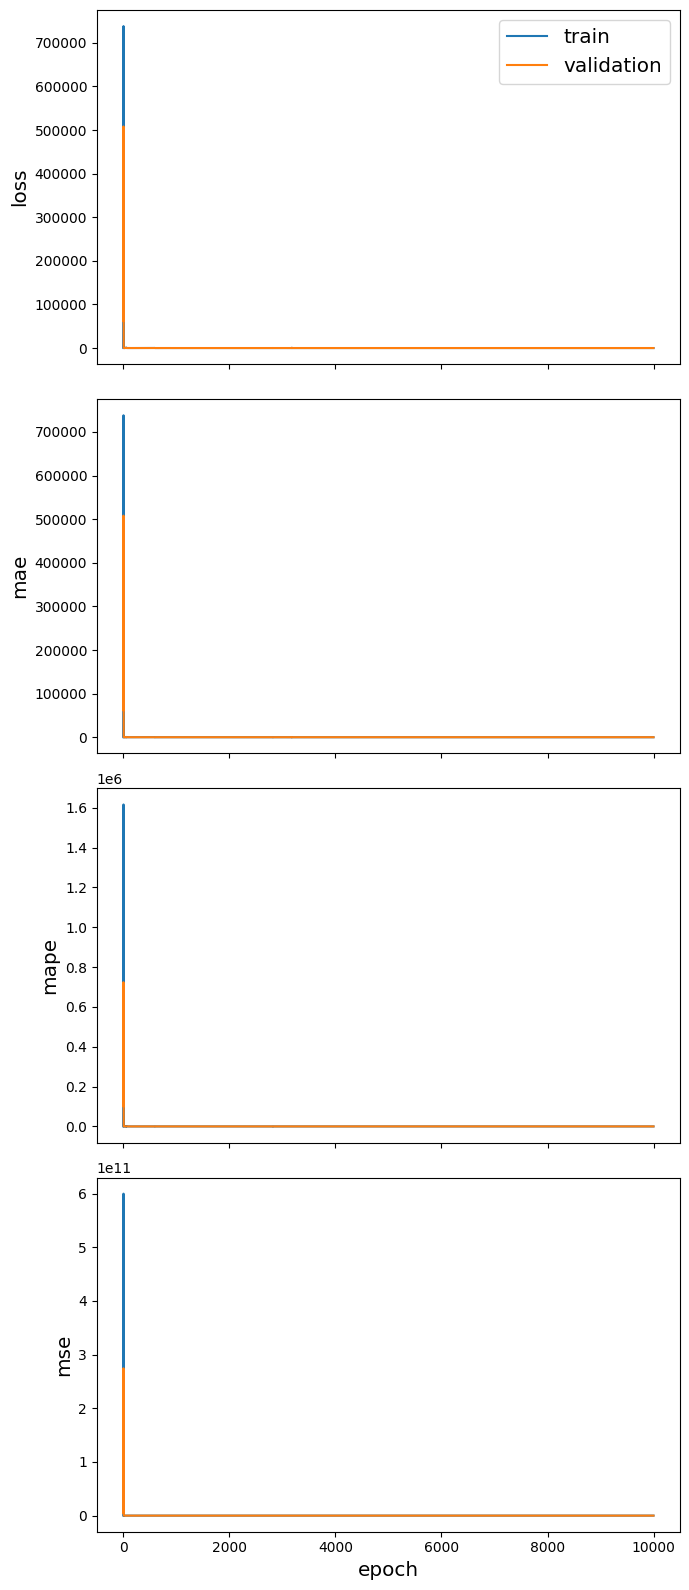

In [87]:
sg.utils.plot_history(history)


# In[72]:


#val_subjects, 
#test_subjects


# In[73]:


#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[74]:


#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[75]:


validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[76]:


#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-spearman');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[2] = temp
df_metrics


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[77]:


#all_nodes = spearman_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#spearman_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
spearman_graph_node_data_test.index,  vars(test_gen),        test_predictions


# In[78]:


train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions


# In[79]:


test_predictions


# In[80]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, spearman_graph_node_data.shape
# vars(all_gen)


# In[81]:


spearman_graph_node_data


# In[ ]:



# New Kendall Tau based **********************

An exception occurred. Operation ignored
(753, 29)
StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 278

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [278]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 72

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [72]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 100

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [100]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 52

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-li

{'node_features_size': 753,
 'graphs': [<stellargraph.core.graph.StellarGraph at 0x1b45ccd2970>,
 'name': None}

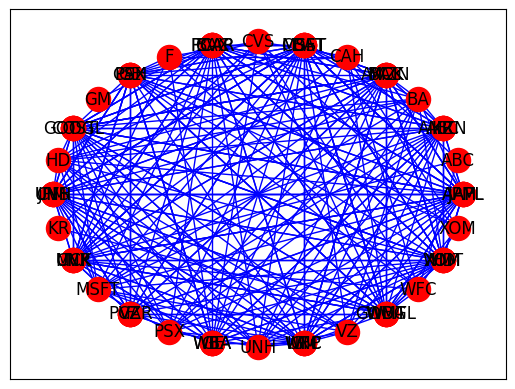

In [88]:
#!/usr/bin/env python
# coding: utf-8

# # 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.
# 
# # Input graphs were created for Kendall, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.
# 
# # For the sake of making execution easier (and at once), I have kept multiple approaches (Kendall, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.
# 
# # Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.
# 
# # An use case of DeepGraphCNN for Node Classification
# # https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html
# 

# # Import Libraries

# In[1]:


# import libraries
import os
import pandas as pd
import math


# In[2]:


# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN


# In[3]:


# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras


# In[4]:


# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1


# # Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

# In[5]:


df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()


# In[6]:


# You can see ANTM stock price data is empty


# # Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

# In[7]:


# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()


# In[8]:


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    


# In[9]:


df_s_transpose


# In[10]:


# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 


# In[11]:


# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]


# In[12]:


# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')


# # Kendall Correlation Coefficient

# In[13]:


df_s_transpose_kendall = df_s_transpose.corr(method = 'kendall', numeric_only = True)
df_s_transpose_kendall


# # Kendall Correlation Coefficient based Adjacency Graph Matrix

# In[14]:


df_s_transpose_kendall[df_s_transpose_kendall >= 0.3] = 1
df_s_transpose_kendall[df_s_transpose_kendall < 0.3] = 0
df_s_transpose_kendall


# In[15]:


# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_kendall.values, 0)
df_s_transpose_kendall


# Create and visualize the Graphs

# In[17]:


import networkx as nx
Graph_kendall = nx.Graph(df_s_transpose_kendall)


# In[18]:


nx.draw_networkx(Graph_kendall, pos = nx.circular_layout( Graph_kendall ), node_color = 'r', edge_color = 'b')


# # Experiment, we will divide the data into train, test, and validation graphs

# In[19]:


df_s_transpose.corr(method = 'kendall', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


# In[20]:


# Train Graph


# In[21]:


df_s_kendall_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_kendall_train = df_s_kendall_train.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_train.values, 0)

df_s_transpose_kendall_train[df_s_transpose_kendall_train >= 0.3] = 1
df_s_transpose_kendall_train[df_s_transpose_kendall_train < 0.3] = 0
df_s_transpose_kendall_train

df_s_transpose_kendall_train


# # Test Graph

# In[22]:


df_s_kendall_test = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 15:23]
df_s_transpose_kendall_test = df_s_kendall_test.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_test.values, 0)

df_s_transpose_kendall_train[df_s_transpose_kendall_test >= 0.3] = 1
df_s_transpose_kendall_train[df_s_transpose_kendall_test < 0.3] = 0
df_s_transpose_kendall_test


# # Validation Graph

# In[23]:


df_s_kendall_validation = df_s_transpose.iloc[:, 15:] #df_s_transpose.iloc[:, 23:]
df_s_transpose_kendall_validation = df_s_kendall_validation.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_validation.values, 0)
df_s_transpose_kendall_validation

df_s_transpose_kendall_validation[df_s_transpose_kendall_validation >= 0.3] = 1
df_s_transpose_kendall_validation[df_s_transpose_kendall_validation < 0.3] = 0
df_s_transpose_kendall_validation


# In[24]:


graph_kendall_train = nx.Graph(df_s_transpose_kendall_train)
graph_kendall_test = nx.Graph(df_s_transpose_kendall_test)
graph_kendall_validation = nx.Graph(df_s_transpose_kendall_validation)


nx.draw_networkx(graph_kendall_train, pos = nx.circular_layout( graph_kendall_train ), node_color = 'r', edge_color = 'b')


# In[25]:


df_s_kendall_train.corr(numeric_only = True)


# In[26]:


nx.draw_networkx(graph_kendall_test, pos = nx.circular_layout( graph_kendall_test ), node_color = 'r', edge_color = 'b')


# In[27]:


nx.draw_networkx(graph_kendall_validation, pos = nx.circular_layout( graph_kendall_validation ), node_color = 'r', edge_color = 'b')


# # Create GCN layer. Kendall

# # Find all stocks = nodes

# In[28]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_kendall.index.to_list()
all_stock_nodes[:5]


# # Find all edges between nodes
# 
# This may need adjustment to reflect train, test, validation graphs

# In[29]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_kendall[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            


# # Find all edges in Train, Test, and Validation Graphs

# In[30]:


trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_kendall_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_kendall_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_kendall_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_kendall_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_kendall_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_kendall_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_kendall[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature


# # Create variables to create stellar graph
# # Edges

# In[31]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_edges = pd.DataFrame(
    {"source": source, "target": target}
)

kendall_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

kendall_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

kendall_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

kendall_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


kendall_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


kendall_edges_train[:10]


# # Have the time series data as part of the nodes

# # Structure the Feature Matrix so that it can be passed to the GCN

# In[32]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values


# In[33]:


len(all_stock_nodes)


# In[34]:


# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[35]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
kendall_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
kendall_graph_node_data.head()


# In[36]:


node_Data[14:15], 
len(validationNodeList)
len(testNodeList)


# In[37]:


# Node time series data based on train, test, validation graph


# In[38]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
kendall_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
kendall_graph_node_data_train.head()

kendall_graph_node_data_test = pd.DataFrame(node_Data[14:], index = testNodeList) #pd.DataFrame(node_Data[15:23], index = testNodeList)
kendall_graph_node_data_test.head()

kendall_graph_node_data_validation = pd.DataFrame(node_Data[14:], index = validationNodeList) #pd.DataFrame(node_Data[22:30], index = validationNodeList)
kendall_graph_node_data_validation.head()



# In[39]:


kendall_graph_node_data_train


# # Graph (stellar) with features as part of Nodes

# In[40]:


# Overall
kendall_graph_with_node_features = StellarGraph(kendall_graph_node_data, edges = kendall_edges, node_type_default = "corner", edge_type_default = "line")
print(kendall_graph_with_node_features.info())

# train nodes
kendall_train_graph_with_node_features = StellarGraph(kendall_graph_node_data_train, edges = kendall_edges_train, node_type_default = "corner", edge_type_default = "line")
print(kendall_train_graph_with_node_features.info())

# test
kendall_test_graph_with_node_features = StellarGraph(kendall_graph_node_data_test, edges = kendall_edges_test, node_type_default = "corner", edge_type_default = "line")
print(kendall_test_graph_with_node_features.info())

# validation
kendall_validation_graph_with_node_features = StellarGraph(kendall_graph_node_data_validation, edges = kendall_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(kendall_validation_graph_with_node_features.info())


# # Adapting everything for DeepGraphCNN

# In[41]:


kendall_graph_node_data.iloc[0:15, :]


# # Graphs to be jused for DeepGraphCNN

# In[42]:


graphs = list()
#graphs.append(kendall_graph_with_node_features)
graphs.append(kendall_train_graph_with_node_features)
graphs.append(kendall_test_graph_with_node_features)
graphs.append(kendall_validation_graph_with_node_features)


# In[43]:


summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()


# In[44]:


# graph_labels = all_stock_nodes


# In[45]:


# Generator
#generator = FullBatchNodeGenerator(kendall_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( kendall_graph_with_node_features)


# In[46]:


vars(generator)


# # Train Test Split

# # Commented out on 2023-04-18
# train_subjects, test_subjects = model_selection.train_test_split(
#     kendall_graph_node_data 
# )
# 
# val_subjects, test_subjects_step_2 = model_selection.train_test_split(
#     test_subjects 
# )
# 
# #, train_size = 500, test_size = None, stratify = test_subjects
# 
# train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

# In[98]:




In [89]:
train_subjects = kendall_graph_node_data_train.iloc[:,0:751];
test_subjects = kendall_graph_node_data_test.iloc[:,0:751];
val_subjects = kendall_graph_node_data_validation.iloc[:,0:751];


# In[104]:


kendall_graph_node_data_train.iloc[:,0:751]


# In[49]:


# Commented out on 2023-04-18
#train_targets = train_subjects; 
#val_targets = val_subjects; 
#test_targets = test_subjects; 


# # The Model for all of the approaches utilized in this file
# # Model for Kendall, Spearman, Kendal Tau, Financial News Based prediction

# # Models : DeepGraph CNN

# In[50]:


#epochs_to_test = 1000
#patience_to_test = 1000


# In[51]:


# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out


# In[52]:


# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    


# In[53]:


#train_targets.index


# In[54]:


x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = 14, activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)


# In[55]:


#len(train_targets)


# In[56]:


# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)


# # Commented out on 2023-04-18
# 
# # hard coded size adjustments
# #test_subjects_ = test_subjects[:len(val_subjects)]
# 
# #val_gen = generator.flow(val_subjects.index, test_subjects_)
# #train_gen[1], val_gen[1]
# #val_gen[4]

# #  Multiple Graph Version Starts

# In[57]:


vars(graphs[0])


# In[92]:


list(kendall_graph_node_data_train.iloc[:,752]), list(kendall_graph_node_data_test.iloc[:,752]), list(kendall_graph_node_data_validation.iloc[:,752])
#list(train_subjects.iloc[:,751])




([72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372],
 [138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336],
 [138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336])

In [90]:
# In[59]:


x = [[72.87999725341797,
  83.63999938964844,
  92.34449768066406,
  326.3999938964844,
  35.150001525878906,
  50.77000045776367,
  295.1400146484375,
  73.69999694824219,
  119.8499984741211,
  9.25,
  69.19593811035156,
  36.43999862670898,
  66.9854965209961,
  217.30999755859372]]

train_target = [[72.87999725341797,
 83.63999938964844,
 92.34449768066406,
 326.3999938964844,
 35.150001525878906,
 50.77000045776367,
 295.1400146484375,
 73.69999694824219,
 119.8499984741211,
 9.25,
 69.19593811035156,
 36.43999862670898,
 66.9854965209961,
 217.30999755859372]]


# In[60]:


test_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


validation_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


valid_target = [[138.6300048828125,
  29.059999465942383,
  137.1699981689453,
  157.58999633789062,
  52.64666748046875,
  110.37000274658205,
  29.486404418945312,
  293.8500061035156,
  180.1499938964844,
  61.209999084472656,
  58.90999984741211,
  53.59999847412109,
  119.4000015258789,
  69.4800033569336]]


# In[61]:


validation_target


# In[62]:


x


# In[63]:


# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = train_target, #list(train_target), #[0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = test_target, #[1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = validation_target, #[2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)


#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];


# In[64]:


'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''


# In[65]:


vars(train_gen)


# In[66]:


vars(test_gen)


# In[67]:


vars(val_gen)
#train_subjects
#train_subjects.values


# In[68]:


vars(train_gen), 
#train_subjects
#train_subjects.values


# train_subjects, test_gen

# In[69]:


#train_gen, data_valid, train_gen_data


# In[70]:




({'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000001B45CCD2970>,
        dtype=object),
  'selected_ilocs': array([[0]]),
  'normalize_adj': True,
  'targets': array([[ 72.87999725,  83.63999939,  92.34449768, 326.3999939 ,
           35.15000153,  50.77000046, 295.14001465,  73.69999695,
          119.84999847,   9.25      ,  69.19593811,  36.43999863,
           66.98549652, 217.30999756]]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 86 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 114 stored elements in Compressed Sparse Row format>,
         <14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 66 stored elements in Compressed Sparse Row format>],
        dtype=object),
  '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages

In [91]:
# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 2, validation_data = test_gen, shuffle = False,
)




Epoch 1/10000
1/1 - 2s - loss: 109.8363 - mse: 21343.7832 - mape: 100.4440 - mae: 109.8363 - val_loss: 55450.6133 - val_mse: 3412047360.0000 - val_mape: 84322.1094 - val_mae: 55450.6133 - 2s/epoch - 2s/step
Epoch 2/10000
1/1 - 0s - loss: 49065.9062 - mse: 3245960704.0000 - mape: 69698.7578 - mae: 49065.9062 - val_loss: 262100.2656 - val_mse: 72274329600.0000 - val_mape: 375629.7188 - val_mae: 262100.2656 - 47ms/epoch - 47ms/step
Epoch 3/10000
1/1 - 0s - loss: 291303.2188 - mse: 99375628288.0000 - mape: 519756.6250 - mae: 291303.2188 - val_loss: 106.8303 - val_mse: 16437.5918 - val_mape: 99.9583 - val_mae: 106.8303 - 50ms/epoch - 50ms/step
Epoch 4/10000
1/1 - 0s - loss: 5537.0557 - mse: 36170508.0000 - mape: 15023.3232 - mae: 5537.0557 - val_loss: 129.7957 - val_mse: 22036.6816 - val_mape: 132.9993 - val_mae: 129.7957 - 49ms/epoch - 49ms/step
Epoch 5/10000
1/1 - 0s - loss: 130.4738 - mse: 26329.9043 - mape: 123.2585 - mae: 130.4738 - val_loss: 123.4792 - val_mse: 20552.7461 - val_mape: 

Epoch 42/10000
1/1 - 0s - loss: 104.6423 - mse: 14768.1357 - mape: 117.6938 - mae: 104.6423 - val_loss: 58.3687 - val_mse: 5723.2983 - val_mape: 80.3706 - val_mae: 58.3687 - 46ms/epoch - 46ms/step
Epoch 43/10000
1/1 - 0s - loss: 102.1270 - mse: 15995.5781 - mape: 176.0605 - mae: 102.1270 - val_loss: 157.4691 - val_mse: 27628.8301 - val_mape: 258.4814 - val_mae: 157.4691 - 48ms/epoch - 48ms/step
Epoch 44/10000
1/1 - 0s - loss: 198.1126 - mse: 46515.2148 - mape: 507.6340 - mae: 198.1126 - val_loss: 130.0911 - val_mse: 19361.8730 - val_mape: 215.0387 - val_mae: 130.0911 - 46ms/epoch - 46ms/step
Epoch 45/10000
1/1 - 0s - loss: 242.1806 - mse: 64628.3555 - mape: 563.1083 - mae: 242.1806 - val_loss: 67.8822 - val_mse: 8326.8818 - val_mape: 78.9753 - val_mae: 67.8822 - 47ms/epoch - 47ms/step
Epoch 46/10000
1/1 - 0s - loss: 77.2200 - mse: 8170.2964 - mape: 143.1369 - mae: 77.2200 - val_loss: 99.6876 - val_mse: 13948.0576 - val_mape: 132.0480 - val_mae: 99.6876 - 45ms/epoch - 45ms/step
Epoch 47

Epoch 84/10000
1/1 - 0s - loss: 119.0958 - mse: 22346.7949 - mape: 138.0780 - mae: 119.0958 - val_loss: 65.4074 - val_mse: 8811.0215 - val_mape: 60.0953 - val_mae: 65.4074 - 60ms/epoch - 60ms/step
Epoch 85/10000
1/1 - 0s - loss: 86.8125 - mse: 14069.5771 - mape: 127.8483 - mae: 86.8125 - val_loss: 58.8186 - val_mse: 7464.9414 - val_mape: 67.6201 - val_mae: 58.8186 - 50ms/epoch - 50ms/step
Epoch 86/10000
1/1 - 0s - loss: 58.5028 - mse: 6533.0688 - mape: 86.6319 - mae: 58.5028 - val_loss: 58.3001 - val_mse: 7244.5615 - val_mape: 82.3589 - val_mae: 58.3001 - 50ms/epoch - 50ms/step
Epoch 87/10000
1/1 - 0s - loss: 74.1694 - mse: 9662.3184 - mape: 82.8412 - mae: 74.1694 - val_loss: 67.9497 - val_mse: 8061.5928 - val_mape: 111.4341 - val_mae: 67.9497 - 47ms/epoch - 47ms/step
Epoch 88/10000
1/1 - 0s - loss: 101.4423 - mse: 14331.2422 - mape: 207.3797 - mae: 101.4423 - val_loss: 74.3203 - val_mse: 8989.2041 - val_mape: 130.5475 - val_mae: 74.3203 - 51ms/epoch - 51ms/step
Epoch 89/10000
1/1 - 0s

Epoch 126/10000
1/1 - 0s - loss: 46.1265 - mse: 3636.0356 - mape: 48.7245 - mae: 46.1265 - val_loss: 81.7313 - val_mse: 12588.9980 - val_mape: 121.4900 - val_mae: 81.7313 - 55ms/epoch - 55ms/step
Epoch 127/10000
1/1 - 0s - loss: 57.8802 - mse: 4785.9351 - mape: 110.0491 - mae: 57.8802 - val_loss: 94.8885 - val_mse: 13740.3584 - val_mape: 128.4404 - val_mae: 94.8885 - 65ms/epoch - 65ms/step
Epoch 128/10000
1/1 - 0s - loss: 51.4110 - mse: 4122.1221 - mape: 121.5006 - mae: 51.4110 - val_loss: 107.9518 - val_mse: 17835.2637 - val_mape: 150.2029 - val_mae: 107.9518 - 55ms/epoch - 55ms/step
Epoch 129/10000
1/1 - 0s - loss: 46.4123 - mse: 3309.9199 - mape: 96.2225 - mae: 46.4123 - val_loss: 107.9272 - val_mse: 16220.8730 - val_mape: 140.9614 - val_mae: 107.9272 - 62ms/epoch - 62ms/step
Epoch 130/10000
1/1 - 0s - loss: 59.7026 - mse: 4500.3950 - mape: 166.3880 - mae: 59.7026 - val_loss: 99.5202 - val_mse: 13802.8682 - val_mape: 119.4825 - val_mae: 99.5202 - 60ms/epoch - 60ms/step
Epoch 131/100

Epoch 168/10000
1/1 - 0s - loss: 143.2419 - mse: 25040.7012 - mape: 210.8570 - mae: 143.2419 - val_loss: 151.6522 - val_mse: 29729.2363 - val_mape: 159.5344 - val_mae: 151.6522 - 52ms/epoch - 52ms/step
Epoch 169/10000
1/1 - 0s - loss: 78.1118 - mse: 10621.6045 - mape: 67.5715 - mae: 78.1118 - val_loss: 159.7231 - val_mse: 32668.7637 - val_mape: 172.0401 - val_mae: 159.7231 - 47ms/epoch - 47ms/step
Epoch 170/10000
1/1 - 0s - loss: 167.0263 - mse: 30739.4160 - mape: 284.6147 - mae: 167.0263 - val_loss: 114.3020 - val_mse: 18013.9629 - val_mape: 121.2153 - val_mae: 114.3020 - 47ms/epoch - 47ms/step
Epoch 171/10000
1/1 - 0s - loss: 124.0006 - mse: 16517.8652 - mape: 227.2571 - mae: 124.0006 - val_loss: 72.4990 - val_mse: 9020.9814 - val_mape: 79.0973 - val_mae: 72.4990 - 49ms/epoch - 49ms/step
Epoch 172/10000
1/1 - 0s - loss: 109.9097 - mse: 19055.6875 - mape: 106.8599 - mae: 109.9097 - val_loss: 82.7818 - val_mse: 9778.4219 - val_mape: 113.8866 - val_mae: 82.7818 - 46ms/epoch - 46ms/step


Epoch 210/10000
1/1 - 0s - loss: 142.4486 - mse: 23036.8164 - mape: 244.0952 - mae: 142.4486 - val_loss: 77.1343 - val_mse: 11214.7832 - val_mape: 115.6764 - val_mae: 77.1343 - 47ms/epoch - 47ms/step
Epoch 211/10000
1/1 - 0s - loss: 73.2940 - mse: 6682.4854 - mape: 121.0350 - mae: 73.2940 - val_loss: 73.4144 - val_mse: 9038.2607 - val_mape: 104.1928 - val_mae: 73.4144 - 47ms/epoch - 47ms/step
Epoch 212/10000
1/1 - 0s - loss: 26.1940 - mse: 1289.4916 - mape: 38.9250 - mae: 26.1940 - val_loss: 82.8948 - val_mse: 10702.7002 - val_mape: 112.9777 - val_mae: 82.8948 - 48ms/epoch - 48ms/step
Epoch 213/10000
1/1 - 0s - loss: 167.9600 - mse: 32237.8926 - mape: 265.0398 - mae: 167.9600 - val_loss: 75.2478 - val_mse: 9606.2510 - val_mape: 98.4238 - val_mae: 75.2478 - 48ms/epoch - 48ms/step
Epoch 214/10000
1/1 - 0s - loss: 28.1113 - mse: 1264.1239 - mape: 86.4516 - mae: 28.1113 - val_loss: 106.0694 - val_mse: 15844.0811 - val_mape: 129.8835 - val_mae: 106.0694 - 47ms/epoch - 47ms/step
Epoch 215/10

Epoch 252/10000
1/1 - 0s - loss: 107.5255 - mse: 16484.4199 - mape: 116.4810 - mae: 107.5255 - val_loss: 91.3781 - val_mse: 11293.1123 - val_mape: 109.9910 - val_mae: 91.3781 - 46ms/epoch - 46ms/step
Epoch 253/10000
1/1 - 0s - loss: 77.8539 - mse: 9281.9395 - mape: 87.6086 - mae: 77.8539 - val_loss: 96.9380 - val_mse: 12043.1553 - val_mape: 121.0001 - val_mae: 96.9380 - 47ms/epoch - 47ms/step
Epoch 254/10000
1/1 - 0s - loss: 45.9993 - mse: 3350.3679 - mape: 134.3579 - mae: 45.9993 - val_loss: 106.3489 - val_mse: 14123.9951 - val_mape: 135.3193 - val_mae: 106.3489 - 45ms/epoch - 45ms/step
Epoch 255/10000
1/1 - 0s - loss: 169.1104 - mse: 30586.3613 - mape: 371.3485 - mae: 169.1104 - val_loss: 97.1676 - val_mse: 14178.8994 - val_mape: 136.4699 - val_mae: 97.1676 - 46ms/epoch - 46ms/step
Epoch 256/10000
1/1 - 0s - loss: 48.3614 - mse: 3864.3547 - mape: 95.4528 - mae: 48.3614 - val_loss: 97.8943 - val_mse: 15854.5400 - val_mape: 144.2087 - val_mae: 97.8943 - 46ms/epoch - 46ms/step
Epoch 257

1/1 - 0s - loss: 84.3304 - mse: 9262.1670 - mape: 102.8033 - mae: 84.3304 - val_loss: 68.4417 - val_mse: 9388.7480 - val_mape: 93.7156 - val_mae: 68.4417 - 46ms/epoch - 46ms/step
Epoch 294/10000
1/1 - 0s - loss: 40.6511 - mse: 2989.4622 - mape: 75.7498 - mae: 40.6511 - val_loss: 68.3978 - val_mse: 8371.4131 - val_mape: 69.4399 - val_mae: 68.3978 - 48ms/epoch - 48ms/step
Epoch 295/10000
1/1 - 0s - loss: 79.4454 - mse: 8517.0068 - mape: 87.0879 - mae: 79.4454 - val_loss: 95.9488 - val_mse: 19102.4121 - val_mape: 132.9394 - val_mae: 95.9488 - 48ms/epoch - 48ms/step
Epoch 296/10000
1/1 - 0s - loss: 116.9904 - mse: 17741.5020 - mape: 232.0250 - mae: 116.9904 - val_loss: 110.7665 - val_mse: 18587.7930 - val_mape: 129.3156 - val_mae: 110.7665 - 47ms/epoch - 47ms/step
Epoch 297/10000
1/1 - 0s - loss: 46.4464 - mse: 2780.2622 - mape: 83.7110 - mae: 46.4464 - val_loss: 118.1872 - val_mse: 23100.6387 - val_mape: 134.3476 - val_mae: 118.1872 - 48ms/epoch - 48ms/step
Epoch 298/10000
1/1 - 0s - loss

Epoch 335/10000
1/1 - 0s - loss: 49.6923 - mse: 3404.7817 - mape: 75.2896 - mae: 49.6923 - val_loss: 74.0145 - val_mse: 9532.0859 - val_mape: 108.5115 - val_mae: 74.0145 - 49ms/epoch - 49ms/step
Epoch 336/10000
1/1 - 0s - loss: 93.6566 - mse: 14411.4424 - mape: 93.7999 - mae: 93.6566 - val_loss: 102.7389 - val_mse: 17654.3730 - val_mape: 143.0649 - val_mae: 102.7389 - 46ms/epoch - 46ms/step
Epoch 337/10000
1/1 - 0s - loss: 113.1198 - mse: 16907.9883 - mape: 144.4758 - mae: 113.1198 - val_loss: 104.8021 - val_mse: 18980.1699 - val_mape: 150.8974 - val_mae: 104.8021 - 46ms/epoch - 46ms/step
Epoch 338/10000
1/1 - 0s - loss: 45.4660 - mse: 3526.4104 - mape: 69.9600 - mae: 45.4660 - val_loss: 93.4299 - val_mse: 17562.4336 - val_mape: 148.3125 - val_mae: 93.4299 - 54ms/epoch - 54ms/step
Epoch 339/10000
1/1 - 0s - loss: 73.3068 - mse: 6507.8931 - mape: 147.7242 - mae: 73.3068 - val_loss: 71.8728 - val_mse: 10383.9092 - val_mape: 110.3384 - val_mae: 71.8728 - 49ms/epoch - 49ms/step
Epoch 340/1

Epoch 377/10000
1/1 - 0s - loss: 96.6172 - mse: 10225.8564 - mape: 214.0496 - mae: 96.6172 - val_loss: 93.2276 - val_mse: 13309.6299 - val_mape: 125.2712 - val_mae: 93.2276 - 53ms/epoch - 53ms/step
Epoch 378/10000
1/1 - 0s - loss: 31.6274 - mse: 2027.9102 - mape: 32.4971 - mae: 31.6274 - val_loss: 96.8531 - val_mse: 16100.5107 - val_mape: 142.8403 - val_mae: 96.8531 - 46ms/epoch - 46ms/step
Epoch 379/10000
1/1 - 0s - loss: 75.3336 - mse: 7723.7148 - mape: 110.2069 - mae: 75.3336 - val_loss: 111.0319 - val_mse: 27910.7930 - val_mape: 183.2033 - val_mae: 111.0319 - 58ms/epoch - 58ms/step
Epoch 380/10000
1/1 - 0s - loss: 67.0061 - mse: 9361.8516 - mape: 74.5558 - mae: 67.0061 - val_loss: 103.4574 - val_mse: 27710.0566 - val_mape: 177.9436 - val_mae: 103.4574 - 59ms/epoch - 59ms/step
Epoch 381/10000
1/1 - 0s - loss: 51.4809 - mse: 4660.2178 - mape: 90.3982 - mae: 51.4809 - val_loss: 88.2931 - val_mse: 20043.9102 - val_mape: 153.4226 - val_mae: 88.2931 - 51ms/epoch - 51ms/step
Epoch 382/100

Epoch 419/10000
1/1 - 0s - loss: 200.1665 - mse: 68836.4141 - mape: 215.4412 - mae: 200.1665 - val_loss: 138.8204 - val_mse: 31491.8691 - val_mape: 211.4786 - val_mae: 138.8204 - 57ms/epoch - 57ms/step
Epoch 420/10000
1/1 - 0s - loss: 115.6787 - mse: 20213.6191 - mape: 159.6178 - mae: 115.6787 - val_loss: 122.8803 - val_mse: 22405.4492 - val_mape: 181.1154 - val_mae: 122.8803 - 60ms/epoch - 60ms/step
Epoch 421/10000
1/1 - 0s - loss: 77.9288 - mse: 9225.2441 - mape: 279.9505 - mae: 77.9288 - val_loss: 108.2705 - val_mse: 15632.8076 - val_mape: 147.4987 - val_mae: 108.2705 - 62ms/epoch - 62ms/step
Epoch 422/10000
1/1 - 0s - loss: 157.9292 - mse: 27343.8848 - mape: 358.7348 - mae: 157.9292 - val_loss: 92.4811 - val_mse: 11875.0703 - val_mape: 117.9838 - val_mae: 92.4811 - 78ms/epoch - 78ms/step
Epoch 423/10000
1/1 - 0s - loss: 31.6324 - mse: 1480.8080 - mape: 83.0029 - mae: 31.6324 - val_loss: 81.7891 - val_mse: 10133.2832 - val_mape: 96.5618 - val_mae: 81.7891 - 70ms/epoch - 70ms/step
Ep

Epoch 461/10000
1/1 - 0s - loss: 28.0936 - mse: 1194.3365 - mape: 46.2130 - mae: 28.0936 - val_loss: 207.2172 - val_mse: 95180.3516 - val_mape: 366.0790 - val_mae: 207.2172 - 49ms/epoch - 49ms/step
Epoch 462/10000
1/1 - 0s - loss: 220.8322 - mse: 52794.2812 - mape: 368.3981 - mae: 220.8322 - val_loss: 115.8540 - val_mse: 29756.3457 - val_mape: 202.7807 - val_mae: 115.8540 - 46ms/epoch - 46ms/step
Epoch 463/10000
1/1 - 0s - loss: 58.9432 - mse: 7258.8149 - mape: 62.6431 - mae: 58.9432 - val_loss: 79.0560 - val_mse: 10016.0811 - val_mape: 108.8403 - val_mae: 79.0560 - 48ms/epoch - 48ms/step
Epoch 464/10000
1/1 - 0s - loss: 10.6587 - mse: 158.8289 - mape: 17.9326 - mae: 10.6587 - val_loss: 77.3285 - val_mse: 10439.7598 - val_mape: 85.2935 - val_mae: 77.3285 - 51ms/epoch - 51ms/step
Epoch 465/10000
1/1 - 0s - loss: 42.7980 - mse: 2641.3630 - mape: 121.9334 - mae: 42.7980 - val_loss: 87.4348 - val_mse: 13630.0088 - val_mape: 87.4133 - val_mae: 87.4348 - 48ms/epoch - 48ms/step
Epoch 466/1000

Epoch 503/10000
1/1 - 0s - loss: 69.8344 - mse: 8296.6582 - mape: 66.9405 - mae: 69.8344 - val_loss: 88.0207 - val_mse: 12767.2471 - val_mape: 111.0183 - val_mae: 88.0207 - 45ms/epoch - 45ms/step
Epoch 504/10000
1/1 - 0s - loss: 61.0511 - mse: 4171.5591 - mape: 105.7481 - mae: 61.0511 - val_loss: 122.1739 - val_mse: 23358.2539 - val_mape: 160.4991 - val_mae: 122.1739 - 49ms/epoch - 49ms/step
Epoch 505/10000
1/1 - 0s - loss: 64.9792 - mse: 7882.8462 - mape: 65.2402 - mae: 64.9792 - val_loss: 118.8672 - val_mse: 22161.2969 - val_mape: 155.8286 - val_mae: 118.8672 - 47ms/epoch - 47ms/step
Epoch 506/10000
1/1 - 0s - loss: 75.8498 - mse: 12051.1797 - mape: 94.2240 - mae: 75.8498 - val_loss: 93.2493 - val_mse: 14230.0449 - val_mape: 121.7679 - val_mae: 93.2493 - 47ms/epoch - 47ms/step
Epoch 507/10000
1/1 - 0s - loss: 57.9034 - mse: 4614.7881 - mape: 68.9507 - mae: 57.9034 - val_loss: 84.8395 - val_mse: 11876.3076 - val_mape: 112.7629 - val_mae: 84.8395 - 46ms/epoch - 46ms/step
Epoch 508/1000

Epoch 545/10000
1/1 - 0s - loss: 61.9625 - mse: 4680.3218 - mape: 102.0393 - mae: 61.9625 - val_loss: 100.7916 - val_mse: 24124.5781 - val_mape: 171.2961 - val_mae: 100.7916 - 44ms/epoch - 44ms/step
Epoch 546/10000
1/1 - 0s - loss: 34.9424 - mse: 1878.3822 - mape: 44.5047 - mae: 34.9424 - val_loss: 93.3034 - val_mse: 20141.2324 - val_mape: 155.7002 - val_mae: 93.3034 - 47ms/epoch - 47ms/step
Epoch 547/10000
1/1 - 0s - loss: 52.1307 - mse: 7057.1143 - mape: 81.6631 - mae: 52.1307 - val_loss: 84.3346 - val_mse: 14487.0703 - val_mape: 131.9055 - val_mae: 84.3346 - 46ms/epoch - 46ms/step
Epoch 548/10000
1/1 - 0s - loss: 26.9752 - mse: 948.3521 - mape: 57.9171 - mae: 26.9752 - val_loss: 80.3161 - val_mse: 10431.0996 - val_mape: 107.1790 - val_mae: 80.3161 - 45ms/epoch - 45ms/step
Epoch 549/10000
1/1 - 0s - loss: 23.7007 - mse: 857.3195 - mape: 49.3822 - mae: 23.7007 - val_loss: 76.5457 - val_mse: 9266.1025 - val_mape: 95.9006 - val_mae: 76.5457 - 46ms/epoch - 46ms/step
Epoch 550/10000
1/1 -

Epoch 587/10000
1/1 - 0s - loss: 20.8073 - mse: 656.8545 - mape: 50.7244 - mae: 20.8073 - val_loss: 84.1084 - val_mse: 12035.6016 - val_mape: 130.8803 - val_mae: 84.1084 - 47ms/epoch - 47ms/step
Epoch 588/10000
1/1 - 0s - loss: 38.3518 - mse: 1649.5857 - mape: 84.5267 - mae: 38.3518 - val_loss: 86.2039 - val_mse: 12366.8340 - val_mape: 131.5743 - val_mae: 86.2039 - 45ms/epoch - 45ms/step
Epoch 589/10000
1/1 - 0s - loss: 51.9506 - mse: 3863.3337 - mape: 91.3372 - mae: 51.9506 - val_loss: 90.8403 - val_mse: 11994.7646 - val_mape: 115.0764 - val_mae: 90.8403 - 46ms/epoch - 46ms/step
Epoch 590/10000
1/1 - 0s - loss: 12.2825 - mse: 228.3622 - mape: 41.8172 - mae: 12.2825 - val_loss: 188.4408 - val_mse: 59112.1797 - val_mape: 324.9399 - val_mae: 188.4408 - 46ms/epoch - 46ms/step
Epoch 591/10000
1/1 - 0s - loss: 296.1499 - mse: 134924.6250 - mape: 415.7657 - mae: 296.1499 - val_loss: 89.3375 - val_mse: 15987.4785 - val_mape: 143.0151 - val_mae: 89.3375 - 45ms/epoch - 45ms/step
Epoch 592/10000

Epoch 629/10000
1/1 - 0s - loss: 69.8666 - mse: 6626.7197 - mape: 126.9020 - mae: 69.8666 - val_loss: 89.4278 - val_mse: 13643.1709 - val_mape: 138.9440 - val_mae: 89.4278 - 48ms/epoch - 48ms/step
Epoch 630/10000
1/1 - 0s - loss: 48.5375 - mse: 2922.9250 - mape: 84.9098 - mae: 48.5375 - val_loss: 90.0498 - val_mse: 12941.3701 - val_mape: 133.8111 - val_mae: 90.0498 - 46ms/epoch - 46ms/step
Epoch 631/10000
1/1 - 0s - loss: 47.0868 - mse: 4355.5054 - mape: 119.3054 - mae: 47.0868 - val_loss: 88.1100 - val_mse: 11976.2754 - val_mape: 123.1561 - val_mae: 88.1100 - 46ms/epoch - 46ms/step
Epoch 632/10000
1/1 - 0s - loss: 99.6273 - mse: 13956.8125 - mape: 199.2691 - mae: 99.6273 - val_loss: 80.8879 - val_mse: 10559.0264 - val_mape: 109.8324 - val_mae: 80.8879 - 46ms/epoch - 46ms/step
Epoch 633/10000
1/1 - 0s - loss: 53.0158 - mse: 4473.0869 - mape: 112.7908 - mae: 53.0158 - val_loss: 73.6517 - val_mse: 9457.0547 - val_mape: 100.3367 - val_mae: 73.6517 - 49ms/epoch - 49ms/step
Epoch 634/10000


Epoch 671/10000
1/1 - 0s - loss: 22.5913 - mse: 634.4302 - mape: 55.4895 - mae: 22.5913 - val_loss: 76.0943 - val_mse: 9490.4512 - val_mape: 99.8227 - val_mae: 76.0943 - 52ms/epoch - 52ms/step
Epoch 672/10000
1/1 - 0s - loss: 21.4703 - mse: 1111.1838 - mape: 30.2810 - mae: 21.4703 - val_loss: 74.9847 - val_mse: 9199.6113 - val_mape: 98.4312 - val_mae: 74.9847 - 62ms/epoch - 62ms/step
Epoch 673/10000
1/1 - 0s - loss: 16.1207 - mse: 418.5200 - mape: 18.4323 - mae: 16.1207 - val_loss: 75.0699 - val_mse: 9094.7949 - val_mape: 99.7206 - val_mae: 75.0699 - 55ms/epoch - 55ms/step
Epoch 674/10000
1/1 - 0s - loss: 35.7061 - mse: 2939.7517 - mape: 38.7352 - mae: 35.7061 - val_loss: 76.1699 - val_mse: 9170.9521 - val_mape: 104.5162 - val_mae: 76.1699 - 57ms/epoch - 57ms/step
Epoch 675/10000
1/1 - 0s - loss: 70.4571 - mse: 10106.5322 - mape: 61.7490 - mae: 70.4571 - val_loss: 77.3746 - val_mse: 9398.9463 - val_mape: 109.5986 - val_mae: 77.3746 - 55ms/epoch - 55ms/step
Epoch 676/10000
1/1 - 0s - lo

Epoch 713/10000
1/1 - 0s - loss: 16.5831 - mse: 458.0631 - mape: 23.9442 - mae: 16.5831 - val_loss: 79.6129 - val_mse: 9700.9639 - val_mape: 104.3851 - val_mae: 79.6129 - 46ms/epoch - 46ms/step
Epoch 714/10000
1/1 - 0s - loss: 30.8298 - mse: 1386.0807 - mape: 34.8973 - mae: 30.8298 - val_loss: 79.9488 - val_mse: 9783.6875 - val_mape: 105.6135 - val_mae: 79.9488 - 45ms/epoch - 45ms/step
Epoch 715/10000
1/1 - 0s - loss: 41.6242 - mse: 3435.7000 - mape: 46.0510 - mae: 41.6242 - val_loss: 81.7365 - val_mse: 10325.4512 - val_mape: 111.4565 - val_mae: 81.7365 - 48ms/epoch - 48ms/step
Epoch 716/10000
1/1 - 0s - loss: 51.3340 - mse: 4620.8657 - mape: 51.9703 - mae: 51.3340 - val_loss: 85.7353 - val_mse: 11241.8438 - val_mape: 120.8941 - val_mae: 85.7353 - 48ms/epoch - 48ms/step
Epoch 717/10000
1/1 - 0s - loss: 19.6284 - mse: 588.1844 - mape: 50.6551 - mae: 19.6284 - val_loss: 89.2517 - val_mse: 11988.8545 - val_mape: 127.5646 - val_mae: 89.2517 - 48ms/epoch - 48ms/step
Epoch 718/10000
1/1 - 0s

1/1 - 0s - loss: 47.4459 - mse: 3393.5706 - mape: 90.4148 - mae: 47.4459 - val_loss: 97.7247 - val_mse: 19191.7910 - val_mape: 152.4529 - val_mae: 97.7247 - 51ms/epoch - 51ms/step
Epoch 756/10000
1/1 - 0s - loss: 40.6141 - mse: 2230.8235 - mape: 65.2139 - mae: 40.6141 - val_loss: 96.7495 - val_mse: 17749.2246 - val_mape: 148.7669 - val_mae: 96.7495 - 49ms/epoch - 49ms/step
Epoch 757/10000
1/1 - 0s - loss: 25.7669 - mse: 1113.3813 - mape: 69.6255 - mae: 25.7669 - val_loss: 92.7550 - val_mse: 15325.9072 - val_mape: 138.6287 - val_mae: 92.7550 - 48ms/epoch - 48ms/step
Epoch 758/10000
1/1 - 0s - loss: 27.9254 - mse: 1128.6682 - mape: 40.9273 - mae: 27.9254 - val_loss: 90.9334 - val_mse: 14176.6094 - val_mape: 133.6225 - val_mae: 90.9334 - 47ms/epoch - 47ms/step
Epoch 759/10000
1/1 - 0s - loss: 49.3891 - mse: 4923.0938 - mape: 50.6428 - mae: 49.3891 - val_loss: 88.5781 - val_mse: 12684.2705 - val_mape: 126.4527 - val_mae: 88.5781 - 46ms/epoch - 46ms/step
Epoch 760/10000
1/1 - 0s - loss: 29.

Epoch 797/10000
1/1 - 0s - loss: 88.3383 - mse: 16869.4043 - mape: 93.9942 - mae: 88.3383 - val_loss: 100.8250 - val_mse: 13497.4717 - val_mape: 128.1969 - val_mae: 100.8250 - 46ms/epoch - 46ms/step
Epoch 798/10000
1/1 - 0s - loss: 43.2685 - mse: 4016.7258 - mape: 43.8691 - mae: 43.2685 - val_loss: 102.1847 - val_mse: 14834.0400 - val_mape: 120.6088 - val_mae: 102.1847 - 46ms/epoch - 46ms/step
Epoch 799/10000
1/1 - 0s - loss: 196.1387 - mse: 44219.7305 - mape: 313.2066 - mae: 196.1387 - val_loss: 99.3705 - val_mse: 14241.9668 - val_mape: 116.3153 - val_mae: 99.3705 - 48ms/epoch - 48ms/step
Epoch 800/10000
1/1 - 0s - loss: 37.4426 - mse: 1909.2484 - mape: 73.5661 - mae: 37.4426 - val_loss: 93.0746 - val_mse: 12947.9277 - val_mape: 111.0130 - val_mae: 93.0746 - 47ms/epoch - 47ms/step
Epoch 801/10000
1/1 - 0s - loss: 37.2743 - mse: 2676.3340 - mape: 51.4108 - mae: 37.2743 - val_loss: 90.5811 - val_mse: 12665.8389 - val_mape: 105.3512 - val_mae: 90.5811 - 49ms/epoch - 49ms/step
Epoch 802/1

Epoch 839/10000
1/1 - 0s - loss: 65.5954 - mse: 5925.2100 - mape: 117.1344 - mae: 65.5954 - val_loss: 78.7979 - val_mse: 10429.7734 - val_mape: 128.0163 - val_mae: 78.7979 - 52ms/epoch - 52ms/step
Epoch 840/10000
1/1 - 0s - loss: 29.0517 - mse: 1827.3136 - mape: 74.0757 - mae: 29.0517 - val_loss: 78.6510 - val_mse: 9462.1123 - val_mape: 120.1793 - val_mae: 78.6510 - 50ms/epoch - 50ms/step
Epoch 841/10000
1/1 - 0s - loss: 59.6720 - mse: 5319.7646 - mape: 73.8610 - mae: 59.6720 - val_loss: 75.5739 - val_mse: 8391.0225 - val_mape: 97.0385 - val_mae: 75.5739 - 50ms/epoch - 50ms/step
Epoch 842/10000
1/1 - 0s - loss: 73.0945 - mse: 7581.1406 - mape: 84.6487 - mae: 73.0945 - val_loss: 77.4546 - val_mse: 9015.9473 - val_mape: 93.6246 - val_mae: 77.4546 - 49ms/epoch - 49ms/step
Epoch 843/10000
1/1 - 0s - loss: 22.1202 - mse: 882.3506 - mape: 29.4130 - mae: 22.1202 - val_loss: 80.5823 - val_mse: 9697.5537 - val_mape: 95.9427 - val_mae: 80.5823 - 48ms/epoch - 48ms/step
Epoch 844/10000
1/1 - 0s - 

1/1 - 0s - loss: 83.5070 - mse: 10062.1113 - mape: 93.4536 - mae: 83.5070 - val_loss: 79.7870 - val_mse: 11557.2891 - val_mape: 126.1397 - val_mae: 79.7870 - 47ms/epoch - 47ms/step
Epoch 882/10000
1/1 - 0s - loss: 102.5642 - mse: 15263.8809 - mape: 113.2148 - mae: 102.5642 - val_loss: 79.0781 - val_mse: 10848.3701 - val_mape: 121.5833 - val_mae: 79.0781 - 46ms/epoch - 46ms/step
Epoch 883/10000
1/1 - 0s - loss: 25.9711 - mse: 855.0780 - mape: 45.7828 - mae: 25.9711 - val_loss: 78.7114 - val_mse: 10303.3301 - val_mape: 117.1849 - val_mae: 78.7114 - 47ms/epoch - 47ms/step
Epoch 884/10000
1/1 - 0s - loss: 21.8052 - mse: 618.4219 - mape: 35.7443 - mae: 21.8052 - val_loss: 78.5087 - val_mse: 9931.5127 - val_mape: 112.8454 - val_mae: 78.5087 - 50ms/epoch - 50ms/step
Epoch 885/10000
1/1 - 0s - loss: 10.6003 - mse: 214.0517 - mape: 19.1241 - mae: 10.6003 - val_loss: 78.2911 - val_mse: 9760.3691 - val_mape: 108.7954 - val_mae: 78.2911 - 48ms/epoch - 48ms/step
Epoch 886/10000
1/1 - 0s - loss: 23.

Epoch 923/10000
1/1 - 0s - loss: 19.3745 - mse: 664.2507 - mape: 17.1534 - mae: 19.3745 - val_loss: 83.1456 - val_mse: 10751.7646 - val_mape: 108.8560 - val_mae: 83.1456 - 80ms/epoch - 80ms/step
Epoch 924/10000
1/1 - 0s - loss: 27.4063 - mse: 835.6948 - mape: 42.5180 - mae: 27.4063 - val_loss: 82.8859 - val_mse: 10872.7812 - val_mape: 109.5505 - val_mae: 82.8859 - 63ms/epoch - 63ms/step
Epoch 925/10000
1/1 - 0s - loss: 30.7736 - mse: 2559.7847 - mape: 22.1194 - mae: 30.7736 - val_loss: 81.7526 - val_mse: 10666.5176 - val_mape: 106.9547 - val_mae: 81.7526 - 59ms/epoch - 59ms/step
Epoch 926/10000
1/1 - 0s - loss: 9.7578 - mse: 169.7410 - mape: 11.7264 - mae: 9.7578 - val_loss: 79.9136 - val_mse: 10270.6670 - val_mape: 102.9040 - val_mae: 79.9136 - 60ms/epoch - 60ms/step
Epoch 927/10000
1/1 - 0s - loss: 29.6802 - mse: 1040.9591 - mape: 41.1777 - mae: 29.6802 - val_loss: 78.8237 - val_mse: 10074.2061 - val_mape: 101.0994 - val_mae: 78.8237 - 58ms/epoch - 58ms/step
Epoch 928/10000
1/1 - 0s 

1/1 - 0s - loss: 46.3195 - mse: 3625.3464 - mape: 41.6716 - mae: 46.3195 - val_loss: 76.6497 - val_mse: 9556.1357 - val_mape: 92.0038 - val_mae: 76.6497 - 48ms/epoch - 48ms/step
Epoch 966/10000
1/1 - 0s - loss: 65.8478 - mse: 7657.0420 - mape: 57.6917 - mae: 65.8478 - val_loss: 75.8981 - val_mse: 9428.7520 - val_mape: 91.3513 - val_mae: 75.8981 - 45ms/epoch - 45ms/step
Epoch 967/10000
1/1 - 0s - loss: 87.9037 - mse: 15292.8096 - mape: 72.5727 - mae: 87.9037 - val_loss: 76.5523 - val_mse: 9520.8936 - val_mape: 93.3205 - val_mae: 76.5523 - 50ms/epoch - 50ms/step
Epoch 968/10000
1/1 - 0s - loss: 59.3146 - mse: 6668.1377 - mape: 48.1146 - mae: 59.3146 - val_loss: 77.2287 - val_mse: 9626.4268 - val_mape: 95.7781 - val_mae: 77.2287 - 48ms/epoch - 48ms/step
Epoch 969/10000
1/1 - 0s - loss: 54.8802 - mse: 5398.6646 - mape: 45.8747 - mae: 54.8802 - val_loss: 78.0370 - val_mse: 9790.6514 - val_mape: 98.8752 - val_mae: 78.0370 - 48ms/epoch - 48ms/step
Epoch 970/10000
1/1 - 0s - loss: 18.7511 - ms

Epoch 1008/10000
1/1 - 0s - loss: 13.9495 - mse: 359.1183 - mape: 16.2948 - mae: 13.9495 - val_loss: 85.8052 - val_mse: 12376.0381 - val_mape: 126.9352 - val_mae: 85.8052 - 47ms/epoch - 47ms/step
Epoch 1009/10000
1/1 - 0s - loss: 14.0190 - mse: 414.2126 - mape: 14.3721 - mae: 14.0190 - val_loss: 85.7984 - val_mse: 12367.8223 - val_mape: 126.2962 - val_mae: 85.7984 - 51ms/epoch - 51ms/step
Epoch 1010/10000
1/1 - 0s - loss: 86.8444 - mse: 12769.7998 - mape: 78.3810 - mae: 86.8444 - val_loss: 84.5801 - val_mse: 11752.2754 - val_mape: 121.6051 - val_mae: 84.5801 - 46ms/epoch - 46ms/step
Epoch 1011/10000
1/1 - 0s - loss: 86.6063 - mse: 15042.6543 - mape: 70.6211 - mae: 86.6063 - val_loss: 83.5145 - val_mse: 11271.9502 - val_mape: 117.4396 - val_mae: 83.5145 - 46ms/epoch - 46ms/step
Epoch 1012/10000
1/1 - 0s - loss: 86.5900 - mse: 15039.6748 - mape: 70.5900 - mae: 86.5900 - val_loss: 82.5650 - val_mse: 10899.0488 - val_mape: 113.8566 - val_mae: 82.5650 - 45ms/epoch - 45ms/step
Epoch 1013/100

Epoch 1050/10000
1/1 - 0s - loss: 74.6070 - mse: 9972.6787 - mape: 75.5660 - mae: 74.6070 - val_loss: 80.9537 - val_mse: 10964.1221 - val_mape: 110.5205 - val_mae: 80.9537 - 49ms/epoch - 49ms/step
Epoch 1051/10000
1/1 - 0s - loss: 17.0237 - mse: 397.4261 - mape: 32.3843 - mae: 17.0237 - val_loss: 79.5192 - val_mse: 10462.8506 - val_mape: 106.1569 - val_mae: 79.5192 - 47ms/epoch - 47ms/step
Epoch 1052/10000
1/1 - 0s - loss: 63.7627 - mse: 7354.3789 - mape: 60.3921 - mae: 63.7627 - val_loss: 78.5400 - val_mse: 10138.5830 - val_mape: 102.9340 - val_mae: 78.5400 - 46ms/epoch - 46ms/step
Epoch 1053/10000
1/1 - 0s - loss: 65.1926 - mse: 7803.7202 - mape: 60.1844 - mae: 65.1926 - val_loss: 77.9348 - val_mse: 9927.7188 - val_mape: 100.8566 - val_mae: 77.9348 - 48ms/epoch - 48ms/step
Epoch 1054/10000
1/1 - 0s - loss: 18.0506 - mse: 628.8160 - mape: 28.6069 - mae: 18.0506 - val_loss: 77.2306 - val_mse: 9617.1064 - val_mape: 97.9487 - val_mae: 77.2306 - 52ms/epoch - 52ms/step
Epoch 1055/10000
1/1

Epoch 1092/10000
1/1 - 0s - loss: 10.1437 - mse: 171.8820 - mape: 21.1820 - mae: 10.1437 - val_loss: 78.1325 - val_mse: 10295.7656 - val_mape: 109.2954 - val_mae: 78.1325 - 46ms/epoch - 46ms/step
Epoch 1093/10000
1/1 - 0s - loss: 40.2873 - mse: 4011.8474 - mape: 27.5347 - mae: 40.2873 - val_loss: 78.2156 - val_mse: 10365.8174 - val_mape: 109.9593 - val_mae: 78.2156 - 48ms/epoch - 48ms/step
Epoch 1094/10000
1/1 - 0s - loss: 55.8997 - mse: 5525.4175 - mape: 55.5090 - mae: 55.8997 - val_loss: 78.1137 - val_mse: 10174.0518 - val_mape: 108.7178 - val_mae: 78.1137 - 47ms/epoch - 47ms/step
Epoch 1095/10000
1/1 - 0s - loss: 8.2905 - mse: 162.1805 - mape: 14.1419 - mae: 8.2905 - val_loss: 78.6253 - val_mse: 10166.7920 - val_mape: 108.8020 - val_mae: 78.6253 - 49ms/epoch - 49ms/step
Epoch 1096/10000
1/1 - 0s - loss: 8.0305 - mse: 130.2978 - mape: 10.6345 - mae: 8.0305 - val_loss: 78.4291 - val_mse: 9991.7480 - val_mape: 107.1418 - val_mae: 78.4291 - 47ms/epoch - 47ms/step
Epoch 1097/10000
1/1 - 

Epoch 1134/10000
1/1 - 0s - loss: 9.3689 - mse: 170.7036 - mape: 11.4949 - mae: 9.3689 - val_loss: 81.8044 - val_mse: 10982.3916 - val_mape: 112.5409 - val_mae: 81.8044 - 44ms/epoch - 44ms/step
Epoch 1135/10000
1/1 - 0s - loss: 33.4258 - mse: 2471.6055 - mape: 25.6072 - mae: 33.4258 - val_loss: 82.2583 - val_mse: 11095.0244 - val_mape: 113.7693 - val_mae: 82.2583 - 46ms/epoch - 46ms/step
Epoch 1136/10000
1/1 - 0s - loss: 46.9074 - mse: 3995.3586 - mape: 40.2979 - mae: 46.9074 - val_loss: 82.7146 - val_mse: 11214.5996 - val_mape: 115.2088 - val_mae: 82.7146 - 47ms/epoch - 47ms/step
Epoch 1137/10000
1/1 - 0s - loss: 84.2783 - mse: 14583.3447 - mape: 64.2692 - mae: 84.2783 - val_loss: 82.8947 - val_mse: 11276.0391 - val_mape: 116.2209 - val_mae: 82.8947 - 47ms/epoch - 47ms/step
Epoch 1138/10000
1/1 - 0s - loss: 8.2433 - mse: 125.2515 - mape: 13.1423 - mae: 8.2433 - val_loss: 82.8527 - val_mse: 11263.4951 - val_mape: 116.8990 - val_mae: 82.8527 - 46ms/epoch - 46ms/step
Epoch 1139/10000
1/1

Epoch 1176/10000
1/1 - 0s - loss: 29.1594 - mse: 2426.7659 - mape: 16.6874 - mae: 29.1594 - val_loss: 75.5979 - val_mse: 9492.8857 - val_mape: 107.3072 - val_mae: 75.5979 - 58ms/epoch - 58ms/step
Epoch 1177/10000
1/1 - 0s - loss: 10.8475 - mse: 431.6853 - mape: 5.6550 - mae: 10.8475 - val_loss: 77.0795 - val_mse: 9925.8750 - val_mape: 111.1128 - val_mae: 77.0795 - 51ms/epoch - 51ms/step
Epoch 1178/10000
1/1 - 0s - loss: 82.2007 - mse: 14084.3926 - mape: 65.6020 - mae: 82.2007 - val_loss: 77.7834 - val_mse: 10307.4141 - val_mape: 114.2051 - val_mae: 77.7834 - 51ms/epoch - 51ms/step
Epoch 1179/10000
1/1 - 0s - loss: 7.8881 - mse: 97.7987 - mape: 10.4921 - mae: 7.8881 - val_loss: 79.2117 - val_mse: 10864.8330 - val_mape: 117.8725 - val_mae: 79.2117 - 53ms/epoch - 53ms/step
Epoch 1180/10000
1/1 - 0s - loss: 80.4235 - mse: 13859.3018 - mape: 61.3341 - mae: 80.4235 - val_loss: 80.5952 - val_mse: 11420.5332 - val_mape: 121.1939 - val_mae: 80.5952 - 53ms/epoch - 53ms/step
Epoch 1181/10000
1/1 

Epoch 1218/10000
1/1 - 0s - loss: 64.9726 - mse: 7372.4722 - mape: 52.9349 - mae: 64.9726 - val_loss: 87.9687 - val_mse: 13135.5527 - val_mape: 127.1403 - val_mae: 87.9687 - 45ms/epoch - 45ms/step
Epoch 1219/10000
1/1 - 0s - loss: 19.7082 - mse: 1012.0121 - mape: 14.6504 - mae: 19.7082 - val_loss: 87.9486 - val_mse: 13230.9473 - val_mape: 128.8868 - val_mae: 87.9486 - 46ms/epoch - 46ms/step
Epoch 1220/10000
1/1 - 0s - loss: 11.7937 - mse: 194.2191 - mape: 18.2374 - mae: 11.7937 - val_loss: 88.5927 - val_mse: 13649.1270 - val_mape: 131.8758 - val_mae: 88.5927 - 46ms/epoch - 46ms/step
Epoch 1221/10000
1/1 - 0s - loss: 79.0336 - mse: 13608.4482 - mape: 58.8528 - mae: 79.0336 - val_loss: 89.1431 - val_mse: 14054.0059 - val_mape: 134.5896 - val_mae: 89.1431 - 53ms/epoch - 53ms/step
Epoch 1222/10000
1/1 - 0s - loss: 20.0917 - mse: 818.5718 - mape: 35.7703 - mae: 20.0917 - val_loss: 87.7393 - val_mse: 13598.0576 - val_mape: 133.7056 - val_mae: 87.7393 - 51ms/epoch - 51ms/step
Epoch 1223/10000

Epoch 1260/10000
1/1 - 0s - loss: 68.7313 - mse: 10190.5381 - mape: 49.8369 - mae: 68.7313 - val_loss: 70.3470 - val_mse: 8824.2861 - val_mape: 68.0089 - val_mae: 70.3470 - 45ms/epoch - 45ms/step
Epoch 1261/10000
1/1 - 0s - loss: 62.0246 - mse: 8894.3779 - mape: 43.1027 - mae: 62.0246 - val_loss: 68.2454 - val_mse: 8582.3398 - val_mape: 66.6381 - val_mae: 68.2454 - 49ms/epoch - 49ms/step
Epoch 1262/10000
1/1 - 0s - loss: 42.0403 - mse: 3873.5737 - mape: 43.5287 - mae: 42.0403 - val_loss: 70.9249 - val_mse: 9071.0938 - val_mape: 70.0390 - val_mae: 70.9249 - 45ms/epoch - 45ms/step
Epoch 1263/10000
1/1 - 0s - loss: 84.6251 - mse: 12762.1904 - mape: 72.6053 - mae: 84.6251 - val_loss: 67.2149 - val_mse: 8260.0869 - val_mape: 72.8956 - val_mae: 67.2149 - 46ms/epoch - 46ms/step
Epoch 1264/10000
1/1 - 0s - loss: 36.3332 - mse: 2050.3323 - mape: 42.2371 - mae: 36.3332 - val_loss: 68.0977 - val_mse: 8523.2256 - val_mape: 77.4611 - val_mae: 68.0977 - 48ms/epoch - 48ms/step
Epoch 1265/10000
1/1 - 

Epoch 1302/10000
1/1 - 0s - loss: 31.1291 - mse: 2541.1738 - mape: 22.1082 - mae: 31.1291 - val_loss: 69.6787 - val_mse: 8201.0518 - val_mape: 92.5598 - val_mae: 69.6787 - 48ms/epoch - 48ms/step
Epoch 1303/10000
1/1 - 0s - loss: 33.2218 - mse: 2937.9097 - mape: 22.0596 - mae: 33.2218 - val_loss: 70.2847 - val_mse: 8329.7666 - val_mape: 95.7743 - val_mae: 70.2847 - 48ms/epoch - 48ms/step
Epoch 1304/10000
1/1 - 0s - loss: 26.5735 - mse: 1830.7458 - mape: 19.4024 - mae: 26.5735 - val_loss: 71.2035 - val_mse: 8556.7646 - val_mape: 99.5592 - val_mae: 71.2035 - 49ms/epoch - 49ms/step
Epoch 1305/10000
1/1 - 0s - loss: 25.3802 - mse: 1471.9855 - mape: 19.7621 - mae: 25.3802 - val_loss: 72.5072 - val_mse: 8913.3867 - val_mape: 103.4512 - val_mae: 72.5072 - 48ms/epoch - 48ms/step
Epoch 1306/10000
1/1 - 0s - loss: 70.1854 - mse: 11055.1582 - mape: 52.1728 - mae: 70.1854 - val_loss: 73.6878 - val_mse: 9308.0996 - val_mape: 108.7290 - val_mae: 73.6878 - 47ms/epoch - 47ms/step
Epoch 1307/10000
1/1 -

Epoch 1344/10000
1/1 - 0s - loss: 19.4314 - mse: 1008.5200 - mape: 15.3487 - mae: 19.4314 - val_loss: 80.5061 - val_mse: 10052.3672 - val_mape: 110.2089 - val_mae: 80.5061 - 44ms/epoch - 44ms/step
Epoch 1345/10000
1/1 - 0s - loss: 58.8764 - mse: 8535.9639 - mape: 48.9664 - mae: 58.8764 - val_loss: 84.4568 - val_mse: 10924.0723 - val_mape: 116.5131 - val_mae: 84.4568 - 48ms/epoch - 48ms/step
Epoch 1346/10000
1/1 - 0s - loss: 16.0168 - mse: 423.2386 - mape: 19.5137 - mae: 16.0168 - val_loss: 87.3326 - val_mse: 11586.7334 - val_mape: 120.7517 - val_mae: 87.3326 - 49ms/epoch - 49ms/step
Epoch 1347/10000
1/1 - 0s - loss: 25.9379 - mse: 1065.2567 - mape: 54.6248 - mae: 25.9379 - val_loss: 88.0767 - val_mse: 11994.4775 - val_mape: 123.9612 - val_mae: 88.0767 - 45ms/epoch - 45ms/step
Epoch 1348/10000
1/1 - 0s - loss: 29.5188 - mse: 1261.4305 - mape: 31.6839 - mae: 29.5188 - val_loss: 83.3480 - val_mse: 11231.6182 - val_mape: 118.5756 - val_mae: 83.3480 - 46ms/epoch - 46ms/step
Epoch 1349/10000

Epoch 1386/10000
1/1 - 0s - loss: 73.0793 - mse: 12421.3809 - mape: 52.6102 - mae: 73.0793 - val_loss: 73.9642 - val_mse: 9030.8955 - val_mape: 100.0149 - val_mae: 73.9642 - 53ms/epoch - 53ms/step
Epoch 1387/10000
1/1 - 0s - loss: 23.3298 - mse: 948.9887 - mape: 26.8651 - mae: 23.3298 - val_loss: 73.5431 - val_mse: 8920.7012 - val_mape: 100.3953 - val_mae: 73.5431 - 46ms/epoch - 46ms/step
Epoch 1388/10000
1/1 - 0s - loss: 29.4510 - mse: 2396.5227 - mape: 25.0587 - mae: 29.4510 - val_loss: 74.1129 - val_mse: 9022.0332 - val_mape: 102.7888 - val_mae: 74.1129 - 46ms/epoch - 46ms/step
Epoch 1389/10000
1/1 - 0s - loss: 21.5699 - mse: 922.6237 - mape: 28.5493 - mae: 21.5699 - val_loss: 74.8290 - val_mse: 9190.3174 - val_mape: 104.8249 - val_mae: 74.8290 - 47ms/epoch - 47ms/step
Epoch 1390/10000
1/1 - 0s - loss: 28.9209 - mse: 1965.4297 - mape: 27.1999 - mae: 28.9209 - val_loss: 75.9919 - val_mse: 9441.1436 - val_mape: 109.0622 - val_mae: 75.9919 - 48ms/epoch - 48ms/step
Epoch 1391/10000
1/1 

Epoch 1428/10000
1/1 - 0s - loss: 5.1269 - mse: 65.4060 - mape: 5.9891 - mae: 5.1269 - val_loss: 71.4930 - val_mse: 8462.0684 - val_mape: 90.8540 - val_mae: 71.4930 - 47ms/epoch - 47ms/step
Epoch 1429/10000
1/1 - 0s - loss: 16.9130 - mse: 422.7560 - mape: 20.2423 - mae: 16.9130 - val_loss: 72.2488 - val_mse: 8598.4707 - val_mape: 92.4836 - val_mae: 72.2488 - 48ms/epoch - 48ms/step
Epoch 1430/10000
1/1 - 0s - loss: 25.6184 - mse: 2128.2913 - mape: 14.5228 - mae: 25.6184 - val_loss: 73.2135 - val_mse: 8781.9951 - val_mape: 95.4888 - val_mae: 73.2135 - 46ms/epoch - 46ms/step
Epoch 1431/10000
1/1 - 0s - loss: 71.1616 - mse: 12223.6934 - mape: 46.8414 - mae: 71.1616 - val_loss: 74.0564 - val_mse: 8978.5459 - val_mape: 98.2087 - val_mae: 74.0564 - 50ms/epoch - 50ms/step
Epoch 1432/10000
1/1 - 0s - loss: 56.2258 - mse: 8656.3906 - mape: 39.5982 - mae: 56.2258 - val_loss: 74.8419 - val_mse: 9210.9814 - val_mape: 101.5245 - val_mae: 74.8419 - 47ms/epoch - 47ms/step
Epoch 1433/10000
1/1 - 0s - l

Epoch 1470/10000
1/1 - 0s - loss: 32.8874 - mse: 2433.9688 - mape: 23.6042 - mae: 32.8874 - val_loss: 77.6621 - val_mse: 9579.8594 - val_mape: 103.7770 - val_mae: 77.6621 - 61ms/epoch - 61ms/step
Epoch 1471/10000
1/1 - 0s - loss: 30.6954 - mse: 2159.9216 - mape: 21.4497 - mae: 30.6954 - val_loss: 77.6996 - val_mse: 9578.2334 - val_mape: 104.8727 - val_mae: 77.6996 - 56ms/epoch - 56ms/step
Epoch 1472/10000
1/1 - 0s - loss: 26.3785 - mse: 1594.6208 - mape: 18.1980 - mae: 26.3785 - val_loss: 78.2835 - val_mse: 9716.8721 - val_mape: 107.4339 - val_mae: 78.2835 - 64ms/epoch - 64ms/step
Epoch 1473/10000
1/1 - 0s - loss: 69.4089 - mse: 11926.8994 - mape: 44.6047 - mae: 69.4089 - val_loss: 79.3912 - val_mse: 10010.5840 - val_mape: 110.9454 - val_mae: 79.3912 - 63ms/epoch - 63ms/step
Epoch 1474/10000
1/1 - 0s - loss: 33.0406 - mse: 2588.7339 - mape: 24.7125 - mae: 33.0406 - val_loss: 79.6706 - val_mse: 10082.8516 - val_mape: 111.8019 - val_mae: 79.6706 - 53ms/epoch - 53ms/step
Epoch 1475/10000


Epoch 1512/10000
1/1 - 0s - loss: 16.0786 - mse: 775.3160 - mape: 12.5450 - mae: 16.0786 - val_loss: 76.7702 - val_mse: 9249.1924 - val_mape: 111.1958 - val_mae: 76.7702 - 55ms/epoch - 55ms/step
Epoch 1513/10000
1/1 - 0s - loss: 43.1889 - mse: 2868.3293 - mape: 41.3858 - mae: 43.1889 - val_loss: 77.1362 - val_mse: 9263.3262 - val_mape: 110.9978 - val_mae: 77.1362 - 52ms/epoch - 52ms/step
Epoch 1514/10000
1/1 - 0s - loss: 67.8059 - mse: 11670.2422 - mape: 42.6112 - mae: 67.8059 - val_loss: 77.4481 - val_mse: 9280.4668 - val_mape: 110.8062 - val_mae: 77.4481 - 47ms/epoch - 47ms/step
Epoch 1515/10000
1/1 - 0s - loss: 20.8685 - mse: 1143.8724 - mape: 16.2042 - mae: 20.8685 - val_loss: 78.0761 - val_mse: 9420.8770 - val_mape: 111.3022 - val_mae: 78.0761 - 49ms/epoch - 49ms/step
Epoch 1516/10000
1/1 - 0s - loss: 20.3953 - mse: 1066.5034 - mape: 16.3142 - mae: 20.3953 - val_loss: 78.9837 - val_mse: 9670.5967 - val_mape: 112.5519 - val_mae: 78.9837 - 49ms/epoch - 49ms/step
Epoch 1517/10000
1/1

Epoch 1554/10000
1/1 - 0s - loss: 34.9316 - mse: 2785.9670 - mape: 27.6844 - mae: 34.9316 - val_loss: 74.3670 - val_mse: 8893.9863 - val_mape: 100.6483 - val_mae: 74.3670 - 46ms/epoch - 46ms/step
Epoch 1555/10000
1/1 - 0s - loss: 5.6009 - mse: 46.8198 - mape: 11.3562 - mae: 5.6009 - val_loss: 76.3987 - val_mse: 9338.1562 - val_mape: 106.1867 - val_mae: 76.3987 - 45ms/epoch - 45ms/step
Epoch 1556/10000
1/1 - 0s - loss: 36.9572 - mse: 3448.0632 - mape: 24.4062 - mae: 36.9572 - val_loss: 78.4829 - val_mse: 9900.7676 - val_mape: 112.0211 - val_mae: 78.4829 - 48ms/epoch - 48ms/step
Epoch 1557/10000
1/1 - 0s - loss: 17.2741 - mse: 760.2390 - mape: 13.4309 - mae: 17.2741 - val_loss: 80.6471 - val_mse: 10599.1416 - val_mape: 117.9096 - val_mae: 80.6471 - 48ms/epoch - 48ms/step
Epoch 1558/10000
1/1 - 0s - loss: 48.5516 - mse: 4457.0244 - mape: 40.3120 - mae: 48.5516 - val_loss: 81.3493 - val_mse: 10844.2686 - val_mape: 119.3360 - val_mae: 81.3493 - 47ms/epoch - 47ms/step
Epoch 1559/10000
1/1 - 

Epoch 1596/10000
1/1 - 0s - loss: 64.9788 - mse: 11157.1143 - mape: 39.3806 - mae: 64.9788 - val_loss: 78.7148 - val_mse: 10020.2969 - val_mape: 107.8890 - val_mae: 78.7148 - 46ms/epoch - 46ms/step
Epoch 1597/10000
1/1 - 0s - loss: 23.6932 - mse: 1654.7197 - mape: 19.0350 - mae: 23.6932 - val_loss: 77.9074 - val_mse: 9827.9678 - val_mape: 105.8635 - val_mae: 77.9074 - 49ms/epoch - 49ms/step
Epoch 1598/10000
1/1 - 0s - loss: 22.7375 - mse: 1001.8765 - mape: 19.2848 - mae: 22.7375 - val_loss: 77.5327 - val_mse: 9768.2998 - val_mape: 105.1576 - val_mae: 77.5327 - 46ms/epoch - 46ms/step
Epoch 1599/10000
1/1 - 0s - loss: 64.8639 - mse: 11139.6621 - mape: 39.2298 - mae: 64.8639 - val_loss: 77.1985 - val_mse: 9716.3066 - val_mape: 104.5354 - val_mae: 77.1985 - 46ms/epoch - 46ms/step
Epoch 1600/10000
1/1 - 0s - loss: 20.6261 - mse: 1265.7477 - mape: 13.5690 - mae: 20.6261 - val_loss: 75.7745 - val_mse: 9375.3379 - val_mape: 100.6634 - val_mae: 75.7745 - 46ms/epoch - 46ms/step
Epoch 1601/10000


Epoch 1638/10000
1/1 - 0s - loss: 10.2983 - mse: 303.8711 - mape: 6.7544 - mae: 10.2983 - val_loss: 84.1904 - val_mse: 12120.1592 - val_mape: 123.8305 - val_mae: 84.1904 - 48ms/epoch - 48ms/step
Epoch 1639/10000
1/1 - 0s - loss: 8.2536 - mse: 188.1233 - mape: 5.9485 - mae: 8.2536 - val_loss: 85.6780 - val_mse: 12676.5312 - val_mape: 126.5569 - val_mae: 85.6780 - 46ms/epoch - 46ms/step
Epoch 1640/10000
1/1 - 0s - loss: 6.3586 - mse: 86.7247 - mape: 5.2371 - mae: 6.3586 - val_loss: 87.4781 - val_mse: 13366.6396 - val_mape: 129.6609 - val_mae: 87.4781 - 47ms/epoch - 47ms/step
Epoch 1641/10000
1/1 - 0s - loss: 8.8185 - mse: 109.1479 - mape: 16.9823 - mae: 8.8185 - val_loss: 89.4645 - val_mse: 14107.6777 - val_mape: 133.1526 - val_mae: 89.4645 - 45ms/epoch - 45ms/step
Epoch 1642/10000
1/1 - 0s - loss: 3.2262 - mse: 15.7868 - mape: 5.1229 - mae: 3.2262 - val_loss: 90.7424 - val_mse: 14638.6562 - val_mape: 135.1388 - val_mae: 90.7424 - 52ms/epoch - 52ms/step
Epoch 1643/10000
1/1 - 0s - loss: 

Epoch 1680/10000
1/1 - 0s - loss: 45.8035 - mse: 5706.7329 - mape: 27.8756 - mae: 45.8035 - val_loss: 81.9445 - val_mse: 11317.0342 - val_mape: 117.8827 - val_mae: 81.9445 - 45ms/epoch - 45ms/step
Epoch 1681/10000
1/1 - 0s - loss: 61.7474 - mse: 10627.1904 - mape: 35.5445 - mae: 61.7474 - val_loss: 80.8762 - val_mse: 10939.2061 - val_mape: 114.5218 - val_mae: 80.8762 - 47ms/epoch - 47ms/step
Epoch 1682/10000
1/1 - 0s - loss: 13.2778 - mse: 295.9435 - mape: 12.4372 - mae: 13.2778 - val_loss: 80.3976 - val_mse: 10746.3740 - val_mape: 112.7581 - val_mae: 80.3976 - 47ms/epoch - 47ms/step
Epoch 1683/10000
1/1 - 0s - loss: 15.1750 - mse: 398.8461 - mape: 13.9019 - mae: 15.1750 - val_loss: 80.4723 - val_mse: 10695.4131 - val_mape: 112.4168 - val_mae: 80.4723 - 48ms/epoch - 48ms/step
Epoch 1684/10000
1/1 - 0s - loss: 61.6892 - mse: 10615.8262 - mape: 35.5139 - mae: 61.6892 - val_loss: 80.5317 - val_mse: 10650.9600 - val_mape: 112.1083 - val_mae: 80.5317 - 48ms/epoch - 48ms/step
Epoch 1685/1000

Epoch 1722/10000
1/1 - 0s - loss: 12.6283 - mse: 435.9098 - mape: 11.6839 - mae: 12.6283 - val_loss: 73.1729 - val_mse: 8787.2988 - val_mape: 95.6969 - val_mae: 73.1729 - 64ms/epoch - 64ms/step
Epoch 1723/10000
1/1 - 0s - loss: 21.9423 - mse: 1125.6038 - mape: 16.2183 - mae: 21.9423 - val_loss: 71.9032 - val_mse: 8537.7646 - val_mape: 92.9256 - val_mae: 71.9032 - 60ms/epoch - 60ms/step
Epoch 1724/10000
1/1 - 0s - loss: 23.8111 - mse: 1368.0333 - mape: 15.9407 - mae: 23.8111 - val_loss: 71.1879 - val_mse: 8413.8125 - val_mape: 91.4057 - val_mae: 71.1879 - 52ms/epoch - 52ms/step
Epoch 1725/10000
1/1 - 0s - loss: 25.0605 - mse: 1580.4880 - mape: 16.2292 - mae: 25.0605 - val_loss: 70.8492 - val_mse: 8356.0391 - val_mape: 90.8429 - val_mae: 70.8492 - 50ms/epoch - 50ms/step
Epoch 1726/10000
1/1 - 0s - loss: 59.9768 - mse: 9792.4990 - mape: 38.2334 - mae: 59.9768 - val_loss: 70.5719 - val_mse: 8312.0830 - val_mape: 90.3773 - val_mae: 70.5719 - 51ms/epoch - 51ms/step
Epoch 1727/10000
1/1 - 0s 

Epoch 1764/10000
1/1 - 0s - loss: 53.8348 - mse: 7528.1372 - mape: 40.3572 - mae: 53.8348 - val_loss: 72.0742 - val_mse: 8798.8926 - val_mape: 97.5182 - val_mae: 72.0742 - 47ms/epoch - 47ms/step
Epoch 1765/10000
1/1 - 0s - loss: 25.4369 - mse: 1854.0502 - mape: 25.2699 - mae: 25.4369 - val_loss: 71.9250 - val_mse: 8789.3096 - val_mape: 97.1458 - val_mae: 71.9250 - 55ms/epoch - 55ms/step
Epoch 1766/10000
1/1 - 0s - loss: 18.3203 - mse: 493.9482 - mape: 25.4305 - mae: 18.3203 - val_loss: 72.1959 - val_mse: 8884.3096 - val_mape: 97.9850 - val_mae: 72.1959 - 46ms/epoch - 46ms/step
Epoch 1767/10000
1/1 - 0s - loss: 22.7499 - mse: 1424.5657 - mape: 26.2616 - mae: 22.7499 - val_loss: 73.0167 - val_mse: 9081.5088 - val_mape: 100.2360 - val_mae: 73.0167 - 45ms/epoch - 45ms/step
Epoch 1768/10000
1/1 - 0s - loss: 19.5278 - mse: 1040.5731 - mape: 25.0564 - mae: 19.5278 - val_loss: 74.4953 - val_mse: 9432.9395 - val_mape: 104.0670 - val_mae: 74.4953 - 44ms/epoch - 44ms/step
Epoch 1769/10000
1/1 - 0

Epoch 1806/10000
1/1 - 0s - loss: 40.4362 - mse: 4202.1392 - mape: 27.9897 - mae: 40.4362 - val_loss: 72.1094 - val_mse: 8262.0059 - val_mape: 100.5778 - val_mae: 72.1094 - 44ms/epoch - 44ms/step
Epoch 1807/10000
1/1 - 0s - loss: 17.8022 - mse: 535.4936 - mape: 18.1701 - mae: 17.8022 - val_loss: 73.7134 - val_mse: 8566.9570 - val_mape: 103.9543 - val_mae: 73.7134 - 46ms/epoch - 46ms/step
Epoch 1808/10000
1/1 - 0s - loss: 59.0708 - mse: 10080.4512 - mape: 34.3469 - mae: 59.0708 - val_loss: 74.5481 - val_mse: 8743.6396 - val_mape: 105.8756 - val_mae: 74.5481 - 44ms/epoch - 44ms/step
Epoch 1809/10000
1/1 - 0s - loss: 27.8478 - mse: 1327.9978 - mape: 25.5043 - mae: 27.8478 - val_loss: 73.9297 - val_mse: 8622.0371 - val_mape: 103.6423 - val_mae: 73.9297 - 44ms/epoch - 44ms/step
Epoch 1810/10000
1/1 - 0s - loss: 13.6648 - mse: 413.9336 - mape: 15.5212 - mae: 13.6648 - val_loss: 73.4096 - val_mse: 8539.0205 - val_mape: 101.0434 - val_mae: 73.4096 - 44ms/epoch - 44ms/step
Epoch 1811/10000
1/1 

Epoch 1848/10000
1/1 - 0s - loss: 16.0286 - mse: 601.8144 - mape: 14.7921 - mae: 16.0286 - val_loss: 79.3538 - val_mse: 10119.6953 - val_mape: 114.1191 - val_mae: 79.3538 - 50ms/epoch - 50ms/step
Epoch 1849/10000
1/1 - 0s - loss: 9.8928 - mse: 297.9761 - mape: 11.1048 - mae: 9.8928 - val_loss: 80.5146 - val_mse: 10499.9707 - val_mape: 116.6275 - val_mae: 80.5146 - 47ms/epoch - 47ms/step
Epoch 1850/10000
1/1 - 0s - loss: 32.2208 - mse: 2698.1172 - mape: 23.1538 - mae: 32.2208 - val_loss: 81.0314 - val_mse: 10676.8916 - val_mape: 117.2062 - val_mae: 81.0314 - 46ms/epoch - 46ms/step
Epoch 1851/10000
1/1 - 0s - loss: 52.6279 - mse: 8104.8438 - mape: 32.5772 - mae: 52.6279 - val_loss: 82.0087 - val_mse: 10972.5371 - val_mape: 118.6867 - val_mae: 82.0087 - 47ms/epoch - 47ms/step
Epoch 1852/10000
1/1 - 0s - loss: 12.2554 - mse: 519.0253 - mape: 9.6301 - mae: 12.2554 - val_loss: 82.9484 - val_mse: 11298.0869 - val_mape: 120.3579 - val_mae: 82.9484 - 51ms/epoch - 51ms/step
Epoch 1853/10000
1/1 

Epoch 1890/10000
1/1 - 0s - loss: 28.7164 - mse: 2271.5464 - mape: 17.1918 - mae: 28.7164 - val_loss: 71.1863 - val_mse: 8164.7568 - val_mape: 96.7900 - val_mae: 71.1863 - 48ms/epoch - 48ms/step
Epoch 1891/10000
1/1 - 0s - loss: 10.2173 - mse: 155.9728 - mape: 20.1133 - mae: 10.2173 - val_loss: 70.7047 - val_mse: 8043.3149 - val_mape: 95.7719 - val_mae: 70.7047 - 45ms/epoch - 45ms/step
Epoch 1892/10000
1/1 - 0s - loss: 23.5236 - mse: 1514.1034 - mape: 14.4908 - mae: 23.5236 - val_loss: 70.7551 - val_mse: 8029.9976 - val_mape: 95.9169 - val_mae: 70.7551 - 47ms/epoch - 47ms/step
Epoch 1893/10000
1/1 - 0s - loss: 21.7981 - mse: 1140.1105 - mape: 23.7601 - mae: 21.7981 - val_loss: 71.5176 - val_mse: 8158.7114 - val_mape: 97.7357 - val_mae: 71.5176 - 47ms/epoch - 47ms/step
Epoch 1894/10000
1/1 - 0s - loss: 15.6230 - mse: 592.3190 - mape: 20.5717 - mae: 15.6230 - val_loss: 72.9004 - val_mse: 8435.7188 - val_mape: 101.0061 - val_mae: 72.9004 - 45ms/epoch - 45ms/step
Epoch 1895/10000
1/1 - 0s 

Epoch 1932/10000
1/1 - 0s - loss: 24.1928 - mse: 1791.9186 - mape: 18.1497 - mae: 24.1928 - val_loss: 72.8240 - val_mse: 8616.8564 - val_mape: 100.6889 - val_mae: 72.8240 - 46ms/epoch - 46ms/step
Epoch 1933/10000
1/1 - 0s - loss: 18.5280 - mse: 1193.1183 - mape: 11.1562 - mae: 18.5280 - val_loss: 72.5375 - val_mse: 8559.3018 - val_mape: 99.8035 - val_mae: 72.5375 - 43ms/epoch - 43ms/step
Epoch 1934/10000
1/1 - 0s - loss: 11.8398 - mse: 293.8976 - mape: 15.4082 - mae: 11.8398 - val_loss: 71.8247 - val_mse: 8413.8516 - val_mape: 97.7598 - val_mae: 71.8247 - 48ms/epoch - 48ms/step
Epoch 1935/10000
1/1 - 0s - loss: 27.7250 - mse: 2304.0115 - mape: 21.9914 - mae: 27.7250 - val_loss: 71.3807 - val_mse: 8325.5293 - val_mape: 96.5266 - val_mae: 71.3807 - 47ms/epoch - 47ms/step
Epoch 1936/10000
1/1 - 0s - loss: 22.4574 - mse: 1598.9564 - mape: 14.2204 - mae: 22.4574 - val_loss: 71.1890 - val_mse: 8288.1309 - val_mape: 96.0600 - val_mae: 71.1890 - 49ms/epoch - 49ms/step
Epoch 1937/10000
1/1 - 0s

1/1 - 0s - loss: 8.1617 - mse: 110.3741 - mape: 8.6042 - mae: 8.1617 - val_loss: 82.5079 - val_mse: 11452.7686 - val_mape: 122.4137 - val_mae: 82.5079 - 60ms/epoch - 60ms/step
Epoch 1975/10000
1/1 - 0s - loss: 13.7787 - mse: 557.6299 - mape: 12.0613 - mae: 13.7787 - val_loss: 82.9041 - val_mse: 11629.7793 - val_mape: 122.9212 - val_mae: 82.9041 - 62ms/epoch - 62ms/step
Epoch 1976/10000
1/1 - 0s - loss: 52.7965 - mse: 9163.9170 - mape: 26.6586 - mae: 52.7965 - val_loss: 83.2629 - val_mse: 11793.9082 - val_mape: 123.3692 - val_mae: 83.2629 - 61ms/epoch - 61ms/step
Epoch 1977/10000
1/1 - 0s - loss: 43.4263 - mse: 5206.5298 - mape: 29.5002 - mae: 43.4263 - val_loss: 82.9862 - val_mse: 11717.0186 - val_mape: 122.1991 - val_mae: 82.9862 - 181ms/epoch - 181ms/step
Epoch 1978/10000
1/1 - 0s - loss: 40.9197 - mse: 4895.8452 - mape: 27.1947 - mae: 40.9197 - val_loss: 82.2653 - val_mse: 11468.4297 - val_mape: 119.7225 - val_mae: 82.2653 - 78ms/epoch - 78ms/step
Epoch 1979/10000
1/1 - 0s - loss: 1

Epoch 2016/10000
1/1 - 0s - loss: 20.8678 - mse: 1785.1211 - mape: 9.9843 - mae: 20.8678 - val_loss: 68.6573 - val_mse: 7735.2412 - val_mape: 92.8895 - val_mae: 68.6573 - 45ms/epoch - 45ms/step
Epoch 2017/10000
1/1 - 0s - loss: 51.5993 - mse: 8983.2969 - mape: 25.3551 - mae: 51.5993 - val_loss: 68.9642 - val_mse: 7760.6265 - val_mape: 93.7529 - val_mae: 68.9642 - 44ms/epoch - 44ms/step
Epoch 2018/10000
1/1 - 0s - loss: 35.1565 - mse: 3655.5447 - mape: 21.3690 - mae: 35.1565 - val_loss: 69.3773 - val_mse: 7807.4541 - val_mape: 94.9187 - val_mae: 69.3773 - 46ms/epoch - 46ms/step
Epoch 2019/10000
1/1 - 0s - loss: 34.4538 - mse: 3542.2512 - mape: 20.7965 - mae: 34.4538 - val_loss: 69.8858 - val_mse: 7876.6196 - val_mape: 96.3700 - val_mae: 69.8858 - 47ms/epoch - 47ms/step
Epoch 2020/10000
1/1 - 0s - loss: 51.4914 - mse: 8964.0898 - mape: 25.2385 - mae: 51.4914 - val_loss: 70.3403 - val_mse: 7943.2021 - val_mape: 97.6932 - val_mae: 70.3403 - 48ms/epoch - 48ms/step
Epoch 2021/10000
1/1 - 0s 

Epoch 2059/10000
1/1 - 0s - loss: 21.9757 - mse: 1599.3904 - mape: 12.2264 - mae: 21.9757 - val_loss: 81.6547 - val_mse: 10981.1318 - val_mape: 119.3459 - val_mae: 81.6547 - 65ms/epoch - 65ms/step
Epoch 2060/10000
1/1 - 0s - loss: 50.2083 - mse: 8736.2227 - mape: 24.0667 - mae: 50.2083 - val_loss: 82.4751 - val_mse: 11233.1436 - val_mape: 120.7635 - val_mae: 82.4751 - 49ms/epoch - 49ms/step
Epoch 2061/10000
1/1 - 0s - loss: 5.5606 - mse: 53.7339 - mape: 6.6985 - mae: 5.5606 - val_loss: 82.9113 - val_mse: 11398.7842 - val_mape: 121.5503 - val_mae: 82.9113 - 52ms/epoch - 52ms/step
Epoch 2062/10000
1/1 - 0s - loss: 5.4477 - mse: 57.3702 - mape: 5.9070 - mae: 5.4477 - val_loss: 82.9891 - val_mse: 11482.5479 - val_mape: 121.7515 - val_mae: 82.9891 - 54ms/epoch - 54ms/step
Epoch 2063/10000
1/1 - 0s - loss: 34.1216 - mse: 3899.5803 - mape: 17.5809 - mae: 34.1216 - val_loss: 82.5662 - val_mse: 11343.3340 - val_mape: 120.5059 - val_mae: 82.5662 - 45ms/epoch - 45ms/step
Epoch 2064/10000
1/1 - 0s

Epoch 2101/10000
1/1 - 0s - loss: 19.5927 - mse: 1219.6437 - mape: 10.6377 - mae: 19.5927 - val_loss: 68.6441 - val_mse: 7724.3315 - val_mape: 91.5385 - val_mae: 68.6441 - 50ms/epoch - 50ms/step
Epoch 2102/10000
1/1 - 0s - loss: 35.4991 - mse: 4269.8452 - mape: 17.3874 - mae: 35.4991 - val_loss: 68.3570 - val_mse: 7675.8994 - val_mape: 91.3222 - val_mae: 68.3570 - 47ms/epoch - 47ms/step
Epoch 2103/10000
1/1 - 0s - loss: 49.1257 - mse: 8562.6348 - mape: 23.0488 - mae: 49.1257 - val_loss: 68.1024 - val_mse: 7632.9800 - val_mape: 91.1370 - val_mae: 68.1024 - 48ms/epoch - 48ms/step
Epoch 2104/10000
1/1 - 0s - loss: 49.0875 - mse: 8558.0205 - mape: 23.0185 - mae: 49.0875 - val_loss: 67.8752 - val_mse: 7594.7993 - val_mape: 90.9770 - val_mae: 67.8752 - 47ms/epoch - 47ms/step
Epoch 2105/10000
1/1 - 0s - loss: 19.8045 - mse: 1303.6238 - mape: 10.4787 - mae: 19.8045 - val_loss: 67.9846 - val_mse: 7609.9429 - val_mape: 91.4752 - val_mae: 67.9846 - 46ms/epoch - 46ms/step
Epoch 2106/10000
1/1 - 0s

1/1 - 0s - loss: 28.2778 - mse: 3063.3374 - mape: 12.6465 - mae: 28.2778 - val_loss: 74.5034 - val_mse: 9031.8008 - val_mape: 105.2074 - val_mae: 74.5034 - 49ms/epoch - 49ms/step
Epoch 2144/10000
1/1 - 0s - loss: 11.5894 - mse: 432.7850 - mape: 8.4081 - mae: 11.5894 - val_loss: 73.4984 - val_mse: 8783.4258 - val_mape: 103.0169 - val_mae: 73.4984 - 48ms/epoch - 48ms/step
Epoch 2145/10000
1/1 - 0s - loss: 11.8288 - mse: 361.9028 - mape: 9.4511 - mae: 11.8288 - val_loss: 72.9128 - val_mse: 8634.2393 - val_mape: 101.8231 - val_mae: 72.9128 - 47ms/epoch - 47ms/step
Epoch 2146/10000
1/1 - 0s - loss: 47.5673 - mse: 8313.4814 - mape: 21.8017 - mae: 47.5673 - val_loss: 72.3912 - val_mse: 8505.3770 - val_mape: 100.7649 - val_mae: 72.3912 - 47ms/epoch - 47ms/step
Epoch 2147/10000
1/1 - 0s - loss: 13.4299 - mse: 513.7157 - mape: 8.4463 - mae: 13.4299 - val_loss: 72.1862 - val_mse: 8445.0322 - val_mape: 100.5022 - val_mae: 72.1862 - 48ms/epoch - 48ms/step
Epoch 2148/10000
1/1 - 0s - loss: 5.4051 - 

Epoch 2186/10000
1/1 - 0s - loss: 46.5821 - mse: 8169.2622 - mape: 20.8520 - mae: 46.5821 - val_loss: 73.7490 - val_mse: 8761.1885 - val_mape: 103.3396 - val_mae: 73.7490 - 49ms/epoch - 49ms/step
Epoch 2187/10000
1/1 - 0s - loss: 9.1533 - mse: 253.9762 - mape: 5.8604 - mae: 9.1533 - val_loss: 72.7029 - val_mse: 8516.5791 - val_mape: 101.2672 - val_mae: 72.7029 - 77ms/epoch - 77ms/step
Epoch 2188/10000
1/1 - 0s - loss: 46.5305 - mse: 8163.5679 - mape: 20.7831 - mae: 46.5305 - val_loss: 71.7792 - val_mse: 8309.8320 - val_mape: 99.4429 - val_mae: 71.7792 - 48ms/epoch - 48ms/step
Epoch 2189/10000
1/1 - 0s - loss: 46.5005 - mse: 8160.6416 - mape: 20.7319 - mae: 46.5005 - val_loss: 70.9622 - val_mse: 8134.1919 - val_mape: 97.8350 - val_mae: 70.9622 - 50ms/epoch - 50ms/step
Epoch 2190/10000
1/1 - 0s - loss: 46.4635 - mse: 8157.0825 - mape: 20.6656 - mae: 46.4635 - val_loss: 70.2386 - val_mse: 7984.2437 - val_mape: 96.4161 - val_mae: 70.2386 - 46ms/epoch - 46ms/step
Epoch 2191/10000
1/1 - 0s -

Epoch 2229/10000
1/1 - 0s - loss: 7.0143 - mse: 91.9793 - mape: 8.8774 - mae: 7.0143 - val_loss: 74.7152 - val_mse: 9029.4443 - val_mape: 104.9190 - val_mae: 74.7152 - 55ms/epoch - 55ms/step
Epoch 2230/10000
1/1 - 0s - loss: 5.2078 - mse: 46.1651 - mape: 7.0685 - mae: 5.2078 - val_loss: 75.6248 - val_mse: 9267.2949 - val_mape: 106.8592 - val_mae: 75.6248 - 57ms/epoch - 57ms/step
Epoch 2231/10000
1/1 - 0s - loss: 2.8611 - mse: 18.7417 - mape: 4.4213 - mae: 2.8611 - val_loss: 76.4579 - val_mse: 9498.8691 - val_mape: 108.5475 - val_mae: 76.4579 - 57ms/epoch - 57ms/step
Epoch 2232/10000
1/1 - 0s - loss: 32.6991 - mse: 4192.7451 - mape: 15.8482 - mae: 32.6991 - val_loss: 77.3779 - val_mse: 9771.4766 - val_mape: 110.4326 - val_mae: 77.3779 - 56ms/epoch - 56ms/step
Epoch 2233/10000
1/1 - 0s - loss: 45.1055 - mse: 7947.8589 - mape: 19.4641 - mae: 45.1055 - val_loss: 78.2146 - val_mse: 10034.1455 - val_mape: 112.1559 - val_mae: 78.2146 - 57ms/epoch - 57ms/step
Epoch 2234/10000
1/1 - 0s - loss: 

1/1 - 0s - loss: 26.3182 - mse: 2510.2656 - mape: 13.9263 - mae: 26.3182 - val_loss: 78.7036 - val_mse: 10259.3379 - val_mape: 113.3095 - val_mae: 78.7036 - 52ms/epoch - 52ms/step
Epoch 2272/10000
1/1 - 0s - loss: 19.9670 - mse: 1706.2987 - mape: 9.2782 - mae: 19.9670 - val_loss: 78.1176 - val_mse: 10062.2266 - val_mape: 112.0073 - val_mae: 78.1176 - 61ms/epoch - 61ms/step
Epoch 2273/10000
1/1 - 0s - loss: 4.3233 - mse: 42.9163 - mape: 4.4160 - mae: 4.3233 - val_loss: 77.9686 - val_mse: 9992.5127 - val_mape: 111.5830 - val_mae: 77.9686 - 54ms/epoch - 54ms/step
Epoch 2274/10000
1/1 - 0s - loss: 20.7364 - mse: 1743.9041 - mape: 10.2908 - mae: 20.7364 - val_loss: 78.1260 - val_mse: 10009.9600 - val_mape: 111.7852 - val_mae: 78.1260 - 54ms/epoch - 54ms/step
Epoch 2275/10000
1/1 - 0s - loss: 20.4299 - mse: 1685.0697 - mape: 9.8413 - mae: 20.4299 - val_loss: 78.5307 - val_mse: 10102.4590 - val_mape: 112.5418 - val_mae: 78.5307 - 52ms/epoch - 52ms/step
Epoch 2276/10000
1/1 - 0s - loss: 43.796

1/1 - 0s - loss: 12.0014 - mse: 471.0347 - mape: 7.2125 - mae: 12.0014 - val_loss: 89.6622 - val_mse: 14471.1504 - val_mape: 139.9365 - val_mae: 89.6622 - 49ms/epoch - 49ms/step
Epoch 2314/10000
1/1 - 0s - loss: 26.3439 - mse: 1204.7324 - mape: 25.1106 - mae: 26.3439 - val_loss: 88.1904 - val_mse: 14160.1201 - val_mape: 137.0626 - val_mae: 88.1904 - 49ms/epoch - 49ms/step
Epoch 2315/10000
1/1 - 0s - loss: 23.3094 - mse: 1705.2999 - mape: 13.3193 - mae: 23.3094 - val_loss: 86.6212 - val_mse: 13512.0283 - val_mape: 132.7284 - val_mae: 86.6212 - 47ms/epoch - 47ms/step
Epoch 2316/10000
1/1 - 0s - loss: 50.2046 - mse: 7576.2100 - mape: 28.6374 - mae: 50.2046 - val_loss: 83.7448 - val_mse: 12287.7158 - val_mape: 125.9005 - val_mae: 83.7448 - 46ms/epoch - 46ms/step
Epoch 2317/10000
1/1 - 0s - loss: 40.2211 - mse: 5262.8228 - mape: 21.2430 - mae: 40.2211 - val_loss: 79.8129 - val_mse: 10720.9463 - val_mape: 116.9240 - val_mae: 79.8129 - 50ms/epoch - 50ms/step
Epoch 2318/10000
1/1 - 0s - loss: 

1/1 - 0s - loss: 5.0373 - mse: 47.7062 - mape: 4.7330 - mae: 5.0373 - val_loss: 84.6777 - val_mse: 12327.0176 - val_mape: 124.6681 - val_mae: 84.6777 - 53ms/epoch - 53ms/step
Epoch 2356/10000
1/1 - 0s - loss: 40.7467 - mse: 4920.7646 - mape: 28.5534 - mae: 40.7467 - val_loss: 83.8379 - val_mse: 12071.0752 - val_mape: 123.9501 - val_mae: 83.8379 - 50ms/epoch - 50ms/step
Epoch 2357/10000
1/1 - 0s - loss: 37.4400 - mse: 4548.8779 - mape: 23.4856 - mae: 37.4400 - val_loss: 80.9411 - val_mse: 11310.2363 - val_mape: 120.4100 - val_mae: 80.9411 - 50ms/epoch - 50ms/step
Epoch 2358/10000
1/1 - 0s - loss: 33.7997 - mse: 3567.9534 - mape: 21.3986 - mae: 33.7997 - val_loss: 78.7449 - val_mse: 10462.8145 - val_mape: 115.8889 - val_mae: 78.7449 - 52ms/epoch - 52ms/step
Epoch 2359/10000
1/1 - 0s - loss: 8.0784 - mse: 146.7711 - mape: 8.6505 - mae: 8.0784 - val_loss: 76.3176 - val_mse: 9611.1865 - val_mape: 110.4421 - val_mae: 76.3176 - 52ms/epoch - 52ms/step
Epoch 2360/10000
1/1 - 0s - loss: 9.1084 -

1/1 - 0s - loss: 41.8842 - mse: 7324.1372 - mape: 17.2049 - mae: 41.8842 - val_loss: 73.0251 - val_mse: 8655.0576 - val_mape: 101.8131 - val_mae: 73.0251 - 56ms/epoch - 56ms/step
Epoch 2398/10000
1/1 - 0s - loss: 13.0921 - mse: 582.7263 - mape: 8.3444 - mae: 13.0921 - val_loss: 71.7328 - val_mse: 8356.2637 - val_mape: 99.2490 - val_mae: 71.7328 - 53ms/epoch - 53ms/step
Epoch 2399/10000
1/1 - 0s - loss: 19.3531 - mse: 713.0079 - mape: 19.1575 - mae: 19.3531 - val_loss: 71.3215 - val_mse: 8268.6230 - val_mape: 98.4071 - val_mae: 71.3215 - 50ms/epoch - 50ms/step
Epoch 2400/10000
1/1 - 0s - loss: 7.4804 - mse: 76.9551 - mape: 13.7110 - mae: 7.4804 - val_loss: 70.1469 - val_mse: 8016.1694 - val_mape: 96.3706 - val_mae: 70.1469 - 56ms/epoch - 56ms/step
Epoch 2401/10000
1/1 - 0s - loss: 27.0123 - mse: 2595.6892 - mape: 13.7608 - mae: 27.0123 - val_loss: 69.2899 - val_mse: 7841.1201 - val_mape: 94.9887 - val_mae: 69.2899 - 62ms/epoch - 62ms/step
Epoch 2402/10000
1/1 - 0s - loss: 38.0572 - mse:

1/1 - 0s - loss: 27.3063 - mse: 2873.9661 - mape: 12.5946 - mae: 27.3063 - val_loss: 66.0740 - val_mse: 7257.2393 - val_mape: 90.0295 - val_mae: 66.0740 - 61ms/epoch - 61ms/step
Epoch 2440/10000
1/1 - 0s - loss: 41.1884 - mse: 7174.4038 - mape: 16.6496 - mae: 41.1884 - val_loss: 66.2457 - val_mse: 7280.2007 - val_mape: 90.5599 - val_mae: 66.2457 - 68ms/epoch - 68ms/step
Epoch 2441/10000
1/1 - 0s - loss: 28.1384 - mse: 3157.6313 - mape: 12.6709 - mae: 28.1384 - val_loss: 66.5318 - val_mse: 7321.4756 - val_mape: 91.3410 - val_mae: 66.5318 - 57ms/epoch - 57ms/step
Epoch 2442/10000
1/1 - 0s - loss: 34.9978 - mse: 4966.8193 - mape: 15.8733 - mae: 34.9978 - val_loss: 66.9373 - val_mse: 7385.8662 - val_mape: 92.4485 - val_mae: 66.9373 - 68ms/epoch - 68ms/step
Epoch 2443/10000
1/1 - 0s - loss: 19.4593 - mse: 1503.4672 - mape: 9.4495 - mae: 19.4593 - val_loss: 67.5845 - val_mse: 7497.9888 - val_mape: 94.1249 - val_mae: 67.5845 - 74ms/epoch - 74ms/step
Epoch 2444/10000
1/1 - 0s - loss: 17.2148 -

1/1 - 0s - loss: 40.2892 - mse: 6988.1763 - mape: 15.8665 - mae: 40.2892 - val_loss: 79.8095 - val_mse: 10952.5684 - val_mape: 117.3686 - val_mae: 79.8095 - 62ms/epoch - 62ms/step
Epoch 2482/10000
1/1 - 0s - loss: 27.8300 - mse: 2536.8169 - mape: 17.3147 - mae: 27.8300 - val_loss: 80.1700 - val_mse: 11039.3896 - val_mape: 118.1130 - val_mae: 80.1700 - 71ms/epoch - 71ms/step
Epoch 2483/10000
1/1 - 0s - loss: 8.2367 - mse: 165.4936 - mape: 9.1812 - mae: 8.2367 - val_loss: 80.9720 - val_mse: 11233.1084 - val_mape: 119.6778 - val_mae: 80.9720 - 71ms/epoch - 71ms/step
Epoch 2484/10000
1/1 - 0s - loss: 40.2203 - mse: 6974.6694 - mape: 15.8376 - mae: 40.2203 - val_loss: 81.7066 - val_mse: 11414.6436 - val_mape: 121.1123 - val_mae: 81.7066 - 59ms/epoch - 59ms/step
Epoch 2485/10000
1/1 - 0s - loss: 40.1942 - mse: 6969.9819 - mape: 15.8221 - mae: 40.1942 - val_loss: 82.3799 - val_mse: 11584.2822 - val_mape: 122.4279 - val_mae: 82.3799 - 73ms/epoch - 73ms/step
Epoch 2486/10000
1/1 - 0s - loss: 40

Epoch 2524/10000
1/1 - 0s - loss: 4.0637 - mse: 25.2480 - mape: 11.8854 - mae: 4.0637 - val_loss: 84.4755 - val_mse: 12086.6582 - val_mape: 125.3686 - val_mae: 84.4755 - 53ms/epoch - 53ms/step
Epoch 2525/10000
1/1 - 0s - loss: 9.5499 - mse: 374.1798 - mape: 4.6614 - mae: 9.5499 - val_loss: 84.3173 - val_mse: 12017.9609 - val_mape: 125.2476 - val_mae: 84.3173 - 58ms/epoch - 58ms/step
Epoch 2526/10000
1/1 - 0s - loss: 4.2377 - mse: 28.5886 - mape: 9.8643 - mae: 4.2377 - val_loss: 84.4572 - val_mse: 12089.0781 - val_mape: 125.6721 - val_mae: 84.4572 - 54ms/epoch - 54ms/step
Epoch 2527/10000
1/1 - 0s - loss: 39.4908 - mse: 6825.9009 - mape: 15.3412 - mae: 39.4908 - val_loss: 84.5874 - val_mse: 12155.4756 - val_mape: 126.0643 - val_mae: 84.5874 - 69ms/epoch - 69ms/step
Epoch 2528/10000
1/1 - 0s - loss: 39.4709 - mse: 6821.9819 - mape: 15.3144 - mae: 39.4709 - val_loss: 84.7076 - val_mse: 12217.3809 - val_mape: 126.4249 - val_mae: 84.7076 - 71ms/epoch - 71ms/step
Epoch 2529/10000
1/1 - 0s - 

Epoch 2566/10000
1/1 - 0s - loss: 25.1268 - mse: 1449.4895 - mape: 34.3080 - mae: 25.1268 - val_loss: 92.4299 - val_mse: 15587.8027 - val_mape: 136.6488 - val_mae: 92.4299 - 56ms/epoch - 56ms/step
Epoch 2567/10000
1/1 - 0s - loss: 30.6124 - mse: 2713.3562 - mape: 28.2289 - mae: 30.6124 - val_loss: 88.5440 - val_mse: 14975.0693 - val_mape: 132.0994 - val_mae: 88.5440 - 57ms/epoch - 57ms/step
Epoch 2568/10000
1/1 - 0s - loss: 12.9901 - mse: 219.2252 - mape: 26.3776 - mae: 12.9901 - val_loss: 81.9787 - val_mse: 11674.9316 - val_mape: 123.4807 - val_mae: 81.9787 - 54ms/epoch - 54ms/step
Epoch 2569/10000
1/1 - 0s - loss: 7.5408 - mse: 140.6919 - mape: 8.1538 - mae: 7.5408 - val_loss: 81.7362 - val_mse: 11565.2725 - val_mape: 123.4526 - val_mae: 81.7362 - 53ms/epoch - 53ms/step
Epoch 2570/10000
1/1 - 0s - loss: 12.7307 - mse: 449.0248 - mape: 9.2322 - mae: 12.7307 - val_loss: 92.0049 - val_mse: 15399.2324 - val_mape: 142.3915 - val_mae: 92.0049 - 57ms/epoch - 57ms/step
Epoch 2571/10000
1/1 -

Epoch 2608/10000
1/1 - 0s - loss: 17.8710 - mse: 1437.0059 - mape: 7.5561 - mae: 17.8710 - val_loss: 78.0029 - val_mse: 9913.1670 - val_mape: 111.9193 - val_mae: 78.0029 - 59ms/epoch - 59ms/step
Epoch 2609/10000
1/1 - 0s - loss: 9.2826 - mse: 321.4297 - mape: 6.5430 - mae: 9.2826 - val_loss: 77.3896 - val_mse: 9681.9453 - val_mape: 110.6379 - val_mae: 77.3896 - 60ms/epoch - 60ms/step
Epoch 2610/10000
1/1 - 0s - loss: 9.9886 - mse: 389.7143 - mape: 7.0062 - mae: 9.9886 - val_loss: 77.2861 - val_mse: 9610.1221 - val_mape: 110.2939 - val_mae: 77.2861 - 53ms/epoch - 53ms/step
Epoch 2611/10000
1/1 - 0s - loss: 10.2210 - mse: 384.9099 - mape: 7.6322 - mae: 10.2210 - val_loss: 77.5842 - val_mse: 9665.9463 - val_mape: 110.7382 - val_mae: 77.5842 - 55ms/epoch - 55ms/step
Epoch 2612/10000
1/1 - 0s - loss: 14.4359 - mse: 664.0168 - mape: 14.5982 - mae: 14.4359 - val_loss: 76.8872 - val_mse: 9479.3311 - val_mape: 109.5001 - val_mae: 76.8872 - 52ms/epoch - 52ms/step
Epoch 2613/10000
1/1 - 0s - loss

Epoch 2651/10000
1/1 - 0s - loss: 37.7699 - mse: 6419.7725 - mape: 14.5701 - mae: 37.7699 - val_loss: 67.5485 - val_mse: 7548.5698 - val_mape: 94.8969 - val_mae: 67.5485 - 54ms/epoch - 54ms/step
Epoch 2652/10000
1/1 - 0s - loss: 29.6319 - mse: 3783.9675 - mape: 13.1701 - mae: 29.6319 - val_loss: 67.9361 - val_mse: 7630.7983 - val_mape: 95.6584 - val_mae: 67.9361 - 54ms/epoch - 54ms/step
Epoch 2653/10000
1/1 - 0s - loss: 37.7143 - mse: 6411.4351 - mape: 14.4775 - mae: 37.7143 - val_loss: 68.2831 - val_mse: 7706.6978 - val_mape: 96.3418 - val_mae: 68.2831 - 55ms/epoch - 55ms/step
Epoch 2654/10000
1/1 - 0s - loss: 28.8010 - mse: 3577.2051 - mape: 12.8091 - mae: 28.8010 - val_loss: 68.7622 - val_mse: 7810.0083 - val_mape: 97.2627 - val_mae: 68.7622 - 62ms/epoch - 62ms/step
Epoch 2655/10000
1/1 - 0s - loss: 28.1551 - mse: 3442.7507 - mape: 12.3345 - mae: 28.1551 - val_loss: 69.3674 - val_mse: 7941.4727 - val_mape: 98.4072 - val_mae: 69.3674 - 63ms/epoch - 63ms/step
Epoch 2656/10000
1/1 - 0s

Epoch 2693/10000
1/1 - 0s - loss: 18.5666 - mse: 1232.0769 - mape: 13.7637 - mae: 18.5666 - val_loss: 79.4427 - val_mse: 10267.6641 - val_mape: 115.9406 - val_mae: 79.4427 - 61ms/epoch - 61ms/step
Epoch 2694/10000
1/1 - 0s - loss: 37.0481 - mse: 6243.9204 - mape: 14.0623 - mae: 37.0481 - val_loss: 79.2738 - val_mse: 10225.2832 - val_mape: 115.6218 - val_mae: 79.2738 - 59ms/epoch - 59ms/step
Epoch 2695/10000
1/1 - 0s - loss: 13.7305 - mse: 736.9647 - mape: 8.4112 - mae: 13.7305 - val_loss: 79.2978 - val_mse: 10264.0371 - val_mape: 115.7723 - val_mae: 79.2978 - 58ms/epoch - 58ms/step
Epoch 2696/10000
1/1 - 0s - loss: 13.1338 - mse: 715.8098 - mape: 7.0144 - mae: 13.1338 - val_loss: 79.5355 - val_mse: 10383.0469 - val_mape: 116.3854 - val_mae: 79.5355 - 56ms/epoch - 56ms/step
Epoch 2697/10000
1/1 - 0s - loss: 37.0015 - mse: 6230.8101 - mape: 14.0251 - mae: 37.0015 - val_loss: 79.7497 - val_mse: 10493.4951 - val_mape: 116.9418 - val_mae: 79.7497 - 59ms/epoch - 59ms/step
Epoch 2698/10000
1/

Epoch 2735/10000
1/1 - 0s - loss: 25.4636 - mse: 2800.3262 - mape: 12.0065 - mae: 25.4636 - val_loss: 66.2452 - val_mse: 7326.4258 - val_mape: 91.6199 - val_mae: 66.2452 - 60ms/epoch - 60ms/step
Epoch 2736/10000
1/1 - 0s - loss: 25.3520 - mse: 2783.7903 - mape: 12.2621 - mae: 25.3520 - val_loss: 66.3627 - val_mse: 7348.9971 - val_mape: 91.9139 - val_mae: 66.3627 - 54ms/epoch - 54ms/step
Epoch 2737/10000
1/1 - 0s - loss: 25.0095 - mse: 2719.0842 - mape: 12.3071 - mae: 25.0095 - val_loss: 66.6216 - val_mse: 7395.8149 - val_mape: 92.4690 - val_mae: 66.6216 - 55ms/epoch - 55ms/step
Epoch 2738/10000
1/1 - 0s - loss: 13.3410 - mse: 532.3927 - mape: 15.5600 - mae: 13.3410 - val_loss: 67.1413 - val_mse: 7487.7935 - val_mape: 93.5469 - val_mae: 67.1413 - 56ms/epoch - 56ms/step
Epoch 2739/10000
1/1 - 0s - loss: 24.1082 - mse: 2338.9265 - mape: 16.5626 - mae: 24.1082 - val_loss: 67.7646 - val_mse: 7602.0791 - val_mape: 94.8601 - val_mae: 67.7646 - 53ms/epoch - 53ms/step
Epoch 2740/10000
1/1 - 0s 

Epoch 2777/10000
1/1 - 0s - loss: 9.0512 - mse: 320.0748 - mape: 5.6358 - mae: 9.0512 - val_loss: 73.6452 - val_mse: 8913.2803 - val_mape: 105.8443 - val_mae: 73.6452 - 50ms/epoch - 50ms/step
Epoch 2778/10000
1/1 - 0s - loss: 20.2158 - mse: 1592.6289 - mape: 10.8770 - mae: 20.2158 - val_loss: 72.7540 - val_mse: 8700.2383 - val_mape: 104.2856 - val_mae: 72.7540 - 53ms/epoch - 53ms/step
Epoch 2779/10000
1/1 - 0s - loss: 20.6776 - mse: 1720.7140 - mape: 10.4165 - mae: 20.6776 - val_loss: 72.1959 - val_mse: 8569.2744 - val_mape: 103.2697 - val_mae: 72.1959 - 53ms/epoch - 53ms/step
Epoch 2780/10000
1/1 - 0s - loss: 20.8079 - mse: 1793.7887 - mape: 9.7074 - mae: 20.8079 - val_loss: 71.9078 - val_mse: 8498.6104 - val_mape: 102.7498 - val_mae: 71.9078 - 53ms/epoch - 53ms/step
Epoch 2781/10000
1/1 - 0s - loss: 16.6162 - mse: 1037.5002 - mape: 9.6716 - mae: 16.6162 - val_loss: 71.8190 - val_mse: 8477.8447 - val_mape: 102.6509 - val_mae: 71.8190 - 55ms/epoch - 55ms/step
Epoch 2782/10000
1/1 - 0s 

1/1 - 0s - loss: 35.1118 - mse: 5759.5039 - mape: 12.9781 - mae: 35.1118 - val_loss: 75.2751 - val_mse: 9252.1943 - val_mape: 108.1643 - val_mae: 75.2751 - 60ms/epoch - 60ms/step
Epoch 2820/10000
1/1 - 0s - loss: 8.2463 - mse: 199.9855 - mape: 5.3892 - mae: 8.2463 - val_loss: 74.0647 - val_mse: 8960.4482 - val_mape: 106.0611 - val_mae: 74.0647 - 59ms/epoch - 59ms/step
Epoch 2821/10000
1/1 - 0s - loss: 15.5879 - mse: 989.7379 - mape: 7.0666 - mae: 15.5879 - val_loss: 73.1807 - val_mse: 8764.0928 - val_mape: 104.5369 - val_mae: 73.1807 - 58ms/epoch - 58ms/step
Epoch 2822/10000
1/1 - 0s - loss: 35.0833 - mse: 5753.1069 - mape: 12.9502 - mae: 35.0833 - val_loss: 72.4018 - val_mse: 8595.5381 - val_mape: 103.1912 - val_mae: 72.4018 - 61ms/epoch - 61ms/step
Epoch 2823/10000
1/1 - 0s - loss: 35.0718 - mse: 5750.4399 - mape: 12.9531 - mae: 35.0718 - val_loss: 71.7186 - val_mse: 8450.7900 - val_mape: 102.0096 - val_mae: 71.7186 - 53ms/epoch - 53ms/step
Epoch 2824/10000
1/1 - 0s - loss: 17.1851 -

Epoch 2862/10000
1/1 - 0s - loss: 22.5753 - mse: 2172.0149 - mape: 10.4929 - mae: 22.5753 - val_loss: 71.6173 - val_mse: 8335.0703 - val_mape: 102.2034 - val_mae: 71.6173 - 55ms/epoch - 55ms/step
Epoch 2863/10000
1/1 - 0s - loss: 34.4764 - mse: 5608.0093 - mape: 12.6491 - mae: 34.4764 - val_loss: 72.1442 - val_mse: 8448.0781 - val_mape: 103.2718 - val_mae: 72.1442 - 52ms/epoch - 52ms/step
Epoch 2864/10000
1/1 - 0s - loss: 21.3913 - mse: 1972.4912 - mape: 9.7715 - mae: 21.3913 - val_loss: 72.7894 - val_mse: 8593.6641 - val_mape: 104.5706 - val_mae: 72.7894 - 53ms/epoch - 53ms/step
Epoch 2865/10000
1/1 - 0s - loss: 20.6084 - mse: 1846.0256 - mape: 9.1760 - mae: 20.6084 - val_loss: 73.4939 - val_mse: 8771.6543 - val_mape: 105.9947 - val_mae: 73.4939 - 55ms/epoch - 55ms/step
Epoch 2866/10000
1/1 - 0s - loss: 4.5864 - mse: 38.8169 - mape: 4.2304 - mae: 4.5864 - val_loss: 73.6692 - val_mse: 8833.4297 - val_mape: 106.3690 - val_mae: 73.6692 - 51ms/epoch - 51ms/step
Epoch 2867/10000
1/1 - 0s -

Epoch 2905/10000
1/1 - 0s - loss: 11.0271 - mse: 458.9397 - mape: 6.0903 - mae: 11.0271 - val_loss: 76.8678 - val_mse: 9694.4463 - val_mape: 112.1318 - val_mae: 76.8678 - 72ms/epoch - 72ms/step
Epoch 2906/10000
1/1 - 0s - loss: 33.9882 - mse: 5459.6201 - mape: 12.5900 - mae: 33.9882 - val_loss: 76.8773 - val_mse: 9657.2861 - val_mape: 112.1882 - val_mae: 76.8773 - 69ms/epoch - 69ms/step
Epoch 2907/10000
1/1 - 0s - loss: 12.9693 - mse: 631.7556 - mape: 7.0567 - mae: 12.9693 - val_loss: 77.1191 - val_mse: 9692.8232 - val_mape: 112.6005 - val_mae: 77.1191 - 68ms/epoch - 68ms/step
Epoch 2908/10000
1/1 - 0s - loss: 12.6532 - mse: 597.3394 - mape: 6.8198 - mae: 12.6532 - val_loss: 77.5302 - val_mse: 9792.9238 - val_mape: 113.3304 - val_mae: 77.5302 - 64ms/epoch - 64ms/step
Epoch 2909/10000
1/1 - 0s - loss: 33.9529 - mse: 5449.5986 - mape: 12.5631 - mae: 33.9529 - val_loss: 77.9046 - val_mse: 9885.8340 - val_mape: 113.9967 - val_mae: 77.9046 - 60ms/epoch - 60ms/step
Epoch 2910/10000
1/1 - 0s 

Epoch 2948/10000
1/1 - 0s - loss: 20.9756 - mse: 1780.6621 - mape: 9.5127 - mae: 20.9756 - val_loss: 72.6752 - val_mse: 8763.2441 - val_mape: 104.2574 - val_mae: 72.6752 - 53ms/epoch - 53ms/step
Epoch 2949/10000
1/1 - 0s - loss: 20.6263 - mse: 1761.6925 - mape: 9.4228 - mae: 20.6263 - val_loss: 72.8172 - val_mse: 8782.1797 - val_mape: 104.7081 - val_mae: 72.8172 - 50ms/epoch - 50ms/step
Epoch 2950/10000
1/1 - 0s - loss: 4.5384 - mse: 46.0846 - mape: 6.9454 - mae: 4.5384 - val_loss: 72.7955 - val_mse: 8737.5918 - val_mape: 104.7799 - val_mae: 72.7955 - 54ms/epoch - 54ms/step
Epoch 2951/10000
1/1 - 0s - loss: 4.0885 - mse: 38.9703 - mape: 6.0972 - mae: 4.0885 - val_loss: 72.5879 - val_mse: 8646.2002 - val_mape: 104.3619 - val_mae: 72.5879 - 52ms/epoch - 52ms/step
Epoch 2952/10000
1/1 - 0s - loss: 3.4696 - mse: 23.3347 - mape: 5.0605 - mae: 3.4696 - val_loss: 72.2086 - val_mse: 8514.1299 - val_mape: 103.5468 - val_mae: 72.2086 - 50ms/epoch - 50ms/step
Epoch 2953/10000
1/1 - 0s - loss: 2.6

Epoch 2991/10000
1/1 - 0s - loss: 2.8210 - mse: 30.8700 - mape: 2.1502 - mae: 2.8210 - val_loss: 85.5375 - val_mse: 12449.1387 - val_mape: 127.6753 - val_mae: 85.5375 - 46ms/epoch - 46ms/step
Epoch 2992/10000
1/1 - 0s - loss: 8.6970 - mse: 235.5353 - mape: 7.9750 - mae: 8.6970 - val_loss: 86.2939 - val_mse: 12725.3262 - val_mape: 129.0583 - val_mae: 86.2939 - 47ms/epoch - 47ms/step
Epoch 2993/10000
1/1 - 0s - loss: 29.4849 - mse: 3381.4617 - mape: 16.3358 - mae: 29.4849 - val_loss: 86.2037 - val_mse: 12717.7832 - val_mape: 128.8629 - val_mae: 86.2037 - 44ms/epoch - 44ms/step
Epoch 2994/10000
1/1 - 0s - loss: 1.6697 - mse: 4.3694 - mape: 2.5783 - mae: 1.6697 - val_loss: 85.9885 - val_mse: 12688.5459 - val_mape: 128.4233 - val_mae: 85.9885 - 45ms/epoch - 45ms/step
Epoch 2995/10000
1/1 - 0s - loss: 28.2469 - mse: 3415.5920 - mape: 12.6392 - mae: 28.2469 - val_loss: 85.0452 - val_mse: 12403.3291 - val_mape: 126.9263 - val_mae: 85.0452 - 46ms/epoch - 46ms/step
Epoch 2996/10000
1/1 - 0s - lo

1/1 - 0s - loss: 1.2712 - mse: 3.6972 - mape: 1.4625 - mae: 1.2712 - val_loss: 73.2587 - val_mse: 8773.4775 - val_mape: 105.2071 - val_mae: 73.2587 - 60ms/epoch - 60ms/step
Epoch 3034/10000
1/1 - 0s - loss: 13.2419 - mse: 782.2010 - mape: 5.8598 - mae: 13.2419 - val_loss: 73.7099 - val_mse: 8891.4072 - val_mape: 106.0128 - val_mae: 73.7099 - 51ms/epoch - 51ms/step
Epoch 3035/10000
1/1 - 0s - loss: 12.6620 - mse: 724.7020 - mape: 5.3914 - mae: 12.6620 - val_loss: 74.3053 - val_mse: 9049.9092 - val_mape: 107.0747 - val_mae: 74.3053 - 53ms/epoch - 53ms/step
Epoch 3036/10000
1/1 - 0s - loss: 11.8490 - mse: 639.6222 - mape: 4.7240 - mae: 11.8490 - val_loss: 75.0364 - val_mse: 9249.7490 - val_mape: 108.3752 - val_mae: 75.0364 - 50ms/epoch - 50ms/step
Epoch 3037/10000
1/1 - 0s - loss: 17.7985 - mse: 1461.0127 - mape: 8.7449 - mae: 17.7985 - val_loss: 75.8485 - val_mse: 9479.5967 - val_mape: 109.8305 - val_mae: 75.8485 - 49ms/epoch - 49ms/step
Epoch 3038/10000
1/1 - 0s - loss: 7.2121 - mse: 19

Epoch 3076/10000
1/1 - 0s - loss: 20.4812 - mse: 1995.1077 - mape: 8.3412 - mae: 20.4812 - val_loss: 70.5075 - val_mse: 8240.4365 - val_mape: 100.2963 - val_mae: 70.5075 - 46ms/epoch - 46ms/step
Epoch 3077/10000
1/1 - 0s - loss: 5.8040 - mse: 98.1007 - mape: 4.0231 - mae: 5.8040 - val_loss: 70.3171 - val_mse: 8198.5762 - val_mape: 99.9178 - val_mae: 70.3171 - 48ms/epoch - 48ms/step
Epoch 3078/10000
1/1 - 0s - loss: 6.2159 - mse: 116.5860 - mape: 4.2729 - mae: 6.2159 - val_loss: 70.5360 - val_mse: 8236.1943 - val_mape: 100.2836 - val_mae: 70.5360 - 44ms/epoch - 44ms/step
Epoch 3079/10000
1/1 - 0s - loss: 21.0924 - mse: 2080.8953 - mape: 8.9734 - mae: 21.0924 - val_loss: 70.8890 - val_mse: 8301.9697 - val_mape: 100.9162 - val_mae: 70.8890 - 45ms/epoch - 45ms/step
Epoch 3080/10000
1/1 - 0s - loss: 16.6345 - mse: 1154.3182 - mape: 7.5093 - mae: 16.6345 - val_loss: 71.4173 - val_mse: 8402.4951 - val_mape: 101.8990 - val_mae: 71.4173 - 45ms/epoch - 45ms/step
Epoch 3081/10000
1/1 - 0s - loss:

Epoch 3119/10000
1/1 - 0s - loss: 21.3483 - mse: 1972.6412 - mape: 9.2884 - mae: 21.3483 - val_loss: 82.1544 - val_mse: 11336.1113 - val_mape: 121.6203 - val_mae: 82.1544 - 44ms/epoch - 44ms/step
Epoch 3120/10000
1/1 - 0s - loss: 31.1295 - mse: 4794.1455 - mape: 11.0844 - mae: 31.1295 - val_loss: 81.4810 - val_mse: 11088.7490 - val_mape: 120.3937 - val_mae: 81.4810 - 41ms/epoch - 41ms/step
Epoch 3121/10000
1/1 - 0s - loss: 11.3367 - mse: 622.7515 - mape: 5.0803 - mae: 11.3367 - val_loss: 81.1180 - val_mse: 10947.8682 - val_mape: 119.7077 - val_mae: 81.1180 - 43ms/epoch - 43ms/step
Epoch 3122/10000
1/1 - 0s - loss: 6.0618 - mse: 100.7759 - mape: 5.2407 - mae: 6.0618 - val_loss: 81.0361 - val_mse: 10914.4512 - val_mape: 119.5296 - val_mae: 81.0361 - 43ms/epoch - 43ms/step
Epoch 3123/10000
1/1 - 0s - loss: 17.4353 - mse: 1170.8654 - mape: 9.8554 - mae: 17.4353 - val_loss: 80.4840 - val_mse: 10745.0342 - val_mape: 118.4281 - val_mae: 80.4840 - 44ms/epoch - 44ms/step
Epoch 3124/10000
1/1 - 

Epoch 3162/10000
1/1 - 0s - loss: 30.6964 - mse: 4693.9111 - mape: 10.9184 - mae: 30.6964 - val_loss: 72.2401 - val_mse: 8539.9932 - val_mape: 103.5585 - val_mae: 72.2401 - 70ms/epoch - 70ms/step
Epoch 3163/10000
1/1 - 0s - loss: 30.6800 - mse: 4691.5640 - mape: 10.9019 - mae: 30.6800 - val_loss: 72.0670 - val_mse: 8490.0518 - val_mape: 103.2414 - val_mae: 72.0670 - 89ms/epoch - 89ms/step
Epoch 3164/10000
1/1 - 0s - loss: 4.7852 - mse: 55.9500 - mape: 5.3688 - mae: 4.7852 - val_loss: 72.1791 - val_mse: 8511.1055 - val_mape: 103.4698 - val_mae: 72.1791 - 65ms/epoch - 65ms/step
Epoch 3165/10000
1/1 - 0s - loss: 30.6404 - mse: 4685.7881 - mape: 10.8745 - mae: 30.6404 - val_loss: 72.2819 - val_mse: 8530.4395 - val_mape: 103.6782 - val_mae: 72.2819 - 58ms/epoch - 58ms/step
Epoch 3166/10000
1/1 - 0s - loss: 22.5271 - mse: 2433.3862 - mape: 8.9135 - mae: 22.5271 - val_loss: 72.4802 - val_mse: 8573.0791 - val_mape: 104.0784 - val_mae: 72.4802 - 58ms/epoch - 58ms/step
Epoch 3167/10000
1/1 - 0s 

Epoch 3205/10000
1/1 - 0s - loss: 2.6924 - mse: 22.3037 - mape: 1.8429 - mae: 2.6924 - val_loss: 75.2739 - val_mse: 9340.9697 - val_mape: 109.1329 - val_mae: 75.2739 - 45ms/epoch - 45ms/step
Epoch 3206/10000
1/1 - 0s - loss: 10.0736 - mse: 377.8496 - mape: 5.3147 - mae: 10.0736 - val_loss: 76.2312 - val_mse: 9590.2236 - val_mape: 111.0029 - val_mae: 76.2312 - 44ms/epoch - 44ms/step
Epoch 3207/10000
1/1 - 0s - loss: 8.8283 - mse: 281.8959 - mape: 5.1124 - mae: 8.8283 - val_loss: 77.2909 - val_mse: 9882.3594 - val_mape: 113.1172 - val_mae: 77.2909 - 44ms/epoch - 44ms/step
Epoch 3208/10000
1/1 - 0s - loss: 8.9872 - mse: 306.4115 - mape: 6.7781 - mae: 8.9872 - val_loss: 77.8668 - val_mse: 10046.7207 - val_mape: 114.2663 - val_mae: 77.8668 - 43ms/epoch - 43ms/step
Epoch 3209/10000
1/1 - 0s - loss: 10.0793 - mse: 405.3275 - mape: 6.9913 - mae: 10.0793 - val_loss: 77.9937 - val_mse: 10087.3574 - val_mape: 114.4503 - val_mae: 77.9937 - 44ms/epoch - 44ms/step
Epoch 3210/10000
1/1 - 0s - loss: 1

Epoch 3248/10000
1/1 - 0s - loss: 4.3361 - mse: 62.9360 - mape: 3.0426 - mae: 4.3361 - val_loss: 74.9370 - val_mse: 9252.3887 - val_mape: 108.7497 - val_mae: 74.9370 - 45ms/epoch - 45ms/step
Epoch 3249/10000
1/1 - 0s - loss: 18.9509 - mse: 1645.8145 - mape: 8.3436 - mae: 18.9509 - val_loss: 74.6719 - val_mse: 9190.8271 - val_mape: 108.2912 - val_mae: 74.6719 - 48ms/epoch - 48ms/step
Epoch 3250/10000
1/1 - 0s - loss: 19.0197 - mse: 1670.6663 - mape: 8.1419 - mae: 19.0197 - val_loss: 74.5319 - val_mse: 9165.2783 - val_mape: 108.0650 - val_mae: 74.5319 - 45ms/epoch - 45ms/step
Epoch 3251/10000
1/1 - 0s - loss: 2.8732 - mse: 20.6140 - mape: 3.5307 - mae: 2.8732 - val_loss: 74.0353 - val_mse: 9041.7432 - val_mape: 107.2155 - val_mae: 74.0353 - 44ms/epoch - 44ms/step
Epoch 3252/10000
1/1 - 0s - loss: 10.8185 - mse: 527.0032 - mape: 5.7093 - mae: 10.8185 - val_loss: 73.7796 - val_mse: 8975.9941 - val_mape: 106.8263 - val_mae: 73.7796 - 46ms/epoch - 46ms/step
Epoch 3253/10000
1/1 - 0s - loss: 

Epoch 3291/10000
1/1 - 0s - loss: 7.9467 - mse: 267.6672 - mape: 3.8461 - mae: 7.9467 - val_loss: 79.0367 - val_mse: 10456.7334 - val_mape: 116.7029 - val_mae: 79.0367 - 48ms/epoch - 48ms/step
Epoch 3292/10000
1/1 - 0s - loss: 11.2584 - mse: 539.3770 - mape: 5.4104 - mae: 11.2584 - val_loss: 79.3131 - val_mse: 10565.6650 - val_mape: 117.1495 - val_mae: 79.3131 - 47ms/epoch - 47ms/step
Epoch 3293/10000
1/1 - 0s - loss: 6.4158 - mse: 177.5424 - mape: 3.1081 - mae: 6.4158 - val_loss: 79.8678 - val_mse: 10740.3486 - val_mape: 118.1057 - val_mae: 79.8678 - 47ms/epoch - 47ms/step
Epoch 3294/10000
1/1 - 0s - loss: 12.9389 - mse: 737.6766 - mape: 5.7759 - mae: 12.9389 - val_loss: 79.9552 - val_mse: 10756.7637 - val_mape: 118.2742 - val_mae: 79.9552 - 48ms/epoch - 48ms/step
Epoch 3295/10000
1/1 - 0s - loss: 12.2649 - mse: 721.4758 - mape: 5.2432 - mae: 12.2649 - val_loss: 80.2387 - val_mse: 10837.3545 - val_mape: 118.7527 - val_mae: 80.2387 - 48ms/epoch - 48ms/step
Epoch 3296/10000
1/1 - 0s - l

Epoch 3334/10000
1/1 - 0s - loss: 12.8104 - mse: 751.6370 - mape: 5.9387 - mae: 12.8104 - val_loss: 74.0396 - val_mse: 9035.4854 - val_mape: 107.1244 - val_mae: 74.0396 - 49ms/epoch - 49ms/step
Epoch 3335/10000
1/1 - 0s - loss: 17.4552 - mse: 1461.1683 - mape: 7.8945 - mae: 17.4552 - val_loss: 74.3196 - val_mse: 9092.3252 - val_mape: 107.6257 - val_mae: 74.3196 - 50ms/epoch - 50ms/step
Epoch 3336/10000
1/1 - 0s - loss: 28.6659 - mse: 4204.5210 - mape: 10.0650 - mae: 28.6659 - val_loss: 74.5738 - val_mse: 9144.2031 - val_mape: 108.0852 - val_mae: 74.5738 - 45ms/epoch - 45ms/step
Epoch 3337/10000
1/1 - 0s - loss: 17.4355 - mse: 1422.2410 - mape: 8.3873 - mae: 17.4355 - val_loss: 74.9154 - val_mse: 9223.3135 - val_mape: 108.7148 - val_mae: 74.9154 - 45ms/epoch - 45ms/step
Epoch 3338/10000
1/1 - 0s - loss: 17.1780 - mse: 1376.1289 - mape: 8.2697 - mae: 17.1780 - val_loss: 75.3530 - val_mse: 9330.4229 - val_mape: 109.5109 - val_mae: 75.3530 - 47ms/epoch - 47ms/step
Epoch 3339/10000
1/1 - 0s

Epoch 3377/10000
1/1 - 0s - loss: 11.7660 - mse: 611.5317 - mape: 6.0275 - mae: 11.7660 - val_loss: 77.9587 - val_mse: 10216.5342 - val_mape: 114.0387 - val_mae: 77.9587 - 48ms/epoch - 48ms/step
Epoch 3378/10000
1/1 - 0s - loss: 9.5076 - mse: 331.9302 - mape: 6.1801 - mae: 9.5076 - val_loss: 77.8836 - val_mse: 10197.3613 - val_mape: 113.9931 - val_mae: 77.8836 - 45ms/epoch - 45ms/step
Epoch 3379/10000
1/1 - 0s - loss: 9.2478 - mse: 323.6117 - mape: 6.0134 - mae: 9.2478 - val_loss: 77.5189 - val_mse: 10057.3887 - val_mape: 113.4201 - val_mae: 77.5189 - 48ms/epoch - 48ms/step
Epoch 3380/10000
1/1 - 0s - loss: 10.8783 - mse: 519.4558 - mape: 5.4424 - mae: 10.8783 - val_loss: 77.4120 - val_mse: 9989.6318 - val_mape: 113.3014 - val_mae: 77.4120 - 46ms/epoch - 46ms/step
Epoch 3381/10000
1/1 - 0s - loss: 7.1589 - mse: 222.8398 - mape: 3.4827 - mae: 7.1589 - val_loss: 76.9825 - val_mse: 9813.4346 - val_mape: 112.6323 - val_mae: 76.9825 - 47ms/epoch - 47ms/step
Epoch 3382/10000
1/1 - 0s - loss:

Epoch 3420/10000
1/1 - 0s - loss: 7.8798 - mse: 224.5171 - mape: 6.6976 - mae: 7.8798 - val_loss: 79.0436 - val_mse: 10418.9287 - val_mape: 116.5510 - val_mae: 79.0436 - 61ms/epoch - 61ms/step
Epoch 3421/10000
1/1 - 0s - loss: 27.6916 - mse: 3948.1968 - mape: 9.7029 - mae: 27.6916 - val_loss: 79.6197 - val_mse: 10588.3809 - val_mape: 117.5551 - val_mae: 79.6197 - 55ms/epoch - 55ms/step
Epoch 3422/10000
1/1 - 0s - loss: 27.6776 - mse: 3943.7458 - mape: 9.7151 - mae: 27.6776 - val_loss: 80.1450 - val_mse: 10745.2871 - val_mape: 118.4704 - val_mae: 80.1450 - 55ms/epoch - 55ms/step
Epoch 3423/10000
1/1 - 0s - loss: 5.6441 - mse: 115.1769 - mape: 4.4434 - mae: 5.6441 - val_loss: 80.8126 - val_mse: 10957.3408 - val_mape: 119.6319 - val_mae: 80.8126 - 58ms/epoch - 58ms/step
Epoch 3424/10000
1/1 - 0s - loss: 13.3828 - mse: 790.0527 - mape: 6.5582 - mae: 13.3828 - val_loss: 81.0568 - val_mse: 11033.8926 - val_mape: 119.9341 - val_mae: 81.0568 - 59ms/epoch - 59ms/step
Epoch 3425/10000
1/1 - 0s -

Epoch 3463/10000
1/1 - 0s - loss: 6.3066 - mse: 127.9029 - mape: 4.0025 - mae: 6.3066 - val_loss: 72.5781 - val_mse: 8637.6855 - val_mape: 104.6264 - val_mae: 72.5781 - 49ms/epoch - 49ms/step
Epoch 3464/10000
1/1 - 0s - loss: 27.2597 - mse: 3834.0542 - mape: 9.5349 - mae: 27.2597 - val_loss: 72.7421 - val_mse: 8677.4014 - val_mape: 104.8879 - val_mae: 72.7421 - 55ms/epoch - 55ms/step
Epoch 3465/10000
1/1 - 0s - loss: 27.2432 - mse: 3830.8591 - mape: 9.5428 - mae: 27.2432 - val_loss: 72.8900 - val_mse: 8713.5752 - val_mape: 105.1265 - val_mae: 72.8900 - 61ms/epoch - 61ms/step
Epoch 3466/10000
1/1 - 0s - loss: 5.6380 - mse: 89.3887 - mape: 4.6687 - mae: 5.6380 - val_loss: 73.2778 - val_mse: 8814.5176 - val_mape: 105.7963 - val_mae: 73.2778 - 48ms/epoch - 48ms/step
Epoch 3467/10000
1/1 - 0s - loss: 17.2591 - mse: 1484.5101 - mape: 6.7139 - mae: 17.2591 - val_loss: 73.7617 - val_mse: 8938.8896 - val_mape: 106.6732 - val_mae: 73.7617 - 49ms/epoch - 49ms/step
Epoch 3468/10000
1/1 - 0s - loss

Epoch 3506/10000
1/1 - 0s - loss: 2.1194 - mse: 15.5169 - mape: 2.0088 - mae: 2.1194 - val_loss: 88.9511 - val_mse: 13932.8740 - val_mape: 134.8277 - val_mae: 88.9511 - 55ms/epoch - 55ms/step
Epoch 3507/10000
1/1 - 0s - loss: 29.2228 - mse: 3862.4504 - mape: 13.8256 - mae: 29.2228 - val_loss: 89.0314 - val_mse: 13894.5596 - val_mape: 134.9086 - val_mae: 89.0314 - 50ms/epoch - 50ms/step
Epoch 3508/10000
1/1 - 0s - loss: 2.1276 - mse: 10.2227 - mape: 2.7403 - mae: 2.1276 - val_loss: 89.2029 - val_mse: 13937.2910 - val_mape: 135.1879 - val_mae: 89.2029 - 49ms/epoch - 49ms/step
Epoch 3509/10000
1/1 - 0s - loss: 29.4407 - mse: 3868.2656 - mape: 14.8264 - mae: 29.4407 - val_loss: 88.6557 - val_mse: 13754.7451 - val_mape: 134.1402 - val_mae: 88.6557 - 61ms/epoch - 61ms/step
Epoch 3510/10000
1/1 - 0s - loss: 28.3091 - mse: 3657.7415 - mape: 13.7151 - mae: 28.3091 - val_loss: 87.5520 - val_mse: 13387.5000 - val_mape: 132.0177 - val_mae: 87.5520 - 61ms/epoch - 61ms/step
Epoch 3511/10000
1/1 - 0s

Epoch 3549/10000
1/1 - 0s - loss: 26.2888 - mse: 3580.9153 - mape: 9.2971 - mae: 26.2888 - val_loss: 78.2974 - val_mse: 10203.4473 - val_mape: 114.9491 - val_mae: 78.2974 - 47ms/epoch - 47ms/step
Epoch 3550/10000
1/1 - 0s - loss: 10.3194 - mse: 541.0803 - mape: 4.5544 - mae: 10.3194 - val_loss: 78.8899 - val_mse: 10374.2744 - val_mape: 115.9604 - val_mae: 78.8899 - 46ms/epoch - 46ms/step
Epoch 3551/10000
1/1 - 0s - loss: 8.0903 - mse: 264.6986 - mape: 3.8264 - mae: 8.0903 - val_loss: 79.1092 - val_mse: 10427.1807 - val_mape: 116.3261 - val_mae: 79.1092 - 47ms/epoch - 47ms/step
Epoch 3552/10000
1/1 - 0s - loss: 26.2497 - mse: 3571.7383 - mape: 9.2941 - mae: 26.2497 - val_loss: 79.3144 - val_mse: 10476.6904 - val_mape: 116.6686 - val_mae: 79.3144 - 46ms/epoch - 46ms/step
Epoch 3553/10000
1/1 - 0s - loss: 8.4563 - mse: 301.3257 - mape: 4.1779 - mae: 8.4563 - val_loss: 79.0549 - val_mse: 10407.7168 - val_mape: 116.2421 - val_mae: 79.0549 - 49ms/epoch - 49ms/step
Epoch 3554/10000
1/1 - 0s -

Epoch 3592/10000
1/1 - 0s - loss: 25.7619 - mse: 3469.9390 - mape: 8.9885 - mae: 25.7619 - val_loss: 78.5909 - val_mse: 10327.0693 - val_mape: 115.2428 - val_mae: 78.5909 - 47ms/epoch - 47ms/step
Epoch 3593/10000
1/1 - 0s - loss: 25.7349 - mse: 3466.1316 - mape: 8.9836 - mae: 25.7349 - val_loss: 78.8380 - val_mse: 10399.4932 - val_mape: 115.6661 - val_mae: 78.8380 - 48ms/epoch - 48ms/step
Epoch 3594/10000
1/1 - 0s - loss: 7.4667 - mse: 250.7484 - mape: 4.6765 - mae: 7.4667 - val_loss: 79.2820 - val_mse: 10535.4863 - val_mape: 116.4659 - val_mae: 79.2820 - 46ms/epoch - 46ms/step
Epoch 3595/10000
1/1 - 0s - loss: 25.7049 - mse: 3458.1409 - mape: 9.0024 - mae: 25.7049 - val_loss: 79.6858 - val_mse: 10661.6348 - val_mape: 117.1962 - val_mae: 79.6858 - 48ms/epoch - 48ms/step
Epoch 3596/10000
1/1 - 0s - loss: 25.6896 - mse: 3453.9819 - mape: 9.0129 - mae: 25.6896 - val_loss: 80.0527 - val_mse: 10778.4463 - val_mape: 117.8624 - val_mae: 80.0527 - 46ms/epoch - 46ms/step
Epoch 3597/10000
1/1 - 

Epoch 3635/10000
1/1 - 0s - loss: 25.3145 - mse: 3352.4597 - mape: 8.8463 - mae: 25.3145 - val_loss: 75.4073 - val_mse: 9362.6162 - val_mape: 109.3996 - val_mae: 75.4073 - 52ms/epoch - 52ms/step
Epoch 3636/10000
1/1 - 0s - loss: 25.3078 - mse: 3350.3767 - mape: 8.8429 - mae: 25.3078 - val_loss: 74.9341 - val_mse: 9242.1260 - val_mape: 108.5749 - val_mae: 74.9341 - 49ms/epoch - 49ms/step
Epoch 3637/10000
1/1 - 0s - loss: 16.4907 - mse: 1236.3658 - mape: 8.9056 - mae: 16.4907 - val_loss: 74.6289 - val_mse: 9164.8320 - val_mape: 108.0535 - val_mae: 74.6289 - 49ms/epoch - 49ms/step
Epoch 3638/10000
1/1 - 0s - loss: 12.8947 - mse: 724.8971 - mape: 7.1433 - mae: 12.8947 - val_loss: 74.5145 - val_mse: 9137.9189 - val_mape: 107.8787 - val_mae: 74.5145 - 51ms/epoch - 51ms/step
Epoch 3639/10000
1/1 - 0s - loss: 3.9722 - mse: 36.1923 - mape: 6.5253 - mae: 3.9722 - val_loss: 74.6952 - val_mse: 9186.7080 - val_mape: 108.2110 - val_mae: 74.6952 - 55ms/epoch - 55ms/step
Epoch 3640/10000
1/1 - 0s - lo

Epoch 3678/10000
1/1 - 0s - loss: 17.0959 - mse: 1142.2404 - mape: 8.9876 - mae: 17.0959 - val_loss: 83.7997 - val_mse: 11920.4111 - val_mape: 124.5622 - val_mae: 83.7997 - 61ms/epoch - 61ms/step
Epoch 3679/10000
1/1 - 0s - loss: 24.7134 - mse: 3221.4617 - mape: 8.6060 - mae: 24.7134 - val_loss: 83.6274 - val_mse: 11870.9150 - val_mape: 124.2494 - val_mae: 83.6274 - 61ms/epoch - 61ms/step
Epoch 3680/10000
1/1 - 0s - loss: 2.6682 - mse: 12.0363 - mape: 3.5214 - mae: 2.6682 - val_loss: 83.5905 - val_mse: 11866.1172 - val_mape: 124.1665 - val_mae: 83.5905 - 67ms/epoch - 67ms/step
Epoch 3681/10000
1/1 - 0s - loss: 2.3157 - mse: 9.6034 - mape: 2.7735 - mae: 2.3157 - val_loss: 83.6773 - val_mse: 11902.6260 - val_mape: 124.2938 - val_mae: 83.6773 - 54ms/epoch - 54ms/step
Epoch 3682/10000
1/1 - 0s - loss: 1.7846 - mse: 5.3500 - mape: 2.1884 - mae: 1.7846 - val_loss: 83.8436 - val_mse: 11976.1504 - val_mape: 124.6843 - val_mae: 83.8436 - 54ms/epoch - 54ms/step
Epoch 3683/10000
1/1 - 0s - loss: 

Epoch 3721/10000
1/1 - 0s - loss: 17.3653 - mse: 1365.1559 - mape: 7.3929 - mae: 17.3653 - val_loss: 84.1813 - val_mse: 12088.2920 - val_mape: 125.8171 - val_mae: 84.1813 - 51ms/epoch - 51ms/step
Epoch 3722/10000
1/1 - 0s - loss: 9.8606 - mse: 564.1105 - mape: 3.8375 - mae: 9.8606 - val_loss: 84.0305 - val_mse: 12035.7832 - val_mape: 125.4681 - val_mae: 84.0305 - 46ms/epoch - 46ms/step
Epoch 3723/10000
1/1 - 0s - loss: 1.4215 - mse: 4.1425 - mape: 1.5061 - mae: 1.4215 - val_loss: 83.6176 - val_mse: 11890.5947 - val_mape: 124.6294 - val_mae: 83.6176 - 47ms/epoch - 47ms/step
Epoch 3724/10000
1/1 - 0s - loss: 15.0850 - mse: 1037.0101 - mape: 6.4905 - mae: 15.0850 - val_loss: 82.8131 - val_mse: 11612.0176 - val_mape: 123.0675 - val_mae: 82.8131 - 48ms/epoch - 48ms/step
Epoch 3725/10000
1/1 - 0s - loss: 13.3863 - mse: 819.5746 - mape: 5.5838 - mae: 13.3863 - val_loss: 81.5961 - val_mse: 11222.9619 - val_mape: 120.9625 - val_mae: 81.5961 - 48ms/epoch - 48ms/step
Epoch 3726/10000
1/1 - 0s - l

Epoch 3764/10000
1/1 - 0s - loss: 23.8717 - mse: 3027.0234 - mape: 8.3053 - mae: 23.8717 - val_loss: 82.5984 - val_mse: 11545.4717 - val_mape: 122.4664 - val_mae: 82.5984 - 47ms/epoch - 47ms/step
Epoch 3765/10000
1/1 - 0s - loss: 5.3008 - mse: 108.4370 - mape: 3.0818 - mae: 5.3008 - val_loss: 83.4479 - val_mse: 11833.6904 - val_mape: 123.9047 - val_mae: 83.4479 - 47ms/epoch - 47ms/step
Epoch 3766/10000
1/1 - 0s - loss: 23.8495 - mse: 3019.1199 - mape: 8.3353 - mae: 23.8495 - val_loss: 84.2308 - val_mse: 12104.6699 - val_mape: 125.2288 - val_mae: 84.2308 - 46ms/epoch - 46ms/step
Epoch 3767/10000
1/1 - 0s - loss: 16.7101 - mse: 1140.6045 - mape: 9.7496 - mae: 16.7101 - val_loss: 84.4985 - val_mse: 12192.7031 - val_mape: 125.7449 - val_mae: 84.4985 - 48ms/epoch - 48ms/step
Epoch 3768/10000
1/1 - 0s - loss: 17.1279 - mse: 1223.4187 - mape: 9.8635 - mae: 17.1279 - val_loss: 84.3469 - val_mse: 12111.8857 - val_mape: 125.4670 - val_mae: 84.3469 - 48ms/epoch - 48ms/step
Epoch 3769/10000
1/1 - 

Epoch 3807/10000
1/1 - 0s - loss: 7.6835 - mse: 220.0392 - mape: 5.8823 - mae: 7.6835 - val_loss: 73.6232 - val_mse: 8932.3350 - val_mape: 106.4084 - val_mae: 73.6232 - 48ms/epoch - 48ms/step
Epoch 3808/10000
1/1 - 0s - loss: 17.5071 - mse: 1560.7225 - mape: 7.0182 - mae: 17.5071 - val_loss: 73.8563 - val_mse: 8993.3564 - val_mape: 106.8105 - val_mae: 73.8563 - 47ms/epoch - 47ms/step
Epoch 3809/10000
1/1 - 0s - loss: 6.7092 - mse: 169.8848 - mape: 5.0982 - mae: 6.7092 - val_loss: 74.2785 - val_mse: 9103.0049 - val_mape: 107.5619 - val_mae: 74.2785 - 46ms/epoch - 46ms/step
Epoch 3810/10000
1/1 - 0s - loss: 5.6165 - mse: 122.3487 - mape: 4.2024 - mae: 5.6165 - val_loss: 74.8819 - val_mse: 9262.1709 - val_mape: 108.6488 - val_mae: 74.8819 - 47ms/epoch - 47ms/step
Epoch 3811/10000
1/1 - 0s - loss: 4.0496 - mse: 67.6515 - mape: 2.9712 - mae: 4.0496 - val_loss: 75.7033 - val_mse: 9475.7891 - val_mape: 110.1420 - val_mae: 75.7033 - 47ms/epoch - 47ms/step
Epoch 3812/10000
1/1 - 0s - loss: 10.5

Epoch 3850/10000
1/1 - 0s - loss: 2.5867 - mse: 12.2850 - mape: 3.9506 - mae: 2.5867 - val_loss: 86.6926 - val_mse: 13393.6631 - val_mape: 130.9638 - val_mae: 86.6926 - 45ms/epoch - 45ms/step
Epoch 3851/10000
1/1 - 0s - loss: 22.9178 - mse: 2811.3938 - mape: 7.9780 - mae: 22.9178 - val_loss: 86.5955 - val_mse: 13327.6240 - val_mape: 130.8118 - val_mae: 86.5955 - 48ms/epoch - 48ms/step
Epoch 3852/10000
1/1 - 0s - loss: 22.9027 - mse: 2808.8542 - mape: 7.9543 - mae: 22.9027 - val_loss: 86.5078 - val_mse: 13269.1592 - val_mape: 130.6728 - val_mae: 86.5078 - 47ms/epoch - 47ms/step
Epoch 3853/10000
1/1 - 0s - loss: 2.4343 - mse: 16.2861 - mape: 2.2377 - mae: 2.4343 - val_loss: 86.6223 - val_mse: 13293.5244 - val_mape: 130.9690 - val_mae: 86.6223 - 46ms/epoch - 46ms/step
Epoch 3854/10000
1/1 - 0s - loss: 22.5218 - mse: 2393.7832 - mape: 13.1259 - mae: 22.5218 - val_loss: 86.3489 - val_mse: 13129.5312 - val_mape: 130.5468 - val_mae: 86.3489 - 45ms/epoch - 45ms/step
Epoch 3855/10000
1/1 - 0s -

Epoch 3893/10000
1/1 - 0s - loss: 6.2738 - mse: 161.2578 - mape: 3.8374 - mae: 6.2738 - val_loss: 73.8111 - val_mse: 9019.2061 - val_mape: 107.1184 - val_mae: 73.8111 - 48ms/epoch - 48ms/step
Epoch 3894/10000
1/1 - 0s - loss: 22.5409 - mse: 2722.5237 - mape: 7.8479 - mae: 22.5409 - val_loss: 73.4246 - val_mse: 8921.5547 - val_mape: 106.3611 - val_mae: 73.4246 - 47ms/epoch - 47ms/step
Epoch 3895/10000
1/1 - 0s - loss: 15.8337 - mse: 1220.4318 - mape: 6.5726 - mae: 15.8337 - val_loss: 73.2576 - val_mse: 8878.3975 - val_mape: 106.0005 - val_mae: 73.2576 - 47ms/epoch - 47ms/step
Epoch 3896/10000
1/1 - 0s - loss: 8.2904 - mse: 301.7204 - mape: 3.7841 - mae: 8.2904 - val_loss: 73.5369 - val_mse: 8946.8252 - val_mape: 106.4683 - val_mae: 73.5369 - 47ms/epoch - 47ms/step
Epoch 3897/10000
1/1 - 0s - loss: 7.7868 - mse: 259.1410 - mape: 3.8771 - mae: 7.7868 - val_loss: 74.1736 - val_mse: 9109.6934 - val_mape: 107.6019 - val_mae: 74.1736 - 47ms/epoch - 47ms/step
Epoch 3898/10000
1/1 - 0s - loss: 

Epoch 3936/10000
1/1 - 0s - loss: 12.2701 - mse: 714.9664 - mape: 5.7903 - mae: 12.2701 - val_loss: 78.6256 - val_mse: 10386.1621 - val_mape: 115.8117 - val_mae: 78.6256 - 59ms/epoch - 59ms/step
Epoch 3937/10000
1/1 - 0s - loss: 8.0260 - mse: 319.3355 - mape: 4.0681 - mae: 8.0260 - val_loss: 79.8819 - val_mse: 10767.9932 - val_mape: 117.9987 - val_mae: 79.8819 - 58ms/epoch - 58ms/step
Epoch 3938/10000
1/1 - 0s - loss: 6.6313 - mse: 178.3687 - mape: 3.8532 - mae: 6.6313 - val_loss: 80.3049 - val_mse: 10853.7715 - val_mape: 118.6391 - val_mae: 80.3049 - 61ms/epoch - 61ms/step
Epoch 3939/10000
1/1 - 0s - loss: 6.7288 - mse: 206.4357 - mape: 3.0700 - mae: 6.7288 - val_loss: 80.1646 - val_mse: 10723.6338 - val_mape: 118.2143 - val_mae: 80.1646 - 55ms/epoch - 55ms/step
Epoch 3940/10000
1/1 - 0s - loss: 5.2925 - mse: 123.7517 - mape: 2.4842 - mae: 5.2925 - val_loss: 79.2349 - val_mse: 10385.0332 - val_mape: 116.3812 - val_mae: 79.2349 - 52ms/epoch - 52ms/step
Epoch 3941/10000
1/1 - 0s - loss:

Epoch 3979/10000
1/1 - 0s - loss: 1.4219 - mse: 5.6053 - mape: 2.2768 - mae: 1.4219 - val_loss: 86.4814 - val_mse: 13040.1689 - val_mape: 129.6638 - val_mae: 86.4814 - 50ms/epoch - 50ms/step
Epoch 3980/10000
1/1 - 0s - loss: 1.0068 - mse: 1.4847 - mape: 2.1763 - mae: 1.0068 - val_loss: 86.8722 - val_mse: 13182.3760 - val_mape: 130.1937 - val_mae: 86.8722 - 46ms/epoch - 46ms/step
Epoch 3981/10000
1/1 - 0s - loss: 20.3796 - mse: 1795.2190 - mape: 11.0724 - mae: 20.3796 - val_loss: 86.1158 - val_mse: 12860.9199 - val_mape: 128.7701 - val_mae: 86.1158 - 48ms/epoch - 48ms/step
Epoch 3982/10000
1/1 - 0s - loss: 1.0135 - mse: 1.6589 - mape: 1.3960 - mae: 1.0135 - val_loss: 85.1314 - val_mse: 12472.3691 - val_mape: 127.0427 - val_mae: 85.1314 - 46ms/epoch - 46ms/step
Epoch 3983/10000
1/1 - 0s - loss: 15.5971 - mse: 1147.4094 - mape: 6.7905 - mae: 15.5971 - val_loss: 83.1471 - val_mse: 11749.2256 - val_mape: 123.5543 - val_mae: 83.1471 - 49ms/epoch - 49ms/step
Epoch 3984/10000
1/1 - 0s - loss: 

Epoch 4022/10000
1/1 - 0s - loss: 8.5159 - mse: 307.6771 - mape: 4.4902 - mae: 8.5159 - val_loss: 80.4893 - val_mse: 10876.9795 - val_mape: 118.6458 - val_mae: 80.4893 - 47ms/epoch - 47ms/step
Epoch 4023/10000
1/1 - 0s - loss: 11.2618 - mse: 623.7365 - mape: 4.8401 - mae: 11.2618 - val_loss: 79.9975 - val_mse: 10708.9551 - val_mape: 117.8373 - val_mae: 79.9975 - 50ms/epoch - 50ms/step
Epoch 4024/10000
1/1 - 0s - loss: 21.2048 - mse: 2447.8850 - mape: 7.5999 - mae: 21.2048 - val_loss: 79.5532 - val_mse: 10562.1250 - val_mape: 117.1028 - val_mae: 79.5532 - 48ms/epoch - 48ms/step
Epoch 4025/10000
1/1 - 0s - loss: 12.2605 - mse: 764.5718 - mape: 4.7887 - mae: 12.2605 - val_loss: 79.4786 - val_mse: 10531.6895 - val_mape: 117.0268 - val_mae: 79.4786 - 49ms/epoch - 49ms/step
Epoch 4026/10000
1/1 - 0s - loss: 4.2588 - mse: 52.6713 - mape: 4.3559 - mae: 4.2588 - val_loss: 78.6382 - val_mse: 10269.5996 - val_mape: 115.5751 - val_mae: 78.6382 - 47ms/epoch - 47ms/step
Epoch 4027/10000
1/1 - 0s - l

Epoch 4065/10000
1/1 - 0s - loss: 15.2539 - mse: 1233.9421 - mape: 5.5533 - mae: 15.2539 - val_loss: 83.4933 - val_mse: 11752.1230 - val_mape: 124.3411 - val_mae: 83.4933 - 47ms/epoch - 47ms/step
Epoch 4066/10000
1/1 - 0s - loss: 10.3834 - mse: 487.9492 - mape: 5.3071 - mae: 10.3834 - val_loss: 84.5534 - val_mse: 12091.0791 - val_mape: 126.0757 - val_mae: 84.5534 - 47ms/epoch - 47ms/step
Epoch 4067/10000
1/1 - 0s - loss: 8.8563 - mse: 374.5930 - mape: 3.9346 - mae: 8.8563 - val_loss: 85.9357 - val_mse: 12572.2314 - val_mape: 128.3948 - val_mae: 85.9357 - 46ms/epoch - 46ms/step
Epoch 4068/10000
1/1 - 0s - loss: 16.2353 - mse: 1079.0587 - mape: 8.7267 - mae: 16.2353 - val_loss: 85.8777 - val_mse: 12611.1123 - val_mape: 128.2928 - val_mae: 85.8777 - 46ms/epoch - 46ms/step
Epoch 4069/10000
1/1 - 0s - loss: 2.3659 - mse: 10.3089 - mape: 3.6106 - mae: 2.3659 - val_loss: 85.9878 - val_mse: 12723.9463 - val_mape: 128.4861 - val_mae: 85.9878 - 46ms/epoch - 46ms/step
Epoch 4070/10000
1/1 - 0s - 

Epoch 4107/10000
1/1 - 0s - loss: 20.5815 - mse: 2301.6553 - mape: 7.5979 - mae: 20.5815 - val_loss: 67.8234 - val_mse: 7734.4404 - val_mape: 96.2662 - val_mae: 67.8234 - 49ms/epoch - 49ms/step
Epoch 4108/10000
1/1 - 0s - loss: 20.5497 - mse: 2298.8699 - mape: 7.5395 - mae: 20.5497 - val_loss: 67.8575 - val_mse: 7740.4077 - val_mape: 96.3096 - val_mae: 67.8575 - 46ms/epoch - 46ms/step
Epoch 4109/10000
1/1 - 0s - loss: 20.5130 - mse: 2295.9558 - mape: 7.4722 - mae: 20.5130 - val_loss: 67.8954 - val_mse: 7747.0601 - val_mape: 96.3578 - val_mae: 67.8954 - 47ms/epoch - 47ms/step
Epoch 4110/10000
1/1 - 0s - loss: 20.4785 - mse: 2292.9270 - mape: 7.3999 - mae: 20.4785 - val_loss: 67.9338 - val_mse: 7754.0303 - val_mape: 96.4086 - val_mae: 67.9338 - 47ms/epoch - 47ms/step
Epoch 4111/10000
1/1 - 0s - loss: 20.4423 - mse: 2289.7964 - mape: 7.3208 - mae: 20.4423 - val_loss: 67.9712 - val_mse: 7761.1157 - val_mape: 96.4604 - val_mae: 67.9712 - 47ms/epoch - 47ms/step
Epoch 4112/10000
1/1 - 0s - lo

Epoch 4150/10000
1/1 - 0s - loss: 19.4977 - mse: 2142.8298 - mape: 6.6231 - mae: 19.4977 - val_loss: 68.8838 - val_mse: 7936.4976 - val_mape: 98.0628 - val_mae: 68.8838 - 47ms/epoch - 47ms/step
Epoch 4151/10000
1/1 - 0s - loss: 19.4745 - mse: 2138.9490 - mape: 6.6113 - mae: 19.4745 - val_loss: 68.9019 - val_mse: 7940.1733 - val_mape: 98.0955 - val_mae: 68.9019 - 45ms/epoch - 45ms/step
Epoch 4152/10000
1/1 - 0s - loss: 19.4536 - mse: 2135.0715 - mape: 6.6029 - mae: 19.4536 - val_loss: 68.9196 - val_mse: 7943.6880 - val_mape: 98.1292 - val_mae: 68.9196 - 44ms/epoch - 44ms/step
Epoch 4153/10000
1/1 - 0s - loss: 19.4325 - mse: 2131.1968 - mape: 6.5920 - mae: 19.4325 - val_loss: 68.9399 - val_mse: 7947.8550 - val_mape: 98.1670 - val_mae: 68.9399 - 45ms/epoch - 45ms/step
Epoch 4154/10000
1/1 - 0s - loss: 19.4100 - mse: 2127.3252 - mape: 6.5823 - mae: 19.4100 - val_loss: 68.9638 - val_mse: 7952.6382 - val_mape: 98.2098 - val_mae: 68.9638 - 46ms/epoch - 46ms/step
Epoch 4155/10000
1/1 - 0s - lo

Epoch 4193/10000
1/1 - 0s - loss: 18.5697 - mse: 1979.3850 - mape: 6.2668 - mae: 18.5697 - val_loss: 69.8114 - val_mse: 8131.4600 - val_mape: 99.7390 - val_mae: 69.8114 - 60ms/epoch - 60ms/step
Epoch 4194/10000
1/1 - 0s - loss: 18.5479 - mse: 1975.6757 - mape: 6.2566 - mae: 18.5479 - val_loss: 69.8310 - val_mse: 8135.8359 - val_mape: 99.7786 - val_mae: 69.8310 - 58ms/epoch - 58ms/step
Epoch 4195/10000
1/1 - 0s - loss: 18.5243 - mse: 1971.9705 - mape: 6.2486 - mae: 18.5243 - val_loss: 69.8501 - val_mse: 8139.9126 - val_mape: 99.8172 - val_mae: 69.8501 - 63ms/epoch - 63ms/step
Epoch 4196/10000
1/1 - 0s - loss: 18.5019 - mse: 1968.2697 - mape: 6.2382 - mae: 18.5019 - val_loss: 69.8688 - val_mse: 8144.2412 - val_mape: 99.8516 - val_mae: 69.8688 - 61ms/epoch - 61ms/step
Epoch 4197/10000
1/1 - 0s - loss: 18.4811 - mse: 1964.5730 - mape: 6.2324 - mae: 18.4811 - val_loss: 69.8912 - val_mse: 8149.1460 - val_mape: 99.8922 - val_mae: 69.8912 - 57ms/epoch - 57ms/step
Epoch 4198/10000
1/1 - 0s - lo

1/1 - 0s - loss: 17.6655 - mse: 1827.2587 - mape: 5.9292 - mae: 17.6655 - val_loss: 70.7075 - val_mse: 8328.0449 - val_mape: 101.3790 - val_mae: 70.7075 - 48ms/epoch - 48ms/step
Epoch 4236/10000
1/1 - 0s - loss: 17.6440 - mse: 1823.7285 - mape: 5.9195 - mae: 17.6440 - val_loss: 70.7261 - val_mse: 8332.5527 - val_mape: 101.4134 - val_mae: 70.7261 - 48ms/epoch - 48ms/step
Epoch 4237/10000
1/1 - 0s - loss: 17.6231 - mse: 1820.2028 - mape: 5.9137 - mae: 17.6231 - val_loss: 70.7457 - val_mse: 8337.4590 - val_mape: 101.4502 - val_mae: 70.7457 - 47ms/epoch - 47ms/step
Epoch 4238/10000
1/1 - 0s - loss: 17.5987 - mse: 1816.6814 - mape: 5.9000 - mae: 17.5987 - val_loss: 70.7691 - val_mse: 8342.8037 - val_mape: 101.4933 - val_mae: 70.7691 - 47ms/epoch - 47ms/step
Epoch 4239/10000
1/1 - 0s - loss: 17.5810 - mse: 1813.1641 - mape: 5.8987 - mae: 17.5810 - val_loss: 70.7916 - val_mse: 8347.8105 - val_mape: 101.5334 - val_mae: 70.7916 - 46ms/epoch - 46ms/step
Epoch 4240/10000
1/1 - 0s - loss: 17.5602 

Epoch 4278/10000
1/1 - 0s - loss: 16.7442 - mse: 1679.3373 - mape: 5.5888 - mae: 16.7442 - val_loss: 71.6260 - val_mse: 8538.4277 - val_mape: 103.0540 - val_mae: 71.6260 - 47ms/epoch - 47ms/step
Epoch 4279/10000
1/1 - 0s - loss: 16.7251 - mse: 1675.9916 - mape: 5.5858 - mae: 16.7251 - val_loss: 71.6470 - val_mse: 8543.4746 - val_mape: 103.0931 - val_mae: 71.6470 - 47ms/epoch - 47ms/step
Epoch 4280/10000
1/1 - 0s - loss: 16.7036 - mse: 1672.6501 - mape: 5.5762 - mae: 16.7036 - val_loss: 71.6703 - val_mse: 8548.3506 - val_mape: 103.1337 - val_mae: 71.6703 - 47ms/epoch - 47ms/step
Epoch 4281/10000
1/1 - 0s - loss: 16.6807 - mse: 1669.3129 - mape: 5.5670 - mae: 16.6807 - val_loss: 71.6955 - val_mse: 8553.1738 - val_mape: 103.1757 - val_mae: 71.6955 - 48ms/epoch - 48ms/step
Epoch 4282/10000
1/1 - 0s - loss: 16.6616 - mse: 1665.9801 - mape: 5.5621 - mae: 16.6616 - val_loss: 71.7182 - val_mse: 8558.1660 - val_mape: 103.2146 - val_mae: 71.7182 - 46ms/epoch - 46ms/step
Epoch 4283/10000
1/1 - 0s

1/1 - 0s - loss: 15.8476 - mse: 1542.5070 - mape: 5.2622 - mae: 15.8476 - val_loss: 72.5281 - val_mse: 8751.0977 - val_mape: 104.6957 - val_mae: 72.5281 - 45ms/epoch - 45ms/step
Epoch 4321/10000
1/1 - 0s - loss: 15.8246 - mse: 1539.3412 - mape: 5.2540 - mae: 15.8246 - val_loss: 72.5460 - val_mse: 8755.4316 - val_mape: 104.7305 - val_mae: 72.5460 - 46ms/epoch - 46ms/step
Epoch 4322/10000
1/1 - 0s - loss: 15.8051 - mse: 1536.1799 - mape: 5.2475 - mae: 15.8051 - val_loss: 72.5665 - val_mse: 8760.3877 - val_mape: 104.7680 - val_mae: 72.5665 - 49ms/epoch - 49ms/step
Epoch 4323/10000
1/1 - 0s - loss: 15.7853 - mse: 1533.0227 - mape: 5.2429 - mae: 15.7853 - val_loss: 72.5893 - val_mse: 8766.0029 - val_mape: 104.8074 - val_mae: 72.5893 - 47ms/epoch - 47ms/step
Epoch 4324/10000
1/1 - 0s - loss: 15.7587 - mse: 1529.8699 - mape: 5.2249 - mae: 15.7587 - val_loss: 72.6126 - val_mse: 8771.4834 - val_mape: 104.8485 - val_mae: 72.6126 - 47ms/epoch - 47ms/step
Epoch 4325/10000
1/1 - 0s - loss: 15.7360 

Epoch 4363/10000
1/1 - 0s - loss: 14.9270 - mse: 1410.2518 - mape: 4.9253 - mae: 14.9270 - val_loss: 73.4505 - val_mse: 8976.6963 - val_mape: 106.3719 - val_mae: 73.4505 - 46ms/epoch - 46ms/step
Epoch 4364/10000
1/1 - 0s - loss: 14.9023 - mse: 1407.2704 - mape: 4.9116 - mae: 14.9023 - val_loss: 73.4705 - val_mse: 8981.9961 - val_mape: 106.4103 - val_mae: 73.4705 - 47ms/epoch - 47ms/step
Epoch 4365/10000
1/1 - 0s - loss: 14.8806 - mse: 1404.2933 - mape: 4.9066 - mae: 14.8806 - val_loss: 73.4929 - val_mse: 8987.5752 - val_mape: 106.4509 - val_mae: 73.4929 - 47ms/epoch - 47ms/step
Epoch 4366/10000
1/1 - 0s - loss: 14.8606 - mse: 1401.3204 - mape: 4.9000 - mae: 14.8606 - val_loss: 73.5115 - val_mse: 8992.4541 - val_mape: 106.4867 - val_mae: 73.5115 - 45ms/epoch - 45ms/step
Epoch 4367/10000
1/1 - 0s - loss: 14.8361 - mse: 1398.3518 - mape: 4.8888 - mae: 14.8361 - val_loss: 73.5312 - val_mse: 8997.5879 - val_mape: 106.5264 - val_mae: 73.5312 - 46ms/epoch - 46ms/step
Epoch 4368/10000
1/1 - 0s

1/1 - 0s - loss: 14.0220 - mse: 1288.7233 - mape: 4.5875 - mae: 14.0220 - val_loss: 74.3439 - val_mse: 9204.3643 - val_mape: 108.0061 - val_mae: 74.3439 - 48ms/epoch - 48ms/step
Epoch 4406/10000
1/1 - 0s - loss: 14.0019 - mse: 1285.9219 - mape: 4.5803 - mae: 14.0019 - val_loss: 74.3646 - val_mse: 9209.6201 - val_mape: 108.0438 - val_mae: 74.3646 - 46ms/epoch - 46ms/step
Epoch 4407/10000
1/1 - 0s - loss: 13.9805 - mse: 1283.1250 - mape: 4.5738 - mae: 13.9805 - val_loss: 74.3904 - val_mse: 9215.6211 - val_mape: 108.0886 - val_mae: 74.3904 - 46ms/epoch - 46ms/step
Epoch 4408/10000
1/1 - 0s - loss: 13.9571 - mse: 1280.3320 - mape: 4.5607 - mae: 13.9571 - val_loss: 74.4165 - val_mse: 9221.2266 - val_mape: 108.1375 - val_mae: 74.4165 - 47ms/epoch - 47ms/step
Epoch 4409/10000
1/1 - 0s - loss: 13.9400 - mse: 1277.5436 - mape: 4.5613 - mae: 13.9400 - val_loss: 74.4399 - val_mse: 9226.5723 - val_mape: 108.1803 - val_mae: 74.4399 - 48ms/epoch - 48ms/step
Epoch 4410/10000
1/1 - 0s - loss: 13.9196 

Epoch 4448/10000
1/1 - 0s - loss: 13.1002 - mse: 1172.1344 - mape: 4.2454 - mae: 13.1002 - val_loss: 75.2708 - val_mse: 9445.7480 - val_mape: 109.6961 - val_mae: 75.2708 - 53ms/epoch - 53ms/step
Epoch 4449/10000
1/1 - 0s - loss: 13.0806 - mse: 1169.5173 - mape: 4.2421 - mae: 13.0806 - val_loss: 75.2945 - val_mse: 9451.1650 - val_mape: 109.7406 - val_mae: 75.2945 - 52ms/epoch - 52ms/step
Epoch 4450/10000
1/1 - 0s - loss: 13.0622 - mse: 1166.9045 - mape: 4.2389 - mae: 13.0622 - val_loss: 75.3173 - val_mse: 9456.9307 - val_mape: 109.7790 - val_mae: 75.3173 - 51ms/epoch - 51ms/step
Epoch 4451/10000
1/1 - 0s - loss: 13.0398 - mse: 1164.2960 - mape: 4.2315 - mae: 13.0398 - val_loss: 75.3379 - val_mse: 9462.8799 - val_mape: 109.8118 - val_mae: 75.3379 - 50ms/epoch - 50ms/step
Epoch 4452/10000
1/1 - 0s - loss: 13.0180 - mse: 1161.6918 - mape: 4.2191 - mae: 13.0180 - val_loss: 75.3549 - val_mse: 9468.8457 - val_mape: 109.8413 - val_mae: 75.3549 - 48ms/epoch - 48ms/step
Epoch 4453/10000
1/1 - 0s

1/1 - 0s - loss: 12.2064 - mse: 1065.9080 - mape: 3.9253 - mae: 12.2064 - val_loss: 76.1715 - val_mse: 9688.6328 - val_mape: 111.3368 - val_mae: 76.1715 - 46ms/epoch - 46ms/step
Epoch 4491/10000
1/1 - 0s - loss: 12.1835 - mse: 1063.4708 - mape: 3.9170 - mae: 12.1835 - val_loss: 76.1923 - val_mse: 9694.7744 - val_mape: 111.3701 - val_mae: 76.1923 - 46ms/epoch - 46ms/step
Epoch 4492/10000
1/1 - 0s - loss: 12.1598 - mse: 1061.0378 - mape: 3.9018 - mae: 12.1598 - val_loss: 76.2125 - val_mse: 9701.1543 - val_mape: 111.4038 - val_mae: 76.2125 - 46ms/epoch - 46ms/step
Epoch 4493/10000
1/1 - 0s - loss: 12.1372 - mse: 1058.6095 - mape: 3.8920 - mae: 12.1372 - val_loss: 76.2335 - val_mse: 9707.2529 - val_mape: 111.4422 - val_mae: 76.2335 - 46ms/epoch - 46ms/step
Epoch 4494/10000
1/1 - 0s - loss: 12.1320 - mse: 1056.1854 - mape: 3.8934 - mae: 12.1320 - val_loss: 76.2538 - val_mse: 9712.6006 - val_mape: 111.4830 - val_mae: 76.2538 - 46ms/epoch - 46ms/step
Epoch 4495/10000
1/1 - 0s - loss: 12.1218 

Epoch 4533/10000
1/1 - 0s - loss: 11.5699 - mse: 963.8439 - mape: 3.7126 - mae: 11.5699 - val_loss: 76.8047 - val_mse: 9860.1025 - val_mape: 112.5909 - val_mae: 76.8047 - 45ms/epoch - 45ms/step
Epoch 4534/10000
1/1 - 0s - loss: 11.5577 - mse: 961.5334 - mape: 3.7098 - mae: 11.5577 - val_loss: 76.8194 - val_mse: 9863.8701 - val_mape: 112.6236 - val_mae: 76.8194 - 45ms/epoch - 45ms/step
Epoch 4535/10000
1/1 - 0s - loss: 11.5409 - mse: 959.2256 - mape: 3.7031 - mae: 11.5409 - val_loss: 76.8326 - val_mse: 9867.0957 - val_mape: 112.6537 - val_mae: 76.8326 - 46ms/epoch - 46ms/step
Epoch 4536/10000
1/1 - 0s - loss: 11.5269 - mse: 956.9209 - mape: 3.6973 - mae: 11.5269 - val_loss: 76.8430 - val_mse: 9870.2471 - val_mape: 112.6772 - val_mae: 76.8430 - 45ms/epoch - 45ms/step
Epoch 4537/10000
1/1 - 0s - loss: 11.5121 - mse: 954.6190 - mape: 3.6950 - mae: 11.5121 - val_loss: 76.8538 - val_mse: 9873.6699 - val_mape: 112.7025 - val_mae: 76.8538 - 44ms/epoch - 44ms/step
Epoch 4538/10000
1/1 - 0s - lo

Epoch 4576/10000
1/1 - 0s - loss: 10.9531 - mse: 867.0700 - mape: 3.5089 - mae: 10.9531 - val_loss: 77.4098 - val_mse: 10027.1699 - val_mape: 113.8209 - val_mae: 77.4098 - 62ms/epoch - 62ms/step
Epoch 4577/10000
1/1 - 0s - loss: 10.9416 - mse: 864.8824 - mape: 3.5091 - mae: 10.9416 - val_loss: 77.4268 - val_mse: 10031.7402 - val_mape: 113.8524 - val_mae: 77.4268 - 55ms/epoch - 55ms/step
Epoch 4578/10000
1/1 - 0s - loss: 10.9246 - mse: 862.6976 - mape: 3.4980 - mae: 10.9246 - val_loss: 77.4449 - val_mse: 10036.7754 - val_mape: 113.8874 - val_mae: 77.4449 - 50ms/epoch - 50ms/step
Epoch 4579/10000
1/1 - 0s - loss: 10.9128 - mse: 860.5156 - mape: 3.5003 - mae: 10.9128 - val_loss: 77.4599 - val_mse: 10041.4609 - val_mape: 113.9166 - val_mae: 77.4599 - 44ms/epoch - 44ms/step
Epoch 4580/10000
1/1 - 0s - loss: 10.8965 - mse: 858.3364 - mape: 3.4934 - mae: 10.8965 - val_loss: 77.4733 - val_mse: 10045.8594 - val_mape: 113.9421 - val_mae: 77.4733 - 46ms/epoch - 46ms/step
Epoch 4581/10000
1/1 - 0s

1/1 - 0s - loss: 10.3531 - mse: 777.6473 - mape: 3.3158 - mae: 10.3531 - val_loss: 78.0210 - val_mse: 10201.6035 - val_mape: 115.0455 - val_mae: 78.0210 - 57ms/epoch - 57ms/step
Epoch 4619/10000
1/1 - 0s - loss: 10.3412 - mse: 775.5797 - mape: 3.3159 - mae: 10.3412 - val_loss: 78.0340 - val_mse: 10205.8105 - val_mape: 115.0717 - val_mae: 78.0340 - 53ms/epoch - 53ms/step
Epoch 4620/10000
1/1 - 0s - loss: 10.3278 - mse: 773.5150 - mape: 3.3108 - mae: 10.3278 - val_loss: 78.0429 - val_mse: 10209.2402 - val_mape: 115.0914 - val_mae: 78.0429 - 55ms/epoch - 55ms/step
Epoch 4621/10000
1/1 - 0s - loss: 10.3100 - mse: 771.4528 - mape: 3.3038 - mae: 10.3100 - val_loss: 78.0523 - val_mse: 10212.1953 - val_mape: 115.1127 - val_mae: 78.0523 - 54ms/epoch - 54ms/step
Epoch 4622/10000
1/1 - 0s - loss: 10.2954 - mse: 769.3937 - mape: 3.2983 - mae: 10.2954 - val_loss: 78.0636 - val_mse: 10215.4551 - val_mape: 115.1370 - val_mae: 78.0636 - 50ms/epoch - 50ms/step
Epoch 4623/10000
1/1 - 0s - loss: 10.2842 

Epoch 4661/10000
1/1 - 0s - loss: 9.7416 - mse: 691.3177 - mape: 3.1218 - mae: 9.7416 - val_loss: 78.6271 - val_mse: 10380.0781 - val_mape: 116.2641 - val_mae: 78.6271 - 46ms/epoch - 46ms/step
Epoch 4662/10000
1/1 - 0s - loss: 9.7289 - mse: 689.3729 - mape: 3.1180 - mae: 9.7289 - val_loss: 78.6424 - val_mse: 10384.5449 - val_mape: 116.2935 - val_mae: 78.6424 - 46ms/epoch - 46ms/step
Epoch 4663/10000
1/1 - 0s - loss: 9.7131 - mse: 687.4308 - mape: 3.1144 - mae: 9.7131 - val_loss: 78.6561 - val_mse: 10389.2324 - val_mape: 116.3237 - val_mae: 78.6561 - 46ms/epoch - 46ms/step
Epoch 4664/10000
1/1 - 0s - loss: 9.6928 - mse: 685.4916 - mape: 3.0998 - mae: 9.6928 - val_loss: 78.6685 - val_mse: 10393.6201 - val_mape: 116.3538 - val_mae: 78.6685 - 46ms/epoch - 46ms/step
Epoch 4665/10000
1/1 - 0s - loss: 9.6811 - mse: 683.5555 - mape: 3.1030 - mae: 9.6811 - val_loss: 78.6853 - val_mse: 10398.5371 - val_mape: 116.3859 - val_mae: 78.6853 - 48ms/epoch - 48ms/step
Epoch 4666/10000
1/1 - 0s - loss: 9

Epoch 4704/10000
1/1 - 0s - loss: 9.1265 - mse: 610.2714 - mape: 2.9217 - mae: 9.1265 - val_loss: 79.2412 - val_mse: 10566.8896 - val_mape: 117.5057 - val_mae: 79.2412 - 46ms/epoch - 46ms/step
Epoch 4705/10000
1/1 - 0s - loss: 9.1116 - mse: 608.4494 - mape: 2.9212 - mae: 9.1116 - val_loss: 79.2522 - val_mse: 10570.7510 - val_mape: 117.5314 - val_mae: 79.2522 - 48ms/epoch - 48ms/step
Epoch 4706/10000
1/1 - 0s - loss: 9.0971 - mse: 606.6304 - mape: 2.9174 - mae: 9.0971 - val_loss: 79.2650 - val_mse: 10574.4297 - val_mape: 117.5567 - val_mae: 79.2650 - 48ms/epoch - 48ms/step
Epoch 4707/10000
1/1 - 0s - loss: 9.0838 - mse: 604.8141 - mape: 2.9129 - mae: 9.0838 - val_loss: 79.2822 - val_mse: 10578.9756 - val_mape: 117.5894 - val_mae: 79.2822 - 54ms/epoch - 54ms/step
Epoch 4708/10000
1/1 - 0s - loss: 9.0683 - mse: 603.0008 - mape: 2.9029 - mae: 9.0683 - val_loss: 79.2991 - val_mse: 10583.5225 - val_mape: 117.6230 - val_mae: 79.2991 - 50ms/epoch - 50ms/step
Epoch 4709/10000
1/1 - 0s - loss: 9

Epoch 4747/10000
1/1 - 0s - loss: 8.5128 - mse: 534.5086 - mape: 2.7286 - mae: 8.5128 - val_loss: 79.8579 - val_mse: 10758.1826 - val_mape: 118.7436 - val_mae: 79.8579 - 50ms/epoch - 50ms/step
Epoch 4748/10000
1/1 - 0s - loss: 8.4960 - mse: 532.8094 - mape: 2.7184 - mae: 8.4960 - val_loss: 79.8751 - val_mse: 10763.4209 - val_mape: 118.7778 - val_mae: 79.8751 - 49ms/epoch - 49ms/step
Epoch 4749/10000
1/1 - 0s - loss: 8.4847 - mse: 531.1133 - mape: 2.7214 - mae: 8.4847 - val_loss: 79.8905 - val_mse: 10767.9473 - val_mape: 118.8097 - val_mae: 79.8905 - 47ms/epoch - 47ms/step
Epoch 4750/10000
1/1 - 0s - loss: 8.4731 - mse: 529.4201 - mape: 2.7191 - mae: 8.4731 - val_loss: 79.9045 - val_mse: 10772.3389 - val_mape: 118.8372 - val_mae: 79.9045 - 48ms/epoch - 48ms/step
Epoch 4751/10000
1/1 - 0s - loss: 8.4575 - mse: 527.7296 - mape: 2.7122 - mae: 8.4575 - val_loss: 79.9170 - val_mse: 10776.6270 - val_mape: 118.8620 - val_mae: 79.9170 - 49ms/epoch - 49ms/step
Epoch 4752/10000
1/1 - 0s - loss: 8

Epoch 4790/10000
1/1 - 0s - loss: 7.8957 - mse: 464.0293 - mape: 2.5272 - mae: 7.8957 - val_loss: 80.4640 - val_mse: 10953.0049 - val_mape: 119.9751 - val_mae: 80.4640 - 47ms/epoch - 47ms/step
Epoch 4791/10000
1/1 - 0s - loss: 7.8848 - mse: 462.4532 - mape: 2.5271 - mae: 7.8848 - val_loss: 80.4791 - val_mse: 10957.5762 - val_mape: 120.0014 - val_mae: 80.4791 - 45ms/epoch - 45ms/step
Epoch 4792/10000
1/1 - 0s - loss: 7.8697 - mse: 460.8799 - mape: 2.5192 - mae: 7.8697 - val_loss: 80.4971 - val_mse: 10962.8818 - val_mape: 120.0310 - val_mae: 80.4971 - 47ms/epoch - 47ms/step
Epoch 4793/10000
1/1 - 0s - loss: 7.8562 - mse: 459.3095 - mape: 2.5151 - mae: 7.8562 - val_loss: 80.5146 - val_mse: 10968.0967 - val_mape: 120.0631 - val_mae: 80.5146 - 45ms/epoch - 45ms/step
Epoch 4794/10000
1/1 - 0s - loss: 7.8417 - mse: 457.7418 - mape: 2.5086 - mae: 7.8417 - val_loss: 80.5290 - val_mse: 10972.9121 - val_mape: 120.0944 - val_mae: 80.5290 - 47ms/epoch - 47ms/step
Epoch 4795/10000
1/1 - 0s - loss: 7

Epoch 4833/10000
1/1 - 0s - loss: 7.2826 - mse: 398.8335 - mape: 2.3286 - mae: 7.2826 - val_loss: 81.0894 - val_mse: 11157.7041 - val_mape: 121.2176 - val_mae: 81.0894 - 47ms/epoch - 47ms/step
Epoch 4834/10000
1/1 - 0s - loss: 7.2709 - mse: 397.3803 - mape: 2.3265 - mae: 7.2709 - val_loss: 81.1028 - val_mse: 11162.2568 - val_mape: 121.2494 - val_mae: 81.1028 - 47ms/epoch - 47ms/step
Epoch 4835/10000
1/1 - 0s - loss: 7.2530 - mse: 395.9298 - mape: 2.3173 - mae: 7.2530 - val_loss: 81.1162 - val_mse: 11166.4043 - val_mape: 121.2803 - val_mae: 81.1162 - 49ms/epoch - 49ms/step
Epoch 4836/10000
1/1 - 0s - loss: 7.2393 - mse: 394.4822 - mape: 2.3117 - mae: 7.2393 - val_loss: 81.1269 - val_mse: 11170.6074 - val_mape: 121.3030 - val_mae: 81.1269 - 47ms/epoch - 47ms/step
Epoch 4837/10000
1/1 - 0s - loss: 7.2250 - mse: 393.0374 - mape: 2.3108 - mae: 7.2250 - val_loss: 81.1393 - val_mse: 11175.1963 - val_mape: 121.3280 - val_mae: 81.1393 - 48ms/epoch - 48ms/step
Epoch 4838/10000
1/1 - 0s - loss: 7

Epoch 4876/10000
1/1 - 0s - loss: 6.6687 - mse: 338.9214 - mape: 2.1293 - mae: 6.6687 - val_loss: 81.6985 - val_mse: 11362.3916 - val_mape: 122.4504 - val_mae: 81.6985 - 47ms/epoch - 47ms/step
Epoch 4877/10000
1/1 - 0s - loss: 6.6555 - mse: 337.5910 - mape: 2.1279 - mae: 6.6555 - val_loss: 81.7138 - val_mse: 11367.7500 - val_mape: 122.4793 - val_mae: 81.7138 - 47ms/epoch - 47ms/step
Epoch 4878/10000
1/1 - 0s - loss: 6.6408 - mse: 336.2634 - mape: 2.1205 - mae: 6.6408 - val_loss: 81.7304 - val_mse: 11373.5605 - val_mape: 122.5111 - val_mae: 81.7304 - 47ms/epoch - 47ms/step
Epoch 4879/10000
1/1 - 0s - loss: 6.6263 - mse: 334.9386 - mape: 2.1171 - mae: 6.6263 - val_loss: 81.7439 - val_mse: 11378.7861 - val_mape: 122.5407 - val_mae: 81.7439 - 56ms/epoch - 56ms/step
Epoch 4880/10000
1/1 - 0s - loss: 6.6091 - mse: 333.6166 - mape: 2.1088 - mae: 6.6091 - val_loss: 81.7590 - val_mse: 11383.8359 - val_mape: 122.5715 - val_mae: 81.7590 - 46ms/epoch - 46ms/step
Epoch 4881/10000
1/1 - 0s - loss: 6

Epoch 4919/10000
1/1 - 0s - loss: 6.0543 - mse: 284.2927 - mape: 1.9305 - mae: 6.0543 - val_loss: 82.3165 - val_mse: 11577.1084 - val_mape: 123.6953 - val_mae: 82.3165 - 47ms/epoch - 47ms/step
Epoch 4920/10000
1/1 - 0s - loss: 6.0426 - mse: 283.0851 - mape: 1.9291 - mae: 6.0426 - val_loss: 82.3286 - val_mse: 11581.3691 - val_mape: 123.7216 - val_mae: 82.3286 - 47ms/epoch - 47ms/step
Epoch 4921/10000
1/1 - 0s - loss: 6.0280 - mse: 281.8804 - mape: 1.9281 - mae: 6.0280 - val_loss: 82.3409 - val_mse: 11585.4385 - val_mape: 123.7461 - val_mae: 82.3409 - 49ms/epoch - 49ms/step
Epoch 4922/10000
1/1 - 0s - loss: 6.0108 - mse: 280.6785 - mape: 1.9196 - mae: 6.0108 - val_loss: 82.3533 - val_mse: 11589.8818 - val_mape: 123.7694 - val_mae: 82.3533 - 47ms/epoch - 47ms/step
Epoch 4923/10000
1/1 - 0s - loss: 5.9988 - mse: 279.4795 - mape: 1.9178 - mae: 5.9988 - val_loss: 82.3674 - val_mse: 11594.9395 - val_mape: 123.7967 - val_mae: 82.3674 - 47ms/epoch - 47ms/step
Epoch 4924/10000
1/1 - 0s - loss: 5

Epoch 4962/10000
1/1 - 0s - loss: 5.4414 - mse: 234.9475 - mape: 1.7339 - mae: 5.4414 - val_loss: 82.9277 - val_mse: 11792.8281 - val_mape: 124.9224 - val_mae: 82.9277 - 47ms/epoch - 47ms/step
Epoch 4963/10000
1/1 - 0s - loss: 5.4280 - mse: 233.8627 - mape: 1.7330 - mae: 5.4280 - val_loss: 82.9429 - val_mse: 11798.6885 - val_mape: 124.9524 - val_mae: 82.9429 - 54ms/epoch - 54ms/step
Epoch 4964/10000
1/1 - 0s - loss: 5.4113 - mse: 232.7808 - mape: 1.7247 - mae: 5.4113 - val_loss: 82.9566 - val_mse: 11804.2363 - val_mape: 124.9828 - val_mae: 82.9566 - 46ms/epoch - 46ms/step
Epoch 4965/10000
1/1 - 0s - loss: 5.3958 - mse: 231.7018 - mape: 1.7207 - mae: 5.3958 - val_loss: 82.9718 - val_mse: 11809.9072 - val_mape: 125.0124 - val_mae: 82.9718 - 47ms/epoch - 47ms/step
Epoch 4966/10000
1/1 - 0s - loss: 5.3845 - mse: 230.6258 - mape: 1.7181 - mae: 5.3845 - val_loss: 82.9869 - val_mse: 11814.9951 - val_mape: 125.0412 - val_mae: 82.9869 - 48ms/epoch - 48ms/step
Epoch 4967/10000
1/1 - 0s - loss: 5

Epoch 5005/10000
1/1 - 0s - loss: 4.8239 - mse: 190.8856 - mape: 1.5359 - mae: 4.8239 - val_loss: 83.5400 - val_mse: 12016.6006 - val_mape: 126.1590 - val_mae: 83.5400 - 59ms/epoch - 59ms/step
Epoch 5006/10000
1/1 - 0s - loss: 4.8069 - mse: 189.9237 - mape: 1.5273 - mae: 4.8069 - val_loss: 83.5483 - val_mse: 12020.7217 - val_mape: 126.1791 - val_mae: 83.5483 - 63ms/epoch - 63ms/step
Epoch 5007/10000
1/1 - 0s - loss: 4.7964 - mse: 188.9648 - mape: 1.5280 - mae: 4.7964 - val_loss: 83.5644 - val_mse: 12025.9316 - val_mape: 126.2108 - val_mae: 83.5644 - 55ms/epoch - 55ms/step
Epoch 5008/10000
1/1 - 0s - loss: 4.7807 - mse: 188.0087 - mape: 1.5179 - mae: 4.7807 - val_loss: 83.5845 - val_mse: 12031.3447 - val_mape: 126.2501 - val_mae: 83.5845 - 57ms/epoch - 57ms/step
Epoch 5009/10000
1/1 - 0s - loss: 4.7709 - mse: 187.0556 - mape: 1.5203 - mae: 4.7709 - val_loss: 83.6026 - val_mse: 12036.5625 - val_mape: 126.2859 - val_mae: 83.6026 - 57ms/epoch - 57ms/step
Epoch 5010/10000
1/1 - 0s - loss: 4

Epoch 5048/10000
1/1 - 0s - loss: 4.2061 - mse: 152.1072 - mape: 1.3304 - mae: 4.2061 - val_loss: 84.1608 - val_mse: 12245.3203 - val_mape: 127.4080 - val_mae: 84.1608 - 47ms/epoch - 47ms/step
Epoch 5049/10000
1/1 - 0s - loss: 4.1947 - mse: 151.2684 - mape: 1.3311 - mae: 4.1947 - val_loss: 84.1756 - val_mse: 12250.5186 - val_mape: 127.4402 - val_mae: 84.1756 - 50ms/epoch - 50ms/step
Epoch 5050/10000
1/1 - 0s - loss: 4.1857 - mse: 150.4325 - mape: 1.3326 - mae: 4.1857 - val_loss: 84.1889 - val_mse: 12255.7998 - val_mape: 127.4668 - val_mae: 84.1889 - 46ms/epoch - 46ms/step
Epoch 5051/10000
1/1 - 0s - loss: 4.1700 - mse: 149.5992 - mape: 1.3273 - mae: 4.1700 - val_loss: 84.2023 - val_mse: 12261.3809 - val_mape: 127.4892 - val_mae: 84.2023 - 49ms/epoch - 49ms/step
Epoch 5052/10000
1/1 - 0s - loss: 4.1550 - mse: 148.7688 - mape: 1.3187 - mae: 4.1550 - val_loss: 84.2144 - val_mse: 12266.9707 - val_mape: 127.5109 - val_mae: 84.2144 - 47ms/epoch - 47ms/step
Epoch 5053/10000
1/1 - 0s - loss: 4

Epoch 5091/10000
1/1 - 0s - loss: 3.6003 - mse: 118.6128 - mape: 1.1479 - mae: 3.6003 - val_loss: 84.7668 - val_mse: 12476.9326 - val_mape: 128.6294 - val_mae: 84.7668 - 48ms/epoch - 48ms/step
Epoch 5092/10000
1/1 - 0s - loss: 3.5845 - mse: 117.8967 - mape: 1.1369 - mae: 3.5845 - val_loss: 84.7831 - val_mse: 12483.1855 - val_mape: 128.6554 - val_mae: 84.7831 - 48ms/epoch - 48ms/step
Epoch 5093/10000
1/1 - 0s - loss: 3.5693 - mse: 117.1835 - mape: 1.1299 - mae: 3.5693 - val_loss: 84.7993 - val_mse: 12489.0713 - val_mape: 128.6872 - val_mae: 84.7993 - 48ms/epoch - 48ms/step
Epoch 5094/10000
1/1 - 0s - loss: 3.5587 - mse: 116.4732 - mape: 1.1305 - mae: 3.5587 - val_loss: 84.8138 - val_mse: 12494.6074 - val_mape: 128.7202 - val_mae: 84.8138 - 47ms/epoch - 47ms/step
Epoch 5095/10000
1/1 - 0s - loss: 3.5409 - mse: 115.7655 - mape: 1.1239 - mae: 3.5409 - val_loss: 84.8269 - val_mse: 12499.8184 - val_mape: 128.7516 - val_mae: 84.8269 - 48ms/epoch - 48ms/step
Epoch 5096/10000
1/1 - 0s - loss: 3

Epoch 5134/10000
1/1 - 0s - loss: 2.9834 - mse: 90.4015 - mape: 0.9411 - mae: 2.9834 - val_loss: 85.3879 - val_mse: 12718.3027 - val_mape: 129.8748 - val_mae: 85.3879 - 47ms/epoch - 47ms/step
Epoch 5135/10000
1/1 - 0s - loss: 2.9672 - mse: 89.8083 - mape: 0.9334 - mae: 2.9672 - val_loss: 85.4022 - val_mse: 12723.3652 - val_mape: 129.9057 - val_mae: 85.4022 - 45ms/epoch - 45ms/step
Epoch 5136/10000
1/1 - 0s - loss: 2.9527 - mse: 89.2179 - mape: 0.9281 - mae: 2.9527 - val_loss: 85.4150 - val_mse: 12728.3857 - val_mape: 129.9326 - val_mae: 85.4150 - 48ms/epoch - 48ms/step
Epoch 5137/10000
1/1 - 0s - loss: 2.9405 - mse: 88.6304 - mape: 0.9298 - mae: 2.9405 - val_loss: 85.4279 - val_mse: 12733.7676 - val_mape: 129.9594 - val_mae: 85.4279 - 48ms/epoch - 48ms/step
Epoch 5138/10000
1/1 - 0s - loss: 2.9228 - mse: 88.0458 - mape: 0.9196 - mae: 2.9228 - val_loss: 85.4439 - val_mse: 12739.5479 - val_mape: 129.9903 - val_mae: 85.4439 - 46ms/epoch - 46ms/step
Epoch 5139/10000
1/1 - 0s - loss: 2.9131

Epoch 5177/10000
1/1 - 0s - loss: 2.3683 - mse: 67.4738 - mape: 0.7419 - mae: 2.3683 - val_loss: 85.9997 - val_mse: 12960.3613 - val_mape: 131.1089 - val_mae: 85.9997 - 45ms/epoch - 45ms/step
Epoch 5178/10000
1/1 - 0s - loss: 2.3544 - mse: 67.0035 - mape: 0.7360 - mae: 2.3544 - val_loss: 86.0171 - val_mse: 12966.9971 - val_mape: 131.1431 - val_mae: 86.0171 - 47ms/epoch - 47ms/step
Epoch 5179/10000
1/1 - 0s - loss: 2.3419 - mse: 66.5360 - mape: 0.7379 - mae: 2.3419 - val_loss: 86.0298 - val_mse: 12973.1240 - val_mape: 131.1708 - val_mae: 86.0298 - 47ms/epoch - 47ms/step
Epoch 5180/10000
1/1 - 0s - loss: 2.3270 - mse: 66.0713 - mape: 0.7328 - mae: 2.3270 - val_loss: 86.0427 - val_mse: 12979.1768 - val_mape: 131.1960 - val_mae: 86.0427 - 47ms/epoch - 47ms/step
Epoch 5181/10000
1/1 - 0s - loss: 2.3117 - mse: 65.6095 - mape: 0.7265 - mae: 2.3117 - val_loss: 86.0586 - val_mse: 12984.9707 - val_mape: 131.2243 - val_mae: 86.0586 - 49ms/epoch - 49ms/step
Epoch 5182/10000
1/1 - 0s - loss: 2.2980

Epoch 5220/10000
1/1 - 0s - loss: 1.9029 - mse: 49.5673 - mape: 0.5943 - mae: 1.9029 - val_loss: 86.4640 - val_mse: 13129.6104 - val_mape: 131.8274 - val_mae: 86.4640 - 46ms/epoch - 46ms/step
Epoch 5221/10000
1/1 - 0s - loss: 1.8925 - mse: 49.1914 - mape: 0.5908 - mae: 1.8925 - val_loss: 86.4664 - val_mse: 13130.9717 - val_mape: 131.8274 - val_mae: 86.4664 - 47ms/epoch - 47ms/step
Epoch 5222/10000
1/1 - 0s - loss: 1.8814 - mse: 48.8169 - mape: 0.5838 - mae: 1.8814 - val_loss: 86.4713 - val_mse: 13132.9668 - val_mape: 131.8324 - val_mae: 86.4713 - 46ms/epoch - 46ms/step
Epoch 5223/10000
1/1 - 0s - loss: 1.8769 - mse: 48.4439 - mape: 0.5883 - mae: 1.8769 - val_loss: 86.4801 - val_mse: 13136.0371 - val_mape: 131.8442 - val_mae: 86.4801 - 50ms/epoch - 50ms/step
Epoch 5224/10000
1/1 - 0s - loss: 1.8660 - mse: 48.0722 - mape: 0.5795 - mae: 1.8660 - val_loss: 86.4908 - val_mse: 13139.4619 - val_mape: 131.8599 - val_mae: 86.4908 - 47ms/epoch - 47ms/step
Epoch 5225/10000
1/1 - 0s - loss: 1.8587

Epoch 5263/10000
1/1 - 0s - loss: 1.5859 - mse: 34.7040 - mape: 0.5002 - mae: 1.5859 - val_loss: 86.7756 - val_mse: 13222.0410 - val_mape: 132.0462 - val_mae: 86.7756 - 67ms/epoch - 67ms/step
Epoch 5264/10000
1/1 - 0s - loss: 1.5721 - mse: 34.3897 - mape: 0.4877 - mae: 1.5721 - val_loss: 86.7839 - val_mse: 13224.9912 - val_mape: 132.0567 - val_mae: 86.7839 - 58ms/epoch - 58ms/step
Epoch 5265/10000
1/1 - 0s - loss: 1.5678 - mse: 34.0770 - mape: 0.4918 - mae: 1.5678 - val_loss: 86.7943 - val_mse: 13227.8652 - val_mape: 132.0651 - val_mae: 86.7943 - 68ms/epoch - 68ms/step
Epoch 5266/10000
1/1 - 0s - loss: 1.5631 - mse: 33.7658 - mape: 0.4916 - mae: 1.5631 - val_loss: 86.8007 - val_mse: 13229.5830 - val_mape: 132.0667 - val_mae: 86.8007 - 67ms/epoch - 67ms/step
Epoch 5267/10000
1/1 - 0s - loss: 1.5553 - mse: 33.4559 - mape: 0.4882 - mae: 1.5553 - val_loss: 86.8108 - val_mse: 13232.0889 - val_mape: 132.0760 - val_mae: 86.8108 - 68ms/epoch - 68ms/step
Epoch 5268/10000
1/1 - 0s - loss: 1.5476

Epoch 5306/10000
1/1 - 0s - loss: 1.2791 - mse: 22.4840 - mape: 0.4093 - mae: 1.2791 - val_loss: 87.0778 - val_mse: 13312.8926 - val_mape: 132.2381 - val_mae: 87.0778 - 44ms/epoch - 44ms/step
Epoch 5307/10000
1/1 - 0s - loss: 1.2702 - mse: 22.2312 - mape: 0.4037 - mae: 1.2702 - val_loss: 87.0873 - val_mse: 13315.3057 - val_mape: 132.2453 - val_mae: 87.0873 - 46ms/epoch - 46ms/step
Epoch 5308/10000
1/1 - 0s - loss: 1.2627 - mse: 21.9799 - mape: 0.3963 - mae: 1.2627 - val_loss: 87.0973 - val_mse: 13317.3184 - val_mape: 132.2538 - val_mae: 87.0973 - 47ms/epoch - 47ms/step
Epoch 5309/10000
1/1 - 0s - loss: 1.2576 - mse: 21.7301 - mape: 0.3983 - mae: 1.2576 - val_loss: 87.1049 - val_mse: 13319.3506 - val_mape: 132.2605 - val_mae: 87.1049 - 47ms/epoch - 47ms/step
Epoch 5310/10000
1/1 - 0s - loss: 1.2538 - mse: 21.4816 - mape: 0.4013 - mae: 1.2538 - val_loss: 87.1132 - val_mse: 13322.1240 - val_mape: 132.2673 - val_mae: 87.1132 - 45ms/epoch - 45ms/step
Epoch 5311/10000
1/1 - 0s - loss: 1.2447

Epoch 5349/10000
1/1 - 0s - loss: 0.9713 - mse: 12.9056 - mape: 0.3140 - mae: 0.9713 - val_loss: 87.3942 - val_mse: 13408.6406 - val_mape: 132.4482 - val_mae: 87.3942 - 44ms/epoch - 44ms/step
Epoch 5350/10000
1/1 - 0s - loss: 0.9648 - mse: 12.7143 - mape: 0.3105 - mae: 0.9648 - val_loss: 87.4028 - val_mse: 13411.3955 - val_mape: 132.4541 - val_mae: 87.4028 - 46ms/epoch - 46ms/step
Epoch 5351/10000
1/1 - 0s - loss: 0.9585 - mse: 12.5245 - mape: 0.3093 - mae: 0.9585 - val_loss: 87.4092 - val_mse: 13413.6143 - val_mape: 132.4548 - val_mae: 87.4092 - 45ms/epoch - 45ms/step
Epoch 5352/10000
1/1 - 0s - loss: 0.9506 - mse: 12.3360 - mape: 0.3033 - mae: 0.9506 - val_loss: 87.4148 - val_mse: 13415.5293 - val_mape: 132.4548 - val_mae: 87.4148 - 46ms/epoch - 46ms/step
Epoch 5353/10000
1/1 - 0s - loss: 0.9435 - mse: 12.1489 - mape: 0.3052 - mae: 0.9435 - val_loss: 87.4185 - val_mse: 13416.6260 - val_mape: 132.4538 - val_mae: 87.4185 - 48ms/epoch - 48ms/step
Epoch 5354/10000
1/1 - 0s - loss: 0.9360

Epoch 5392/10000
1/1 - 0s - loss: 0.6640 - mse: 5.9691 - mape: 0.2151 - mae: 0.6640 - val_loss: 87.6922 - val_mse: 13503.8271 - val_mape: 132.6257 - val_mae: 87.6922 - 45ms/epoch - 45ms/step
Epoch 5393/10000
1/1 - 0s - loss: 0.6558 - mse: 5.8392 - mape: 0.2109 - mae: 0.6558 - val_loss: 87.6996 - val_mse: 13505.8594 - val_mape: 132.6270 - val_mae: 87.6996 - 43ms/epoch - 43ms/step
Epoch 5394/10000
1/1 - 0s - loss: 0.6514 - mse: 5.7108 - mape: 0.2118 - mae: 0.6514 - val_loss: 87.7091 - val_mse: 13508.3252 - val_mape: 132.6353 - val_mae: 87.7091 - 45ms/epoch - 45ms/step
Epoch 5395/10000
1/1 - 0s - loss: 0.6439 - mse: 5.5837 - mape: 0.2125 - mae: 0.6439 - val_loss: 87.7191 - val_mse: 13511.0137 - val_mape: 132.6462 - val_mae: 87.7191 - 43ms/epoch - 43ms/step
Epoch 5396/10000
1/1 - 0s - loss: 0.6348 - mse: 5.4580 - mape: 0.2069 - mae: 0.6348 - val_loss: 87.7281 - val_mse: 13514.2754 - val_mape: 132.6548 - val_mae: 87.7281 - 44ms/epoch - 44ms/step
Epoch 5397/10000
1/1 - 0s - loss: 0.6269 - ms

Epoch 5435/10000
1/1 - 0s - loss: 0.3594 - mse: 1.6743 - mape: 0.1234 - mae: 0.3594 - val_loss: 88.0113 - val_mse: 13604.8916 - val_mape: 132.8349 - val_mae: 88.0113 - 47ms/epoch - 47ms/step
Epoch 5436/10000
1/1 - 0s - loss: 0.3508 - mse: 1.6058 - mape: 0.1180 - mae: 0.3508 - val_loss: 88.0161 - val_mse: 13607.2520 - val_mape: 132.8372 - val_mae: 88.0161 - 48ms/epoch - 48ms/step
Epoch 5437/10000
1/1 - 0s - loss: 0.3396 - mse: 1.5386 - mape: 0.1138 - mae: 0.3396 - val_loss: 88.0189 - val_mse: 13609.8076 - val_mape: 132.8408 - val_mae: 88.0189 - 46ms/epoch - 46ms/step
Epoch 5438/10000
1/1 - 0s - loss: 0.3293 - mse: 1.4730 - mape: 0.1061 - mae: 0.3293 - val_loss: 88.0244 - val_mse: 13612.1826 - val_mape: 132.8468 - val_mae: 88.0244 - 46ms/epoch - 46ms/step
Epoch 5439/10000
1/1 - 0s - loss: 0.3279 - mse: 1.4089 - mape: 0.1113 - mae: 0.3279 - val_loss: 88.0307 - val_mse: 13614.2520 - val_mape: 132.8499 - val_mae: 88.0307 - 46ms/epoch - 46ms/step
Epoch 5440/10000
1/1 - 0s - loss: 0.3221 - ms

Epoch 5478/10000
1/1 - 0s - loss: 0.0491 - mse: 0.0211 - mape: 0.0242 - mae: 0.0491 - val_loss: 88.3148 - val_mse: 13707.7725 - val_mape: 133.0311 - val_mae: 88.3148 - 45ms/epoch - 45ms/step
Epoch 5479/10000
1/1 - 0s - loss: 0.0434 - mse: 0.0141 - mape: 0.0258 - mae: 0.0434 - val_loss: 88.3242 - val_mse: 13710.7783 - val_mape: 133.0384 - val_mae: 88.3242 - 45ms/epoch - 45ms/step
Epoch 5480/10000
1/1 - 0s - loss: 0.0348 - mse: 0.0085 - mape: 0.0214 - mae: 0.0348 - val_loss: 88.3327 - val_mse: 13713.0879 - val_mape: 133.0437 - val_mae: 88.3327 - 48ms/epoch - 48ms/step
Epoch 5481/10000
1/1 - 0s - loss: 0.0275 - mse: 0.0043 - mape: 0.0197 - mae: 0.0275 - val_loss: 88.3389 - val_mse: 13714.4854 - val_mape: 133.0450 - val_mae: 88.3389 - 49ms/epoch - 49ms/step
Epoch 5482/10000
1/1 - 0s - loss: 0.0206 - mse: 0.0016 - mape: 0.0179 - mae: 0.0206 - val_loss: 88.3445 - val_mse: 13716.4932 - val_mape: 133.0463 - val_mae: 88.3445 - 49ms/epoch - 49ms/step
Epoch 5483/10000
1/1 - 0s - loss: 0.0143 - ms

Epoch 5521/10000
1/1 - 0s - loss: 0.0117 - mse: 2.5675e-04 - mape: 0.0172 - mae: 0.0117 - val_loss: 88.3396 - val_mse: 13716.2471 - val_mape: 133.0411 - val_mae: 88.3396 - 59ms/epoch - 59ms/step
Epoch 5522/10000
1/1 - 0s - loss: 0.0110 - mse: 2.4178e-04 - mape: 0.0174 - mae: 0.0110 - val_loss: 88.3372 - val_mse: 13715.3535 - val_mape: 133.0357 - val_mae: 88.3372 - 69ms/epoch - 69ms/step
Epoch 5523/10000
1/1 - 0s - loss: 0.0119 - mse: 2.4352e-04 - mape: 0.0179 - mae: 0.0119 - val_loss: 88.3408 - val_mse: 13716.1875 - val_mape: 133.0373 - val_mae: 88.3408 - 58ms/epoch - 58ms/step
Epoch 5524/10000
1/1 - 0s - loss: 0.0104 - mse: 2.3144e-04 - mape: 0.0115 - mae: 0.0104 - val_loss: 88.3426 - val_mse: 13716.8984 - val_mape: 133.0410 - val_mae: 88.3426 - 56ms/epoch - 56ms/step
Epoch 5525/10000
1/1 - 0s - loss: 0.0111 - mse: 2.9460e-04 - mape: 0.0153 - mae: 0.0111 - val_loss: 88.3428 - val_mse: 13717.2412 - val_mape: 133.0411 - val_mae: 88.3428 - 52ms/epoch - 52ms/step
Epoch 5526/10000
1/1 - 0s

1/1 - 0s - loss: 0.0116 - mse: 2.1386e-04 - mape: 0.0179 - mae: 0.0116 - val_loss: 88.3420 - val_mse: 13716.6455 - val_mape: 133.0398 - val_mae: 88.3420 - 45ms/epoch - 45ms/step
Epoch 5564/10000
1/1 - 0s - loss: 0.0089 - mse: 1.4364e-04 - mape: 0.0139 - mae: 0.0089 - val_loss: 88.3437 - val_mse: 13717.8369 - val_mape: 133.0448 - val_mae: 88.3437 - 47ms/epoch - 47ms/step
Epoch 5565/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0571e-04 - mape: 0.0191 - mae: 0.0114 - val_loss: 88.3466 - val_mse: 13718.5127 - val_mape: 133.0490 - val_mae: 88.3466 - 48ms/epoch - 48ms/step
Epoch 5566/10000
1/1 - 0s - loss: 0.0128 - mse: 2.6795e-04 - mape: 0.0192 - mae: 0.0128 - val_loss: 88.3479 - val_mse: 13718.3828 - val_mape: 133.0477 - val_mae: 88.3479 - 48ms/epoch - 48ms/step
Epoch 5567/10000
1/1 - 0s - loss: 0.0103 - mse: 2.3140e-04 - mape: 0.0164 - mae: 0.0103 - val_loss: 88.3475 - val_mse: 13718.2686 - val_mape: 133.0498 - val_mae: 88.3475 - 47ms/epoch - 47ms/step
Epoch 5568/10000
1/1 - 0s - loss: 0.0086 -

Epoch 5606/10000
1/1 - 0s - loss: 0.0069 - mse: 9.3139e-05 - mape: 0.0112 - mae: 0.0069 - val_loss: 88.3374 - val_mse: 13716.2139 - val_mape: 133.0354 - val_mae: 88.3374 - 48ms/epoch - 48ms/step
Epoch 5607/10000
1/1 - 0s - loss: 0.0102 - mse: 1.6493e-04 - mape: 0.0166 - mae: 0.0102 - val_loss: 88.3396 - val_mse: 13716.2393 - val_mape: 133.0388 - val_mae: 88.3396 - 54ms/epoch - 54ms/step
Epoch 5608/10000
1/1 - 0s - loss: 0.0093 - mse: 2.2120e-04 - mape: 0.0115 - mae: 0.0093 - val_loss: 88.3444 - val_mse: 13716.1504 - val_mape: 133.0463 - val_mae: 88.3444 - 50ms/epoch - 50ms/step
Epoch 5609/10000
1/1 - 0s - loss: 0.0117 - mse: 2.9136e-04 - mape: 0.0170 - mae: 0.0117 - val_loss: 88.3458 - val_mse: 13716.2891 - val_mape: 133.0502 - val_mae: 88.3458 - 51ms/epoch - 51ms/step
Epoch 5610/10000
1/1 - 0s - loss: 0.0149 - mse: 3.6717e-04 - mape: 0.0192 - mae: 0.0149 - val_loss: 88.3471 - val_mse: 13717.0146 - val_mape: 133.0529 - val_mae: 88.3471 - 54ms/epoch - 54ms/step
Epoch 5611/10000
1/1 - 0s

1/1 - 0s - loss: 0.0076 - mse: 1.0230e-04 - mape: 0.0124 - mae: 0.0076 - val_loss: 88.3475 - val_mse: 13717.4463 - val_mape: 133.0516 - val_mae: 88.3475 - 49ms/epoch - 49ms/step
Epoch 5649/10000
1/1 - 0s - loss: 0.0106 - mse: 1.5764e-04 - mape: 0.0167 - mae: 0.0106 - val_loss: 88.3522 - val_mse: 13717.8760 - val_mape: 133.0603 - val_mae: 88.3522 - 55ms/epoch - 55ms/step
Epoch 5650/10000
1/1 - 0s - loss: 0.0147 - mse: 3.2314e-04 - mape: 0.0219 - mae: 0.0147 - val_loss: 88.3536 - val_mse: 13718.3662 - val_mape: 133.0625 - val_mae: 88.3536 - 54ms/epoch - 54ms/step
Epoch 5651/10000
1/1 - 0s - loss: 0.0143 - mse: 3.5083e-04 - mape: 0.0232 - mae: 0.0143 - val_loss: 88.3520 - val_mse: 13718.6006 - val_mape: 133.0562 - val_mae: 88.3520 - 49ms/epoch - 49ms/step
Epoch 5652/10000
1/1 - 0s - loss: 0.0112 - mse: 2.2795e-04 - mape: 0.0157 - mae: 0.0112 - val_loss: 88.3448 - val_mse: 13718.0020 - val_mape: 133.0423 - val_mae: 88.3448 - 48ms/epoch - 48ms/step
Epoch 5653/10000
1/1 - 0s - loss: 0.0076 -

Epoch 5691/10000
1/1 - 0s - loss: 0.0155 - mse: 3.4847e-04 - mape: 0.0232 - mae: 0.0155 - val_loss: 88.3407 - val_mse: 13716.3604 - val_mape: 133.0435 - val_mae: 88.3407 - 46ms/epoch - 46ms/step
Epoch 5692/10000
1/1 - 0s - loss: 0.0121 - mse: 2.5574e-04 - mape: 0.0154 - mae: 0.0121 - val_loss: 88.3396 - val_mse: 13716.1475 - val_mape: 133.0344 - val_mae: 88.3396 - 53ms/epoch - 53ms/step
Epoch 5693/10000
1/1 - 0s - loss: 0.0093 - mse: 2.3855e-04 - mape: 0.0117 - mae: 0.0093 - val_loss: 88.3387 - val_mse: 13716.2363 - val_mape: 133.0321 - val_mae: 88.3387 - 58ms/epoch - 58ms/step
Epoch 5694/10000
1/1 - 0s - loss: 0.0128 - mse: 2.8559e-04 - mape: 0.0157 - mae: 0.0128 - val_loss: 88.3407 - val_mse: 13716.8125 - val_mape: 133.0382 - val_mae: 88.3407 - 54ms/epoch - 54ms/step
Epoch 5695/10000
1/1 - 0s - loss: 0.0116 - mse: 2.0099e-04 - mape: 0.0163 - mae: 0.0116 - val_loss: 88.3440 - val_mse: 13717.4424 - val_mape: 133.0471 - val_mae: 88.3440 - 46ms/epoch - 46ms/step
Epoch 5696/10000
1/1 - 0s

1/1 - 0s - loss: 0.0117 - mse: 2.0639e-04 - mape: 0.0168 - mae: 0.0117 - val_loss: 88.3491 - val_mse: 13718.9268 - val_mape: 133.0489 - val_mae: 88.3491 - 47ms/epoch - 47ms/step
Epoch 5734/10000
1/1 - 0s - loss: 0.0133 - mse: 2.6238e-04 - mape: 0.0176 - mae: 0.0133 - val_loss: 88.3501 - val_mse: 13719.1904 - val_mape: 133.0531 - val_mae: 88.3501 - 46ms/epoch - 46ms/step
Epoch 5735/10000
1/1 - 0s - loss: 0.0106 - mse: 2.2504e-04 - mape: 0.0147 - mae: 0.0106 - val_loss: 88.3467 - val_mse: 13718.0811 - val_mape: 133.0511 - val_mae: 88.3467 - 47ms/epoch - 47ms/step
Epoch 5736/10000
1/1 - 0s - loss: 0.0103 - mse: 2.2115e-04 - mape: 0.0139 - mae: 0.0103 - val_loss: 88.3422 - val_mse: 13716.6514 - val_mape: 133.0421 - val_mae: 88.3422 - 48ms/epoch - 48ms/step
Epoch 5737/10000
1/1 - 0s - loss: 0.0134 - mse: 2.7506e-04 - mape: 0.0202 - mae: 0.0134 - val_loss: 88.3396 - val_mse: 13715.8330 - val_mape: 133.0383 - val_mae: 88.3396 - 46ms/epoch - 46ms/step
Epoch 5738/10000
1/1 - 0s - loss: 0.0111 -

Epoch 5776/10000
1/1 - 0s - loss: 0.0092 - mse: 2.1606e-04 - mape: 0.0117 - mae: 0.0092 - val_loss: 88.3424 - val_mse: 13715.5537 - val_mape: 133.0408 - val_mae: 88.3424 - 55ms/epoch - 55ms/step
Epoch 5777/10000
1/1 - 0s - loss: 0.0127 - mse: 3.1894e-04 - mape: 0.0170 - mae: 0.0127 - val_loss: 88.3447 - val_mse: 13716.2363 - val_mape: 133.0437 - val_mae: 88.3447 - 56ms/epoch - 56ms/step
Epoch 5778/10000
1/1 - 0s - loss: 0.0115 - mse: 3.0748e-04 - mape: 0.0128 - mae: 0.0115 - val_loss: 88.3483 - val_mse: 13717.5107 - val_mape: 133.0520 - val_mae: 88.3483 - 56ms/epoch - 56ms/step
Epoch 5779/10000
1/1 - 0s - loss: 0.0127 - mse: 2.3855e-04 - mape: 0.0185 - mae: 0.0127 - val_loss: 88.3472 - val_mse: 13718.1309 - val_mape: 133.0514 - val_mae: 88.3472 - 55ms/epoch - 55ms/step
Epoch 5780/10000
1/1 - 0s - loss: 0.0094 - mse: 1.5846e-04 - mape: 0.0143 - mae: 0.0094 - val_loss: 88.3448 - val_mse: 13718.0293 - val_mape: 133.0454 - val_mae: 88.3448 - 57ms/epoch - 57ms/step
Epoch 5781/10000
1/1 - 0s

1/1 - 0s - loss: 0.0114 - mse: 2.4333e-04 - mape: 0.0133 - mae: 0.0114 - val_loss: 88.3505 - val_mse: 13718.5215 - val_mape: 133.0572 - val_mae: 88.3505 - 46ms/epoch - 46ms/step
Epoch 5819/10000
1/1 - 0s - loss: 0.0121 - mse: 2.6756e-04 - mape: 0.0170 - mae: 0.0121 - val_loss: 88.3499 - val_mse: 13718.3799 - val_mape: 133.0519 - val_mae: 88.3499 - 49ms/epoch - 49ms/step
Epoch 5820/10000
1/1 - 0s - loss: 0.0107 - mse: 2.0955e-04 - mape: 0.0130 - mae: 0.0107 - val_loss: 88.3451 - val_mse: 13717.6514 - val_mape: 133.0422 - val_mae: 88.3451 - 47ms/epoch - 47ms/step
Epoch 5821/10000
1/1 - 0s - loss: 0.0093 - mse: 1.3536e-04 - mape: 0.0119 - mae: 0.0093 - val_loss: 88.3422 - val_mse: 13716.7168 - val_mape: 133.0371 - val_mae: 88.3422 - 48ms/epoch - 48ms/step
Epoch 5822/10000
1/1 - 0s - loss: 0.0070 - mse: 8.3806e-05 - mape: 0.0099 - mae: 0.0070 - val_loss: 88.3382 - val_mse: 13715.8799 - val_mape: 133.0347 - val_mae: 88.3382 - 47ms/epoch - 47ms/step
Epoch 5823/10000
1/1 - 0s - loss: 0.0091 -

Epoch 5861/10000
1/1 - 0s - loss: 0.0083 - mse: 2.2234e-04 - mape: 0.0105 - mae: 0.0083 - val_loss: 88.3383 - val_mse: 13715.8701 - val_mape: 133.0347 - val_mae: 88.3383 - 47ms/epoch - 47ms/step
Epoch 5862/10000
1/1 - 0s - loss: 0.0123 - mse: 2.7389e-04 - mape: 0.0155 - mae: 0.0123 - val_loss: 88.3389 - val_mse: 13716.4658 - val_mape: 133.0376 - val_mae: 88.3389 - 44ms/epoch - 44ms/step
Epoch 5863/10000
1/1 - 0s - loss: 0.0119 - mse: 2.2363e-04 - mape: 0.0176 - mae: 0.0119 - val_loss: 88.3409 - val_mse: 13717.0859 - val_mape: 133.0414 - val_mae: 88.3409 - 47ms/epoch - 47ms/step
Epoch 5864/10000
1/1 - 0s - loss: 0.0067 - mse: 7.3938e-05 - mape: 0.0092 - mae: 0.0067 - val_loss: 88.3442 - val_mse: 13717.4658 - val_mape: 133.0465 - val_mae: 88.3442 - 47ms/epoch - 47ms/step
Epoch 5865/10000
1/1 - 0s - loss: 0.0075 - mse: 9.7661e-05 - mape: 0.0131 - mae: 0.0075 - val_loss: 88.3485 - val_mse: 13718.3105 - val_mape: 133.0514 - val_mae: 88.3485 - 46ms/epoch - 46ms/step
Epoch 5866/10000
1/1 - 0s

1/1 - 0s - loss: 0.0152 - mse: 3.5576e-04 - mape: 0.0201 - mae: 0.0152 - val_loss: 88.3494 - val_mse: 13719.3350 - val_mape: 133.0542 - val_mae: 88.3494 - 47ms/epoch - 47ms/step
Epoch 5904/10000
1/1 - 0s - loss: 0.0133 - mse: 3.1014e-04 - mape: 0.0152 - mae: 0.0133 - val_loss: 88.3461 - val_mse: 13718.5059 - val_mape: 133.0500 - val_mae: 88.3461 - 46ms/epoch - 46ms/step
Epoch 5905/10000
1/1 - 0s - loss: 0.0129 - mse: 2.6499e-04 - mape: 0.0200 - mae: 0.0129 - val_loss: 88.3417 - val_mse: 13717.2109 - val_mape: 133.0421 - val_mae: 88.3417 - 47ms/epoch - 47ms/step
Epoch 5906/10000
1/1 - 0s - loss: 0.0103 - mse: 2.3515e-04 - mape: 0.0190 - mae: 0.0103 - val_loss: 88.3363 - val_mse: 13715.5869 - val_mape: 133.0345 - val_mae: 88.3363 - 47ms/epoch - 47ms/step
Epoch 5907/10000
1/1 - 0s - loss: 0.0112 - mse: 2.3238e-04 - mape: 0.0187 - mae: 0.0112 - val_loss: 88.3385 - val_mse: 13715.6748 - val_mape: 133.0385 - val_mae: 88.3385 - 47ms/epoch - 47ms/step
Epoch 5908/10000
1/1 - 0s - loss: 0.0102 -

Epoch 5946/10000
1/1 - 0s - loss: 0.0122 - mse: 3.0450e-04 - mape: 0.0168 - mae: 0.0122 - val_loss: 88.3450 - val_mse: 13717.0654 - val_mape: 133.0453 - val_mae: 88.3450 - 47ms/epoch - 47ms/step
Epoch 5947/10000
1/1 - 0s - loss: 0.0110 - mse: 2.0518e-04 - mape: 0.0171 - mae: 0.0110 - val_loss: 88.3471 - val_mse: 13717.7900 - val_mape: 133.0509 - val_mae: 88.3471 - 47ms/epoch - 47ms/step
Epoch 5948/10000
1/1 - 0s - loss: 0.0079 - mse: 1.2725e-04 - mape: 0.0134 - mae: 0.0079 - val_loss: 88.3490 - val_mse: 13717.9424 - val_mape: 133.0554 - val_mae: 88.3490 - 45ms/epoch - 45ms/step
Epoch 5949/10000
1/1 - 0s - loss: 0.0115 - mse: 2.0673e-04 - mape: 0.0213 - mae: 0.0115 - val_loss: 88.3493 - val_mse: 13717.4600 - val_mape: 133.0537 - val_mae: 88.3493 - 49ms/epoch - 49ms/step
Epoch 5950/10000
1/1 - 0s - loss: 0.0138 - mse: 2.9908e-04 - mape: 0.0209 - mae: 0.0138 - val_loss: 88.3467 - val_mse: 13717.0381 - val_mape: 133.0473 - val_mae: 88.3467 - 48ms/epoch - 48ms/step
Epoch 5951/10000
1/1 - 0s

1/1 - 0s - loss: 0.0093 - mse: 1.8830e-04 - mape: 0.0106 - mae: 0.0093 - val_loss: 88.3450 - val_mse: 13717.4873 - val_mape: 133.0502 - val_mae: 88.3450 - 46ms/epoch - 46ms/step
Epoch 5989/10000
1/1 - 0s - loss: 0.0090 - mse: 1.4357e-04 - mape: 0.0148 - mae: 0.0090 - val_loss: 88.3450 - val_mse: 13717.2090 - val_mape: 133.0502 - val_mae: 88.3450 - 48ms/epoch - 48ms/step
Epoch 5990/10000
1/1 - 0s - loss: 0.0084 - mse: 1.4380e-04 - mape: 0.0149 - mae: 0.0084 - val_loss: 88.3406 - val_mse: 13716.0469 - val_mape: 133.0425 - val_mae: 88.3406 - 44ms/epoch - 44ms/step
Epoch 5991/10000
1/1 - 0s - loss: 0.0106 - mse: 1.8957e-04 - mape: 0.0177 - mae: 0.0106 - val_loss: 88.3396 - val_mse: 13715.9014 - val_mape: 133.0377 - val_mae: 88.3396 - 47ms/epoch - 47ms/step
Epoch 5992/10000
1/1 - 0s - loss: 0.0113 - mse: 2.5687e-04 - mape: 0.0149 - mae: 0.0113 - val_loss: 88.3401 - val_mse: 13716.3457 - val_mape: 133.0388 - val_mae: 88.3401 - 46ms/epoch - 46ms/step
Epoch 5993/10000
1/1 - 0s - loss: 0.0132 -

Epoch 6031/10000
1/1 - 0s - loss: 0.0124 - mse: 2.3938e-04 - mape: 0.0208 - mae: 0.0124 - val_loss: 88.3431 - val_mse: 13717.1475 - val_mape: 133.0479 - val_mae: 88.3431 - 58ms/epoch - 58ms/step
Epoch 6032/10000
1/1 - 0s - loss: 0.0095 - mse: 1.1097e-04 - mape: 0.0146 - mae: 0.0095 - val_loss: 88.3462 - val_mse: 13718.6025 - val_mape: 133.0516 - val_mae: 88.3462 - 59ms/epoch - 59ms/step
Epoch 6033/10000
1/1 - 0s - loss: 0.0124 - mse: 2.1069e-04 - mape: 0.0176 - mae: 0.0124 - val_loss: 88.3489 - val_mse: 13719.1826 - val_mape: 133.0548 - val_mae: 88.3489 - 65ms/epoch - 65ms/step
Epoch 6034/10000
1/1 - 0s - loss: 0.0141 - mse: 2.9592e-04 - mape: 0.0177 - mae: 0.0141 - val_loss: 88.3513 - val_mse: 13719.3057 - val_mape: 133.0561 - val_mae: 88.3513 - 60ms/epoch - 60ms/step
Epoch 6035/10000
1/1 - 0s - loss: 0.0106 - mse: 2.3731e-04 - mape: 0.0137 - mae: 0.0106 - val_loss: 88.3492 - val_mse: 13718.0645 - val_mape: 133.0520 - val_mae: 88.3492 - 59ms/epoch - 59ms/step
Epoch 6036/10000
1/1 - 0s

1/1 - 0s - loss: 0.0125 - mse: 2.6237e-04 - mape: 0.0201 - mae: 0.0125 - val_loss: 88.3424 - val_mse: 13717.1641 - val_mape: 133.0433 - val_mae: 88.3424 - 49ms/epoch - 49ms/step
Epoch 6074/10000
1/1 - 0s - loss: 0.0101 - mse: 2.2479e-04 - mape: 0.0176 - mae: 0.0101 - val_loss: 88.3420 - val_mse: 13716.7119 - val_mape: 133.0414 - val_mae: 88.3420 - 49ms/epoch - 49ms/step
Epoch 6075/10000
1/1 - 0s - loss: 0.0112 - mse: 2.2079e-04 - mape: 0.0175 - mae: 0.0112 - val_loss: 88.3429 - val_mse: 13716.4385 - val_mape: 133.0430 - val_mae: 88.3429 - 49ms/epoch - 49ms/step
Epoch 6076/10000
1/1 - 0s - loss: 0.0103 - mse: 2.2705e-04 - mape: 0.0129 - mae: 0.0103 - val_loss: 88.3424 - val_mse: 13716.5840 - val_mape: 133.0425 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 6077/10000
1/1 - 0s - loss: 0.0097 - mse: 2.4032e-04 - mape: 0.0121 - mae: 0.0097 - val_loss: 88.3405 - val_mse: 13716.5020 - val_mape: 133.0408 - val_mae: 88.3405 - 49ms/epoch - 49ms/step
Epoch 6078/10000
1/1 - 0s - loss: 0.0114 -

Epoch 6116/10000
1/1 - 0s - loss: 0.0102 - mse: 1.7958e-04 - mape: 0.0141 - mae: 0.0102 - val_loss: 88.3453 - val_mse: 13717.8223 - val_mape: 133.0484 - val_mae: 88.3453 - 46ms/epoch - 46ms/step
Epoch 6117/10000
1/1 - 0s - loss: 0.0110 - mse: 1.8630e-04 - mape: 0.0172 - mae: 0.0110 - val_loss: 88.3474 - val_mse: 13718.3574 - val_mape: 133.0503 - val_mae: 88.3474 - 46ms/epoch - 46ms/step
Epoch 6118/10000
1/1 - 0s - loss: 0.0092 - mse: 2.0642e-04 - mape: 0.0116 - mae: 0.0092 - val_loss: 88.3493 - val_mse: 13718.7793 - val_mape: 133.0508 - val_mae: 88.3493 - 46ms/epoch - 46ms/step
Epoch 6119/10000
1/1 - 0s - loss: 0.0114 - mse: 2.6599e-04 - mape: 0.0160 - mae: 0.0114 - val_loss: 88.3495 - val_mse: 13718.9902 - val_mape: 133.0512 - val_mae: 88.3495 - 48ms/epoch - 48ms/step
Epoch 6120/10000
1/1 - 0s - loss: 0.0127 - mse: 2.8890e-04 - mape: 0.0183 - mae: 0.0127 - val_loss: 88.3455 - val_mse: 13717.7100 - val_mape: 133.0463 - val_mae: 88.3455 - 46ms/epoch - 46ms/step
Epoch 6121/10000
1/1 - 0s

1/1 - 0s - loss: 0.0061 - mse: 7.4296e-05 - mape: 0.0081 - mae: 0.0061 - val_loss: 88.3394 - val_mse: 13716.2578 - val_mape: 133.0362 - val_mae: 88.3394 - 46ms/epoch - 46ms/step
Epoch 6159/10000
1/1 - 0s - loss: 0.0108 - mse: 1.7890e-04 - mape: 0.0144 - mae: 0.0108 - val_loss: 88.3378 - val_mse: 13715.8574 - val_mape: 133.0353 - val_mae: 88.3378 - 50ms/epoch - 50ms/step
Epoch 6160/10000
1/1 - 0s - loss: 0.0130 - mse: 2.8493e-04 - mape: 0.0158 - mae: 0.0130 - val_loss: 88.3392 - val_mse: 13715.9697 - val_mape: 133.0393 - val_mae: 88.3392 - 47ms/epoch - 47ms/step
Epoch 6161/10000
1/1 - 0s - loss: 0.0108 - mse: 2.7183e-04 - mape: 0.0138 - mae: 0.0108 - val_loss: 88.3433 - val_mse: 13716.6865 - val_mape: 133.0472 - val_mae: 88.3433 - 46ms/epoch - 46ms/step
Epoch 6162/10000
1/1 - 0s - loss: 0.0117 - mse: 2.7444e-04 - mape: 0.0145 - mae: 0.0117 - val_loss: 88.3470 - val_mse: 13717.7412 - val_mape: 133.0517 - val_mae: 88.3470 - 47ms/epoch - 47ms/step
Epoch 6163/10000
1/1 - 0s - loss: 0.0147 -

Epoch 6201/10000
1/1 - 0s - loss: 0.0080 - mse: 9.8575e-05 - mape: 0.0117 - mae: 0.0080 - val_loss: 88.3505 - val_mse: 13718.7197 - val_mape: 133.0535 - val_mae: 88.3505 - 45ms/epoch - 45ms/step
Epoch 6202/10000
1/1 - 0s - loss: 0.0114 - mse: 2.3072e-04 - mape: 0.0137 - mae: 0.0114 - val_loss: 88.3499 - val_mse: 13718.4443 - val_mape: 133.0505 - val_mae: 88.3499 - 48ms/epoch - 48ms/step
Epoch 6203/10000
1/1 - 0s - loss: 0.0117 - mse: 2.6894e-04 - mape: 0.0151 - mae: 0.0117 - val_loss: 88.3479 - val_mse: 13718.4814 - val_mape: 133.0484 - val_mae: 88.3479 - 46ms/epoch - 46ms/step
Epoch 6204/10000
1/1 - 0s - loss: 0.0095 - mse: 1.9802e-04 - mape: 0.0100 - mae: 0.0095 - val_loss: 88.3433 - val_mse: 13717.4150 - val_mape: 133.0430 - val_mae: 88.3433 - 47ms/epoch - 47ms/step
Epoch 6205/10000
1/1 - 0s - loss: 0.0098 - mse: 1.5209e-04 - mape: 0.0159 - mae: 0.0098 - val_loss: 88.3406 - val_mse: 13717.0645 - val_mape: 133.0397 - val_mae: 88.3406 - 48ms/epoch - 48ms/step
Epoch 6206/10000
1/1 - 0s

1/1 - 0s - loss: 0.0129 - mse: 2.5619e-04 - mape: 0.0192 - mae: 0.0129 - val_loss: 88.3393 - val_mse: 13715.7705 - val_mape: 133.0364 - val_mae: 88.3393 - 44ms/epoch - 44ms/step
Epoch 6244/10000
1/1 - 0s - loss: 0.0106 - mse: 2.4200e-04 - mape: 0.0130 - mae: 0.0106 - val_loss: 88.3398 - val_mse: 13715.7197 - val_mape: 133.0356 - val_mae: 88.3398 - 44ms/epoch - 44ms/step
Epoch 6245/10000
1/1 - 0s - loss: 0.0114 - mse: 2.9972e-04 - mape: 0.0158 - mae: 0.0114 - val_loss: 88.3431 - val_mse: 13716.6494 - val_mape: 133.0397 - val_mae: 88.3431 - 45ms/epoch - 45ms/step
Epoch 6246/10000
1/1 - 0s - loss: 0.0149 - mse: 3.5701e-04 - mape: 0.0213 - mae: 0.0149 - val_loss: 88.3433 - val_mse: 13717.1670 - val_mape: 133.0422 - val_mae: 88.3433 - 45ms/epoch - 45ms/step
Epoch 6247/10000
1/1 - 0s - loss: 0.0129 - mse: 2.4201e-04 - mape: 0.0211 - mae: 0.0129 - val_loss: 88.3448 - val_mse: 13717.6611 - val_mape: 133.0468 - val_mae: 88.3448 - 42ms/epoch - 42ms/step
Epoch 6248/10000
1/1 - 0s - loss: 0.0063 -

Epoch 6286/10000
1/1 - 0s - loss: 0.0117 - mse: 2.4495e-04 - mape: 0.0162 - mae: 0.0117 - val_loss: 88.3460 - val_mse: 13718.5811 - val_mape: 133.0456 - val_mae: 88.3460 - 56ms/epoch - 56ms/step
Epoch 6287/10000
1/1 - 0s - loss: 0.0103 - mse: 2.4148e-04 - mape: 0.0141 - mae: 0.0103 - val_loss: 88.3459 - val_mse: 13717.8604 - val_mape: 133.0439 - val_mae: 88.3459 - 55ms/epoch - 55ms/step
Epoch 6288/10000
1/1 - 0s - loss: 0.0104 - mse: 2.2247e-04 - mape: 0.0114 - mae: 0.0104 - val_loss: 88.3458 - val_mse: 13716.8438 - val_mape: 133.0479 - val_mae: 88.3458 - 55ms/epoch - 55ms/step
Epoch 6289/10000
1/1 - 0s - loss: 0.0120 - mse: 2.6239e-04 - mape: 0.0190 - mae: 0.0120 - val_loss: 88.3442 - val_mse: 13716.0029 - val_mape: 133.0488 - val_mae: 88.3442 - 52ms/epoch - 52ms/step
Epoch 6290/10000
1/1 - 0s - loss: 0.0125 - mse: 2.9395e-04 - mape: 0.0206 - mae: 0.0125 - val_loss: 88.3428 - val_mse: 13715.8906 - val_mape: 133.0475 - val_mae: 88.3428 - 52ms/epoch - 52ms/step
Epoch 6291/10000
1/1 - 0s

1/1 - 0s - loss: 0.0101 - mse: 2.3474e-04 - mape: 0.0128 - mae: 0.0101 - val_loss: 88.3396 - val_mse: 13715.5713 - val_mape: 133.0424 - val_mae: 88.3396 - 46ms/epoch - 46ms/step
Epoch 6329/10000
1/1 - 0s - loss: 0.0115 - mse: 2.9103e-04 - mape: 0.0164 - mae: 0.0115 - val_loss: 88.3444 - val_mse: 13716.0029 - val_mape: 133.0504 - val_mae: 88.3444 - 49ms/epoch - 49ms/step
Epoch 6330/10000
1/1 - 0s - loss: 0.0134 - mse: 3.2941e-04 - mape: 0.0194 - mae: 0.0134 - val_loss: 88.3473 - val_mse: 13716.8818 - val_mape: 133.0541 - val_mae: 88.3473 - 47ms/epoch - 47ms/step
Epoch 6331/10000
1/1 - 0s - loss: 0.0146 - mse: 3.0565e-04 - mape: 0.0245 - mae: 0.0146 - val_loss: 88.3485 - val_mse: 13717.6162 - val_mape: 133.0510 - val_mae: 88.3485 - 51ms/epoch - 51ms/step
Epoch 6332/10000
1/1 - 0s - loss: 0.0114 - mse: 1.9100e-04 - mape: 0.0186 - mae: 0.0114 - val_loss: 88.3452 - val_mse: 13717.8682 - val_mape: 133.0425 - val_mae: 88.3452 - 48ms/epoch - 48ms/step
Epoch 6333/10000
1/1 - 0s - loss: 0.0092 -

Epoch 6371/10000
1/1 - 0s - loss: 0.0175 - mse: 4.3688e-04 - mape: 0.0232 - mae: 0.0175 - val_loss: 88.3526 - val_mse: 13719.4150 - val_mape: 133.0587 - val_mae: 88.3526 - 44ms/epoch - 44ms/step
Epoch 6372/10000
1/1 - 0s - loss: 0.0143 - mse: 3.0943e-04 - mape: 0.0165 - mae: 0.0143 - val_loss: 88.3475 - val_mse: 13718.7275 - val_mape: 133.0478 - val_mae: 88.3475 - 44ms/epoch - 44ms/step
Epoch 6373/10000
1/1 - 0s - loss: 0.0098 - mse: 1.4084e-04 - mape: 0.0133 - mae: 0.0098 - val_loss: 88.3415 - val_mse: 13717.3350 - val_mape: 133.0380 - val_mae: 88.3415 - 46ms/epoch - 46ms/step
Epoch 6374/10000
1/1 - 0s - loss: 0.0063 - mse: 6.7913e-05 - mape: 0.0096 - mae: 0.0063 - val_loss: 88.3389 - val_mse: 13716.2959 - val_mape: 133.0363 - val_mae: 88.3389 - 47ms/epoch - 47ms/step
Epoch 6375/10000
1/1 - 0s - loss: 0.0094 - mse: 1.4320e-04 - mape: 0.0144 - mae: 0.0094 - val_loss: 88.3381 - val_mse: 13715.4932 - val_mape: 133.0381 - val_mae: 88.3381 - 47ms/epoch - 47ms/step
Epoch 6376/10000
1/1 - 0s

1/1 - 0s - loss: 0.0110 - mse: 2.6663e-04 - mape: 0.0136 - mae: 0.0110 - val_loss: 88.3447 - val_mse: 13717.1865 - val_mape: 133.0390 - val_mae: 88.3447 - 43ms/epoch - 43ms/step
Epoch 6414/10000
1/1 - 0s - loss: 0.0137 - mse: 3.0427e-04 - mape: 0.0183 - mae: 0.0137 - val_loss: 88.3461 - val_mse: 13717.8057 - val_mape: 133.0464 - val_mae: 88.3461 - 43ms/epoch - 43ms/step
Epoch 6415/10000
1/1 - 0s - loss: 0.0111 - mse: 1.9114e-04 - mape: 0.0171 - mae: 0.0111 - val_loss: 88.3460 - val_mse: 13717.5693 - val_mape: 133.0503 - val_mae: 88.3460 - 43ms/epoch - 43ms/step
Epoch 6416/10000
1/1 - 0s - loss: 0.0062 - mse: 5.0666e-05 - mape: 0.0095 - mae: 0.0062 - val_loss: 88.3444 - val_mse: 13717.1348 - val_mape: 133.0477 - val_mae: 88.3444 - 44ms/epoch - 44ms/step
Epoch 6417/10000
1/1 - 0s - loss: 0.0079 - mse: 9.5230e-05 - mape: 0.0129 - mae: 0.0079 - val_loss: 88.3444 - val_mse: 13716.9277 - val_mape: 133.0456 - val_mae: 88.3444 - 46ms/epoch - 46ms/step
Epoch 6418/10000
1/1 - 0s - loss: 0.0109 -

Epoch 6456/10000
1/1 - 0s - loss: 0.0114 - mse: 2.3571e-04 - mape: 0.0137 - mae: 0.0114 - val_loss: 88.3428 - val_mse: 13716.9824 - val_mape: 133.0460 - val_mae: 88.3428 - 46ms/epoch - 46ms/step
Epoch 6457/10000
1/1 - 0s - loss: 0.0107 - mse: 2.3561e-04 - mape: 0.0179 - mae: 0.0107 - val_loss: 88.3416 - val_mse: 13716.7051 - val_mape: 133.0448 - val_mae: 88.3416 - 47ms/epoch - 47ms/step
Epoch 6458/10000
1/1 - 0s - loss: 0.0083 - mse: 2.0598e-04 - mape: 0.0137 - mae: 0.0083 - val_loss: 88.3419 - val_mse: 13716.5469 - val_mape: 133.0444 - val_mae: 88.3419 - 48ms/epoch - 48ms/step
Epoch 6459/10000
1/1 - 0s - loss: 0.0105 - mse: 2.1739e-04 - mape: 0.0164 - mae: 0.0105 - val_loss: 88.3422 - val_mse: 13716.6494 - val_mape: 133.0432 - val_mae: 88.3422 - 47ms/epoch - 47ms/step
Epoch 6460/10000
1/1 - 0s - loss: 0.0112 - mse: 2.5410e-04 - mape: 0.0139 - mae: 0.0112 - val_loss: 88.3424 - val_mse: 13717.1562 - val_mape: 133.0415 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 6461/10000
1/1 - 0s

1/1 - 0s - loss: 0.0111 - mse: 2.8205e-04 - mape: 0.0133 - mae: 0.0111 - val_loss: 88.3514 - val_mse: 13718.2451 - val_mape: 133.0561 - val_mae: 88.3514 - 44ms/epoch - 44ms/step
Epoch 6499/10000
1/1 - 0s - loss: 0.0126 - mse: 2.3461e-04 - mape: 0.0187 - mae: 0.0126 - val_loss: 88.3500 - val_mse: 13718.2822 - val_mape: 133.0531 - val_mae: 88.3500 - 44ms/epoch - 44ms/step
Epoch 6500/10000
1/1 - 0s - loss: 0.0108 - mse: 1.7813e-04 - mape: 0.0171 - mae: 0.0108 - val_loss: 88.3445 - val_mse: 13717.3545 - val_mape: 133.0430 - val_mae: 88.3445 - 44ms/epoch - 44ms/step
Epoch 6501/10000
1/1 - 0s - loss: 0.0113 - mse: 1.9767e-04 - mape: 0.0170 - mae: 0.0113 - val_loss: 88.3409 - val_mse: 13716.6143 - val_mape: 133.0377 - val_mae: 88.3409 - 45ms/epoch - 45ms/step
Epoch 6502/10000
1/1 - 0s - loss: 0.0134 - mse: 2.6905e-04 - mape: 0.0162 - mae: 0.0134 - val_loss: 88.3420 - val_mse: 13716.9229 - val_mape: 133.0388 - val_mae: 88.3420 - 44ms/epoch - 44ms/step
Epoch 6503/10000
1/1 - 0s - loss: 0.0112 -

Epoch 6541/10000
1/1 - 0s - loss: 0.0075 - mse: 9.3951e-05 - mape: 0.0116 - mae: 0.0075 - val_loss: 88.3410 - val_mse: 13716.6494 - val_mape: 133.0391 - val_mae: 88.3410 - 43ms/epoch - 43ms/step
Epoch 6542/10000
1/1 - 0s - loss: 0.0049 - mse: 4.9257e-05 - mape: 0.0073 - mae: 0.0049 - val_loss: 88.3407 - val_mse: 13716.2373 - val_mape: 133.0371 - val_mae: 88.3407 - 43ms/epoch - 43ms/step
Epoch 6543/10000
1/1 - 0s - loss: 0.0110 - mse: 1.6943e-04 - mape: 0.0171 - mae: 0.0110 - val_loss: 88.3418 - val_mse: 13716.5879 - val_mape: 133.0400 - val_mae: 88.3418 - 44ms/epoch - 44ms/step
Epoch 6544/10000
1/1 - 0s - loss: 0.0105 - mse: 2.5258e-04 - mape: 0.0122 - mae: 0.0105 - val_loss: 88.3414 - val_mse: 13716.5645 - val_mape: 133.0407 - val_mae: 88.3414 - 42ms/epoch - 42ms/step
Epoch 6545/10000
1/1 - 0s - loss: 0.0123 - mse: 3.0066e-04 - mape: 0.0183 - mae: 0.0123 - val_loss: 88.3395 - val_mse: 13716.2500 - val_mape: 133.0385 - val_mae: 88.3395 - 45ms/epoch - 45ms/step
Epoch 6546/10000
1/1 - 0s

1/1 - 0s - loss: 0.0137 - mse: 2.6449e-04 - mape: 0.0204 - mae: 0.0137 - val_loss: 88.3444 - val_mse: 13718.1064 - val_mape: 133.0485 - val_mae: 88.3444 - 54ms/epoch - 54ms/step
Epoch 6584/10000
1/1 - 0s - loss: 0.0093 - mse: 1.4526e-04 - mape: 0.0120 - mae: 0.0093 - val_loss: 88.3437 - val_mse: 13718.1035 - val_mape: 133.0506 - val_mae: 88.3437 - 55ms/epoch - 55ms/step
Epoch 6585/10000
1/1 - 0s - loss: 0.0099 - mse: 1.6844e-04 - mape: 0.0147 - mae: 0.0099 - val_loss: 88.3459 - val_mse: 13718.3281 - val_mape: 133.0519 - val_mae: 88.3459 - 54ms/epoch - 54ms/step
Epoch 6586/10000
1/1 - 0s - loss: 0.0136 - mse: 2.8566e-04 - mape: 0.0184 - mae: 0.0136 - val_loss: 88.3465 - val_mse: 13717.8750 - val_mape: 133.0481 - val_mae: 88.3465 - 56ms/epoch - 56ms/step
Epoch 6587/10000
1/1 - 0s - loss: 0.0113 - mse: 2.8640e-04 - mape: 0.0167 - mae: 0.0113 - val_loss: 88.3513 - val_mse: 13718.4463 - val_mape: 133.0523 - val_mae: 88.3513 - 57ms/epoch - 57ms/step
Epoch 6588/10000
1/1 - 0s - loss: 0.0108 -

Epoch 6626/10000
1/1 - 0s - loss: 0.0098 - mse: 2.2490e-04 - mape: 0.0174 - mae: 0.0098 - val_loss: 88.3386 - val_mse: 13716.0752 - val_mape: 133.0384 - val_mae: 88.3386 - 46ms/epoch - 46ms/step
Epoch 6627/10000
1/1 - 0s - loss: 0.0107 - mse: 2.2577e-04 - mape: 0.0190 - mae: 0.0107 - val_loss: 88.3399 - val_mse: 13716.5029 - val_mape: 133.0418 - val_mae: 88.3399 - 46ms/epoch - 46ms/step
Epoch 6628/10000
1/1 - 0s - loss: 0.0095 - mse: 2.1255e-04 - mape: 0.0111 - mae: 0.0095 - val_loss: 88.3425 - val_mse: 13716.8516 - val_mape: 133.0454 - val_mae: 88.3425 - 44ms/epoch - 44ms/step
Epoch 6629/10000
1/1 - 0s - loss: 0.0118 - mse: 2.8487e-04 - mape: 0.0171 - mae: 0.0118 - val_loss: 88.3420 - val_mse: 13716.1768 - val_mape: 133.0448 - val_mae: 88.3420 - 46ms/epoch - 46ms/step
Epoch 6630/10000
1/1 - 0s - loss: 0.0146 - mse: 3.5133e-04 - mape: 0.0222 - mae: 0.0146 - val_loss: 88.3416 - val_mse: 13715.7285 - val_mape: 133.0405 - val_mae: 88.3416 - 47ms/epoch - 47ms/step
Epoch 6631/10000
1/1 - 0s

1/1 - 0s - loss: 0.0080 - mse: 1.2704e-04 - mape: 0.0129 - mae: 0.0080 - val_loss: 88.3500 - val_mse: 13718.2764 - val_mape: 133.0552 - val_mae: 88.3500 - 46ms/epoch - 46ms/step
Epoch 6669/10000
1/1 - 0s - loss: 0.0100 - mse: 1.7315e-04 - mape: 0.0174 - mae: 0.0100 - val_loss: 88.3473 - val_mse: 13717.5957 - val_mape: 133.0536 - val_mae: 88.3473 - 46ms/epoch - 46ms/step
Epoch 6670/10000
1/1 - 0s - loss: 0.0135 - mse: 2.9020e-04 - mape: 0.0200 - mae: 0.0135 - val_loss: 88.3449 - val_mse: 13717.4688 - val_mape: 133.0509 - val_mae: 88.3449 - 45ms/epoch - 45ms/step
Epoch 6671/10000
1/1 - 0s - loss: 0.0110 - mse: 2.6701e-04 - mape: 0.0169 - mae: 0.0110 - val_loss: 88.3441 - val_mse: 13717.4131 - val_mape: 133.0459 - val_mae: 88.3441 - 44ms/epoch - 44ms/step
Epoch 6672/10000
1/1 - 0s - loss: 0.0121 - mse: 2.5025e-04 - mape: 0.0174 - mae: 0.0121 - val_loss: 88.3463 - val_mse: 13717.9766 - val_mape: 133.0450 - val_mae: 88.3463 - 44ms/epoch - 44ms/step
Epoch 6673/10000
1/1 - 0s - loss: 0.0153 -

Epoch 6711/10000
1/1 - 0s - loss: 0.0116 - mse: 2.1435e-04 - mape: 0.0191 - mae: 0.0116 - val_loss: 88.3409 - val_mse: 13715.7881 - val_mape: 133.0389 - val_mae: 88.3409 - 51ms/epoch - 51ms/step
Epoch 6712/10000
1/1 - 0s - loss: 0.0120 - mse: 2.7332e-04 - mape: 0.0160 - mae: 0.0120 - val_loss: 88.3427 - val_mse: 13717.1436 - val_mape: 133.0409 - val_mae: 88.3427 - 56ms/epoch - 56ms/step
Epoch 6713/10000
1/1 - 0s - loss: 0.0137 - mse: 3.5653e-04 - mape: 0.0187 - mae: 0.0137 - val_loss: 88.3428 - val_mse: 13717.5879 - val_mape: 133.0444 - val_mae: 88.3428 - 62ms/epoch - 62ms/step
Epoch 6714/10000
1/1 - 0s - loss: 0.0147 - mse: 3.7655e-04 - mape: 0.0186 - mae: 0.0147 - val_loss: 88.3459 - val_mse: 13718.0439 - val_mape: 133.0506 - val_mae: 88.3459 - 51ms/epoch - 51ms/step
Epoch 6715/10000
1/1 - 0s - loss: 0.0128 - mse: 2.6293e-04 - mape: 0.0184 - mae: 0.0128 - val_loss: 88.3472 - val_mse: 13717.6719 - val_mape: 133.0536 - val_mae: 88.3472 - 68ms/epoch - 68ms/step
Epoch 6716/10000
1/1 - 0s

1/1 - 0s - loss: 0.0095 - mse: 1.2289e-04 - mape: 0.0133 - mae: 0.0095 - val_loss: 88.3453 - val_mse: 13718.0840 - val_mape: 133.0454 - val_mae: 88.3453 - 58ms/epoch - 58ms/step
Epoch 6754/10000
1/1 - 0s - loss: 0.0106 - mse: 2.1916e-04 - mape: 0.0150 - mae: 0.0106 - val_loss: 88.3459 - val_mse: 13718.0557 - val_mape: 133.0501 - val_mae: 88.3459 - 53ms/epoch - 53ms/step
Epoch 6755/10000
1/1 - 0s - loss: 0.0100 - mse: 2.2963e-04 - mape: 0.0134 - mae: 0.0100 - val_loss: 88.3479 - val_mse: 13717.6494 - val_mape: 133.0528 - val_mae: 88.3479 - 65ms/epoch - 65ms/step
Epoch 6756/10000
1/1 - 0s - loss: 0.0093 - mse: 1.7772e-04 - mape: 0.0122 - mae: 0.0093 - val_loss: 88.3469 - val_mse: 13717.7500 - val_mape: 133.0489 - val_mae: 88.3469 - 64ms/epoch - 64ms/step
Epoch 6757/10000
1/1 - 0s - loss: 0.0089 - mse: 1.2300e-04 - mape: 0.0145 - mae: 0.0089 - val_loss: 88.3459 - val_mse: 13718.1172 - val_mape: 133.0481 - val_mae: 88.3459 - 60ms/epoch - 60ms/step
Epoch 6758/10000
1/1 - 0s - loss: 0.0072 -

Epoch 6796/10000
1/1 - 0s - loss: 0.0100 - mse: 2.1805e-04 - mape: 0.0118 - mae: 0.0100 - val_loss: 88.3367 - val_mse: 13715.3730 - val_mape: 133.0342 - val_mae: 88.3367 - 46ms/epoch - 46ms/step
Epoch 6797/10000
1/1 - 0s - loss: 0.0097 - mse: 2.4299e-04 - mape: 0.0139 - mae: 0.0097 - val_loss: 88.3396 - val_mse: 13716.5488 - val_mape: 133.0380 - val_mae: 88.3396 - 48ms/epoch - 48ms/step
Epoch 6798/10000
1/1 - 0s - loss: 0.0110 - mse: 2.6536e-04 - mape: 0.0145 - mae: 0.0110 - val_loss: 88.3437 - val_mse: 13717.4521 - val_mape: 133.0446 - val_mae: 88.3437 - 47ms/epoch - 47ms/step
Epoch 6799/10000
1/1 - 0s - loss: 0.0124 - mse: 2.3023e-04 - mape: 0.0180 - mae: 0.0124 - val_loss: 88.3473 - val_mse: 13717.9668 - val_mape: 133.0488 - val_mae: 88.3473 - 53ms/epoch - 53ms/step
Epoch 6800/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2073e-04 - mape: 0.0135 - mae: 0.0091 - val_loss: 88.3478 - val_mse: 13718.0752 - val_mape: 133.0515 - val_mae: 88.3478 - 53ms/epoch - 53ms/step
Epoch 6801/10000
1/1 - 0s

1/1 - 0s - loss: 0.0107 - mse: 2.2395e-04 - mape: 0.0138 - mae: 0.0107 - val_loss: 88.3465 - val_mse: 13717.8438 - val_mape: 133.0471 - val_mae: 88.3465 - 57ms/epoch - 57ms/step
Epoch 6839/10000
1/1 - 0s - loss: 0.0133 - mse: 3.0230e-04 - mape: 0.0160 - mae: 0.0133 - val_loss: 88.3463 - val_mse: 13717.6416 - val_mape: 133.0473 - val_mae: 88.3463 - 56ms/epoch - 56ms/step
Epoch 6840/10000
1/1 - 0s - loss: 0.0141 - mse: 3.1711e-04 - mape: 0.0185 - mae: 0.0141 - val_loss: 88.3475 - val_mse: 13717.6729 - val_mape: 133.0481 - val_mae: 88.3475 - 55ms/epoch - 55ms/step
Epoch 6841/10000
1/1 - 0s - loss: 0.0144 - mse: 2.9231e-04 - mape: 0.0216 - mae: 0.0144 - val_loss: 88.3458 - val_mse: 13717.2344 - val_mape: 133.0465 - val_mae: 88.3458 - 57ms/epoch - 57ms/step
Epoch 6842/10000
1/1 - 0s - loss: 0.0117 - mse: 2.5348e-04 - mape: 0.0186 - mae: 0.0117 - val_loss: 88.3428 - val_mse: 13717.1094 - val_mape: 133.0443 - val_mae: 88.3428 - 56ms/epoch - 56ms/step
Epoch 6843/10000
1/1 - 0s - loss: 0.0138 -

Epoch 6881/10000
1/1 - 0s - loss: 0.0129 - mse: 3.0232e-04 - mape: 0.0174 - mae: 0.0129 - val_loss: 88.3442 - val_mse: 13717.0498 - val_mape: 133.0434 - val_mae: 88.3442 - 48ms/epoch - 48ms/step
Epoch 6882/10000
1/1 - 0s - loss: 0.0116 - mse: 2.8591e-04 - mape: 0.0145 - mae: 0.0116 - val_loss: 88.3443 - val_mse: 13717.0762 - val_mape: 133.0439 - val_mae: 88.3443 - 55ms/epoch - 55ms/step
Epoch 6883/10000
1/1 - 0s - loss: 0.0120 - mse: 2.1304e-04 - mape: 0.0178 - mae: 0.0120 - val_loss: 88.3457 - val_mse: 13717.1855 - val_mape: 133.0455 - val_mae: 88.3457 - 51ms/epoch - 51ms/step
Epoch 6884/10000
1/1 - 0s - loss: 0.0068 - mse: 1.1605e-04 - mape: 0.0116 - mae: 0.0068 - val_loss: 88.3456 - val_mse: 13717.6777 - val_mape: 133.0475 - val_mae: 88.3456 - 52ms/epoch - 52ms/step
Epoch 6885/10000
1/1 - 0s - loss: 0.0098 - mse: 1.7289e-04 - mape: 0.0184 - mae: 0.0098 - val_loss: 88.3470 - val_mse: 13718.1777 - val_mape: 133.0468 - val_mae: 88.3470 - 55ms/epoch - 55ms/step
Epoch 6886/10000
1/1 - 0s

1/1 - 0s - loss: 0.0134 - mse: 3.2144e-04 - mape: 0.0162 - mae: 0.0134 - val_loss: 88.3460 - val_mse: 13718.0713 - val_mape: 133.0517 - val_mae: 88.3460 - 55ms/epoch - 55ms/step
Epoch 6924/10000
1/1 - 0s - loss: 0.0118 - mse: 2.3397e-04 - mape: 0.0136 - mae: 0.0118 - val_loss: 88.3423 - val_mse: 13717.1475 - val_mape: 133.0444 - val_mae: 88.3423 - 54ms/epoch - 54ms/step
Epoch 6925/10000
1/1 - 0s - loss: 0.0096 - mse: 1.6001e-04 - mape: 0.0170 - mae: 0.0096 - val_loss: 88.3404 - val_mse: 13716.9707 - val_mape: 133.0392 - val_mae: 88.3404 - 51ms/epoch - 51ms/step
Epoch 6926/10000
1/1 - 0s - loss: 0.0090 - mse: 1.2998e-04 - mape: 0.0152 - mae: 0.0090 - val_loss: 88.3373 - val_mse: 13716.3340 - val_mape: 133.0332 - val_mae: 88.3373 - 53ms/epoch - 53ms/step
Epoch 6927/10000
1/1 - 0s - loss: 0.0104 - mse: 1.6554e-04 - mape: 0.0156 - mae: 0.0104 - val_loss: 88.3416 - val_mse: 13716.8721 - val_mape: 133.0405 - val_mae: 88.3416 - 54ms/epoch - 54ms/step
Epoch 6928/10000
1/1 - 0s - loss: 0.0104 -

Epoch 6966/10000
1/1 - 0s - loss: 0.0140 - mse: 3.3653e-04 - mape: 0.0205 - mae: 0.0140 - val_loss: 88.3432 - val_mse: 13717.5361 - val_mape: 133.0410 - val_mae: 88.3432 - 52ms/epoch - 52ms/step
Epoch 6967/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0620e-04 - mape: 0.0180 - mae: 0.0117 - val_loss: 88.3455 - val_mse: 13717.6006 - val_mape: 133.0460 - val_mae: 88.3455 - 51ms/epoch - 51ms/step
Epoch 6968/10000
1/1 - 0s - loss: 0.0066 - mse: 6.4842e-05 - mape: 0.0098 - mae: 0.0066 - val_loss: 88.3461 - val_mse: 13716.8887 - val_mape: 133.0504 - val_mae: 88.3461 - 47ms/epoch - 47ms/step
Epoch 6969/10000
1/1 - 0s - loss: 0.0112 - mse: 1.6792e-04 - mape: 0.0182 - mae: 0.0112 - val_loss: 88.3467 - val_mse: 13716.5479 - val_mape: 133.0525 - val_mae: 88.3467 - 47ms/epoch - 47ms/step
Epoch 6970/10000
1/1 - 0s - loss: 0.0145 - mse: 3.1907e-04 - mape: 0.0200 - mae: 0.0145 - val_loss: 88.3472 - val_mse: 13716.9844 - val_mape: 133.0508 - val_mae: 88.3472 - 46ms/epoch - 46ms/step
Epoch 6971/10000
1/1 - 0s

1/1 - 0s - loss: 0.0089 - mse: 1.9396e-04 - mape: 0.0120 - mae: 0.0089 - val_loss: 88.3461 - val_mse: 13717.2236 - val_mape: 133.0543 - val_mae: 88.3461 - 69ms/epoch - 69ms/step
Epoch 7009/10000
1/1 - 0s - loss: 0.0133 - mse: 2.8027e-04 - mape: 0.0227 - mae: 0.0133 - val_loss: 88.3460 - val_mse: 13716.3770 - val_mape: 133.0534 - val_mae: 88.3460 - 152ms/epoch - 152ms/step
Epoch 7010/10000
1/1 - 0s - loss: 0.0130 - mse: 3.0490e-04 - mape: 0.0229 - mae: 0.0130 - val_loss: 88.3458 - val_mse: 13716.3984 - val_mape: 133.0487 - val_mae: 88.3458 - 59ms/epoch - 59ms/step
Epoch 7011/10000
1/1 - 0s - loss: 0.0145 - mse: 3.0513e-04 - mape: 0.0237 - mae: 0.0145 - val_loss: 88.3443 - val_mse: 13716.8271 - val_mape: 133.0439 - val_mae: 88.3443 - 64ms/epoch - 64ms/step
Epoch 7012/10000
1/1 - 0s - loss: 0.0133 - mse: 2.8146e-04 - mape: 0.0171 - mae: 0.0133 - val_loss: 88.3415 - val_mse: 13717.0010 - val_mape: 133.0376 - val_mae: 88.3415 - 65ms/epoch - 65ms/step
Epoch 7013/10000
1/1 - 0s - loss: 0.0103

Epoch 7051/10000
1/1 - 0s - loss: 0.0145 - mse: 3.0747e-04 - mape: 0.0228 - mae: 0.0145 - val_loss: 88.3481 - val_mse: 13718.3359 - val_mape: 133.0541 - val_mae: 88.3481 - 61ms/epoch - 61ms/step
Epoch 7052/10000
1/1 - 0s - loss: 0.0133 - mse: 2.5958e-04 - mape: 0.0190 - mae: 0.0133 - val_loss: 88.3478 - val_mse: 13719.1855 - val_mape: 133.0508 - val_mae: 88.3478 - 57ms/epoch - 57ms/step
Epoch 7053/10000
1/1 - 0s - loss: 0.0128 - mse: 2.5467e-04 - mape: 0.0185 - mae: 0.0128 - val_loss: 88.3489 - val_mse: 13719.2012 - val_mape: 133.0500 - val_mae: 88.3489 - 56ms/epoch - 56ms/step
Epoch 7054/10000
1/1 - 0s - loss: 0.0131 - mse: 2.6338e-04 - mape: 0.0176 - mae: 0.0131 - val_loss: 88.3470 - val_mse: 13718.3564 - val_mape: 133.0469 - val_mae: 88.3470 - 69ms/epoch - 69ms/step
Epoch 7055/10000
1/1 - 0s - loss: 0.0093 - mse: 2.3171e-04 - mape: 0.0135 - mae: 0.0093 - val_loss: 88.3454 - val_mse: 13717.5205 - val_mape: 133.0464 - val_mae: 88.3454 - 73ms/epoch - 73ms/step
Epoch 7056/10000
1/1 - 0s

1/1 - 0s - loss: 0.0104 - mse: 1.5788e-04 - mape: 0.0164 - mae: 0.0104 - val_loss: 88.3400 - val_mse: 13716.9248 - val_mape: 133.0376 - val_mae: 88.3400 - 47ms/epoch - 47ms/step
Epoch 7094/10000
1/1 - 0s - loss: 0.0086 - mse: 1.0182e-04 - mape: 0.0131 - mae: 0.0086 - val_loss: 88.3383 - val_mse: 13716.4863 - val_mape: 133.0365 - val_mae: 88.3383 - 47ms/epoch - 47ms/step
Epoch 7095/10000
1/1 - 0s - loss: 0.0098 - mse: 1.4671e-04 - mape: 0.0146 - mae: 0.0098 - val_loss: 88.3411 - val_mse: 13716.7139 - val_mape: 133.0426 - val_mae: 88.3411 - 48ms/epoch - 48ms/step
Epoch 7096/10000
1/1 - 0s - loss: 0.0114 - mse: 2.4441e-04 - mape: 0.0134 - mae: 0.0114 - val_loss: 88.3436 - val_mse: 13716.7285 - val_mape: 133.0450 - val_mae: 88.3436 - 45ms/epoch - 45ms/step
Epoch 7097/10000
1/1 - 0s - loss: 0.0116 - mse: 2.8174e-04 - mape: 0.0142 - mae: 0.0116 - val_loss: 88.3430 - val_mse: 13716.5000 - val_mape: 133.0438 - val_mae: 88.3430 - 44ms/epoch - 44ms/step
Epoch 7098/10000
1/1 - 0s - loss: 0.0094 -

Epoch 7136/10000
1/1 - 0s - loss: 0.0067 - mse: 6.3008e-05 - mape: 0.0102 - mae: 0.0067 - val_loss: 88.3478 - val_mse: 13717.7012 - val_mape: 133.0526 - val_mae: 88.3478 - 48ms/epoch - 48ms/step
Epoch 7137/10000
1/1 - 0s - loss: 0.0086 - mse: 1.0420e-04 - mape: 0.0147 - mae: 0.0086 - val_loss: 88.3482 - val_mse: 13717.7100 - val_mape: 133.0523 - val_mae: 88.3482 - 48ms/epoch - 48ms/step
Epoch 7138/10000
1/1 - 0s - loss: 0.0094 - mse: 1.9870e-04 - mape: 0.0114 - mae: 0.0094 - val_loss: 88.3486 - val_mse: 13718.3301 - val_mape: 133.0539 - val_mae: 88.3486 - 46ms/epoch - 46ms/step
Epoch 7139/10000
1/1 - 0s - loss: 0.0109 - mse: 2.4820e-04 - mape: 0.0144 - mae: 0.0109 - val_loss: 88.3475 - val_mse: 13718.2715 - val_mape: 133.0500 - val_mae: 88.3475 - 48ms/epoch - 48ms/step
Epoch 7140/10000
1/1 - 0s - loss: 0.0108 - mse: 2.0971e-04 - mape: 0.0137 - mae: 0.0108 - val_loss: 88.3450 - val_mse: 13718.0703 - val_mape: 133.0455 - val_mae: 88.3450 - 46ms/epoch - 46ms/step
Epoch 7141/10000
1/1 - 0s

1/1 - 0s - loss: 0.0113 - mse: 2.7661e-04 - mape: 0.0170 - mae: 0.0113 - val_loss: 88.3420 - val_mse: 13716.1094 - val_mape: 133.0416 - val_mae: 88.3420 - 50ms/epoch - 50ms/step
Epoch 7179/10000
1/1 - 0s - loss: 0.0131 - mse: 2.6346e-04 - mape: 0.0179 - mae: 0.0131 - val_loss: 88.3437 - val_mse: 13716.8750 - val_mape: 133.0435 - val_mae: 88.3437 - 51ms/epoch - 51ms/step
Epoch 7180/10000
1/1 - 0s - loss: 0.0117 - mse: 2.6664e-04 - mape: 0.0150 - mae: 0.0117 - val_loss: 88.3466 - val_mse: 13718.0479 - val_mape: 133.0476 - val_mae: 88.3466 - 59ms/epoch - 59ms/step
Epoch 7181/10000
1/1 - 0s - loss: 0.0130 - mse: 3.2449e-04 - mape: 0.0151 - mae: 0.0130 - val_loss: 88.3464 - val_mse: 13718.1113 - val_mape: 133.0474 - val_mae: 88.3464 - 65ms/epoch - 65ms/step
Epoch 7182/10000
1/1 - 0s - loss: 0.0148 - mse: 3.7024e-04 - mape: 0.0168 - mae: 0.0148 - val_loss: 88.3448 - val_mse: 13717.8604 - val_mape: 133.0462 - val_mae: 88.3448 - 61ms/epoch - 61ms/step
Epoch 7183/10000
1/1 - 0s - loss: 0.0130 -

Epoch 7221/10000
1/1 - 0s - loss: 0.0104 - mse: 1.7372e-04 - mape: 0.0168 - mae: 0.0104 - val_loss: 88.3478 - val_mse: 13718.3047 - val_mape: 133.0481 - val_mae: 88.3478 - 46ms/epoch - 46ms/step
Epoch 7222/10000
1/1 - 0s - loss: 0.0097 - mse: 2.0129e-04 - mape: 0.0136 - mae: 0.0097 - val_loss: 88.3432 - val_mse: 13717.3428 - val_mape: 133.0412 - val_mae: 88.3432 - 46ms/epoch - 46ms/step
Epoch 7223/10000
1/1 - 0s - loss: 0.0097 - mse: 2.1273e-04 - mape: 0.0136 - mae: 0.0097 - val_loss: 88.3419 - val_mse: 13717.3271 - val_mape: 133.0411 - val_mae: 88.3419 - 47ms/epoch - 47ms/step
Epoch 7224/10000
1/1 - 0s - loss: 0.0098 - mse: 2.0581e-04 - mape: 0.0122 - mae: 0.0098 - val_loss: 88.3422 - val_mse: 13717.5068 - val_mape: 133.0457 - val_mae: 88.3422 - 44ms/epoch - 44ms/step
Epoch 7225/10000
1/1 - 0s - loss: 0.0110 - mse: 2.3151e-04 - mape: 0.0186 - mae: 0.0110 - val_loss: 88.3439 - val_mse: 13717.7090 - val_mape: 133.0482 - val_mae: 88.3439 - 46ms/epoch - 46ms/step
Epoch 7226/10000
1/1 - 0s

1/1 - 0s - loss: 0.0106 - mse: 1.6580e-04 - mape: 0.0160 - mae: 0.0106 - val_loss: 88.3409 - val_mse: 13716.9844 - val_mape: 133.0405 - val_mae: 88.3409 - 52ms/epoch - 52ms/step
Epoch 7264/10000
1/1 - 0s - loss: 0.0110 - mse: 2.5382e-04 - mape: 0.0123 - mae: 0.0110 - val_loss: 88.3420 - val_mse: 13717.0625 - val_mape: 133.0460 - val_mae: 88.3420 - 47ms/epoch - 47ms/step
Epoch 7265/10000
1/1 - 0s - loss: 0.0117 - mse: 3.1812e-04 - mape: 0.0151 - mae: 0.0117 - val_loss: 88.3430 - val_mse: 13717.4629 - val_mape: 133.0475 - val_mae: 88.3430 - 47ms/epoch - 47ms/step
Epoch 7266/10000
1/1 - 0s - loss: 0.0125 - mse: 3.2924e-04 - mape: 0.0154 - mae: 0.0125 - val_loss: 88.3424 - val_mse: 13717.0674 - val_mape: 133.0452 - val_mae: 88.3424 - 50ms/epoch - 50ms/step
Epoch 7267/10000
1/1 - 0s - loss: 0.0121 - mse: 2.4279e-04 - mape: 0.0187 - mae: 0.0121 - val_loss: 88.3433 - val_mse: 13716.8545 - val_mape: 133.0442 - val_mae: 88.3433 - 47ms/epoch - 47ms/step
Epoch 7268/10000
1/1 - 0s - loss: 0.0080 -

Epoch 7306/10000
1/1 - 0s - loss: 0.0114 - mse: 2.4645e-04 - mape: 0.0166 - mae: 0.0114 - val_loss: 88.3471 - val_mse: 13718.0830 - val_mape: 133.0473 - val_mae: 88.3471 - 57ms/epoch - 57ms/step
Epoch 7307/10000
1/1 - 0s - loss: 0.0116 - mse: 2.8199e-04 - mape: 0.0177 - mae: 0.0116 - val_loss: 88.3490 - val_mse: 13718.2373 - val_mape: 133.0500 - val_mae: 88.3490 - 54ms/epoch - 54ms/step
Epoch 7308/10000
1/1 - 0s - loss: 0.0090 - mse: 1.9483e-04 - mape: 0.0116 - mae: 0.0090 - val_loss: 88.3493 - val_mse: 13718.2354 - val_mape: 133.0551 - val_mae: 88.3493 - 57ms/epoch - 57ms/step
Epoch 7309/10000
1/1 - 0s - loss: 0.0099 - mse: 1.4488e-04 - mape: 0.0154 - mae: 0.0099 - val_loss: 88.3467 - val_mse: 13717.3643 - val_mape: 133.0548 - val_mae: 88.3467 - 50ms/epoch - 50ms/step
Epoch 7310/10000
1/1 - 0s - loss: 0.0102 - mse: 1.7099e-04 - mape: 0.0170 - mae: 0.0102 - val_loss: 88.3415 - val_mse: 13716.2783 - val_mape: 133.0459 - val_mae: 88.3415 - 56ms/epoch - 56ms/step
Epoch 7311/10000
1/1 - 0s

1/1 - 0s - loss: 0.0099 - mse: 2.1963e-04 - mape: 0.0119 - mae: 0.0099 - val_loss: 88.3427 - val_mse: 13716.4502 - val_mape: 133.0458 - val_mae: 88.3427 - 46ms/epoch - 46ms/step
Epoch 7349/10000
1/1 - 0s - loss: 0.0098 - mse: 2.5048e-04 - mape: 0.0133 - mae: 0.0098 - val_loss: 88.3436 - val_mse: 13716.4512 - val_mape: 133.0483 - val_mae: 88.3436 - 45ms/epoch - 45ms/step
Epoch 7350/10000
1/1 - 0s - loss: 0.0120 - mse: 2.9746e-04 - mape: 0.0178 - mae: 0.0120 - val_loss: 88.3430 - val_mse: 13716.4668 - val_mape: 133.0455 - val_mae: 88.3430 - 45ms/epoch - 45ms/step
Epoch 7351/10000
1/1 - 0s - loss: 0.0112 - mse: 2.2045e-04 - mape: 0.0184 - mae: 0.0112 - val_loss: 88.3453 - val_mse: 13717.3438 - val_mape: 133.0448 - val_mae: 88.3453 - 52ms/epoch - 52ms/step
Epoch 7352/10000
1/1 - 0s - loss: 0.0067 - mse: 8.1642e-05 - mape: 0.0103 - mae: 0.0067 - val_loss: 88.3474 - val_mse: 13717.9717 - val_mape: 133.0444 - val_mae: 88.3474 - 46ms/epoch - 46ms/step
Epoch 7353/10000
1/1 - 0s - loss: 0.0094 -

Epoch 7391/10000
1/1 - 0s - loss: 0.0120 - mse: 3.0014e-04 - mape: 0.0171 - mae: 0.0120 - val_loss: 88.3428 - val_mse: 13717.2314 - val_mape: 133.0405 - val_mae: 88.3428 - 51ms/epoch - 51ms/step
Epoch 7392/10000
1/1 - 0s - loss: 0.0142 - mse: 2.9353e-04 - mape: 0.0183 - mae: 0.0142 - val_loss: 88.3408 - val_mse: 13717.4609 - val_mape: 133.0393 - val_mae: 88.3408 - 47ms/epoch - 47ms/step
Epoch 7393/10000
1/1 - 0s - loss: 0.0126 - mse: 2.7634e-04 - mape: 0.0188 - mae: 0.0126 - val_loss: 88.3419 - val_mse: 13717.7021 - val_mape: 133.0459 - val_mae: 88.3419 - 46ms/epoch - 46ms/step
Epoch 7394/10000
1/1 - 0s - loss: 0.0132 - mse: 2.8216e-04 - mape: 0.0209 - mae: 0.0132 - val_loss: 88.3429 - val_mse: 13717.4561 - val_mape: 133.0503 - val_mae: 88.3429 - 47ms/epoch - 47ms/step
Epoch 7395/10000
1/1 - 0s - loss: 0.0135 - mse: 2.9289e-04 - mape: 0.0200 - mae: 0.0135 - val_loss: 88.3452 - val_mse: 13717.2588 - val_mape: 133.0522 - val_mae: 88.3452 - 44ms/epoch - 44ms/step
Epoch 7396/10000
1/1 - 0s

1/1 - 0s - loss: 0.0138 - mse: 3.5190e-04 - mape: 0.0179 - mae: 0.0138 - val_loss: 88.3442 - val_mse: 13717.1807 - val_mape: 133.0428 - val_mae: 88.3442 - 45ms/epoch - 45ms/step
Epoch 7434/10000
1/1 - 0s - loss: 0.0133 - mse: 3.1851e-04 - mape: 0.0164 - mae: 0.0133 - val_loss: 88.3464 - val_mse: 13717.1572 - val_mape: 133.0469 - val_mae: 88.3464 - 44ms/epoch - 44ms/step
Epoch 7435/10000
1/1 - 0s - loss: 0.0097 - mse: 1.8479e-04 - mape: 0.0154 - mae: 0.0097 - val_loss: 88.3470 - val_mse: 13717.4053 - val_mape: 133.0499 - val_mae: 88.3470 - 44ms/epoch - 44ms/step
Epoch 7436/10000
1/1 - 0s - loss: 0.0070 - mse: 1.0762e-04 - mape: 0.0115 - mae: 0.0070 - val_loss: 88.3460 - val_mse: 13717.4082 - val_mape: 133.0464 - val_mae: 88.3460 - 44ms/epoch - 44ms/step
Epoch 7437/10000
1/1 - 0s - loss: 0.0096 - mse: 1.6290e-04 - mape: 0.0159 - mae: 0.0096 - val_loss: 88.3466 - val_mse: 13717.8330 - val_mape: 133.0472 - val_mae: 88.3466 - 45ms/epoch - 45ms/step
Epoch 7438/10000
1/1 - 0s - loss: 0.0097 -

Epoch 7476/10000
1/1 - 0s - loss: 0.0090 - mse: 1.7053e-04 - mape: 0.0113 - mae: 0.0090 - val_loss: 88.3442 - val_mse: 13717.1816 - val_mape: 133.0437 - val_mae: 88.3442 - 44ms/epoch - 44ms/step
Epoch 7477/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2563e-04 - mape: 0.0134 - mae: 0.0091 - val_loss: 88.3421 - val_mse: 13716.6582 - val_mape: 133.0426 - val_mae: 88.3421 - 47ms/epoch - 47ms/step
Epoch 7478/10000
1/1 - 0s - loss: 0.0073 - mse: 9.6812e-05 - mape: 0.0100 - mae: 0.0073 - val_loss: 88.3430 - val_mse: 13717.0391 - val_mape: 133.0465 - val_mae: 88.3430 - 43ms/epoch - 43ms/step
Epoch 7479/10000
1/1 - 0s - loss: 0.0121 - mse: 1.9197e-04 - mape: 0.0178 - mae: 0.0121 - val_loss: 88.3425 - val_mse: 13717.0410 - val_mape: 133.0455 - val_mae: 88.3425 - 45ms/epoch - 45ms/step
Epoch 7480/10000
1/1 - 0s - loss: 0.0115 - mse: 2.5434e-04 - mape: 0.0152 - mae: 0.0115 - val_loss: 88.3420 - val_mse: 13716.7285 - val_mape: 133.0415 - val_mae: 88.3420 - 43ms/epoch - 43ms/step
Epoch 7481/10000
1/1 - 0s

1/1 - 0s - loss: 0.0098 - mse: 2.3897e-04 - mape: 0.0116 - mae: 0.0098 - val_loss: 88.3405 - val_mse: 13716.7529 - val_mape: 133.0425 - val_mae: 88.3405 - 42ms/epoch - 42ms/step
Epoch 7519/10000
1/1 - 0s - loss: 0.0110 - mse: 2.0178e-04 - mape: 0.0160 - mae: 0.0110 - val_loss: 88.3423 - val_mse: 13716.9043 - val_mape: 133.0417 - val_mae: 88.3423 - 43ms/epoch - 43ms/step
Epoch 7520/10000
1/1 - 0s - loss: 0.0089 - mse: 1.2151e-04 - mape: 0.0124 - mae: 0.0089 - val_loss: 88.3468 - val_mse: 13717.5752 - val_mape: 133.0453 - val_mae: 88.3468 - 42ms/epoch - 42ms/step
Epoch 7521/10000
1/1 - 0s - loss: 0.0100 - mse: 1.4985e-04 - mape: 0.0127 - mae: 0.0100 - val_loss: 88.3509 - val_mse: 13718.0049 - val_mape: 133.0486 - val_mae: 88.3509 - 50ms/epoch - 50ms/step
Epoch 7522/10000
1/1 - 0s - loss: 0.0135 - mse: 2.8727e-04 - mape: 0.0149 - mae: 0.0135 - val_loss: 88.3517 - val_mse: 13718.3857 - val_mape: 133.0514 - val_mae: 88.3517 - 48ms/epoch - 48ms/step
Epoch 7523/10000
1/1 - 0s - loss: 0.0135 -

Epoch 7561/10000
1/1 - 0s - loss: 0.0127 - mse: 2.5354e-04 - mape: 0.0186 - mae: 0.0127 - val_loss: 88.3431 - val_mse: 13717.0029 - val_mape: 133.0445 - val_mae: 88.3431 - 54ms/epoch - 54ms/step
Epoch 7562/10000
1/1 - 0s - loss: 0.0114 - mse: 2.4687e-04 - mape: 0.0182 - mae: 0.0114 - val_loss: 88.3418 - val_mse: 13716.6172 - val_mape: 133.0434 - val_mae: 88.3418 - 55ms/epoch - 55ms/step
Epoch 7563/10000
1/1 - 0s - loss: 0.0137 - mse: 2.7023e-04 - mape: 0.0220 - mae: 0.0137 - val_loss: 88.3421 - val_mse: 13716.5410 - val_mape: 133.0423 - val_mae: 88.3421 - 53ms/epoch - 53ms/step
Epoch 7564/10000
1/1 - 0s - loss: 0.0106 - mse: 2.3058e-04 - mape: 0.0132 - mae: 0.0106 - val_loss: 88.3395 - val_mse: 13716.0859 - val_mape: 133.0372 - val_mae: 88.3395 - 50ms/epoch - 50ms/step
Epoch 7565/10000
1/1 - 0s - loss: 0.0089 - mse: 2.3520e-04 - mape: 0.0134 - mae: 0.0089 - val_loss: 88.3400 - val_mse: 13716.6514 - val_mape: 133.0376 - val_mae: 88.3400 - 56ms/epoch - 56ms/step
Epoch 7566/10000
1/1 - 0s

1/1 - 0s - loss: 0.0122 - mse: 2.5220e-04 - mape: 0.0166 - mae: 0.0122 - val_loss: 88.3467 - val_mse: 13718.2783 - val_mape: 133.0506 - val_mae: 88.3467 - 41ms/epoch - 41ms/step
Epoch 7604/10000
1/1 - 0s - loss: 0.0086 - mse: 1.6509e-04 - mape: 0.0113 - mae: 0.0086 - val_loss: 88.3479 - val_mse: 13718.5449 - val_mape: 133.0510 - val_mae: 88.3479 - 41ms/epoch - 41ms/step
Epoch 7605/10000
1/1 - 0s - loss: 0.0101 - mse: 1.8095e-04 - mape: 0.0168 - mae: 0.0101 - val_loss: 88.3490 - val_mse: 13718.6709 - val_mape: 133.0480 - val_mae: 88.3490 - 42ms/epoch - 42ms/step
Epoch 7606/10000
1/1 - 0s - loss: 0.0116 - mse: 2.5054e-04 - mape: 0.0165 - mae: 0.0116 - val_loss: 88.3472 - val_mse: 13718.0371 - val_mape: 133.0446 - val_mae: 88.3472 - 41ms/epoch - 41ms/step
Epoch 7607/10000
1/1 - 0s - loss: 0.0108 - mse: 2.3997e-04 - mape: 0.0155 - mae: 0.0108 - val_loss: 88.3440 - val_mse: 13717.4688 - val_mape: 133.0449 - val_mae: 88.3440 - 44ms/epoch - 44ms/step
Epoch 7608/10000
1/1 - 0s - loss: 0.0107 -

Epoch 7646/10000
1/1 - 0s - loss: 0.0104 - mse: 1.6747e-04 - mape: 0.0164 - mae: 0.0104 - val_loss: 88.3418 - val_mse: 13717.0908 - val_mape: 133.0413 - val_mae: 88.3418 - 46ms/epoch - 46ms/step
Epoch 7647/10000
1/1 - 0s - loss: 0.0108 - mse: 1.7523e-04 - mape: 0.0180 - mae: 0.0108 - val_loss: 88.3413 - val_mse: 13716.6309 - val_mape: 133.0430 - val_mae: 88.3413 - 56ms/epoch - 56ms/step
Epoch 7648/10000
1/1 - 0s - loss: 0.0097 - mse: 2.2725e-04 - mape: 0.0125 - mae: 0.0097 - val_loss: 88.3424 - val_mse: 13716.0605 - val_mape: 133.0464 - val_mae: 88.3424 - 50ms/epoch - 50ms/step
Epoch 7649/10000
1/1 - 0s - loss: 0.0127 - mse: 3.3082e-04 - mape: 0.0186 - mae: 0.0127 - val_loss: 88.3447 - val_mse: 13715.5420 - val_mape: 133.0472 - val_mae: 88.3447 - 48ms/epoch - 48ms/step
Epoch 7650/10000
1/1 - 0s - loss: 0.0136 - mse: 3.6278e-04 - mape: 0.0190 - mae: 0.0136 - val_loss: 88.3455 - val_mse: 13715.8213 - val_mape: 133.0458 - val_mae: 88.3455 - 47ms/epoch - 47ms/step
Epoch 7651/10000
1/1 - 0s

1/1 - 0s - loss: 0.0049 - mse: 3.1860e-05 - mape: 0.0071 - mae: 0.0049 - val_loss: 88.3477 - val_mse: 13717.5537 - val_mape: 133.0537 - val_mae: 88.3477 - 45ms/epoch - 45ms/step
Epoch 7689/10000
1/1 - 0s - loss: 0.0083 - mse: 1.1577e-04 - mape: 0.0145 - mae: 0.0083 - val_loss: 88.3502 - val_mse: 13717.8027 - val_mape: 133.0589 - val_mae: 88.3502 - 46ms/epoch - 46ms/step
Epoch 7690/10000
1/1 - 0s - loss: 0.0114 - mse: 2.6369e-04 - mape: 0.0172 - mae: 0.0114 - val_loss: 88.3497 - val_mse: 13717.7412 - val_mape: 133.0557 - val_mae: 88.3497 - 46ms/epoch - 46ms/step
Epoch 7691/10000
1/1 - 0s - loss: 0.0126 - mse: 3.0054e-04 - mape: 0.0192 - mae: 0.0126 - val_loss: 88.3463 - val_mse: 13717.8135 - val_mape: 133.0485 - val_mae: 88.3463 - 45ms/epoch - 45ms/step
Epoch 7692/10000
1/1 - 0s - loss: 0.0122 - mse: 2.4016e-04 - mape: 0.0145 - mae: 0.0122 - val_loss: 88.3419 - val_mse: 13718.1416 - val_mape: 133.0408 - val_mae: 88.3419 - 45ms/epoch - 45ms/step
Epoch 7693/10000
1/1 - 0s - loss: 0.0112 -

Epoch 7731/10000
1/1 - 0s - loss: 0.0154 - mse: 3.2207e-04 - mape: 0.0259 - mae: 0.0154 - val_loss: 88.3457 - val_mse: 13717.2451 - val_mape: 133.0485 - val_mae: 88.3457 - 47ms/epoch - 47ms/step
Epoch 7732/10000
1/1 - 0s - loss: 0.0142 - mse: 3.0221e-04 - mape: 0.0178 - mae: 0.0142 - val_loss: 88.3427 - val_mse: 13717.7998 - val_mape: 133.0421 - val_mae: 88.3427 - 47ms/epoch - 47ms/step
Epoch 7733/10000
1/1 - 0s - loss: 0.0125 - mse: 3.1404e-04 - mape: 0.0136 - mae: 0.0125 - val_loss: 88.3401 - val_mse: 13717.5625 - val_mape: 133.0398 - val_mae: 88.3401 - 45ms/epoch - 45ms/step
Epoch 7734/10000
1/1 - 0s - loss: 0.0132 - mse: 3.1633e-04 - mape: 0.0164 - mae: 0.0132 - val_loss: 88.3405 - val_mse: 13717.2188 - val_mape: 133.0421 - val_mae: 88.3405 - 51ms/epoch - 51ms/step
Epoch 7735/10000
1/1 - 0s - loss: 0.0123 - mse: 2.2408e-04 - mape: 0.0169 - mae: 0.0123 - val_loss: 88.3438 - val_mse: 13716.7910 - val_mape: 133.0463 - val_mae: 88.3438 - 53ms/epoch - 53ms/step
Epoch 7736/10000
1/1 - 0s

1/1 - 0s - loss: 0.0094 - mse: 1.6314e-04 - mape: 0.0153 - mae: 0.0094 - val_loss: 88.3471 - val_mse: 13718.7285 - val_mape: 133.0453 - val_mae: 88.3471 - 58ms/epoch - 58ms/step
Epoch 7774/10000
1/1 - 0s - loss: 0.0113 - mse: 2.3951e-04 - mape: 0.0155 - mae: 0.0113 - val_loss: 88.3490 - val_mse: 13718.4795 - val_mape: 133.0487 - val_mae: 88.3490 - 51ms/epoch - 51ms/step
Epoch 7775/10000
1/1 - 0s - loss: 0.0109 - mse: 2.5405e-04 - mape: 0.0153 - mae: 0.0109 - val_loss: 88.3493 - val_mse: 13718.1465 - val_mape: 133.0517 - val_mae: 88.3493 - 43ms/epoch - 43ms/step
Epoch 7776/10000
1/1 - 0s - loss: 0.0106 - mse: 2.4621e-04 - mape: 0.0137 - mae: 0.0106 - val_loss: 88.3452 - val_mse: 13717.6650 - val_mape: 133.0490 - val_mae: 88.3452 - 44ms/epoch - 44ms/step
Epoch 7777/10000
1/1 - 0s - loss: 0.0130 - mse: 2.5487e-04 - mape: 0.0212 - mae: 0.0130 - val_loss: 88.3402 - val_mse: 13716.7910 - val_mape: 133.0447 - val_mae: 88.3402 - 44ms/epoch - 44ms/step
Epoch 7778/10000
1/1 - 0s - loss: 0.0099 -

Epoch 7816/10000
1/1 - 0s - loss: 0.0106 - mse: 2.3020e-04 - mape: 0.0132 - mae: 0.0106 - val_loss: 88.3394 - val_mse: 13715.9707 - val_mape: 133.0409 - val_mae: 88.3394 - 52ms/epoch - 52ms/step
Epoch 7817/10000
1/1 - 0s - loss: 0.0105 - mse: 2.5468e-04 - mape: 0.0146 - mae: 0.0105 - val_loss: 88.3406 - val_mse: 13716.1357 - val_mape: 133.0430 - val_mae: 88.3406 - 48ms/epoch - 48ms/step
Epoch 7818/10000
1/1 - 0s - loss: 0.0093 - mse: 2.3327e-04 - mape: 0.0103 - mae: 0.0093 - val_loss: 88.3446 - val_mse: 13716.8359 - val_mape: 133.0475 - val_mae: 88.3446 - 48ms/epoch - 48ms/step
Epoch 7819/10000
1/1 - 0s - loss: 0.0099 - mse: 1.8841e-04 - mape: 0.0143 - mae: 0.0099 - val_loss: 88.3510 - val_mse: 13718.2031 - val_mape: 133.0540 - val_mae: 88.3510 - 48ms/epoch - 48ms/step
Epoch 7820/10000
1/1 - 0s - loss: 0.0100 - mse: 1.7072e-04 - mape: 0.0164 - mae: 0.0100 - val_loss: 88.3525 - val_mse: 13718.7705 - val_mape: 133.0524 - val_mae: 88.3525 - 53ms/epoch - 53ms/step
Epoch 7821/10000
1/1 - 0s

1/1 - 0s - loss: 0.0101 - mse: 2.1715e-04 - mape: 0.0111 - mae: 0.0101 - val_loss: 88.3496 - val_mse: 13717.7910 - val_mape: 133.0511 - val_mae: 88.3496 - 44ms/epoch - 44ms/step
Epoch 7859/10000
1/1 - 0s - loss: 0.0118 - mse: 2.7793e-04 - mape: 0.0145 - mae: 0.0118 - val_loss: 88.3477 - val_mse: 13718.0400 - val_mape: 133.0489 - val_mae: 88.3477 - 45ms/epoch - 45ms/step
Epoch 7860/10000
1/1 - 0s - loss: 0.0115 - mse: 2.3088e-04 - mape: 0.0131 - mae: 0.0115 - val_loss: 88.3431 - val_mse: 13718.0625 - val_mape: 133.0432 - val_mae: 88.3431 - 44ms/epoch - 44ms/step
Epoch 7861/10000
1/1 - 0s - loss: 0.0107 - mse: 1.6244e-04 - mape: 0.0160 - mae: 0.0107 - val_loss: 88.3404 - val_mse: 13717.8193 - val_mape: 133.0420 - val_mae: 88.3404 - 48ms/epoch - 48ms/step
Epoch 7862/10000
1/1 - 0s - loss: 0.0108 - mse: 1.6143e-04 - mape: 0.0149 - mae: 0.0108 - val_loss: 88.3394 - val_mse: 13717.3330 - val_mape: 133.0412 - val_mae: 88.3394 - 46ms/epoch - 46ms/step
Epoch 7863/10000
1/1 - 0s - loss: 0.0133 -

Epoch 7901/10000
1/1 - 0s - loss: 0.0122 - mse: 3.0500e-04 - mape: 0.0150 - mae: 0.0122 - val_loss: 88.3430 - val_mse: 13717.1816 - val_mape: 133.0409 - val_mae: 88.3430 - 48ms/epoch - 48ms/step
Epoch 7902/10000
1/1 - 0s - loss: 0.0133 - mse: 3.1492e-04 - mape: 0.0164 - mae: 0.0133 - val_loss: 88.3417 - val_mse: 13716.7373 - val_mape: 133.0385 - val_mae: 88.3417 - 48ms/epoch - 48ms/step
Epoch 7903/10000
1/1 - 0s - loss: 0.0111 - mse: 1.9863e-04 - mape: 0.0163 - mae: 0.0111 - val_loss: 88.3435 - val_mse: 13717.0645 - val_mape: 133.0435 - val_mae: 88.3435 - 46ms/epoch - 46ms/step
Epoch 7904/10000
1/1 - 0s - loss: 0.0052 - mse: 4.9812e-05 - mape: 0.0091 - mae: 0.0052 - val_loss: 88.3464 - val_mse: 13717.3203 - val_mape: 133.0480 - val_mae: 88.3464 - 45ms/epoch - 45ms/step
Epoch 7905/10000
1/1 - 0s - loss: 0.0101 - mse: 1.4867e-04 - mape: 0.0173 - mae: 0.0101 - val_loss: 88.3505 - val_mse: 13718.3623 - val_mape: 133.0526 - val_mae: 88.3505 - 44ms/epoch - 44ms/step
Epoch 7906/10000
1/1 - 0s

1/1 - 0s - loss: 0.0120 - mse: 2.5229e-04 - mape: 0.0155 - mae: 0.0120 - val_loss: 88.3453 - val_mse: 13717.6475 - val_mape: 133.0449 - val_mae: 88.3453 - 46ms/epoch - 46ms/step
Epoch 7944/10000
1/1 - 0s - loss: 0.0091 - mse: 2.0874e-04 - mape: 0.0106 - mae: 0.0091 - val_loss: 88.3417 - val_mse: 13716.8906 - val_mape: 133.0411 - val_mae: 88.3417 - 43ms/epoch - 43ms/step
Epoch 7945/10000
1/1 - 0s - loss: 0.0115 - mse: 2.3527e-04 - mape: 0.0200 - mae: 0.0115 - val_loss: 88.3412 - val_mse: 13717.0566 - val_mape: 133.0406 - val_mae: 88.3412 - 44ms/epoch - 44ms/step
Epoch 7946/10000
1/1 - 0s - loss: 0.0101 - mse: 2.4314e-04 - mape: 0.0189 - mae: 0.0101 - val_loss: 88.3394 - val_mse: 13716.7432 - val_mape: 133.0395 - val_mae: 88.3394 - 44ms/epoch - 44ms/step
Epoch 7947/10000
1/1 - 0s - loss: 0.0127 - mse: 2.6022e-04 - mape: 0.0207 - mae: 0.0127 - val_loss: 88.3421 - val_mse: 13716.8076 - val_mape: 133.0436 - val_mae: 88.3421 - 44ms/epoch - 44ms/step
Epoch 7948/10000
1/1 - 0s - loss: 0.0107 -

Epoch 7986/10000
1/1 - 0s - loss: 0.0113 - mse: 2.8158e-04 - mape: 0.0158 - mae: 0.0113 - val_loss: 88.3397 - val_mse: 13716.3662 - val_mape: 133.0403 - val_mae: 88.3397 - 46ms/epoch - 46ms/step
Epoch 7987/10000
1/1 - 0s - loss: 0.0112 - mse: 2.3260e-04 - mape: 0.0183 - mae: 0.0112 - val_loss: 88.3438 - val_mse: 13716.6924 - val_mape: 133.0454 - val_mae: 88.3438 - 44ms/epoch - 44ms/step
Epoch 7988/10000
1/1 - 0s - loss: 0.0103 - mse: 1.7038e-04 - mape: 0.0161 - mae: 0.0103 - val_loss: 88.3489 - val_mse: 13717.5967 - val_mape: 133.0542 - val_mae: 88.3489 - 43ms/epoch - 43ms/step
Epoch 7989/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0791e-04 - mape: 0.0201 - mae: 0.0114 - val_loss: 88.3520 - val_mse: 13718.4033 - val_mape: 133.0605 - val_mae: 88.3520 - 45ms/epoch - 45ms/step
Epoch 7990/10000
1/1 - 0s - loss: 0.0156 - mse: 3.2716e-04 - mape: 0.0230 - mae: 0.0156 - val_loss: 88.3506 - val_mse: 13718.6318 - val_mape: 133.0567 - val_mae: 88.3506 - 46ms/epoch - 46ms/step
Epoch 7991/10000
1/1 - 0s

1/1 - 0s - loss: 0.0090 - mse: 2.0205e-04 - mape: 0.0103 - mae: 0.0090 - val_loss: 88.3472 - val_mse: 13717.6748 - val_mape: 133.0495 - val_mae: 88.3472 - 43ms/epoch - 43ms/step
Epoch 8029/10000
1/1 - 0s - loss: 0.0113 - mse: 1.6785e-04 - mape: 0.0181 - mae: 0.0113 - val_loss: 88.3448 - val_mse: 13717.2705 - val_mape: 133.0497 - val_mae: 88.3448 - 44ms/epoch - 44ms/step
Epoch 8030/10000
1/1 - 0s - loss: 0.0095 - mse: 1.6061e-04 - mape: 0.0170 - mae: 0.0095 - val_loss: 88.3427 - val_mse: 13716.7959 - val_mape: 133.0454 - val_mae: 88.3427 - 45ms/epoch - 45ms/step
Epoch 8031/10000
1/1 - 0s - loss: 0.0129 - mse: 2.2186e-04 - mape: 0.0208 - mae: 0.0129 - val_loss: 88.3407 - val_mse: 13716.1963 - val_mape: 133.0396 - val_mae: 88.3407 - 46ms/epoch - 46ms/step
Epoch 8032/10000
1/1 - 0s - loss: 0.0120 - mse: 2.7162e-04 - mape: 0.0160 - mae: 0.0120 - val_loss: 88.3418 - val_mse: 13716.5674 - val_mape: 133.0390 - val_mae: 88.3418 - 44ms/epoch - 44ms/step
Epoch 8033/10000
1/1 - 0s - loss: 0.0118 -

Epoch 8071/10000
1/1 - 0s - loss: 0.0130 - mse: 2.5835e-04 - mape: 0.0203 - mae: 0.0130 - val_loss: 88.3402 - val_mse: 13715.4219 - val_mape: 133.0383 - val_mae: 88.3402 - 45ms/epoch - 45ms/step
Epoch 8072/10000
1/1 - 0s - loss: 0.0104 - mse: 1.5157e-04 - mape: 0.0151 - mae: 0.0104 - val_loss: 88.3456 - val_mse: 13716.8447 - val_mape: 133.0426 - val_mae: 88.3456 - 44ms/epoch - 44ms/step
Epoch 8073/10000
1/1 - 0s - loss: 0.0127 - mse: 1.9763e-04 - mape: 0.0177 - mae: 0.0127 - val_loss: 88.3505 - val_mse: 13718.3125 - val_mape: 133.0501 - val_mae: 88.3505 - 46ms/epoch - 46ms/step
Epoch 8074/10000
1/1 - 0s - loss: 0.0136 - mse: 2.7053e-04 - mape: 0.0179 - mae: 0.0136 - val_loss: 88.3521 - val_mse: 13719.4873 - val_mape: 133.0571 - val_mae: 88.3521 - 45ms/epoch - 45ms/step
Epoch 8075/10000
1/1 - 0s - loss: 0.0110 - mse: 2.4510e-04 - mape: 0.0137 - mae: 0.0110 - val_loss: 88.3492 - val_mse: 13719.1934 - val_mape: 133.0582 - val_mae: 88.3492 - 44ms/epoch - 44ms/step
Epoch 8076/10000
1/1 - 0s

1/1 - 0s - loss: 0.0137 - mse: 2.8814e-04 - mape: 0.0211 - mae: 0.0137 - val_loss: 88.3428 - val_mse: 13717.6816 - val_mape: 133.0418 - val_mae: 88.3428 - 50ms/epoch - 50ms/step
Epoch 8114/10000
1/1 - 0s - loss: 0.0133 - mse: 2.9032e-04 - mape: 0.0220 - mae: 0.0133 - val_loss: 88.3437 - val_mse: 13717.5107 - val_mape: 133.0446 - val_mae: 88.3437 - 50ms/epoch - 50ms/step
Epoch 8115/10000
1/1 - 0s - loss: 0.0126 - mse: 2.4760e-04 - mape: 0.0189 - mae: 0.0126 - val_loss: 88.3445 - val_mse: 13716.7100 - val_mape: 133.0461 - val_mae: 88.3445 - 52ms/epoch - 52ms/step
Epoch 8116/10000
1/1 - 0s - loss: 0.0106 - mse: 2.4302e-04 - mape: 0.0134 - mae: 0.0106 - val_loss: 88.3424 - val_mse: 13716.3750 - val_mape: 133.0425 - val_mae: 88.3424 - 57ms/epoch - 57ms/step
Epoch 8117/10000
1/1 - 0s - loss: 0.0118 - mse: 2.9655e-04 - mape: 0.0167 - mae: 0.0118 - val_loss: 88.3419 - val_mse: 13716.1768 - val_mape: 133.0401 - val_mae: 88.3419 - 56ms/epoch - 56ms/step
Epoch 8118/10000
1/1 - 0s - loss: 0.0107 -

Epoch 8156/10000
1/1 - 0s - loss: 0.0105 - mse: 1.7414e-04 - mape: 0.0161 - mae: 0.0105 - val_loss: 88.3459 - val_mse: 13717.2344 - val_mape: 133.0483 - val_mae: 88.3459 - 44ms/epoch - 44ms/step
Epoch 8157/10000
1/1 - 0s - loss: 0.0109 - mse: 1.8674e-04 - mape: 0.0192 - mae: 0.0109 - val_loss: 88.3458 - val_mse: 13717.5068 - val_mape: 133.0465 - val_mae: 88.3458 - 46ms/epoch - 46ms/step
Epoch 8158/10000
1/1 - 0s - loss: 0.0111 - mse: 2.2787e-04 - mape: 0.0136 - mae: 0.0111 - val_loss: 88.3471 - val_mse: 13718.3672 - val_mape: 133.0490 - val_mae: 88.3471 - 43ms/epoch - 43ms/step
Epoch 8159/10000
1/1 - 0s - loss: 0.0102 - mse: 2.2003e-04 - mape: 0.0127 - mae: 0.0102 - val_loss: 88.3469 - val_mse: 13718.9736 - val_mape: 133.0511 - val_mae: 88.3469 - 45ms/epoch - 45ms/step
Epoch 8160/10000
1/1 - 0s - loss: 0.0110 - mse: 2.2541e-04 - mape: 0.0139 - mae: 0.0110 - val_loss: 88.3467 - val_mse: 13718.5381 - val_mape: 133.0507 - val_mae: 88.3467 - 44ms/epoch - 44ms/step
Epoch 8161/10000
1/1 - 0s

1/1 - 0s - loss: 0.0065 - mse: 8.4426e-05 - mape: 0.0094 - mae: 0.0065 - val_loss: 88.3447 - val_mse: 13717.7354 - val_mape: 133.0461 - val_mae: 88.3447 - 45ms/epoch - 45ms/step
Epoch 8199/10000
1/1 - 0s - loss: 0.0111 - mse: 1.6635e-04 - mape: 0.0163 - mae: 0.0111 - val_loss: 88.3433 - val_mse: 13716.9590 - val_mape: 133.0447 - val_mae: 88.3433 - 50ms/epoch - 50ms/step
Epoch 8200/10000
1/1 - 0s - loss: 0.0112 - mse: 2.5655e-04 - mape: 0.0148 - mae: 0.0112 - val_loss: 88.3406 - val_mse: 13715.8203 - val_mape: 133.0393 - val_mae: 88.3406 - 44ms/epoch - 44ms/step
Epoch 8201/10000
1/1 - 0s - loss: 0.0125 - mse: 2.9810e-04 - mape: 0.0169 - mae: 0.0125 - val_loss: 88.3381 - val_mse: 13714.9355 - val_mape: 133.0351 - val_mae: 88.3381 - 46ms/epoch - 46ms/step
Epoch 8202/10000
1/1 - 0s - loss: 0.0121 - mse: 3.0284e-04 - mape: 0.0145 - mae: 0.0121 - val_loss: 88.3388 - val_mse: 13715.4609 - val_mape: 133.0347 - val_mae: 88.3388 - 45ms/epoch - 45ms/step
Epoch 8203/10000
1/1 - 0s - loss: 0.0137 -

Epoch 8241/10000
1/1 - 0s - loss: 0.0089 - mse: 1.2431e-04 - mape: 0.0148 - mae: 0.0089 - val_loss: 88.3503 - val_mse: 13717.6719 - val_mape: 133.0517 - val_mae: 88.3503 - 48ms/epoch - 48ms/step
Epoch 8242/10000
1/1 - 0s - loss: 0.0135 - mse: 2.7300e-04 - mape: 0.0175 - mae: 0.0135 - val_loss: 88.3497 - val_mse: 13717.9014 - val_mape: 133.0496 - val_mae: 88.3497 - 47ms/epoch - 47ms/step
Epoch 8243/10000
1/1 - 0s - loss: 0.0126 - mse: 2.9902e-04 - mape: 0.0175 - mae: 0.0126 - val_loss: 88.3507 - val_mse: 13718.9238 - val_mape: 133.0518 - val_mae: 88.3507 - 46ms/epoch - 46ms/step
Epoch 8244/10000
1/1 - 0s - loss: 0.0107 - mse: 2.2676e-04 - mape: 0.0124 - mae: 0.0107 - val_loss: 88.3472 - val_mse: 13718.5811 - val_mape: 133.0489 - val_mae: 88.3472 - 46ms/epoch - 46ms/step
Epoch 8245/10000
1/1 - 0s - loss: 0.0101 - mse: 1.5282e-04 - mape: 0.0146 - mae: 0.0101 - val_loss: 88.3427 - val_mse: 13717.6631 - val_mape: 133.0417 - val_mae: 88.3427 - 46ms/epoch - 46ms/step
Epoch 8246/10000
1/1 - 0s

1/1 - 0s - loss: 0.0133 - mse: 2.6664e-04 - mape: 0.0206 - mae: 0.0133 - val_loss: 88.3413 - val_mse: 13717.0078 - val_mape: 133.0451 - val_mae: 88.3413 - 46ms/epoch - 46ms/step
Epoch 8284/10000
1/1 - 0s - loss: 0.0103 - mse: 2.5800e-04 - mape: 0.0113 - mae: 0.0103 - val_loss: 88.3402 - val_mse: 13716.9902 - val_mape: 133.0443 - val_mae: 88.3402 - 46ms/epoch - 46ms/step
Epoch 8285/10000
1/1 - 0s - loss: 0.0116 - mse: 3.0373e-04 - mape: 0.0161 - mae: 0.0116 - val_loss: 88.3407 - val_mse: 13716.9736 - val_mape: 133.0421 - val_mae: 88.3407 - 46ms/epoch - 46ms/step
Epoch 8286/10000
1/1 - 0s - loss: 0.0122 - mse: 2.9761e-04 - mape: 0.0173 - mae: 0.0122 - val_loss: 88.3382 - val_mse: 13716.3643 - val_mape: 133.0350 - val_mae: 88.3382 - 45ms/epoch - 45ms/step
Epoch 8287/10000
1/1 - 0s - loss: 0.0093 - mse: 1.6855e-04 - mape: 0.0162 - mae: 0.0093 - val_loss: 88.3417 - val_mse: 13716.8018 - val_mape: 133.0396 - val_mae: 88.3417 - 51ms/epoch - 51ms/step
Epoch 8288/10000
1/1 - 0s - loss: 0.0055 -

Epoch 8326/10000
1/1 - 0s - loss: 0.0133 - mse: 2.7008e-04 - mape: 0.0198 - mae: 0.0133 - val_loss: 88.3425 - val_mse: 13717.6494 - val_mape: 133.0420 - val_mae: 88.3425 - 49ms/epoch - 49ms/step
Epoch 8327/10000
1/1 - 0s - loss: 0.0099 - mse: 2.2057e-04 - mape: 0.0141 - mae: 0.0099 - val_loss: 88.3434 - val_mse: 13718.1719 - val_mape: 133.0470 - val_mae: 88.3434 - 49ms/epoch - 49ms/step
Epoch 8328/10000
1/1 - 0s - loss: 0.0096 - mse: 1.9802e-04 - mape: 0.0124 - mae: 0.0096 - val_loss: 88.3471 - val_mse: 13718.2656 - val_mape: 133.0550 - val_mae: 88.3471 - 47ms/epoch - 47ms/step
Epoch 8329/10000
1/1 - 0s - loss: 0.0139 - mse: 2.8947e-04 - mape: 0.0212 - mae: 0.0139 - val_loss: 88.3461 - val_mse: 13717.2207 - val_mape: 133.0535 - val_mae: 88.3461 - 48ms/epoch - 48ms/step
Epoch 8330/10000
1/1 - 0s - loss: 0.0136 - mse: 3.2340e-04 - mape: 0.0228 - mae: 0.0136 - val_loss: 88.3424 - val_mse: 13715.6846 - val_mape: 133.0442 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 8331/10000
1/1 - 0s

1/1 - 0s - loss: 0.0098 - mse: 2.3229e-04 - mape: 0.0125 - mae: 0.0098 - val_loss: 88.3463 - val_mse: 13716.7422 - val_mape: 133.0516 - val_mae: 88.3463 - 50ms/epoch - 50ms/step
Epoch 8369/10000
1/1 - 0s - loss: 0.0134 - mse: 3.4421e-04 - mape: 0.0208 - mae: 0.0134 - val_loss: 88.3454 - val_mse: 13715.8301 - val_mape: 133.0519 - val_mae: 88.3454 - 48ms/epoch - 48ms/step
Epoch 8370/10000
1/1 - 0s - loss: 0.0135 - mse: 3.5910e-04 - mape: 0.0192 - mae: 0.0135 - val_loss: 88.3447 - val_mse: 13716.0234 - val_mape: 133.0494 - val_mae: 88.3447 - 50ms/epoch - 50ms/step
Epoch 8371/10000
1/1 - 0s - loss: 0.0131 - mse: 2.7211e-04 - mape: 0.0218 - mae: 0.0131 - val_loss: 88.3439 - val_mse: 13716.4619 - val_mape: 133.0431 - val_mae: 88.3439 - 51ms/epoch - 51ms/step
Epoch 8372/10000
1/1 - 0s - loss: 0.0094 - mse: 1.5096e-04 - mape: 0.0161 - mae: 0.0094 - val_loss: 88.3462 - val_mse: 13718.0537 - val_mape: 133.0422 - val_mae: 88.3462 - 50ms/epoch - 50ms/step
Epoch 8373/10000
1/1 - 0s - loss: 0.0102 -

Epoch 8411/10000
1/1 - 0s - loss: 0.0140 - mse: 3.2520e-04 - mape: 0.0200 - mae: 0.0140 - val_loss: 88.3472 - val_mse: 13717.6357 - val_mape: 133.0486 - val_mae: 88.3472 - 43ms/epoch - 43ms/step
Epoch 8412/10000
1/1 - 0s - loss: 0.0091 - mse: 1.7637e-04 - mape: 0.0127 - mae: 0.0091 - val_loss: 88.3462 - val_mse: 13718.8994 - val_mape: 133.0469 - val_mae: 88.3462 - 45ms/epoch - 45ms/step
Epoch 8413/10000
1/1 - 0s - loss: 0.0096 - mse: 1.4074e-04 - mape: 0.0116 - mae: 0.0096 - val_loss: 88.3453 - val_mse: 13719.1006 - val_mape: 133.0464 - val_mae: 88.3453 - 49ms/epoch - 49ms/step
Epoch 8414/10000
1/1 - 0s - loss: 0.0084 - mse: 1.4120e-04 - mape: 0.0099 - mae: 0.0084 - val_loss: 88.3431 - val_mse: 13718.1201 - val_mape: 133.0463 - val_mae: 88.3431 - 55ms/epoch - 55ms/step
Epoch 8415/10000
1/1 - 0s - loss: 0.0117 - mse: 2.0418e-04 - mape: 0.0151 - mae: 0.0117 - val_loss: 88.3411 - val_mse: 13716.6074 - val_mape: 133.0448 - val_mae: 88.3411 - 43ms/epoch - 43ms/step
Epoch 8416/10000
1/1 - 0s

1/1 - 0s - loss: 0.0107 - mse: 2.6691e-04 - mape: 0.0147 - mae: 0.0107 - val_loss: 88.3397 - val_mse: 13716.4199 - val_mape: 133.0357 - val_mae: 88.3397 - 46ms/epoch - 46ms/step
Epoch 8454/10000
1/1 - 0s - loss: 0.0123 - mse: 2.7875e-04 - mape: 0.0163 - mae: 0.0123 - val_loss: 88.3380 - val_mse: 13716.3525 - val_mape: 133.0374 - val_mae: 88.3380 - 42ms/epoch - 42ms/step
Epoch 8455/10000
1/1 - 0s - loss: 0.0106 - mse: 1.9582e-04 - mape: 0.0161 - mae: 0.0106 - val_loss: 88.3394 - val_mse: 13716.2168 - val_mape: 133.0407 - val_mae: 88.3394 - 43ms/epoch - 43ms/step
Epoch 8456/10000
1/1 - 0s - loss: 0.0082 - mse: 9.0086e-05 - mape: 0.0125 - mae: 0.0082 - val_loss: 88.3435 - val_mse: 13717.1631 - val_mape: 133.0460 - val_mae: 88.3435 - 42ms/epoch - 42ms/step
Epoch 8457/10000
1/1 - 0s - loss: 0.0083 - mse: 1.0045e-04 - mape: 0.0128 - mae: 0.0083 - val_loss: 88.3515 - val_mse: 13718.7979 - val_mape: 133.0571 - val_mae: 88.3515 - 44ms/epoch - 44ms/step
Epoch 8458/10000
1/1 - 0s - loss: 0.0109 -

Epoch 8496/10000
1/1 - 0s - loss: 0.0106 - mse: 2.3652e-04 - mape: 0.0140 - mae: 0.0106 - val_loss: 88.3456 - val_mse: 13717.3594 - val_mape: 133.0471 - val_mae: 88.3456 - 44ms/epoch - 44ms/step
Epoch 8497/10000
1/1 - 0s - loss: 0.0122 - mse: 2.4131e-04 - mape: 0.0180 - mae: 0.0122 - val_loss: 88.3448 - val_mse: 13717.5947 - val_mape: 133.0478 - val_mae: 88.3448 - 45ms/epoch - 45ms/step
Epoch 8498/10000
1/1 - 0s - loss: 0.0090 - mse: 2.1627e-04 - mape: 0.0131 - mae: 0.0090 - val_loss: 88.3455 - val_mse: 13717.6025 - val_mape: 133.0492 - val_mae: 88.3455 - 44ms/epoch - 44ms/step
Epoch 8499/10000
1/1 - 0s - loss: 0.0125 - mse: 2.4586e-04 - mape: 0.0177 - mae: 0.0125 - val_loss: 88.3419 - val_mse: 13716.7295 - val_mape: 133.0429 - val_mae: 88.3419 - 46ms/epoch - 46ms/step
Epoch 8500/10000
1/1 - 0s - loss: 0.0111 - mse: 2.4975e-04 - mape: 0.0137 - mae: 0.0111 - val_loss: 88.3414 - val_mse: 13716.5801 - val_mape: 133.0408 - val_mae: 88.3414 - 49ms/epoch - 49ms/step
Epoch 8501/10000
1/1 - 0s

1/1 - 0s - loss: 0.0077 - mse: 2.1370e-04 - mape: 0.0088 - mae: 0.0077 - val_loss: 88.3431 - val_mse: 13716.3223 - val_mape: 133.0430 - val_mae: 88.3431 - 58ms/epoch - 58ms/step
Epoch 8539/10000
1/1 - 0s - loss: 0.0122 - mse: 2.2144e-04 - mape: 0.0169 - mae: 0.0122 - val_loss: 88.3440 - val_mse: 13716.7080 - val_mape: 133.0426 - val_mae: 88.3440 - 53ms/epoch - 53ms/step
Epoch 8540/10000
1/1 - 0s - loss: 0.0114 - mse: 2.1256e-04 - mape: 0.0163 - mae: 0.0114 - val_loss: 88.3462 - val_mse: 13717.5205 - val_mape: 133.0443 - val_mae: 88.3462 - 52ms/epoch - 52ms/step
Epoch 8541/10000
1/1 - 0s - loss: 0.0120 - mse: 2.0768e-04 - mape: 0.0173 - mae: 0.0120 - val_loss: 88.3496 - val_mse: 13718.3594 - val_mape: 133.0493 - val_mae: 88.3496 - 65ms/epoch - 65ms/step
Epoch 8542/10000
1/1 - 0s - loss: 0.0132 - mse: 2.6668e-04 - mape: 0.0174 - mae: 0.0132 - val_loss: 88.3499 - val_mse: 13719.0996 - val_mape: 133.0528 - val_mae: 88.3499 - 65ms/epoch - 65ms/step
Epoch 8543/10000
1/1 - 0s - loss: 0.0133 -

Epoch 8581/10000
1/1 - 0s - loss: 0.0073 - mse: 1.1260e-04 - mape: 0.0113 - mae: 0.0073 - val_loss: 88.3429 - val_mse: 13717.3584 - val_mape: 133.0430 - val_mae: 88.3429 - 48ms/epoch - 48ms/step
Epoch 8582/10000
1/1 - 0s - loss: 0.0083 - mse: 1.0349e-04 - mape: 0.0121 - mae: 0.0083 - val_loss: 88.3416 - val_mse: 13716.8037 - val_mape: 133.0400 - val_mae: 88.3416 - 44ms/epoch - 44ms/step
Epoch 8583/10000
1/1 - 0s - loss: 0.0109 - mse: 1.8056e-04 - mape: 0.0164 - mae: 0.0109 - val_loss: 88.3419 - val_mse: 13716.4150 - val_mape: 133.0383 - val_mae: 88.3419 - 48ms/epoch - 48ms/step
Epoch 8584/10000
1/1 - 0s - loss: 0.0106 - mse: 2.5262e-04 - mape: 0.0128 - mae: 0.0106 - val_loss: 88.3422 - val_mse: 13716.3691 - val_mape: 133.0417 - val_mae: 88.3422 - 46ms/epoch - 46ms/step
Epoch 8585/10000
1/1 - 0s - loss: 0.0125 - mse: 3.3653e-04 - mape: 0.0183 - mae: 0.0125 - val_loss: 88.3425 - val_mse: 13716.2939 - val_mape: 133.0413 - val_mae: 88.3425 - 47ms/epoch - 47ms/step
Epoch 8586/10000
1/1 - 0s

1/1 - 0s - loss: 0.0134 - mse: 2.5565e-04 - mape: 0.0188 - mae: 0.0134 - val_loss: 88.3409 - val_mse: 13717.1875 - val_mape: 133.0424 - val_mae: 88.3409 - 67ms/epoch - 67ms/step
Epoch 8624/10000
1/1 - 0s - loss: 0.0078 - mse: 9.7547e-05 - mape: 0.0105 - mae: 0.0078 - val_loss: 88.3413 - val_mse: 13716.9717 - val_mape: 133.0434 - val_mae: 88.3413 - 74ms/epoch - 74ms/step
Epoch 8625/10000
1/1 - 0s - loss: 0.0086 - mse: 1.1671e-04 - mape: 0.0144 - mae: 0.0086 - val_loss: 88.3459 - val_mse: 13717.8096 - val_mape: 133.0481 - val_mae: 88.3459 - 79ms/epoch - 79ms/step
Epoch 8626/10000
1/1 - 0s - loss: 0.0123 - mse: 2.5980e-04 - mape: 0.0171 - mae: 0.0123 - val_loss: 88.3487 - val_mse: 13718.2256 - val_mape: 133.0500 - val_mae: 88.3487 - 69ms/epoch - 69ms/step
Epoch 8627/10000
1/1 - 0s - loss: 0.0120 - mse: 2.6935e-04 - mape: 0.0179 - mae: 0.0120 - val_loss: 88.3511 - val_mse: 13718.9170 - val_mape: 133.0547 - val_mae: 88.3511 - 61ms/epoch - 61ms/step
Epoch 8628/10000
1/1 - 0s - loss: 0.0080 -

Epoch 8666/10000
1/1 - 0s - loss: 0.0096 - mse: 2.2475e-04 - mape: 0.0172 - mae: 0.0096 - val_loss: 88.3410 - val_mse: 13716.8105 - val_mape: 133.0426 - val_mae: 88.3410 - 48ms/epoch - 48ms/step
Epoch 8667/10000
1/1 - 0s - loss: 0.0116 - mse: 2.3910e-04 - mape: 0.0192 - mae: 0.0116 - val_loss: 88.3414 - val_mse: 13716.4639 - val_mape: 133.0411 - val_mae: 88.3414 - 51ms/epoch - 51ms/step
Epoch 8668/10000
1/1 - 0s - loss: 0.0097 - mse: 2.2486e-04 - mape: 0.0117 - mae: 0.0097 - val_loss: 88.3417 - val_mse: 13715.8418 - val_mape: 133.0410 - val_mae: 88.3417 - 52ms/epoch - 52ms/step
Epoch 8669/10000
1/1 - 0s - loss: 0.0122 - mse: 2.9786e-04 - mape: 0.0161 - mae: 0.0122 - val_loss: 88.3406 - val_mse: 13715.1904 - val_mape: 133.0403 - val_mae: 88.3406 - 58ms/epoch - 58ms/step
Epoch 8670/10000
1/1 - 0s - loss: 0.0158 - mse: 3.8645e-04 - mape: 0.0211 - mae: 0.0158 - val_loss: 88.3410 - val_mse: 13715.5459 - val_mape: 133.0410 - val_mae: 88.3410 - 63ms/epoch - 63ms/step
Epoch 8671/10000
1/1 - 0s

1/1 - 0s - loss: 0.0081 - mse: 1.3389e-04 - mape: 0.0137 - mae: 0.0081 - val_loss: 88.3460 - val_mse: 13717.3262 - val_mape: 133.0491 - val_mae: 88.3460 - 46ms/epoch - 46ms/step
Epoch 8709/10000
1/1 - 0s - loss: 0.0104 - mse: 1.8232e-04 - mape: 0.0171 - mae: 0.0104 - val_loss: 88.3487 - val_mse: 13717.6172 - val_mape: 133.0553 - val_mae: 88.3487 - 45ms/epoch - 45ms/step
Epoch 8710/10000
1/1 - 0s - loss: 0.0148 - mse: 3.2000e-04 - mape: 0.0225 - mae: 0.0148 - val_loss: 88.3512 - val_mse: 13718.5059 - val_mape: 133.0580 - val_mae: 88.3512 - 45ms/epoch - 45ms/step
Epoch 8711/10000
1/1 - 0s - loss: 0.0138 - mse: 3.4145e-04 - mape: 0.0218 - mae: 0.0138 - val_loss: 88.3520 - val_mse: 13718.8291 - val_mape: 133.0542 - val_mae: 88.3520 - 45ms/epoch - 45ms/step
Epoch 8712/10000
1/1 - 0s - loss: 0.0148 - mse: 3.1918e-04 - mape: 0.0202 - mae: 0.0148 - val_loss: 88.3484 - val_mse: 13718.3369 - val_mape: 133.0455 - val_mae: 88.3484 - 46ms/epoch - 46ms/step
Epoch 8713/10000
1/1 - 0s - loss: 0.0142 -

Epoch 8751/10000
1/1 - 0s - loss: 0.0111 - mse: 2.0945e-04 - mape: 0.0195 - mae: 0.0111 - val_loss: 88.3380 - val_mse: 13714.9912 - val_mape: 133.0340 - val_mae: 88.3380 - 58ms/epoch - 58ms/step
Epoch 8752/10000
1/1 - 0s - loss: 0.0128 - mse: 2.8674e-04 - mape: 0.0153 - mae: 0.0128 - val_loss: 88.3373 - val_mse: 13714.9375 - val_mape: 133.0304 - val_mae: 88.3373 - 53ms/epoch - 53ms/step
Epoch 8753/10000
1/1 - 0s - loss: 0.0144 - mse: 3.6175e-04 - mape: 0.0165 - mae: 0.0144 - val_loss: 88.3395 - val_mse: 13715.6270 - val_mape: 133.0340 - val_mae: 88.3395 - 54ms/epoch - 54ms/step
Epoch 8754/10000
1/1 - 0s - loss: 0.0132 - mse: 3.1127e-04 - mape: 0.0145 - mae: 0.0132 - val_loss: 88.3443 - val_mse: 13716.8848 - val_mape: 133.0444 - val_mae: 88.3443 - 59ms/epoch - 59ms/step
Epoch 8755/10000
1/1 - 0s - loss: 0.0097 - mse: 1.7878e-04 - mape: 0.0150 - mae: 0.0097 - val_loss: 88.3486 - val_mse: 13718.1436 - val_mape: 133.0543 - val_mae: 88.3486 - 48ms/epoch - 48ms/step
Epoch 8756/10000
1/1 - 0s

1/1 - 0s - loss: 0.0095 - mse: 1.2575e-04 - mape: 0.0133 - mae: 0.0095 - val_loss: 88.3463 - val_mse: 13717.9551 - val_mape: 133.0472 - val_mae: 88.3463 - 59ms/epoch - 59ms/step
Epoch 8794/10000
1/1 - 0s - loss: 0.0128 - mse: 2.5807e-04 - mape: 0.0176 - mae: 0.0128 - val_loss: 88.3504 - val_mse: 13718.9844 - val_mape: 133.0558 - val_mae: 88.3504 - 61ms/epoch - 61ms/step
Epoch 8795/10000
1/1 - 0s - loss: 0.0114 - mse: 2.5024e-04 - mape: 0.0161 - mae: 0.0114 - val_loss: 88.3513 - val_mse: 13718.8730 - val_mape: 133.0572 - val_mae: 88.3513 - 73ms/epoch - 73ms/step
Epoch 8796/10000
1/1 - 0s - loss: 0.0103 - mse: 1.9759e-04 - mape: 0.0122 - mae: 0.0103 - val_loss: 88.3449 - val_mse: 13717.7812 - val_mape: 133.0459 - val_mae: 88.3449 - 65ms/epoch - 65ms/step
Epoch 8797/10000
1/1 - 0s - loss: 0.0103 - mse: 1.5047e-04 - mape: 0.0150 - mae: 0.0103 - val_loss: 88.3406 - val_mse: 13717.0840 - val_mape: 133.0413 - val_mae: 88.3406 - 57ms/epoch - 57ms/step
Epoch 8798/10000
1/1 - 0s - loss: 0.0059 -

Epoch 8836/10000
1/1 - 0s - loss: 0.0131 - mse: 3.0587e-04 - mape: 0.0139 - mae: 0.0131 - val_loss: 88.3430 - val_mse: 13716.4863 - val_mape: 133.0449 - val_mae: 88.3430 - 87ms/epoch - 87ms/step
Epoch 8837/10000
1/1 - 0s - loss: 0.0133 - mse: 3.3634e-04 - mape: 0.0161 - mae: 0.0133 - val_loss: 88.3431 - val_mse: 13716.3594 - val_mape: 133.0408 - val_mae: 88.3431 - 79ms/epoch - 79ms/step
Epoch 8838/10000
1/1 - 0s - loss: 0.0111 - mse: 2.8412e-04 - mape: 0.0127 - mae: 0.0111 - val_loss: 88.3462 - val_mse: 13717.2471 - val_mape: 133.0448 - val_mae: 88.3462 - 96ms/epoch - 96ms/step
Epoch 8839/10000
1/1 - 0s - loss: 0.0114 - mse: 1.9961e-04 - mape: 0.0161 - mae: 0.0114 - val_loss: 88.3460 - val_mse: 13717.8066 - val_mape: 133.0465 - val_mae: 88.3460 - 113ms/epoch - 113ms/step
Epoch 8840/10000
1/1 - 0s - loss: 0.0079 - mse: 8.7575e-05 - mape: 0.0103 - mae: 0.0079 - val_loss: 88.3459 - val_mse: 13718.3145 - val_mape: 133.0488 - val_mae: 88.3459 - 95ms/epoch - 95ms/step
Epoch 8841/10000
1/1 - 

Epoch 8878/10000
1/1 - 0s - loss: 0.0109 - mse: 2.3214e-04 - mape: 0.0145 - mae: 0.0109 - val_loss: 88.3497 - val_mse: 13719.2861 - val_mape: 133.0557 - val_mae: 88.3497 - 57ms/epoch - 57ms/step
Epoch 8879/10000
1/1 - 0s - loss: 0.0117 - mse: 2.4834e-04 - mape: 0.0156 - mae: 0.0117 - val_loss: 88.3521 - val_mse: 13719.6895 - val_mape: 133.0571 - val_mae: 88.3521 - 61ms/epoch - 61ms/step
Epoch 8880/10000
1/1 - 0s - loss: 0.0129 - mse: 2.6433e-04 - mape: 0.0159 - mae: 0.0129 - val_loss: 88.3485 - val_mse: 13718.5342 - val_mape: 133.0503 - val_mae: 88.3485 - 55ms/epoch - 55ms/step
Epoch 8881/10000
1/1 - 0s - loss: 0.0119 - mse: 2.4589e-04 - mape: 0.0177 - mae: 0.0119 - val_loss: 88.3424 - val_mse: 13716.2949 - val_mape: 133.0401 - val_mae: 88.3424 - 56ms/epoch - 56ms/step
Epoch 8882/10000
1/1 - 0s - loss: 0.0103 - mse: 2.3135e-04 - mape: 0.0163 - mae: 0.0103 - val_loss: 88.3369 - val_mse: 13714.9053 - val_mape: 133.0329 - val_mae: 88.3369 - 57ms/epoch - 57ms/step
Epoch 8883/10000
1/1 - 0s

1/1 - 0s - loss: 0.0121 - mse: 2.7033e-04 - mape: 0.0146 - mae: 0.0121 - val_loss: 88.3446 - val_mse: 13716.6621 - val_mape: 133.0441 - val_mae: 88.3446 - 50ms/epoch - 50ms/step
Epoch 8921/10000
1/1 - 0s - loss: 0.0127 - mse: 3.0923e-04 - mape: 0.0164 - mae: 0.0127 - val_loss: 88.3432 - val_mse: 13716.1162 - val_mape: 133.0425 - val_mae: 88.3432 - 54ms/epoch - 54ms/step
Epoch 8922/10000
1/1 - 0s - loss: 0.0119 - mse: 2.8747e-04 - mape: 0.0137 - mae: 0.0119 - val_loss: 88.3419 - val_mse: 13715.9189 - val_mape: 133.0402 - val_mae: 88.3419 - 55ms/epoch - 55ms/step
Epoch 8923/10000
1/1 - 0s - loss: 0.0128 - mse: 2.4116e-04 - mape: 0.0195 - mae: 0.0128 - val_loss: 88.3437 - val_mse: 13717.0801 - val_mape: 133.0424 - val_mae: 88.3437 - 49ms/epoch - 49ms/step
Epoch 8924/10000
1/1 - 0s - loss: 0.0091 - mse: 1.5502e-04 - mape: 0.0130 - mae: 0.0091 - val_loss: 88.3452 - val_mse: 13718.3350 - val_mape: 133.0459 - val_mae: 88.3452 - 46ms/epoch - 46ms/step
Epoch 8925/10000
1/1 - 0s - loss: 0.0101 -

Epoch 8963/10000
1/1 - 0s - loss: 0.0136 - mse: 3.2420e-04 - mape: 0.0209 - mae: 0.0136 - val_loss: 88.3521 - val_mse: 13719.0127 - val_mape: 133.0561 - val_mae: 88.3521 - 50ms/epoch - 50ms/step
Epoch 8964/10000
1/1 - 0s - loss: 0.0106 - mse: 2.3217e-04 - mape: 0.0126 - mae: 0.0106 - val_loss: 88.3485 - val_mse: 13719.0771 - val_mape: 133.0529 - val_mae: 88.3485 - 51ms/epoch - 51ms/step
Epoch 8965/10000
1/1 - 0s - loss: 0.0097 - mse: 1.6918e-04 - mape: 0.0142 - mae: 0.0097 - val_loss: 88.3424 - val_mse: 13718.2764 - val_mape: 133.0463 - val_mae: 88.3424 - 53ms/epoch - 53ms/step
Epoch 8966/10000
1/1 - 0s - loss: 0.0082 - mse: 1.3605e-04 - mape: 0.0124 - mae: 0.0082 - val_loss: 88.3370 - val_mse: 13716.8643 - val_mape: 133.0380 - val_mae: 88.3370 - 49ms/epoch - 49ms/step
Epoch 8967/10000
1/1 - 0s - loss: 0.0104 - mse: 1.6883e-04 - mape: 0.0157 - mae: 0.0104 - val_loss: 88.3377 - val_mse: 13715.9297 - val_mape: 133.0381 - val_mae: 88.3377 - 49ms/epoch - 49ms/step
Epoch 8968/10000
1/1 - 0s

1/1 - 0s - loss: 0.0104 - mse: 2.6196e-04 - mape: 0.0146 - mae: 0.0104 - val_loss: 88.3418 - val_mse: 13716.5928 - val_mape: 133.0395 - val_mae: 88.3418 - 45ms/epoch - 45ms/step
Epoch 9006/10000
1/1 - 0s - loss: 0.0118 - mse: 2.7930e-04 - mape: 0.0156 - mae: 0.0118 - val_loss: 88.3392 - val_mse: 13716.1777 - val_mape: 133.0362 - val_mae: 88.3392 - 47ms/epoch - 47ms/step
Epoch 9007/10000
1/1 - 0s - loss: 0.0098 - mse: 1.7108e-04 - mape: 0.0163 - mae: 0.0098 - val_loss: 88.3426 - val_mse: 13717.2217 - val_mape: 133.0426 - val_mae: 88.3426 - 48ms/epoch - 48ms/step
Epoch 9008/10000
1/1 - 0s - loss: 0.0059 - mse: 5.9613e-05 - mape: 0.0079 - mae: 0.0059 - val_loss: 88.3486 - val_mse: 13718.4521 - val_mape: 133.0551 - val_mae: 88.3486 - 46ms/epoch - 46ms/step
Epoch 9009/10000
1/1 - 0s - loss: 0.0109 - mse: 1.5845e-04 - mape: 0.0177 - mae: 0.0109 - val_loss: 88.3525 - val_mse: 13718.6455 - val_mape: 133.0611 - val_mae: 88.3525 - 46ms/epoch - 46ms/step
Epoch 9010/10000
1/1 - 0s - loss: 0.0147 -

Epoch 9048/10000
1/1 - 0s - loss: 0.0102 - mse: 2.2003e-04 - mape: 0.0137 - mae: 0.0102 - val_loss: 88.3463 - val_mse: 13717.8350 - val_mape: 133.0531 - val_mae: 88.3463 - 45ms/epoch - 45ms/step
Epoch 9049/10000
1/1 - 0s - loss: 0.0121 - mse: 2.6308e-04 - mape: 0.0207 - mae: 0.0121 - val_loss: 88.3447 - val_mse: 13716.9453 - val_mape: 133.0533 - val_mae: 88.3447 - 46ms/epoch - 46ms/step
Epoch 9050/10000
1/1 - 0s - loss: 0.0126 - mse: 3.0054e-04 - mape: 0.0231 - mae: 0.0126 - val_loss: 88.3419 - val_mse: 13715.9854 - val_mape: 133.0468 - val_mae: 88.3419 - 46ms/epoch - 46ms/step
Epoch 9051/10000
1/1 - 0s - loss: 0.0132 - mse: 2.9327e-04 - mape: 0.0225 - mae: 0.0132 - val_loss: 88.3422 - val_mse: 13715.9854 - val_mape: 133.0433 - val_mae: 88.3422 - 45ms/epoch - 45ms/step
Epoch 9052/10000
1/1 - 0s - loss: 0.0125 - mse: 2.8198e-04 - mape: 0.0186 - mae: 0.0125 - val_loss: 88.3410 - val_mse: 13716.2480 - val_mape: 133.0362 - val_mae: 88.3410 - 45ms/epoch - 45ms/step
Epoch 9053/10000
1/1 - 0s

1/1 - 0s - loss: 0.0122 - mse: 3.1628e-04 - mape: 0.0158 - mae: 0.0122 - val_loss: 88.3437 - val_mse: 13715.2412 - val_mape: 133.0453 - val_mae: 88.3437 - 49ms/epoch - 49ms/step
Epoch 9091/10000
1/1 - 0s - loss: 0.0148 - mse: 3.1163e-04 - mape: 0.0229 - mae: 0.0148 - val_loss: 88.3438 - val_mse: 13716.1504 - val_mape: 133.0422 - val_mae: 88.3438 - 52ms/epoch - 52ms/step
Epoch 9092/10000
1/1 - 0s - loss: 0.0133 - mse: 2.5875e-04 - mape: 0.0198 - mae: 0.0133 - val_loss: 88.3453 - val_mse: 13718.1387 - val_mape: 133.0411 - val_mae: 88.3453 - 47ms/epoch - 47ms/step
Epoch 9093/10000
1/1 - 0s - loss: 0.0136 - mse: 2.5897e-04 - mape: 0.0208 - mae: 0.0136 - val_loss: 88.3496 - val_mse: 13719.8389 - val_mape: 133.0486 - val_mae: 88.3496 - 57ms/epoch - 57ms/step
Epoch 9094/10000
1/1 - 0s - loss: 0.0149 - mse: 3.0145e-04 - mape: 0.0190 - mae: 0.0149 - val_loss: 88.3505 - val_mse: 13720.0156 - val_mape: 133.0547 - val_mae: 88.3505 - 52ms/epoch - 52ms/step
Epoch 9095/10000
1/1 - 0s - loss: 0.0120 -

Epoch 9133/10000
1/1 - 0s - loss: 0.0081 - mse: 1.0872e-04 - mape: 0.0120 - mae: 0.0081 - val_loss: 88.3424 - val_mse: 13717.7119 - val_mape: 133.0405 - val_mae: 88.3424 - 44ms/epoch - 44ms/step
Epoch 9134/10000
1/1 - 0s - loss: 0.0080 - mse: 9.0051e-05 - mape: 0.0115 - mae: 0.0080 - val_loss: 88.3390 - val_mse: 13716.4316 - val_mape: 133.0382 - val_mae: 88.3390 - 44ms/epoch - 44ms/step
Epoch 9135/10000
1/1 - 0s - loss: 0.0088 - mse: 1.3734e-04 - mape: 0.0130 - mae: 0.0088 - val_loss: 88.3389 - val_mse: 13715.7549 - val_mape: 133.0421 - val_mae: 88.3389 - 43ms/epoch - 43ms/step
Epoch 9136/10000
1/1 - 0s - loss: 0.0096 - mse: 2.2450e-04 - mape: 0.0129 - mae: 0.0096 - val_loss: 88.3402 - val_mse: 13715.5596 - val_mape: 133.0414 - val_mae: 88.3402 - 46ms/epoch - 46ms/step
Epoch 9137/10000
1/1 - 0s - loss: 0.0134 - mse: 3.2000e-04 - mape: 0.0191 - mae: 0.0134 - val_loss: 88.3428 - val_mse: 13716.2607 - val_mape: 133.0442 - val_mae: 88.3428 - 45ms/epoch - 45ms/step
Epoch 9138/10000
1/1 - 0s

1/1 - 0s - loss: 0.0104 - mse: 1.7519e-04 - mape: 0.0145 - mae: 0.0104 - val_loss: 88.3424 - val_mse: 13716.6846 - val_mape: 133.0446 - val_mae: 88.3424 - 44ms/epoch - 44ms/step
Epoch 9176/10000
1/1 - 0s - loss: 0.0050 - mse: 3.7356e-05 - mape: 0.0079 - mae: 0.0050 - val_loss: 88.3434 - val_mse: 13717.0850 - val_mape: 133.0438 - val_mae: 88.3434 - 47ms/epoch - 47ms/step
Epoch 9177/10000
1/1 - 0s - loss: 0.0095 - mse: 1.2087e-04 - mape: 0.0144 - mae: 0.0095 - val_loss: 88.3471 - val_mse: 13718.0371 - val_mape: 133.0483 - val_mae: 88.3471 - 44ms/epoch - 44ms/step
Epoch 9178/10000
1/1 - 0s - loss: 0.0101 - mse: 2.2203e-04 - mape: 0.0123 - mae: 0.0101 - val_loss: 88.3519 - val_mse: 13719.2998 - val_mape: 133.0568 - val_mae: 88.3519 - 45ms/epoch - 45ms/step
Epoch 9179/10000
1/1 - 0s - loss: 0.0112 - mse: 2.4806e-04 - mape: 0.0146 - mae: 0.0112 - val_loss: 88.3533 - val_mse: 13719.3545 - val_mape: 133.0584 - val_mae: 88.3533 - 42ms/epoch - 42ms/step
Epoch 9180/10000
1/1 - 0s - loss: 0.0108 -

Epoch 9218/10000
1/1 - 0s - loss: 0.0092 - mse: 2.1344e-04 - mape: 0.0141 - mae: 0.0092 - val_loss: 88.3421 - val_mse: 13716.6426 - val_mape: 133.0456 - val_mae: 88.3421 - 44ms/epoch - 44ms/step
Epoch 9219/10000
1/1 - 0s - loss: 0.0127 - mse: 2.6556e-04 - mape: 0.0177 - mae: 0.0127 - val_loss: 88.3424 - val_mse: 13716.1504 - val_mape: 133.0419 - val_mae: 88.3424 - 45ms/epoch - 45ms/step
Epoch 9220/10000
1/1 - 0s - loss: 0.0132 - mse: 2.9723e-04 - mape: 0.0160 - mae: 0.0132 - val_loss: 88.3426 - val_mse: 13716.1025 - val_mape: 133.0383 - val_mae: 88.3426 - 42ms/epoch - 42ms/step
Epoch 9221/10000
1/1 - 0s - loss: 0.0138 - mse: 3.2857e-04 - mape: 0.0178 - mae: 0.0138 - val_loss: 88.3414 - val_mse: 13715.8906 - val_mape: 133.0361 - val_mae: 88.3414 - 45ms/epoch - 45ms/step
Epoch 9222/10000
1/1 - 0s - loss: 0.0144 - mse: 3.2469e-04 - mape: 0.0181 - mae: 0.0144 - val_loss: 88.3403 - val_mse: 13716.2871 - val_mape: 133.0364 - val_mae: 88.3403 - 42ms/epoch - 42ms/step
Epoch 9223/10000
1/1 - 0s

1/1 - 0s - loss: 0.0099 - mse: 1.7056e-04 - mape: 0.0153 - mae: 0.0099 - val_loss: 88.3436 - val_mse: 13717.9736 - val_mape: 133.0434 - val_mae: 88.3436 - 45ms/epoch - 45ms/step
Epoch 9261/10000
1/1 - 0s - loss: 0.0129 - mse: 2.2628e-04 - mape: 0.0195 - mae: 0.0129 - val_loss: 88.3437 - val_mse: 13717.9971 - val_mape: 133.0423 - val_mae: 88.3437 - 46ms/epoch - 46ms/step
Epoch 9262/10000
1/1 - 0s - loss: 0.0133 - mse: 2.7187e-04 - mape: 0.0180 - mae: 0.0133 - val_loss: 88.3467 - val_mse: 13718.5098 - val_mape: 133.0463 - val_mae: 88.3467 - 46ms/epoch - 46ms/step
Epoch 9263/10000
1/1 - 0s - loss: 0.0118 - mse: 2.4378e-04 - mape: 0.0158 - mae: 0.0118 - val_loss: 88.3493 - val_mse: 13718.5557 - val_mape: 133.0506 - val_mae: 88.3493 - 46ms/epoch - 46ms/step
Epoch 9264/10000
1/1 - 0s - loss: 0.0116 - mse: 2.4766e-04 - mape: 0.0145 - mae: 0.0116 - val_loss: 88.3475 - val_mse: 13717.6689 - val_mape: 133.0497 - val_mae: 88.3475 - 44ms/epoch - 44ms/step
Epoch 9265/10000
1/1 - 0s - loss: 0.0132 -

Epoch 9303/10000
1/1 - 0s - loss: 0.0116 - mse: 2.0610e-04 - mape: 0.0152 - mae: 0.0116 - val_loss: 88.3408 - val_mse: 13716.8936 - val_mape: 133.0438 - val_mae: 88.3408 - 46ms/epoch - 46ms/step
Epoch 9304/10000
1/1 - 0s - loss: 0.0128 - mse: 3.1439e-04 - mape: 0.0145 - mae: 0.0128 - val_loss: 88.3405 - val_mse: 13716.4346 - val_mape: 133.0441 - val_mae: 88.3405 - 44ms/epoch - 44ms/step
Epoch 9305/10000
1/1 - 0s - loss: 0.0134 - mse: 3.4042e-04 - mape: 0.0202 - mae: 0.0134 - val_loss: 88.3416 - val_mse: 13716.4326 - val_mape: 133.0421 - val_mae: 88.3416 - 56ms/epoch - 56ms/step
Epoch 9306/10000
1/1 - 0s - loss: 0.0115 - mse: 2.8668e-04 - mape: 0.0163 - mae: 0.0115 - val_loss: 88.3427 - val_mse: 13716.5791 - val_mape: 133.0398 - val_mae: 88.3427 - 52ms/epoch - 52ms/step
Epoch 9307/10000
1/1 - 0s - loss: 0.0103 - mse: 2.0388e-04 - mape: 0.0155 - mae: 0.0103 - val_loss: 88.3464 - val_mse: 13717.4775 - val_mape: 133.0454 - val_mae: 88.3464 - 75ms/epoch - 75ms/step
Epoch 9308/10000
1/1 - 0s

1/1 - 0s - loss: 0.0110 - mse: 1.8639e-04 - mape: 0.0188 - mae: 0.0110 - val_loss: 88.3444 - val_mse: 13717.7168 - val_mape: 133.0464 - val_mae: 88.3444 - 51ms/epoch - 51ms/step
Epoch 9346/10000
1/1 - 0s - loss: 0.0141 - mse: 3.1714e-04 - mape: 0.0213 - mae: 0.0141 - val_loss: 88.3473 - val_mse: 13718.4375 - val_mape: 133.0502 - val_mae: 88.3473 - 55ms/epoch - 55ms/step
Epoch 9347/10000
1/1 - 0s - loss: 0.0117 - mse: 2.6169e-04 - mape: 0.0180 - mae: 0.0117 - val_loss: 88.3513 - val_mse: 13718.8799 - val_mape: 133.0554 - val_mae: 88.3513 - 57ms/epoch - 57ms/step
Epoch 9348/10000
1/1 - 0s - loss: 0.0087 - mse: 1.6802e-04 - mape: 0.0100 - mae: 0.0087 - val_loss: 88.3507 - val_mse: 13718.3496 - val_mape: 133.0555 - val_mae: 88.3507 - 53ms/epoch - 53ms/step
Epoch 9349/10000
1/1 - 0s - loss: 0.0100 - mse: 1.4612e-04 - mape: 0.0171 - mae: 0.0100 - val_loss: 88.3444 - val_mse: 13716.4316 - val_mape: 133.0473 - val_mae: 88.3444 - 52ms/epoch - 52ms/step
Epoch 9350/10000
1/1 - 0s - loss: 0.0092 -

Epoch 9388/10000
1/1 - 0s - loss: 0.0107 - mse: 2.3361e-04 - mape: 0.0139 - mae: 0.0107 - val_loss: 88.3449 - val_mse: 13716.4404 - val_mape: 133.0476 - val_mae: 88.3449 - 45ms/epoch - 45ms/step
Epoch 9389/10000
1/1 - 0s - loss: 0.0122 - mse: 3.0036e-04 - mape: 0.0193 - mae: 0.0122 - val_loss: 88.3471 - val_mse: 13716.7549 - val_mape: 133.0509 - val_mae: 88.3471 - 44ms/epoch - 44ms/step
Epoch 9390/10000
1/1 - 0s - loss: 0.0144 - mse: 3.4634e-04 - mape: 0.0213 - mae: 0.0144 - val_loss: 88.3447 - val_mse: 13716.5215 - val_mape: 133.0452 - val_mae: 88.3447 - 46ms/epoch - 46ms/step
Epoch 9391/10000
1/1 - 0s - loss: 0.0129 - mse: 2.4596e-04 - mape: 0.0200 - mae: 0.0129 - val_loss: 88.3425 - val_mse: 13716.7686 - val_mape: 133.0416 - val_mae: 88.3425 - 46ms/epoch - 46ms/step
Epoch 9392/10000
1/1 - 0s - loss: 0.0075 - mse: 8.1421e-05 - mape: 0.0122 - mae: 0.0075 - val_loss: 88.3449 - val_mse: 13717.9053 - val_mape: 133.0454 - val_mae: 88.3449 - 58ms/epoch - 58ms/step
Epoch 9393/10000
1/1 - 0s

1/1 - 0s - loss: 0.0160 - mse: 3.4302e-04 - mape: 0.0242 - mae: 0.0160 - val_loss: 88.3486 - val_mse: 13718.2627 - val_mape: 133.0548 - val_mae: 88.3486 - 46ms/epoch - 46ms/step
Epoch 9431/10000
1/1 - 0s - loss: 0.0134 - mse: 3.0764e-04 - mape: 0.0208 - mae: 0.0134 - val_loss: 88.3475 - val_mse: 13717.8379 - val_mape: 133.0495 - val_mae: 88.3475 - 43ms/epoch - 43ms/step
Epoch 9432/10000
1/1 - 0s - loss: 0.0107 - mse: 2.2587e-04 - mape: 0.0155 - mae: 0.0107 - val_loss: 88.3437 - val_mse: 13717.1514 - val_mape: 133.0404 - val_mae: 88.3437 - 45ms/epoch - 45ms/step
Epoch 9433/10000
1/1 - 0s - loss: 0.0133 - mse: 2.7814e-04 - mape: 0.0201 - mae: 0.0133 - val_loss: 88.3402 - val_mse: 13716.3350 - val_mape: 133.0361 - val_mae: 88.3402 - 46ms/epoch - 46ms/step
Epoch 9434/10000
1/1 - 0s - loss: 0.0128 - mse: 2.9283e-04 - mape: 0.0197 - mae: 0.0128 - val_loss: 88.3385 - val_mse: 13715.9121 - val_mape: 133.0359 - val_mae: 88.3385 - 45ms/epoch - 45ms/step
Epoch 9435/10000
1/1 - 0s - loss: 0.0117 -

Epoch 9473/10000
1/1 - 0s - loss: 0.0116 - mse: 2.9704e-04 - mape: 0.0170 - mae: 0.0116 - val_loss: 88.3431 - val_mse: 13716.4326 - val_mape: 133.0401 - val_mae: 88.3431 - 48ms/epoch - 48ms/step
Epoch 9474/10000
1/1 - 0s - loss: 0.0108 - mse: 2.6156e-04 - mape: 0.0144 - mae: 0.0108 - val_loss: 88.3447 - val_mse: 13717.1143 - val_mape: 133.0441 - val_mae: 88.3447 - 47ms/epoch - 47ms/step
Epoch 9475/10000
1/1 - 0s - loss: 0.0116 - mse: 2.1055e-04 - mape: 0.0165 - mae: 0.0116 - val_loss: 88.3461 - val_mse: 13717.7041 - val_mape: 133.0499 - val_mae: 88.3461 - 46ms/epoch - 46ms/step
Epoch 9476/10000
1/1 - 0s - loss: 0.0101 - mse: 1.7210e-04 - mape: 0.0145 - mae: 0.0101 - val_loss: 88.3460 - val_mse: 13718.0566 - val_mape: 133.0490 - val_mae: 88.3460 - 45ms/epoch - 45ms/step
Epoch 9477/10000
1/1 - 0s - loss: 0.0108 - mse: 1.7861e-04 - mape: 0.0164 - mae: 0.0108 - val_loss: 88.3459 - val_mse: 13718.0371 - val_mape: 133.0472 - val_mae: 88.3459 - 54ms/epoch - 54ms/step
Epoch 9478/10000
1/1 - 0s

1/1 - 0s - loss: 0.0102 - mse: 2.4061e-04 - mape: 0.0139 - mae: 0.0102 - val_loss: 88.3500 - val_mse: 13718.7666 - val_mape: 133.0599 - val_mae: 88.3500 - 63ms/epoch - 63ms/step
Epoch 9516/10000
1/1 - 0s - loss: 0.0120 - mse: 2.4655e-04 - mape: 0.0129 - mae: 0.0120 - val_loss: 88.3459 - val_mse: 13718.1172 - val_mape: 133.0533 - val_mae: 88.3459 - 64ms/epoch - 64ms/step
Epoch 9517/10000
1/1 - 0s - loss: 0.0123 - mse: 2.1839e-04 - mape: 0.0165 - mae: 0.0123 - val_loss: 88.3437 - val_mse: 13717.6748 - val_mape: 133.0475 - val_mae: 88.3437 - 70ms/epoch - 70ms/step
Epoch 9518/10000
1/1 - 0s - loss: 0.0080 - mse: 1.0765e-04 - mape: 0.0102 - mae: 0.0080 - val_loss: 88.3416 - val_mse: 13717.1338 - val_mape: 133.0415 - val_mae: 88.3416 - 70ms/epoch - 70ms/step
Epoch 9519/10000
1/1 - 0s - loss: 0.0099 - mse: 1.5022e-04 - mape: 0.0149 - mae: 0.0099 - val_loss: 88.3427 - val_mse: 13716.9131 - val_mape: 133.0405 - val_mae: 88.3427 - 73ms/epoch - 73ms/step
Epoch 9520/10000
1/1 - 0s - loss: 0.0138 -

Epoch 9558/10000
1/1 - 0s - loss: 0.0109 - mse: 2.8734e-04 - mape: 0.0144 - mae: 0.0109 - val_loss: 88.3447 - val_mse: 13717.4697 - val_mape: 133.0444 - val_mae: 88.3447 - 45ms/epoch - 45ms/step
Epoch 9559/10000
1/1 - 0s - loss: 0.0114 - mse: 2.0384e-04 - mape: 0.0160 - mae: 0.0114 - val_loss: 88.3455 - val_mse: 13718.3887 - val_mape: 133.0486 - val_mae: 88.3455 - 45ms/epoch - 45ms/step
Epoch 9560/10000
1/1 - 0s - loss: 0.0091 - mse: 1.2480e-04 - mape: 0.0122 - mae: 0.0091 - val_loss: 88.3475 - val_mse: 13718.6377 - val_mape: 133.0519 - val_mae: 88.3475 - 44ms/epoch - 44ms/step
Epoch 9561/10000
1/1 - 0s - loss: 0.0090 - mse: 1.1701e-04 - mape: 0.0123 - mae: 0.0090 - val_loss: 88.3465 - val_mse: 13717.7998 - val_mape: 133.0491 - val_mae: 88.3465 - 45ms/epoch - 45ms/step
Epoch 9562/10000
1/1 - 0s - loss: 0.0087 - mse: 1.9137e-04 - mape: 0.0119 - mae: 0.0087 - val_loss: 88.3456 - val_mse: 13717.0420 - val_mape: 133.0448 - val_mae: 88.3456 - 45ms/epoch - 45ms/step
Epoch 9563/10000
1/1 - 0s

Epoch 9600/10000
1/1 - 0s - loss: 0.0127 - mse: 2.6394e-04 - mape: 0.0163 - mae: 0.0127 - val_loss: 88.3470 - val_mse: 13717.9824 - val_mape: 133.0521 - val_mae: 88.3470 - 92ms/epoch - 92ms/step
Epoch 9601/10000
1/1 - 0s - loss: 0.0149 - mse: 3.1743e-04 - mape: 0.0223 - mae: 0.0149 - val_loss: 88.3446 - val_mse: 13716.8486 - val_mape: 133.0460 - val_mae: 88.3446 - 82ms/epoch - 82ms/step
Epoch 9602/10000
1/1 - 0s - loss: 0.0125 - mse: 2.8006e-04 - mape: 0.0200 - mae: 0.0125 - val_loss: 88.3410 - val_mse: 13716.3877 - val_mape: 133.0398 - val_mae: 88.3410 - 82ms/epoch - 82ms/step
Epoch 9603/10000
1/1 - 0s - loss: 0.0127 - mse: 2.5308e-04 - mape: 0.0206 - mae: 0.0127 - val_loss: 88.3393 - val_mse: 13716.0791 - val_mape: 133.0354 - val_mae: 88.3393 - 73ms/epoch - 73ms/step
Epoch 9604/10000
1/1 - 0s - loss: 0.0106 - mse: 2.2826e-04 - mape: 0.0124 - mae: 0.0106 - val_loss: 88.3377 - val_mse: 13715.9131 - val_mape: 133.0348 - val_mae: 88.3377 - 68ms/epoch - 68ms/step
Epoch 9605/10000
1/1 - 0s

1/1 - 0s - loss: 0.0112 - mse: 2.7961e-04 - mape: 0.0136 - mae: 0.0112 - val_loss: 88.3437 - val_mse: 13716.1660 - val_mape: 133.0388 - val_mae: 88.3437 - 67ms/epoch - 67ms/step
Epoch 9643/10000
1/1 - 0s - loss: 0.0120 - mse: 2.2754e-04 - mape: 0.0165 - mae: 0.0120 - val_loss: 88.3460 - val_mse: 13717.5068 - val_mape: 133.0436 - val_mae: 88.3460 - 61ms/epoch - 61ms/step
Epoch 9644/10000
1/1 - 0s - loss: 0.0086 - mse: 1.4374e-04 - mape: 0.0123 - mae: 0.0086 - val_loss: 88.3480 - val_mse: 13718.8213 - val_mape: 133.0509 - val_mae: 88.3480 - 55ms/epoch - 55ms/step
Epoch 9645/10000
1/1 - 0s - loss: 0.0091 - mse: 1.7021e-04 - mape: 0.0143 - mae: 0.0091 - val_loss: 88.3484 - val_mse: 13719.3682 - val_mape: 133.0533 - val_mae: 88.3484 - 52ms/epoch - 52ms/step
Epoch 9646/10000
1/1 - 0s - loss: 0.0118 - mse: 2.7826e-04 - mape: 0.0157 - mae: 0.0118 - val_loss: 88.3473 - val_mse: 13719.0469 - val_mape: 133.0521 - val_mae: 88.3473 - 53ms/epoch - 53ms/step
Epoch 9647/10000
1/1 - 0s - loss: 0.0122 -

Epoch 9685/10000
1/1 - 0s - loss: 0.0093 - mse: 1.3214e-04 - mape: 0.0152 - mae: 0.0093 - val_loss: 88.3430 - val_mse: 13717.2910 - val_mape: 133.0429 - val_mae: 88.3430 - 53ms/epoch - 53ms/step
Epoch 9686/10000
1/1 - 0s - loss: 0.0070 - mse: 9.0272e-05 - mape: 0.0123 - mae: 0.0070 - val_loss: 88.3382 - val_mse: 13716.4512 - val_mape: 133.0359 - val_mae: 88.3382 - 54ms/epoch - 54ms/step
Epoch 9687/10000
1/1 - 0s - loss: 0.0087 - mse: 1.3376e-04 - mape: 0.0155 - mae: 0.0087 - val_loss: 88.3382 - val_mse: 13716.2354 - val_mape: 133.0357 - val_mae: 88.3382 - 53ms/epoch - 53ms/step
Epoch 9688/10000
1/1 - 0s - loss: 0.0087 - mse: 2.1122e-04 - mape: 0.0106 - mae: 0.0087 - val_loss: 88.3410 - val_mse: 13716.2080 - val_mape: 133.0439 - val_mae: 88.3410 - 61ms/epoch - 61ms/step
Epoch 9689/10000
1/1 - 0s - loss: 0.0131 - mse: 3.2704e-04 - mape: 0.0188 - mae: 0.0131 - val_loss: 88.3449 - val_mse: 13716.4775 - val_mape: 133.0532 - val_mae: 88.3449 - 57ms/epoch - 57ms/step
Epoch 9690/10000
1/1 - 0s

1/1 - 0s - loss: 0.0108 - mse: 2.0164e-04 - mape: 0.0178 - mae: 0.0108 - val_loss: 88.3417 - val_mse: 13716.7412 - val_mape: 133.0400 - val_mae: 88.3417 - 53ms/epoch - 53ms/step
Epoch 9728/10000
1/1 - 0s - loss: 0.0061 - mse: 5.7032e-05 - mape: 0.0088 - mae: 0.0061 - val_loss: 88.3485 - val_mse: 13717.6377 - val_mape: 133.0531 - val_mae: 88.3485 - 52ms/epoch - 52ms/step
Epoch 9729/10000
1/1 - 0s - loss: 0.0094 - mse: 1.3517e-04 - mape: 0.0154 - mae: 0.0094 - val_loss: 88.3517 - val_mse: 13718.0732 - val_mape: 133.0610 - val_mae: 88.3517 - 60ms/epoch - 60ms/step
Epoch 9730/10000
1/1 - 0s - loss: 0.0141 - mse: 3.3487e-04 - mape: 0.0212 - mae: 0.0141 - val_loss: 88.3517 - val_mse: 13718.2158 - val_mape: 133.0602 - val_mae: 88.3517 - 62ms/epoch - 62ms/step
Epoch 9731/10000
1/1 - 0s - loss: 0.0147 - mse: 3.5816e-04 - mape: 0.0222 - mae: 0.0147 - val_loss: 88.3489 - val_mse: 13717.8828 - val_mape: 133.0510 - val_mae: 88.3489 - 58ms/epoch - 58ms/step
Epoch 9732/10000
1/1 - 0s - loss: 0.0107 -

Epoch 9770/10000
1/1 - 0s - loss: 0.0138 - mse: 3.2743e-04 - mape: 0.0239 - mae: 0.0138 - val_loss: 88.3388 - val_mse: 13715.0996 - val_mape: 133.0410 - val_mae: 88.3388 - 53ms/epoch - 53ms/step
Epoch 9771/10000
1/1 - 0s - loss: 0.0141 - mse: 3.1430e-04 - mape: 0.0238 - mae: 0.0141 - val_loss: 88.3387 - val_mse: 13715.2324 - val_mape: 133.0338 - val_mae: 88.3387 - 53ms/epoch - 53ms/step
Epoch 9772/10000
1/1 - 0s - loss: 0.0136 - mse: 2.9716e-04 - mape: 0.0170 - mae: 0.0136 - val_loss: 88.3415 - val_mse: 13716.2793 - val_mape: 133.0323 - val_mae: 88.3415 - 59ms/epoch - 59ms/step
Epoch 9773/10000
1/1 - 0s - loss: 0.0129 - mse: 3.2183e-04 - mape: 0.0146 - mae: 0.0129 - val_loss: 88.3454 - val_mse: 13717.2412 - val_mape: 133.0393 - val_mae: 88.3454 - 66ms/epoch - 66ms/step
Epoch 9774/10000
1/1 - 0s - loss: 0.0150 - mse: 3.4084e-04 - mape: 0.0196 - mae: 0.0150 - val_loss: 88.3475 - val_mse: 13717.9434 - val_mape: 133.0493 - val_mae: 88.3475 - 74ms/epoch - 74ms/step
Epoch 9775/10000
1/1 - 0s

1/1 - 0s - loss: 0.0097 - mse: 1.5980e-04 - mape: 0.0166 - mae: 0.0097 - val_loss: 88.3453 - val_mse: 13717.8535 - val_mape: 133.0420 - val_mae: 88.3453 - 53ms/epoch - 53ms/step
Epoch 9813/10000
1/1 - 0s - loss: 0.0090 - mse: 1.6190e-04 - mape: 0.0142 - mae: 0.0090 - val_loss: 88.3446 - val_mse: 13718.5381 - val_mape: 133.0441 - val_mae: 88.3446 - 49ms/epoch - 49ms/step
Epoch 9814/10000
1/1 - 0s - loss: 0.0116 - mse: 2.3763e-04 - mape: 0.0158 - mae: 0.0116 - val_loss: 88.3453 - val_mse: 13718.6191 - val_mape: 133.0486 - val_mae: 88.3453 - 43ms/epoch - 43ms/step
Epoch 9815/10000
1/1 - 0s - loss: 0.0097 - mse: 2.0763e-04 - mape: 0.0126 - mae: 0.0097 - val_loss: 88.3445 - val_mse: 13717.6641 - val_mape: 133.0488 - val_mae: 88.3445 - 41ms/epoch - 41ms/step
Epoch 9816/10000
1/1 - 0s - loss: 0.0081 - mse: 1.8607e-04 - mape: 0.0107 - mae: 0.0081 - val_loss: 88.3439 - val_mse: 13717.3301 - val_mape: 133.0480 - val_mae: 88.3439 - 39ms/epoch - 39ms/step
Epoch 9817/10000
1/1 - 0s - loss: 0.0110 -

Epoch 9855/10000
1/1 - 0s - loss: 0.0096 - mse: 1.6846e-04 - mape: 0.0132 - mae: 0.0096 - val_loss: 88.3416 - val_mse: 13716.7520 - val_mape: 133.0447 - val_mae: 88.3416 - 49ms/epoch - 49ms/step
Epoch 9856/10000
1/1 - 0s - loss: 0.0113 - mse: 2.4869e-04 - mape: 0.0145 - mae: 0.0113 - val_loss: 88.3433 - val_mse: 13716.2861 - val_mape: 133.0422 - val_mae: 88.3433 - 43ms/epoch - 43ms/step
Epoch 9857/10000
1/1 - 0s - loss: 0.0126 - mse: 3.0133e-04 - mape: 0.0169 - mae: 0.0126 - val_loss: 88.3464 - val_mse: 13716.6113 - val_mape: 133.0451 - val_mae: 88.3464 - 40ms/epoch - 40ms/step
Epoch 9858/10000
1/1 - 0s - loss: 0.0112 - mse: 2.7389e-04 - mape: 0.0117 - mae: 0.0112 - val_loss: 88.3476 - val_mse: 13717.3193 - val_mape: 133.0496 - val_mae: 88.3476 - 40ms/epoch - 40ms/step
Epoch 9859/10000
1/1 - 0s - loss: 0.0140 - mse: 2.5919e-04 - mape: 0.0202 - mae: 0.0140 - val_loss: 88.3473 - val_mse: 13717.9854 - val_mape: 133.0518 - val_mae: 88.3473 - 41ms/epoch - 41ms/step
Epoch 9860/10000
1/1 - 0s

1/1 - 0s - loss: 0.0074 - mse: 9.3050e-05 - mape: 0.0121 - mae: 0.0074 - val_loss: 88.3465 - val_mse: 13717.8330 - val_mape: 133.0521 - val_mae: 88.3465 - 41ms/epoch - 41ms/step
Epoch 9898/10000
1/1 - 0s - loss: 0.0105 - mse: 2.3354e-04 - mape: 0.0118 - mae: 0.0105 - val_loss: 88.3491 - val_mse: 13718.5420 - val_mape: 133.0571 - val_mae: 88.3491 - 41ms/epoch - 41ms/step
Epoch 9899/10000
1/1 - 0s - loss: 0.0133 - mse: 2.9693e-04 - mape: 0.0158 - mae: 0.0133 - val_loss: 88.3501 - val_mse: 13718.7275 - val_mape: 133.0549 - val_mae: 88.3501 - 40ms/epoch - 40ms/step
Epoch 9900/10000
1/1 - 0s - loss: 0.0109 - mse: 2.1727e-04 - mape: 0.0126 - mae: 0.0109 - val_loss: 88.3467 - val_mse: 13717.8799 - val_mape: 133.0455 - val_mae: 88.3467 - 41ms/epoch - 41ms/step
Epoch 9901/10000
1/1 - 0s - loss: 0.0089 - mse: 1.1930e-04 - mape: 0.0121 - mae: 0.0089 - val_loss: 88.3423 - val_mse: 13716.6348 - val_mape: 133.0369 - val_mae: 88.3423 - 41ms/epoch - 41ms/step
Epoch 9902/10000
1/1 - 0s - loss: 0.0071 -

Epoch 9940/10000
1/1 - 0s - loss: 0.0120 - mse: 2.7134e-04 - mape: 0.0163 - mae: 0.0120 - val_loss: 88.3415 - val_mse: 13716.9756 - val_mape: 133.0400 - val_mae: 88.3415 - 48ms/epoch - 48ms/step
Epoch 9941/10000
1/1 - 0s - loss: 0.0103 - mse: 2.5919e-04 - mape: 0.0133 - mae: 0.0103 - val_loss: 88.3433 - val_mse: 13716.6143 - val_mape: 133.0392 - val_mae: 88.3433 - 51ms/epoch - 51ms/step
Epoch 9942/10000
1/1 - 0s - loss: 0.0121 - mse: 2.7894e-04 - mape: 0.0150 - mae: 0.0121 - val_loss: 88.3434 - val_mse: 13716.6660 - val_mape: 133.0400 - val_mae: 88.3434 - 50ms/epoch - 50ms/step
Epoch 9943/10000
1/1 - 0s - loss: 0.0147 - mse: 2.6719e-04 - mape: 0.0221 - mae: 0.0147 - val_loss: 88.3450 - val_mse: 13717.4062 - val_mape: 133.0455 - val_mae: 88.3450 - 50ms/epoch - 50ms/step
Epoch 9944/10000
1/1 - 0s - loss: 0.0100 - mse: 1.5559e-04 - mape: 0.0143 - mae: 0.0100 - val_loss: 88.3450 - val_mse: 13717.7129 - val_mape: 133.0485 - val_mae: 88.3450 - 44ms/epoch - 44ms/step
Epoch 9945/10000
1/1 - 0s

1/1 - 0s - loss: 0.0113 - mse: 2.3146e-04 - mape: 0.0147 - mae: 0.0113 - val_loss: 88.3475 - val_mse: 13718.3516 - val_mape: 133.0504 - val_mae: 88.3475 - 42ms/epoch - 42ms/step
Epoch 9983/10000
1/1 - 0s - loss: 0.0140 - mse: 3.2483e-04 - mape: 0.0171 - mae: 0.0140 - val_loss: 88.3465 - val_mse: 13718.7393 - val_mape: 133.0518 - val_mae: 88.3465 - 40ms/epoch - 40ms/step
Epoch 9984/10000
1/1 - 0s - loss: 0.0131 - mse: 3.1358e-04 - mape: 0.0142 - mae: 0.0131 - val_loss: 88.3456 - val_mse: 13718.5693 - val_mape: 133.0528 - val_mae: 88.3456 - 46ms/epoch - 46ms/step
Epoch 9985/10000
1/1 - 0s - loss: 0.0125 - mse: 2.8042e-04 - mape: 0.0191 - mae: 0.0125 - val_loss: 88.3448 - val_mse: 13718.1348 - val_mape: 133.0490 - val_mae: 88.3448 - 42ms/epoch - 42ms/step
Epoch 9986/10000
1/1 - 0s - loss: 0.0117 - mse: 2.6326e-04 - mape: 0.0184 - mae: 0.0117 - val_loss: 88.3412 - val_mse: 13716.5205 - val_mape: 133.0401 - val_mae: 88.3412 - 45ms/epoch - 45ms/step
Epoch 9987/10000
1/1 - 0s - loss: 0.0121 -

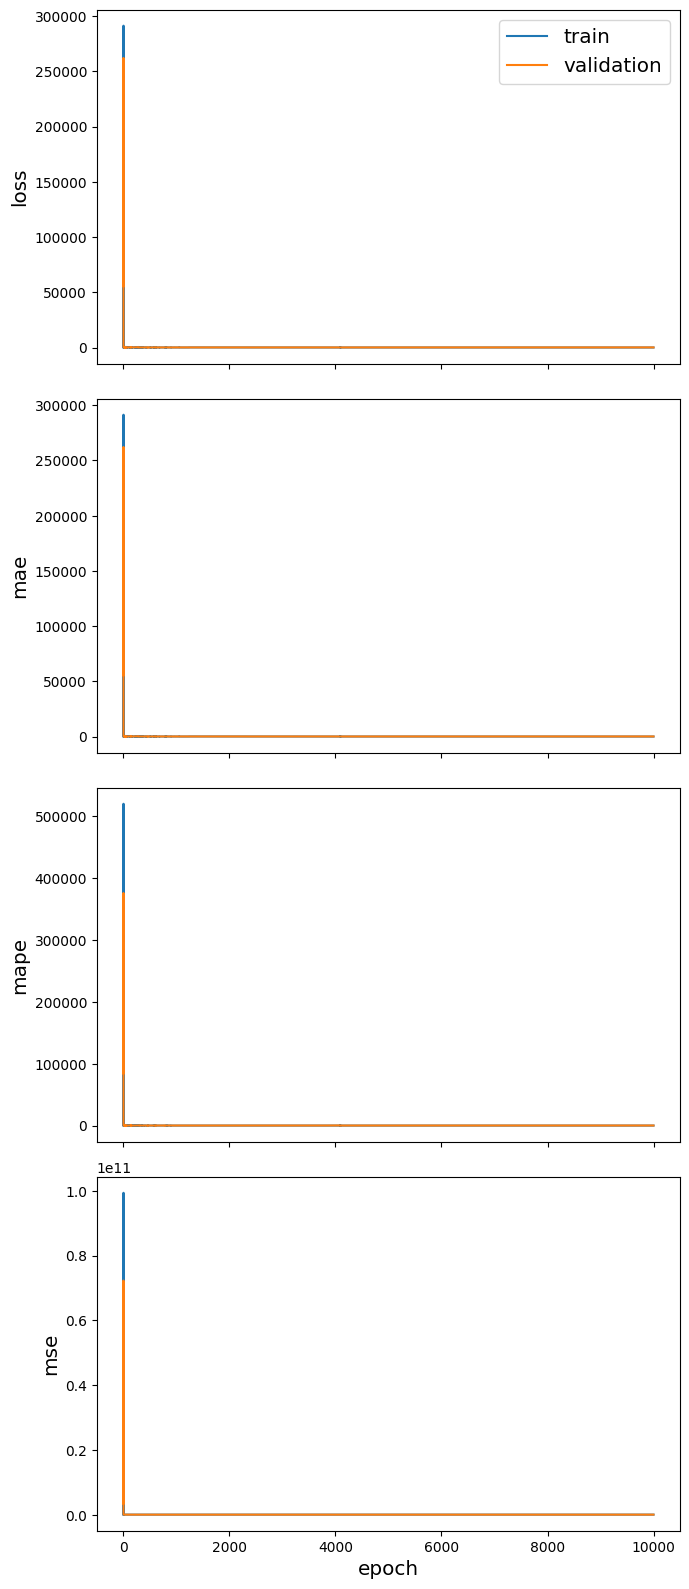

In [92]:
# In[71]:


sg.utils.plot_history(history)




In [93]:
# In[72]:


#val_subjects, 
#test_subjects


# In[73]:


#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[74]:


#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[75]:


validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[76]:


#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Kendall');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[3] = temp
df_metrics


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[77]:


#all_nodes = kendall_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#kendall_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
kendall_graph_node_data_test.index,  vars(test_gen),        test_predictions


# In[78]:


train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions


# In[79]:


test_predictions


# In[80]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, kendall_graph_node_data.shape
# vars(all_gen)


# In[81]:


kendall_graph_node_data


# In[ ]:



1/1 [==============================] - 0s 44ms/step - loss: 88.3420 - mse: 13716.3193 - mape: 133.0417 - mae: 88.3420

Test Set Metrics:
	loss: 88.3420
	mse: 13716.3193
	mape: 133.0417
	mae: 88.3420
1/1 [==============================] - 0s 38ms/step - loss: 0.0132 - mse: 3.3936e-04 - mape: 0.0180 - mae: 0.0132

Test Set Metrics:
	loss: 0.0132
	mse: 0.0003
	mape: 0.0180
	mae: 0.0132
1/1 [==============================] - 0s 35ms/step - loss: 88.3420 - mse: 13716.3193 - mape: 133.0417 - mae: 88.3420

Test Set Metrics:
	loss: 88.3420
	mse: 13716.3193
	mape: 133.0417
	mae: 88.3420
['GCN-Kendall', 88.34200286865234, 13716.3193359375, 133.0417022705078, 88.34200286865234]
1/1 [==============================] - 0s 224ms/step
72.89582
83.64539
92.330284
326.39352
35.153046
50.78655
295.13644
73.68665
119.85246
9.253875
69.21292
36.44399
66.95683
217.25894
1/1 [==============================] - 0s 31ms/step
72.89582
83.64539
92.330284
326.39352
35.153046
50.78655
295.13644
73.68665
119.85246
9

0           1           2           3           4           5    \
AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
GM      35.150002   37.090000   36.389999   35.990002   36.009998   37.349998   
GOOGL   40.400501   40.388500   40.651001   41.260502   41.359001   41.300499   
HD     134.309998  135.500000  133.899994  133.529999  134.309998  136.100006   
JPM     87.230003   86.910004   86.110001   86.120003   86.180000   86.430000   
KR      33.720001   33.240002   33.209999   33.110001   32.919998   33.189999   
MCK    147.429993  148.580002  146.500000  146.919998  146.839996  146.820007   
MSFT    62.580002   62.299999   62.299999   62.840000   62.639999   62.619999   
PCAR    43.546665   44.146667   43.426666   43.919998   43.380001   44.166668   
PSX     86.790001   87.260002   86.739998   85.400002   84.019997   83.760002   
T       32.492447   32.303623   32.212990   31.208460   30.815710   30.823263   
UNH    161.449997  161.910004  162.179993  162.410004  161.949997  161.580002   
UNP    102.519997  103.139999  102.129997  103.190002  102.419998  103.419998   
VZ      54.580002   54.520000   54.639999   53.259998   52.680000   52.759998   
WBA     82.959999   82.980003   83.029999   83.099998   82.550003   82.669998   
WFC     56.000000   56.049999   55.180000   55.040001   54.240002   54.619999   
WMT     68.660004   69.059998   69.209999   68.260002   68.709999   68.230003   
XOM     90.889999   89.889999   88.550003   88.500000   87.040001   85.930000   

              6           7           8           9    ...         743  \
AAPL    29.937500   29.812500   29.760000   30.000000  ...   69.964996   
ABC     81.529999   83.860001   84.620003   85.989998  ...   85.959999   
AMZN    39.951000   40.681999   40.856998   40.486000  ...   88.460503   
BA     159.399994  158.289993  158.830002  157.669998  ...  327.000000   
BAC     23.070000   22.920000   23.010000   22.049999  ...   34.700001   
CAH     73.720001   74.190002   75.000000   75.180000  ...   53.700001   
COST   161.539993  161.869995  161.860001  163.809998  ...  293.500000   
CVS     82.769997   82.599998   81.980003   83.919998  ...   74.400002   
CVX    115.930000  116.160004  116.379997  116.279999  ...  119.360001   
F       12.670000   12.590000   12.630000   12.610000  ...    9.390000   
GE     188.974960  188.494568  188.314423  187.773972  ...   69.758003   
GM      37.950001   37.509998   37.340000   37.310001  ...   36.110001   
GOOGL   41.493000   41.476501   41.547001   41.373001  ...   68.035004   
HD     135.699997  135.070007  135.039993  135.929993  ...  215.529999   
JPM     87.080002   86.239998   86.699997   83.550003  ...  137.339996   
KR      33.070000   33.520000   34.099998   34.840000  ...   28.309999   
MCK    143.199997  144.679993  147.179993  148.429993  ...  142.199997   
MSFT    63.189999   62.610001   62.700001   62.529999  ...  155.529999   
PCAR    44.533333   44.220001   45.013332   44.613335  ...   55.213333   
PSX     84.889999   84.339996   83.290001   83.559998  ...  114.139999   
T       30.672205   30.974319   30.936556   31.049849  ...   29.146526   
UNH    161.889999  162.360001  161.8

In [94]:
#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Kendall');
for name, val in zip(model.metrics_names, test_metrics):    
    temp.append(val)

print(temp)
df_metrics.loc[3] = temp

['GCN-Kendall', 88.34200286865234, 13716.3193359375, 133.0417022705078, 88.34200286865234]


In [95]:

# import math
df_metrics_plot = df_metrics[['Loss', 'MSE', 'MAPE', 'MAE']]

#temp = [10.71573, 13.578422, 10.71573, 16.638063]
#temp = [19.04899024963379, 1377.4075927734375, 19.04899024963379, 26.09033203125]
#df_metrics_plot.loc[4] = temp

df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']];
df_metrics_plot
#df_metrics, df_metrics_plot

C:\Users\sayed\AppData\Local\Temp\ipykernel_12988\1315755227.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']];


Loss         MSE        MAPE        MAE
1  88.343338  117.121098  133.045181  88.343338
2  88.350754  117.125925  133.050278  88.350754
3  88.342003  117.116691  133.041702  88.342003

<Axes: >

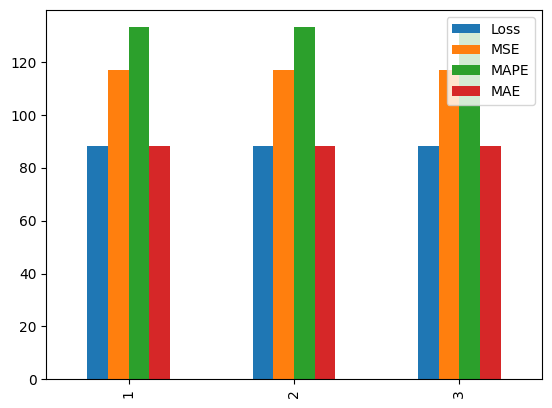

In [96]:
df_metrics_plot.plot( kind = 'bar')

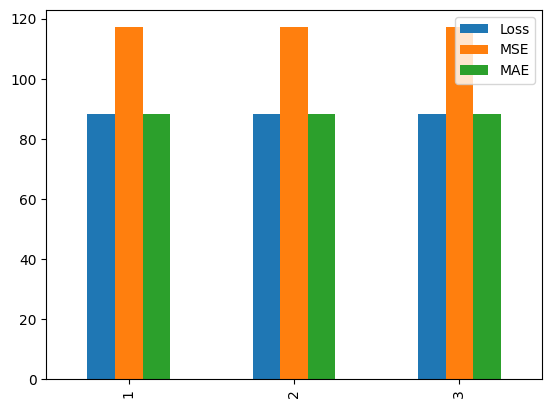

In [97]:
df_metrics_no_mape_plot = df_metrics_plot[['Loss', 'MSE', 'MAE']]
df_metrics_no_mape_plot.plot(kind='bar');

In [98]:
round(df_metrics_plot.T,1)

1      2      3
Loss   88.3   88.4   88.3
MSE   117.1  117.1  117.1
MAPE  133.0  133.1  133.0
MAE    88.3   88.4   88.3

# Ignore the code Below. These used to be code before 23rd april 2023

In [99]:
STOP

NameError: name 'STOP' is not defined

# Because it can be tricky (not impossible) to implement for Financial News Based Graph -- for now -- I want to skip that

# For the sake of easier execution, I have brought financial news based prediction in the same code file

To start with, I have taken ideas from the following code esp. to see what GCN is and how GCN works.

Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). 

https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    

# from scratch and equations
https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b

https://jonathan-hui.medium.com/graph-convolutional-networks-gcn-pooling-839184205692

In [ ]:
# Time Series
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
    

# Understand the output

In [ ]:
# https://www.baeldung.com/cs/learning-curve-ml